<a href="https://colab.research.google.com/github/naznmr/Patient-Data/blob/main/patient-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import random
import pickle
import math
import missingno as msno
from multiprocessing.dummy import Pool as ThreadPool
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as func
import sklearn.metrics as metrics
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy.interpolate import interp1d
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import requests

In [2]:
import ssl
import urllib.request

# تنظیم SSL context برای غیرفعال کردن چک کردن گواهی
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# download data
import os
import urllib.request
urllib.request.urlretrieve('https://archive.physionet.org/users/shared/challenge-2019/training_setA.zip','training_setA.zip')
# unzip
!unzip -q training_setA.zip
# delete zip file
!rm training_setA.zip
!mv training training_setA

URLError: <urlopen error [Errno 110] Connection timed out>

In [ ]:
data_path = "training_setA"
patient_ids = sorted(os.listdir(data_path))
data = [] # list of df for each patient

for i in tqdm(range(len(patient_ids))):
    # read in patient data
    df = pd.read_csv(data_path + '/' + patient_ids[i], sep = "|")
    df['PatientID'] = patient_ids[i]
    data.append(df)

100%|█████████▉| 20336/20337 [01:17<00:00, 263.19it/s]


IsADirectoryError: [Errno 21] Is a directory: 'training_setA/training'

1 - 1 تحلیل داده های اکتشافی

1 - چه درصد از بیماران به سپسیس مبتلا هستند؟

In [ ]:
sepsis = "SepsisLabel"
sepsis_count = 0
total_records = 0

for i in data:
    if sepsis in i.columns:
        sepsis_count += i[sepsis].sum()
        total_records += len(i)

if total_records > 0:
  sepsis_percent = (sepsis_count / total_records) * 100
else:
  sepsis_percent = 0

print("percent of sepsis patient = ", sepsis_percent)

percent of sepsis patient =  2.168523756192935


2 - توزیع جنسیت بیماران چگونه است؟ همچنین، میانگین و میانه سن بیماران چقدر است؟

In [ ]:
gender = "Gender"
male_count = 0
female_count = 0

for i in data:
  male_sum = (i[gender] == 0).sum()
  female_sum = (i[gender] == 1).sum()
  male_count += male_sum
  female_count += female_sum

print("Female count = ", female_count)
print("Male count = ", male_count)

age = "Age"
combined_data = pd.concat(data, ignore_index=True)

mean_age = combined_data[age].mean()
median_age = combined_data[age].median()

print("mean = ", mean_age)
print("median = ", median_age)

Female count =  456524
Male count =  333691
mean =  63.01677985105323
median =  65.25


3 - یک هیستوگرام از طول مدت داده های بیماران رسم کنید.

length of patients = 
 [54, 23, 48, 29, 48, 17, 45, 40, 258, 23, 34, 21, 39, 42, 15, 19, 37, 134, 48, 19, 57, 19, 21, 51, 50, 13, 10, 31, 48, 45, 55, 51, 37, 13, 41, 16, 18, 38, 45, 24, 34, 73, 45, 34, 19, 50, 18, 16, 18, 50, 40, 43, 25, 57, 14, 9, 35, 8, 37, 9, 18, 41, 14, 28, 29, 19, 18, 46, 12, 36, 54, 20, 23, 13, 38, 50, 23, 104, 42, 37, 36, 44, 50, 42, 55, 20, 46, 15, 26, 41, 54, 32, 29, 37, 35, 19, 34, 54, 22, 38, 36, 46, 19, 41, 37, 59, 40, 48, 48, 40, 49, 37, 21, 29, 56, 22, 48, 19, 17, 40, 45, 39, 49, 24, 41, 10, 49, 23, 26, 48, 46, 56, 56, 38, 17, 30, 40, 38, 42, 29, 61, 49, 53, 51, 26, 22, 44, 58, 25, 23, 24, 42, 22, 29, 34, 36, 42, 40, 37, 53, 23, 53, 35, 44, 39, 29, 19, 30, 53, 52, 69, 22, 24, 24, 20, 28, 24, 97, 50, 40, 24, 43, 36, 39, 65, 47, 44, 84, 57, 53, 37, 31, 40, 19, 31, 20, 42, 16, 37, 43, 47, 58, 81, 20, 41, 23, 59, 20, 44, 19, 8, 43, 55, 38, 38, 40, 35, 45, 48, 54, 54, 47, 43, 39, 40, 18, 37, 53, 27, 54, 34, 22, 22, 25, 38, 24, 31, 19, 19, 23, 20, 40, 46, 26, 5

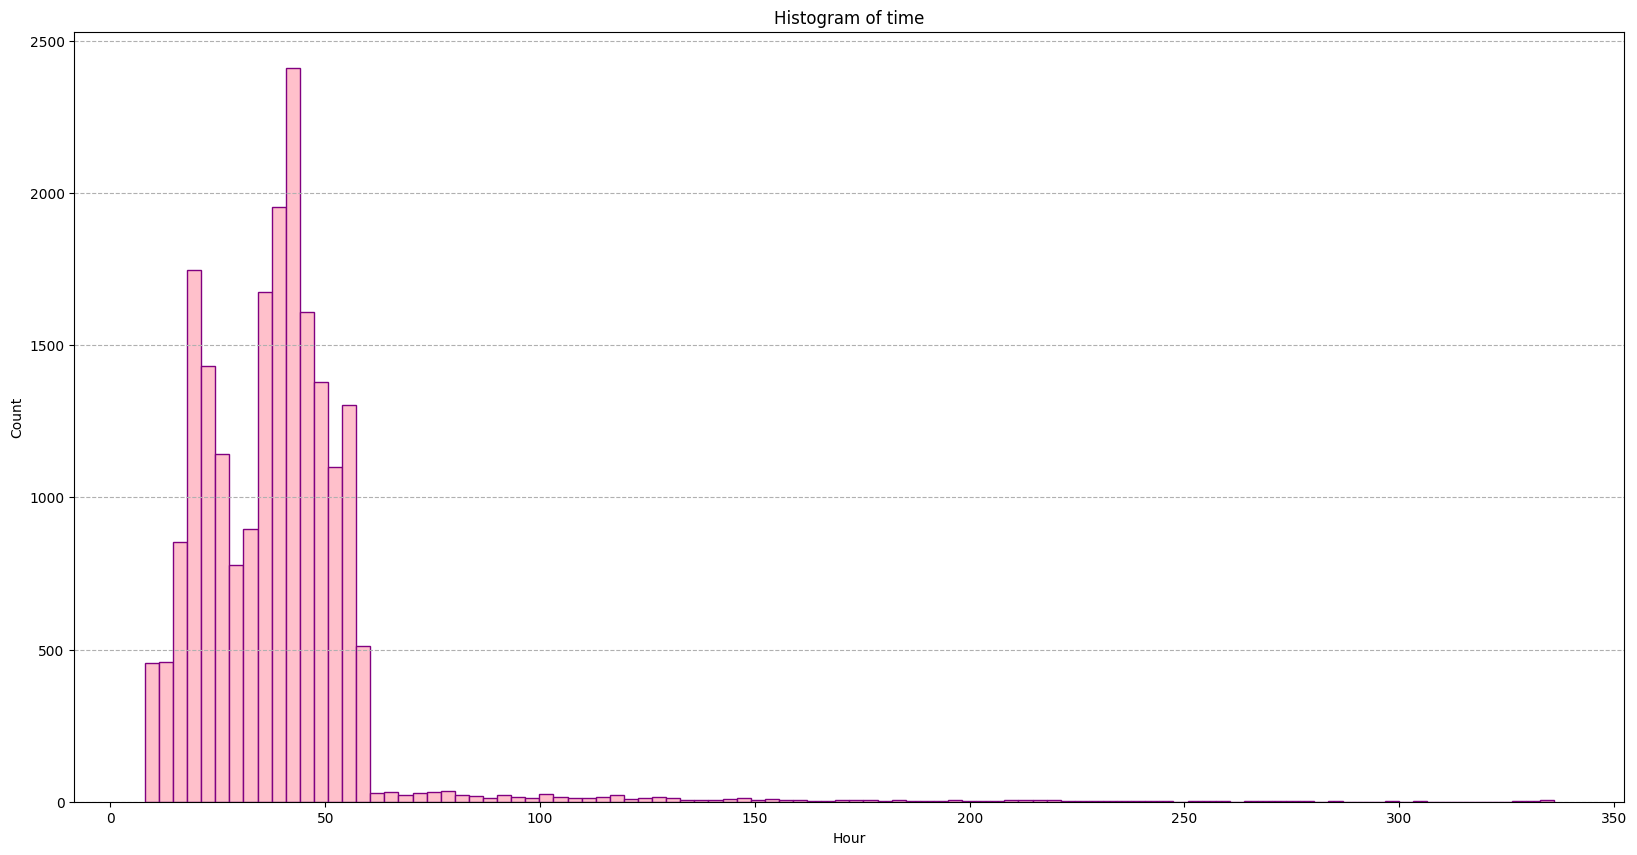

In [ ]:
patient_length = []

for i in data:
  len_i = len(i)
  patient_length.append(len_i)

print("length of patients = \n", patient_length)
print("\n")

plt.figure(figsize = (20, 10))
plt.hist(patient_length, bins = 100, color = "pink", edgecolor = "purple")
plt.title("Histogram of time")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.grid(axis = "y", linestyle = "--")
plt.show()

4 - یک هیستوگرام از اولین ساعتی که بیماران به سپسیس مبتلا می شوند را رسم کنید.

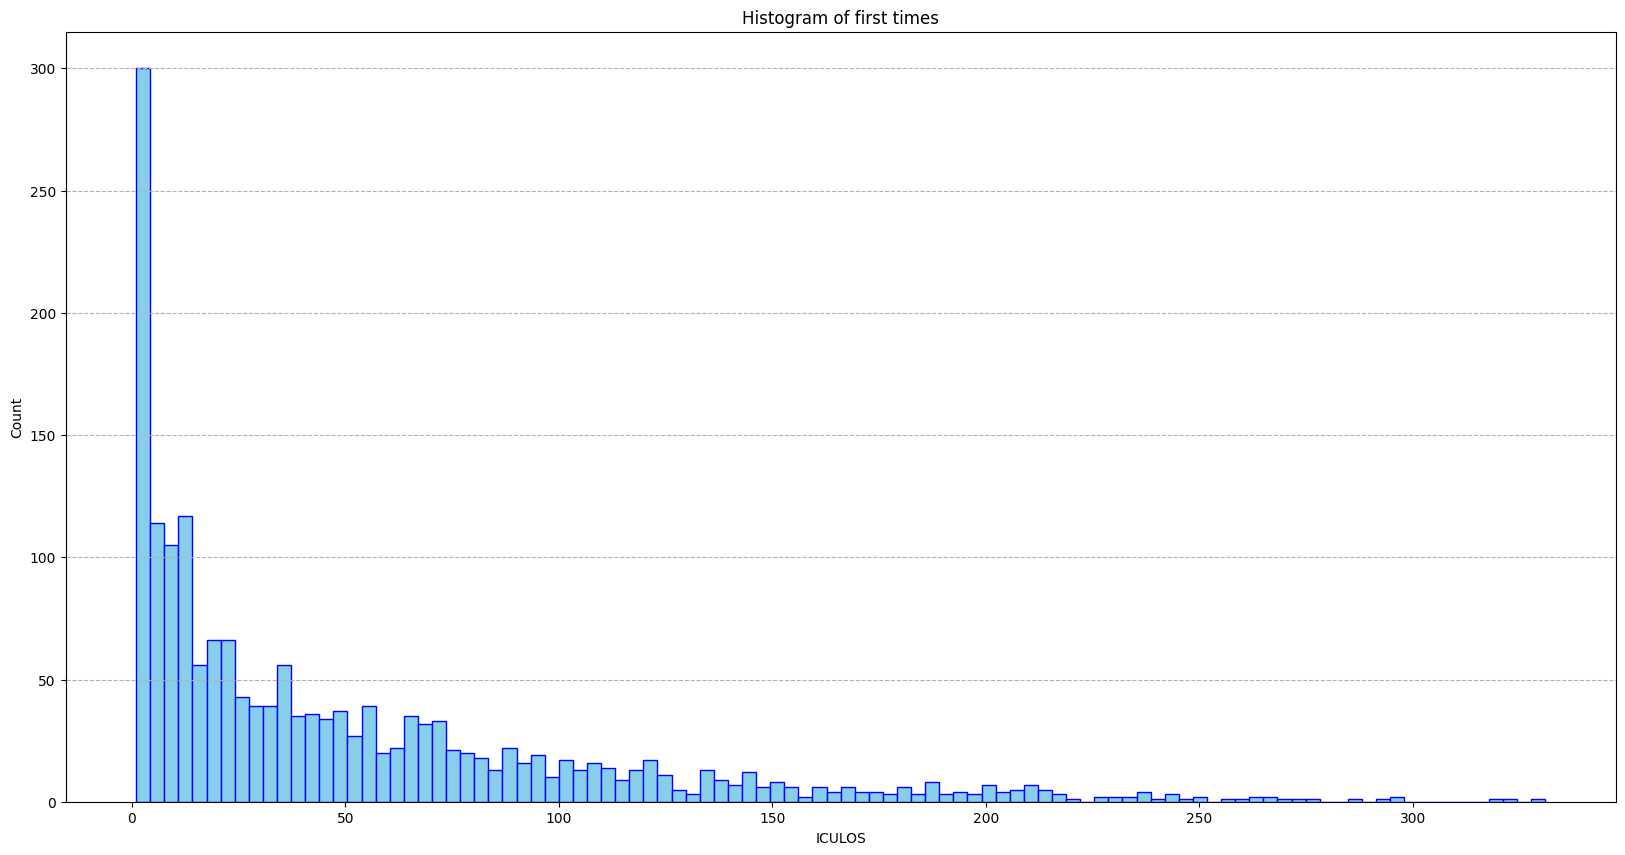

In [ ]:
sepsis = "SepsisLabel"
sepsis_time = "ICULOS"
sepsis_times = []

for i in data:
    if (sepsis in i.columns) and (sepsis_time in i.columns):
        sepsis_rows = i[i[sepsis] == 1]
        if not sepsis_rows.empty:
            sepsis_times.append(sepsis_rows[sepsis_time].iloc[0])


plt.figure(figsize = (20, 10))
plt.hist(sepsis_times, bins = 100, color = "skyblue", edgecolor = "blue")
plt.title("Histogram of first times")
plt.xlabel("ICULOS")
plt.ylabel("Count")
plt.grid(axis = "y", linestyle = "--")
plt.show()

5 - یک هیستوگرام از میزان فقدان داده ها برای هر ویژگی در بین تمام بیماران رسم کنید

Top 5 missing data : 

EtCO2: 1.0
TroponinI: 0.9987788133609208
Bilirubin_direct: 0.9985042045519258
Fibrinogen: 0.9923691653537329
Bilirubin_total: 0.9877337180387616


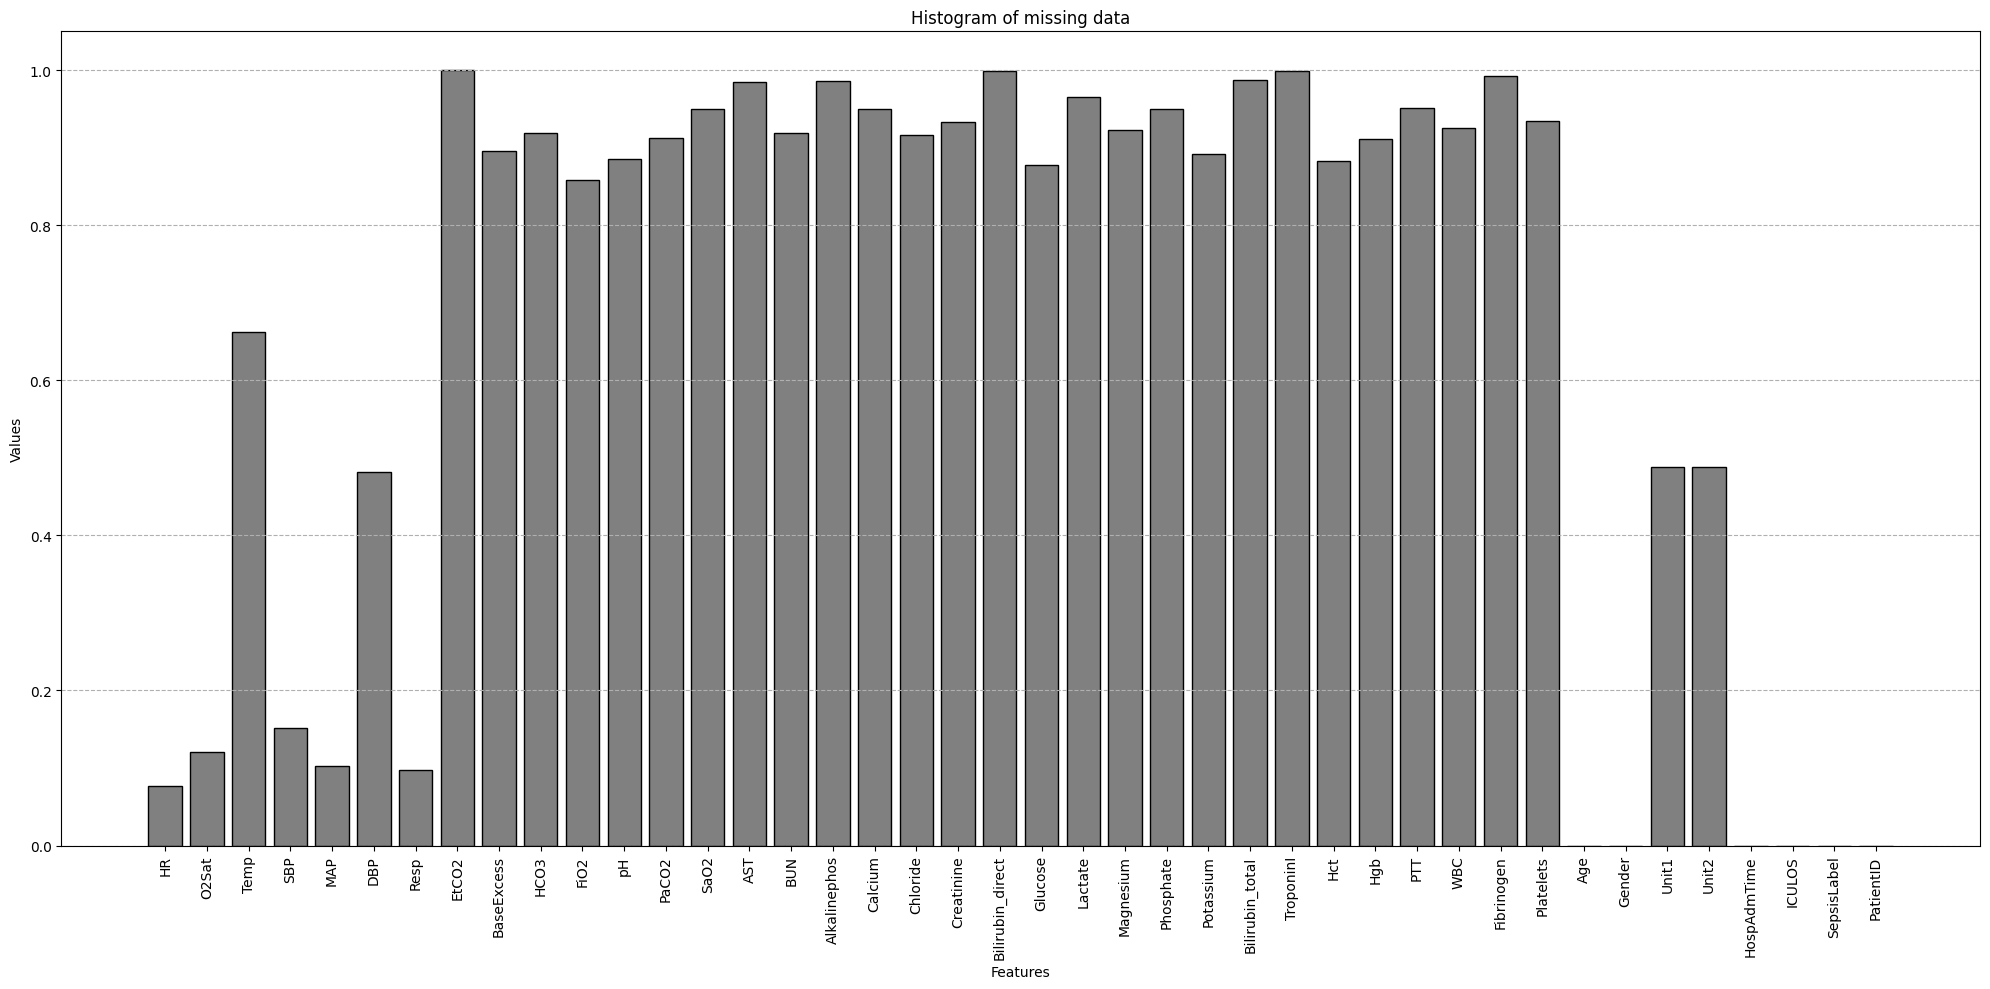

In [ ]:
missing_data = {}
total_rows = 0

for i in data:
    total_rows += len(i)
    for k in i.columns:
        if k not in missing_data:
            missing_data[k] = 0
        missing_data[k] += i[k].isna().sum()

missing = {}

for j in missing_data:
    cal = missing_data[j] / total_rows
    missing[j] = cal

sorted_missing = sorted(missing.items(), key=lambda x: x[1], reverse = True)

top_5_missing = sorted_missing[:5]

print("Top 5 missing data : \n")

for m, n in top_5_missing:
    print(f"{m}: {n}")

features = list(missing.keys())
values = list(missing.values())

plt.figure(figsize = (20, 10))
plt.bar(features, values, color = "gray", edgecolor = "black")
plt.title("Histogram of missing data")
plt.xlabel("Features")
plt.ylabel("Values")
plt.xticks(rotation = 90)
plt.grid(axis = "y", linestyle = "--")
plt.tight_layout()
plt.show()

1 - 2 یادگیری مدل برای پیشبینی سپسیس

تکمیل مقادیر گمشده

In [ ]:
combined_data = pd.concat(data, ignore_index = True)

missing_data = combined_data.isna().mean()
missing_percent = missing_data * 100

print("Percent of missing data : \n")
print(missing_percent)
print("\n")

missing_threshold = 50
features_to_drop = missing_percent[missing_percent > missing_threshold].index

print("Droped Features : ", len(features_to_drop), " Features will drop. \n")
print(features_to_drop.tolist())

X = combined_data.drop(columns = features_to_drop)

X.fillna(X.mean(), inplace = True)

print("All datas : \n")
print(X)

Percent of missing data : 

HR                    7.743336
O2Sat                12.032042
Temp                 66.224255
SBP                  15.211177
MAP                  10.232405
DBP                  48.125763
Resp                  9.776833
EtCO2               100.000000
BaseExcess           89.574863
HCO3                 91.949406
FiO2                 85.807027
pH                   88.532868
PaCO2                91.231753
SaO2                 95.044387
AST                  98.504205
BUN                  91.840702
Alkalinephos         98.540650
Calcium              95.024392
Chloride             91.676063
Creatinine           93.357884
Bilirubin_direct     99.850420
Glucose              87.768392
Lactate              96.565112
Magnesium            92.219712
Phosphate            94.951247
Potassium            89.137640
Bilirubin_total      98.773372
TroponinI            99.877881
Hct                  88.223711
Hgb                  91.164303
PTT                  95.152459
WBC        

TypeError: Could not convert ['p000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000001.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000002.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000003.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000004.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000005.psvp000006.psvp000006.psvp000006.psvp000006.psvp000006.psvp000006.psvp000006.psvp000006.psvp000006.psvp000006.psvp000006.psvp000006.psvp000006.psvp000006.psvp000006.psvp000006.psvp000006.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000007.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000008.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000009.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000010.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000011.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000012.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000013.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000014.psvp000015.psvp000015.psvp000015.psvp000015.psvp000015.psvp000015.psvp000015.psvp000015.psvp000015.psvp000015.psvp000015.psvp000015.psvp000015.psvp000015.psvp000015.psvp000016.psvp000016.psvp000016.psvp000016.psvp000016.psvp000016.psvp000016.psvp000016.psvp000016.psvp000016.psvp000016.psvp000016.psvp000016.psvp000016.psvp000016.psvp000016.psvp000016.psvp000016.psvp000016.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000017.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000018.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000019.psvp000020.psvp000020.psvp000020.psvp000020.psvp000020.psvp000020.psvp000020.psvp000020.psvp000020.psvp000020.psvp000020.psvp000020.psvp000020.psvp000020.psvp000020.psvp000020.psvp000020.psvp000020.psvp000020.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000021.psvp000022.psvp000022.psvp000022.psvp000022.psvp000022.psvp000022.psvp000022.psvp000022.psvp000022.psvp000022.psvp000022.psvp000022.psvp000022.psvp000022.psvp000022.psvp000022.psvp000022.psvp000022.psvp000022.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000023.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000024.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000025.psvp000026.psvp000026.psvp000026.psvp000026.psvp000026.psvp000026.psvp000026.psvp000026.psvp000026.psvp000026.psvp000026.psvp000026.psvp000026.psvp000027.psvp000027.psvp000027.psvp000027.psvp000027.psvp000027.psvp000027.psvp000027.psvp000027.psvp000027.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000028.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000029.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000030.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000031.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000032.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000033.psvp000034.psvp000034.psvp000034.psvp000034.psvp000034.psvp000034.psvp000034.psvp000034.psvp000034.psvp000034.psvp000034.psvp000034.psvp000034.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000035.psvp000036.psvp000036.psvp000036.psvp000036.psvp000036.psvp000036.psvp000036.psvp000036.psvp000036.psvp000036.psvp000036.psvp000036.psvp000036.psvp000036.psvp000036.psvp000036.psvp000037.psvp000037.psvp000037.psvp000037.psvp000037.psvp000037.psvp000037.psvp000037.psvp000037.psvp000037.psvp000037.psvp000037.psvp000037.psvp000037.psvp000037.psvp000037.psvp000037.psvp000037.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000038.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000039.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000040.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000041.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000042.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000043.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000044.psvp000045.psvp000045.psvp000045.psvp000045.psvp000045.psvp000045.psvp000045.psvp000045.psvp000045.psvp000045.psvp000045.psvp000045.psvp000045.psvp000045.psvp000045.psvp000045.psvp000045.psvp000045.psvp000045.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000046.psvp000047.psvp000047.psvp000047.psvp000047.psvp000047.psvp000047.psvp000047.psvp000047.psvp000047.psvp000047.psvp000047.psvp000047.psvp000047.psvp000047.psvp000047.psvp000047.psvp000047.psvp000047.psvp000048.psvp000048.psvp000048.psvp000048.psvp000048.psvp000048.psvp000048.psvp000048.psvp000048.psvp000048.psvp000048.psvp000048.psvp000048.psvp000048.psvp000048.psvp000048.psvp000049.psvp000049.psvp000049.psvp000049.psvp000049.psvp000049.psvp000049.psvp000049.psvp000049.psvp000049.psvp000049.psvp000049.psvp000049.psvp000049.psvp000049.psvp000049.psvp000049.psvp000049.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000050.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000051.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000052.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000053.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000054.psvp000055.psvp000055.psvp000055.psvp000055.psvp000055.psvp000055.psvp000055.psvp000055.psvp000055.psvp000055.psvp000055.psvp000055.psvp000055.psvp000055.psvp000056.psvp000056.psvp000056.psvp000056.psvp000056.psvp000056.psvp000056.psvp000056.psvp000056.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000057.psvp000058.psvp000058.psvp000058.psvp000058.psvp000058.psvp000058.psvp000058.psvp000058.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000059.psvp000060.psvp000060.psvp000060.psvp000060.psvp000060.psvp000060.psvp000060.psvp000060.psvp000060.psvp000061.psvp000061.psvp000061.psvp000061.psvp000061.psvp000061.psvp000061.psvp000061.psvp000061.psvp000061.psvp000061.psvp000061.psvp000061.psvp000061.psvp000061.psvp000061.psvp000061.psvp000061.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000062.psvp000063.psvp000063.psvp000063.psvp000063.psvp000063.psvp000063.psvp000063.psvp000063.psvp000063.psvp000063.psvp000063.psvp000063.psvp000063.psvp000063.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000064.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000065.psvp000066.psvp000066.psvp000066.psvp000066.psvp000066.psvp000066.psvp000066.psvp000066.psvp000066.psvp000066.psvp000066.psvp000066.psvp000066.psvp000066.psvp000066.psvp000066.psvp000066.psvp000066.psvp000066.psvp000067.psvp000067.psvp000067.psvp000067.psvp000067.psvp000067.psvp000067.psvp000067.psvp000067.psvp000067.psvp000067.psvp000067.psvp000067.psvp000067.psvp000067.psvp000067.psvp000067.psvp000067.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000068.psvp000069.psvp000069.psvp000069.psvp000069.psvp000069.psvp000069.psvp000069.psvp000069.psvp000069.psvp000069.psvp000069.psvp000069.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000070.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000071.psvp000072.psvp000072.psvp000072.psvp000072.psvp000072.psvp000072.psvp000072.psvp000072.psvp000072.psvp000072.psvp000072.psvp000072.psvp000072.psvp000072.psvp000072.psvp000072.psvp000072.psvp000072.psvp000072.psvp000072.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000073.psvp000074.psvp000074.psvp000074.psvp000074.psvp000074.psvp000074.psvp000074.psvp000074.psvp000074.psvp000074.psvp000074.psvp000074.psvp000074.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000075.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000076.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000077.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000078.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000079.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000080.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000081.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000082.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000083.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000084.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000085.psvp000086.psvp000086.psvp000086.psvp000086.psvp000086.psvp000086.psvp000086.psvp000086.psvp000086.psvp000086.psvp000086.psvp000086.psvp000086.psvp000086.psvp000086.psvp000086.psvp000086.psvp000086.psvp000086.psvp000086.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000087.psvp000088.psvp000088.psvp000088.psvp000088.psvp000088.psvp000088.psvp000088.psvp000088.psvp000088.psvp000088.psvp000088.psvp000088.psvp000088.psvp000088.psvp000088.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000089.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000090.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000091.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000092.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000093.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000094.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000095.psvp000096.psvp000096.psvp000096.psvp000096.psvp000096.psvp000096.psvp000096.psvp000096.psvp000096.psvp000096.psvp000096.psvp000096.psvp000096.psvp000096.psvp000096.psvp000096.psvp000096.psvp000096.psvp000096.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000097.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000098.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000099.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000100.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000101.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000102.psvp000103.psvp000103.psvp000103.psvp000103.psvp000103.psvp000103.psvp000103.psvp000103.psvp000103.psvp000103.psvp000103.psvp000103.psvp000103.psvp000103.psvp000103.psvp000103.psvp000103.psvp000103.psvp000103.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000104.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000105.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000106.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000107.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000108.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000109.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000110.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000111.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000112.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000113.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000114.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000115.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000116.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000117.psvp000118.psvp000118.psvp000118.psvp000118.psvp000118.psvp000118.psvp000118.psvp000118.psvp000118.psvp000118.psvp000118.psvp000118.psvp000118.psvp000118.psvp000118.psvp000118.psvp000118.psvp000118.psvp000118.psvp000119.psvp000119.psvp000119.psvp000119.psvp000119.psvp000119.psvp000119.psvp000119.psvp000119.psvp000119.psvp000119.psvp000119.psvp000119.psvp000119.psvp000119.psvp000119.psvp000119.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000120.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000121.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000122.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000123.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000124.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000125.psvp000126.psvp000126.psvp000126.psvp000126.psvp000126.psvp000126.psvp000126.psvp000126.psvp000126.psvp000126.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000127.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000128.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000129.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000130.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000131.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000132.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000133.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000134.psvp000135.psvp000135.psvp000135.psvp000135.psvp000135.psvp000135.psvp000135.psvp000135.psvp000135.psvp000135.psvp000135.psvp000135.psvp000135.psvp000135.psvp000135.psvp000135.psvp000135.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000136.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000137.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000138.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000139.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000140.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000141.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000142.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000143.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000144.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000145.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000146.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000147.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000148.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000149.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000150.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000151.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000152.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000153.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000154.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000155.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000156.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000157.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000158.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000159.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000160.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000161.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000162.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000163.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000164.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000165.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000166.psvp000167.psvp000167.psvp000167.psvp000167.psvp000167.psvp000167.psvp000167.psvp000167.psvp000167.psvp000167.psvp000167.psvp000167.psvp000167.psvp000167.psvp000167.psvp000167.psvp000167.psvp000167.psvp000167.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000168.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000169.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000170.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000171.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000172.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000173.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000174.psvp000175.psvp000175.psvp000175.psvp000175.psvp000175.psvp000175.psvp000175.psvp000175.psvp000175.psvp000175.psvp000175.psvp000175.psvp000175.psvp000175.psvp000175.psvp000175.psvp000175.psvp000175.psvp000175.psvp000175.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000176.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000177.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000178.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000179.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000180.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000181.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000182.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000183.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000184.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000185.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000186.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000187.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000188.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000189.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000190.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000191.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000192.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000193.psvp000194.psvp000194.psvp000194.psvp000194.psvp000194.psvp000194.psvp000194.psvp000194.psvp000194.psvp000194.psvp000194.psvp000194.psvp000194.psvp000194.psvp000194.psvp000194.psvp000194.psvp000194.psvp000194.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000195.psvp000196.psvp000196.psvp000196.psvp000196.psvp000196.psvp000196.psvp000196.psvp000196.psvp000196.psvp000196.psvp000196.psvp000196.psvp000196.psvp000196.psvp000196.psvp000196.psvp000196.psvp000196.psvp000196.psvp000196.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000197.psvp000198.psvp000198.psvp000198.psvp000198.psvp000198.psvp000198.psvp000198.psvp000198.psvp000198.psvp000198.psvp000198.psvp000198.psvp000198.psvp000198.psvp000198.psvp000198.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000199.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000200.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000201.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000202.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000203.psvp000204.psvp000204.psvp000204.psvp000204.psvp000204.psvp000204.psvp000204.psvp000204.psvp000204.psvp000204.psvp000204.psvp000204.psvp000204.psvp000204.psvp000204.psvp000204.psvp000204.psvp000204.psvp000204.psvp000204.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000205.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000206.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000207.psvp000208.psvp000208.psvp000208.psvp000208.psvp000208.psvp000208.psvp000208.psvp000208.psvp000208.psvp000208.psvp000208.psvp000208.psvp000208.psvp000208.psvp000208.psvp000208.psvp000208.psvp000208.psvp000208.psvp000208.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000209.psvp000210.psvp000210.psvp000210.psvp000210.psvp000210.psvp000210.psvp000210.psvp000210.psvp000210.psvp000210.psvp000210.psvp000210.psvp000210.psvp000210.psvp000210.psvp000210.psvp000210.psvp000210.psvp000210.psvp000211.psvp000211.psvp000211.psvp000211.psvp000211.psvp000211.psvp000211.psvp000211.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000212.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000213.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000214.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000215.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000216.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000217.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000218.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000219.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000220.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000221.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000222.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000223.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000224.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000225.psvp000226.psvp000226.psvp000226.psvp000226.psvp000226.psvp000226.psvp000226.psvp000226.psvp000226.psvp000226.psvp000226.psvp000226.psvp000226.psvp000226.psvp000226.psvp000226.psvp000226.psvp000226.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000227.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000228.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000229.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000230.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000231.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000232.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000233.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000234.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000235.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000236.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000237.psvp000238.psvp000238.psvp000238.psvp000238.psvp000238.psvp000238.psvp000238.psvp000238.psvp000238.psvp000238.psvp000238.psvp000238.psvp000238.psvp000238.psvp000238.psvp000238.psvp000238.psvp000238.psvp000238.psvp000239.psvp000239.psvp000239.psvp000239.psvp000239.psvp000239.psvp000239.psvp000239.psvp000239.psvp000239.psvp000239.psvp000239.psvp000239.psvp000239.psvp000239.psvp000239.psvp000239.psvp000239.psvp000239.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000240.psvp000241.psvp000241.psvp000241.psvp000241.psvp000241.psvp000241.psvp000241.psvp000241.psvp000241.psvp000241.psvp000241.psvp000241.psvp000241.psvp000241.psvp000241.psvp000241.psvp000241.psvp000241.psvp000241.psvp000241.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000242.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000243.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000244.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000245.psvp000246.psvp000246.psvp000246.psvp000246.psvp000246.psvp000246.psvp000246.psvp000246.psvp000246.psvp000246.psvp000246.psvp000246.psvp000246.psvp000246.psvp000246.psvp000246.psvp000246.psvp000246.psvp000246.psvp000246.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000247.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000248.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000249.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000250.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000251.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000252.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000253.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000254.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000255.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000256.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000257.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000258.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000259.psvp000260.psvp000260.psvp000260.psvp000260.psvp000260.psvp000260.psvp000260.psvp000260.psvp000260.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000261.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000262.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000263.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000264.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000265.psvp000266.psvp000266.psvp000266.psvp000266.psvp000266.psvp000266.psvp000266.psvp000266.psvp000266.psvp000266.psvp000266.psvp000266.psvp000266.psvp000266.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000267.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000268.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000269.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000270.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000271.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000272.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000273.psvp000274.psvp000274.psvp000274.psvp000274.psvp000274.psvp000274.psvp000274.psvp000274.psvp000274.psvp000274.psvp000274.psvp000274.psvp000274.psvp000274.psvp000274.psvp000274.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000275.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000276.psvp000277.psvp000277.psvp000277.psvp000277.psvp000277.psvp000277.psvp000277.psvp000277.psvp000277.psvp000277.psvp000277.psvp000277.psvp000277.psvp000277.psvp000277.psvp000277.psvp000277.psvp000277.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000278.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000279.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000280.psvp000281.psvp000281.psvp000281.psvp000281.psvp000281.psvp000281.psvp000281.psvp000281.psvp000281.psvp000281.psvp000281.psvp000281.psvp000281.psvp000281.psvp000281.psvp000281.psvp000281.psvp000281.psvp000281.psvp000281.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000282.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000283.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000284.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000285.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000286.psvp000287.psvp000287.psvp000287.psvp000287.psvp000287.psvp000287.psvp000287.psvp000287.psvp000287.psvp000287.psvp000287.psvp000287.psvp000287.psvp000287.psvp000287.psvp000287.psvp000287.psvp000287.psvp000287.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000288.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000289.psvp000290.psvp000290.psvp000290.psvp000290.psvp000290.psvp000290.psvp000290.psvp000290.psvp000290.psvp000290.psvp000290.psvp000290.psvp000290.psvp000290.psvp000290.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000291.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000292.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000293.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000294.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000295.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000296.psvp000297.psvp000297.psvp000297.psvp000297.psvp000297.psvp000297.psvp000297.psvp000297.psvp000297.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000298.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000299.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000300.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000301.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000302.psvp000303.psvp000303.psvp000303.psvp000303.psvp000303.psvp000303.psvp000303.psvp000303.psvp000303.psvp000303.psvp000303.psvp000303.psvp000303.psvp000303.psvp000303.psvp000303.psvp000303.psvp000303.psvp000303.psvp000303.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000304.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000305.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000306.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000307.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000308.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000309.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000310.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000311.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000312.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000313.psvp000314.psvp000314.psvp000314.psvp000314.psvp000314.psvp000314.psvp000314.psvp000314.psvp000314.psvp000314.psvp000314.psvp000314.psvp000314.psvp000314.psvp000314.psvp000314.psvp000314.psvp000314.psvp000314.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000315.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000316.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000317.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000318.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000319.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000320.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000321.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000322.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000323.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000324.psvp000325.psvp000325.psvp000325.psvp000325.psvp000325.psvp000325.psvp000325.psvp000325.psvp000325.psvp000325.psvp000325.psvp000325.psvp000325.psvp000325.psvp000325.psvp000325.psvp000325.psvp000325.psvp000325.psvp000325.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000326.psvp000327.psvp000327.psvp000327.psvp000327.psvp000327.psvp000327.psvp000327.psvp000327.psvp000327.psvp000327.psvp000327.psvp000327.psvp000327.psvp000327.psvp000327.psvp000327.psvp000327.psvp000327.psvp000327.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000328.psvp000329.psvp000329.psvp000329.psvp000329.psvp000329.psvp000329.psvp000329.psvp000329.psvp000329.psvp000329.psvp000329.psvp000329.psvp000329.psvp000329.psvp000329.psvp000329.psvp000329.psvp000329.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000330.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000331.psvp000332.psvp000332.psvp000332.psvp000332.psvp000332.psvp000332.psvp000332.psvp000332.psvp000332.psvp000332.psvp000332.psvp000332.psvp000332.psvp000332.psvp000332.psvp000332.psvp000332.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000333.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000334.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000335.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000336.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000337.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000338.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000339.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000340.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000341.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000342.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000343.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000344.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000345.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000346.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000347.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000348.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000349.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000350.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000351.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000352.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000353.psvp000354.psvp000354.psvp000354.psvp000354.psvp000354.psvp000354.psvp000354.psvp000354.psvp000354.psvp000354.psvp000354.psvp000354.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000355.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000356.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000357.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000358.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000359.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000360.psvp000361.psvp000361.psvp000361.psvp000361.psvp000361.psvp000361.psvp000361.psvp000361.psvp000361.psvp000361.psvp000361.psvp000361.psvp000361.psvp000361.psvp000361.psvp000361.psvp000361.psvp000361.psvp000361.psvp000361.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000362.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000363.psvp000364.psvp000364.psvp000364.psvp000364.psvp000364.psvp000364.psvp000364.psvp000364.psvp000364.psvp000364.psvp000364.psvp000364.psvp000364.psvp000364.psvp000364.psvp000364.psvp000364.psvp000364.psvp000364.psvp000365.psvp000365.psvp000365.psvp000365.psvp000365.psvp000365.psvp000365.psvp000365.psvp000365.psvp000365.psvp000365.psvp000365.psvp000365.psvp000365.psvp000365.psvp000365.psvp000365.psvp000365.psvp000365.psvp000365.psvp000366.psvp000366.psvp000366.psvp000366.psvp000366.psvp000366.psvp000366.psvp000366.psvp000366.psvp000366.psvp000366.psvp000366.psvp000366.psvp000366.psvp000366.psvp000366.psvp000366.psvp000366.psvp000366.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000367.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000368.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000369.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000370.psvp000371.psvp000371.psvp000371.psvp000371.psvp000371.psvp000371.psvp000371.psvp000371.psvp000371.psvp000371.psvp000371.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000372.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000373.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000374.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000375.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000376.psvp000377.psvp000377.psvp000377.psvp000377.psvp000377.psvp000377.psvp000377.psvp000377.psvp000377.psvp000377.psvp000377.psvp000377.psvp000377.psvp000377.psvp000377.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000378.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000379.psvp000380.psvp000380.psvp000380.psvp000380.psvp000380.psvp000380.psvp000380.psvp000380.psvp000380.psvp000380.psvp000380.psvp000380.psvp000380.psvp000380.psvp000380.psvp000380.psvp000380.psvp000380.psvp000380.psvp000380.psvp000381.psvp000381.psvp000381.psvp000381.psvp000381.psvp000381.psvp000381.psvp000381.psvp000381.psvp000381.psvp000381.psvp000381.psvp000381.psvp000381.psvp000381.psvp000381.psvp000381.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000382.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000383.psvp000384.psvp000384.psvp000384.psvp000384.psvp000384.psvp000384.psvp000384.psvp000384.psvp000384.psvp000384.psvp000384.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000385.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000386.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000387.psvp000388.psvp000388.psvp000388.psvp000388.psvp000388.psvp000388.psvp000388.psvp000388.psvp000388.psvp000388.psvp000388.psvp000388.psvp000388.psvp000388.psvp000388.psvp000388.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000389.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000390.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000391.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000392.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000393.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000394.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000395.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000396.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000397.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000398.psvp000399.psvp000399.psvp000399.psvp000399.psvp000399.psvp000399.psvp000399.psvp000399.psvp000399.psvp000399.psvp000399.psvp000399.psvp000399.psvp000399.psvp000399.psvp000399.psvp000399.psvp000399.psvp000399.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000400.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000401.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000402.psvp000403.psvp000403.psvp000403.psvp000403.psvp000403.psvp000403.psvp000403.psvp000403.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000404.psvp000405.psvp000405.psvp000405.psvp000405.psvp000405.psvp000405.psvp000405.psvp000405.psvp000405.psvp000405.psvp000405.psvp000405.psvp000405.psvp000405.psvp000405.psvp000405.psvp000405.psvp000405.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000406.psvp000407.psvp000407.psvp000407.psvp000407.psvp000407.psvp000407.psvp000407.psvp000407.psvp000407.psvp000407.psvp000407.psvp000407.psvp000407.psvp000407.psvp000407.psvp000407.psvp000407.psvp000407.psvp000407.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000408.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000409.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000410.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000411.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000412.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000413.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000414.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000415.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000416.psvp000417.psvp000417.psvp000417.psvp000417.psvp000417.psvp000417.psvp000417.psvp000417.psvp000417.psvp000417.psvp000417.psvp000417.psvp000417.psvp000417.psvp000417.psvp000417.psvp000417.psvp000417.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000418.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000419.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000420.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000421.psvp000422.psvp000422.psvp000422.psvp000422.psvp000422.psvp000422.psvp000422.psvp000422.psvp000422.psvp000422.psvp000422.psvp000422.psvp000422.psvp000422.psvp000422.psvp000422.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000423.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000424.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000425.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000426.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000427.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000428.psvp000429.psvp000429.psvp000429.psvp000429.psvp000429.psvp000429.psvp000429.psvp000429.psvp000429.psvp000429.psvp000429.psvp000429.psvp000429.psvp000429.psvp000429.psvp000429.psvp000429.psvp000429.psvp000429.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000430.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000431.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000432.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000433.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000434.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000435.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000436.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000437.psvp000438.psvp000438.psvp000438.psvp000438.psvp000438.psvp000438.psvp000438.psvp000438.psvp000438.psvp000438.psvp000438.psvp000438.psvp000438.psvp000438.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000439.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000440.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000441.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000442.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000443.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000444.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000445.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000446.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000447.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000448.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000449.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000450.psvp000451.psvp000451.psvp000451.psvp000451.psvp000451.psvp000451.psvp000451.psvp000451.psvp000451.psvp000451.psvp000451.psvp000451.psvp000451.psvp000451.psvp000451.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000452.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000453.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000454.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000455.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000456.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000457.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000458.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000459.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000460.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000461.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000462.psvp000463.psvp000463.psvp000463.psvp000463.psvp000463.psvp000463.psvp000463.psvp000463.psvp000463.psvp000463.psvp000463.psvp000463.psvp000463.psvp000463.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000464.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000465.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000466.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000467.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000468.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000469.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000470.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000471.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000472.psvp000473.psvp000473.psvp000473.psvp000473.psvp000473.psvp000473.psvp000473.psvp000473.psvp000473.psvp000473.psvp000473.psvp000473.psvp000473.psvp000473.psvp000473.psvp000473.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000474.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000475.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000476.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000477.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000478.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000479.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000480.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000481.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000482.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000483.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000484.psvp000485.psvp000485.psvp000485.psvp000485.psvp000485.psvp000485.psvp000485.psvp000485.psvp000485.psvp000485.psvp000485.psvp000485.psvp000485.psvp000485.psvp000485.psvp000485.psvp000485.psvp000485.psvp000485.psvp000485.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000486.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000487.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000488.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000489.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000490.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000491.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000492.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000493.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000494.psvp000495.psvp000495.psvp000495.psvp000495.psvp000495.psvp000495.psvp000495.psvp000495.psvp000495.psvp000495.psvp000495.psvp000495.psvp000495.psvp000495.psvp000495.psvp000495.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000496.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000497.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000498.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000499.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000500.psvp000501.psvp000501.psvp000501.psvp000501.psvp000501.psvp000501.psvp000501.psvp000501.psvp000501.psvp000501.psvp000501.psvp000501.psvp000501.psvp000501.psvp000501.psvp000501.psvp000501.psvp000501.psvp000502.psvp000502.psvp000502.psvp000502.psvp000502.psvp000502.psvp000502.psvp000502.psvp000502.psvp000502.psvp000502.psvp000502.psvp000502.psvp000502.psvp000502.psvp000502.psvp000502.psvp000502.psvp000502.psvp000502.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000503.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000504.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000505.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000506.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000507.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000508.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000509.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000510.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000511.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000512.psvp000513.psvp000513.psvp000513.psvp000513.psvp000513.psvp000513.psvp000513.psvp000513.psvp000513.psvp000513.psvp000513.psvp000513.psvp000513.psvp000513.psvp000513.psvp000513.psvp000513.psvp000513.psvp000513.psvp000513.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000514.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000515.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000516.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000517.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000518.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000519.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000520.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000521.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000522.psvp000523.psvp000523.psvp000523.psvp000523.psvp000523.psvp000523.psvp000523.psvp000523.psvp000523.psvp000523.psvp000523.psvp000523.psvp000523.psvp000523.psvp000523.psvp000523.psvp000523.psvp000523.psvp000523.psvp000524.psvp000524.psvp000524.psvp000524.psvp000524.psvp000524.psvp000524.psvp000524.psvp000525.psvp000525.psvp000525.psvp000525.psvp000525.psvp000525.psvp000525.psvp000525.psvp000525.psvp000525.psvp000525.psvp000525.psvp000525.psvp000525.psvp000525.psvp000525.psvp000525.psvp000525.psvp000526.psvp000526.psvp000526.psvp000526.psvp000526.psvp000526.psvp000526.psvp000526.psvp000526.psvp000526.psvp000526.psvp000526.psvp000526.psvp000526.psvp000526.psvp000526.psvp000526.psvp000527.psvp000527.psvp000527.psvp000527.psvp000527.psvp000527.psvp000527.psvp000527.psvp000527.psvp000527.psvp000527.psvp000527.psvp000527.psvp000527.psvp000527.psvp000527.psvp000527.psvp000527.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000528.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000529.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000530.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000531.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000532.psvp000533.psvp000533.psvp000533.psvp000533.psvp000533.psvp000533.psvp000533.psvp000533.psvp000533.psvp000533.psvp000533.psvp000533.psvp000533.psvp000533.psvp000533.psvp000534.psvp000534.psvp000534.psvp000534.psvp000534.psvp000534.psvp000534.psvp000534.psvp000534.psvp000534.psvp000534.psvp000534.psvp000534.psvp000534.psvp000534.psvp000534.psvp000534.psvp000534.psvp000534.psvp000534.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000535.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000536.psvp000537.psvp000537.psvp000537.psvp000537.psvp000537.psvp000537.psvp000537.psvp000537.psvp000537.psvp000537.psvp000537.psvp000537.psvp000537.psvp000537.psvp000537.psvp000537.psvp000537.psvp000537.psvp000538.psvp000538.psvp000538.psvp000538.psvp000538.psvp000538.psvp000538.psvp000538.psvp000538.psvp000538.psvp000538.psvp000538.psvp000538.psvp000538.psvp000538.psvp000538.psvp000538.psvp000538.psvp000538.psvp000538.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000539.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000540.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000541.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000542.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000543.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000544.psvp000545.psvp000545.psvp000545.psvp000545.psvp000545.psvp000545.psvp000545.psvp000545.psvp000545.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000546.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000547.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000548.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000549.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000550.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000551.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000552.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000553.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000554.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000555.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000556.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000557.psvp000558.psvp000558.psvp000558.psvp000558.psvp000558.psvp000558.psvp000558.psvp000558.psvp000558.psvp000558.psvp000558.psvp000558.psvp000558.psvp000558.psvp000558.psvp000558.psvp000558.psvp000558.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000559.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000560.psvp000561.psvp000561.psvp000561.psvp000561.psvp000561.psvp000561.psvp000561.psvp000561.psvp000561.psvp000561.psvp000561.psvp000561.psvp000561.psvp000561.psvp000561.psvp000561.psvp000561.psvp000561.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000562.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000563.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000564.psvp000565.psvp000565.psvp000565.psvp000565.psvp000565.psvp000565.psvp000565.psvp000565.psvp000565.psvp000565.psvp000565.psvp000565.psvp000565.psvp000565.psvp000565.psvp000565.psvp000565.psvp000565.psvp000565.psvp000565.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000566.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000567.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000568.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000569.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000570.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000571.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000572.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000573.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000574.psvp000575.psvp000575.psvp000575.psvp000575.psvp000575.psvp000575.psvp000575.psvp000575.psvp000575.psvp000575.psvp000575.psvp000575.psvp000575.psvp000575.psvp000575.psvp000575.psvp000575.psvp000575.psvp000575.psvp000575.psvp000576.psvp000576.psvp000576.psvp000576.psvp000576.psvp000576.psvp000576.psvp000576.psvp000576.psvp000576.psvp000576.psvp000576.psvp000576.psvp000576.psvp000576.psvp000576.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000577.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000578.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000579.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000580.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000581.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000582.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000583.psvp000584.psvp000584.psvp000584.psvp000584.psvp000584.psvp000584.psvp000584.psvp000584.psvp000584.psvp000584.psvp000584.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000585.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000586.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000587.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000588.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000589.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000590.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000591.psvp000592.psvp000592.psvp000592.psvp000592.psvp000592.psvp000592.psvp000592.psvp000592.psvp000592.psvp000592.psvp000592.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000593.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000594.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000595.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000596.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000597.psvp000598.psvp000598.psvp000598.psvp000598.psvp000598.psvp000598.psvp000598.psvp000598.psvp000598.psvp000598.psvp000598.psvp000598.psvp000598.psvp000598.psvp000598.psvp000598.psvp000598.psvp000598.psvp000598.psvp000599.psvp000599.psvp000599.psvp000599.psvp000599.psvp000599.psvp000599.psvp000599.psvp000599.psvp000599.psvp000599.psvp000599.psvp000599.psvp000599.psvp000599.psvp000599.psvp000599.psvp000599.psvp000599.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000600.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000601.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000602.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000603.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000604.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000605.psvp000606.psvp000606.psvp000606.psvp000606.psvp000606.psvp000606.psvp000606.psvp000606.psvp000606.psvp000606.psvp000606.psvp000606.psvp000606.psvp000606.psvp000606.psvp000606.psvp000606.psvp000606.psvp000606.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000607.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000608.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000609.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000610.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000611.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000612.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000613.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000614.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000615.psvp000616.psvp000616.psvp000616.psvp000616.psvp000616.psvp000616.psvp000616.psvp000616.psvp000616.psvp000617.psvp000617.psvp000617.psvp000617.psvp000617.psvp000617.psvp000617.psvp000617.psvp000617.psvp000617.psvp000617.psvp000617.psvp000617.psvp000617.psvp000617.psvp000617.psvp000617.psvp000617.psvp000617.psvp000617.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000618.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000619.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000620.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000621.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000622.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000623.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000624.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000625.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000626.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000627.psvp000628.psvp000628.psvp000628.psvp000628.psvp000628.psvp000628.psvp000628.psvp000628.psvp000628.psvp000628.psvp000628.psvp000628.psvp000628.psvp000628.psvp000628.psvp000628.psvp000628.psvp000628.psvp000628.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000629.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000630.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000631.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000632.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000633.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000634.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000635.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000636.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000637.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000638.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000639.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000640.psvp000641.psvp000641.psvp000641.psvp000641.psvp000641.psvp000641.psvp000641.psvp000641.psvp000641.psvp000641.psvp000641.psvp000641.psvp000641.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000642.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000643.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000644.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000645.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000646.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000647.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000648.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000649.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000650.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000651.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000652.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000653.psvp000654.psvp000654.psvp000654.psvp000654.psvp000654.psvp000654.psvp000654.psvp000654.psvp000654.psvp000654.psvp000654.psvp000654.psvp000654.psvp000654.psvp000654.psvp000654.psvp000654.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000655.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000656.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000657.psvp000658.psvp000658.psvp000658.psvp000658.psvp000658.psvp000658.psvp000658.psvp000658.psvp000658.psvp000658.psvp000658.psvp000658.psvp000658.psvp000658.psvp000658.psvp000658.psvp000658.psvp000658.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000659.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000660.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000661.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000662.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000663.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000664.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000665.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000666.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000667.psvp000668.psvp000668.psvp000668.psvp000668.psvp000668.psvp000668.psvp000668.psvp000668.psvp000668.psvp000668.psvp000668.psvp000668.psvp000668.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000669.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000670.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000671.psvp000672.psvp000672.psvp000672.psvp000672.psvp000672.psvp000672.psvp000672.psvp000672.psvp000672.psvp000672.psvp000672.psvp000672.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000673.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000674.psvp000675.psvp000675.psvp000675.psvp000675.psvp000675.psvp000675.psvp000675.psvp000675.psvp000675.psvp000675.psvp000675.psvp000675.psvp000675.psvp000675.psvp000675.psvp000675.psvp000675.psvp000675.psvp000675.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000676.psvp000677.psvp000677.psvp000677.psvp000677.psvp000677.psvp000677.psvp000677.psvp000677.psvp000677.psvp000677.psvp000677.psvp000677.psvp000677.psvp000677.psvp000677.psvp000677.psvp000677.psvp000677.psvp000677.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000678.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000679.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000680.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000681.psvp000682.psvp000682.psvp000682.psvp000682.psvp000682.psvp000682.psvp000682.psvp000682.psvp000682.psvp000682.psvp000682.psvp000682.psvp000682.psvp000682.psvp000682.psvp000682.psvp000682.psvp000682.psvp000683.psvp000683.psvp000683.psvp000683.psvp000683.psvp000683.psvp000683.psvp000683.psvp000683.psvp000683.psvp000683.psvp000683.psvp000683.psvp000683.psvp000683.psvp000683.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000684.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000685.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000686.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000687.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000688.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000689.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000690.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000691.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000692.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000693.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000694.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000695.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000696.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000697.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000698.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000699.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000700.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000701.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000702.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000703.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000704.psvp000705.psvp000705.psvp000705.psvp000705.psvp000705.psvp000705.psvp000705.psvp000705.psvp000705.psvp000705.psvp000705.psvp000705.psvp000705.psvp000705.psvp000705.psvp000705.psvp000705.psvp000705.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000706.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000707.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000708.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000709.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000710.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000711.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000712.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000713.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000714.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000715.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000716.psvp000717.psvp000717.psvp000717.psvp000717.psvp000717.psvp000717.psvp000717.psvp000717.psvp000717.psvp000717.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000718.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000719.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000720.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000721.psvp000722.psvp000722.psvp000722.psvp000722.psvp000722.psvp000722.psvp000722.psvp000722.psvp000722.psvp000722.psvp000722.psvp000722.psvp000722.psvp000722.psvp000722.psvp000722.psvp000722.psvp000722.psvp000722.psvp000722.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000723.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000724.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000725.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000726.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000727.psvp000728.psvp000728.psvp000728.psvp000728.psvp000728.psvp000728.psvp000728.psvp000728.psvp000728.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000729.psvp000730.psvp000730.psvp000730.psvp000730.psvp000730.psvp000730.psvp000730.psvp000730.psvp000730.psvp000730.psvp000730.psvp000730.psvp000730.psvp000730.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000731.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000732.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000733.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000734.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000735.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000736.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000737.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000738.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000739.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000740.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000741.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000742.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000743.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000744.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000745.psvp000746.psvp000746.psvp000746.psvp000746.psvp000746.psvp000746.psvp000746.psvp000746.psvp000746.psvp000746.psvp000746.psvp000746.psvp000746.psvp000746.psvp000746.psvp000746.psvp000746.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000747.psvp000748.psvp000748.psvp000748.psvp000748.psvp000748.psvp000748.psvp000748.psvp000748.psvp000748.psvp000748.psvp000748.psvp000748.psvp000748.psvp000748.psvp000748.psvp000748.psvp000748.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000749.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000750.psvp000751.psvp000751.psvp000751.psvp000751.psvp000751.psvp000751.psvp000751.psvp000751.psvp000751.psvp000751.psvp000751.psvp000751.psvp000751.psvp000751.psvp000751.psvp000751.psvp000751.psvp000751.psvp000751.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000752.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000753.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000754.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000755.psvp000756.psvp000756.psvp000756.psvp000756.psvp000756.psvp000756.psvp000756.psvp000756.psvp000756.psvp000756.psvp000756.psvp000756.psvp000756.psvp000756.psvp000756.psvp000756.psvp000756.psvp000756.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000757.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000758.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000759.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000760.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000761.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000762.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000763.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000764.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000765.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000766.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000767.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000768.psvp000769.psvp000769.psvp000769.psvp000769.psvp000769.psvp000769.psvp000769.psvp000769.psvp000769.psvp000769.psvp000769.psvp000769.psvp000769.psvp000769.psvp000769.psvp000769.psvp000769.psvp000769.psvp000769.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000770.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000771.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000772.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000773.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000774.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000775.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000776.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000777.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000778.psvp000779.psvp000779.psvp000779.psvp000779.psvp000779.psvp000779.psvp000779.psvp000779.psvp000779.psvp000779.psvp000779.psvp000779.psvp000779.psvp000779.psvp000779.psvp000779.psvp000779.psvp000779.psvp000779.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000780.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000781.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000782.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000783.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000784.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000785.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000786.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000787.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000788.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000789.psvp000790.psvp000790.psvp000790.psvp000790.psvp000790.psvp000790.psvp000790.psvp000790.psvp000790.psvp000790.psvp000790.psvp000790.psvp000790.psvp000790.psvp000790.psvp000790.psvp000790.psvp000790.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000791.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000792.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000793.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000794.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000795.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000796.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000797.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000798.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000799.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000800.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000801.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000802.psvp000803.psvp000803.psvp000803.psvp000803.psvp000803.psvp000803.psvp000803.psvp000803.psvp000803.psvp000803.psvp000803.psvp000803.psvp000803.psvp000803.psvp000803.psvp000803.psvp000803.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000804.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000805.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000806.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000807.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000808.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000809.psvp000810.psvp000810.psvp000810.psvp000810.psvp000810.psvp000810.psvp000810.psvp000810.psvp000810.psvp000810.psvp000810.psvp000810.psvp000810.psvp000810.psvp000810.psvp000810.psvp000810.psvp000810.psvp000810.psvp000810.psvp000811.psvp000811.psvp000811.psvp000811.psvp000811.psvp000811.psvp000811.psvp000811.psvp000811.psvp000811.psvp000811.psvp000811.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000812.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000813.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000814.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000815.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000816.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000817.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000818.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000819.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000820.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000821.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000822.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000823.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000824.psvp000825.psvp000825.psvp000825.psvp000825.psvp000825.psvp000825.psvp000825.psvp000825.psvp000825.psvp000825.psvp000825.psvp000825.psvp000825.psvp000825.psvp000825.psvp000825.psvp000825.psvp000825.psvp000826.psvp000826.psvp000826.psvp000826.psvp000826.psvp000826.psvp000826.psvp000826.psvp000826.psvp000826.psvp000826.psvp000826.psvp000826.psvp000826.psvp000826.psvp000827.psvp000827.psvp000827.psvp000827.psvp000827.psvp000827.psvp000827.psvp000827.psvp000827.psvp000827.psvp000827.psvp000827.psvp000827.psvp000827.psvp000827.psvp000827.psvp000827.psvp000827.psvp000827.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000828.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000829.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000830.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000831.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000832.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000833.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000834.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000835.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000836.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000837.psvp000838.psvp000838.psvp000838.psvp000838.psvp000838.psvp000838.psvp000838.psvp000838.psvp000838.psvp000838.psvp000838.psvp000838.psvp000838.psvp000838.psvp000838.psvp000838.psvp000838.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000839.psvp000840.psvp000840.psvp000840.psvp000840.psvp000840.psvp000840.psvp000840.psvp000840.psvp000840.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000841.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000842.psvp000843.psvp000843.psvp000843.psvp000843.psvp000843.psvp000843.psvp000843.psvp000843.psvp000843.psvp000843.psvp000843.psvp000843.psvp000843.psvp000843.psvp000843.psvp000843.psvp000843.psvp000843.psvp000843.psvp000843.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000844.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000845.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000846.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000847.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000848.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000849.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000850.psvp000851.psvp000851.psvp000851.psvp000851.psvp000851.psvp000851.psvp000851.psvp000851.psvp000851.psvp000851.psvp000851.psvp000851.psvp000851.psvp000851.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000852.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000853.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000854.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000855.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000856.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000857.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000858.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000859.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000860.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000861.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000862.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000863.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000864.psvp000865.psvp000865.psvp000865.psvp000865.psvp000865.psvp000865.psvp000865.psvp000865.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000866.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000867.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000868.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000869.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000870.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000871.psvp000872.psvp000872.psvp000872.psvp000872.psvp000872.psvp000872.psvp000872.psvp000872.psvp000872.psvp000872.psvp000872.psvp000872.psvp000872.psvp000872.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000873.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000874.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000875.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000876.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000877.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000878.psvp000879.psvp000879.psvp000879.psvp000879.psvp000879.psvp000879.psvp000879.psvp000879.psvp000879.psvp000879.psvp000879.psvp000879.psvp000879.psvp000879.psvp000879.psvp000879.psvp000880.psvp000880.psvp000880.psvp000880.psvp000880.psvp000880.psvp000880.psvp000880.psvp000880.psvp000880.psvp000880.psvp000880.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000881.psvp000882.psvp000882.psvp000882.psvp000882.psvp000882.psvp000882.psvp000882.psvp000882.psvp000882.psvp000882.psvp000882.psvp000882.psvp000882.psvp000882.psvp000882.psvp000882.psvp000882.psvp000882.psvp000883.psvp000883.psvp000883.psvp000883.psvp000883.psvp000883.psvp000883.psvp000883.psvp000883.psvp000883.psvp000883.psvp000883.psvp000883.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000884.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000885.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000886.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000887.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000888.psvp000889.psvp000889.psvp000889.psvp000889.psvp000889.psvp000889.psvp000889.psvp000889.psvp000889.psvp000889.psvp000889.psvp000889.psvp000889.psvp000889.psvp000889.psvp000889.psvp000889.psvp000889.psvp000889.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000890.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000891.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000892.psvp000893.psvp000893.psvp000893.psvp000893.psvp000893.psvp000893.psvp000893.psvp000893.psvp000893.psvp000893.psvp000893.psvp000893.psvp000893.psvp000893.psvp000893.psvp000893.psvp000893.psvp000894.psvp000894.psvp000894.psvp000894.psvp000894.psvp000894.psvp000894.psvp000894.psvp000894.psvp000894.psvp000894.psvp000894.psvp000894.psvp000894.psvp000894.psvp000894.psvp000894.psvp000894.psvp000894.psvp000894.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000895.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000896.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000897.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000898.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000899.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000900.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000901.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000902.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000903.psvp000904.psvp000904.psvp000904.psvp000904.psvp000904.psvp000904.psvp000904.psvp000904.psvp000904.psvp000904.psvp000904.psvp000904.psvp000904.psvp000904.psvp000904.psvp000904.psvp000904.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000905.psvp000906.psvp000906.psvp000906.psvp000906.psvp000906.psvp000906.psvp000906.psvp000906.psvp000906.psvp000906.psvp000906.psvp000906.psvp000906.psvp000906.psvp000906.psvp000906.psvp000906.psvp000906.psvp000906.psvp000906.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000907.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000908.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000909.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000910.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000911.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000912.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000913.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000914.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000915.psvp000916.psvp000916.psvp000916.psvp000916.psvp000916.psvp000916.psvp000916.psvp000916.psvp000916.psvp000916.psvp000916.psvp000916.psvp000916.psvp000916.psvp000916.psvp000916.psvp000916.psvp000916.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000917.psvp000918.psvp000918.psvp000918.psvp000918.psvp000918.psvp000918.psvp000918.psvp000918.psvp000918.psvp000918.psvp000918.psvp000918.psvp000918.psvp000918.psvp000918.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000919.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000920.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000921.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000922.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000923.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000924.psvp000925.psvp000925.psvp000925.psvp000925.psvp000925.psvp000925.psvp000925.psvp000925.psvp000925.psvp000925.psvp000925.psvp000925.psvp000925.psvp000925.psvp000925.psvp000925.psvp000925.psvp000925.psvp000925.psvp000925.psvp000926.psvp000926.psvp000926.psvp000926.psvp000926.psvp000926.psvp000926.psvp000926.psvp000926.psvp000926.psvp000926.psvp000926.psvp000926.psvp000926.psvp000926.psvp000926.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000927.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000928.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000929.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000930.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000931.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000932.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000933.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000934.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000935.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000936.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000937.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000938.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000939.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000940.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000941.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000942.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000943.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000944.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000945.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000946.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000947.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000948.psvp000949.psvp000949.psvp000949.psvp000949.psvp000949.psvp000949.psvp000949.psvp000949.psvp000949.psvp000949.psvp000949.psvp000949.psvp000949.psvp000949.psvp000949.psvp000949.psvp000949.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000950.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000951.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000952.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000953.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000954.psvp000955.psvp000955.psvp000955.psvp000955.psvp000955.psvp000955.psvp000955.psvp000955.psvp000955.psvp000955.psvp000955.psvp000955.psvp000955.psvp000955.psvp000955.psvp000955.psvp000955.psvp000955.psvp000955.psvp000955.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000956.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000957.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000958.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000959.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000960.psvp000961.psvp000961.psvp000961.psvp000961.psvp000961.psvp000961.psvp000961.psvp000961.psvp000961.psvp000961.psvp000961.psvp000961.psvp000961.psvp000961.psvp000961.psvp000961.psvp000961.psvp000961.psvp000961.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000962.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000963.psvp000964.psvp000964.psvp000964.psvp000964.psvp000964.psvp000964.psvp000964.psvp000964.psvp000964.psvp000964.psvp000964.psvp000964.psvp000964.psvp000964.psvp000964.psvp000964.psvp000964.psvp000964.psvp000964.psvp000964.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000965.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000966.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000967.psvp000968.psvp000968.psvp000968.psvp000968.psvp000968.psvp000968.psvp000968.psvp000968.psvp000968.psvp000968.psvp000968.psvp000968.psvp000968.psvp000968.psvp000968.psvp000968.psvp000968.psvp000968.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000969.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000970.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000971.psvp000972.psvp000972.psvp000972.psvp000972.psvp000972.psvp000972.psvp000972.psvp000972.psvp000972.psvp000972.psvp000972.psvp000972.psvp000972.psvp000972.psvp000972.psvp000972.psvp000972.psvp000972.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000973.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000974.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000975.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000976.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000977.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000978.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000979.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000980.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000981.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000982.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000983.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000984.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000985.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000986.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000987.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000988.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000989.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000990.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000991.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000992.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000993.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000994.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000995.psvp000996.psvp000996.psvp000996.psvp000996.psvp000996.psvp000996.psvp000996.psvp000996.psvp000996.psvp000996.psvp000996.psvp000996.psvp000996.psvp000996.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000997.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000998.psvp000999.psvp000999.psvp000999.psvp000999.psvp000999.psvp000999.psvp000999.psvp000999.psvp000999.psvp000999.psvp000999.psvp000999.psvp000999.psvp000999.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001000.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001001.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001002.psvp001003.psvp001003.psvp001003.psvp001003.psvp001003.psvp001003.psvp001003.psvp001003.psvp001003.psvp001003.psvp001003.psvp001003.psvp001003.psvp001003.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001004.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001005.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001006.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001007.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001008.psvp001009.psvp001009.psvp001009.psvp001009.psvp001009.psvp001009.psvp001009.psvp001009.psvp001009.psvp001009.psvp001009.psvp001009.psvp001009.psvp001009.psvp001009.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001010.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001011.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001012.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001013.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001014.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001015.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001016.psvp001017.psvp001017.psvp001017.psvp001017.psvp001017.psvp001017.psvp001017.psvp001017.psvp001017.psvp001017.psvp001017.psvp001017.psvp001017.psvp001017.psvp001017.psvp001017.psvp001017.psvp001017.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001018.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001019.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001020.psvp001021.psvp001021.psvp001021.psvp001021.psvp001021.psvp001021.psvp001021.psvp001021.psvp001021.psvp001021.psvp001021.psvp001021.psvp001021.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001022.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001023.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001024.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001025.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001026.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001027.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001028.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001029.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001030.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001031.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001032.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001033.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001034.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001035.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001036.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001037.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001038.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001039.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001040.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001041.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001042.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001043.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001044.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001045.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001046.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001047.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001048.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001049.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001050.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001051.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001052.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001053.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001054.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001055.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001056.psvp001057.psvp001057.psvp001057.psvp001057.psvp001057.psvp001057.psvp001057.psvp001057.psvp001057.psvp001057.psvp001057.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001058.psvp001059.psvp001059.psvp001059.psvp001059.psvp001059.psvp001059.psvp001059.psvp001059.psvp001059.psvp001059.psvp001059.psvp001059.psvp001059.psvp001059.psvp001059.psvp001059.psvp001059.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001060.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001061.psvp001062.psvp001062.psvp001062.psvp001062.psvp001062.psvp001062.psvp001062.psvp001062.psvp001062.psvp001062.psvp001062.psvp001062.psvp001062.psvp001062.psvp001062.psvp001062.psvp001062.psvp001062.psvp001063.psvp001063.psvp001063.psvp001063.psvp001063.psvp001063.psvp001063.psvp001063.psvp001063.psvp001063.psvp001063.psvp001063.psvp001063.psvp001063.psvp001063.psvp001063.psvp001063.psvp001063.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001064.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001065.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001066.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001067.psvp001068.psvp001068.psvp001068.psvp001068.psvp001068.psvp001068.psvp001068.psvp001068.psvp001068.psvp001068.psvp001068.psvp001068.psvp001068.psvp001068.psvp001068.psvp001068.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001069.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001070.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001071.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001072.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001073.psvp001074.psvp001074.psvp001074.psvp001074.psvp001074.psvp001074.psvp001074.psvp001074.psvp001074.psvp001074.psvp001074.psvp001074.psvp001074.psvp001074.psvp001074.psvp001074.psvp001074.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001075.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001076.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001077.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001078.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001079.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001080.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001081.psvp001082.psvp001082.psvp001082.psvp001082.psvp001082.psvp001082.psvp001082.psvp001082.psvp001082.psvp001082.psvp001082.psvp001082.psvp001082.psvp001082.psvp001082.psvp001082.psvp001082.psvp001082.psvp001082.psvp001082.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001083.psvp001084.psvp001084.psvp001084.psvp001084.psvp001084.psvp001084.psvp001084.psvp001084.psvp001084.psvp001084.psvp001084.psvp001084.psvp001084.psvp001084.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001085.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001086.psvp001087.psvp001087.psvp001087.psvp001087.psvp001087.psvp001087.psvp001087.psvp001087.psvp001087.psvp001087.psvp001087.psvp001087.psvp001087.psvp001087.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001088.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001089.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001090.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001091.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001092.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001093.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001094.psvp001095.psvp001095.psvp001095.psvp001095.psvp001095.psvp001095.psvp001095.psvp001095.psvp001095.psvp001095.psvp001095.psvp001095.psvp001095.psvp001095.psvp001095.psvp001095.psvp001095.psvp001095.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001096.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001097.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001098.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001099.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001100.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001101.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001102.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001103.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001104.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001105.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001106.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001107.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001108.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001109.psvp001110.psvp001110.psvp001110.psvp001110.psvp001110.psvp001110.psvp001110.psvp001110.psvp001110.psvp001110.psvp001110.psvp001110.psvp001111.psvp001111.psvp001111.psvp001111.psvp001111.psvp001111.psvp001111.psvp001111.psvp001111.psvp001111.psvp001111.psvp001111.psvp001111.psvp001111.psvp001111.psvp001111.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001112.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001113.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001114.psvp001115.psvp001115.psvp001115.psvp001115.psvp001115.psvp001115.psvp001115.psvp001115.psvp001115.psvp001115.psvp001115.psvp001115.psvp001115.psvp001115.psvp001115.psvp001115.psvp001115.psvp001115.psvp001115.psvp001115.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001116.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001117.psvp001118.psvp001118.psvp001118.psvp001118.psvp001118.psvp001118.psvp001118.psvp001118.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001119.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001120.psvp001121.psvp001121.psvp001121.psvp001121.psvp001121.psvp001121.psvp001121.psvp001121.psvp001121.psvp001121.psvp001121.psvp001121.psvp001121.psvp001121.psvp001121.psvp001121.psvp001121.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001122.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001123.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001124.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001125.psvp001126.psvp001126.psvp001126.psvp001126.psvp001126.psvp001126.psvp001126.psvp001126.psvp001126.psvp001126.psvp001126.psvp001126.psvp001126.psvp001126.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001127.psvp001128.psvp001128.psvp001128.psvp001128.psvp001128.psvp001128.psvp001128.psvp001128.psvp001128.psvp001128.psvp001128.psvp001128.psvp001128.psvp001128.psvp001128.psvp001128.psvp001128.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001129.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001130.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001131.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001132.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001133.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001134.psvp001135.psvp001135.psvp001135.psvp001135.psvp001135.psvp001135.psvp001135.psvp001135.psvp001135.psvp001135.psvp001135.psvp001135.psvp001135.psvp001135.psvp001135.psvp001135.psvp001135.psvp001135.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001136.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001137.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001138.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001139.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001140.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001141.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001142.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001143.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001144.psvp001145.psvp001145.psvp001145.psvp001145.psvp001145.psvp001145.psvp001145.psvp001145.psvp001145.psvp001145.psvp001145.psvp001145.psvp001145.psvp001145.psvp001145.psvp001145.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001146.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001147.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001148.psvp001149.psvp001149.psvp001149.psvp001149.psvp001149.psvp001149.psvp001149.psvp001149.psvp001149.psvp001149.psvp001149.psvp001149.psvp001149.psvp001149.psvp001149.psvp001149.psvp001149.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001150.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001151.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001152.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001153.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001154.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001155.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001156.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001157.psvp001158.psvp001158.psvp001158.psvp001158.psvp001158.psvp001158.psvp001158.psvp001158.psvp001158.psvp001158.psvp001158.psvp001158.psvp001158.psvp001158.psvp001158.psvp001158.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001159.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001160.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001161.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001162.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001163.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001164.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001165.psvp001166.psvp001166.psvp001166.psvp001166.psvp001166.psvp001166.psvp001166.psvp001166.psvp001166.psvp001166.psvp001166.psvp001166.psvp001166.psvp001166.psvp001166.psvp001166.psvp001166.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001167.psvp001168.psvp001168.psvp001168.psvp001168.psvp001168.psvp001168.psvp001168.psvp001168.psvp001168.psvp001168.psvp001168.psvp001168.psvp001168.psvp001168.psvp001168.psvp001168.psvp001168.psvp001168.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001169.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001170.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001171.psvp001172.psvp001172.psvp001172.psvp001172.psvp001172.psvp001172.psvp001172.psvp001172.psvp001172.psvp001172.psvp001172.psvp001172.psvp001172.psvp001172.psvp001172.psvp001172.psvp001172.psvp001172.psvp001172.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001173.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001174.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001175.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001176.psvp001177.psvp001177.psvp001177.psvp001177.psvp001177.psvp001177.psvp001177.psvp001177.psvp001177.psvp001177.psvp001177.psvp001177.psvp001177.psvp001178.psvp001178.psvp001178.psvp001178.psvp001178.psvp001178.psvp001178.psvp001178.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001179.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001180.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001181.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001182.psvp001183.psvp001183.psvp001183.psvp001183.psvp001183.psvp001183.psvp001183.psvp001183.psvp001183.psvp001183.psvp001183.psvp001183.psvp001183.psvp001183.psvp001183.psvp001183.psvp001183.psvp001183.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001184.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001185.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001186.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001187.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001188.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001189.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001190.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001191.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001192.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001193.psvp001194.psvp001194.psvp001194.psvp001194.psvp001194.psvp001194.psvp001194.psvp001194.psvp001194.psvp001194.psvp001194.psvp001194.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001195.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001196.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001197.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001198.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001199.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001200.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001201.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001202.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001203.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001204.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001205.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001206.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001207.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001208.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001209.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001210.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001211.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001212.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001213.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001214.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001215.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001216.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001217.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001218.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001219.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001220.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001221.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001222.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001223.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001224.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001225.psvp001226.psvp001226.psvp001226.psvp001226.psvp001226.psvp001226.psvp001226.psvp001226.psvp001226.psvp001226.psvp001226.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001227.psvp001228.psvp001228.psvp001228.psvp001228.psvp001228.psvp001228.psvp001228.psvp001228.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001229.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001230.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001231.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001232.psvp001233.psvp001233.psvp001233.psvp001233.psvp001233.psvp001233.psvp001233.psvp001233.psvp001233.psvp001233.psvp001233.psvp001233.psvp001233.psvp001233.psvp001233.psvp001233.psvp001233.psvp001233.psvp001233.psvp001233.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001234.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001235.psvp001236.psvp001236.psvp001236.psvp001236.psvp001236.psvp001236.psvp001236.psvp001236.psvp001236.psvp001236.psvp001236.psvp001236.psvp001236.psvp001236.psvp001236.psvp001236.psvp001236.psvp001236.psvp001236.psvp001236.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001237.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001238.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001239.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001240.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001241.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001242.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001243.psvp001244.psvp001244.psvp001244.psvp001244.psvp001244.psvp001244.psvp001244.psvp001244.psvp001244.psvp001244.psvp001244.psvp001244.psvp001244.psvp001244.psvp001244.psvp001244.psvp001244.psvp001244.psvp001244.psvp001245.psvp001245.psvp001245.psvp001245.psvp001245.psvp001245.psvp001245.psvp001245.psvp001245.psvp001245.psvp001245.psvp001245.psvp001245.psvp001245.psvp001245.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001246.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001247.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001248.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001249.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001250.psvp001251.psvp001251.psvp001251.psvp001251.psvp001251.psvp001251.psvp001251.psvp001251.psvp001251.psvp001251.psvp001251.psvp001251.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001252.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001253.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001254.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001255.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001256.psvp001257.psvp001257.psvp001257.psvp001257.psvp001257.psvp001257.psvp001257.psvp001257.psvp001257.psvp001257.psvp001257.psvp001257.psvp001257.psvp001257.psvp001257.psvp001257.psvp001257.psvp001257.psvp001257.psvp001257.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001258.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001259.psvp001260.psvp001260.psvp001260.psvp001260.psvp001260.psvp001260.psvp001260.psvp001260.psvp001260.psvp001260.psvp001260.psvp001260.psvp001260.psvp001260.psvp001260.psvp001260.psvp001260.psvp001261.psvp001261.psvp001261.psvp001261.psvp001261.psvp001261.psvp001261.psvp001261.psvp001261.psvp001261.psvp001261.psvp001261.psvp001261.psvp001261.psvp001261.psvp001261.psvp001261.psvp001261.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001262.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001263.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001264.psvp001265.psvp001265.psvp001265.psvp001265.psvp001265.psvp001265.psvp001265.psvp001265.psvp001265.psvp001265.psvp001265.psvp001265.psvp001265.psvp001265.psvp001265.psvp001265.psvp001265.psvp001265.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001266.psvp001267.psvp001267.psvp001267.psvp001267.psvp001267.psvp001267.psvp001267.psvp001267.psvp001267.psvp001267.psvp001267.psvp001267.psvp001267.psvp001267.psvp001267.psvp001267.psvp001267.psvp001267.psvp001267.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001268.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001269.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001270.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001271.psvp001272.psvp001272.psvp001272.psvp001272.psvp001272.psvp001272.psvp001272.psvp001272.psvp001272.psvp001272.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001273.psvp001274.psvp001274.psvp001274.psvp001274.psvp001274.psvp001274.psvp001274.psvp001274.psvp001274.psvp001274.psvp001274.psvp001274.psvp001274.psvp001274.psvp001274.psvp001274.psvp001274.psvp001274.psvp001275.psvp001275.psvp001275.psvp001275.psvp001275.psvp001275.psvp001275.psvp001275.psvp001275.psvp001275.psvp001275.psvp001275.psvp001275.psvp001275.psvp001275.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001276.psvp001277.psvp001277.psvp001277.psvp001277.psvp001277.psvp001277.psvp001277.psvp001277.psvp001277.psvp001277.psvp001277.psvp001277.psvp001277.psvp001277.psvp001277.psvp001277.psvp001277.psvp001277.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001278.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001279.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001280.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001281.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001282.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001283.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001284.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001285.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001286.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001287.psvp001288.psvp001288.psvp001288.psvp001288.psvp001288.psvp001288.psvp001288.psvp001288.psvp001288.psvp001288.psvp001288.psvp001288.psvp001288.psvp001288.psvp001288.psvp001288.psvp001288.psvp001288.psvp001288.psvp001288.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001289.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001290.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001291.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001292.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001293.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001294.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001295.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001296.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001297.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001298.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001299.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001300.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001301.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001302.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001303.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001304.psvp001305.psvp001305.psvp001305.psvp001305.psvp001305.psvp001305.psvp001305.psvp001305.psvp001305.psvp001305.psvp001305.psvp001305.psvp001305.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001306.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001307.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001308.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001309.psvp001310.psvp001310.psvp001310.psvp001310.psvp001310.psvp001310.psvp001310.psvp001310.psvp001310.psvp001310.psvp001310.psvp001310.psvp001310.psvp001310.psvp001310.psvp001310.psvp001310.psvp001310.psvp001310.psvp001310.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001311.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001312.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001313.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001314.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001315.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001316.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001317.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001318.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001319.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001320.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001321.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001322.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001323.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001324.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001325.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001326.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001327.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001328.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001329.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001330.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001331.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001332.psvp001333.psvp001333.psvp001333.psvp001333.psvp001333.psvp001333.psvp001333.psvp001333.psvp001333.psvp001333.psvp001333.psvp001333.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001334.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001335.psvp001336.psvp001336.psvp001336.psvp001336.psvp001336.psvp001336.psvp001336.psvp001336.psvp001336.psvp001336.psvp001336.psvp001336.psvp001336.psvp001336.psvp001336.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001337.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001338.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001339.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001340.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001341.psvp001342.psvp001342.psvp001342.psvp001342.psvp001342.psvp001342.psvp001342.psvp001342.psvp001342.psvp001342.psvp001342.psvp001342.psvp001342.psvp001342.psvp001342.psvp001342.psvp001342.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001343.psvp001344.psvp001344.psvp001344.psvp001344.psvp001344.psvp001344.psvp001344.psvp001344.psvp001344.psvp001344.psvp001344.psvp001344.psvp001344.psvp001344.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001345.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001346.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001347.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001348.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001349.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001350.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001351.psvp001352.psvp001352.psvp001352.psvp001352.psvp001352.psvp001352.psvp001352.psvp001352.psvp001352.psvp001352.psvp001352.psvp001352.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001353.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001354.psvp001355.psvp001355.psvp001355.psvp001355.psvp001355.psvp001355.psvp001355.psvp001355.psvp001355.psvp001355.psvp001355.psvp001355.psvp001355.psvp001355.psvp001355.psvp001355.psvp001355.psvp001355.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001356.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001357.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001358.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001359.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001360.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001361.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001362.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001363.psvp001364.psvp001364.psvp001364.psvp001364.psvp001364.psvp001364.psvp001364.psvp001364.psvp001364.psvp001364.psvp001364.psvp001364.psvp001364.psvp001364.psvp001364.psvp001364.psvp001364.psvp001364.psvp001364.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001365.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001366.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001367.psvp001368.psvp001368.psvp001368.psvp001368.psvp001368.psvp001368.psvp001368.psvp001368.psvp001368.psvp001368.psvp001368.psvp001368.psvp001368.psvp001368.psvp001369.psvp001369.psvp001369.psvp001369.psvp001369.psvp001369.psvp001369.psvp001369.psvp001369.psvp001369.psvp001369.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001370.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001371.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001372.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001373.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001374.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001375.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001376.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001377.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001378.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001379.psvp001380.psvp001380.psvp001380.psvp001380.psvp001380.psvp001380.psvp001380.psvp001380.psvp001380.psvp001380.psvp001380.psvp001380.psvp001380.psvp001380.psvp001380.psvp001380.psvp001380.psvp001380.psvp001380.psvp001380.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001381.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001382.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001383.psvp001384.psvp001384.psvp001384.psvp001384.psvp001384.psvp001384.psvp001384.psvp001384.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001385.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001386.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001387.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001388.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001389.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001390.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001391.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001392.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001393.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001394.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001395.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001396.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001397.psvp001398.psvp001398.psvp001398.psvp001398.psvp001398.psvp001398.psvp001398.psvp001398.psvp001398.psvp001398.psvp001398.psvp001398.psvp001398.psvp001398.psvp001398.psvp001398.psvp001398.psvp001398.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001399.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001400.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001401.psvp001402.psvp001402.psvp001402.psvp001402.psvp001402.psvp001402.psvp001402.psvp001402.psvp001402.psvp001402.psvp001402.psvp001402.psvp001402.psvp001402.psvp001402.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001403.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001404.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001405.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001406.psvp001407.psvp001407.psvp001407.psvp001407.psvp001407.psvp001407.psvp001407.psvp001407.psvp001407.psvp001407.psvp001407.psvp001407.psvp001407.psvp001407.psvp001407.psvp001407.psvp001407.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001408.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001409.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001410.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001411.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001412.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001413.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001414.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001415.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001416.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001417.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001418.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001419.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001420.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001421.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001422.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001423.psvp001424.psvp001424.psvp001424.psvp001424.psvp001424.psvp001424.psvp001424.psvp001424.psvp001424.psvp001424.psvp001424.psvp001424.psvp001424.psvp001424.psvp001424.psvp001424.psvp001424.psvp001424.psvp001424.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001425.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001426.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001427.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001428.psvp001429.psvp001429.psvp001429.psvp001429.psvp001429.psvp001429.psvp001429.psvp001429.psvp001429.psvp001429.psvp001429.psvp001429.psvp001429.psvp001429.psvp001429.psvp001429.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001430.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001431.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001432.psvp001433.psvp001433.psvp001433.psvp001433.psvp001433.psvp001433.psvp001433.psvp001433.psvp001433.psvp001433.psvp001434.psvp001434.psvp001434.psvp001434.psvp001434.psvp001434.psvp001434.psvp001434.psvp001434.psvp001434.psvp001434.psvp001434.psvp001434.psvp001434.psvp001434.psvp001434.psvp001434.psvp001434.psvp001434.psvp001435.psvp001435.psvp001435.psvp001435.psvp001435.psvp001435.psvp001435.psvp001435.psvp001435.psvp001435.psvp001435.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001436.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001437.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001438.psvp001439.psvp001439.psvp001439.psvp001439.psvp001439.psvp001439.psvp001439.psvp001439.psvp001439.psvp001439.psvp001439.psvp001439.psvp001439.psvp001439.psvp001439.psvp001439.psvp001439.psvp001439.psvp001440.psvp001440.psvp001440.psvp001440.psvp001440.psvp001440.psvp001440.psvp001440.psvp001440.psvp001440.psvp001440.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001441.psvp001442.psvp001442.psvp001442.psvp001442.psvp001442.psvp001442.psvp001442.psvp001442.psvp001442.psvp001442.psvp001442.psvp001442.psvp001442.psvp001442.psvp001442.psvp001442.psvp001442.psvp001442.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001443.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001444.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001445.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001446.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001447.psvp001448.psvp001448.psvp001448.psvp001448.psvp001448.psvp001448.psvp001448.psvp001448.psvp001448.psvp001448.psvp001448.psvp001448.psvp001448.psvp001448.psvp001449.psvp001449.psvp001449.psvp001449.psvp001449.psvp001449.psvp001449.psvp001449.psvp001449.psvp001449.psvp001449.psvp001449.psvp001449.psvp001449.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001450.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001451.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001452.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001453.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001454.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001455.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001456.psvp001457.psvp001457.psvp001457.psvp001457.psvp001457.psvp001457.psvp001457.psvp001457.psvp001457.psvp001457.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001458.psvp001459.psvp001459.psvp001459.psvp001459.psvp001459.psvp001459.psvp001459.psvp001459.psvp001459.psvp001459.psvp001459.psvp001459.psvp001459.psvp001459.psvp001459.psvp001459.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001460.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001461.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001462.psvp001463.psvp001463.psvp001463.psvp001463.psvp001463.psvp001463.psvp001463.psvp001463.psvp001463.psvp001463.psvp001463.psvp001463.psvp001463.psvp001463.psvp001463.psvp001463.psvp001463.psvp001463.psvp001463.psvp001463.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001464.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001465.psvp001466.psvp001466.psvp001466.psvp001466.psvp001466.psvp001466.psvp001466.psvp001466.psvp001466.psvp001467.psvp001467.psvp001467.psvp001467.psvp001467.psvp001467.psvp001467.psvp001467.psvp001467.psvp001467.psvp001467.psvp001467.psvp001467.psvp001467.psvp001467.psvp001467.psvp001467.psvp001467.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001468.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001469.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001470.psvp001471.psvp001471.psvp001471.psvp001471.psvp001471.psvp001471.psvp001471.psvp001471.psvp001471.psvp001471.psvp001471.psvp001471.psvp001471.psvp001471.psvp001471.psvp001471.psvp001471.psvp001472.psvp001472.psvp001472.psvp001472.psvp001472.psvp001472.psvp001472.psvp001472.psvp001472.psvp001472.psvp001472.psvp001472.psvp001472.psvp001472.psvp001472.psvp001472.psvp001472.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001473.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001474.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001475.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001476.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001477.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001478.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001479.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001480.psvp001481.psvp001481.psvp001481.psvp001481.psvp001481.psvp001481.psvp001481.psvp001481.psvp001481.psvp001481.psvp001481.psvp001481.psvp001481.psvp001481.psvp001481.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001482.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001483.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001484.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001485.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001486.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001487.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001488.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001489.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001490.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001491.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001492.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001493.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001494.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001495.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001496.psvp001497.psvp001497.psvp001497.psvp001497.psvp001497.psvp001497.psvp001497.psvp001497.psvp001497.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001498.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001499.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001500.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001501.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001502.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001503.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001504.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001505.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001506.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001507.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001508.psvp001509.psvp001509.psvp001509.psvp001509.psvp001509.psvp001509.psvp001509.psvp001509.psvp001509.psvp001509.psvp001509.psvp001509.psvp001509.psvp001509.psvp001509.psvp001509.psvp001509.psvp001509.psvp001509.psvp001509.psvp001510.psvp001510.psvp001510.psvp001510.psvp001510.psvp001510.psvp001510.psvp001510.psvp001510.psvp001510.psvp001510.psvp001510.psvp001510.psvp001510.psvp001510.psvp001510.psvp001510.psvp001510.psvp001510.psvp001510.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001511.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001512.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001513.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001514.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001515.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001516.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001517.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001518.psvp001519.psvp001519.psvp001519.psvp001519.psvp001519.psvp001519.psvp001519.psvp001519.psvp001519.psvp001519.psvp001519.psvp001519.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001520.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001521.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001522.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001523.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001524.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001525.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001526.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001527.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001528.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001529.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001530.psvp001531.psvp001531.psvp001531.psvp001531.psvp001531.psvp001531.psvp001531.psvp001531.psvp001531.psvp001531.psvp001531.psvp001531.psvp001531.psvp001531.psvp001531.psvp001531.psvp001531.psvp001531.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001532.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001533.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001534.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001535.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001536.psvp001537.psvp001537.psvp001537.psvp001537.psvp001537.psvp001537.psvp001537.psvp001537.psvp001537.psvp001537.psvp001537.psvp001537.psvp001537.psvp001537.psvp001537.psvp001537.psvp001537.psvp001537.psvp001537.psvp001537.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001538.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001539.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001540.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001541.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001542.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001543.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001544.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001545.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001546.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001547.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001548.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001549.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001550.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001551.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001552.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001553.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001554.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001555.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001556.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001557.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001558.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001559.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001560.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001561.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001562.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001563.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001564.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001565.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001566.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001567.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001568.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001569.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001570.psvp001571.psvp001571.psvp001571.psvp001571.psvp001571.psvp001571.psvp001571.psvp001571.psvp001571.psvp001571.psvp001571.psvp001571.psvp001571.psvp001571.psvp001571.psvp001571.psvp001571.psvp001571.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001572.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001573.psvp001574.psvp001574.psvp001574.psvp001574.psvp001574.psvp001574.psvp001574.psvp001574.psvp001574.psvp001574.psvp001574.psvp001574.psvp001574.psvp001574.psvp001574.psvp001574.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001575.psvp001576.psvp001576.psvp001576.psvp001576.psvp001576.psvp001576.psvp001576.psvp001576.psvp001576.psvp001576.psvp001576.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001577.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001578.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001579.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001580.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001581.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001582.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001583.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001584.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001585.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001586.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001587.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001588.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001589.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001590.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001591.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001592.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001593.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001594.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001595.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001596.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001597.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001598.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001599.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001600.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001601.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001602.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001603.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001604.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001605.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001606.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001607.psvp001608.psvp001608.psvp001608.psvp001608.psvp001608.psvp001608.psvp001608.psvp001608.psvp001608.psvp001608.psvp001608.psvp001608.psvp001608.psvp001608.psvp001608.psvp001608.psvp001608.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001609.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001610.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001611.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001612.psvp001613.psvp001613.psvp001613.psvp001613.psvp001613.psvp001613.psvp001613.psvp001613.psvp001613.psvp001613.psvp001613.psvp001613.psvp001613.psvp001613.psvp001613.psvp001613.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001614.psvp001615.psvp001615.psvp001615.psvp001615.psvp001615.psvp001615.psvp001615.psvp001615.psvp001615.psvp001615.psvp001615.psvp001615.psvp001615.psvp001615.psvp001615.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001616.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001617.psvp001618.psvp001618.psvp001618.psvp001618.psvp001618.psvp001618.psvp001618.psvp001618.psvp001618.psvp001618.psvp001618.psvp001618.psvp001618.psvp001618.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001619.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001620.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001621.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001622.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001623.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001624.psvp001625.psvp001625.psvp001625.psvp001625.psvp001625.psvp001625.psvp001625.psvp001625.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001626.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001627.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001628.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001629.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001630.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001631.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001632.psvp001633.psvp001633.psvp001633.psvp001633.psvp001633.psvp001633.psvp001633.psvp001633.psvp001633.psvp001633.psvp001633.psvp001633.psvp001633.psvp001633.psvp001633.psvp001633.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001634.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001635.psvp001636.psvp001636.psvp001636.psvp001636.psvp001636.psvp001636.psvp001636.psvp001636.psvp001636.psvp001636.psvp001636.psvp001636.psvp001636.psvp001636.psvp001636.psvp001636.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001637.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001638.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001639.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001640.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001641.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001642.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001643.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001644.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001645.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001646.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001647.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001648.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001649.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001650.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001651.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001652.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001653.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001654.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001655.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001656.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001657.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001658.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001659.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001660.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001661.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001662.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001663.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001664.psvp001665.psvp001665.psvp001665.psvp001665.psvp001665.psvp001665.psvp001665.psvp001665.psvp001665.psvp001665.psvp001665.psvp001665.psvp001665.psvp001665.psvp001665.psvp001665.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001666.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001667.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001668.psvp001669.psvp001669.psvp001669.psvp001669.psvp001669.psvp001669.psvp001669.psvp001669.psvp001669.psvp001669.psvp001669.psvp001669.psvp001669.psvp001669.psvp001669.psvp001670.psvp001670.psvp001670.psvp001670.psvp001670.psvp001670.psvp001670.psvp001670.psvp001670.psvp001670.psvp001670.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001671.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001672.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001673.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001674.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001675.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001676.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001677.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001678.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001679.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001680.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001681.psvp001682.psvp001682.psvp001682.psvp001682.psvp001682.psvp001682.psvp001682.psvp001682.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001683.psvp001684.psvp001684.psvp001684.psvp001684.psvp001684.psvp001684.psvp001684.psvp001684.psvp001684.psvp001684.psvp001684.psvp001684.psvp001684.psvp001684.psvp001684.psvp001684.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001685.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001686.psvp001687.psvp001687.psvp001687.psvp001687.psvp001687.psvp001687.psvp001687.psvp001687.psvp001687.psvp001687.psvp001687.psvp001687.psvp001687.psvp001687.psvp001687.psvp001687.psvp001687.psvp001687.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001688.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001689.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001690.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001691.psvp001692.psvp001692.psvp001692.psvp001692.psvp001692.psvp001692.psvp001692.psvp001692.psvp001692.psvp001692.psvp001692.psvp001692.psvp001692.psvp001693.psvp001693.psvp001693.psvp001693.psvp001693.psvp001693.psvp001693.psvp001693.psvp001693.psvp001693.psvp001693.psvp001693.psvp001693.psvp001693.psvp001693.psvp001693.psvp001693.psvp001693.psvp001693.psvp001693.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001694.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001695.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001696.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001697.psvp001698.psvp001698.psvp001698.psvp001698.psvp001698.psvp001698.psvp001698.psvp001698.psvp001698.psvp001698.psvp001698.psvp001698.psvp001698.psvp001698.psvp001698.psvp001698.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001699.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001700.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001701.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001702.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001703.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001704.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001705.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001706.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001707.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001708.psvp001709.psvp001709.psvp001709.psvp001709.psvp001709.psvp001709.psvp001709.psvp001709.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001710.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001711.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001712.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001713.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001714.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001715.psvp001716.psvp001716.psvp001716.psvp001716.psvp001716.psvp001716.psvp001716.psvp001716.psvp001716.psvp001716.psvp001716.psvp001716.psvp001716.psvp001716.psvp001716.psvp001716.psvp001716.psvp001717.psvp001717.psvp001717.psvp001717.psvp001717.psvp001717.psvp001717.psvp001717.psvp001717.psvp001717.psvp001717.psvp001717.psvp001717.psvp001717.psvp001717.psvp001717.psvp001717.psvp001717.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001718.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001719.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001720.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001721.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001722.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001723.psvp001724.psvp001724.psvp001724.psvp001724.psvp001724.psvp001724.psvp001724.psvp001724.psvp001724.psvp001724.psvp001724.psvp001724.psvp001724.psvp001724.psvp001724.psvp001724.psvp001724.psvp001724.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001725.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001726.psvp001727.psvp001727.psvp001727.psvp001727.psvp001727.psvp001727.psvp001727.psvp001727.psvp001727.psvp001727.psvp001727.psvp001727.psvp001727.psvp001727.psvp001727.psvp001727.psvp001728.psvp001728.psvp001728.psvp001728.psvp001728.psvp001728.psvp001728.psvp001728.psvp001728.psvp001728.psvp001728.psvp001728.psvp001728.psvp001728.psvp001728.psvp001728.psvp001728.psvp001728.psvp001728.psvp001729.psvp001729.psvp001729.psvp001729.psvp001729.psvp001729.psvp001729.psvp001729.psvp001729.psvp001729.psvp001729.psvp001729.psvp001729.psvp001729.psvp001729.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001730.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001731.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001732.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001733.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001734.psvp001735.psvp001735.psvp001735.psvp001735.psvp001735.psvp001735.psvp001735.psvp001735.psvp001735.psvp001735.psvp001735.psvp001735.psvp001735.psvp001735.psvp001735.psvp001735.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001736.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001737.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001738.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001739.psvp001740.psvp001740.psvp001740.psvp001740.psvp001740.psvp001740.psvp001740.psvp001740.psvp001740.psvp001740.psvp001740.psvp001740.psvp001740.psvp001740.psvp001740.psvp001740.psvp001740.psvp001740.psvp001740.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001741.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001742.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001743.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001744.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001745.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001746.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001747.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001748.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001749.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001750.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001751.psvp001752.psvp001752.psvp001752.psvp001752.psvp001752.psvp001752.psvp001752.psvp001752.psvp001752.psvp001752.psvp001752.psvp001752.psvp001752.psvp001752.psvp001752.psvp001752.psvp001752.psvp001752.psvp001752.psvp001752.psvp001753.psvp001753.psvp001753.psvp001753.psvp001753.psvp001753.psvp001753.psvp001753.psvp001753.psvp001753.psvp001753.psvp001753.psvp001753.psvp001753.psvp001753.psvp001753.psvp001753.psvp001753.psvp001753.psvp001753.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001754.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001755.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001756.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001757.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001758.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001759.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001760.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001761.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001762.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001763.psvp001764.psvp001764.psvp001764.psvp001764.psvp001764.psvp001764.psvp001764.psvp001764.psvp001764.psvp001764.psvp001764.psvp001764.psvp001764.psvp001764.psvp001764.psvp001764.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001765.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001766.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001767.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001768.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001769.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001770.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001771.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001772.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001773.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001774.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001775.psvp001776.psvp001776.psvp001776.psvp001776.psvp001776.psvp001776.psvp001776.psvp001776.psvp001776.psvp001776.psvp001776.psvp001776.psvp001776.psvp001776.psvp001776.psvp001776.psvp001776.psvp001776.psvp001777.psvp001777.psvp001777.psvp001777.psvp001777.psvp001777.psvp001777.psvp001777.psvp001777.psvp001777.psvp001777.psvp001777.psvp001777.psvp001777.psvp001777.psvp001777.psvp001777.psvp001778.psvp001778.psvp001778.psvp001778.psvp001778.psvp001778.psvp001778.psvp001778.psvp001778.psvp001778.psvp001778.psvp001778.psvp001778.psvp001778.psvp001778.psvp001778.psvp001778.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001779.psvp001780.psvp001780.psvp001780.psvp001780.psvp001780.psvp001780.psvp001780.psvp001780.psvp001780.psvp001780.psvp001780.psvp001780.psvp001780.psvp001780.psvp001780.psvp001780.psvp001780.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001781.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001782.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001783.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001784.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001785.psvp001786.psvp001786.psvp001786.psvp001786.psvp001786.psvp001786.psvp001786.psvp001786.psvp001786.psvp001786.psvp001786.psvp001786.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001787.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001788.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001789.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001790.psvp001791.psvp001791.psvp001791.psvp001791.psvp001791.psvp001791.psvp001791.psvp001791.psvp001791.psvp001791.psvp001791.psvp001791.psvp001791.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001792.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001793.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001794.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001795.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001796.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001797.psvp001798.psvp001798.psvp001798.psvp001798.psvp001798.psvp001798.psvp001798.psvp001798.psvp001798.psvp001798.psvp001798.psvp001798.psvp001798.psvp001798.psvp001798.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001799.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001800.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001801.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001802.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001803.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001804.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001805.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001806.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001807.psvp001808.psvp001808.psvp001808.psvp001808.psvp001808.psvp001808.psvp001808.psvp001808.psvp001808.psvp001808.psvp001808.psvp001808.psvp001808.psvp001808.psvp001808.psvp001808.psvp001808.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001809.psvp001810.psvp001810.psvp001810.psvp001810.psvp001810.psvp001810.psvp001810.psvp001810.psvp001810.psvp001810.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001811.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001812.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001813.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001814.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001815.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001816.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001817.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001818.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001819.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001820.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001821.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001822.psvp001823.psvp001823.psvp001823.psvp001823.psvp001823.psvp001823.psvp001823.psvp001823.psvp001823.psvp001823.psvp001823.psvp001823.psvp001823.psvp001823.psvp001823.psvp001824.psvp001824.psvp001824.psvp001824.psvp001824.psvp001824.psvp001824.psvp001824.psvp001824.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001825.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001826.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001827.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001828.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001829.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001830.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001831.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001832.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001833.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001834.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001835.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001836.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001837.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001838.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001839.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001840.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001841.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001842.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001843.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001844.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001845.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001846.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001847.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001848.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001849.psvp001850.psvp001850.psvp001850.psvp001850.psvp001850.psvp001850.psvp001850.psvp001850.psvp001850.psvp001850.psvp001850.psvp001850.psvp001850.psvp001850.psvp001851.psvp001851.psvp001851.psvp001851.psvp001851.psvp001851.psvp001851.psvp001851.psvp001851.psvp001851.psvp001851.psvp001851.psvp001851.psvp001851.psvp001851.psvp001851.psvp001851.psvp001851.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001852.psvp001853.psvp001853.psvp001853.psvp001853.psvp001853.psvp001853.psvp001853.psvp001853.psvp001853.psvp001853.psvp001853.psvp001853.psvp001853.psvp001853.psvp001853.psvp001853.psvp001853.psvp001853.psvp001853.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001854.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001855.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001856.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001857.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001858.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001859.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001860.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001861.psvp001862.psvp001862.psvp001862.psvp001862.psvp001862.psvp001862.psvp001862.psvp001862.psvp001862.psvp001862.psvp001862.psvp001862.psvp001862.psvp001862.psvp001862.psvp001862.psvp001862.psvp001862.psvp001862.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001863.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001864.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001865.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001866.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001867.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001868.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001869.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001870.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001871.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001872.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001873.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001874.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001875.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001876.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001877.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001878.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001879.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001880.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001881.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001882.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001883.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001884.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001885.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001886.psvp001887.psvp001887.psvp001887.psvp001887.psvp001887.psvp001887.psvp001887.psvp001887.psvp001887.psvp001887.psvp001887.psvp001887.psvp001887.psvp001887.psvp001887.psvp001887.psvp001887.psvp001887.psvp001887.psvp001887.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001888.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001889.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001890.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001891.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001892.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001893.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001894.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001895.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001896.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001897.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001898.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001899.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001900.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001901.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001902.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001903.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001904.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001905.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001906.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001907.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001908.psvp001909.psvp001909.psvp001909.psvp001909.psvp001909.psvp001909.psvp001909.psvp001909.psvp001909.psvp001909.psvp001909.psvp001909.psvp001909.psvp001909.psvp001909.psvp001909.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001910.psvp001911.psvp001911.psvp001911.psvp001911.psvp001911.psvp001911.psvp001911.psvp001911.psvp001911.psvp001911.psvp001911.psvp001911.psvp001911.psvp001911.psvp001911.psvp001911.psvp001911.psvp001912.psvp001912.psvp001912.psvp001912.psvp001912.psvp001912.psvp001912.psvp001912.psvp001912.psvp001912.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001913.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001914.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001915.psvp001916.psvp001916.psvp001916.psvp001916.psvp001916.psvp001916.psvp001916.psvp001916.psvp001916.psvp001916.psvp001916.psvp001916.psvp001916.psvp001916.psvp001916.psvp001916.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001917.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001918.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001919.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001920.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001921.psvp001922.psvp001922.psvp001922.psvp001922.psvp001922.psvp001922.psvp001922.psvp001922.psvp001922.psvp001922.psvp001922.psvp001922.psvp001922.psvp001922.psvp001922.psvp001922.psvp001922.psvp001922.psvp001922.psvp001922.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001923.psvp001924.psvp001924.psvp001924.psvp001924.psvp001924.psvp001924.psvp001924.psvp001924.psvp001924.psvp001924.psvp001924.psvp001924.psvp001924.psvp001924.psvp001924.psvp001924.psvp001924.psvp001924.psvp001924.psvp001924.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001925.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001926.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001927.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001928.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001929.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001930.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001931.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001932.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001933.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001934.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001935.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001936.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001937.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001938.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001939.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001940.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001941.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001942.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001943.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001944.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001945.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001946.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001947.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001948.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001949.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001950.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001951.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001952.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001953.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001954.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001955.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001956.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001957.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001958.psvp001959.psvp001959.psvp001959.psvp001959.psvp001959.psvp001959.psvp001959.psvp001959.psvp001959.psvp001959.psvp001959.psvp001959.psvp001959.psvp001959.psvp001959.psvp001959.psvp001959.psvp001959.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001960.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001961.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001962.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001963.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001964.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001965.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001966.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001967.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001968.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001969.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001970.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001971.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001972.psvp001973.psvp001973.psvp001973.psvp001973.psvp001973.psvp001973.psvp001973.psvp001973.psvp001973.psvp001973.psvp001973.psvp001973.psvp001973.psvp001973.psvp001973.psvp001973.psvp001973.psvp001973.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001974.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001975.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001976.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001977.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001978.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001979.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001980.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001981.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001982.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001983.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001984.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001985.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001986.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001987.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001988.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001989.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001990.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001991.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001992.psvp001993.psvp001993.psvp001993.psvp001993.psvp001993.psvp001993.psvp001993.psvp001993.psvp001993.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001994.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001995.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001996.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001997.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001998.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp001999.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002000.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002001.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002002.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002003.psvp002004.psvp002004.psvp002004.psvp002004.psvp002004.psvp002004.psvp002004.psvp002004.psvp002004.psvp002004.psvp002004.psvp002004.psvp002004.psvp002004.psvp002004.psvp002005.psvp002005.psvp002005.psvp002005.psvp002005.psvp002005.psvp002005.psvp002005.psvp002005.psvp002005.psvp002005.psvp002005.psvp002005.psvp002005.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002006.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002007.psvp002008.psvp002008.psvp002008.psvp002008.psvp002008.psvp002008.psvp002008.psvp002008.psvp002008.psvp002008.psvp002008.psvp002008.psvp002008.psvp002008.psvp002008.psvp002008.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002009.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002010.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002011.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002012.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002013.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002014.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002015.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002016.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002017.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002018.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002019.psvp002020.psvp002020.psvp002020.psvp002020.psvp002020.psvp002020.psvp002020.psvp002020.psvp002020.psvp002020.psvp002020.psvp002020.psvp002020.psvp002020.psvp002020.psvp002020.psvp002020.psvp002020.psvp002020.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002021.psvp002022.psvp002022.psvp002022.psvp002022.psvp002022.psvp002022.psvp002022.psvp002022.psvp002022.psvp002022.psvp002022.psvp002022.psvp002022.psvp002022.psvp002022.psvp002022.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002023.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002024.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002025.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002026.psvp002027.psvp002027.psvp002027.psvp002027.psvp002027.psvp002027.psvp002027.psvp002027.psvp002027.psvp002027.psvp002027.psvp002027.psvp002027.psvp002027.psvp002027.psvp002027.psvp002027.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002028.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002029.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002030.psvp002031.psvp002031.psvp002031.psvp002031.psvp002031.psvp002031.psvp002031.psvp002031.psvp002031.psvp002031.psvp002031.psvp002031.psvp002031.psvp002031.psvp002031.psvp002031.psvp002031.psvp002031.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002032.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002033.psvp002034.psvp002034.psvp002034.psvp002034.psvp002034.psvp002034.psvp002034.psvp002034.psvp002034.psvp002034.psvp002034.psvp002034.psvp002034.psvp002034.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002035.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002036.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002037.psvp002038.psvp002038.psvp002038.psvp002038.psvp002038.psvp002038.psvp002038.psvp002038.psvp002038.psvp002038.psvp002038.psvp002038.psvp002038.psvp002038.psvp002038.psvp002038.psvp002038.psvp002038.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002039.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002040.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002041.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002042.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002043.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002044.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002045.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002046.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002047.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002048.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002049.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002050.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002051.psvp002052.psvp002052.psvp002052.psvp002052.psvp002052.psvp002052.psvp002052.psvp002052.psvp002052.psvp002052.psvp002052.psvp002052.psvp002052.psvp002052.psvp002052.psvp002052.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002053.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002054.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002055.psvp002056.psvp002056.psvp002056.psvp002056.psvp002056.psvp002056.psvp002056.psvp002056.psvp002056.psvp002056.psvp002056.psvp002056.psvp002056.psvp002056.psvp002056.psvp002056.psvp002056.psvp002056.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002057.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002058.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002059.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002060.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002061.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002062.psvp002063.psvp002063.psvp002063.psvp002063.psvp002063.psvp002063.psvp002063.psvp002063.psvp002063.psvp002063.psvp002063.psvp002063.psvp002063.psvp002063.psvp002063.psvp002063.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002064.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002065.psvp002066.psvp002066.psvp002066.psvp002066.psvp002066.psvp002066.psvp002066.psvp002066.psvp002066.psvp002066.psvp002066.psvp002066.psvp002066.psvp002066.psvp002066.psvp002066.psvp002066.psvp002066.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002067.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002068.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002069.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002070.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002071.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002072.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002073.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002074.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002075.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002076.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002077.psvp002078.psvp002078.psvp002078.psvp002078.psvp002078.psvp002078.psvp002078.psvp002078.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002079.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002080.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002081.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002082.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002083.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002084.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002085.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002086.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002087.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002088.psvp002089.psvp002089.psvp002089.psvp002089.psvp002089.psvp002089.psvp002089.psvp002089.psvp002089.psvp002089.psvp002089.psvp002089.psvp002089.psvp002089.psvp002089.psvp002089.psvp002089.psvp002089.psvp002090.psvp002090.psvp002090.psvp002090.psvp002090.psvp002090.psvp002090.psvp002090.psvp002090.psvp002090.psvp002090.psvp002090.psvp002090.psvp002090.psvp002090.psvp002090.psvp002090.psvp002090.psvp002090.psvp002090.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002091.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002092.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002093.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002094.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002095.psvp002096.psvp002096.psvp002096.psvp002096.psvp002096.psvp002096.psvp002096.psvp002096.psvp002096.psvp002096.psvp002096.psvp002096.psvp002096.psvp002096.psvp002096.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002097.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002098.psvp002099.psvp002099.psvp002099.psvp002099.psvp002099.psvp002099.psvp002099.psvp002099.psvp002099.psvp002099.psvp002099.psvp002099.psvp002099.psvp002099.psvp002099.psvp002099.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002100.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002101.psvp002102.psvp002102.psvp002102.psvp002102.psvp002102.psvp002102.psvp002102.psvp002102.psvp002102.psvp002102.psvp002102.psvp002102.psvp002102.psvp002102.psvp002102.psvp002102.psvp002102.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002103.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002104.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002105.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002106.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002107.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002108.psvp002109.psvp002109.psvp002109.psvp002109.psvp002109.psvp002109.psvp002109.psvp002109.psvp002109.psvp002109.psvp002109.psvp002109.psvp002109.psvp002109.psvp002109.psvp002109.psvp002109.psvp002109.psvp002109.psvp002109.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002110.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002111.psvp002112.psvp002112.psvp002112.psvp002112.psvp002112.psvp002112.psvp002112.psvp002112.psvp002112.psvp002112.psvp002112.psvp002112.psvp002112.psvp002112.psvp002112.psvp002112.psvp002112.psvp002112.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002113.psvp002114.psvp002114.psvp002114.psvp002114.psvp002114.psvp002114.psvp002114.psvp002114.psvp002114.psvp002114.psvp002114.psvp002114.psvp002114.psvp002114.psvp002114.psvp002114.psvp002114.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002115.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002116.psvp002117.psvp002117.psvp002117.psvp002117.psvp002117.psvp002117.psvp002117.psvp002117.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002118.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002119.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002120.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002121.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002122.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002123.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002124.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002125.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002126.psvp002127.psvp002127.psvp002127.psvp002127.psvp002127.psvp002127.psvp002127.psvp002127.psvp002127.psvp002127.psvp002127.psvp002127.psvp002127.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002128.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002129.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002130.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002131.psvp002132.psvp002132.psvp002132.psvp002132.psvp002132.psvp002132.psvp002132.psvp002132.psvp002132.psvp002132.psvp002132.psvp002132.psvp002132.psvp002132.psvp002132.psvp002132.psvp002132.psvp002132.psvp002132.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002133.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002134.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002135.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002136.psvp002137.psvp002137.psvp002137.psvp002137.psvp002137.psvp002137.psvp002137.psvp002137.psvp002137.psvp002137.psvp002137.psvp002137.psvp002137.psvp002137.psvp002137.psvp002137.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002138.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002139.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002140.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002141.psvp002142.psvp002142.psvp002142.psvp002142.psvp002142.psvp002142.psvp002142.psvp002142.psvp002142.psvp002142.psvp002142.psvp002142.psvp002142.psvp002142.psvp002142.psvp002142.psvp002142.psvp002142.psvp002142.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002143.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002144.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002145.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002146.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002147.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002148.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002149.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002150.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002151.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002152.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002153.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002154.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002155.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002156.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002157.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002158.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002159.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002160.psvp002161.psvp002161.psvp002161.psvp002161.psvp002161.psvp002161.psvp002161.psvp002161.psvp002161.psvp002161.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002162.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002163.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002164.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002165.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002166.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002167.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002168.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002169.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002170.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002171.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002172.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002173.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002174.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002175.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002176.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002177.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002178.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002179.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002180.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002181.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002182.psvp002183.psvp002183.psvp002183.psvp002183.psvp002183.psvp002183.psvp002183.psvp002183.psvp002183.psvp002183.psvp002183.psvp002183.psvp002183.psvp002183.psvp002183.psvp002183.psvp002183.psvp002183.psvp002183.psvp002183.psvp002184.psvp002184.psvp002184.psvp002184.psvp002184.psvp002184.psvp002184.psvp002184.psvp002184.psvp002184.psvp002184.psvp002184.psvp002184.psvp002184.psvp002184.psvp002184.psvp002184.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002185.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002186.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002187.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002188.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002189.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002190.psvp002191.psvp002191.psvp002191.psvp002191.psvp002191.psvp002191.psvp002191.psvp002191.psvp002191.psvp002191.psvp002191.psvp002191.psvp002191.psvp002191.psvp002191.psvp002191.psvp002191.psvp002191.psvp002191.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002192.psvp002193.psvp002193.psvp002193.psvp002193.psvp002193.psvp002193.psvp002193.psvp002193.psvp002193.psvp002193.psvp002193.psvp002193.psvp002193.psvp002193.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002194.psvp002195.psvp002195.psvp002195.psvp002195.psvp002195.psvp002195.psvp002195.psvp002195.psvp002195.psvp002195.psvp002195.psvp002195.psvp002195.psvp002195.psvp002195.psvp002195.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002196.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002197.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002198.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002199.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002200.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002201.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002202.psvp002203.psvp002203.psvp002203.psvp002203.psvp002203.psvp002203.psvp002203.psvp002203.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002204.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002205.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002206.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002207.psvp002208.psvp002208.psvp002208.psvp002208.psvp002208.psvp002208.psvp002208.psvp002208.psvp002208.psvp002208.psvp002208.psvp002208.psvp002208.psvp002208.psvp002208.psvp002208.psvp002208.psvp002208.psvp002208.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002209.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002210.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002211.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002212.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002213.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002214.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002215.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002216.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002217.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002218.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002219.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002220.psvp002221.psvp002221.psvp002221.psvp002221.psvp002221.psvp002221.psvp002221.psvp002221.psvp002221.psvp002221.psvp002221.psvp002221.psvp002221.psvp002221.psvp002221.psvp002221.psvp002221.psvp002221.psvp002221.psvp002221.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002222.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002223.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002224.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002225.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002226.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002227.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002228.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002229.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002230.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002231.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002232.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002233.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002234.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002235.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002236.psvp002237.psvp002237.psvp002237.psvp002237.psvp002237.psvp002237.psvp002237.psvp002237.psvp002237.psvp002237.psvp002237.psvp002237.psvp002237.psvp002237.psvp002237.psvp002237.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002238.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002239.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002240.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002241.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002242.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002243.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002244.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002245.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002246.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002247.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002248.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002249.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002250.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002251.psvp002252.psvp002252.psvp002252.psvp002252.psvp002252.psvp002252.psvp002252.psvp002252.psvp002252.psvp002252.psvp002252.psvp002252.psvp002252.psvp002252.psvp002252.psvp002252.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002253.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002254.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002255.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002256.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002257.psvp002258.psvp002258.psvp002258.psvp002258.psvp002258.psvp002258.psvp002258.psvp002258.psvp002258.psvp002258.psvp002258.psvp002258.psvp002258.psvp002258.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002259.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002260.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002261.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002262.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002263.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002264.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002265.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002266.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002267.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002268.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002269.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002270.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002271.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002272.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002273.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002274.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002275.psvp002276.psvp002276.psvp002276.psvp002276.psvp002276.psvp002276.psvp002276.psvp002276.psvp002276.psvp002276.psvp002276.psvp002276.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002277.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002278.psvp002279.psvp002279.psvp002279.psvp002279.psvp002279.psvp002279.psvp002279.psvp002279.psvp002279.psvp002279.psvp002279.psvp002279.psvp002279.psvp002279.psvp002279.psvp002279.psvp002279.psvp002279.psvp002279.psvp002280.psvp002280.psvp002280.psvp002280.psvp002280.psvp002280.psvp002280.psvp002280.psvp002280.psvp002280.psvp002280.psvp002280.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002281.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002282.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002283.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002284.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002285.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002286.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002287.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002288.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002289.psvp002290.psvp002290.psvp002290.psvp002290.psvp002290.psvp002290.psvp002290.psvp002290.psvp002290.psvp002290.psvp002290.psvp002290.psvp002290.psvp002290.psvp002290.psvp002290.psvp002290.psvp002290.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002291.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002292.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002293.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002294.psvp002295.psvp002295.psvp002295.psvp002295.psvp002295.psvp002295.psvp002295.psvp002295.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002296.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002297.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002298.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002299.psvp002300.psvp002300.psvp002300.psvp002300.psvp002300.psvp002300.psvp002300.psvp002300.psvp002300.psvp002300.psvp002300.psvp002300.psvp002300.psvp002300.psvp002300.psvp002300.psvp002300.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002301.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002302.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002303.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002304.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002305.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002306.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002307.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002308.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002309.psvp002310.psvp002310.psvp002310.psvp002310.psvp002310.psvp002310.psvp002310.psvp002310.psvp002310.psvp002310.psvp002310.psvp002310.psvp002310.psvp002310.psvp002310.psvp002310.psvp002310.psvp002310.psvp002310.psvp002311.psvp002311.psvp002311.psvp002311.psvp002311.psvp002311.psvp002311.psvp002311.psvp002311.psvp002311.psvp002311.psvp002311.psvp002311.psvp002311.psvp002311.psvp002311.psvp002311.psvp002311.psvp002311.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002312.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002313.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002314.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002315.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002316.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002317.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002318.psvp002319.psvp002319.psvp002319.psvp002319.psvp002319.psvp002319.psvp002319.psvp002319.psvp002319.psvp002319.psvp002319.psvp002319.psvp002319.psvp002319.psvp002319.psvp002319.psvp002319.psvp002319.psvp002319.psvp002319.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002320.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002321.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002322.psvp002323.psvp002323.psvp002323.psvp002323.psvp002323.psvp002323.psvp002323.psvp002323.psvp002323.psvp002323.psvp002323.psvp002323.psvp002323.psvp002323.psvp002323.psvp002323.psvp002323.psvp002323.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002324.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002325.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002326.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002327.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002328.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002329.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002330.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002331.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002332.psvp002333.psvp002333.psvp002333.psvp002333.psvp002333.psvp002333.psvp002333.psvp002333.psvp002333.psvp002333.psvp002333.psvp002333.psvp002333.psvp002333.psvp002333.psvp002333.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002334.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002335.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002336.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002337.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002338.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002339.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002340.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002341.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002342.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002343.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002344.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002345.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002346.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002347.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002348.psvp002349.psvp002349.psvp002349.psvp002349.psvp002349.psvp002349.psvp002349.psvp002349.psvp002349.psvp002349.psvp002349.psvp002349.psvp002349.psvp002349.psvp002349.psvp002349.psvp002349.psvp002349.psvp002349.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002350.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002351.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002352.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002353.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002354.psvp002355.psvp002355.psvp002355.psvp002355.psvp002355.psvp002355.psvp002355.psvp002355.psvp002355.psvp002355.psvp002355.psvp002355.psvp002355.psvp002355.psvp002355.psvp002355.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002356.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002357.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002358.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002359.psvp002360.psvp002360.psvp002360.psvp002360.psvp002360.psvp002360.psvp002360.psvp002360.psvp002360.psvp002360.psvp002360.psvp002360.psvp002360.psvp002360.psvp002360.psvp002360.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002361.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002362.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002363.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002364.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002365.psvp002366.psvp002366.psvp002366.psvp002366.psvp002366.psvp002366.psvp002366.psvp002366.psvp002366.psvp002366.psvp002366.psvp002366.psvp002366.psvp002366.psvp002366.psvp002366.psvp002366.psvp002366.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002367.psvp002368.psvp002368.psvp002368.psvp002368.psvp002368.psvp002368.psvp002368.psvp002368.psvp002368.psvp002368.psvp002368.psvp002368.psvp002368.psvp002368.psvp002368.psvp002368.psvp002368.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002369.psvp002370.psvp002370.psvp002370.psvp002370.psvp002370.psvp002370.psvp002370.psvp002370.psvp002370.psvp002370.psvp002370.psvp002370.psvp002370.psvp002370.psvp002370.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002371.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002372.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002373.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002374.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002375.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002376.psvp002377.psvp002377.psvp002377.psvp002377.psvp002377.psvp002377.psvp002377.psvp002377.psvp002377.psvp002377.psvp002377.psvp002377.psvp002377.psvp002377.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002378.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002379.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002380.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002381.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002382.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002383.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002384.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002385.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002386.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002387.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002388.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002389.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002390.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002391.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002392.psvp002393.psvp002393.psvp002393.psvp002393.psvp002393.psvp002393.psvp002393.psvp002393.psvp002393.psvp002393.psvp002393.psvp002393.psvp002393.psvp002393.psvp002393.psvp002393.psvp002393.psvp002393.psvp002393.psvp002393.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002394.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002395.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002396.psvp002397.psvp002397.psvp002397.psvp002397.psvp002397.psvp002397.psvp002397.psvp002397.psvp002397.psvp002397.psvp002397.psvp002397.psvp002397.psvp002397.psvp002397.psvp002397.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002398.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002399.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002400.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002401.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002402.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002403.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002404.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002405.psvp002406.psvp002406.psvp002406.psvp002406.psvp002406.psvp002406.psvp002406.psvp002406.psvp002406.psvp002406.psvp002406.psvp002406.psvp002406.psvp002406.psvp002406.psvp002406.psvp002406.psvp002406.psvp002406.psvp002407.psvp002407.psvp002407.psvp002407.psvp002407.psvp002407.psvp002407.psvp002407.psvp002407.psvp002407.psvp002407.psvp002407.psvp002407.psvp002407.psvp002407.psvp002407.psvp002407.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002408.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002409.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002410.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002411.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002412.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002413.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002414.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002415.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002416.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002417.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002418.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002419.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002420.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002421.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002422.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002423.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002424.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002425.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002426.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002427.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002428.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002429.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002430.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002431.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002432.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002433.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002434.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002435.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002436.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002437.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002438.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002439.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002440.psvp002441.psvp002441.psvp002441.psvp002441.psvp002441.psvp002441.psvp002441.psvp002441.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002442.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002443.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002444.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002445.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002446.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002447.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002448.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002449.psvp002450.psvp002450.psvp002450.psvp002450.psvp002450.psvp002450.psvp002450.psvp002450.psvp002450.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002451.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002452.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002453.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002454.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002455.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002456.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002457.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002458.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002459.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002460.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002461.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002462.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002463.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002464.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002465.psvp002466.psvp002466.psvp002466.psvp002466.psvp002466.psvp002466.psvp002466.psvp002466.psvp002466.psvp002466.psvp002466.psvp002466.psvp002466.psvp002466.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002467.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002468.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002469.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002470.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002471.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002472.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002473.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002474.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002475.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002476.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002477.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002478.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002479.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002480.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002481.psvp002482.psvp002482.psvp002482.psvp002482.psvp002482.psvp002482.psvp002482.psvp002482.psvp002482.psvp002482.psvp002482.psvp002482.psvp002482.psvp002482.psvp002482.psvp002482.psvp002482.psvp002482.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002483.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002484.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002485.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002486.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002487.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002488.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002489.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002490.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002491.psvp002492.psvp002492.psvp002492.psvp002492.psvp002492.psvp002492.psvp002492.psvp002492.psvp002492.psvp002492.psvp002492.psvp002492.psvp002492.psvp002492.psvp002492.psvp002492.psvp002492.psvp002492.psvp002492.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002493.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002494.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002495.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002496.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002497.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002498.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002499.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002500.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002501.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002502.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002503.psvp002504.psvp002504.psvp002504.psvp002504.psvp002504.psvp002504.psvp002504.psvp002504.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002505.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002506.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002507.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002508.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002509.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002510.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002511.psvp002512.psvp002512.psvp002512.psvp002512.psvp002512.psvp002512.psvp002512.psvp002512.psvp002512.psvp002512.psvp002512.psvp002512.psvp002512.psvp002512.psvp002512.psvp002512.psvp002512.psvp002512.psvp002512.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002513.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002514.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002515.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002516.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002517.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002518.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002519.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002520.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002521.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002522.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002523.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002524.psvp002525.psvp002525.psvp002525.psvp002525.psvp002525.psvp002525.psvp002525.psvp002525.psvp002525.psvp002525.psvp002525.psvp002525.psvp002525.psvp002525.psvp002525.psvp002525.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002526.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002527.psvp002528.psvp002528.psvp002528.psvp002528.psvp002528.psvp002528.psvp002528.psvp002528.psvp002528.psvp002528.psvp002528.psvp002528.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002529.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002530.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002531.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002532.psvp002533.psvp002533.psvp002533.psvp002533.psvp002533.psvp002533.psvp002533.psvp002533.psvp002533.psvp002533.psvp002533.psvp002533.psvp002533.psvp002533.psvp002533.psvp002533.psvp002533.psvp002533.psvp002533.psvp002533.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002534.psvp002535.psvp002535.psvp002535.psvp002535.psvp002535.psvp002535.psvp002535.psvp002535.psvp002535.psvp002535.psvp002535.psvp002535.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002536.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002537.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002538.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002539.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002540.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002541.psvp002542.psvp002542.psvp002542.psvp002542.psvp002542.psvp002542.psvp002542.psvp002542.psvp002542.psvp002542.psvp002542.psvp002542.psvp002542.psvp002542.psvp002542.psvp002542.psvp002542.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002543.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002544.psvp002545.psvp002545.psvp002545.psvp002545.psvp002545.psvp002545.psvp002545.psvp002545.psvp002545.psvp002545.psvp002545.psvp002545.psvp002545.psvp002545.psvp002545.psvp002545.psvp002545.psvp002545.psvp002545.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002546.psvp002547.psvp002547.psvp002547.psvp002547.psvp002547.psvp002547.psvp002547.psvp002547.psvp002547.psvp002547.psvp002547.psvp002547.psvp002547.psvp002547.psvp002547.psvp002547.psvp002547.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002548.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002549.psvp002550.psvp002550.psvp002550.psvp002550.psvp002550.psvp002550.psvp002550.psvp002550.psvp002550.psvp002550.psvp002550.psvp002550.psvp002550.psvp002550.psvp002550.psvp002550.psvp002550.psvp002550.psvp002550.psvp002551.psvp002551.psvp002551.psvp002551.psvp002551.psvp002551.psvp002551.psvp002551.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002552.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002553.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002554.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002555.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002556.psvp002557.psvp002557.psvp002557.psvp002557.psvp002557.psvp002557.psvp002557.psvp002557.psvp002557.psvp002557.psvp002557.psvp002557.psvp002557.psvp002557.psvp002557.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002558.psvp002559.psvp002559.psvp002559.psvp002559.psvp002559.psvp002559.psvp002559.psvp002559.psvp002559.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002560.psvp002561.psvp002561.psvp002561.psvp002561.psvp002561.psvp002561.psvp002561.psvp002561.psvp002561.psvp002561.psvp002561.psvp002561.psvp002561.psvp002561.psvp002561.psvp002561.psvp002561.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002562.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002563.psvp002564.psvp002564.psvp002564.psvp002564.psvp002564.psvp002564.psvp002564.psvp002564.psvp002564.psvp002564.psvp002564.psvp002564.psvp002564.psvp002564.psvp002564.psvp002564.psvp002564.psvp002564.psvp002564.psvp002564.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002565.psvp002566.psvp002566.psvp002566.psvp002566.psvp002566.psvp002566.psvp002566.psvp002566.psvp002566.psvp002566.psvp002566.psvp002566.psvp002566.psvp002566.psvp002566.psvp002566.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002567.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002568.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002569.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002570.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002571.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002572.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002573.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002574.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002575.psvp002576.psvp002576.psvp002576.psvp002576.psvp002576.psvp002576.psvp002576.psvp002576.psvp002576.psvp002576.psvp002576.psvp002576.psvp002576.psvp002576.psvp002576.psvp002576.psvp002576.psvp002576.psvp002576.psvp002576.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002577.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002578.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002579.psvp002580.psvp002580.psvp002580.psvp002580.psvp002580.psvp002580.psvp002580.psvp002580.psvp002580.psvp002580.psvp002581.psvp002581.psvp002581.psvp002581.psvp002581.psvp002581.psvp002581.psvp002581.psvp002581.psvp002581.psvp002581.psvp002581.psvp002581.psvp002581.psvp002581.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002582.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002583.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002584.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002585.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002586.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002587.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002588.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002589.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002590.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002591.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002592.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002593.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002594.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002595.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002596.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002597.psvp002598.psvp002598.psvp002598.psvp002598.psvp002598.psvp002598.psvp002598.psvp002598.psvp002598.psvp002598.psvp002598.psvp002598.psvp002598.psvp002598.psvp002598.psvp002598.psvp002598.psvp002598.psvp002598.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002599.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002600.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002601.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002602.psvp002603.psvp002603.psvp002603.psvp002603.psvp002603.psvp002603.psvp002603.psvp002603.psvp002603.psvp002603.psvp002603.psvp002603.psvp002603.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002604.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002605.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002606.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002607.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002608.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002609.psvp002610.psvp002610.psvp002610.psvp002610.psvp002610.psvp002610.psvp002610.psvp002610.psvp002610.psvp002610.psvp002610.psvp002610.psvp002610.psvp002610.psvp002610.psvp002610.psvp002610.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002611.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002612.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002613.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002614.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002615.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002616.psvp002617.psvp002617.psvp002617.psvp002617.psvp002617.psvp002617.psvp002617.psvp002617.psvp002617.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002618.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002619.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002620.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002621.psvp002622.psvp002622.psvp002622.psvp002622.psvp002622.psvp002622.psvp002622.psvp002622.psvp002622.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002623.psvp002624.psvp002624.psvp002624.psvp002624.psvp002624.psvp002624.psvp002624.psvp002624.psvp002624.psvp002624.psvp002624.psvp002624.psvp002624.psvp002624.psvp002624.psvp002624.psvp002624.psvp002624.psvp002625.psvp002625.psvp002625.psvp002625.psvp002625.psvp002625.psvp002625.psvp002625.psvp002625.psvp002625.psvp002625.psvp002625.psvp002625.psvp002625.psvp002625.psvp002625.psvp002625.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002626.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002627.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002628.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002629.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002630.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002631.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002632.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002633.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002634.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002635.psvp002636.psvp002636.psvp002636.psvp002636.psvp002636.psvp002636.psvp002636.psvp002636.psvp002636.psvp002636.psvp002636.psvp002636.psvp002636.psvp002636.psvp002636.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002637.psvp002638.psvp002638.psvp002638.psvp002638.psvp002638.psvp002638.psvp002638.psvp002638.psvp002638.psvp002638.psvp002638.psvp002638.psvp002638.psvp002638.psvp002638.psvp002638.psvp002638.psvp002638.psvp002638.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002639.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002640.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002641.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002642.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002643.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002644.psvp002645.psvp002645.psvp002645.psvp002645.psvp002645.psvp002645.psvp002645.psvp002645.psvp002645.psvp002645.psvp002645.psvp002645.psvp002645.psvp002645.psvp002645.psvp002645.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002646.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002647.psvp002648.psvp002648.psvp002648.psvp002648.psvp002648.psvp002648.psvp002648.psvp002648.psvp002648.psvp002648.psvp002648.psvp002648.psvp002648.psvp002648.psvp002648.psvp002648.psvp002648.psvp002648.psvp002648.psvp002648.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002649.psvp002650.psvp002650.psvp002650.psvp002650.psvp002650.psvp002650.psvp002650.psvp002650.psvp002650.psvp002650.psvp002650.psvp002650.psvp002650.psvp002650.psvp002650.psvp002650.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002651.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002652.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002653.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002654.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002655.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002656.psvp002657.psvp002657.psvp002657.psvp002657.psvp002657.psvp002657.psvp002657.psvp002657.psvp002657.psvp002657.psvp002657.psvp002657.psvp002657.psvp002657.psvp002657.psvp002657.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002658.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002659.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002660.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002661.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002662.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002663.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002664.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002665.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002666.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002667.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002668.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002669.psvp002670.psvp002670.psvp002670.psvp002670.psvp002670.psvp002670.psvp002670.psvp002670.psvp002670.psvp002670.psvp002670.psvp002670.psvp002670.psvp002670.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002671.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002672.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002673.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002674.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002675.psvp002676.psvp002676.psvp002676.psvp002676.psvp002676.psvp002676.psvp002676.psvp002676.psvp002676.psvp002676.psvp002676.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002677.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002678.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002679.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002680.psvp002681.psvp002681.psvp002681.psvp002681.psvp002681.psvp002681.psvp002681.psvp002681.psvp002681.psvp002681.psvp002681.psvp002681.psvp002681.psvp002681.psvp002681.psvp002681.psvp002681.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002682.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002683.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002684.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002685.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002686.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002687.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002688.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002689.psvp002690.psvp002690.psvp002690.psvp002690.psvp002690.psvp002690.psvp002690.psvp002690.psvp002690.psvp002690.psvp002690.psvp002690.psvp002690.psvp002690.psvp002690.psvp002690.psvp002690.psvp002691.psvp002691.psvp002691.psvp002691.psvp002691.psvp002691.psvp002691.psvp002691.psvp002691.psvp002691.psvp002691.psvp002691.psvp002691.psvp002691.psvp002691.psvp002691.psvp002691.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002692.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002693.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002694.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002695.psvp002696.psvp002696.psvp002696.psvp002696.psvp002696.psvp002696.psvp002696.psvp002696.psvp002696.psvp002696.psvp002696.psvp002696.psvp002696.psvp002696.psvp002696.psvp002696.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002697.psvp002698.psvp002698.psvp002698.psvp002698.psvp002698.psvp002698.psvp002698.psvp002698.psvp002698.psvp002698.psvp002698.psvp002698.psvp002698.psvp002698.psvp002698.psvp002698.psvp002698.psvp002698.psvp002698.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002699.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002700.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002701.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002702.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002703.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002704.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002705.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002706.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002707.psvp002708.psvp002708.psvp002708.psvp002708.psvp002708.psvp002708.psvp002708.psvp002708.psvp002708.psvp002708.psvp002708.psvp002708.psvp002708.psvp002708.psvp002708.psvp002709.psvp002709.psvp002709.psvp002709.psvp002709.psvp002709.psvp002709.psvp002709.psvp002709.psvp002709.psvp002709.psvp002709.psvp002709.psvp002709.psvp002709.psvp002709.psvp002709.psvp002709.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002710.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002711.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002712.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002713.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002714.psvp002715.psvp002715.psvp002715.psvp002715.psvp002715.psvp002715.psvp002715.psvp002715.psvp002715.psvp002715.psvp002715.psvp002715.psvp002715.psvp002715.psvp002715.psvp002715.psvp002715.psvp002715.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002716.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002717.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002718.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002719.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002720.psvp002721.psvp002721.psvp002721.psvp002721.psvp002721.psvp002721.psvp002721.psvp002721.psvp002721.psvp002721.psvp002721.psvp002721.psvp002721.psvp002721.psvp002721.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002722.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002723.psvp002724.psvp002724.psvp002724.psvp002724.psvp002724.psvp002724.psvp002724.psvp002724.psvp002724.psvp002724.psvp002724.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002725.psvp002726.psvp002726.psvp002726.psvp002726.psvp002726.psvp002726.psvp002726.psvp002726.psvp002726.psvp002726.psvp002726.psvp002726.psvp002726.psvp002726.psvp002726.psvp002726.psvp002726.psvp002726.psvp002726.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002727.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002728.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002729.psvp002730.psvp002730.psvp002730.psvp002730.psvp002730.psvp002730.psvp002730.psvp002730.psvp002730.psvp002730.psvp002730.psvp002730.psvp002730.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002731.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002732.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002733.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002734.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002735.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002736.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002737.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002738.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002739.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002740.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002741.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002742.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002743.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002744.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002745.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002746.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002747.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002748.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002749.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002750.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002751.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002752.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002753.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002754.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002755.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002756.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002757.psvp002758.psvp002758.psvp002758.psvp002758.psvp002758.psvp002758.psvp002758.psvp002758.psvp002758.psvp002758.psvp002758.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002759.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002760.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002761.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002762.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002763.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002764.psvp002765.psvp002765.psvp002765.psvp002765.psvp002765.psvp002765.psvp002765.psvp002765.psvp002765.psvp002765.psvp002765.psvp002765.psvp002765.psvp002765.psvp002765.psvp002765.psvp002765.psvp002765.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002766.psvp002767.psvp002767.psvp002767.psvp002767.psvp002767.psvp002767.psvp002767.psvp002767.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002768.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002769.psvp002770.psvp002770.psvp002770.psvp002770.psvp002770.psvp002770.psvp002770.psvp002770.psvp002770.psvp002770.psvp002770.psvp002770.psvp002770.psvp002770.psvp002770.psvp002770.psvp002770.psvp002770.psvp002770.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002771.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002772.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002773.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002774.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002775.psvp002776.psvp002776.psvp002776.psvp002776.psvp002776.psvp002776.psvp002776.psvp002776.psvp002776.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002777.psvp002778.psvp002778.psvp002778.psvp002778.psvp002778.psvp002778.psvp002778.psvp002778.psvp002778.psvp002778.psvp002778.psvp002778.psvp002778.psvp002778.psvp002778.psvp002778.psvp002778.psvp002778.psvp002778.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002779.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002780.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002781.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002782.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002783.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002784.psvp002785.psvp002785.psvp002785.psvp002785.psvp002785.psvp002785.psvp002785.psvp002785.psvp002785.psvp002785.psvp002785.psvp002785.psvp002785.psvp002785.psvp002785.psvp002785.psvp002785.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002786.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002787.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002788.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002789.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002790.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002791.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002792.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002793.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002794.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002795.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002796.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002797.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002798.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002799.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002800.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002801.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002802.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002803.psvp002804.psvp002804.psvp002804.psvp002804.psvp002804.psvp002804.psvp002804.psvp002804.psvp002804.psvp002804.psvp002804.psvp002804.psvp002804.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002805.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002806.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002807.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002808.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002809.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002810.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002811.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002812.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002813.psvp002814.psvp002814.psvp002814.psvp002814.psvp002814.psvp002814.psvp002814.psvp002814.psvp002814.psvp002814.psvp002814.psvp002814.psvp002814.psvp002814.psvp002814.psvp002814.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002815.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002816.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002817.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002818.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002819.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002820.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002821.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002822.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002823.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002824.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002825.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002826.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002827.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002828.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002829.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002830.psvp002831.psvp002831.psvp002831.psvp002831.psvp002831.psvp002831.psvp002831.psvp002831.psvp002831.psvp002831.psvp002831.psvp002831.psvp002831.psvp002831.psvp002831.psvp002831.psvp002831.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002832.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002833.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002834.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002835.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002836.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002837.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002838.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002839.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002840.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002841.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002842.psvp002843.psvp002843.psvp002843.psvp002843.psvp002843.psvp002843.psvp002843.psvp002843.psvp002843.psvp002843.psvp002843.psvp002843.psvp002843.psvp002843.psvp002843.psvp002843.psvp002843.psvp002843.psvp002843.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002844.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002845.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002846.psvp002847.psvp002847.psvp002847.psvp002847.psvp002847.psvp002847.psvp002847.psvp002847.psvp002847.psvp002847.psvp002847.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002848.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002849.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002850.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002851.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002852.psvp002853.psvp002853.psvp002853.psvp002853.psvp002853.psvp002853.psvp002853.psvp002853.psvp002853.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002854.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002855.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002856.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002857.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002858.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002859.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002860.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002861.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002862.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002863.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002864.psvp002865.psvp002865.psvp002865.psvp002865.psvp002865.psvp002865.psvp002865.psvp002865.psvp002865.psvp002865.psvp002865.psvp002865.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002866.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002867.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002868.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002869.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002870.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002871.psvp002872.psvp002872.psvp002872.psvp002872.psvp002872.psvp002872.psvp002872.psvp002872.psvp002872.psvp002872.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002873.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002874.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002875.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002876.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002877.psvp002878.psvp002878.psvp002878.psvp002878.psvp002878.psvp002878.psvp002878.psvp002878.psvp002878.psvp002878.psvp002878.psvp002878.psvp002878.psvp002878.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002879.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002880.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002881.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002882.psvp002883.psvp002883.psvp002883.psvp002883.psvp002883.psvp002883.psvp002883.psvp002883.psvp002883.psvp002883.psvp002883.psvp002883.psvp002883.psvp002883.psvp002883.psvp002883.psvp002883.psvp002883.psvp002883.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002884.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002885.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002886.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002887.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002888.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002889.psvp002890.psvp002890.psvp002890.psvp002890.psvp002890.psvp002890.psvp002890.psvp002890.psvp002890.psvp002890.psvp002890.psvp002890.psvp002890.psvp002890.psvp002890.psvp002890.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002891.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002892.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002893.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002894.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002895.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002896.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002897.psvp002898.psvp002898.psvp002898.psvp002898.psvp002898.psvp002898.psvp002898.psvp002898.psvp002898.psvp002898.psvp002898.psvp002898.psvp002898.psvp002898.psvp002898.psvp002898.psvp002898.psvp002898.psvp002899.psvp002899.psvp002899.psvp002899.psvp002899.psvp002899.psvp002899.psvp002899.psvp002899.psvp002899.psvp002899.psvp002899.psvp002899.psvp002899.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002900.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002901.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002902.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002903.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002904.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002905.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002906.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002907.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002908.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002909.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002910.psvp002911.psvp002911.psvp002911.psvp002911.psvp002911.psvp002911.psvp002911.psvp002911.psvp002911.psvp002911.psvp002911.psvp002911.psvp002911.psvp002911.psvp002911.psvp002911.psvp002911.psvp002911.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002912.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002913.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002914.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002915.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002916.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002917.psvp002918.psvp002918.psvp002918.psvp002918.psvp002918.psvp002918.psvp002918.psvp002918.psvp002918.psvp002918.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002919.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002920.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002921.psvp002922.psvp002922.psvp002922.psvp002922.psvp002922.psvp002922.psvp002922.psvp002922.psvp002922.psvp002922.psvp002922.psvp002922.psvp002922.psvp002922.psvp002922.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002923.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002924.psvp002925.psvp002925.psvp002925.psvp002925.psvp002925.psvp002925.psvp002925.psvp002925.psvp002925.psvp002925.psvp002925.psvp002925.psvp002925.psvp002925.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002926.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002927.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002928.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002929.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002930.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002931.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002932.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002933.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002934.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002935.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002936.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002937.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002938.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002939.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002940.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002941.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002942.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002943.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002944.psvp002945.psvp002945.psvp002945.psvp002945.psvp002945.psvp002945.psvp002945.psvp002945.psvp002945.psvp002945.psvp002945.psvp002945.psvp002945.psvp002945.psvp002945.psvp002945.psvp002945.psvp002945.psvp002946.psvp002946.psvp002946.psvp002946.psvp002946.psvp002946.psvp002946.psvp002946.psvp002946.psvp002946.psvp002946.psvp002946.psvp002946.psvp002946.psvp002946.psvp002946.psvp002946.psvp002946.psvp002946.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002947.psvp002948.psvp002948.psvp002948.psvp002948.psvp002948.psvp002948.psvp002948.psvp002948.psvp002948.psvp002948.psvp002948.psvp002948.psvp002948.psvp002948.psvp002948.psvp002948.psvp002948.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002949.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002950.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002951.psvp002952.psvp002952.psvp002952.psvp002952.psvp002952.psvp002952.psvp002952.psvp002952.psvp002952.psvp002952.psvp002952.psvp002952.psvp002952.psvp002952.psvp002952.psvp002952.psvp002952.psvp002952.psvp002952.psvp002952.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002953.psvp002954.psvp002954.psvp002954.psvp002954.psvp002954.psvp002954.psvp002954.psvp002954.psvp002954.psvp002954.psvp002954.psvp002954.psvp002954.psvp002954.psvp002954.psvp002954.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002955.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002956.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002957.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002958.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002959.psvp002960.psvp002960.psvp002960.psvp002960.psvp002960.psvp002960.psvp002960.psvp002960.psvp002960.psvp002960.psvp002960.psvp002960.psvp002960.psvp002960.psvp002960.psvp002960.psvp002960.psvp002960.psvp002960.psvp002960.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002961.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002962.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002963.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002964.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002965.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002966.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002967.psvp002968.psvp002968.psvp002968.psvp002968.psvp002968.psvp002968.psvp002968.psvp002968.psvp002968.psvp002968.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002969.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002970.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002971.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002972.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002973.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002974.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002975.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002976.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002977.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002978.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002979.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002980.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002981.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002982.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002983.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002984.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002985.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002986.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002987.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002988.psvp002989.psvp002989.psvp002989.psvp002989.psvp002989.psvp002989.psvp002989.psvp002989.psvp002989.psvp002989.psvp002989.psvp002989.psvp002989.psvp002989.psvp002989.psvp002989.psvp002990.psvp002990.psvp002990.psvp002990.psvp002990.psvp002990.psvp002990.psvp002990.psvp002990.psvp002990.psvp002990.psvp002990.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002991.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002992.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002993.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002994.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002995.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002996.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002997.psvp002998.psvp002998.psvp002998.psvp002998.psvp002998.psvp002998.psvp002998.psvp002998.psvp002998.psvp002998.psvp002998.psvp002998.psvp002998.psvp002998.psvp002998.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp002999.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003000.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003001.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003002.psvp003003.psvp003003.psvp003003.psvp003003.psvp003003.psvp003003.psvp003003.psvp003003.psvp003003.psvp003003.psvp003003.psvp003003.psvp003003.psvp003003.psvp003003.psvp003003.psvp003003.psvp003003.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003004.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003005.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003006.psvp003007.psvp003007.psvp003007.psvp003007.psvp003007.psvp003007.psvp003007.psvp003007.psvp003007.psvp003007.psvp003007.psvp003007.psvp003007.psvp003007.psvp003007.psvp003007.psvp003007.psvp003007.psvp003007.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003008.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003009.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003010.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003011.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003012.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003013.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003014.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003015.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003016.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003017.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003018.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003019.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003020.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003021.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003022.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003023.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003024.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003025.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003026.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003027.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003028.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003029.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003030.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003031.psvp003032.psvp003032.psvp003032.psvp003032.psvp003032.psvp003032.psvp003032.psvp003032.psvp003032.psvp003032.psvp003032.psvp003032.psvp003032.psvp003032.psvp003032.psvp003032.psvp003032.psvp003032.psvp003032.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003033.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003034.psvp003035.psvp003035.psvp003035.psvp003035.psvp003035.psvp003035.psvp003035.psvp003035.psvp003035.psvp003035.psvp003035.psvp003035.psvp003035.psvp003035.psvp003035.psvp003035.psvp003035.psvp003035.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003036.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003037.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003038.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003039.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003040.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003041.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003042.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003043.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003044.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003045.psvp003046.psvp003046.psvp003046.psvp003046.psvp003046.psvp003046.psvp003046.psvp003046.psvp003046.psvp003046.psvp003046.psvp003046.psvp003046.psvp003046.psvp003046.psvp003046.psvp003046.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003047.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003048.psvp003049.psvp003049.psvp003049.psvp003049.psvp003049.psvp003049.psvp003049.psvp003049.psvp003049.psvp003050.psvp003050.psvp003050.psvp003050.psvp003050.psvp003050.psvp003050.psvp003050.psvp003050.psvp003050.psvp003050.psvp003050.psvp003050.psvp003050.psvp003050.psvp003050.psvp003050.psvp003050.psvp003050.psvp003050.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003051.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003052.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003053.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003054.psvp003055.psvp003055.psvp003055.psvp003055.psvp003055.psvp003055.psvp003055.psvp003055.psvp003055.psvp003055.psvp003055.psvp003055.psvp003055.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003056.psvp003057.psvp003057.psvp003057.psvp003057.psvp003057.psvp003057.psvp003057.psvp003057.psvp003057.psvp003057.psvp003057.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003058.psvp003059.psvp003059.psvp003059.psvp003059.psvp003059.psvp003059.psvp003059.psvp003059.psvp003059.psvp003059.psvp003059.psvp003059.psvp003059.psvp003059.psvp003059.psvp003059.psvp003059.psvp003059.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003060.psvp003061.psvp003061.psvp003061.psvp003061.psvp003061.psvp003061.psvp003061.psvp003061.psvp003061.psvp003061.psvp003061.psvp003061.psvp003061.psvp003061.psvp003061.psvp003061.psvp003061.psvp003061.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003062.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003063.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003064.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003065.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003066.psvp003067.psvp003067.psvp003067.psvp003067.psvp003067.psvp003067.psvp003067.psvp003067.psvp003067.psvp003067.psvp003067.psvp003067.psvp003067.psvp003067.psvp003067.psvp003067.psvp003067.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003068.psvp003069.psvp003069.psvp003069.psvp003069.psvp003069.psvp003069.psvp003069.psvp003069.psvp003069.psvp003069.psvp003069.psvp003069.psvp003069.psvp003069.psvp003069.psvp003069.psvp003069.psvp003069.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003070.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003071.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003072.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003073.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003074.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003075.psvp003076.psvp003076.psvp003076.psvp003076.psvp003076.psvp003076.psvp003076.psvp003076.psvp003076.psvp003076.psvp003076.psvp003076.psvp003076.psvp003076.psvp003076.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003077.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003078.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003079.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003080.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003081.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003082.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003083.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003084.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003085.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003086.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003087.psvp003088.psvp003088.psvp003088.psvp003088.psvp003088.psvp003088.psvp003088.psvp003088.psvp003088.psvp003088.psvp003088.psvp003088.psvp003088.psvp003088.psvp003088.psvp003088.psvp003088.psvp003088.psvp003088.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003089.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003090.psvp003091.psvp003091.psvp003091.psvp003091.psvp003091.psvp003091.psvp003091.psvp003091.psvp003091.psvp003091.psvp003091.psvp003091.psvp003091.psvp003091.psvp003091.psvp003091.psvp003091.psvp003091.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003092.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003093.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003094.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003095.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003096.psvp003097.psvp003097.psvp003097.psvp003097.psvp003097.psvp003097.psvp003097.psvp003097.psvp003097.psvp003097.psvp003097.psvp003097.psvp003097.psvp003097.psvp003097.psvp003097.psvp003097.psvp003097.psvp003097.psvp003097.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003098.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003099.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003100.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003101.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003102.psvp003103.psvp003103.psvp003103.psvp003103.psvp003103.psvp003103.psvp003103.psvp003103.psvp003103.psvp003103.psvp003103.psvp003103.psvp003103.psvp003103.psvp003103.psvp003103.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003104.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003105.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003106.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003107.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003108.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003109.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003110.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003111.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003112.psvp003113.psvp003113.psvp003113.psvp003113.psvp003113.psvp003113.psvp003113.psvp003113.psvp003113.psvp003113.psvp003113.psvp003113.psvp003113.psvp003113.psvp003113.psvp003113.psvp003113.psvp003113.psvp003113.psvp003113.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003114.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003115.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003116.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003117.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003118.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003119.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003120.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003121.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003122.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003123.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003124.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003125.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003126.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003127.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003128.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003129.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003130.psvp003131.psvp003131.psvp003131.psvp003131.psvp003131.psvp003131.psvp003131.psvp003131.psvp003131.psvp003131.psvp003131.psvp003131.psvp003131.psvp003131.psvp003131.psvp003131.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003132.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003133.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003134.psvp003135.psvp003135.psvp003135.psvp003135.psvp003135.psvp003135.psvp003135.psvp003135.psvp003135.psvp003135.psvp003135.psvp003135.psvp003135.psvp003135.psvp003135.psvp003135.psvp003135.psvp003135.psvp003136.psvp003136.psvp003136.psvp003136.psvp003136.psvp003136.psvp003136.psvp003136.psvp003136.psvp003136.psvp003136.psvp003136.psvp003136.psvp003136.psvp003136.psvp003136.psvp003136.psvp003136.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003137.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003138.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003139.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003140.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003141.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003142.psvp003143.psvp003143.psvp003143.psvp003143.psvp003143.psvp003143.psvp003143.psvp003143.psvp003143.psvp003143.psvp003143.psvp003143.psvp003143.psvp003143.psvp003143.psvp003143.psvp003143.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003144.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003145.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003146.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003147.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003148.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003149.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003150.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003151.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003152.psvp003153.psvp003153.psvp003153.psvp003153.psvp003153.psvp003153.psvp003153.psvp003153.psvp003153.psvp003153.psvp003153.psvp003153.psvp003153.psvp003153.psvp003153.psvp003153.psvp003153.psvp003154.psvp003154.psvp003154.psvp003154.psvp003154.psvp003154.psvp003154.psvp003154.psvp003154.psvp003154.psvp003154.psvp003154.psvp003154.psvp003154.psvp003154.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003155.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003156.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003157.psvp003158.psvp003158.psvp003158.psvp003158.psvp003158.psvp003158.psvp003158.psvp003158.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003159.psvp003160.psvp003160.psvp003160.psvp003160.psvp003160.psvp003160.psvp003160.psvp003160.psvp003160.psvp003160.psvp003160.psvp003160.psvp003160.psvp003160.psvp003160.psvp003160.psvp003161.psvp003161.psvp003161.psvp003161.psvp003161.psvp003161.psvp003161.psvp003161.psvp003161.psvp003161.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003162.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003163.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003164.psvp003165.psvp003165.psvp003165.psvp003165.psvp003165.psvp003165.psvp003165.psvp003165.psvp003165.psvp003165.psvp003165.psvp003165.psvp003165.psvp003165.psvp003165.psvp003165.psvp003165.psvp003165.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003166.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003167.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003168.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003169.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003170.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003171.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003172.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003173.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003174.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003175.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003176.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003177.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003178.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003179.psvp003180.psvp003180.psvp003180.psvp003180.psvp003180.psvp003180.psvp003180.psvp003180.psvp003180.psvp003180.psvp003180.psvp003180.psvp003180.psvp003180.psvp003180.psvp003180.psvp003180.psvp003180.psvp003180.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003181.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003182.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003183.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003184.psvp003185.psvp003185.psvp003185.psvp003185.psvp003185.psvp003185.psvp003185.psvp003185.psvp003185.psvp003185.psvp003185.psvp003185.psvp003185.psvp003185.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003186.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003187.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003188.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003189.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003190.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003191.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003192.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003193.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003194.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003195.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003196.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003197.psvp003198.psvp003198.psvp003198.psvp003198.psvp003198.psvp003198.psvp003198.psvp003198.psvp003198.psvp003198.psvp003198.psvp003198.psvp003198.psvp003198.psvp003198.psvp003198.psvp003198.psvp003198.psvp003198.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003199.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003200.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003201.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003202.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003203.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003204.psvp003205.psvp003205.psvp003205.psvp003205.psvp003205.psvp003205.psvp003205.psvp003205.psvp003205.psvp003205.psvp003205.psvp003205.psvp003205.psvp003205.psvp003205.psvp003205.psvp003205.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003206.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003207.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003208.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003209.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003210.psvp003211.psvp003211.psvp003211.psvp003211.psvp003211.psvp003211.psvp003211.psvp003211.psvp003211.psvp003211.psvp003211.psvp003211.psvp003211.psvp003211.psvp003211.psvp003211.psvp003211.psvp003211.psvp003211.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003212.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003213.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003214.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003215.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003216.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003217.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003218.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003219.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003220.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003221.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003222.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003223.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003224.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003225.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003226.psvp003227.psvp003227.psvp003227.psvp003227.psvp003227.psvp003227.psvp003227.psvp003227.psvp003227.psvp003227.psvp003227.psvp003227.psvp003227.psvp003227.psvp003227.psvp003227.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003228.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003229.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003230.psvp003231.psvp003231.psvp003231.psvp003231.psvp003231.psvp003231.psvp003231.psvp003231.psvp003232.psvp003232.psvp003232.psvp003232.psvp003232.psvp003232.psvp003232.psvp003232.psvp003232.psvp003232.psvp003232.psvp003232.psvp003232.psvp003232.psvp003232.psvp003232.psvp003232.psvp003232.psvp003232.psvp003233.psvp003233.psvp003233.psvp003233.psvp003233.psvp003233.psvp003233.psvp003233.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003234.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003235.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003236.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003237.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003238.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003239.psvp003240.psvp003240.psvp003240.psvp003240.psvp003240.psvp003240.psvp003240.psvp003240.psvp003240.psvp003240.psvp003240.psvp003240.psvp003240.psvp003240.psvp003240.psvp003240.psvp003240.psvp003240.psvp003240.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003241.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003242.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003243.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003244.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003245.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003246.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003247.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003248.psvp003249.psvp003249.psvp003249.psvp003249.psvp003249.psvp003249.psvp003249.psvp003249.psvp003249.psvp003249.psvp003249.psvp003249.psvp003249.psvp003249.psvp003249.psvp003249.psvp003249.psvp003249.psvp003249.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003250.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003251.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003252.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003253.psvp003254.psvp003254.psvp003254.psvp003254.psvp003254.psvp003254.psvp003254.psvp003254.psvp003254.psvp003254.psvp003254.psvp003254.psvp003254.psvp003254.psvp003254.psvp003254.psvp003254.psvp003254.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003255.psvp003256.psvp003256.psvp003256.psvp003256.psvp003256.psvp003256.psvp003256.psvp003256.psvp003256.psvp003256.psvp003256.psvp003256.psvp003256.psvp003256.psvp003256.psvp003256.psvp003256.psvp003257.psvp003257.psvp003257.psvp003257.psvp003257.psvp003257.psvp003257.psvp003257.psvp003257.psvp003257.psvp003257.psvp003257.psvp003257.psvp003257.psvp003257.psvp003257.psvp003258.psvp003258.psvp003258.psvp003258.psvp003258.psvp003258.psvp003258.psvp003258.psvp003258.psvp003258.psvp003258.psvp003258.psvp003258.psvp003258.psvp003258.psvp003258.psvp003258.psvp003258.psvp003258.psvp003258.psvp003259.psvp003259.psvp003259.psvp003259.psvp003259.psvp003259.psvp003259.psvp003259.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003260.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003261.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003262.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003263.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003264.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003265.psvp003266.psvp003266.psvp003266.psvp003266.psvp003266.psvp003266.psvp003266.psvp003266.psvp003266.psvp003266.psvp003266.psvp003266.psvp003266.psvp003266.psvp003266.psvp003266.psvp003266.psvp003266.psvp003266.psvp003267.psvp003267.psvp003267.psvp003267.psvp003267.psvp003267.psvp003267.psvp003267.psvp003267.psvp003267.psvp003267.psvp003267.psvp003267.psvp003267.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003268.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003269.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003270.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003271.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003272.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003273.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003274.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003275.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003276.psvp003277.psvp003277.psvp003277.psvp003277.psvp003277.psvp003277.psvp003277.psvp003277.psvp003277.psvp003277.psvp003277.psvp003277.psvp003277.psvp003277.psvp003277.psvp003277.psvp003277.psvp003277.psvp003277.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003278.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003279.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003280.psvp003281.psvp003281.psvp003281.psvp003281.psvp003281.psvp003281.psvp003281.psvp003281.psvp003281.psvp003281.psvp003281.psvp003281.psvp003281.psvp003281.psvp003281.psvp003281.psvp003281.psvp003281.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003282.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003283.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003284.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003285.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003286.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003287.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003288.psvp003289.psvp003289.psvp003289.psvp003289.psvp003289.psvp003289.psvp003289.psvp003289.psvp003289.psvp003289.psvp003289.psvp003289.psvp003289.psvp003289.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003290.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003291.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003292.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003293.psvp003294.psvp003294.psvp003294.psvp003294.psvp003294.psvp003294.psvp003294.psvp003294.psvp003294.psvp003294.psvp003294.psvp003294.psvp003294.psvp003294.psvp003294.psvp003294.psvp003294.psvp003294.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003295.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003296.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003297.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003298.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003299.psvp003300.psvp003300.psvp003300.psvp003300.psvp003300.psvp003300.psvp003300.psvp003300.psvp003300.psvp003300.psvp003300.psvp003300.psvp003300.psvp003300.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003301.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003302.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003303.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003304.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003305.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003306.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003307.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003308.psvp003309.psvp003309.psvp003309.psvp003309.psvp003309.psvp003309.psvp003309.psvp003309.psvp003309.psvp003309.psvp003309.psvp003309.psvp003309.psvp003309.psvp003309.psvp003309.psvp003309.psvp003309.psvp003309.psvp003309.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003310.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003311.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003312.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003313.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003314.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003315.psvp003316.psvp003316.psvp003316.psvp003316.psvp003316.psvp003316.psvp003316.psvp003316.psvp003316.psvp003316.psvp003316.psvp003316.psvp003316.psvp003316.psvp003316.psvp003316.psvp003316.psvp003316.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003317.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003318.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003319.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003320.psvp003321.psvp003321.psvp003321.psvp003321.psvp003321.psvp003321.psvp003321.psvp003321.psvp003321.psvp003321.psvp003321.psvp003321.psvp003321.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003322.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003323.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003324.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003325.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003326.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003327.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003328.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003329.psvp003330.psvp003330.psvp003330.psvp003330.psvp003330.psvp003330.psvp003330.psvp003330.psvp003330.psvp003330.psvp003330.psvp003330.psvp003330.psvp003330.psvp003330.psvp003330.psvp003330.psvp003330.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003331.psvp003332.psvp003332.psvp003332.psvp003332.psvp003332.psvp003332.psvp003332.psvp003332.psvp003332.psvp003332.psvp003332.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003333.psvp003334.psvp003334.psvp003334.psvp003334.psvp003334.psvp003334.psvp003334.psvp003334.psvp003334.psvp003334.psvp003334.psvp003334.psvp003334.psvp003334.psvp003334.psvp003334.psvp003334.psvp003334.psvp003334.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003335.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003336.psvp003337.psvp003337.psvp003337.psvp003337.psvp003337.psvp003337.psvp003337.psvp003337.psvp003337.psvp003337.psvp003337.psvp003337.psvp003337.psvp003337.psvp003337.psvp003337.psvp003337.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003338.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003339.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003340.psvp003341.psvp003341.psvp003341.psvp003341.psvp003341.psvp003341.psvp003341.psvp003341.psvp003341.psvp003341.psvp003341.psvp003341.psvp003341.psvp003341.psvp003341.psvp003341.psvp003341.psvp003341.psvp003341.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003342.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003343.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003344.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003345.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003346.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003347.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003348.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003349.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003350.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003351.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003352.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003353.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003354.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003355.psvp003356.psvp003356.psvp003356.psvp003356.psvp003356.psvp003356.psvp003356.psvp003356.psvp003356.psvp003356.psvp003356.psvp003356.psvp003356.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003357.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003358.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003359.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003360.psvp003361.psvp003361.psvp003361.psvp003361.psvp003361.psvp003361.psvp003361.psvp003361.psvp003361.psvp003361.psvp003361.psvp003361.psvp003361.psvp003361.psvp003361.psvp003361.psvp003361.psvp003361.psvp003361.psvp003361.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003362.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003363.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003364.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003365.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003366.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003367.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003368.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003369.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003370.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003371.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003372.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003373.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003374.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003375.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003376.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003377.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003378.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003379.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003380.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003381.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003382.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003383.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003384.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003385.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003386.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003387.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003388.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003389.psvp003390.psvp003390.psvp003390.psvp003390.psvp003390.psvp003390.psvp003390.psvp003390.psvp003390.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003391.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003392.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003393.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003394.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003395.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003396.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003397.psvp003398.psvp003398.psvp003398.psvp003398.psvp003398.psvp003398.psvp003398.psvp003398.psvp003398.psvp003398.psvp003398.psvp003398.psvp003398.psvp003398.psvp003398.psvp003398.psvp003398.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003399.psvp003400.psvp003400.psvp003400.psvp003400.psvp003400.psvp003400.psvp003400.psvp003400.psvp003400.psvp003400.psvp003400.psvp003400.psvp003400.psvp003400.psvp003400.psvp003400.psvp003400.psvp003400.psvp003401.psvp003401.psvp003401.psvp003401.psvp003401.psvp003401.psvp003401.psvp003401.psvp003401.psvp003401.psvp003401.psvp003401.psvp003401.psvp003401.psvp003401.psvp003401.psvp003401.psvp003401.psvp003401.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003402.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003403.psvp003404.psvp003404.psvp003404.psvp003404.psvp003404.psvp003404.psvp003404.psvp003404.psvp003404.psvp003404.psvp003404.psvp003404.psvp003404.psvp003404.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003405.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003406.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003407.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003408.psvp003409.psvp003409.psvp003409.psvp003409.psvp003409.psvp003409.psvp003409.psvp003409.psvp003409.psvp003409.psvp003409.psvp003409.psvp003409.psvp003409.psvp003409.psvp003409.psvp003409.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003410.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003411.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003412.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003413.psvp003414.psvp003414.psvp003414.psvp003414.psvp003414.psvp003414.psvp003414.psvp003414.psvp003414.psvp003414.psvp003414.psvp003414.psvp003414.psvp003414.psvp003414.psvp003414.psvp003414.psvp003414.psvp003414.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003415.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003416.psvp003417.psvp003417.psvp003417.psvp003417.psvp003417.psvp003417.psvp003417.psvp003417.psvp003417.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003418.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003419.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003420.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003421.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003422.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003423.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003424.psvp003425.psvp003425.psvp003425.psvp003425.psvp003425.psvp003425.psvp003425.psvp003425.psvp003425.psvp003425.psvp003425.psvp003425.psvp003425.psvp003425.psvp003425.psvp003425.psvp003425.psvp003425.psvp003425.psvp003425.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003426.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003427.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003428.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003429.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003430.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003431.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003432.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003433.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003434.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003435.psvp003436.psvp003436.psvp003436.psvp003436.psvp003436.psvp003436.psvp003436.psvp003436.psvp003436.psvp003436.psvp003436.psvp003436.psvp003436.psvp003436.psvp003436.psvp003436.psvp003437.psvp003437.psvp003437.psvp003437.psvp003437.psvp003437.psvp003437.psvp003437.psvp003437.psvp003437.psvp003437.psvp003437.psvp003437.psvp003437.psvp003437.psvp003437.psvp003437.psvp003438.psvp003438.psvp003438.psvp003438.psvp003438.psvp003438.psvp003438.psvp003438.psvp003438.psvp003438.psvp003438.psvp003438.psvp003438.psvp003438.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003439.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003440.psvp003441.psvp003441.psvp003441.psvp003441.psvp003441.psvp003441.psvp003441.psvp003441.psvp003441.psvp003441.psvp003441.psvp003441.psvp003441.psvp003441.psvp003441.psvp003442.psvp003442.psvp003442.psvp003442.psvp003442.psvp003442.psvp003442.psvp003442.psvp003442.psvp003442.psvp003442.psvp003442.psvp003442.psvp003442.psvp003442.psvp003442.psvp003442.psvp003442.psvp003442.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003443.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003444.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003445.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003446.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003447.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003448.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003449.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003450.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003451.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003452.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003453.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003454.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003455.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003456.psvp003457.psvp003457.psvp003457.psvp003457.psvp003457.psvp003457.psvp003457.psvp003457.psvp003457.psvp003457.psvp003457.psvp003457.psvp003457.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003458.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003459.psvp003460.psvp003460.psvp003460.psvp003460.psvp003460.psvp003460.psvp003460.psvp003460.psvp003460.psvp003460.psvp003460.psvp003460.psvp003460.psvp003460.psvp003460.psvp003460.psvp003460.psvp003461.psvp003461.psvp003461.psvp003461.psvp003461.psvp003461.psvp003461.psvp003461.psvp003461.psvp003461.psvp003461.psvp003461.psvp003461.psvp003461.psvp003461.psvp003461.psvp003461.psvp003461.psvp003461.psvp003461.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003462.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003463.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003464.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003465.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003466.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003467.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003468.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003469.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003470.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003471.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003472.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003473.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003474.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003475.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003476.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003477.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003478.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003479.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003480.psvp003481.psvp003481.psvp003481.psvp003481.psvp003481.psvp003481.psvp003481.psvp003481.psvp003481.psvp003481.psvp003481.psvp003481.psvp003481.psvp003481.psvp003481.psvp003481.psvp003481.psvp003481.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003482.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003483.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003484.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003485.psvp003486.psvp003486.psvp003486.psvp003486.psvp003486.psvp003486.psvp003486.psvp003486.psvp003486.psvp003486.psvp003486.psvp003486.psvp003486.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003487.psvp003488.psvp003488.psvp003488.psvp003488.psvp003488.psvp003488.psvp003488.psvp003488.psvp003488.psvp003488.psvp003488.psvp003489.psvp003489.psvp003489.psvp003489.psvp003489.psvp003489.psvp003489.psvp003489.psvp003489.psvp003489.psvp003489.psvp003489.psvp003489.psvp003489.psvp003489.psvp003489.psvp003489.psvp003489.psvp003489.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003490.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003491.psvp003492.psvp003492.psvp003492.psvp003492.psvp003492.psvp003492.psvp003492.psvp003492.psvp003492.psvp003492.psvp003492.psvp003492.psvp003492.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003493.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003494.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003495.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003496.psvp003497.psvp003497.psvp003497.psvp003497.psvp003497.psvp003497.psvp003497.psvp003497.psvp003497.psvp003497.psvp003497.psvp003497.psvp003497.psvp003497.psvp003497.psvp003497.psvp003497.psvp003497.psvp003497.psvp003497.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003498.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003499.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003500.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003501.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003502.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003503.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003504.psvp003505.psvp003505.psvp003505.psvp003505.psvp003505.psvp003505.psvp003505.psvp003505.psvp003505.psvp003505.psvp003505.psvp003505.psvp003505.psvp003505.psvp003506.psvp003506.psvp003506.psvp003506.psvp003506.psvp003506.psvp003506.psvp003506.psvp003506.psvp003506.psvp003506.psvp003506.psvp003506.psvp003506.psvp003506.psvp003506.psvp003506.psvp003506.psvp003506.psvp003506.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003507.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003508.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003509.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003510.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003511.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003512.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003513.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003514.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003515.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003516.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003517.psvp003518.psvp003518.psvp003518.psvp003518.psvp003518.psvp003518.psvp003518.psvp003518.psvp003518.psvp003518.psvp003518.psvp003518.psvp003518.psvp003518.psvp003518.psvp003518.psvp003518.psvp003518.psvp003518.psvp003518.psvp003519.psvp003519.psvp003519.psvp003519.psvp003519.psvp003519.psvp003519.psvp003519.psvp003519.psvp003519.psvp003519.psvp003519.psvp003519.psvp003519.psvp003519.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003520.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003521.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003522.psvp003523.psvp003523.psvp003523.psvp003523.psvp003523.psvp003523.psvp003523.psvp003523.psvp003523.psvp003523.psvp003523.psvp003523.psvp003523.psvp003523.psvp003523.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003524.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003525.psvp003526.psvp003526.psvp003526.psvp003526.psvp003526.psvp003526.psvp003526.psvp003526.psvp003526.psvp003526.psvp003526.psvp003526.psvp003526.psvp003526.psvp003526.psvp003526.psvp003526.psvp003526.psvp003526.psvp003526.psvp003527.psvp003527.psvp003527.psvp003527.psvp003527.psvp003527.psvp003527.psvp003527.psvp003527.psvp003527.psvp003527.psvp003527.psvp003527.psvp003527.psvp003527.psvp003527.psvp003527.psvp003527.psvp003527.psvp003527.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003528.psvp003529.psvp003529.psvp003529.psvp003529.psvp003529.psvp003529.psvp003529.psvp003529.psvp003529.psvp003529.psvp003529.psvp003529.psvp003529.psvp003529.psvp003529.psvp003529.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003530.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003531.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003532.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003533.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003534.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003535.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003536.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003537.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003538.psvp003539.psvp003539.psvp003539.psvp003539.psvp003539.psvp003539.psvp003539.psvp003539.psvp003539.psvp003539.psvp003539.psvp003539.psvp003540.psvp003540.psvp003540.psvp003540.psvp003540.psvp003540.psvp003540.psvp003540.psvp003540.psvp003540.psvp003540.psvp003540.psvp003540.psvp003540.psvp003540.psvp003540.psvp003540.psvp003540.psvp003540.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003541.psvp003542.psvp003542.psvp003542.psvp003542.psvp003542.psvp003542.psvp003542.psvp003542.psvp003542.psvp003542.psvp003542.psvp003542.psvp003542.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003543.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003544.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003545.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003546.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003547.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003548.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003549.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003550.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003551.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003552.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003553.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003554.psvp003555.psvp003555.psvp003555.psvp003555.psvp003555.psvp003555.psvp003555.psvp003555.psvp003555.psvp003555.psvp003555.psvp003555.psvp003555.psvp003555.psvp003555.psvp003555.psvp003555.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003556.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003557.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003558.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003559.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003560.psvp003561.psvp003561.psvp003561.psvp003561.psvp003561.psvp003561.psvp003561.psvp003561.psvp003561.psvp003561.psvp003561.psvp003561.psvp003561.psvp003561.psvp003561.psvp003561.psvp003561.psvp003561.psvp003561.psvp003561.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003562.psvp003563.psvp003563.psvp003563.psvp003563.psvp003563.psvp003563.psvp003563.psvp003563.psvp003563.psvp003563.psvp003563.psvp003563.psvp003563.psvp003563.psvp003563.psvp003563.psvp003563.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003564.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003565.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003566.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003567.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003568.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003569.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003570.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003571.psvp003572.psvp003572.psvp003572.psvp003572.psvp003572.psvp003572.psvp003572.psvp003572.psvp003572.psvp003572.psvp003572.psvp003572.psvp003572.psvp003572.psvp003572.psvp003572.psvp003572.psvp003572.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003573.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003574.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003575.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003576.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003577.psvp003578.psvp003578.psvp003578.psvp003578.psvp003578.psvp003578.psvp003578.psvp003578.psvp003578.psvp003578.psvp003578.psvp003578.psvp003578.psvp003578.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003579.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003580.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003581.psvp003582.psvp003582.psvp003582.psvp003582.psvp003582.psvp003582.psvp003582.psvp003582.psvp003582.psvp003582.psvp003582.psvp003582.psvp003582.psvp003582.psvp003582.psvp003582.psvp003582.psvp003582.psvp003582.psvp003583.psvp003583.psvp003583.psvp003583.psvp003583.psvp003583.psvp003583.psvp003583.psvp003583.psvp003583.psvp003583.psvp003583.psvp003583.psvp003583.psvp003583.psvp003583.psvp003583.psvp003583.psvp003583.psvp003583.psvp003584.psvp003584.psvp003584.psvp003584.psvp003584.psvp003584.psvp003584.psvp003584.psvp003584.psvp003584.psvp003584.psvp003584.psvp003584.psvp003584.psvp003584.psvp003584.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003585.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003586.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003587.psvp003588.psvp003588.psvp003588.psvp003588.psvp003588.psvp003588.psvp003588.psvp003588.psvp003588.psvp003588.psvp003588.psvp003588.psvp003588.psvp003588.psvp003588.psvp003588.psvp003588.psvp003588.psvp003588.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003589.psvp003590.psvp003590.psvp003590.psvp003590.psvp003590.psvp003590.psvp003590.psvp003590.psvp003590.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003591.psvp003592.psvp003592.psvp003592.psvp003592.psvp003592.psvp003592.psvp003592.psvp003592.psvp003592.psvp003592.psvp003592.psvp003592.psvp003592.psvp003592.psvp003592.psvp003592.psvp003592.psvp003592.psvp003592.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003593.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003594.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003595.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003596.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003597.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003598.psvp003599.psvp003599.psvp003599.psvp003599.psvp003599.psvp003599.psvp003599.psvp003599.psvp003599.psvp003599.psvp003599.psvp003599.psvp003599.psvp003599.psvp003599.psvp003599.psvp003599.psvp003599.psvp003599.psvp003599.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003600.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003601.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003602.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003603.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003604.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003605.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003606.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003607.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003608.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003609.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003610.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003611.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003612.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003613.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003614.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003615.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003616.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003617.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003618.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003619.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003620.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003621.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003622.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003623.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003624.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003625.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003626.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003627.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003628.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003629.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003630.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003631.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003632.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003633.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003634.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003635.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003636.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003637.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003638.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003639.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003640.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003641.psvp003642.psvp003642.psvp003642.psvp003642.psvp003642.psvp003642.psvp003642.psvp003642.psvp003642.psvp003642.psvp003642.psvp003642.psvp003642.psvp003642.psvp003642.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003643.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003644.psvp003645.psvp003645.psvp003645.psvp003645.psvp003645.psvp003645.psvp003645.psvp003645.psvp003645.psvp003645.psvp003645.psvp003645.psvp003645.psvp003645.psvp003645.psvp003645.psvp003646.psvp003646.psvp003646.psvp003646.psvp003646.psvp003646.psvp003646.psvp003646.psvp003646.psvp003646.psvp003646.psvp003646.psvp003646.psvp003646.psvp003646.psvp003646.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003647.psvp003648.psvp003648.psvp003648.psvp003648.psvp003648.psvp003648.psvp003648.psvp003648.psvp003648.psvp003648.psvp003648.psvp003648.psvp003648.psvp003648.psvp003648.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003649.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003650.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003651.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003652.psvp003653.psvp003653.psvp003653.psvp003653.psvp003653.psvp003653.psvp003653.psvp003653.psvp003653.psvp003653.psvp003653.psvp003653.psvp003653.psvp003653.psvp003653.psvp003653.psvp003653.psvp003653.psvp003653.psvp003653.psvp003654.psvp003654.psvp003654.psvp003654.psvp003654.psvp003654.psvp003654.psvp003654.psvp003654.psvp003654.psvp003654.psvp003654.psvp003654.psvp003654.psvp003654.psvp003654.psvp003654.psvp003654.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003655.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003656.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003657.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003658.psvp003659.psvp003659.psvp003659.psvp003659.psvp003659.psvp003659.psvp003659.psvp003659.psvp003659.psvp003659.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003660.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003661.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003662.psvp003663.psvp003663.psvp003663.psvp003663.psvp003663.psvp003663.psvp003663.psvp003663.psvp003663.psvp003663.psvp003663.psvp003663.psvp003663.psvp003663.psvp003663.psvp003663.psvp003663.psvp003663.psvp003663.psvp003663.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003664.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003665.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003666.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003667.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003668.psvp003669.psvp003669.psvp003669.psvp003669.psvp003669.psvp003669.psvp003669.psvp003669.psvp003669.psvp003669.psvp003669.psvp003669.psvp003669.psvp003669.psvp003669.psvp003669.psvp003669.psvp003669.psvp003669.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003670.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003671.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003672.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003673.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003674.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003675.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003676.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003677.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003678.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003679.psvp003680.psvp003680.psvp003680.psvp003680.psvp003680.psvp003680.psvp003680.psvp003680.psvp003680.psvp003680.psvp003680.psvp003680.psvp003680.psvp003680.psvp003680.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003681.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003682.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003683.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003684.psvp003685.psvp003685.psvp003685.psvp003685.psvp003685.psvp003685.psvp003685.psvp003685.psvp003685.psvp003685.psvp003685.psvp003685.psvp003685.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003686.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003687.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003688.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003689.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003690.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003691.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003692.psvp003693.psvp003693.psvp003693.psvp003693.psvp003693.psvp003693.psvp003693.psvp003693.psvp003693.psvp003693.psvp003693.psvp003693.psvp003693.psvp003693.psvp003693.psvp003693.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003694.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003695.psvp003696.psvp003696.psvp003696.psvp003696.psvp003696.psvp003696.psvp003696.psvp003696.psvp003696.psvp003696.psvp003696.psvp003696.psvp003696.psvp003696.psvp003696.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003697.psvp003698.psvp003698.psvp003698.psvp003698.psvp003698.psvp003698.psvp003698.psvp003698.psvp003698.psvp003698.psvp003698.psvp003698.psvp003698.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003699.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003700.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003701.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003702.psvp003703.psvp003703.psvp003703.psvp003703.psvp003703.psvp003703.psvp003703.psvp003703.psvp003703.psvp003703.psvp003703.psvp003703.psvp003703.psvp003703.psvp003703.psvp003703.psvp003703.psvp003703.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003704.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003705.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003706.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003707.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003708.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003709.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003710.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003711.psvp003712.psvp003712.psvp003712.psvp003712.psvp003712.psvp003712.psvp003712.psvp003712.psvp003712.psvp003712.psvp003712.psvp003712.psvp003712.psvp003712.psvp003712.psvp003712.psvp003712.psvp003712.psvp003712.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003713.psvp003714.psvp003714.psvp003714.psvp003714.psvp003714.psvp003714.psvp003714.psvp003714.psvp003714.psvp003714.psvp003714.psvp003714.psvp003714.psvp003714.psvp003714.psvp003714.psvp003714.psvp003714.psvp003714.psvp003714.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003715.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003716.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003717.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003718.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003719.psvp003720.psvp003720.psvp003720.psvp003720.psvp003720.psvp003720.psvp003720.psvp003720.psvp003720.psvp003720.psvp003720.psvp003720.psvp003720.psvp003720.psvp003720.psvp003720.psvp003720.psvp003720.psvp003720.psvp003720.psvp003721.psvp003721.psvp003721.psvp003721.psvp003721.psvp003721.psvp003721.psvp003721.psvp003721.psvp003721.psvp003721.psvp003721.psvp003721.psvp003721.psvp003721.psvp003721.psvp003721.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003722.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003723.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003724.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003725.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003726.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003727.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003728.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003729.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003730.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003731.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003732.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003733.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003734.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003735.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003736.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003737.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003738.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003739.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003740.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003741.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003742.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003743.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003744.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003745.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003746.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003747.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003748.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003749.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003750.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003751.psvp003752.psvp003752.psvp003752.psvp003752.psvp003752.psvp003752.psvp003752.psvp003752.psvp003752.psvp003752.psvp003752.psvp003752.psvp003752.psvp003752.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003753.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003754.psvp003755.psvp003755.psvp003755.psvp003755.psvp003755.psvp003755.psvp003755.psvp003755.psvp003755.psvp003755.psvp003755.psvp003755.psvp003755.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003756.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003757.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003758.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003759.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003760.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003761.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003762.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003763.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003764.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003765.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003766.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003767.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003768.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003769.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003770.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003771.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003772.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003773.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003774.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003775.psvp003776.psvp003776.psvp003776.psvp003776.psvp003776.psvp003776.psvp003776.psvp003776.psvp003776.psvp003776.psvp003776.psvp003776.psvp003776.psvp003776.psvp003776.psvp003776.psvp003776.psvp003776.psvp003776.psvp003776.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003777.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003778.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003779.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003780.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003781.psvp003782.psvp003782.psvp003782.psvp003782.psvp003782.psvp003782.psvp003782.psvp003782.psvp003782.psvp003782.psvp003782.psvp003782.psvp003782.psvp003782.psvp003782.psvp003782.psvp003782.psvp003782.psvp003782.psvp003782.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003783.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003784.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003785.psvp003786.psvp003786.psvp003786.psvp003786.psvp003786.psvp003786.psvp003786.psvp003786.psvp003786.psvp003786.psvp003786.psvp003786.psvp003786.psvp003786.psvp003786.psvp003786.psvp003786.psvp003786.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003787.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003788.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003789.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003790.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003791.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003792.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003793.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003794.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003795.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003796.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003797.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003798.psvp003799.psvp003799.psvp003799.psvp003799.psvp003799.psvp003799.psvp003799.psvp003799.psvp003799.psvp003799.psvp003799.psvp003799.psvp003799.psvp003799.psvp003799.psvp003799.psvp003799.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003800.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003801.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003802.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003803.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003804.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003805.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003806.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003807.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003808.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003809.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003810.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003811.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003812.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003813.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003814.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003815.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003816.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003817.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003818.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003819.psvp003820.psvp003820.psvp003820.psvp003820.psvp003820.psvp003820.psvp003820.psvp003820.psvp003820.psvp003820.psvp003820.psvp003820.psvp003820.psvp003820.psvp003820.psvp003820.psvp003820.psvp003820.psvp003820.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003821.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003822.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003823.psvp003824.psvp003824.psvp003824.psvp003824.psvp003824.psvp003824.psvp003824.psvp003824.psvp003824.psvp003824.psvp003824.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003825.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003826.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003827.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003828.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003829.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003830.psvp003831.psvp003831.psvp003831.psvp003831.psvp003831.psvp003831.psvp003831.psvp003831.psvp003831.psvp003831.psvp003831.psvp003831.psvp003831.psvp003831.psvp003831.psvp003831.psvp003831.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003832.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003833.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003834.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003835.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003836.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003837.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003838.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003839.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003840.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003841.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003842.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003843.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003844.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003845.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003846.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003847.psvp003848.psvp003848.psvp003848.psvp003848.psvp003848.psvp003848.psvp003848.psvp003848.psvp003848.psvp003848.psvp003848.psvp003848.psvp003848.psvp003848.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003849.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003850.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003851.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003852.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003853.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003854.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003855.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003856.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003857.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003858.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003859.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003860.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003861.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003862.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003863.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003864.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003865.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003866.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003867.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003868.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003869.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003870.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003871.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003872.psvp003873.psvp003873.psvp003873.psvp003873.psvp003873.psvp003873.psvp003873.psvp003873.psvp003873.psvp003873.psvp003873.psvp003873.psvp003873.psvp003873.psvp003873.psvp003873.psvp003873.psvp003873.psvp003873.psvp003873.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003874.psvp003875.psvp003875.psvp003875.psvp003875.psvp003875.psvp003875.psvp003875.psvp003875.psvp003875.psvp003875.psvp003875.psvp003875.psvp003875.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003876.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003877.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003878.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003879.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003880.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003881.psvp003882.psvp003882.psvp003882.psvp003882.psvp003882.psvp003882.psvp003882.psvp003882.psvp003882.psvp003882.psvp003882.psvp003882.psvp003882.psvp003882.psvp003882.psvp003882.psvp003882.psvp003882.psvp003882.psvp003882.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003883.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003884.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003885.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003886.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003887.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003888.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003889.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003890.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003891.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003892.psvp003893.psvp003893.psvp003893.psvp003893.psvp003893.psvp003893.psvp003893.psvp003893.psvp003893.psvp003893.psvp003893.psvp003893.psvp003893.psvp003893.psvp003893.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003894.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003895.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003896.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003897.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003898.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003899.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003900.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003901.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003902.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003903.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003904.psvp003905.psvp003905.psvp003905.psvp003905.psvp003905.psvp003905.psvp003905.psvp003905.psvp003905.psvp003905.psvp003905.psvp003905.psvp003905.psvp003905.psvp003905.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003906.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003907.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003908.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003909.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003910.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003911.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003912.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003913.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003914.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003915.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003916.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003917.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003918.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003919.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003920.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003921.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003922.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003923.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003924.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003925.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003926.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003927.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003928.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003929.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003930.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003931.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003932.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003933.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003934.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003935.psvp003936.psvp003936.psvp003936.psvp003936.psvp003936.psvp003936.psvp003936.psvp003936.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003937.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003938.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003939.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003940.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003941.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003942.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003943.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003944.psvp003945.psvp003945.psvp003945.psvp003945.psvp003945.psvp003945.psvp003945.psvp003945.psvp003945.psvp003945.psvp003945.psvp003945.psvp003945.psvp003945.psvp003945.psvp003945.psvp003945.psvp003945.psvp003945.psvp003945.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003946.psvp003947.psvp003947.psvp003947.psvp003947.psvp003947.psvp003947.psvp003947.psvp003947.psvp003947.psvp003947.psvp003947.psvp003947.psvp003947.psvp003947.psvp003947.psvp003947.psvp003948.psvp003948.psvp003948.psvp003948.psvp003948.psvp003948.psvp003948.psvp003948.psvp003948.psvp003948.psvp003948.psvp003948.psvp003948.psvp003948.psvp003948.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003949.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003950.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003951.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003952.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003953.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003954.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003955.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003956.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003957.psvp003958.psvp003958.psvp003958.psvp003958.psvp003958.psvp003958.psvp003958.psvp003958.psvp003958.psvp003958.psvp003958.psvp003958.psvp003958.psvp003958.psvp003958.psvp003958.psvp003958.psvp003958.psvp003958.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003959.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003960.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003961.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003962.psvp003963.psvp003963.psvp003963.psvp003963.psvp003963.psvp003963.psvp003963.psvp003963.psvp003963.psvp003963.psvp003963.psvp003963.psvp003963.psvp003963.psvp003963.psvp003963.psvp003963.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003964.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003965.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003966.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003967.psvp003968.psvp003968.psvp003968.psvp003968.psvp003968.psvp003968.psvp003968.psvp003968.psvp003968.psvp003968.psvp003968.psvp003968.psvp003968.psvp003968.psvp003968.psvp003968.psvp003968.psvp003968.psvp003969.psvp003969.psvp003969.psvp003969.psvp003969.psvp003969.psvp003969.psvp003969.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003970.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003971.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003972.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003973.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003974.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003975.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003976.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003977.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003978.psvp003979.psvp003979.psvp003979.psvp003979.psvp003979.psvp003979.psvp003979.psvp003979.psvp003979.psvp003979.psvp003979.psvp003979.psvp003979.psvp003979.psvp003979.psvp003979.psvp003979.psvp003979.psvp003979.psvp003979.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003980.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003981.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003982.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003983.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003984.psvp003985.psvp003985.psvp003985.psvp003985.psvp003985.psvp003985.psvp003985.psvp003985.psvp003985.psvp003985.psvp003985.psvp003985.psvp003985.psvp003985.psvp003985.psvp003985.psvp003985.psvp003985.psvp003985.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003986.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003987.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003988.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003989.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003990.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003991.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003992.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003993.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003994.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003995.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003996.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003997.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003998.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp003999.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004000.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004001.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004002.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004003.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004004.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004005.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004006.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004007.psvp004008.psvp004008.psvp004008.psvp004008.psvp004008.psvp004008.psvp004008.psvp004008.psvp004008.psvp004008.psvp004008.psvp004008.psvp004008.psvp004008.psvp004008.psvp004008.psvp004008.psvp004008.psvp004008.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004009.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004010.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004011.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004012.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004013.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004014.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004015.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004016.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004017.psvp004018.psvp004018.psvp004018.psvp004018.psvp004018.psvp004018.psvp004018.psvp004018.psvp004018.psvp004018.psvp004018.psvp004018.psvp004018.psvp004018.psvp004018.psvp004018.psvp004018.psvp004018.psvp004018.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004019.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004020.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004021.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004022.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004023.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004024.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004025.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004026.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004027.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004028.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004029.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004030.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004031.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004032.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004033.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004034.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004035.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004036.psvp004037.psvp004037.psvp004037.psvp004037.psvp004037.psvp004037.psvp004037.psvp004037.psvp004037.psvp004037.psvp004037.psvp004037.psvp004037.psvp004037.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004038.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004039.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004040.psvp004041.psvp004041.psvp004041.psvp004041.psvp004041.psvp004041.psvp004041.psvp004041.psvp004041.psvp004041.psvp004041.psvp004041.psvp004041.psvp004041.psvp004041.psvp004041.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004042.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004043.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004044.psvp004045.psvp004045.psvp004045.psvp004045.psvp004045.psvp004045.psvp004045.psvp004045.psvp004045.psvp004045.psvp004045.psvp004045.psvp004045.psvp004045.psvp004045.psvp004045.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004046.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004047.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004048.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004049.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004050.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004051.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004052.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004053.psvp004054.psvp004054.psvp004054.psvp004054.psvp004054.psvp004054.psvp004054.psvp004054.psvp004054.psvp004054.psvp004054.psvp004054.psvp004054.psvp004054.psvp004054.psvp004054.psvp004054.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004055.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004056.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004057.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004058.psvp004059.psvp004059.psvp004059.psvp004059.psvp004059.psvp004059.psvp004059.psvp004059.psvp004059.psvp004059.psvp004059.psvp004059.psvp004059.psvp004059.psvp004059.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004060.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004061.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004062.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004063.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004064.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004065.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004066.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004067.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004068.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004069.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004070.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004071.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004072.psvp004073.psvp004073.psvp004073.psvp004073.psvp004073.psvp004073.psvp004073.psvp004073.psvp004073.psvp004073.psvp004073.psvp004073.psvp004073.psvp004073.psvp004074.psvp004074.psvp004074.psvp004074.psvp004074.psvp004074.psvp004074.psvp004074.psvp004074.psvp004074.psvp004074.psvp004074.psvp004074.psvp004074.psvp004074.psvp004074.psvp004074.psvp004075.psvp004075.psvp004075.psvp004075.psvp004075.psvp004075.psvp004075.psvp004075.psvp004075.psvp004075.psvp004075.psvp004075.psvp004075.psvp004075.psvp004075.psvp004075.psvp004075.psvp004075.psvp004075.psvp004075.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004076.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004077.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004078.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004079.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004080.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004081.psvp004082.psvp004082.psvp004082.psvp004082.psvp004082.psvp004082.psvp004082.psvp004082.psvp004082.psvp004082.psvp004082.psvp004082.psvp004082.psvp004082.psvp004082.psvp004082.psvp004082.psvp004082.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004083.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004084.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004085.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004086.psvp004087.psvp004087.psvp004087.psvp004087.psvp004087.psvp004087.psvp004087.psvp004087.psvp004087.psvp004087.psvp004087.psvp004087.psvp004087.psvp004087.psvp004087.psvp004087.psvp004087.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004088.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004089.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004090.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004091.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004092.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004093.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004094.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004095.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004096.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004097.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004098.psvp004099.psvp004099.psvp004099.psvp004099.psvp004099.psvp004099.psvp004099.psvp004099.psvp004099.psvp004099.psvp004099.psvp004099.psvp004099.psvp004099.psvp004099.psvp004099.psvp004099.psvp004099.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004100.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004101.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004102.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004103.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004104.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004105.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004106.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004107.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004108.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004109.psvp004110.psvp004110.psvp004110.psvp004110.psvp004110.psvp004110.psvp004110.psvp004110.psvp004110.psvp004110.psvp004110.psvp004110.psvp004110.psvp004110.psvp004110.psvp004110.psvp004110.psvp004111.psvp004111.psvp004111.psvp004111.psvp004111.psvp004111.psvp004111.psvp004111.psvp004111.psvp004111.psvp004111.psvp004111.psvp004111.psvp004111.psvp004111.psvp004111.psvp004111.psvp004111.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004112.psvp004113.psvp004113.psvp004113.psvp004113.psvp004113.psvp004113.psvp004113.psvp004113.psvp004113.psvp004113.psvp004113.psvp004113.psvp004113.psvp004113.psvp004113.psvp004113.psvp004113.psvp004113.psvp004113.psvp004113.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004114.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004115.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004116.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004117.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004118.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004119.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004120.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004121.psvp004122.psvp004122.psvp004122.psvp004122.psvp004122.psvp004122.psvp004122.psvp004122.psvp004122.psvp004122.psvp004122.psvp004122.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004123.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004124.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004125.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004126.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004127.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004128.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004129.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004130.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004131.psvp004132.psvp004132.psvp004132.psvp004132.psvp004132.psvp004132.psvp004132.psvp004132.psvp004132.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004133.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004134.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004135.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004136.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004137.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004138.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004139.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004140.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004141.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004142.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004143.psvp004144.psvp004144.psvp004144.psvp004144.psvp004144.psvp004144.psvp004144.psvp004144.psvp004144.psvp004144.psvp004144.psvp004144.psvp004144.psvp004144.psvp004144.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004145.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004146.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004147.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004148.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004149.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004150.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004151.psvp004152.psvp004152.psvp004152.psvp004152.psvp004152.psvp004152.psvp004152.psvp004152.psvp004152.psvp004152.psvp004152.psvp004152.psvp004152.psvp004152.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004153.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004154.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004155.psvp004156.psvp004156.psvp004156.psvp004156.psvp004156.psvp004156.psvp004156.psvp004156.psvp004156.psvp004156.psvp004156.psvp004156.psvp004156.psvp004156.psvp004156.psvp004156.psvp004156.psvp004156.psvp004157.psvp004157.psvp004157.psvp004157.psvp004157.psvp004157.psvp004157.psvp004157.psvp004157.psvp004158.psvp004158.psvp004158.psvp004158.psvp004158.psvp004158.psvp004158.psvp004158.psvp004158.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004159.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004160.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004161.psvp004162.psvp004162.psvp004162.psvp004162.psvp004162.psvp004162.psvp004162.psvp004162.psvp004162.psvp004162.psvp004162.psvp004162.psvp004162.psvp004162.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004163.psvp004164.psvp004164.psvp004164.psvp004164.psvp004164.psvp004164.psvp004164.psvp004164.psvp004164.psvp004164.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004165.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004166.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004167.psvp004168.psvp004168.psvp004168.psvp004168.psvp004168.psvp004168.psvp004168.psvp004168.psvp004168.psvp004168.psvp004168.psvp004168.psvp004168.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004169.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004170.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004171.psvp004172.psvp004172.psvp004172.psvp004172.psvp004172.psvp004172.psvp004172.psvp004172.psvp004172.psvp004172.psvp004172.psvp004172.psvp004172.psvp004172.psvp004172.psvp004172.psvp004172.psvp004172.psvp004172.psvp004172.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004173.psvp004174.psvp004174.psvp004174.psvp004174.psvp004174.psvp004174.psvp004174.psvp004174.psvp004174.psvp004174.psvp004174.psvp004174.psvp004174.psvp004174.psvp004174.psvp004174.psvp004174.psvp004174.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004175.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004176.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004177.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004178.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004179.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004180.psvp004181.psvp004181.psvp004181.psvp004181.psvp004181.psvp004181.psvp004181.psvp004181.psvp004181.psvp004181.psvp004181.psvp004181.psvp004181.psvp004181.psvp004181.psvp004181.psvp004181.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004182.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004183.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004184.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004185.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004186.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004187.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004188.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004189.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004190.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004191.psvp004192.psvp004192.psvp004192.psvp004192.psvp004192.psvp004192.psvp004192.psvp004192.psvp004192.psvp004192.psvp004192.psvp004192.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004193.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004194.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004195.psvp004196.psvp004196.psvp004196.psvp004196.psvp004196.psvp004196.psvp004196.psvp004196.psvp004196.psvp004196.psvp004196.psvp004196.psvp004196.psvp004196.psvp004196.psvp004196.psvp004196.psvp004196.psvp004196.psvp004196.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004197.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004198.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004199.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004200.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004201.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004202.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004203.psvp004204.psvp004204.psvp004204.psvp004204.psvp004204.psvp004204.psvp004204.psvp004204.psvp004204.psvp004204.psvp004204.psvp004204.psvp004204.psvp004204.psvp004204.psvp004204.psvp004204.psvp004204.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004205.psvp004206.psvp004206.psvp004206.psvp004206.psvp004206.psvp004206.psvp004206.psvp004206.psvp004206.psvp004206.psvp004206.psvp004206.psvp004206.psvp004206.psvp004206.psvp004206.psvp004206.psvp004206.psvp004206.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004207.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004208.psvp004209.psvp004209.psvp004209.psvp004209.psvp004209.psvp004209.psvp004209.psvp004209.psvp004209.psvp004209.psvp004209.psvp004209.psvp004210.psvp004210.psvp004210.psvp004210.psvp004210.psvp004210.psvp004210.psvp004210.psvp004210.psvp004210.psvp004210.psvp004210.psvp004210.psvp004210.psvp004210.psvp004210.psvp004210.psvp004210.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004211.psvp004212.psvp004212.psvp004212.psvp004212.psvp004212.psvp004212.psvp004212.psvp004212.psvp004212.psvp004212.psvp004212.psvp004212.psvp004212.psvp004212.psvp004212.psvp004212.psvp004212.psvp004212.psvp004212.psvp004212.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004213.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004214.psvp004215.psvp004215.psvp004215.psvp004215.psvp004215.psvp004215.psvp004215.psvp004215.psvp004215.psvp004215.psvp004215.psvp004215.psvp004215.psvp004215.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004216.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004217.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004218.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004219.psvp004220.psvp004220.psvp004220.psvp004220.psvp004220.psvp004220.psvp004220.psvp004220.psvp004220.psvp004220.psvp004220.psvp004220.psvp004220.psvp004220.psvp004220.psvp004220.psvp004220.psvp004220.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004221.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004222.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004223.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004224.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004225.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004226.psvp004227.psvp004227.psvp004227.psvp004227.psvp004227.psvp004227.psvp004227.psvp004227.psvp004227.psvp004227.psvp004227.psvp004227.psvp004227.psvp004227.psvp004227.psvp004227.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004228.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004229.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004230.psvp004231.psvp004231.psvp004231.psvp004231.psvp004231.psvp004231.psvp004231.psvp004231.psvp004231.psvp004231.psvp004231.psvp004231.psvp004231.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004232.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004233.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004234.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004235.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004236.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004237.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004238.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004239.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004240.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004241.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004242.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004243.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004244.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004245.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004246.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004247.psvp004248.psvp004248.psvp004248.psvp004248.psvp004248.psvp004248.psvp004248.psvp004248.psvp004248.psvp004248.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004249.psvp004250.psvp004250.psvp004250.psvp004250.psvp004250.psvp004250.psvp004250.psvp004250.psvp004250.psvp004250.psvp004250.psvp004250.psvp004250.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004251.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004252.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004253.psvp004254.psvp004254.psvp004254.psvp004254.psvp004254.psvp004254.psvp004254.psvp004254.psvp004254.psvp004254.psvp004254.psvp004254.psvp004254.psvp004254.psvp004254.psvp004255.psvp004255.psvp004255.psvp004255.psvp004255.psvp004255.psvp004255.psvp004255.psvp004255.psvp004255.psvp004255.psvp004255.psvp004255.psvp004255.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004256.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004257.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004258.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004259.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004260.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004261.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004262.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004263.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004264.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004265.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004266.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004267.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004268.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004269.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004270.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004271.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004272.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004273.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004274.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004275.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004276.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004277.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004278.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004279.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004280.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004281.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004282.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004283.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004284.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004285.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004286.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004287.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004288.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004289.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004290.psvp004291.psvp004291.psvp004291.psvp004291.psvp004291.psvp004291.psvp004291.psvp004291.psvp004291.psvp004291.psvp004291.psvp004291.psvp004292.psvp004292.psvp004292.psvp004292.psvp004292.psvp004292.psvp004292.psvp004292.psvp004292.psvp004292.psvp004292.psvp004292.psvp004292.psvp004292.psvp004292.psvp004292.psvp004292.psvp004292.psvp004292.psvp004292.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004293.psvp004294.psvp004294.psvp004294.psvp004294.psvp004294.psvp004294.psvp004294.psvp004294.psvp004294.psvp004294.psvp004294.psvp004294.psvp004294.psvp004294.psvp004294.psvp004294.psvp004294.psvp004294.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004295.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004296.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004297.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004298.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004299.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004300.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004301.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004302.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004303.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004304.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004305.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004306.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004307.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004308.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004309.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004310.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004311.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004312.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004313.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004314.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004315.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004316.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004317.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004318.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004319.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004320.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004321.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004322.psvp004323.psvp004323.psvp004323.psvp004323.psvp004323.psvp004323.psvp004323.psvp004323.psvp004323.psvp004323.psvp004323.psvp004323.psvp004323.psvp004323.psvp004323.psvp004323.psvp004323.psvp004323.psvp004323.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004324.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004325.psvp004326.psvp004326.psvp004326.psvp004326.psvp004326.psvp004326.psvp004326.psvp004326.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004327.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004328.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004329.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004330.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004331.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004332.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004333.psvp004334.psvp004334.psvp004334.psvp004334.psvp004334.psvp004334.psvp004334.psvp004334.psvp004334.psvp004334.psvp004334.psvp004334.psvp004334.psvp004334.psvp004334.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004335.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004336.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004337.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004338.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004339.psvp004340.psvp004340.psvp004340.psvp004340.psvp004340.psvp004340.psvp004340.psvp004340.psvp004340.psvp004340.psvp004340.psvp004340.psvp004340.psvp004340.psvp004340.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004341.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004342.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004343.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004344.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004345.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004346.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004347.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004348.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004349.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004350.psvp004351.psvp004351.psvp004351.psvp004351.psvp004351.psvp004351.psvp004351.psvp004351.psvp004351.psvp004351.psvp004351.psvp004351.psvp004351.psvp004351.psvp004351.psvp004351.psvp004351.psvp004351.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004352.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004353.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004354.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004355.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004356.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004357.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004358.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004359.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004360.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004361.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004362.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004363.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004364.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004365.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004366.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004367.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004368.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004369.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004370.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004371.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004372.psvp004373.psvp004373.psvp004373.psvp004373.psvp004373.psvp004373.psvp004373.psvp004373.psvp004373.psvp004373.psvp004373.psvp004373.psvp004373.psvp004373.psvp004373.psvp004373.psvp004373.psvp004373.psvp004373.psvp004373.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004374.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004375.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004376.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004377.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004378.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004379.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004380.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004381.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004382.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004383.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004384.psvp004385.psvp004385.psvp004385.psvp004385.psvp004385.psvp004385.psvp004385.psvp004385.psvp004385.psvp004385.psvp004385.psvp004385.psvp004385.psvp004385.psvp004385.psvp004385.psvp004385.psvp004385.psvp004385.psvp004385.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004386.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004387.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004388.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004389.psvp004390.psvp004390.psvp004390.psvp004390.psvp004390.psvp004390.psvp004390.psvp004390.psvp004390.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004391.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004392.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004393.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004394.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004395.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004396.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004397.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004398.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004399.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004400.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004401.psvp004402.psvp004402.psvp004402.psvp004402.psvp004402.psvp004402.psvp004402.psvp004402.psvp004402.psvp004402.psvp004402.psvp004402.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004403.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004404.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004405.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004406.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004407.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004408.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004409.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004410.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004411.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004412.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004413.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004414.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004415.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004416.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004417.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004418.psvp004419.psvp004419.psvp004419.psvp004419.psvp004419.psvp004419.psvp004419.psvp004419.psvp004419.psvp004419.psvp004419.psvp004419.psvp004419.psvp004419.psvp004419.psvp004419.psvp004419.psvp004419.psvp004419.psvp004420.psvp004420.psvp004420.psvp004420.psvp004420.psvp004420.psvp004420.psvp004420.psvp004420.psvp004420.psvp004420.psvp004420.psvp004420.psvp004420.psvp004420.psvp004420.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004421.psvp004422.psvp004422.psvp004422.psvp004422.psvp004422.psvp004422.psvp004422.psvp004422.psvp004422.psvp004422.psvp004422.psvp004422.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004423.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004424.psvp004425.psvp004425.psvp004425.psvp004425.psvp004425.psvp004425.psvp004425.psvp004425.psvp004425.psvp004425.psvp004425.psvp004425.psvp004425.psvp004425.psvp004425.psvp004425.psvp004425.psvp004425.psvp004425.psvp004425.psvp004426.psvp004426.psvp004426.psvp004426.psvp004426.psvp004426.psvp004426.psvp004426.psvp004426.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004427.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004428.psvp004429.psvp004429.psvp004429.psvp004429.psvp004429.psvp004429.psvp004429.psvp004429.psvp004429.psvp004429.psvp004429.psvp004429.psvp004429.psvp004429.psvp004429.psvp004429.psvp004429.psvp004429.psvp004430.psvp004430.psvp004430.psvp004430.psvp004430.psvp004430.psvp004430.psvp004430.psvp004430.psvp004430.psvp004430.psvp004430.psvp004430.psvp004430.psvp004430.psvp004430.psvp004431.psvp004431.psvp004431.psvp004431.psvp004431.psvp004431.psvp004431.psvp004431.psvp004431.psvp004431.psvp004431.psvp004431.psvp004431.psvp004431.psvp004431.psvp004431.psvp004431.psvp004431.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004432.psvp004433.psvp004433.psvp004433.psvp004433.psvp004433.psvp004433.psvp004433.psvp004433.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004434.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004435.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004436.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004437.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004438.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004439.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004440.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004441.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004442.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004443.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004444.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004445.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004446.psvp004447.psvp004447.psvp004447.psvp004447.psvp004447.psvp004447.psvp004447.psvp004447.psvp004447.psvp004447.psvp004447.psvp004447.psvp004447.psvp004447.psvp004447.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004448.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004449.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004450.psvp004451.psvp004451.psvp004451.psvp004451.psvp004451.psvp004451.psvp004451.psvp004451.psvp004451.psvp004451.psvp004451.psvp004451.psvp004451.psvp004451.psvp004451.psvp004451.psvp004451.psvp004451.psvp004451.psvp004452.psvp004452.psvp004452.psvp004452.psvp004452.psvp004452.psvp004452.psvp004452.psvp004452.psvp004452.psvp004452.psvp004452.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004453.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004454.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004455.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004456.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004457.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004458.psvp004459.psvp004459.psvp004459.psvp004459.psvp004459.psvp004459.psvp004459.psvp004459.psvp004459.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004460.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004461.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004462.psvp004463.psvp004463.psvp004463.psvp004463.psvp004463.psvp004463.psvp004463.psvp004463.psvp004463.psvp004463.psvp004463.psvp004463.psvp004463.psvp004463.psvp004463.psvp004463.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004464.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004465.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004466.psvp004467.psvp004467.psvp004467.psvp004467.psvp004467.psvp004467.psvp004467.psvp004467.psvp004467.psvp004467.psvp004467.psvp004467.psvp004467.psvp004467.psvp004467.psvp004467.psvp004467.psvp004467.psvp004467.psvp004468.psvp004468.psvp004468.psvp004468.psvp004468.psvp004468.psvp004468.psvp004468.psvp004468.psvp004468.psvp004468.psvp004468.psvp004468.psvp004468.psvp004468.psvp004468.psvp004468.psvp004468.psvp004468.psvp004468.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004469.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004470.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004471.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004472.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004473.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004474.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004475.psvp004476.psvp004476.psvp004476.psvp004476.psvp004476.psvp004476.psvp004476.psvp004476.psvp004476.psvp004476.psvp004476.psvp004476.psvp004476.psvp004476.psvp004476.psvp004476.psvp004476.psvp004476.psvp004476.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004477.psvp004478.psvp004478.psvp004478.psvp004478.psvp004478.psvp004478.psvp004478.psvp004478.psvp004478.psvp004478.psvp004478.psvp004478.psvp004478.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004479.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004480.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004481.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004482.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004483.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004484.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004485.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004486.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004487.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004488.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004489.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004490.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004491.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004492.psvp004493.psvp004493.psvp004493.psvp004493.psvp004493.psvp004493.psvp004493.psvp004493.psvp004493.psvp004493.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004494.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004495.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004496.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004497.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004498.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004499.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004500.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004501.psvp004502.psvp004502.psvp004502.psvp004502.psvp004502.psvp004502.psvp004502.psvp004502.psvp004502.psvp004502.psvp004502.psvp004502.psvp004502.psvp004502.psvp004502.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004503.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004504.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004505.psvp004506.psvp004506.psvp004506.psvp004506.psvp004506.psvp004506.psvp004506.psvp004506.psvp004506.psvp004506.psvp004506.psvp004506.psvp004506.psvp004506.psvp004506.psvp004506.psvp004506.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004507.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004508.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004509.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004510.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004511.psvp004512.psvp004512.psvp004512.psvp004512.psvp004512.psvp004512.psvp004512.psvp004512.psvp004512.psvp004512.psvp004512.psvp004512.psvp004512.psvp004512.psvp004512.psvp004512.psvp004512.psvp004512.psvp004512.psvp004512.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004513.psvp004514.psvp004514.psvp004514.psvp004514.psvp004514.psvp004514.psvp004514.psvp004514.psvp004514.psvp004514.psvp004514.psvp004514.psvp004514.psvp004514.psvp004514.psvp004514.psvp004514.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004515.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004516.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004517.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004518.psvp004519.psvp004519.psvp004519.psvp004519.psvp004519.psvp004519.psvp004519.psvp004519.psvp004519.psvp004519.psvp004519.psvp004519.psvp004519.psvp004519.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004520.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004521.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004522.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004523.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004524.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004525.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004526.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004527.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004528.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004529.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004530.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004531.psvp004532.psvp004532.psvp004532.psvp004532.psvp004532.psvp004532.psvp004532.psvp004532.psvp004532.psvp004532.psvp004532.psvp004532.psvp004532.psvp004532.psvp004532.psvp004532.psvp004532.psvp004532.psvp004532.psvp004532.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004533.psvp004534.psvp004534.psvp004534.psvp004534.psvp004534.psvp004534.psvp004534.psvp004534.psvp004534.psvp004534.psvp004534.psvp004534.psvp004534.psvp004534.psvp004534.psvp004534.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004535.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004536.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004537.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004538.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004539.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004540.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004541.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004542.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004543.psvp004544.psvp004544.psvp004544.psvp004544.psvp004544.psvp004544.psvp004544.psvp004544.psvp004544.psvp004544.psvp004544.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004545.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004546.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004547.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004548.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004549.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004550.psvp004551.psvp004551.psvp004551.psvp004551.psvp004551.psvp004551.psvp004551.psvp004551.psvp004551.psvp004551.psvp004551.psvp004551.psvp004551.psvp004551.psvp004551.psvp004551.psvp004551.psvp004551.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004552.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004553.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004554.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004555.psvp004556.psvp004556.psvp004556.psvp004556.psvp004556.psvp004556.psvp004556.psvp004556.psvp004556.psvp004556.psvp004556.psvp004556.psvp004556.psvp004556.psvp004556.psvp004556.psvp004556.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004557.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004558.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004559.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004560.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004561.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004562.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004563.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004564.psvp004565.psvp004565.psvp004565.psvp004565.psvp004565.psvp004565.psvp004565.psvp004565.psvp004565.psvp004565.psvp004565.psvp004565.psvp004565.psvp004565.psvp004565.psvp004565.psvp004565.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004566.psvp004567.psvp004567.psvp004567.psvp004567.psvp004567.psvp004567.psvp004567.psvp004567.psvp004567.psvp004567.psvp004567.psvp004567.psvp004567.psvp004567.psvp004567.psvp004567.psvp004567.psvp004567.psvp004567.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004568.psvp004569.psvp004569.psvp004569.psvp004569.psvp004569.psvp004569.psvp004569.psvp004569.psvp004569.psvp004569.psvp004569.psvp004569.psvp004569.psvp004569.psvp004569.psvp004569.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004570.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004571.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004572.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004573.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004574.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004575.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004576.psvp004577.psvp004577.psvp004577.psvp004577.psvp004577.psvp004577.psvp004577.psvp004577.psvp004577.psvp004577.psvp004577.psvp004577.psvp004577.psvp004577.psvp004577.psvp004577.psvp004577.psvp004577.psvp004577.psvp004577.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004578.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004579.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004580.psvp004581.psvp004581.psvp004581.psvp004581.psvp004581.psvp004581.psvp004581.psvp004581.psvp004581.psvp004581.psvp004581.psvp004581.psvp004581.psvp004581.psvp004581.psvp004581.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004582.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004583.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004584.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004585.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004586.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004587.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004588.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004589.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004590.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004591.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004592.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004593.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004594.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004595.psvp004596.psvp004596.psvp004596.psvp004596.psvp004596.psvp004596.psvp004596.psvp004596.psvp004596.psvp004596.psvp004596.psvp004596.psvp004596.psvp004596.psvp004596.psvp004596.psvp004596.psvp004596.psvp004596.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004597.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004598.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004599.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004600.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004601.psvp004602.psvp004602.psvp004602.psvp004602.psvp004602.psvp004602.psvp004602.psvp004602.psvp004602.psvp004602.psvp004602.psvp004602.psvp004602.psvp004602.psvp004602.psvp004602.psvp004602.psvp004602.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004603.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004604.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004605.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004606.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004607.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004608.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004609.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004610.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004611.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004612.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004613.psvp004614.psvp004614.psvp004614.psvp004614.psvp004614.psvp004614.psvp004614.psvp004614.psvp004614.psvp004614.psvp004614.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004615.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004616.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004617.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004618.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004619.psvp004620.psvp004620.psvp004620.psvp004620.psvp004620.psvp004620.psvp004620.psvp004620.psvp004620.psvp004620.psvp004620.psvp004620.psvp004620.psvp004620.psvp004620.psvp004621.psvp004621.psvp004621.psvp004621.psvp004621.psvp004621.psvp004621.psvp004621.psvp004621.psvp004621.psvp004622.psvp004622.psvp004622.psvp004622.psvp004622.psvp004622.psvp004622.psvp004622.psvp004622.psvp004622.psvp004622.psvp004622.psvp004622.psvp004622.psvp004622.psvp004622.psvp004622.psvp004622.psvp004622.psvp004622.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004623.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004624.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004625.psvp004626.psvp004626.psvp004626.psvp004626.psvp004626.psvp004626.psvp004626.psvp004626.psvp004626.psvp004626.psvp004626.psvp004626.psvp004626.psvp004626.psvp004626.psvp004626.psvp004626.psvp004626.psvp004626.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004627.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004628.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004629.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004630.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004631.psvp004632.psvp004632.psvp004632.psvp004632.psvp004632.psvp004632.psvp004632.psvp004632.psvp004632.psvp004632.psvp004632.psvp004632.psvp004632.psvp004632.psvp004632.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004633.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004634.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004635.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004636.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004637.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004638.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004639.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004640.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004641.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004642.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004643.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004644.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004645.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004646.psvp004647.psvp004647.psvp004647.psvp004647.psvp004647.psvp004647.psvp004647.psvp004647.psvp004647.psvp004647.psvp004647.psvp004647.psvp004647.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004648.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004649.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004650.psvp004651.psvp004651.psvp004651.psvp004651.psvp004651.psvp004651.psvp004651.psvp004651.psvp004651.psvp004651.psvp004651.psvp004651.psvp004651.psvp004651.psvp004651.psvp004651.psvp004651.psvp004651.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004652.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004653.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004654.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004655.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004656.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004657.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004658.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004659.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004660.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004661.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004662.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004663.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004664.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004665.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004666.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004667.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004668.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004669.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004670.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004671.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004672.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004673.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004674.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004675.psvp004676.psvp004676.psvp004676.psvp004676.psvp004676.psvp004676.psvp004676.psvp004676.psvp004676.psvp004676.psvp004676.psvp004676.psvp004676.psvp004676.psvp004676.psvp004676.psvp004676.psvp004676.psvp004676.psvp004676.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004677.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004678.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004679.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004680.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004681.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004682.psvp004683.psvp004683.psvp004683.psvp004683.psvp004683.psvp004683.psvp004683.psvp004683.psvp004683.psvp004683.psvp004683.psvp004683.psvp004683.psvp004683.psvp004683.psvp004683.psvp004683.psvp004684.psvp004684.psvp004684.psvp004684.psvp004684.psvp004684.psvp004684.psvp004684.psvp004684.psvp004684.psvp004684.psvp004684.psvp004684.psvp004684.psvp004684.psvp004684.psvp004684.psvp004684.psvp004684.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004685.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004686.psvp004687.psvp004687.psvp004687.psvp004687.psvp004687.psvp004687.psvp004687.psvp004687.psvp004687.psvp004687.psvp004687.psvp004687.psvp004687.psvp004687.psvp004687.psvp004687.psvp004687.psvp004687.psvp004687.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004688.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004689.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004690.psvp004691.psvp004691.psvp004691.psvp004691.psvp004691.psvp004691.psvp004691.psvp004691.psvp004691.psvp004691.psvp004691.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004692.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004693.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004694.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004695.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004696.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004697.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004698.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004699.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004700.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004701.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004702.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004703.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004704.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004705.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004706.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004707.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004708.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004709.psvp004710.psvp004710.psvp004710.psvp004710.psvp004710.psvp004710.psvp004710.psvp004710.psvp004710.psvp004710.psvp004710.psvp004710.psvp004710.psvp004710.psvp004710.psvp004710.psvp004710.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004711.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004712.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004713.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004714.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004715.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004716.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004717.psvp004718.psvp004718.psvp004718.psvp004718.psvp004718.psvp004718.psvp004718.psvp004718.psvp004718.psvp004718.psvp004718.psvp004718.psvp004718.psvp004718.psvp004718.psvp004718.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004719.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004720.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004721.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004722.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004723.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004724.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004725.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004726.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004727.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004728.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004729.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004730.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004731.psvp004732.psvp004732.psvp004732.psvp004732.psvp004732.psvp004732.psvp004732.psvp004732.psvp004732.psvp004732.psvp004732.psvp004732.psvp004732.psvp004732.psvp004732.psvp004732.psvp004732.psvp004732.psvp004732.psvp004732.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004733.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004734.psvp004735.psvp004735.psvp004735.psvp004735.psvp004735.psvp004735.psvp004735.psvp004735.psvp004735.psvp004735.psvp004735.psvp004735.psvp004735.psvp004735.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004736.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004737.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004738.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004739.psvp004740.psvp004740.psvp004740.psvp004740.psvp004740.psvp004740.psvp004740.psvp004740.psvp004740.psvp004740.psvp004740.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004741.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004742.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004743.psvp004744.psvp004744.psvp004744.psvp004744.psvp004744.psvp004744.psvp004744.psvp004744.psvp004744.psvp004744.psvp004744.psvp004744.psvp004744.psvp004744.psvp004744.psvp004744.psvp004744.psvp004744.psvp004744.psvp004744.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004745.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004746.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004747.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004748.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004749.psvp004750.psvp004750.psvp004750.psvp004750.psvp004750.psvp004750.psvp004750.psvp004750.psvp004750.psvp004750.psvp004750.psvp004750.psvp004750.psvp004750.psvp004750.psvp004750.psvp004750.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004751.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004752.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004753.psvp004754.psvp004754.psvp004754.psvp004754.psvp004754.psvp004754.psvp004754.psvp004754.psvp004754.psvp004754.psvp004754.psvp004754.psvp004754.psvp004754.psvp004754.psvp004754.psvp004754.psvp004754.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004755.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004756.psvp004757.psvp004757.psvp004757.psvp004757.psvp004757.psvp004757.psvp004757.psvp004757.psvp004757.psvp004757.psvp004757.psvp004757.psvp004757.psvp004757.psvp004757.psvp004757.psvp004757.psvp004757.psvp004758.psvp004758.psvp004758.psvp004758.psvp004758.psvp004758.psvp004758.psvp004758.psvp004758.psvp004758.psvp004758.psvp004758.psvp004758.psvp004758.psvp004758.psvp004758.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004759.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004760.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004761.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004762.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004763.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004764.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004765.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004766.psvp004767.psvp004767.psvp004767.psvp004767.psvp004767.psvp004767.psvp004767.psvp004767.psvp004767.psvp004767.psvp004767.psvp004767.psvp004767.psvp004767.psvp004767.psvp004767.psvp004768.psvp004768.psvp004768.psvp004768.psvp004768.psvp004768.psvp004768.psvp004768.psvp004768.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004769.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004770.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004771.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004772.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004773.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004774.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004775.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004776.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004777.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004778.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004779.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004780.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004781.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004782.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004783.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004784.psvp004785.psvp004785.psvp004785.psvp004785.psvp004785.psvp004785.psvp004785.psvp004785.psvp004785.psvp004785.psvp004785.psvp004786.psvp004786.psvp004786.psvp004786.psvp004786.psvp004786.psvp004786.psvp004786.psvp004786.psvp004786.psvp004786.psvp004786.psvp004786.psvp004786.psvp004786.psvp004786.psvp004786.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004787.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004788.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004789.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004790.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004791.psvp004792.psvp004792.psvp004792.psvp004792.psvp004792.psvp004792.psvp004792.psvp004792.psvp004792.psvp004792.psvp004792.psvp004792.psvp004792.psvp004792.psvp004792.psvp004792.psvp004792.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004793.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004794.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004795.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004796.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004797.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004798.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004799.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004800.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004801.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004802.psvp004803.psvp004803.psvp004803.psvp004803.psvp004803.psvp004803.psvp004803.psvp004803.psvp004803.psvp004803.psvp004803.psvp004803.psvp004803.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004804.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004805.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004806.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004807.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004808.psvp004809.psvp004809.psvp004809.psvp004809.psvp004809.psvp004809.psvp004809.psvp004809.psvp004809.psvp004809.psvp004809.psvp004809.psvp004809.psvp004809.psvp004809.psvp004809.psvp004809.psvp004809.psvp004809.psvp004809.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004810.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004811.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004812.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004813.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004814.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004815.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004816.psvp004817.psvp004817.psvp004817.psvp004817.psvp004817.psvp004817.psvp004817.psvp004817.psvp004817.psvp004817.psvp004817.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004818.psvp004819.psvp004819.psvp004819.psvp004819.psvp004819.psvp004819.psvp004819.psvp004819.psvp004819.psvp004819.psvp004819.psvp004819.psvp004819.psvp004819.psvp004819.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004820.psvp004821.psvp004821.psvp004821.psvp004821.psvp004821.psvp004821.psvp004821.psvp004821.psvp004821.psvp004821.psvp004821.psvp004821.psvp004821.psvp004821.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004822.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004823.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004824.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004825.psvp004826.psvp004826.psvp004826.psvp004826.psvp004826.psvp004826.psvp004826.psvp004826.psvp004826.psvp004826.psvp004826.psvp004826.psvp004826.psvp004826.psvp004826.psvp004826.psvp004826.psvp004826.psvp004826.psvp004827.psvp004827.psvp004827.psvp004827.psvp004827.psvp004827.psvp004827.psvp004827.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004828.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004829.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004830.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004831.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004832.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004833.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004834.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004835.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004836.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004837.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004838.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004839.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004840.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004841.psvp004842.psvp004842.psvp004842.psvp004842.psvp004842.psvp004842.psvp004842.psvp004842.psvp004842.psvp004842.psvp004842.psvp004842.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004843.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004844.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004845.psvp004846.psvp004846.psvp004846.psvp004846.psvp004846.psvp004846.psvp004846.psvp004846.psvp004846.psvp004846.psvp004846.psvp004846.psvp004846.psvp004846.psvp004846.psvp004846.psvp004846.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004847.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004848.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004849.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004850.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004851.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004852.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004853.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004854.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004855.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004856.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004857.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004858.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004859.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004860.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004861.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004862.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004863.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004864.psvp004865.psvp004865.psvp004865.psvp004865.psvp004865.psvp004865.psvp004865.psvp004865.psvp004865.psvp004865.psvp004865.psvp004865.psvp004865.psvp004865.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004866.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004867.psvp004868.psvp004868.psvp004868.psvp004868.psvp004868.psvp004868.psvp004868.psvp004868.psvp004868.psvp004868.psvp004868.psvp004868.psvp004868.psvp004868.psvp004868.psvp004868.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004869.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004870.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004871.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004872.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004873.psvp004874.psvp004874.psvp004874.psvp004874.psvp004874.psvp004874.psvp004874.psvp004874.psvp004874.psvp004874.psvp004874.psvp004874.psvp004874.psvp004874.psvp004874.psvp004874.psvp004874.psvp004874.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004875.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004876.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004877.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004878.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004879.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004880.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004881.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004882.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004883.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004884.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004885.psvp004886.psvp004886.psvp004886.psvp004886.psvp004886.psvp004886.psvp004886.psvp004886.psvp004886.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004887.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004888.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004889.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004890.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004891.psvp004892.psvp004892.psvp004892.psvp004892.psvp004892.psvp004892.psvp004892.psvp004892.psvp004892.psvp004892.psvp004892.psvp004892.psvp004892.psvp004892.psvp004892.psvp004892.psvp004892.psvp004892.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004893.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004894.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004895.psvp004896.psvp004896.psvp004896.psvp004896.psvp004896.psvp004896.psvp004896.psvp004896.psvp004897.psvp004897.psvp004897.psvp004897.psvp004897.psvp004897.psvp004897.psvp004897.psvp004897.psvp004897.psvp004897.psvp004897.psvp004897.psvp004897.psvp004897.psvp004897.psvp004897.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004898.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004899.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004900.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004901.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004902.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004903.psvp004904.psvp004904.psvp004904.psvp004904.psvp004904.psvp004904.psvp004904.psvp004904.psvp004904.psvp004904.psvp004904.psvp004904.psvp004904.psvp004904.psvp004904.psvp004904.psvp004904.psvp004904.psvp004904.psvp004904.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004905.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004906.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004907.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004908.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004909.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004910.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004911.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004912.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004913.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004914.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004915.psvp004916.psvp004916.psvp004916.psvp004916.psvp004916.psvp004916.psvp004916.psvp004916.psvp004916.psvp004916.psvp004916.psvp004916.psvp004916.psvp004916.psvp004916.psvp004916.psvp004916.psvp004916.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004917.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004918.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004919.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004920.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004921.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004922.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004923.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004924.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004925.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004926.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004927.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004928.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004929.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004930.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004931.psvp004932.psvp004932.psvp004932.psvp004932.psvp004932.psvp004932.psvp004932.psvp004932.psvp004932.psvp004932.psvp004932.psvp004932.psvp004932.psvp004932.psvp004932.psvp004932.psvp004932.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004933.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004934.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004935.psvp004936.psvp004936.psvp004936.psvp004936.psvp004936.psvp004936.psvp004936.psvp004936.psvp004936.psvp004936.psvp004936.psvp004936.psvp004936.psvp004936.psvp004936.psvp004936.psvp004936.psvp004936.psvp004936.psvp004936.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004937.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004938.psvp004939.psvp004939.psvp004939.psvp004939.psvp004939.psvp004939.psvp004939.psvp004939.psvp004939.psvp004939.psvp004939.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004940.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004941.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004942.psvp004943.psvp004943.psvp004943.psvp004943.psvp004943.psvp004943.psvp004943.psvp004943.psvp004943.psvp004943.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004944.psvp004945.psvp004945.psvp004945.psvp004945.psvp004945.psvp004945.psvp004945.psvp004945.psvp004945.psvp004945.psvp004945.psvp004945.psvp004945.psvp004945.psvp004945.psvp004945.psvp004945.psvp004945.psvp004945.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004946.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004947.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004948.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004949.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004950.psvp004951.psvp004951.psvp004951.psvp004951.psvp004951.psvp004951.psvp004951.psvp004951.psvp004951.psvp004951.psvp004951.psvp004951.psvp004951.psvp004951.psvp004951.psvp004951.psvp004951.psvp004951.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004952.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004953.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004954.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004955.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004956.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004957.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004958.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004959.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004960.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004961.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004962.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004963.psvp004964.psvp004964.psvp004964.psvp004964.psvp004964.psvp004964.psvp004964.psvp004964.psvp004964.psvp004964.psvp004964.psvp004964.psvp004964.psvp004964.psvp004964.psvp004964.psvp004964.psvp004964.psvp004964.psvp004964.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004965.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004966.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004967.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004968.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004969.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004970.psvp004971.psvp004971.psvp004971.psvp004971.psvp004971.psvp004971.psvp004971.psvp004971.psvp004971.psvp004971.psvp004971.psvp004971.psvp004971.psvp004971.psvp004971.psvp004971.psvp004971.psvp004971.psvp004971.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004972.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004973.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004974.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004975.psvp004976.psvp004976.psvp004976.psvp004976.psvp004976.psvp004976.psvp004976.psvp004976.psvp004976.psvp004976.psvp004976.psvp004976.psvp004976.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004977.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004978.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004979.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004980.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004981.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004982.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004983.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004984.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004985.psvp004986.psvp004986.psvp004986.psvp004986.psvp004986.psvp004986.psvp004986.psvp004986.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004987.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004988.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004989.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004990.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004991.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004992.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004993.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004994.psvp004995.psvp004995.psvp004995.psvp004995.psvp004995.psvp004995.psvp004995.psvp004995.psvp004995.psvp004995.psvp004995.psvp004995.psvp004995.psvp004995.psvp004995.psvp004995.psvp004995.psvp004995.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004996.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004997.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004998.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp004999.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005000.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005001.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005002.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005003.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005004.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005005.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005006.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005007.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005008.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005009.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005010.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005011.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005012.psvp005013.psvp005013.psvp005013.psvp005013.psvp005013.psvp005013.psvp005013.psvp005013.psvp005013.psvp005013.psvp005013.psvp005013.psvp005013.psvp005013.psvp005013.psvp005013.psvp005013.psvp005013.psvp005013.psvp005013.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005014.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005015.psvp005016.psvp005016.psvp005016.psvp005016.psvp005016.psvp005016.psvp005016.psvp005016.psvp005016.psvp005016.psvp005016.psvp005016.psvp005016.psvp005016.psvp005016.psvp005016.psvp005016.psvp005016.psvp005016.psvp005016.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005017.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005018.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005019.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005020.psvp005021.psvp005021.psvp005021.psvp005021.psvp005021.psvp005021.psvp005021.psvp005021.psvp005021.psvp005021.psvp005021.psvp005021.psvp005021.psvp005021.psvp005021.psvp005021.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005022.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005023.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005024.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005025.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005026.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005027.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005028.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005029.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005030.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005031.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005032.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005033.psvp005034.psvp005034.psvp005034.psvp005034.psvp005034.psvp005034.psvp005034.psvp005034.psvp005034.psvp005034.psvp005034.psvp005034.psvp005034.psvp005034.psvp005034.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005035.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005036.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005037.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005038.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005039.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005040.psvp005041.psvp005041.psvp005041.psvp005041.psvp005041.psvp005041.psvp005041.psvp005041.psvp005041.psvp005041.psvp005041.psvp005041.psvp005041.psvp005041.psvp005041.psvp005041.psvp005041.psvp005041.psvp005041.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005042.psvp005043.psvp005043.psvp005043.psvp005043.psvp005043.psvp005043.psvp005043.psvp005043.psvp005043.psvp005043.psvp005043.psvp005043.psvp005043.psvp005043.psvp005043.psvp005043.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005044.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005045.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005046.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005047.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005048.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005049.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005050.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005051.psvp005052.psvp005052.psvp005052.psvp005052.psvp005052.psvp005052.psvp005052.psvp005052.psvp005052.psvp005052.psvp005052.psvp005052.psvp005052.psvp005052.psvp005052.psvp005052.psvp005052.psvp005052.psvp005052.psvp005053.psvp005053.psvp005053.psvp005053.psvp005053.psvp005053.psvp005053.psvp005053.psvp005053.psvp005053.psvp005053.psvp005053.psvp005053.psvp005053.psvp005053.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005054.psvp005055.psvp005055.psvp005055.psvp005055.psvp005055.psvp005055.psvp005055.psvp005055.psvp005055.psvp005055.psvp005055.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005056.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005057.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005058.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005059.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005060.psvp005061.psvp005061.psvp005061.psvp005061.psvp005061.psvp005061.psvp005061.psvp005061.psvp005061.psvp005061.psvp005061.psvp005061.psvp005061.psvp005061.psvp005061.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005062.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005063.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005064.psvp005065.psvp005065.psvp005065.psvp005065.psvp005065.psvp005065.psvp005065.psvp005065.psvp005065.psvp005065.psvp005065.psvp005065.psvp005065.psvp005065.psvp005065.psvp005065.psvp005065.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005066.psvp005067.psvp005067.psvp005067.psvp005067.psvp005067.psvp005067.psvp005067.psvp005067.psvp005067.psvp005067.psvp005067.psvp005067.psvp005067.psvp005067.psvp005067.psvp005067.psvp005067.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005068.psvp005069.psvp005069.psvp005069.psvp005069.psvp005069.psvp005069.psvp005069.psvp005069.psvp005069.psvp005069.psvp005069.psvp005069.psvp005069.psvp005069.psvp005069.psvp005069.psvp005069.psvp005069.psvp005069.psvp005069.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005070.psvp005071.psvp005071.psvp005071.psvp005071.psvp005071.psvp005071.psvp005071.psvp005071.psvp005071.psvp005071.psvp005071.psvp005071.psvp005071.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005072.psvp005073.psvp005073.psvp005073.psvp005073.psvp005073.psvp005073.psvp005073.psvp005073.psvp005073.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005074.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005075.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005076.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005077.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005078.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005079.psvp005080.psvp005080.psvp005080.psvp005080.psvp005080.psvp005080.psvp005080.psvp005080.psvp005080.psvp005080.psvp005080.psvp005080.psvp005080.psvp005080.psvp005080.psvp005080.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005081.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005082.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005083.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005084.psvp005085.psvp005085.psvp005085.psvp005085.psvp005085.psvp005085.psvp005085.psvp005085.psvp005085.psvp005085.psvp005085.psvp005085.psvp005085.psvp005085.psvp005085.psvp005085.psvp005086.psvp005086.psvp005086.psvp005086.psvp005086.psvp005086.psvp005086.psvp005086.psvp005086.psvp005086.psvp005086.psvp005086.psvp005086.psvp005086.psvp005086.psvp005086.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005087.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005088.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005089.psvp005090.psvp005090.psvp005090.psvp005090.psvp005090.psvp005090.psvp005090.psvp005090.psvp005090.psvp005090.psvp005090.psvp005090.psvp005090.psvp005090.psvp005090.psvp005090.psvp005090.psvp005090.psvp005090.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005091.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005092.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005093.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005094.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005095.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005096.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005097.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005098.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005099.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005100.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005101.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005102.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005103.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005104.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005105.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005106.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005107.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005108.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005109.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005110.psvp005111.psvp005111.psvp005111.psvp005111.psvp005111.psvp005111.psvp005111.psvp005111.psvp005111.psvp005111.psvp005111.psvp005111.psvp005111.psvp005111.psvp005111.psvp005111.psvp005111.psvp005112.psvp005112.psvp005112.psvp005112.psvp005112.psvp005112.psvp005112.psvp005112.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005113.psvp005114.psvp005114.psvp005114.psvp005114.psvp005114.psvp005114.psvp005114.psvp005114.psvp005114.psvp005114.psvp005114.psvp005114.psvp005114.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005115.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005116.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005117.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005118.psvp005119.psvp005119.psvp005119.psvp005119.psvp005119.psvp005119.psvp005119.psvp005119.psvp005119.psvp005119.psvp005119.psvp005119.psvp005119.psvp005119.psvp005119.psvp005119.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005120.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005121.psvp005122.psvp005122.psvp005122.psvp005122.psvp005122.psvp005122.psvp005122.psvp005122.psvp005122.psvp005122.psvp005122.psvp005122.psvp005122.psvp005122.psvp005122.psvp005122.psvp005122.psvp005122.psvp005122.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005123.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005124.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005125.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005126.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005127.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005128.psvp005129.psvp005129.psvp005129.psvp005129.psvp005129.psvp005129.psvp005129.psvp005129.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005130.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005131.psvp005132.psvp005132.psvp005132.psvp005132.psvp005132.psvp005132.psvp005132.psvp005132.psvp005132.psvp005132.psvp005132.psvp005132.psvp005132.psvp005132.psvp005132.psvp005132.psvp005132.psvp005132.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005133.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005134.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005135.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005136.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005137.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005138.psvp005139.psvp005139.psvp005139.psvp005139.psvp005139.psvp005139.psvp005139.psvp005139.psvp005139.psvp005139.psvp005139.psvp005139.psvp005139.psvp005139.psvp005139.psvp005139.psvp005139.psvp005139.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005140.psvp005141.psvp005141.psvp005141.psvp005141.psvp005141.psvp005141.psvp005141.psvp005141.psvp005141.psvp005141.psvp005141.psvp005141.psvp005141.psvp005141.psvp005141.psvp005141.psvp005141.psvp005141.psvp005141.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005142.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005143.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005144.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005145.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005146.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005147.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005148.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005149.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005150.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005151.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005152.psvp005153.psvp005153.psvp005153.psvp005153.psvp005153.psvp005153.psvp005153.psvp005153.psvp005153.psvp005153.psvp005153.psvp005153.psvp005153.psvp005153.psvp005153.psvp005154.psvp005154.psvp005154.psvp005154.psvp005154.psvp005154.psvp005154.psvp005154.psvp005154.psvp005154.psvp005154.psvp005154.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005155.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005156.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005157.psvp005158.psvp005158.psvp005158.psvp005158.psvp005158.psvp005158.psvp005158.psvp005158.psvp005158.psvp005159.psvp005159.psvp005159.psvp005159.psvp005159.psvp005159.psvp005159.psvp005159.psvp005159.psvp005159.psvp005159.psvp005159.psvp005159.psvp005159.psvp005159.psvp005159.psvp005159.psvp005159.psvp005159.psvp005159.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005160.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005161.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005162.psvp005163.psvp005163.psvp005163.psvp005163.psvp005163.psvp005163.psvp005163.psvp005163.psvp005163.psvp005163.psvp005163.psvp005163.psvp005163.psvp005163.psvp005163.psvp005163.psvp005163.psvp005163.psvp005163.psvp005163.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005164.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005165.psvp005166.psvp005166.psvp005166.psvp005166.psvp005166.psvp005166.psvp005166.psvp005166.psvp005166.psvp005166.psvp005166.psvp005166.psvp005166.psvp005166.psvp005166.psvp005166.psvp005166.psvp005166.psvp005166.psvp005166.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005167.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005168.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005169.psvp005170.psvp005170.psvp005170.psvp005170.psvp005170.psvp005170.psvp005170.psvp005170.psvp005170.psvp005170.psvp005170.psvp005170.psvp005170.psvp005170.psvp005170.psvp005170.psvp005170.psvp005170.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005171.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005172.psvp005173.psvp005173.psvp005173.psvp005173.psvp005173.psvp005173.psvp005173.psvp005173.psvp005173.psvp005173.psvp005173.psvp005173.psvp005173.psvp005173.psvp005173.psvp005173.psvp005173.psvp005173.psvp005173.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005174.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005175.psvp005176.psvp005176.psvp005176.psvp005176.psvp005176.psvp005176.psvp005176.psvp005176.psvp005176.psvp005176.psvp005176.psvp005176.psvp005176.psvp005176.psvp005176.psvp005176.psvp005176.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005177.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005178.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005179.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005180.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005181.psvp005182.psvp005182.psvp005182.psvp005182.psvp005182.psvp005182.psvp005182.psvp005182.psvp005182.psvp005182.psvp005182.psvp005182.psvp005182.psvp005182.psvp005182.psvp005182.psvp005182.psvp005182.psvp005182.psvp005182.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005183.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005184.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005185.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005186.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005187.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005188.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005189.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005190.psvp005191.psvp005191.psvp005191.psvp005191.psvp005191.psvp005191.psvp005191.psvp005191.psvp005191.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005192.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005193.psvp005194.psvp005194.psvp005194.psvp005194.psvp005194.psvp005194.psvp005194.psvp005194.psvp005194.psvp005194.psvp005194.psvp005194.psvp005194.psvp005194.psvp005194.psvp005194.psvp005194.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005195.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005196.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005197.psvp005198.psvp005198.psvp005198.psvp005198.psvp005198.psvp005198.psvp005198.psvp005198.psvp005198.psvp005198.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005199.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005200.psvp005201.psvp005201.psvp005201.psvp005201.psvp005201.psvp005201.psvp005201.psvp005201.psvp005201.psvp005201.psvp005201.psvp005201.psvp005201.psvp005201.psvp005201.psvp005201.psvp005201.psvp005201.psvp005201.psvp005201.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005202.psvp005203.psvp005203.psvp005203.psvp005203.psvp005203.psvp005203.psvp005203.psvp005203.psvp005203.psvp005203.psvp005203.psvp005203.psvp005203.psvp005203.psvp005203.psvp005203.psvp005203.psvp005203.psvp005203.psvp005203.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005204.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005205.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005206.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005207.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005208.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005209.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005210.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005211.psvp005212.psvp005212.psvp005212.psvp005212.psvp005212.psvp005212.psvp005212.psvp005212.psvp005212.psvp005212.psvp005212.psvp005212.psvp005212.psvp005212.psvp005212.psvp005212.psvp005212.psvp005212.psvp005212.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005213.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005214.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005215.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005216.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005217.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005218.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005219.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005220.psvp005221.psvp005221.psvp005221.psvp005221.psvp005221.psvp005221.psvp005221.psvp005221.psvp005221.psvp005221.psvp005221.psvp005221.psvp005221.psvp005221.psvp005221.psvp005221.psvp005221.psvp005221.psvp005221.psvp005221.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005222.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005223.psvp005224.psvp005224.psvp005224.psvp005224.psvp005224.psvp005224.psvp005224.psvp005224.psvp005224.psvp005224.psvp005224.psvp005224.psvp005224.psvp005224.psvp005224.psvp005224.psvp005224.psvp005224.psvp005224.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005225.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005226.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005227.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005228.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005229.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005230.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005231.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005232.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005233.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005234.psvp005235.psvp005235.psvp005235.psvp005235.psvp005235.psvp005235.psvp005235.psvp005235.psvp005235.psvp005235.psvp005235.psvp005235.psvp005235.psvp005235.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005236.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005237.psvp005238.psvp005238.psvp005238.psvp005238.psvp005238.psvp005238.psvp005238.psvp005238.psvp005238.psvp005238.psvp005238.psvp005238.psvp005238.psvp005238.psvp005238.psvp005238.psvp005238.psvp005238.psvp005238.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005239.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005240.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005241.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005242.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005243.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005244.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005245.psvp005246.psvp005246.psvp005246.psvp005246.psvp005246.psvp005246.psvp005246.psvp005246.psvp005246.psvp005246.psvp005246.psvp005246.psvp005246.psvp005246.psvp005247.psvp005247.psvp005247.psvp005247.psvp005247.psvp005247.psvp005247.psvp005247.psvp005247.psvp005247.psvp005247.psvp005247.psvp005247.psvp005247.psvp005247.psvp005247.psvp005247.psvp005247.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005248.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005249.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005250.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005251.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005252.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005253.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005254.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005255.psvp005256.psvp005256.psvp005256.psvp005256.psvp005256.psvp005256.psvp005256.psvp005256.psvp005256.psvp005256.psvp005256.psvp005256.psvp005256.psvp005256.psvp005256.psvp005256.psvp005256.psvp005256.psvp005256.psvp005256.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005257.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005258.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005259.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005260.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005261.psvp005262.psvp005262.psvp005262.psvp005262.psvp005262.psvp005262.psvp005262.psvp005262.psvp005262.psvp005262.psvp005262.psvp005262.psvp005262.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005263.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005264.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005265.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005266.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005267.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005268.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005269.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005270.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005271.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005272.psvp005273.psvp005273.psvp005273.psvp005273.psvp005273.psvp005273.psvp005273.psvp005273.psvp005273.psvp005273.psvp005273.psvp005273.psvp005273.psvp005273.psvp005273.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005274.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005275.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005276.psvp005277.psvp005277.psvp005277.psvp005277.psvp005277.psvp005277.psvp005277.psvp005277.psvp005277.psvp005277.psvp005277.psvp005277.psvp005277.psvp005277.psvp005277.psvp005277.psvp005277.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005278.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005279.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005280.psvp005281.psvp005281.psvp005281.psvp005281.psvp005281.psvp005281.psvp005281.psvp005281.psvp005281.psvp005281.psvp005281.psvp005281.psvp005281.psvp005281.psvp005281.psvp005281.psvp005281.psvp005281.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005282.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005283.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005284.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005285.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005286.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005287.psvp005288.psvp005288.psvp005288.psvp005288.psvp005288.psvp005288.psvp005288.psvp005288.psvp005288.psvp005288.psvp005288.psvp005288.psvp005288.psvp005288.psvp005288.psvp005288.psvp005288.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005289.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005290.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005291.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005292.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005293.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005294.psvp005295.psvp005295.psvp005295.psvp005295.psvp005295.psvp005295.psvp005295.psvp005295.psvp005295.psvp005295.psvp005295.psvp005295.psvp005295.psvp005295.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005296.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005297.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005298.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005299.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005300.psvp005301.psvp005301.psvp005301.psvp005301.psvp005301.psvp005301.psvp005301.psvp005301.psvp005301.psvp005301.psvp005301.psvp005301.psvp005301.psvp005301.psvp005301.psvp005301.psvp005301.psvp005302.psvp005302.psvp005302.psvp005302.psvp005302.psvp005302.psvp005302.psvp005302.psvp005302.psvp005302.psvp005302.psvp005302.psvp005302.psvp005302.psvp005302.psvp005302.psvp005302.psvp005303.psvp005303.psvp005303.psvp005303.psvp005303.psvp005303.psvp005303.psvp005303.psvp005303.psvp005303.psvp005303.psvp005303.psvp005303.psvp005303.psvp005303.psvp005304.psvp005304.psvp005304.psvp005304.psvp005304.psvp005304.psvp005304.psvp005304.psvp005304.psvp005304.psvp005304.psvp005304.psvp005304.psvp005304.psvp005304.psvp005304.psvp005304.psvp005304.psvp005304.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005305.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005306.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005307.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005308.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005309.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005310.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005311.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005312.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005313.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005314.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005315.psvp005316.psvp005316.psvp005316.psvp005316.psvp005316.psvp005316.psvp005316.psvp005316.psvp005316.psvp005316.psvp005316.psvp005316.psvp005316.psvp005316.psvp005317.psvp005317.psvp005317.psvp005317.psvp005317.psvp005317.psvp005317.psvp005317.psvp005317.psvp005317.psvp005317.psvp005317.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005318.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005319.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005320.psvp005321.psvp005321.psvp005321.psvp005321.psvp005321.psvp005321.psvp005321.psvp005321.psvp005321.psvp005321.psvp005321.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005322.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005323.psvp005324.psvp005324.psvp005324.psvp005324.psvp005324.psvp005324.psvp005324.psvp005324.psvp005324.psvp005324.psvp005324.psvp005324.psvp005324.psvp005324.psvp005324.psvp005324.psvp005324.psvp005324.psvp005324.psvp005324.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005325.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005326.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005327.psvp005328.psvp005328.psvp005328.psvp005328.psvp005328.psvp005328.psvp005328.psvp005328.psvp005328.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005329.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005330.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005331.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005332.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005333.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005334.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005335.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005336.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005337.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005338.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005339.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005340.psvp005341.psvp005341.psvp005341.psvp005341.psvp005341.psvp005341.psvp005341.psvp005341.psvp005341.psvp005341.psvp005341.psvp005341.psvp005341.psvp005341.psvp005341.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005342.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005343.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005344.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005345.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005346.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005347.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005348.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005349.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005350.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005351.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005352.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005353.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005354.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005355.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005356.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005357.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005358.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005359.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005360.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005361.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005362.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005363.psvp005364.psvp005364.psvp005364.psvp005364.psvp005364.psvp005364.psvp005364.psvp005364.psvp005364.psvp005364.psvp005364.psvp005364.psvp005364.psvp005364.psvp005364.psvp005364.psvp005364.psvp005364.psvp005364.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005365.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005366.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005367.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005368.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005369.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005370.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005371.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005372.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005373.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005374.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005375.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005376.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005377.psvp005378.psvp005378.psvp005378.psvp005378.psvp005378.psvp005378.psvp005378.psvp005378.psvp005378.psvp005378.psvp005378.psvp005378.psvp005378.psvp005378.psvp005378.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005379.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005380.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005381.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005382.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005383.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005384.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005385.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005386.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005387.psvp005388.psvp005388.psvp005388.psvp005388.psvp005388.psvp005388.psvp005388.psvp005388.psvp005388.psvp005388.psvp005388.psvp005388.psvp005388.psvp005388.psvp005388.psvp005388.psvp005388.psvp005388.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005389.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005390.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005391.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005392.psvp005393.psvp005393.psvp005393.psvp005393.psvp005393.psvp005393.psvp005393.psvp005393.psvp005393.psvp005393.psvp005393.psvp005393.psvp005393.psvp005393.psvp005393.psvp005393.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005394.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005395.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005396.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005397.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005398.psvp005399.psvp005399.psvp005399.psvp005399.psvp005399.psvp005399.psvp005399.psvp005399.psvp005399.psvp005399.psvp005399.psvp005399.psvp005399.psvp005399.psvp005399.psvp005399.psvp005399.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005400.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005401.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005402.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005403.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005404.psvp005405.psvp005405.psvp005405.psvp005405.psvp005405.psvp005405.psvp005405.psvp005405.psvp005405.psvp005405.psvp005405.psvp005405.psvp005405.psvp005405.psvp005405.psvp005405.psvp005405.psvp005405.psvp005405.psvp005405.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005406.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005407.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005408.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005409.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005410.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005411.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005412.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005413.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005414.psvp005415.psvp005415.psvp005415.psvp005415.psvp005415.psvp005415.psvp005415.psvp005415.psvp005415.psvp005415.psvp005415.psvp005415.psvp005415.psvp005415.psvp005415.psvp005415.psvp005415.psvp005415.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005416.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005417.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005418.psvp005419.psvp005419.psvp005419.psvp005419.psvp005419.psvp005419.psvp005419.psvp005419.psvp005419.psvp005419.psvp005419.psvp005419.psvp005419.psvp005419.psvp005419.psvp005419.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005420.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005421.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005422.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005423.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005424.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005425.psvp005426.psvp005426.psvp005426.psvp005426.psvp005426.psvp005426.psvp005426.psvp005426.psvp005426.psvp005426.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005427.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005428.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005429.psvp005430.psvp005430.psvp005430.psvp005430.psvp005430.psvp005430.psvp005430.psvp005430.psvp005430.psvp005430.psvp005430.psvp005430.psvp005430.psvp005430.psvp005430.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005431.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005432.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005433.psvp005434.psvp005434.psvp005434.psvp005434.psvp005434.psvp005434.psvp005434.psvp005434.psvp005434.psvp005434.psvp005434.psvp005434.psvp005434.psvp005434.psvp005434.psvp005434.psvp005434.psvp005434.psvp005434.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005435.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005436.psvp005437.psvp005437.psvp005437.psvp005437.psvp005437.psvp005437.psvp005437.psvp005437.psvp005437.psvp005437.psvp005437.psvp005437.psvp005437.psvp005437.psvp005437.psvp005437.psvp005437.psvp005437.psvp005437.psvp005438.psvp005438.psvp005438.psvp005438.psvp005438.psvp005438.psvp005438.psvp005438.psvp005438.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005439.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005440.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005441.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005442.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005443.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005444.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005445.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005446.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005447.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005448.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005449.psvp005450.psvp005450.psvp005450.psvp005450.psvp005450.psvp005450.psvp005450.psvp005450.psvp005450.psvp005450.psvp005450.psvp005450.psvp005450.psvp005450.psvp005450.psvp005450.psvp005450.psvp005450.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005451.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005452.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005453.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005454.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005455.psvp005456.psvp005456.psvp005456.psvp005456.psvp005456.psvp005456.psvp005456.psvp005456.psvp005456.psvp005456.psvp005456.psvp005456.psvp005456.psvp005456.psvp005456.psvp005456.psvp005456.psvp005456.psvp005456.psvp005456.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005457.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005458.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005459.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005460.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005461.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005462.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005463.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005464.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005465.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005466.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005467.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005468.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005469.psvp005470.psvp005470.psvp005470.psvp005470.psvp005470.psvp005470.psvp005470.psvp005470.psvp005470.psvp005470.psvp005470.psvp005470.psvp005470.psvp005470.psvp005470.psvp005470.psvp005470.psvp005470.psvp005470.psvp005470.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005471.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005472.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005473.psvp005474.psvp005474.psvp005474.psvp005474.psvp005474.psvp005474.psvp005474.psvp005474.psvp005474.psvp005474.psvp005474.psvp005474.psvp005474.psvp005474.psvp005474.psvp005474.psvp005474.psvp005474.psvp005474.psvp005474.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005475.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005476.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005477.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005478.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005479.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005480.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005481.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005482.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005483.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005484.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005485.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005486.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005487.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005488.psvp005489.psvp005489.psvp005489.psvp005489.psvp005489.psvp005489.psvp005489.psvp005489.psvp005489.psvp005489.psvp005489.psvp005489.psvp005489.psvp005489.psvp005489.psvp005489.psvp005489.psvp005489.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005490.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005491.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005492.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005493.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005494.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005495.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005496.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005497.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005498.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005499.psvp005500.psvp005500.psvp005500.psvp005500.psvp005500.psvp005500.psvp005500.psvp005500.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005501.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005502.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005503.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005504.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005505.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005506.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005507.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005508.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005509.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005510.psvp005511.psvp005511.psvp005511.psvp005511.psvp005511.psvp005511.psvp005511.psvp005511.psvp005511.psvp005511.psvp005511.psvp005511.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005512.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005513.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005514.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005515.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005516.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005517.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005518.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005519.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005520.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005521.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005522.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005523.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005524.psvp005525.psvp005525.psvp005525.psvp005525.psvp005525.psvp005525.psvp005525.psvp005525.psvp005525.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005526.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005527.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005528.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005529.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005530.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005531.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005532.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005533.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005534.psvp005535.psvp005535.psvp005535.psvp005535.psvp005535.psvp005535.psvp005535.psvp005535.psvp005535.psvp005535.psvp005535.psvp005535.psvp005535.psvp005535.psvp005535.psvp005535.psvp005535.psvp005535.psvp005535.psvp005535.psvp005536.psvp005536.psvp005536.psvp005536.psvp005536.psvp005536.psvp005536.psvp005536.psvp005536.psvp005536.psvp005536.psvp005536.psvp005536.psvp005536.psvp005536.psvp005536.psvp005536.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005537.psvp005538.psvp005538.psvp005538.psvp005538.psvp005538.psvp005538.psvp005538.psvp005538.psvp005538.psvp005538.psvp005538.psvp005538.psvp005538.psvp005538.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005539.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005540.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005541.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005542.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005543.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005544.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005545.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005546.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005547.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005548.psvp005549.psvp005549.psvp005549.psvp005549.psvp005549.psvp005549.psvp005549.psvp005549.psvp005549.psvp005549.psvp005549.psvp005549.psvp005549.psvp005549.psvp005549.psvp005549.psvp005549.psvp005549.psvp005549.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005550.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005551.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005552.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005553.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005554.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005555.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005556.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005557.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005558.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005559.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005560.psvp005561.psvp005561.psvp005561.psvp005561.psvp005561.psvp005561.psvp005561.psvp005561.psvp005561.psvp005561.psvp005561.psvp005561.psvp005561.psvp005561.psvp005561.psvp005561.psvp005561.psvp005561.psvp005561.psvp005561.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005562.psvp005563.psvp005563.psvp005563.psvp005563.psvp005563.psvp005563.psvp005563.psvp005563.psvp005563.psvp005563.psvp005563.psvp005563.psvp005563.psvp005563.psvp005563.psvp005563.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005564.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005565.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005566.psvp005567.psvp005567.psvp005567.psvp005567.psvp005567.psvp005567.psvp005567.psvp005567.psvp005567.psvp005567.psvp005567.psvp005567.psvp005567.psvp005567.psvp005567.psvp005567.psvp005567.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005568.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005569.psvp005570.psvp005570.psvp005570.psvp005570.psvp005570.psvp005570.psvp005570.psvp005570.psvp005570.psvp005570.psvp005570.psvp005570.psvp005570.psvp005570.psvp005570.psvp005570.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005571.psvp005572.psvp005572.psvp005572.psvp005572.psvp005572.psvp005572.psvp005572.psvp005572.psvp005572.psvp005572.psvp005572.psvp005572.psvp005572.psvp005572.psvp005572.psvp005572.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005573.psvp005574.psvp005574.psvp005574.psvp005574.psvp005574.psvp005574.psvp005574.psvp005574.psvp005574.psvp005574.psvp005574.psvp005574.psvp005574.psvp005574.psvp005574.psvp005574.psvp005574.psvp005574.psvp005574.psvp005574.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005575.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005576.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005577.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005578.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005579.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005580.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005581.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005582.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005583.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005584.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005585.psvp005586.psvp005586.psvp005586.psvp005586.psvp005586.psvp005586.psvp005586.psvp005586.psvp005586.psvp005586.psvp005586.psvp005586.psvp005586.psvp005586.psvp005586.psvp005586.psvp005586.psvp005586.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005587.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005588.psvp005589.psvp005589.psvp005589.psvp005589.psvp005589.psvp005589.psvp005589.psvp005589.psvp005589.psvp005589.psvp005589.psvp005589.psvp005589.psvp005589.psvp005589.psvp005589.psvp005589.psvp005589.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005590.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005591.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005592.psvp005593.psvp005593.psvp005593.psvp005593.psvp005593.psvp005593.psvp005593.psvp005593.psvp005593.psvp005593.psvp005593.psvp005593.psvp005593.psvp005593.psvp005593.psvp005593.psvp005593.psvp005593.psvp005593.psvp005593.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005594.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005595.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005596.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005597.psvp005598.psvp005598.psvp005598.psvp005598.psvp005598.psvp005598.psvp005598.psvp005598.psvp005598.psvp005598.psvp005598.psvp005598.psvp005598.psvp005598.psvp005598.psvp005598.psvp005598.psvp005598.psvp005598.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005599.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005600.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005601.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005602.psvp005603.psvp005603.psvp005603.psvp005603.psvp005603.psvp005603.psvp005603.psvp005603.psvp005603.psvp005603.psvp005603.psvp005603.psvp005603.psvp005603.psvp005603.psvp005603.psvp005603.psvp005603.psvp005603.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005604.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005605.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005606.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005607.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005608.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005609.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005610.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005611.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005612.psvp005613.psvp005613.psvp005613.psvp005613.psvp005613.psvp005613.psvp005613.psvp005613.psvp005613.psvp005613.psvp005613.psvp005613.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005614.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005615.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005616.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005617.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005618.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005619.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005620.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005621.psvp005622.psvp005622.psvp005622.psvp005622.psvp005622.psvp005622.psvp005622.psvp005622.psvp005622.psvp005622.psvp005622.psvp005622.psvp005622.psvp005622.psvp005622.psvp005622.psvp005622.psvp005622.psvp005622.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005623.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005624.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005625.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005626.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005627.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005628.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005629.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005630.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005631.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005632.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005633.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005634.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005635.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005636.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005637.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005638.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005639.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005640.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005641.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005642.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005643.psvp005644.psvp005644.psvp005644.psvp005644.psvp005644.psvp005644.psvp005644.psvp005644.psvp005644.psvp005644.psvp005644.psvp005644.psvp005644.psvp005644.psvp005644.psvp005644.psvp005644.psvp005644.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005645.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005646.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005647.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005648.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005649.psvp005650.psvp005650.psvp005650.psvp005650.psvp005650.psvp005650.psvp005650.psvp005650.psvp005650.psvp005650.psvp005650.psvp005650.psvp005650.psvp005650.psvp005650.psvp005650.psvp005650.psvp005650.psvp005650.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005651.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005652.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005653.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005654.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005655.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005656.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005657.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005658.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005659.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005660.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005661.psvp005662.psvp005662.psvp005662.psvp005662.psvp005662.psvp005662.psvp005662.psvp005662.psvp005662.psvp005662.psvp005662.psvp005662.psvp005662.psvp005662.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005663.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005664.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005665.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005666.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005667.psvp005668.psvp005668.psvp005668.psvp005668.psvp005668.psvp005668.psvp005668.psvp005668.psvp005668.psvp005668.psvp005668.psvp005668.psvp005668.psvp005668.psvp005668.psvp005668.psvp005668.psvp005668.psvp005668.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005669.psvp005670.psvp005670.psvp005670.psvp005670.psvp005670.psvp005670.psvp005670.psvp005670.psvp005670.psvp005670.psvp005670.psvp005670.psvp005670.psvp005670.psvp005670.psvp005670.psvp005670.psvp005670.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005671.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005672.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005673.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005674.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005675.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005676.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005677.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005678.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005679.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005680.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005681.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005682.psvp005683.psvp005683.psvp005683.psvp005683.psvp005683.psvp005683.psvp005683.psvp005683.psvp005683.psvp005683.psvp005683.psvp005683.psvp005683.psvp005683.psvp005683.psvp005683.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005684.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005685.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005686.psvp005687.psvp005687.psvp005687.psvp005687.psvp005687.psvp005687.psvp005687.psvp005687.psvp005687.psvp005687.psvp005687.psvp005687.psvp005687.psvp005687.psvp005687.psvp005687.psvp005687.psvp005687.psvp005688.psvp005688.psvp005688.psvp005688.psvp005688.psvp005688.psvp005688.psvp005688.psvp005688.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005689.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005690.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005691.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005692.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005693.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005694.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005695.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005696.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005697.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005698.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005699.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005700.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005701.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005702.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005703.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005704.psvp005705.psvp005705.psvp005705.psvp005705.psvp005705.psvp005705.psvp005705.psvp005705.psvp005705.psvp005705.psvp005705.psvp005705.psvp005705.psvp005705.psvp005705.psvp005705.psvp005705.psvp005705.psvp005705.psvp005705.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005706.psvp005707.psvp005707.psvp005707.psvp005707.psvp005707.psvp005707.psvp005707.psvp005707.psvp005707.psvp005707.psvp005707.psvp005707.psvp005707.psvp005707.psvp005707.psvp005707.psvp005707.psvp005707.psvp005707.psvp005707.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005708.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005709.psvp005710.psvp005710.psvp005710.psvp005710.psvp005710.psvp005710.psvp005710.psvp005710.psvp005710.psvp005710.psvp005710.psvp005710.psvp005710.psvp005710.psvp005710.psvp005710.psvp005710.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005711.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005712.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005713.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005714.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005715.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005716.psvp005717.psvp005717.psvp005717.psvp005717.psvp005717.psvp005717.psvp005717.psvp005717.psvp005717.psvp005717.psvp005717.psvp005717.psvp005717.psvp005717.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005718.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005719.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005720.psvp005721.psvp005721.psvp005721.psvp005721.psvp005721.psvp005721.psvp005721.psvp005721.psvp005721.psvp005721.psvp005721.psvp005721.psvp005721.psvp005721.psvp005721.psvp005721.psvp005721.psvp005721.psvp005721.psvp005721.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005722.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005723.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005724.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005725.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005726.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005727.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005728.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005729.psvp005730.psvp005730.psvp005730.psvp005730.psvp005730.psvp005730.psvp005730.psvp005730.psvp005730.psvp005730.psvp005730.psvp005730.psvp005730.psvp005730.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005731.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005732.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005733.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005734.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005735.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005736.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005737.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005738.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005739.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005740.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005741.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005742.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005743.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005744.psvp005745.psvp005745.psvp005745.psvp005745.psvp005745.psvp005745.psvp005745.psvp005745.psvp005745.psvp005745.psvp005745.psvp005745.psvp005745.psvp005745.psvp005745.psvp005745.psvp005745.psvp005745.psvp005745.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005746.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005747.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005748.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005749.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005750.psvp005751.psvp005751.psvp005751.psvp005751.psvp005751.psvp005751.psvp005751.psvp005751.psvp005751.psvp005751.psvp005751.psvp005751.psvp005751.psvp005751.psvp005751.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005752.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005753.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005754.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005755.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005756.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005757.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005758.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005759.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005760.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005761.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005762.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005763.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005764.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005765.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005766.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005767.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005768.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005769.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005770.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005771.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005772.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005773.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005774.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005775.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005776.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005777.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005778.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005779.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005780.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005781.psvp005782.psvp005782.psvp005782.psvp005782.psvp005782.psvp005782.psvp005782.psvp005782.psvp005782.psvp005783.psvp005783.psvp005783.psvp005783.psvp005783.psvp005783.psvp005783.psvp005783.psvp005783.psvp005783.psvp005783.psvp005783.psvp005783.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005784.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005785.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005786.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005787.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005788.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005789.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005790.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005791.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005792.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005793.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005794.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005795.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005796.psvp005797.psvp005797.psvp005797.psvp005797.psvp005797.psvp005797.psvp005797.psvp005797.psvp005797.psvp005797.psvp005797.psvp005797.psvp005797.psvp005797.psvp005797.psvp005797.psvp005797.psvp005797.psvp005797.psvp005797.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005798.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005799.psvp005800.psvp005800.psvp005800.psvp005800.psvp005800.psvp005800.psvp005800.psvp005800.psvp005800.psvp005800.psvp005800.psvp005800.psvp005800.psvp005800.psvp005800.psvp005800.psvp005800.psvp005800.psvp005800.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005801.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005802.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005803.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005804.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005805.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005806.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005807.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005808.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005809.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005810.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005811.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005812.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005813.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005814.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005815.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005816.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005817.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005818.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005819.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005820.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005821.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005822.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005823.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005824.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005825.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005826.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005827.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005828.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005829.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005830.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005831.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005832.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005833.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005834.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005835.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005836.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005837.psvp005838.psvp005838.psvp005838.psvp005838.psvp005838.psvp005838.psvp005838.psvp005838.psvp005838.psvp005838.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005839.psvp005840.psvp005840.psvp005840.psvp005840.psvp005840.psvp005840.psvp005840.psvp005840.psvp005840.psvp005840.psvp005840.psvp005840.psvp005840.psvp005840.psvp005840.psvp005840.psvp005840.psvp005840.psvp005840.psvp005840.psvp005841.psvp005841.psvp005841.psvp005841.psvp005841.psvp005841.psvp005841.psvp005841.psvp005841.psvp005841.psvp005841.psvp005841.psvp005841.psvp005841.psvp005841.psvp005841.psvp005841.psvp005841.psvp005841.psvp005841.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005842.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005843.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005844.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005845.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005846.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005847.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005848.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005849.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005850.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005851.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005852.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005853.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005854.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005855.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005856.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005857.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005858.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005859.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005860.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005861.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005862.psvp005863.psvp005863.psvp005863.psvp005863.psvp005863.psvp005863.psvp005863.psvp005863.psvp005863.psvp005863.psvp005863.psvp005863.psvp005863.psvp005863.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005864.psvp005865.psvp005865.psvp005865.psvp005865.psvp005865.psvp005865.psvp005865.psvp005865.psvp005865.psvp005865.psvp005865.psvp005865.psvp005865.psvp005865.psvp005865.psvp005865.psvp005865.psvp005865.psvp005865.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005866.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005867.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005868.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005869.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005870.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005871.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005872.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005873.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005874.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005875.psvp005876.psvp005876.psvp005876.psvp005876.psvp005876.psvp005876.psvp005876.psvp005876.psvp005877.psvp005877.psvp005877.psvp005877.psvp005877.psvp005877.psvp005877.psvp005877.psvp005877.psvp005877.psvp005877.psvp005877.psvp005877.psvp005877.psvp005877.psvp005877.psvp005877.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005878.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005879.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005880.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005881.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005882.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005883.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005884.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005885.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005886.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005887.psvp005888.psvp005888.psvp005888.psvp005888.psvp005888.psvp005888.psvp005888.psvp005888.psvp005888.psvp005888.psvp005888.psvp005888.psvp005888.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005889.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005890.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005891.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005892.psvp005893.psvp005893.psvp005893.psvp005893.psvp005893.psvp005893.psvp005893.psvp005893.psvp005893.psvp005893.psvp005893.psvp005893.psvp005893.psvp005893.psvp005893.psvp005893.psvp005893.psvp005893.psvp005893.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005894.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005895.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005896.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005897.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005898.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005899.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005900.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005901.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005902.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005903.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005904.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005905.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005906.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005907.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005908.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005909.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005910.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005911.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005912.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005913.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005914.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005915.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005916.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005917.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005918.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005919.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005920.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005921.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005922.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005923.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005924.psvp005925.psvp005925.psvp005925.psvp005925.psvp005925.psvp005925.psvp005925.psvp005925.psvp005926.psvp005926.psvp005926.psvp005926.psvp005926.psvp005926.psvp005926.psvp005926.psvp005926.psvp005926.psvp005926.psvp005926.psvp005926.psvp005926.psvp005926.psvp005926.psvp005926.psvp005926.psvp005926.psvp005926.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005927.psvp005928.psvp005928.psvp005928.psvp005928.psvp005928.psvp005928.psvp005928.psvp005928.psvp005928.psvp005928.psvp005928.psvp005928.psvp005928.psvp005928.psvp005928.psvp005928.psvp005928.psvp005928.psvp005928.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005929.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005930.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005931.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005932.psvp005933.psvp005933.psvp005933.psvp005933.psvp005933.psvp005933.psvp005933.psvp005933.psvp005933.psvp005933.psvp005933.psvp005933.psvp005934.psvp005934.psvp005934.psvp005934.psvp005934.psvp005934.psvp005934.psvp005934.psvp005934.psvp005934.psvp005934.psvp005934.psvp005934.psvp005934.psvp005934.psvp005934.psvp005934.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005935.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005936.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005937.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005938.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005939.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005940.psvp005941.psvp005941.psvp005941.psvp005941.psvp005941.psvp005941.psvp005941.psvp005941.psvp005941.psvp005941.psvp005941.psvp005941.psvp005941.psvp005941.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005942.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005943.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005944.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005945.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005946.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005947.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005948.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005949.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005950.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005951.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005952.psvp005953.psvp005953.psvp005953.psvp005953.psvp005953.psvp005953.psvp005953.psvp005953.psvp005953.psvp005953.psvp005953.psvp005953.psvp005953.psvp005953.psvp005953.psvp005953.psvp005953.psvp005953.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005954.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005955.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005956.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005957.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005958.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005959.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005960.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005961.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005962.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005963.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005964.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005965.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005966.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005967.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005968.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005969.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005970.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005971.psvp005972.psvp005972.psvp005972.psvp005972.psvp005972.psvp005972.psvp005972.psvp005972.psvp005972.psvp005972.psvp005972.psvp005972.psvp005972.psvp005972.psvp005972.psvp005972.psvp005972.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005973.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005974.psvp005975.psvp005975.psvp005975.psvp005975.psvp005975.psvp005975.psvp005975.psvp005975.psvp005975.psvp005975.psvp005975.psvp005975.psvp005975.psvp005975.psvp005975.psvp005975.psvp005975.psvp005975.psvp005975.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005976.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005977.psvp005978.psvp005978.psvp005978.psvp005978.psvp005978.psvp005978.psvp005978.psvp005978.psvp005978.psvp005978.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005979.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005980.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005981.psvp005982.psvp005982.psvp005982.psvp005982.psvp005982.psvp005982.psvp005982.psvp005982.psvp005982.psvp005982.psvp005982.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005983.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005984.psvp005985.psvp005985.psvp005985.psvp005985.psvp005985.psvp005985.psvp005985.psvp005985.psvp005985.psvp005985.psvp005985.psvp005985.psvp005985.psvp005985.psvp005985.psvp005985.psvp005985.psvp005985.psvp005985.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005986.psvp005987.psvp005987.psvp005987.psvp005987.psvp005987.psvp005987.psvp005987.psvp005987.psvp005987.psvp005987.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005988.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005989.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005990.psvp005991.psvp005991.psvp005991.psvp005991.psvp005991.psvp005991.psvp005991.psvp005991.psvp005991.psvp005991.psvp005991.psvp005991.psvp005991.psvp005991.psvp005991.psvp005991.psvp005991.psvp005991.psvp005991.psvp005991.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005992.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005993.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005994.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005995.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005996.psvp005997.psvp005997.psvp005997.psvp005997.psvp005997.psvp005997.psvp005997.psvp005997.psvp005997.psvp005997.psvp005997.psvp005997.psvp005997.psvp005997.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005998.psvp005999.psvp005999.psvp005999.psvp005999.psvp005999.psvp005999.psvp005999.psvp005999.psvp005999.psvp005999.psvp005999.psvp005999.psvp005999.psvp005999.psvp005999.psvp005999.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006000.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006001.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006002.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006003.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006004.psvp006005.psvp006005.psvp006005.psvp006005.psvp006005.psvp006005.psvp006005.psvp006005.psvp006005.psvp006005.psvp006005.psvp006005.psvp006005.psvp006005.psvp006005.psvp006005.psvp006005.psvp006005.psvp006005.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006006.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006007.psvp006008.psvp006008.psvp006008.psvp006008.psvp006008.psvp006008.psvp006008.psvp006008.psvp006008.psvp006008.psvp006008.psvp006008.psvp006008.psvp006008.psvp006008.psvp006008.psvp006008.psvp006008.psvp006008.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006009.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006010.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006011.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006012.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006013.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006014.psvp006015.psvp006015.psvp006015.psvp006015.psvp006015.psvp006015.psvp006015.psvp006015.psvp006015.psvp006015.psvp006015.psvp006015.psvp006015.psvp006015.psvp006015.psvp006015.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006016.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006017.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006018.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006019.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006020.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006021.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006022.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006023.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006024.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006025.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006026.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006027.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006028.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006029.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006030.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006031.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006032.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006033.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006034.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006035.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006036.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006037.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006038.psvp006039.psvp006039.psvp006039.psvp006039.psvp006039.psvp006039.psvp006039.psvp006039.psvp006039.psvp006039.psvp006039.psvp006039.psvp006039.psvp006039.psvp006039.psvp006039.psvp006039.psvp006039.psvp006039.psvp006039.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006040.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006041.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006042.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006043.psvp006044.psvp006044.psvp006044.psvp006044.psvp006044.psvp006044.psvp006044.psvp006044.psvp006044.psvp006044.psvp006044.psvp006044.psvp006044.psvp006044.psvp006044.psvp006044.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006045.psvp006046.psvp006046.psvp006046.psvp006046.psvp006046.psvp006046.psvp006046.psvp006046.psvp006046.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006047.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006048.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006049.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006050.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006051.psvp006052.psvp006052.psvp006052.psvp006052.psvp006052.psvp006052.psvp006052.psvp006052.psvp006052.psvp006052.psvp006052.psvp006052.psvp006052.psvp006052.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006053.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006054.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006055.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006056.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006057.psvp006058.psvp006058.psvp006058.psvp006058.psvp006058.psvp006058.psvp006058.psvp006058.psvp006058.psvp006058.psvp006058.psvp006058.psvp006058.psvp006058.psvp006058.psvp006058.psvp006058.psvp006058.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006059.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006060.psvp006061.psvp006061.psvp006061.psvp006061.psvp006061.psvp006061.psvp006061.psvp006061.psvp006061.psvp006061.psvp006061.psvp006061.psvp006061.psvp006061.psvp006061.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006062.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006063.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006064.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006065.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006066.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006067.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006068.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006069.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006070.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006071.psvp006072.psvp006072.psvp006072.psvp006072.psvp006072.psvp006072.psvp006072.psvp006072.psvp006072.psvp006072.psvp006072.psvp006072.psvp006072.psvp006073.psvp006073.psvp006073.psvp006073.psvp006073.psvp006073.psvp006073.psvp006073.psvp006073.psvp006073.psvp006073.psvp006073.psvp006073.psvp006073.psvp006073.psvp006073.psvp006073.psvp006073.psvp006073.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006074.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006075.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006076.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006077.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006078.psvp006079.psvp006079.psvp006079.psvp006079.psvp006079.psvp006079.psvp006079.psvp006079.psvp006079.psvp006079.psvp006079.psvp006079.psvp006079.psvp006079.psvp006079.psvp006079.psvp006079.psvp006079.psvp006079.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006080.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006081.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006082.psvp006083.psvp006083.psvp006083.psvp006083.psvp006083.psvp006083.psvp006083.psvp006083.psvp006083.psvp006083.psvp006083.psvp006083.psvp006083.psvp006083.psvp006083.psvp006083.psvp006083.psvp006083.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006084.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006085.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006086.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006087.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006088.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006089.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006090.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006091.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006092.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006093.psvp006094.psvp006094.psvp006094.psvp006094.psvp006094.psvp006094.psvp006094.psvp006094.psvp006094.psvp006094.psvp006094.psvp006094.psvp006094.psvp006094.psvp006094.psvp006094.psvp006094.psvp006094.psvp006094.psvp006094.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006095.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006096.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006097.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006098.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006099.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006100.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006101.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006102.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006103.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006104.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006105.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006106.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006107.psvp006108.psvp006108.psvp006108.psvp006108.psvp006108.psvp006108.psvp006108.psvp006108.psvp006108.psvp006108.psvp006108.psvp006108.psvp006108.psvp006108.psvp006108.psvp006108.psvp006108.psvp006108.psvp006108.psvp006108.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006109.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006110.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006111.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006112.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006113.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006114.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006115.psvp006116.psvp006116.psvp006116.psvp006116.psvp006116.psvp006116.psvp006116.psvp006116.psvp006116.psvp006116.psvp006116.psvp006116.psvp006116.psvp006116.psvp006116.psvp006116.psvp006116.psvp006116.psvp006116.psvp006117.psvp006117.psvp006117.psvp006117.psvp006117.psvp006117.psvp006117.psvp006117.psvp006117.psvp006117.psvp006117.psvp006117.psvp006117.psvp006117.psvp006117.psvp006117.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006118.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006119.psvp006120.psvp006120.psvp006120.psvp006120.psvp006120.psvp006120.psvp006120.psvp006120.psvp006120.psvp006120.psvp006120.psvp006120.psvp006120.psvp006120.psvp006120.psvp006120.psvp006120.psvp006120.psvp006120.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006121.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006122.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006123.psvp006124.psvp006124.psvp006124.psvp006124.psvp006124.psvp006124.psvp006124.psvp006124.psvp006124.psvp006124.psvp006124.psvp006124.psvp006124.psvp006124.psvp006124.psvp006125.psvp006125.psvp006125.psvp006125.psvp006125.psvp006125.psvp006125.psvp006125.psvp006125.psvp006125.psvp006125.psvp006125.psvp006125.psvp006125.psvp006125.psvp006125.psvp006125.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006126.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006127.psvp006128.psvp006128.psvp006128.psvp006128.psvp006128.psvp006128.psvp006128.psvp006128.psvp006128.psvp006128.psvp006128.psvp006128.psvp006128.psvp006128.psvp006128.psvp006128.psvp006128.psvp006128.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006129.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006130.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006131.psvp006132.psvp006132.psvp006132.psvp006132.psvp006132.psvp006132.psvp006132.psvp006132.psvp006132.psvp006132.psvp006132.psvp006132.psvp006132.psvp006132.psvp006132.psvp006132.psvp006132.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006133.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006134.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006135.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006136.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006137.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006138.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006139.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006140.psvp006141.psvp006141.psvp006141.psvp006141.psvp006141.psvp006141.psvp006141.psvp006141.psvp006141.psvp006141.psvp006141.psvp006141.psvp006141.psvp006141.psvp006141.psvp006141.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006142.psvp006143.psvp006143.psvp006143.psvp006143.psvp006143.psvp006143.psvp006143.psvp006143.psvp006143.psvp006143.psvp006143.psvp006143.psvp006143.psvp006143.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006144.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006145.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006146.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006147.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006148.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006149.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006150.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006151.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006152.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006153.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006154.psvp006155.psvp006155.psvp006155.psvp006155.psvp006155.psvp006155.psvp006155.psvp006155.psvp006155.psvp006155.psvp006155.psvp006155.psvp006155.psvp006155.psvp006155.psvp006155.psvp006155.psvp006155.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006156.psvp006157.psvp006157.psvp006157.psvp006157.psvp006157.psvp006157.psvp006157.psvp006157.psvp006157.psvp006157.psvp006157.psvp006157.psvp006157.psvp006157.psvp006157.psvp006157.psvp006157.psvp006157.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006158.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006159.psvp006160.psvp006160.psvp006160.psvp006160.psvp006160.psvp006160.psvp006160.psvp006160.psvp006160.psvp006160.psvp006160.psvp006160.psvp006160.psvp006160.psvp006160.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006161.psvp006162.psvp006162.psvp006162.psvp006162.psvp006162.psvp006162.psvp006162.psvp006162.psvp006162.psvp006162.psvp006162.psvp006162.psvp006162.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006163.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006164.psvp006165.psvp006165.psvp006165.psvp006165.psvp006165.psvp006165.psvp006165.psvp006165.psvp006165.psvp006165.psvp006165.psvp006165.psvp006165.psvp006165.psvp006165.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006166.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006167.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006168.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006169.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006170.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006171.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006172.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006173.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006174.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006175.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006176.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006177.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006178.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006179.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006180.psvp006181.psvp006181.psvp006181.psvp006181.psvp006181.psvp006181.psvp006181.psvp006181.psvp006181.psvp006181.psvp006181.psvp006181.psvp006181.psvp006181.psvp006181.psvp006181.psvp006181.psvp006181.psvp006181.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006182.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006183.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006184.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006185.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006186.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006187.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006188.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006189.psvp006190.psvp006190.psvp006190.psvp006190.psvp006190.psvp006190.psvp006190.psvp006190.psvp006190.psvp006190.psvp006191.psvp006191.psvp006191.psvp006191.psvp006191.psvp006191.psvp006191.psvp006191.psvp006191.psvp006191.psvp006191.psvp006191.psvp006191.psvp006191.psvp006191.psvp006191.psvp006191.psvp006191.psvp006191.psvp006191.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006192.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006193.psvp006194.psvp006194.psvp006194.psvp006194.psvp006194.psvp006194.psvp006194.psvp006194.psvp006194.psvp006194.psvp006194.psvp006194.psvp006194.psvp006194.psvp006194.psvp006194.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006195.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006196.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006197.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006198.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006199.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006200.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006201.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006202.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006203.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006204.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006205.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006206.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006207.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006208.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006209.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006210.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006211.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006212.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006213.psvp006214.psvp006214.psvp006214.psvp006214.psvp006214.psvp006214.psvp006214.psvp006214.psvp006214.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006215.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006216.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006217.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006218.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006219.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006220.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006221.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006222.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006223.psvp006224.psvp006224.psvp006224.psvp006224.psvp006224.psvp006224.psvp006224.psvp006224.psvp006224.psvp006224.psvp006224.psvp006224.psvp006224.psvp006224.psvp006224.psvp006224.psvp006224.psvp006224.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006225.psvp006226.psvp006226.psvp006226.psvp006226.psvp006226.psvp006226.psvp006226.psvp006226.psvp006226.psvp006226.psvp006226.psvp006226.psvp006226.psvp006226.psvp006226.psvp006226.psvp006226.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006227.psvp006228.psvp006228.psvp006228.psvp006228.psvp006228.psvp006228.psvp006228.psvp006228.psvp006228.psvp006228.psvp006228.psvp006228.psvp006228.psvp006228.psvp006228.psvp006228.psvp006228.psvp006228.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006229.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006230.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006231.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006232.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006233.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006234.psvp006235.psvp006235.psvp006235.psvp006235.psvp006235.psvp006235.psvp006235.psvp006235.psvp006235.psvp006235.psvp006235.psvp006235.psvp006235.psvp006235.psvp006235.psvp006235.psvp006235.psvp006235.psvp006235.psvp006235.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006236.psvp006237.psvp006237.psvp006237.psvp006237.psvp006237.psvp006237.psvp006237.psvp006237.psvp006237.psvp006237.psvp006237.psvp006237.psvp006237.psvp006237.psvp006237.psvp006237.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006238.psvp006239.psvp006239.psvp006239.psvp006239.psvp006239.psvp006239.psvp006239.psvp006239.psvp006239.psvp006239.psvp006239.psvp006239.psvp006239.psvp006239.psvp006239.psvp006239.psvp006239.psvp006239.psvp006239.psvp006239.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006240.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006241.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006242.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006243.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006244.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006245.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006246.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006247.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006248.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006249.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006250.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006251.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006252.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006253.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006254.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006255.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006256.psvp006257.psvp006257.psvp006257.psvp006257.psvp006257.psvp006257.psvp006257.psvp006257.psvp006257.psvp006257.psvp006257.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006258.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006259.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006260.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006261.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006262.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006263.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006264.psvp006265.psvp006265.psvp006265.psvp006265.psvp006265.psvp006265.psvp006265.psvp006265.psvp006265.psvp006265.psvp006265.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006266.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006267.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006268.psvp006269.psvp006269.psvp006269.psvp006269.psvp006269.psvp006269.psvp006269.psvp006269.psvp006269.psvp006269.psvp006269.psvp006269.psvp006269.psvp006269.psvp006269.psvp006269.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006270.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006271.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006272.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006273.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006274.psvp006275.psvp006275.psvp006275.psvp006275.psvp006275.psvp006275.psvp006275.psvp006275.psvp006275.psvp006275.psvp006275.psvp006275.psvp006275.psvp006275.psvp006275.psvp006275.psvp006275.psvp006275.psvp006275.psvp006275.psvp006276.psvp006276.psvp006276.psvp006276.psvp006276.psvp006276.psvp006276.psvp006276.psvp006276.psvp006276.psvp006276.psvp006276.psvp006276.psvp006276.psvp006276.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006277.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006278.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006279.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006280.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006281.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006282.psvp006283.psvp006283.psvp006283.psvp006283.psvp006283.psvp006283.psvp006283.psvp006283.psvp006283.psvp006283.psvp006283.psvp006283.psvp006283.psvp006283.psvp006283.psvp006283.psvp006283.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006284.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006285.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006286.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006287.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006288.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006289.psvp006290.psvp006290.psvp006290.psvp006290.psvp006290.psvp006290.psvp006290.psvp006290.psvp006290.psvp006290.psvp006290.psvp006290.psvp006290.psvp006290.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006291.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006292.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006293.psvp006294.psvp006294.psvp006294.psvp006294.psvp006294.psvp006294.psvp006294.psvp006294.psvp006294.psvp006294.psvp006294.psvp006294.psvp006294.psvp006294.psvp006294.psvp006294.psvp006294.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006295.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006296.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006297.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006298.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006299.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006300.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006301.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006302.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006303.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006304.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006305.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006306.psvp006307.psvp006307.psvp006307.psvp006307.psvp006307.psvp006307.psvp006307.psvp006307.psvp006307.psvp006307.psvp006307.psvp006307.psvp006307.psvp006307.psvp006307.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006308.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006309.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006310.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006311.psvp006312.psvp006312.psvp006312.psvp006312.psvp006312.psvp006312.psvp006312.psvp006312.psvp006312.psvp006312.psvp006312.psvp006312.psvp006312.psvp006312.psvp006312.psvp006312.psvp006312.psvp006312.psvp006312.psvp006312.psvp006313.psvp006313.psvp006313.psvp006313.psvp006313.psvp006313.psvp006313.psvp006313.psvp006313.psvp006313.psvp006313.psvp006313.psvp006313.psvp006313.psvp006313.psvp006313.psvp006313.psvp006313.psvp006313.psvp006314.psvp006314.psvp006314.psvp006314.psvp006314.psvp006314.psvp006314.psvp006314.psvp006314.psvp006314.psvp006315.psvp006315.psvp006315.psvp006315.psvp006315.psvp006315.psvp006315.psvp006315.psvp006315.psvp006315.psvp006315.psvp006315.psvp006315.psvp006315.psvp006315.psvp006315.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006316.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006317.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006318.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006319.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006320.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006321.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006322.psvp006323.psvp006323.psvp006323.psvp006323.psvp006323.psvp006323.psvp006323.psvp006323.psvp006323.psvp006323.psvp006323.psvp006323.psvp006323.psvp006323.psvp006323.psvp006323.psvp006323.psvp006323.psvp006323.psvp006323.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006324.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006325.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006326.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006327.psvp006328.psvp006328.psvp006328.psvp006328.psvp006328.psvp006328.psvp006328.psvp006328.psvp006328.psvp006328.psvp006328.psvp006328.psvp006328.psvp006328.psvp006328.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006329.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006330.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006331.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006332.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006333.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006334.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006335.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006336.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006337.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006338.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006339.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006340.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006341.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006342.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006343.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006344.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006345.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006346.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006347.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006348.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006349.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006350.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006351.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006352.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006353.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006354.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006355.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006356.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006357.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006358.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006359.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006360.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006361.psvp006362.psvp006362.psvp006362.psvp006362.psvp006362.psvp006362.psvp006362.psvp006362.psvp006362.psvp006362.psvp006362.psvp006362.psvp006362.psvp006362.psvp006362.psvp006362.psvp006362.psvp006362.psvp006362.psvp006362.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006363.psvp006364.psvp006364.psvp006364.psvp006364.psvp006364.psvp006364.psvp006364.psvp006364.psvp006364.psvp006364.psvp006364.psvp006364.psvp006364.psvp006364.psvp006364.psvp006364.psvp006364.psvp006364.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006365.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006366.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006367.psvp006368.psvp006368.psvp006368.psvp006368.psvp006368.psvp006368.psvp006368.psvp006368.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006369.psvp006370.psvp006370.psvp006370.psvp006370.psvp006370.psvp006370.psvp006370.psvp006370.psvp006370.psvp006370.psvp006370.psvp006370.psvp006370.psvp006370.psvp006370.psvp006370.psvp006370.psvp006370.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006371.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006372.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006373.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006374.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006375.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006376.psvp006377.psvp006377.psvp006377.psvp006377.psvp006377.psvp006377.psvp006377.psvp006377.psvp006377.psvp006377.psvp006377.psvp006377.psvp006377.psvp006377.psvp006377.psvp006377.psvp006377.psvp006377.psvp006377.psvp006377.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006378.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006379.psvp006380.psvp006380.psvp006380.psvp006380.psvp006380.psvp006380.psvp006380.psvp006380.psvp006380.psvp006380.psvp006380.psvp006380.psvp006380.psvp006380.psvp006380.psvp006380.psvp006380.psvp006380.psvp006380.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006381.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006382.psvp006383.psvp006383.psvp006383.psvp006383.psvp006383.psvp006383.psvp006383.psvp006383.psvp006383.psvp006383.psvp006383.psvp006383.psvp006383.psvp006383.psvp006383.psvp006383.psvp006383.psvp006383.psvp006383.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006384.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006385.psvp006386.psvp006386.psvp006386.psvp006386.psvp006386.psvp006386.psvp006386.psvp006386.psvp006386.psvp006386.psvp006386.psvp006386.psvp006386.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006387.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006388.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006389.psvp006390.psvp006390.psvp006390.psvp006390.psvp006390.psvp006390.psvp006390.psvp006390.psvp006390.psvp006390.psvp006390.psvp006390.psvp006390.psvp006390.psvp006390.psvp006390.psvp006390.psvp006390.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006391.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006392.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006393.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006394.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006395.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006396.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006397.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006398.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006399.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006400.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006401.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006402.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006403.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006404.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006405.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006406.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006407.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006408.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006409.psvp006410.psvp006410.psvp006410.psvp006410.psvp006410.psvp006410.psvp006410.psvp006410.psvp006410.psvp006410.psvp006410.psvp006410.psvp006410.psvp006410.psvp006410.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006411.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006412.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006413.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006414.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006415.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006416.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006417.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006418.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006419.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006420.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006421.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006422.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006423.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006424.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006425.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006426.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006427.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006428.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006429.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006430.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006431.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006432.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006433.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006434.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006435.psvp006436.psvp006436.psvp006436.psvp006436.psvp006436.psvp006436.psvp006436.psvp006436.psvp006436.psvp006436.psvp006436.psvp006436.psvp006436.psvp006436.psvp006436.psvp006436.psvp006436.psvp006436.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006437.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006438.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006439.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006440.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006441.psvp006442.psvp006442.psvp006442.psvp006442.psvp006442.psvp006442.psvp006442.psvp006442.psvp006442.psvp006442.psvp006442.psvp006442.psvp006442.psvp006442.psvp006442.psvp006442.psvp006442.psvp006442.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006443.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006444.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006445.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006446.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006447.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006448.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006449.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006450.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006451.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006452.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006453.psvp006454.psvp006454.psvp006454.psvp006454.psvp006454.psvp006454.psvp006454.psvp006454.psvp006454.psvp006454.psvp006454.psvp006454.psvp006454.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006455.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006456.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006457.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006458.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006459.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006460.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006461.psvp006462.psvp006462.psvp006462.psvp006462.psvp006462.psvp006462.psvp006462.psvp006462.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006463.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006464.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006465.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006466.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006467.psvp006468.psvp006468.psvp006468.psvp006468.psvp006468.psvp006468.psvp006468.psvp006468.psvp006468.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006469.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006470.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006471.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006472.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006473.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006474.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006475.psvp006476.psvp006476.psvp006476.psvp006476.psvp006476.psvp006476.psvp006476.psvp006476.psvp006476.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006477.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006478.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006479.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006480.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006481.psvp006482.psvp006482.psvp006482.psvp006482.psvp006482.psvp006482.psvp006482.psvp006482.psvp006482.psvp006482.psvp006482.psvp006482.psvp006482.psvp006482.psvp006482.psvp006482.psvp006482.psvp006482.psvp006483.psvp006483.psvp006483.psvp006483.psvp006483.psvp006483.psvp006483.psvp006483.psvp006483.psvp006483.psvp006483.psvp006483.psvp006483.psvp006483.psvp006483.psvp006483.psvp006483.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006484.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006485.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006486.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006487.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006488.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006489.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006490.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006491.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006492.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006493.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006494.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006495.psvp006496.psvp006496.psvp006496.psvp006496.psvp006496.psvp006496.psvp006496.psvp006496.psvp006496.psvp006496.psvp006496.psvp006496.psvp006496.psvp006496.psvp006496.psvp006496.psvp006496.psvp006496.psvp006496.psvp006496.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006497.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006498.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006499.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006500.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006501.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006502.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006503.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006504.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006505.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006506.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006507.psvp006508.psvp006508.psvp006508.psvp006508.psvp006508.psvp006508.psvp006508.psvp006508.psvp006508.psvp006508.psvp006508.psvp006508.psvp006508.psvp006508.psvp006508.psvp006508.psvp006508.psvp006508.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006509.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006510.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006511.psvp006512.psvp006512.psvp006512.psvp006512.psvp006512.psvp006512.psvp006512.psvp006512.psvp006512.psvp006512.psvp006512.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006513.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006514.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006515.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006516.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006517.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006518.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006519.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006520.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006521.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006522.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006523.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006524.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006525.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006526.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006527.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006528.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006529.psvp006530.psvp006530.psvp006530.psvp006530.psvp006530.psvp006530.psvp006530.psvp006530.psvp006530.psvp006530.psvp006530.psvp006530.psvp006530.psvp006530.psvp006530.psvp006530.psvp006530.psvp006530.psvp006530.psvp006531.psvp006531.psvp006531.psvp006531.psvp006531.psvp006531.psvp006531.psvp006531.psvp006531.psvp006531.psvp006531.psvp006531.psvp006531.psvp006531.psvp006531.psvp006531.psvp006531.psvp006531.psvp006531.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006532.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006533.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006534.psvp006535.psvp006535.psvp006535.psvp006535.psvp006535.psvp006535.psvp006535.psvp006535.psvp006535.psvp006535.psvp006535.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006536.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006537.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006538.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006539.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006540.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006541.psvp006542.psvp006542.psvp006542.psvp006542.psvp006542.psvp006542.psvp006542.psvp006542.psvp006542.psvp006542.psvp006542.psvp006542.psvp006542.psvp006542.psvp006542.psvp006542.psvp006542.psvp006542.psvp006542.psvp006542.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006543.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006544.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006545.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006546.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006547.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006548.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006549.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006550.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006551.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006552.psvp006553.psvp006553.psvp006553.psvp006553.psvp006553.psvp006553.psvp006553.psvp006553.psvp006553.psvp006553.psvp006553.psvp006553.psvp006553.psvp006553.psvp006553.psvp006553.psvp006553.psvp006553.psvp006553.psvp006553.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006554.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006555.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006556.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006557.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006558.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006559.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006560.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006561.psvp006562.psvp006562.psvp006562.psvp006562.psvp006562.psvp006562.psvp006562.psvp006562.psvp006562.psvp006562.psvp006562.psvp006562.psvp006562.psvp006562.psvp006562.psvp006562.psvp006562.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006563.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006564.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006565.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006566.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006567.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006568.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006569.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006570.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006571.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006572.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006573.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006574.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006575.psvp006576.psvp006576.psvp006576.psvp006576.psvp006576.psvp006576.psvp006576.psvp006576.psvp006576.psvp006576.psvp006576.psvp006576.psvp006576.psvp006576.psvp006576.psvp006576.psvp006576.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006577.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006578.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006579.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006580.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006581.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006582.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006583.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006584.psvp006585.psvp006585.psvp006585.psvp006585.psvp006585.psvp006585.psvp006585.psvp006585.psvp006585.psvp006585.psvp006585.psvp006585.psvp006585.psvp006585.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006586.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006587.psvp006588.psvp006588.psvp006588.psvp006588.psvp006588.psvp006588.psvp006588.psvp006588.psvp006588.psvp006588.psvp006588.psvp006588.psvp006588.psvp006588.psvp006588.psvp006588.psvp006588.psvp006588.psvp006588.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006589.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006590.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006591.psvp006592.psvp006592.psvp006592.psvp006592.psvp006592.psvp006592.psvp006592.psvp006592.psvp006592.psvp006592.psvp006592.psvp006592.psvp006592.psvp006592.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006593.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006594.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006595.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006596.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006597.psvp006598.psvp006598.psvp006598.psvp006598.psvp006598.psvp006598.psvp006598.psvp006598.psvp006598.psvp006598.psvp006598.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006599.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006600.psvp006601.psvp006601.psvp006601.psvp006601.psvp006601.psvp006601.psvp006601.psvp006601.psvp006601.psvp006601.psvp006601.psvp006601.psvp006601.psvp006601.psvp006601.psvp006601.psvp006601.psvp006601.psvp006601.psvp006601.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006602.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006603.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006604.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006605.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006606.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006607.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006608.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006609.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006610.psvp006611.psvp006611.psvp006611.psvp006611.psvp006611.psvp006611.psvp006611.psvp006611.psvp006611.psvp006611.psvp006611.psvp006611.psvp006611.psvp006611.psvp006611.psvp006611.psvp006611.psvp006611.psvp006611.psvp006611.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006612.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006613.psvp006614.psvp006614.psvp006614.psvp006614.psvp006614.psvp006614.psvp006614.psvp006614.psvp006614.psvp006614.psvp006614.psvp006614.psvp006614.psvp006614.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006615.psvp006616.psvp006616.psvp006616.psvp006616.psvp006616.psvp006616.psvp006616.psvp006616.psvp006616.psvp006616.psvp006616.psvp006616.psvp006616.psvp006616.psvp006616.psvp006616.psvp006617.psvp006617.psvp006617.psvp006617.psvp006617.psvp006617.psvp006617.psvp006617.psvp006617.psvp006617.psvp006617.psvp006617.psvp006617.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006618.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006619.psvp006620.psvp006620.psvp006620.psvp006620.psvp006620.psvp006620.psvp006620.psvp006620.psvp006620.psvp006620.psvp006620.psvp006620.psvp006620.psvp006620.psvp006620.psvp006620.psvp006620.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006621.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006622.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006623.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006624.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006625.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006626.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006627.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006628.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006629.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006630.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006631.psvp006632.psvp006632.psvp006632.psvp006632.psvp006632.psvp006632.psvp006632.psvp006632.psvp006632.psvp006632.psvp006632.psvp006632.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006633.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006634.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006635.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006636.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006637.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006638.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006639.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006640.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006641.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006642.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006643.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006644.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006645.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006646.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006647.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006648.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006649.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006650.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006651.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006652.psvp006653.psvp006653.psvp006653.psvp006653.psvp006653.psvp006653.psvp006653.psvp006653.psvp006653.psvp006653.psvp006653.psvp006653.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006654.psvp006655.psvp006655.psvp006655.psvp006655.psvp006655.psvp006655.psvp006655.psvp006655.psvp006655.psvp006655.psvp006655.psvp006655.psvp006655.psvp006655.psvp006655.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006656.psvp006657.psvp006657.psvp006657.psvp006657.psvp006657.psvp006657.psvp006657.psvp006657.psvp006657.psvp006657.psvp006657.psvp006657.psvp006657.psvp006657.psvp006657.psvp006657.psvp006657.psvp006657.psvp006658.psvp006658.psvp006658.psvp006658.psvp006658.psvp006658.psvp006658.psvp006658.psvp006658.psvp006658.psvp006658.psvp006658.psvp006658.psvp006658.psvp006658.psvp006658.psvp006658.psvp006658.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006659.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006660.psvp006661.psvp006661.psvp006661.psvp006661.psvp006661.psvp006661.psvp006661.psvp006661.psvp006661.psvp006661.psvp006661.psvp006661.psvp006661.psvp006661.psvp006661.psvp006661.psvp006661.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006662.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006663.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006664.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006665.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006666.psvp006667.psvp006667.psvp006667.psvp006667.psvp006667.psvp006667.psvp006667.psvp006667.psvp006667.psvp006667.psvp006667.psvp006667.psvp006667.psvp006667.psvp006667.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006668.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006669.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006670.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006671.psvp006672.psvp006672.psvp006672.psvp006672.psvp006672.psvp006672.psvp006672.psvp006672.psvp006672.psvp006672.psvp006672.psvp006672.psvp006672.psvp006672.psvp006672.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006673.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006674.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006675.psvp006676.psvp006676.psvp006676.psvp006676.psvp006676.psvp006676.psvp006676.psvp006676.psvp006676.psvp006676.psvp006676.psvp006676.psvp006676.psvp006676.psvp006676.psvp006676.psvp006676.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006677.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006678.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006679.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006680.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006681.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006682.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006683.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006684.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006685.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006686.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006687.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006688.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006689.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006690.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006691.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006692.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006693.psvp006694.psvp006694.psvp006694.psvp006694.psvp006694.psvp006694.psvp006694.psvp006694.psvp006694.psvp006694.psvp006694.psvp006694.psvp006694.psvp006694.psvp006694.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006695.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006696.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006697.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006698.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006699.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006700.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006701.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006702.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006703.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006704.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006705.psvp006706.psvp006706.psvp006706.psvp006706.psvp006706.psvp006706.psvp006706.psvp006706.psvp006706.psvp006706.psvp006706.psvp006706.psvp006706.psvp006706.psvp006706.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006707.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006708.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006709.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006710.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006711.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006712.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006713.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006714.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006715.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006716.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006717.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006718.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006719.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006720.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006721.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006722.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006723.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006724.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006725.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006726.psvp006727.psvp006727.psvp006727.psvp006727.psvp006727.psvp006727.psvp006727.psvp006727.psvp006727.psvp006727.psvp006727.psvp006727.psvp006727.psvp006727.psvp006727.psvp006727.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006728.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006729.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006730.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006731.psvp006732.psvp006732.psvp006732.psvp006732.psvp006732.psvp006732.psvp006732.psvp006732.psvp006732.psvp006732.psvp006732.psvp006732.psvp006732.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006733.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006734.psvp006735.psvp006735.psvp006735.psvp006735.psvp006735.psvp006735.psvp006735.psvp006735.psvp006735.psvp006735.psvp006735.psvp006735.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006736.psvp006737.psvp006737.psvp006737.psvp006737.psvp006737.psvp006737.psvp006737.psvp006737.psvp006737.psvp006737.psvp006737.psvp006737.psvp006737.psvp006737.psvp006737.psvp006737.psvp006737.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006738.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006739.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006740.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006741.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006742.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006743.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006744.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006745.psvp006746.psvp006746.psvp006746.psvp006746.psvp006746.psvp006746.psvp006746.psvp006746.psvp006746.psvp006746.psvp006746.psvp006746.psvp006746.psvp006746.psvp006746.psvp006746.psvp006746.psvp006746.psvp006746.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006747.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006748.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006749.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006750.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006751.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006752.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006753.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006754.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006755.psvp006756.psvp006756.psvp006756.psvp006756.psvp006756.psvp006756.psvp006756.psvp006756.psvp006756.psvp006756.psvp006756.psvp006756.psvp006756.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006757.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006758.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006759.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006760.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006761.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006762.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006763.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006764.psvp006765.psvp006765.psvp006765.psvp006765.psvp006765.psvp006765.psvp006765.psvp006765.psvp006765.psvp006765.psvp006765.psvp006765.psvp006765.psvp006765.psvp006765.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006766.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006767.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006768.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006769.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006770.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006771.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006772.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006773.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006774.psvp006775.psvp006775.psvp006775.psvp006775.psvp006775.psvp006775.psvp006775.psvp006775.psvp006775.psvp006775.psvp006775.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006776.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006777.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006778.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006779.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006780.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006781.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006782.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006783.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006784.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006785.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006786.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006787.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006788.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006789.psvp006790.psvp006790.psvp006790.psvp006790.psvp006790.psvp006790.psvp006790.psvp006790.psvp006790.psvp006790.psvp006790.psvp006790.psvp006790.psvp006790.psvp006790.psvp006790.psvp006791.psvp006791.psvp006791.psvp006791.psvp006791.psvp006791.psvp006791.psvp006791.psvp006791.psvp006791.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006792.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006793.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006794.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006795.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006796.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006797.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006798.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006799.psvp006800.psvp006800.psvp006800.psvp006800.psvp006800.psvp006800.psvp006800.psvp006800.psvp006800.psvp006800.psvp006800.psvp006800.psvp006800.psvp006800.psvp006800.psvp006800.psvp006800.psvp006800.psvp006800.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006801.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006802.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006803.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006804.psvp006805.psvp006805.psvp006805.psvp006805.psvp006805.psvp006805.psvp006805.psvp006805.psvp006805.psvp006805.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006806.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006807.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006808.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006809.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006810.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006811.psvp006812.psvp006812.psvp006812.psvp006812.psvp006812.psvp006812.psvp006812.psvp006812.psvp006812.psvp006812.psvp006812.psvp006812.psvp006812.psvp006812.psvp006812.psvp006812.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006813.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006814.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006815.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006816.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006817.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006818.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006819.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006820.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006821.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006822.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006823.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006824.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006825.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006826.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006827.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006828.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006829.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006830.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006831.psvp006832.psvp006832.psvp006832.psvp006832.psvp006832.psvp006832.psvp006832.psvp006832.psvp006832.psvp006832.psvp006832.psvp006832.psvp006832.psvp006832.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006833.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006834.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006835.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006836.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006837.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006838.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006839.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006840.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006841.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006842.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006843.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006844.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006845.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006846.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006847.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006848.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006849.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006850.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006851.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006852.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006853.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006854.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006855.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006856.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006857.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006858.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006859.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006860.psvp006861.psvp006861.psvp006861.psvp006861.psvp006861.psvp006861.psvp006861.psvp006861.psvp006861.psvp006861.psvp006861.psvp006861.psvp006861.psvp006861.psvp006861.psvp006861.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006862.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006863.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006864.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006865.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006866.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006867.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006868.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006869.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006870.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006871.psvp006872.psvp006872.psvp006872.psvp006872.psvp006872.psvp006872.psvp006872.psvp006872.psvp006872.psvp006872.psvp006872.psvp006872.psvp006872.psvp006872.psvp006872.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006873.psvp006874.psvp006874.psvp006874.psvp006874.psvp006874.psvp006874.psvp006874.psvp006874.psvp006874.psvp006874.psvp006874.psvp006874.psvp006874.psvp006874.psvp006874.psvp006874.psvp006874.psvp006874.psvp006874.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006875.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006876.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006877.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006878.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006879.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006880.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006881.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006882.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006883.psvp006884.psvp006884.psvp006884.psvp006884.psvp006884.psvp006884.psvp006884.psvp006884.psvp006884.psvp006884.psvp006884.psvp006884.psvp006884.psvp006884.psvp006885.psvp006885.psvp006885.psvp006885.psvp006885.psvp006885.psvp006885.psvp006885.psvp006885.psvp006885.psvp006885.psvp006885.psvp006885.psvp006885.psvp006885.psvp006885.psvp006885.psvp006885.psvp006885.psvp006885.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006886.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006887.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006888.psvp006889.psvp006889.psvp006889.psvp006889.psvp006889.psvp006889.psvp006889.psvp006889.psvp006889.psvp006889.psvp006889.psvp006889.psvp006889.psvp006889.psvp006889.psvp006889.psvp006889.psvp006889.psvp006889.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006890.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006891.psvp006892.psvp006892.psvp006892.psvp006892.psvp006892.psvp006892.psvp006892.psvp006892.psvp006892.psvp006892.psvp006892.psvp006892.psvp006892.psvp006892.psvp006892.psvp006892.psvp006892.psvp006892.psvp006892.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006893.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006894.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006895.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006896.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006897.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006898.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006899.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006900.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006901.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006902.psvp006903.psvp006903.psvp006903.psvp006903.psvp006903.psvp006903.psvp006903.psvp006903.psvp006903.psvp006903.psvp006903.psvp006903.psvp006903.psvp006903.psvp006903.psvp006903.psvp006903.psvp006903.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006904.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006905.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006906.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006907.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006908.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006909.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006910.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006911.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006912.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006913.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006914.psvp006915.psvp006915.psvp006915.psvp006915.psvp006915.psvp006915.psvp006915.psvp006915.psvp006915.psvp006915.psvp006915.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006916.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006917.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006918.psvp006919.psvp006919.psvp006919.psvp006919.psvp006919.psvp006919.psvp006919.psvp006919.psvp006919.psvp006919.psvp006919.psvp006919.psvp006919.psvp006919.psvp006919.psvp006919.psvp006919.psvp006919.psvp006919.psvp006919.psvp006920.psvp006920.psvp006920.psvp006920.psvp006920.psvp006920.psvp006920.psvp006920.psvp006920.psvp006920.psvp006920.psvp006920.psvp006920.psvp006920.psvp006920.psvp006920.psvp006920.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006921.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006922.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006923.psvp006924.psvp006924.psvp006924.psvp006924.psvp006924.psvp006924.psvp006924.psvp006924.psvp006924.psvp006924.psvp006924.psvp006924.psvp006924.psvp006924.psvp006924.psvp006924.psvp006924.psvp006925.psvp006925.psvp006925.psvp006925.psvp006925.psvp006925.psvp006925.psvp006925.psvp006925.psvp006925.psvp006925.psvp006925.psvp006925.psvp006925.psvp006925.psvp006925.psvp006925.psvp006925.psvp006925.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006926.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006927.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006928.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006929.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006930.psvp006931.psvp006931.psvp006931.psvp006931.psvp006931.psvp006931.psvp006931.psvp006931.psvp006931.psvp006931.psvp006931.psvp006931.psvp006931.psvp006931.psvp006931.psvp006931.psvp006931.psvp006931.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006932.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006933.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006934.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006935.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006936.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006937.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006938.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006939.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006940.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006941.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006942.psvp006943.psvp006943.psvp006943.psvp006943.psvp006943.psvp006943.psvp006943.psvp006943.psvp006943.psvp006943.psvp006943.psvp006943.psvp006943.psvp006943.psvp006943.psvp006943.psvp006943.psvp006943.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006944.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006945.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006946.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006947.psvp006948.psvp006948.psvp006948.psvp006948.psvp006948.psvp006948.psvp006948.psvp006948.psvp006948.psvp006948.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006949.psvp006950.psvp006950.psvp006950.psvp006950.psvp006950.psvp006950.psvp006950.psvp006950.psvp006950.psvp006950.psvp006950.psvp006950.psvp006950.psvp006950.psvp006950.psvp006950.psvp006950.psvp006950.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006951.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006952.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006953.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006954.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006955.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006956.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006957.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006958.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006959.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006960.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006961.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006962.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006963.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006964.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006965.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006966.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006967.psvp006968.psvp006968.psvp006968.psvp006968.psvp006968.psvp006968.psvp006968.psvp006968.psvp006968.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006969.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006970.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006971.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006972.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006973.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006974.psvp006975.psvp006975.psvp006975.psvp006975.psvp006975.psvp006975.psvp006975.psvp006975.psvp006975.psvp006975.psvp006975.psvp006975.psvp006975.psvp006975.psvp006975.psvp006975.psvp006975.psvp006975.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006976.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006977.psvp006978.psvp006978.psvp006978.psvp006978.psvp006978.psvp006978.psvp006978.psvp006978.psvp006978.psvp006978.psvp006978.psvp006978.psvp006978.psvp006978.psvp006978.psvp006978.psvp006978.psvp006978.psvp006978.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006979.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006980.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006981.psvp006982.psvp006982.psvp006982.psvp006982.psvp006982.psvp006982.psvp006982.psvp006982.psvp006982.psvp006982.psvp006982.psvp006982.psvp006982.psvp006982.psvp006982.psvp006982.psvp006982.psvp006982.psvp006982.psvp006982.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006983.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006984.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006985.psvp006986.psvp006986.psvp006986.psvp006986.psvp006986.psvp006986.psvp006986.psvp006986.psvp006986.psvp006986.psvp006986.psvp006986.psvp006986.psvp006986.psvp006986.psvp006986.psvp006986.psvp006986.psvp006986.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006987.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006988.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006989.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006990.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006991.psvp006992.psvp006992.psvp006992.psvp006992.psvp006992.psvp006992.psvp006992.psvp006992.psvp006992.psvp006992.psvp006992.psvp006992.psvp006992.psvp006992.psvp006992.psvp006992.psvp006992.psvp006992.psvp006992.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006993.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006994.psvp006995.psvp006995.psvp006995.psvp006995.psvp006995.psvp006995.psvp006995.psvp006995.psvp006995.psvp006995.psvp006995.psvp006995.psvp006995.psvp006995.psvp006995.psvp006995.psvp006995.psvp006996.psvp006996.psvp006996.psvp006996.psvp006996.psvp006996.psvp006996.psvp006996.psvp006996.psvp006996.psvp006996.psvp006996.psvp006996.psvp006996.psvp006996.psvp006996.psvp006996.psvp006996.psvp006996.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006997.psvp006998.psvp006998.psvp006998.psvp006998.psvp006998.psvp006998.psvp006998.psvp006998.psvp006998.psvp006998.psvp006998.psvp006998.psvp006998.psvp006998.psvp006998.psvp006998.psvp006998.psvp006998.psvp006998.psvp006998.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp006999.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007000.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007001.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007002.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007003.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007004.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007005.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007006.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007007.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007008.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007009.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007010.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007011.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007012.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007013.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007014.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007015.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007016.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007017.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007018.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007019.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007020.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007021.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007022.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007023.psvp007024.psvp007024.psvp007024.psvp007024.psvp007024.psvp007024.psvp007024.psvp007024.psvp007024.psvp007024.psvp007024.psvp007024.psvp007024.psvp007024.psvp007024.psvp007024.psvp007024.psvp007024.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007025.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007026.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007027.psvp007028.psvp007028.psvp007028.psvp007028.psvp007028.psvp007028.psvp007028.psvp007028.psvp007028.psvp007028.psvp007028.psvp007028.psvp007028.psvp007028.psvp007028.psvp007028.psvp007028.psvp007028.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007029.psvp007030.psvp007030.psvp007030.psvp007030.psvp007030.psvp007030.psvp007030.psvp007030.psvp007030.psvp007030.psvp007030.psvp007030.psvp007030.psvp007030.psvp007030.psvp007030.psvp007030.psvp007030.psvp007030.psvp007031.psvp007031.psvp007031.psvp007031.psvp007031.psvp007031.psvp007031.psvp007031.psvp007031.psvp007031.psvp007031.psvp007031.psvp007031.psvp007031.psvp007031.psvp007031.psvp007031.psvp007031.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007032.psvp007033.psvp007033.psvp007033.psvp007033.psvp007033.psvp007033.psvp007033.psvp007033.psvp007033.psvp007033.psvp007033.psvp007033.psvp007033.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007034.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007035.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007036.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007037.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007038.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007039.psvp007040.psvp007040.psvp007040.psvp007040.psvp007040.psvp007040.psvp007040.psvp007040.psvp007040.psvp007040.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007041.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007042.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007043.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007044.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007045.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007046.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007047.psvp007048.psvp007048.psvp007048.psvp007048.psvp007048.psvp007048.psvp007048.psvp007048.psvp007048.psvp007048.psvp007048.psvp007048.psvp007048.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007049.psvp007050.psvp007050.psvp007050.psvp007050.psvp007050.psvp007050.psvp007050.psvp007050.psvp007050.psvp007050.psvp007050.psvp007050.psvp007050.psvp007050.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007051.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007052.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007053.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007054.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007055.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007056.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007057.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007058.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007059.psvp007060.psvp007060.psvp007060.psvp007060.psvp007060.psvp007060.psvp007060.psvp007060.psvp007060.psvp007060.psvp007060.psvp007060.psvp007060.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007061.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007062.psvp007063.psvp007063.psvp007063.psvp007063.psvp007063.psvp007063.psvp007063.psvp007063.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007064.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007065.psvp007066.psvp007066.psvp007066.psvp007066.psvp007066.psvp007066.psvp007066.psvp007066.psvp007066.psvp007066.psvp007066.psvp007066.psvp007066.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007067.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007068.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007069.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007070.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007071.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007072.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007073.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007074.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007075.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007076.psvp007077.psvp007077.psvp007077.psvp007077.psvp007077.psvp007077.psvp007077.psvp007077.psvp007077.psvp007077.psvp007077.psvp007077.psvp007077.psvp007077.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007078.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007079.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007080.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007081.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007082.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007083.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007084.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007085.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007086.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007087.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007088.psvp007089.psvp007089.psvp007089.psvp007089.psvp007089.psvp007089.psvp007089.psvp007089.psvp007089.psvp007089.psvp007089.psvp007089.psvp007089.psvp007089.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007090.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007091.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007092.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007093.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007094.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007095.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007096.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007097.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007098.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007099.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007100.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007101.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007102.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007103.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007104.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007105.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007106.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007107.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007108.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007109.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007110.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007111.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007112.psvp007113.psvp007113.psvp007113.psvp007113.psvp007113.psvp007113.psvp007113.psvp007113.psvp007113.psvp007113.psvp007113.psvp007113.psvp007113.psvp007113.psvp007113.psvp007113.psvp007113.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007114.psvp007115.psvp007115.psvp007115.psvp007115.psvp007115.psvp007115.psvp007115.psvp007115.psvp007115.psvp007115.psvp007115.psvp007115.psvp007115.psvp007115.psvp007115.psvp007115.psvp007115.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007116.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007117.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007118.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007119.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007120.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007121.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007122.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007123.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007124.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007125.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007126.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007127.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007128.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007129.psvp007130.psvp007130.psvp007130.psvp007130.psvp007130.psvp007130.psvp007130.psvp007130.psvp007130.psvp007130.psvp007130.psvp007130.psvp007130.psvp007130.psvp007130.psvp007130.psvp007130.psvp007130.psvp007130.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007131.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007132.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007133.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007134.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007135.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007136.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007137.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007138.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007139.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007140.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007141.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007142.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007143.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007144.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007145.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007146.psvp007147.psvp007147.psvp007147.psvp007147.psvp007147.psvp007147.psvp007147.psvp007147.psvp007147.psvp007147.psvp007147.psvp007147.psvp007147.psvp007147.psvp007147.psvp007147.psvp007147.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007148.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007149.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007150.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007151.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007152.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007153.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007154.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007155.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007156.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007157.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007158.psvp007159.psvp007159.psvp007159.psvp007159.psvp007159.psvp007159.psvp007159.psvp007159.psvp007159.psvp007159.psvp007159.psvp007159.psvp007159.psvp007159.psvp007159.psvp007159.psvp007159.psvp007159.psvp007159.psvp007159.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007160.psvp007161.psvp007161.psvp007161.psvp007161.psvp007161.psvp007161.psvp007161.psvp007161.psvp007161.psvp007161.psvp007161.psvp007161.psvp007161.psvp007161.psvp007161.psvp007161.psvp007161.psvp007162.psvp007162.psvp007162.psvp007162.psvp007162.psvp007162.psvp007162.psvp007162.psvp007162.psvp007162.psvp007162.psvp007162.psvp007162.psvp007162.psvp007162.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007163.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007164.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007165.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007166.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007167.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007168.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007169.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007170.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007171.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007172.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007173.psvp007174.psvp007174.psvp007174.psvp007174.psvp007174.psvp007174.psvp007174.psvp007174.psvp007174.psvp007174.psvp007174.psvp007174.psvp007174.psvp007174.psvp007174.psvp007174.psvp007174.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007175.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007176.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007177.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007178.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007179.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007180.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007181.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007182.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007183.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007184.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007185.psvp007186.psvp007186.psvp007186.psvp007186.psvp007186.psvp007186.psvp007186.psvp007186.psvp007186.psvp007186.psvp007186.psvp007186.psvp007186.psvp007187.psvp007187.psvp007187.psvp007187.psvp007187.psvp007187.psvp007187.psvp007187.psvp007187.psvp007187.psvp007187.psvp007187.psvp007187.psvp007188.psvp007188.psvp007188.psvp007188.psvp007188.psvp007188.psvp007188.psvp007188.psvp007188.psvp007188.psvp007188.psvp007188.psvp007188.psvp007188.psvp007188.psvp007188.psvp007188.psvp007188.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007189.psvp007190.psvp007190.psvp007190.psvp007190.psvp007190.psvp007190.psvp007190.psvp007190.psvp007190.psvp007190.psvp007190.psvp007190.psvp007190.psvp007190.psvp007190.psvp007190.psvp007190.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007191.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007192.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007193.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007194.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007195.psvp007196.psvp007196.psvp007196.psvp007196.psvp007196.psvp007196.psvp007196.psvp007196.psvp007196.psvp007196.psvp007196.psvp007196.psvp007196.psvp007196.psvp007196.psvp007196.psvp007196.psvp007196.psvp007196.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007197.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007198.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007199.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007200.psvp007201.psvp007201.psvp007201.psvp007201.psvp007201.psvp007201.psvp007201.psvp007201.psvp007201.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007202.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007203.psvp007204.psvp007204.psvp007204.psvp007204.psvp007204.psvp007204.psvp007204.psvp007204.psvp007204.psvp007204.psvp007204.psvp007204.psvp007204.psvp007204.psvp007204.psvp007205.psvp007205.psvp007205.psvp007205.psvp007205.psvp007205.psvp007205.psvp007205.psvp007205.psvp007205.psvp007205.psvp007205.psvp007205.psvp007205.psvp007205.psvp007205.psvp007206.psvp007206.psvp007206.psvp007206.psvp007206.psvp007206.psvp007206.psvp007206.psvp007206.psvp007206.psvp007206.psvp007206.psvp007206.psvp007206.psvp007206.psvp007206.psvp007206.psvp007206.psvp007206.psvp007206.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007207.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007208.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007209.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007210.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007211.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007212.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007213.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007214.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007215.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007216.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007217.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007218.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007219.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007220.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007221.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007222.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007223.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007224.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007225.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007226.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007227.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007228.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007229.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007230.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007231.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007232.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007233.psvp007234.psvp007234.psvp007234.psvp007234.psvp007234.psvp007234.psvp007234.psvp007234.psvp007234.psvp007234.psvp007234.psvp007234.psvp007234.psvp007234.psvp007234.psvp007234.psvp007234.psvp007234.psvp007234.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007235.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007236.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007237.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007238.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007239.psvp007240.psvp007240.psvp007240.psvp007240.psvp007240.psvp007240.psvp007240.psvp007240.psvp007240.psvp007240.psvp007240.psvp007240.psvp007240.psvp007240.psvp007240.psvp007240.psvp007240.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007241.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007242.psvp007243.psvp007243.psvp007243.psvp007243.psvp007243.psvp007243.psvp007243.psvp007243.psvp007243.psvp007243.psvp007243.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007244.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007245.psvp007246.psvp007246.psvp007246.psvp007246.psvp007246.psvp007246.psvp007246.psvp007246.psvp007246.psvp007246.psvp007246.psvp007246.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007247.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007248.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007249.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007250.psvp007251.psvp007251.psvp007251.psvp007251.psvp007251.psvp007251.psvp007251.psvp007251.psvp007251.psvp007251.psvp007251.psvp007251.psvp007251.psvp007251.psvp007251.psvp007251.psvp007251.psvp007251.psvp007251.psvp007251.psvp007252.psvp007252.psvp007252.psvp007252.psvp007252.psvp007252.psvp007252.psvp007252.psvp007252.psvp007252.psvp007252.psvp007253.psvp007253.psvp007253.psvp007253.psvp007253.psvp007253.psvp007253.psvp007253.psvp007253.psvp007253.psvp007253.psvp007253.psvp007253.psvp007253.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007254.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007255.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007256.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007257.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007258.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007259.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007260.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007261.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007262.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007263.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007264.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007265.psvp007266.psvp007266.psvp007266.psvp007266.psvp007266.psvp007266.psvp007266.psvp007266.psvp007266.psvp007266.psvp007266.psvp007266.psvp007266.psvp007266.psvp007266.psvp007266.psvp007266.psvp007266.psvp007266.psvp007267.psvp007267.psvp007267.psvp007267.psvp007267.psvp007267.psvp007267.psvp007267.psvp007267.psvp007267.psvp007267.psvp007267.psvp007267.psvp007267.psvp007267.psvp007267.psvp007267.psvp007267.psvp007267.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007268.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007269.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007270.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007271.psvp007272.psvp007272.psvp007272.psvp007272.psvp007272.psvp007272.psvp007272.psvp007272.psvp007272.psvp007272.psvp007272.psvp007272.psvp007272.psvp007272.psvp007272.psvp007272.psvp007272.psvp007272.psvp007272.psvp007272.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007273.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007274.psvp007275.psvp007275.psvp007275.psvp007275.psvp007275.psvp007275.psvp007275.psvp007275.psvp007275.psvp007275.psvp007275.psvp007275.psvp007275.psvp007275.psvp007275.psvp007275.psvp007275.psvp007275.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007276.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007277.psvp007278.psvp007278.psvp007278.psvp007278.psvp007278.psvp007278.psvp007278.psvp007278.psvp007278.psvp007278.psvp007278.psvp007278.psvp007278.psvp007278.psvp007278.psvp007278.psvp007278.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007279.psvp007280.psvp007280.psvp007280.psvp007280.psvp007280.psvp007280.psvp007280.psvp007280.psvp007280.psvp007280.psvp007280.psvp007280.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007281.psvp007282.psvp007282.psvp007282.psvp007282.psvp007282.psvp007282.psvp007282.psvp007282.psvp007282.psvp007282.psvp007282.psvp007282.psvp007282.psvp007282.psvp007282.psvp007282.psvp007282.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007283.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007284.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007285.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007286.psvp007287.psvp007287.psvp007287.psvp007287.psvp007287.psvp007287.psvp007287.psvp007287.psvp007287.psvp007287.psvp007287.psvp007287.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007288.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007289.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007290.psvp007291.psvp007291.psvp007291.psvp007291.psvp007291.psvp007291.psvp007291.psvp007291.psvp007291.psvp007291.psvp007291.psvp007291.psvp007291.psvp007291.psvp007291.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007292.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007293.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007294.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007295.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007296.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007297.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007298.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007299.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007300.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007301.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007302.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007303.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007304.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007305.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007306.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007307.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007308.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007309.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007310.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007311.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007312.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007313.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007314.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007315.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007316.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007317.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007318.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007319.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007320.psvp007321.psvp007321.psvp007321.psvp007321.psvp007321.psvp007321.psvp007321.psvp007321.psvp007321.psvp007321.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007322.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007323.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007324.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007325.psvp007326.psvp007326.psvp007326.psvp007326.psvp007326.psvp007326.psvp007326.psvp007326.psvp007326.psvp007326.psvp007326.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007327.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007328.psvp007329.psvp007329.psvp007329.psvp007329.psvp007329.psvp007329.psvp007329.psvp007329.psvp007329.psvp007329.psvp007329.psvp007329.psvp007329.psvp007329.psvp007329.psvp007329.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007330.psvp007331.psvp007331.psvp007331.psvp007331.psvp007331.psvp007331.psvp007331.psvp007331.psvp007331.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007332.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007333.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007334.psvp007335.psvp007335.psvp007335.psvp007335.psvp007335.psvp007335.psvp007335.psvp007335.psvp007335.psvp007335.psvp007335.psvp007335.psvp007335.psvp007335.psvp007335.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007336.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007337.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007338.psvp007339.psvp007339.psvp007339.psvp007339.psvp007339.psvp007339.psvp007339.psvp007339.psvp007339.psvp007339.psvp007339.psvp007339.psvp007339.psvp007339.psvp007339.psvp007339.psvp007339.psvp007339.psvp007339.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007340.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007341.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007342.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007343.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007344.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007345.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007346.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007347.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007348.psvp007349.psvp007349.psvp007349.psvp007349.psvp007349.psvp007349.psvp007349.psvp007349.psvp007349.psvp007349.psvp007349.psvp007349.psvp007349.psvp007349.psvp007349.psvp007349.psvp007349.psvp007349.psvp007349.psvp007349.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007350.psvp007351.psvp007351.psvp007351.psvp007351.psvp007351.psvp007351.psvp007351.psvp007351.psvp007351.psvp007351.psvp007351.psvp007351.psvp007351.psvp007351.psvp007351.psvp007351.psvp007351.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007352.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007353.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007354.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007355.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007356.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007357.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007358.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007359.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007360.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007361.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007362.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007363.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007364.psvp007365.psvp007365.psvp007365.psvp007365.psvp007365.psvp007365.psvp007365.psvp007365.psvp007365.psvp007365.psvp007365.psvp007365.psvp007365.psvp007365.psvp007365.psvp007365.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007366.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007367.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007368.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007369.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007370.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007371.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007372.psvp007373.psvp007373.psvp007373.psvp007373.psvp007373.psvp007373.psvp007373.psvp007373.psvp007373.psvp007373.psvp007373.psvp007373.psvp007373.psvp007373.psvp007373.psvp007373.psvp007373.psvp007373.psvp007373.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007374.psvp007375.psvp007375.psvp007375.psvp007375.psvp007375.psvp007375.psvp007375.psvp007375.psvp007375.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007376.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007377.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007378.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007379.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007380.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007381.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007382.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007383.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007384.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007385.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007386.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007387.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007388.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007389.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007390.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007391.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007392.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007393.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007394.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007395.psvp007396.psvp007396.psvp007396.psvp007396.psvp007396.psvp007396.psvp007396.psvp007396.psvp007396.psvp007396.psvp007396.psvp007396.psvp007396.psvp007396.psvp007396.psvp007396.psvp007396.psvp007396.psvp007396.psvp007396.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007397.psvp007398.psvp007398.psvp007398.psvp007398.psvp007398.psvp007398.psvp007398.psvp007398.psvp007398.psvp007398.psvp007398.psvp007398.psvp007398.psvp007398.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007399.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007400.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007401.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007402.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007403.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007404.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007405.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007406.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007407.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007408.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007409.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007410.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007411.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007412.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007413.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007414.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007415.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007416.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007417.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007418.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007419.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007420.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007421.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007422.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007423.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007424.psvp007425.psvp007425.psvp007425.psvp007425.psvp007425.psvp007425.psvp007425.psvp007425.psvp007425.psvp007425.psvp007425.psvp007425.psvp007425.psvp007425.psvp007425.psvp007425.psvp007425.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007426.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007427.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007428.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007429.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007430.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007431.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007432.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007433.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007434.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007435.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007436.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007437.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007438.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007439.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007440.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007441.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007442.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007443.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007444.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007445.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007446.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007447.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007448.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007449.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007450.psvp007451.psvp007451.psvp007451.psvp007451.psvp007451.psvp007451.psvp007451.psvp007451.psvp007451.psvp007451.psvp007451.psvp007451.psvp007451.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007452.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007453.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007454.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007455.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007456.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007457.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007458.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007459.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007460.psvp007461.psvp007461.psvp007461.psvp007461.psvp007461.psvp007461.psvp007461.psvp007461.psvp007461.psvp007461.psvp007461.psvp007461.psvp007461.psvp007461.psvp007461.psvp007461.psvp007461.psvp007461.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007462.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007463.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007464.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007465.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007466.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007467.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007468.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007469.psvp007470.psvp007470.psvp007470.psvp007470.psvp007470.psvp007470.psvp007470.psvp007470.psvp007470.psvp007470.psvp007470.psvp007470.psvp007470.psvp007470.psvp007470.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007471.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007472.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007473.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007474.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007475.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007476.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007477.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007478.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007479.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007480.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007481.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007482.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007483.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007484.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007485.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007486.psvp007487.psvp007487.psvp007487.psvp007487.psvp007487.psvp007487.psvp007487.psvp007487.psvp007487.psvp007487.psvp007487.psvp007487.psvp007487.psvp007488.psvp007488.psvp007488.psvp007488.psvp007488.psvp007488.psvp007488.psvp007488.psvp007488.psvp007488.psvp007488.psvp007488.psvp007488.psvp007488.psvp007488.psvp007488.psvp007488.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007489.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007490.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007491.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007492.psvp007493.psvp007493.psvp007493.psvp007493.psvp007493.psvp007493.psvp007493.psvp007493.psvp007493.psvp007493.psvp007493.psvp007493.psvp007493.psvp007493.psvp007493.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007494.psvp007495.psvp007495.psvp007495.psvp007495.psvp007495.psvp007495.psvp007495.psvp007495.psvp007495.psvp007495.psvp007495.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007496.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007497.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007498.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007499.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007500.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007501.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007502.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007503.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007504.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007505.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007506.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007507.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007508.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007509.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007510.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007511.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007512.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007513.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007514.psvp007515.psvp007515.psvp007515.psvp007515.psvp007515.psvp007515.psvp007515.psvp007515.psvp007515.psvp007515.psvp007515.psvp007515.psvp007515.psvp007515.psvp007515.psvp007515.psvp007515.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007516.psvp007517.psvp007517.psvp007517.psvp007517.psvp007517.psvp007517.psvp007517.psvp007517.psvp007517.psvp007517.psvp007517.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007518.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007519.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007520.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007521.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007522.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007523.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007524.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007525.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007526.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007527.psvp007528.psvp007528.psvp007528.psvp007528.psvp007528.psvp007528.psvp007528.psvp007528.psvp007528.psvp007528.psvp007528.psvp007528.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007529.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007530.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007531.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007532.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007533.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007534.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007535.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007536.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007537.psvp007538.psvp007538.psvp007538.psvp007538.psvp007538.psvp007538.psvp007538.psvp007538.psvp007538.psvp007538.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007539.psvp007540.psvp007540.psvp007540.psvp007540.psvp007540.psvp007540.psvp007540.psvp007540.psvp007540.psvp007540.psvp007541.psvp007541.psvp007541.psvp007541.psvp007541.psvp007541.psvp007541.psvp007541.psvp007541.psvp007541.psvp007541.psvp007541.psvp007541.psvp007541.psvp007541.psvp007541.psvp007541.psvp007541.psvp007541.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007542.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007543.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007544.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007545.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007546.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007547.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007548.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007549.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007550.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007551.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007552.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007553.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007554.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007555.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007556.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007557.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007558.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007559.psvp007560.psvp007560.psvp007560.psvp007560.psvp007560.psvp007560.psvp007560.psvp007560.psvp007560.psvp007560.psvp007560.psvp007560.psvp007560.psvp007560.psvp007560.psvp007560.psvp007560.psvp007560.psvp007560.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007561.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007562.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007563.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007564.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007565.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007566.psvp007567.psvp007567.psvp007567.psvp007567.psvp007567.psvp007567.psvp007567.psvp007567.psvp007567.psvp007567.psvp007567.psvp007567.psvp007567.psvp007567.psvp007567.psvp007567.psvp007567.psvp007567.psvp007567.psvp007567.psvp007568.psvp007568.psvp007568.psvp007568.psvp007568.psvp007568.psvp007568.psvp007568.psvp007568.psvp007568.psvp007568.psvp007568.psvp007568.psvp007568.psvp007568.psvp007568.psvp007568.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007569.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007570.psvp007571.psvp007571.psvp007571.psvp007571.psvp007571.psvp007571.psvp007571.psvp007571.psvp007571.psvp007571.psvp007571.psvp007571.psvp007571.psvp007571.psvp007571.psvp007571.psvp007571.psvp007571.psvp007571.psvp007572.psvp007572.psvp007572.psvp007572.psvp007572.psvp007572.psvp007572.psvp007572.psvp007572.psvp007572.psvp007572.psvp007572.psvp007572.psvp007572.psvp007573.psvp007573.psvp007573.psvp007573.psvp007573.psvp007573.psvp007573.psvp007573.psvp007573.psvp007573.psvp007573.psvp007573.psvp007573.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007574.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007575.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007576.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007577.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007578.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007579.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007580.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007581.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007582.psvp007583.psvp007583.psvp007583.psvp007583.psvp007583.psvp007583.psvp007583.psvp007583.psvp007583.psvp007583.psvp007583.psvp007583.psvp007583.psvp007583.psvp007583.psvp007583.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007584.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007585.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007586.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007587.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007588.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007589.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007590.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007591.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007592.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007593.psvp007594.psvp007594.psvp007594.psvp007594.psvp007594.psvp007594.psvp007594.psvp007594.psvp007594.psvp007594.psvp007594.psvp007594.psvp007594.psvp007594.psvp007594.psvp007594.psvp007594.psvp007594.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007595.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007596.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007597.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007598.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007599.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007600.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007601.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007602.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007603.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007604.psvp007605.psvp007605.psvp007605.psvp007605.psvp007605.psvp007605.psvp007605.psvp007605.psvp007605.psvp007605.psvp007605.psvp007605.psvp007605.psvp007605.psvp007605.psvp007605.psvp007605.psvp007605.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007606.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007607.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007608.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007609.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007610.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007611.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007612.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007613.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007614.psvp007615.psvp007615.psvp007615.psvp007615.psvp007615.psvp007615.psvp007615.psvp007615.psvp007615.psvp007615.psvp007615.psvp007615.psvp007615.psvp007615.psvp007615.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007616.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007617.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007618.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007619.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007620.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007621.psvp007622.psvp007622.psvp007622.psvp007622.psvp007622.psvp007622.psvp007622.psvp007622.psvp007622.psvp007622.psvp007622.psvp007622.psvp007622.psvp007622.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007623.psvp007624.psvp007624.psvp007624.psvp007624.psvp007624.psvp007624.psvp007624.psvp007624.psvp007624.psvp007624.psvp007624.psvp007624.psvp007624.psvp007624.psvp007624.psvp007624.psvp007624.psvp007624.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007625.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007626.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007627.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007628.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007629.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007630.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007631.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007632.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007633.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007634.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007635.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007636.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007637.psvp007638.psvp007638.psvp007638.psvp007638.psvp007638.psvp007638.psvp007638.psvp007638.psvp007638.psvp007638.psvp007638.psvp007638.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007639.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007640.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007641.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007642.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007643.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007644.psvp007645.psvp007645.psvp007645.psvp007645.psvp007645.psvp007645.psvp007645.psvp007645.psvp007645.psvp007645.psvp007645.psvp007645.psvp007645.psvp007645.psvp007645.psvp007645.psvp007645.psvp007645.psvp007645.psvp007645.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007646.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007647.psvp007648.psvp007648.psvp007648.psvp007648.psvp007648.psvp007648.psvp007648.psvp007648.psvp007648.psvp007648.psvp007648.psvp007648.psvp007648.psvp007648.psvp007648.psvp007648.psvp007648.psvp007648.psvp007648.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007649.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007650.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007651.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007652.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007653.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007654.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007655.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007656.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007657.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007658.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007659.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007660.psvp007661.psvp007661.psvp007661.psvp007661.psvp007661.psvp007661.psvp007661.psvp007661.psvp007661.psvp007661.psvp007661.psvp007661.psvp007661.psvp007661.psvp007661.psvp007661.psvp007661.psvp007661.psvp007661.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007662.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007663.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007664.psvp007665.psvp007665.psvp007665.psvp007665.psvp007665.psvp007665.psvp007665.psvp007665.psvp007665.psvp007665.psvp007665.psvp007665.psvp007665.psvp007665.psvp007665.psvp007665.psvp007665.psvp007665.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007666.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007667.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007668.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007669.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007670.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007671.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007672.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007673.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007674.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007675.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007676.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007677.psvp007678.psvp007678.psvp007678.psvp007678.psvp007678.psvp007678.psvp007678.psvp007678.psvp007678.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007679.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007680.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007681.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007682.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007683.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007684.psvp007685.psvp007685.psvp007685.psvp007685.psvp007685.psvp007685.psvp007685.psvp007685.psvp007685.psvp007685.psvp007685.psvp007685.psvp007685.psvp007685.psvp007685.psvp007685.psvp007685.psvp007685.psvp007685.psvp007686.psvp007686.psvp007686.psvp007686.psvp007686.psvp007686.psvp007686.psvp007686.psvp007686.psvp007686.psvp007686.psvp007686.psvp007686.psvp007686.psvp007686.psvp007686.psvp007686.psvp007686.psvp007686.psvp007686.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007687.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007688.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007689.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007690.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007691.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007692.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007693.psvp007694.psvp007694.psvp007694.psvp007694.psvp007694.psvp007694.psvp007694.psvp007694.psvp007694.psvp007694.psvp007694.psvp007694.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007695.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007696.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007697.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007698.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007699.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007700.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007701.psvp007702.psvp007702.psvp007702.psvp007702.psvp007702.psvp007702.psvp007702.psvp007702.psvp007702.psvp007702.psvp007702.psvp007702.psvp007702.psvp007702.psvp007702.psvp007702.psvp007703.psvp007703.psvp007703.psvp007703.psvp007703.psvp007703.psvp007703.psvp007703.psvp007703.psvp007703.psvp007703.psvp007703.psvp007703.psvp007703.psvp007703.psvp007703.psvp007703.psvp007703.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007704.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007705.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007706.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007707.psvp007708.psvp007708.psvp007708.psvp007708.psvp007708.psvp007708.psvp007708.psvp007708.psvp007708.psvp007708.psvp007708.psvp007708.psvp007708.psvp007708.psvp007708.psvp007708.psvp007708.psvp007708.psvp007708.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007709.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007710.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007711.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007712.psvp007713.psvp007713.psvp007713.psvp007713.psvp007713.psvp007713.psvp007713.psvp007713.psvp007713.psvp007713.psvp007713.psvp007713.psvp007713.psvp007713.psvp007713.psvp007713.psvp007713.psvp007713.psvp007713.psvp007713.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007714.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007715.psvp007716.psvp007716.psvp007716.psvp007716.psvp007716.psvp007716.psvp007716.psvp007716.psvp007716.psvp007717.psvp007717.psvp007717.psvp007717.psvp007717.psvp007717.psvp007717.psvp007717.psvp007717.psvp007717.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007718.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007719.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007720.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007721.psvp007722.psvp007722.psvp007722.psvp007722.psvp007722.psvp007722.psvp007722.psvp007722.psvp007722.psvp007722.psvp007722.psvp007722.psvp007722.psvp007722.psvp007722.psvp007722.psvp007722.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007723.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007724.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007725.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007726.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007727.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007728.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007729.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007730.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007731.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007732.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007733.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007734.psvp007735.psvp007735.psvp007735.psvp007735.psvp007735.psvp007735.psvp007735.psvp007735.psvp007735.psvp007735.psvp007735.psvp007735.psvp007735.psvp007735.psvp007735.psvp007735.psvp007735.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007736.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007737.psvp007738.psvp007738.psvp007738.psvp007738.psvp007738.psvp007738.psvp007738.psvp007738.psvp007738.psvp007738.psvp007738.psvp007738.psvp007738.psvp007738.psvp007738.psvp007738.psvp007738.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007739.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007740.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007741.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007742.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007743.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007744.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007745.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007746.psvp007747.psvp007747.psvp007747.psvp007747.psvp007747.psvp007747.psvp007747.psvp007747.psvp007747.psvp007747.psvp007747.psvp007747.psvp007747.psvp007747.psvp007747.psvp007747.psvp007747.psvp007747.psvp007747.psvp007747.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007748.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007749.psvp007750.psvp007750.psvp007750.psvp007750.psvp007750.psvp007750.psvp007750.psvp007750.psvp007750.psvp007750.psvp007750.psvp007750.psvp007750.psvp007750.psvp007750.psvp007750.psvp007750.psvp007751.psvp007751.psvp007751.psvp007751.psvp007751.psvp007751.psvp007751.psvp007751.psvp007751.psvp007751.psvp007751.psvp007751.psvp007751.psvp007751.psvp007751.psvp007751.psvp007751.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007752.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007753.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007754.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007755.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007756.psvp007757.psvp007757.psvp007757.psvp007757.psvp007757.psvp007757.psvp007757.psvp007757.psvp007757.psvp007757.psvp007757.psvp007757.psvp007757.psvp007757.psvp007757.psvp007757.psvp007757.psvp007757.psvp007757.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007758.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007759.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007760.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007761.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007762.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007763.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007764.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007765.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007766.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007767.psvp007768.psvp007768.psvp007768.psvp007768.psvp007768.psvp007768.psvp007768.psvp007768.psvp007768.psvp007768.psvp007768.psvp007768.psvp007768.psvp007768.psvp007768.psvp007768.psvp007768.psvp007768.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007769.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007770.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007771.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007772.psvp007773.psvp007773.psvp007773.psvp007773.psvp007773.psvp007773.psvp007773.psvp007773.psvp007773.psvp007773.psvp007773.psvp007773.psvp007773.psvp007773.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007774.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007775.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007776.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007777.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007778.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007779.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007780.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007781.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007782.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007783.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007784.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007785.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007786.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007787.psvp007788.psvp007788.psvp007788.psvp007788.psvp007788.psvp007788.psvp007788.psvp007788.psvp007788.psvp007788.psvp007788.psvp007788.psvp007788.psvp007788.psvp007788.psvp007788.psvp007788.psvp007788.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007789.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007790.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007791.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007792.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007793.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007794.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007795.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007796.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007797.psvp007798.psvp007798.psvp007798.psvp007798.psvp007798.psvp007798.psvp007798.psvp007798.psvp007798.psvp007798.psvp007798.psvp007798.psvp007798.psvp007798.psvp007798.psvp007798.psvp007798.psvp007798.psvp007798.psvp007798.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007799.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007800.psvp007801.psvp007801.psvp007801.psvp007801.psvp007801.psvp007801.psvp007801.psvp007801.psvp007801.psvp007801.psvp007801.psvp007801.psvp007801.psvp007801.psvp007801.psvp007801.psvp007801.psvp007801.psvp007801.psvp007801.psvp007802.psvp007802.psvp007802.psvp007802.psvp007802.psvp007802.psvp007802.psvp007802.psvp007802.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007803.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007804.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007805.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007806.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007807.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007808.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007809.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007810.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007811.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007812.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007813.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007814.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007815.psvp007816.psvp007816.psvp007816.psvp007816.psvp007816.psvp007816.psvp007816.psvp007816.psvp007816.psvp007816.psvp007816.psvp007816.psvp007816.psvp007816.psvp007816.psvp007816.psvp007816.psvp007816.psvp007816.psvp007816.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007817.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007818.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007819.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007820.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007821.psvp007822.psvp007822.psvp007822.psvp007822.psvp007822.psvp007822.psvp007822.psvp007822.psvp007822.psvp007822.psvp007822.psvp007822.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007823.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007824.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007825.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007826.psvp007827.psvp007827.psvp007827.psvp007827.psvp007827.psvp007827.psvp007827.psvp007827.psvp007827.psvp007827.psvp007827.psvp007827.psvp007827.psvp007827.psvp007827.psvp007827.psvp007827.psvp007827.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007828.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007829.psvp007830.psvp007830.psvp007830.psvp007830.psvp007830.psvp007830.psvp007830.psvp007830.psvp007830.psvp007830.psvp007830.psvp007830.psvp007830.psvp007830.psvp007830.psvp007830.psvp007830.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007831.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007832.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007833.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007834.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007835.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007836.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007837.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007838.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007839.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007840.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007841.psvp007842.psvp007842.psvp007842.psvp007842.psvp007842.psvp007842.psvp007842.psvp007842.psvp007842.psvp007842.psvp007842.psvp007842.psvp007842.psvp007842.psvp007842.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007843.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007844.psvp007845.psvp007845.psvp007845.psvp007845.psvp007845.psvp007845.psvp007845.psvp007845.psvp007845.psvp007845.psvp007845.psvp007845.psvp007845.psvp007845.psvp007845.psvp007845.psvp007845.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007846.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007847.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007848.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007849.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007850.psvp007851.psvp007851.psvp007851.psvp007851.psvp007851.psvp007851.psvp007851.psvp007851.psvp007851.psvp007851.psvp007851.psvp007851.psvp007851.psvp007851.psvp007851.psvp007851.psvp007851.psvp007851.psvp007851.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007852.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007853.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007854.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007855.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007856.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007857.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007858.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007859.psvp007860.psvp007860.psvp007860.psvp007860.psvp007860.psvp007860.psvp007860.psvp007860.psvp007860.psvp007860.psvp007860.psvp007860.psvp007860.psvp007860.psvp007860.psvp007860.psvp007860.psvp007860.psvp007860.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007861.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007862.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007863.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007864.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007865.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007866.psvp007867.psvp007867.psvp007867.psvp007867.psvp007867.psvp007867.psvp007867.psvp007867.psvp007867.psvp007867.psvp007867.psvp007867.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007868.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007869.psvp007870.psvp007870.psvp007870.psvp007870.psvp007870.psvp007870.psvp007870.psvp007870.psvp007870.psvp007870.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007871.psvp007872.psvp007872.psvp007872.psvp007872.psvp007872.psvp007872.psvp007872.psvp007872.psvp007872.psvp007872.psvp007872.psvp007872.psvp007872.psvp007872.psvp007872.psvp007872.psvp007872.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007873.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007874.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007875.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007876.psvp007877.psvp007877.psvp007877.psvp007877.psvp007877.psvp007877.psvp007877.psvp007877.psvp007877.psvp007877.psvp007877.psvp007877.psvp007877.psvp007877.psvp007877.psvp007877.psvp007877.psvp007877.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007878.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007879.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007880.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007881.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007882.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007883.psvp007884.psvp007884.psvp007884.psvp007884.psvp007884.psvp007884.psvp007884.psvp007884.psvp007884.psvp007884.psvp007884.psvp007884.psvp007884.psvp007884.psvp007884.psvp007884.psvp007884.psvp007884.psvp007884.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007885.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007886.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007887.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007888.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007889.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007890.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007891.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007892.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007893.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007894.psvp007895.psvp007895.psvp007895.psvp007895.psvp007895.psvp007895.psvp007895.psvp007895.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007896.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007897.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007898.psvp007899.psvp007899.psvp007899.psvp007899.psvp007899.psvp007899.psvp007899.psvp007899.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007900.psvp007901.psvp007901.psvp007901.psvp007901.psvp007901.psvp007901.psvp007901.psvp007901.psvp007901.psvp007901.psvp007901.psvp007901.psvp007901.psvp007901.psvp007901.psvp007901.psvp007901.psvp007901.psvp007901.psvp007902.psvp007902.psvp007902.psvp007902.psvp007902.psvp007902.psvp007902.psvp007902.psvp007902.psvp007902.psvp007902.psvp007902.psvp007902.psvp007902.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007903.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007904.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007905.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007906.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007907.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007908.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007909.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007910.psvp007911.psvp007911.psvp007911.psvp007911.psvp007911.psvp007911.psvp007911.psvp007911.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007912.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007913.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007914.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007915.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007916.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007917.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007918.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007919.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007920.psvp007921.psvp007921.psvp007921.psvp007921.psvp007921.psvp007921.psvp007921.psvp007921.psvp007921.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007922.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007923.psvp007924.psvp007924.psvp007924.psvp007924.psvp007924.psvp007924.psvp007924.psvp007924.psvp007924.psvp007924.psvp007924.psvp007924.psvp007924.psvp007924.psvp007925.psvp007925.psvp007925.psvp007925.psvp007925.psvp007925.psvp007925.psvp007925.psvp007925.psvp007925.psvp007925.psvp007925.psvp007925.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007926.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007927.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007928.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007929.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007930.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007931.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007932.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007933.psvp007934.psvp007934.psvp007934.psvp007934.psvp007934.psvp007934.psvp007934.psvp007934.psvp007934.psvp007934.psvp007934.psvp007934.psvp007934.psvp007934.psvp007934.psvp007934.psvp007934.psvp007934.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007935.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007936.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007937.psvp007938.psvp007938.psvp007938.psvp007938.psvp007938.psvp007938.psvp007938.psvp007938.psvp007938.psvp007938.psvp007938.psvp007938.psvp007938.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007939.psvp007940.psvp007940.psvp007940.psvp007940.psvp007940.psvp007940.psvp007940.psvp007940.psvp007940.psvp007940.psvp007940.psvp007940.psvp007940.psvp007940.psvp007940.psvp007940.psvp007940.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007941.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007942.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007943.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007944.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007945.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007946.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007947.psvp007948.psvp007948.psvp007948.psvp007948.psvp007948.psvp007948.psvp007948.psvp007948.psvp007948.psvp007948.psvp007948.psvp007948.psvp007948.psvp007948.psvp007948.psvp007948.psvp007948.psvp007948.psvp007948.psvp007948.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007949.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007950.psvp007951.psvp007951.psvp007951.psvp007951.psvp007951.psvp007951.psvp007951.psvp007951.psvp007951.psvp007951.psvp007951.psvp007951.psvp007951.psvp007951.psvp007951.psvp007951.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007952.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007953.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007954.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007955.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007956.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007957.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007958.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007959.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007960.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007961.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007962.psvp007963.psvp007963.psvp007963.psvp007963.psvp007963.psvp007963.psvp007963.psvp007963.psvp007963.psvp007963.psvp007963.psvp007963.psvp007963.psvp007963.psvp007963.psvp007964.psvp007964.psvp007964.psvp007964.psvp007964.psvp007964.psvp007964.psvp007964.psvp007964.psvp007964.psvp007964.psvp007964.psvp007964.psvp007964.psvp007964.psvp007964.psvp007964.psvp007964.psvp007964.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007965.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007966.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007967.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007968.psvp007969.psvp007969.psvp007969.psvp007969.psvp007969.psvp007969.psvp007969.psvp007969.psvp007969.psvp007969.psvp007969.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007970.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007971.psvp007972.psvp007972.psvp007972.psvp007972.psvp007972.psvp007972.psvp007972.psvp007972.psvp007972.psvp007972.psvp007972.psvp007972.psvp007972.psvp007972.psvp007972.psvp007972.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007973.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007974.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007975.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007976.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007977.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007978.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007979.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007980.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007981.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007982.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007983.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007984.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007985.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007986.psvp007987.psvp007987.psvp007987.psvp007987.psvp007987.psvp007987.psvp007987.psvp007987.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007988.psvp007989.psvp007989.psvp007989.psvp007989.psvp007989.psvp007989.psvp007989.psvp007989.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007990.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007991.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007992.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007993.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007994.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007995.psvp007996.psvp007996.psvp007996.psvp007996.psvp007996.psvp007996.psvp007996.psvp007996.psvp007996.psvp007996.psvp007996.psvp007996.psvp007996.psvp007996.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007997.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007998.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp007999.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008000.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008001.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008002.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008003.psvp008004.psvp008004.psvp008004.psvp008004.psvp008004.psvp008004.psvp008004.psvp008004.psvp008004.psvp008004.psvp008004.psvp008004.psvp008004.psvp008004.psvp008004.psvp008004.psvp008004.psvp008004.psvp008004.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008005.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008006.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008007.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008008.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008009.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008010.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008011.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008012.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008013.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008014.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008015.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008016.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008017.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008018.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008019.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008020.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008021.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008022.psvp008023.psvp008023.psvp008023.psvp008023.psvp008023.psvp008023.psvp008023.psvp008023.psvp008023.psvp008023.psvp008023.psvp008023.psvp008023.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008024.psvp008025.psvp008025.psvp008025.psvp008025.psvp008025.psvp008025.psvp008025.psvp008025.psvp008025.psvp008025.psvp008025.psvp008025.psvp008025.psvp008025.psvp008025.psvp008025.psvp008025.psvp008025.psvp008025.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008026.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008027.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008028.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008029.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008030.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008031.psvp008032.psvp008032.psvp008032.psvp008032.psvp008032.psvp008032.psvp008032.psvp008032.psvp008032.psvp008032.psvp008032.psvp008032.psvp008032.psvp008032.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008033.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008034.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008035.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008036.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008037.psvp008038.psvp008038.psvp008038.psvp008038.psvp008038.psvp008038.psvp008038.psvp008038.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008039.psvp008040.psvp008040.psvp008040.psvp008040.psvp008040.psvp008040.psvp008040.psvp008040.psvp008040.psvp008040.psvp008040.psvp008040.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008041.psvp008042.psvp008042.psvp008042.psvp008042.psvp008042.psvp008042.psvp008042.psvp008042.psvp008042.psvp008042.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008043.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008044.psvp008045.psvp008045.psvp008045.psvp008045.psvp008045.psvp008045.psvp008045.psvp008045.psvp008045.psvp008045.psvp008045.psvp008045.psvp008045.psvp008045.psvp008045.psvp008045.psvp008045.psvp008045.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008046.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008047.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008048.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008049.psvp008050.psvp008050.psvp008050.psvp008050.psvp008050.psvp008050.psvp008050.psvp008050.psvp008050.psvp008050.psvp008050.psvp008050.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008051.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008052.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008053.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008054.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008055.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008056.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008057.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008058.psvp008059.psvp008059.psvp008059.psvp008059.psvp008059.psvp008059.psvp008059.psvp008059.psvp008059.psvp008059.psvp008059.psvp008059.psvp008059.psvp008059.psvp008059.psvp008059.psvp008059.psvp008059.psvp008059.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008060.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008061.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008062.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008063.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008064.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008065.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008066.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008067.psvp008068.psvp008068.psvp008068.psvp008068.psvp008068.psvp008068.psvp008068.psvp008068.psvp008068.psvp008068.psvp008068.psvp008068.psvp008068.psvp008068.psvp008068.psvp008068.psvp008068.psvp008068.psvp008068.psvp008068.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008069.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008070.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008071.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008072.psvp008073.psvp008073.psvp008073.psvp008073.psvp008073.psvp008073.psvp008073.psvp008073.psvp008073.psvp008073.psvp008073.psvp008073.psvp008073.psvp008073.psvp008073.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008074.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008075.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008076.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008077.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008078.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008079.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008080.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008081.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008082.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008083.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008084.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008085.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008086.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008087.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008088.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008089.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008090.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008091.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008092.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008093.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008094.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008095.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008096.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008097.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008098.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008099.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008100.psvp008101.psvp008101.psvp008101.psvp008101.psvp008101.psvp008101.psvp008101.psvp008101.psvp008101.psvp008101.psvp008101.psvp008101.psvp008101.psvp008101.psvp008101.psvp008101.psvp008101.psvp008101.psvp008101.psvp008101.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008102.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008103.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008104.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008105.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008106.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008107.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008108.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008109.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008110.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008111.psvp008112.psvp008112.psvp008112.psvp008112.psvp008112.psvp008112.psvp008112.psvp008112.psvp008112.psvp008112.psvp008112.psvp008112.psvp008112.psvp008113.psvp008113.psvp008113.psvp008113.psvp008113.psvp008113.psvp008113.psvp008113.psvp008113.psvp008113.psvp008113.psvp008113.psvp008113.psvp008113.psvp008113.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008114.psvp008115.psvp008115.psvp008115.psvp008115.psvp008115.psvp008115.psvp008115.psvp008115.psvp008115.psvp008115.psvp008115.psvp008115.psvp008115.psvp008115.psvp008115.psvp008115.psvp008115.psvp008115.psvp008115.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008116.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008117.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008118.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008119.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008120.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008121.psvp008122.psvp008122.psvp008122.psvp008122.psvp008122.psvp008122.psvp008122.psvp008122.psvp008122.psvp008122.psvp008122.psvp008122.psvp008122.psvp008122.psvp008122.psvp008122.psvp008122.psvp008122.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008123.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008124.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008125.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008126.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008127.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008128.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008129.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008130.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008131.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008132.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008133.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008134.psvp008135.psvp008135.psvp008135.psvp008135.psvp008135.psvp008135.psvp008135.psvp008135.psvp008135.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008136.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008137.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008138.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008139.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008140.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008141.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008142.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008143.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008144.psvp008145.psvp008145.psvp008145.psvp008145.psvp008145.psvp008145.psvp008145.psvp008145.psvp008145.psvp008145.psvp008145.psvp008145.psvp008145.psvp008145.psvp008145.psvp008145.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008146.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008147.psvp008148.psvp008148.psvp008148.psvp008148.psvp008148.psvp008148.psvp008148.psvp008148.psvp008148.psvp008148.psvp008148.psvp008148.psvp008148.psvp008148.psvp008148.psvp008148.psvp008148.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008149.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008150.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008151.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008152.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008153.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008154.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008155.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008156.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008157.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008158.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008159.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008160.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008161.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008162.psvp008163.psvp008163.psvp008163.psvp008163.psvp008163.psvp008163.psvp008163.psvp008163.psvp008163.psvp008163.psvp008163.psvp008163.psvp008163.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008164.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008165.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008166.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008167.psvp008168.psvp008168.psvp008168.psvp008168.psvp008168.psvp008168.psvp008168.psvp008168.psvp008168.psvp008168.psvp008168.psvp008168.psvp008168.psvp008168.psvp008168.psvp008168.psvp008168.psvp008168.psvp008168.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008169.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008170.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008171.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008172.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008173.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008174.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008175.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008176.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008177.psvp008178.psvp008178.psvp008178.psvp008178.psvp008178.psvp008178.psvp008178.psvp008178.psvp008178.psvp008178.psvp008178.psvp008178.psvp008178.psvp008178.psvp008178.psvp008178.psvp008178.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008179.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008180.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008181.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008182.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008183.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008184.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008185.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008186.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008187.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008188.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008189.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008190.psvp008191.psvp008191.psvp008191.psvp008191.psvp008191.psvp008191.psvp008191.psvp008191.psvp008191.psvp008191.psvp008191.psvp008191.psvp008191.psvp008191.psvp008191.psvp008191.psvp008191.psvp008191.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008192.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008193.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008194.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008195.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008196.psvp008197.psvp008197.psvp008197.psvp008197.psvp008197.psvp008197.psvp008197.psvp008197.psvp008197.psvp008197.psvp008197.psvp008197.psvp008197.psvp008197.psvp008197.psvp008197.psvp008197.psvp008197.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008198.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008199.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008200.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008201.psvp008202.psvp008202.psvp008202.psvp008202.psvp008202.psvp008202.psvp008202.psvp008202.psvp008202.psvp008202.psvp008202.psvp008202.psvp008202.psvp008202.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008203.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008204.psvp008205.psvp008205.psvp008205.psvp008205.psvp008205.psvp008205.psvp008205.psvp008205.psvp008205.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008206.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008207.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008208.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008209.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008210.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008211.psvp008212.psvp008212.psvp008212.psvp008212.psvp008212.psvp008212.psvp008212.psvp008212.psvp008212.psvp008212.psvp008212.psvp008212.psvp008212.psvp008212.psvp008212.psvp008212.psvp008212.psvp008212.psvp008212.psvp008212.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008213.psvp008214.psvp008214.psvp008214.psvp008214.psvp008214.psvp008214.psvp008214.psvp008214.psvp008214.psvp008214.psvp008214.psvp008214.psvp008214.psvp008214.psvp008214.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008215.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008216.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008217.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008218.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008219.psvp008220.psvp008220.psvp008220.psvp008220.psvp008220.psvp008220.psvp008220.psvp008220.psvp008220.psvp008220.psvp008220.psvp008220.psvp008220.psvp008220.psvp008220.psvp008220.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008221.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008222.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008223.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008224.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008225.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008226.psvp008227.psvp008227.psvp008227.psvp008227.psvp008227.psvp008227.psvp008227.psvp008227.psvp008227.psvp008227.psvp008227.psvp008227.psvp008227.psvp008227.psvp008227.psvp008227.psvp008227.psvp008227.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008228.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008229.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008230.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008231.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008232.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008233.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008234.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008235.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008236.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008237.psvp008238.psvp008238.psvp008238.psvp008238.psvp008238.psvp008238.psvp008238.psvp008238.psvp008238.psvp008238.psvp008238.psvp008238.psvp008238.psvp008238.psvp008238.psvp008238.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008239.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008240.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008241.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008242.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008243.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008244.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008245.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008246.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008247.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008248.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008249.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008250.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008251.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008252.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008253.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008254.psvp008255.psvp008255.psvp008255.psvp008255.psvp008255.psvp008255.psvp008255.psvp008255.psvp008255.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008256.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008257.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008258.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008259.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008260.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008261.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008262.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008263.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008264.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008265.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008266.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008267.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008268.psvp008269.psvp008269.psvp008269.psvp008269.psvp008269.psvp008269.psvp008269.psvp008269.psvp008269.psvp008269.psvp008269.psvp008269.psvp008269.psvp008269.psvp008269.psvp008269.psvp008269.psvp008269.psvp008270.psvp008270.psvp008270.psvp008270.psvp008270.psvp008270.psvp008270.psvp008270.psvp008270.psvp008270.psvp008270.psvp008270.psvp008270.psvp008270.psvp008270.psvp008270.psvp008270.psvp008270.psvp008270.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008271.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008272.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008273.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008274.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008275.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008276.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008277.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008278.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008279.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008280.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008281.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008282.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008283.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008284.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008285.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008286.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008287.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008288.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008289.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008290.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008291.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008292.psvp008293.psvp008293.psvp008293.psvp008293.psvp008293.psvp008293.psvp008293.psvp008293.psvp008293.psvp008293.psvp008293.psvp008293.psvp008293.psvp008293.psvp008293.psvp008293.psvp008293.psvp008293.psvp008293.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008294.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008295.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008296.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008297.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008298.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008299.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008300.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008301.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008302.psvp008303.psvp008303.psvp008303.psvp008303.psvp008303.psvp008303.psvp008303.psvp008303.psvp008303.psvp008303.psvp008303.psvp008303.psvp008303.psvp008303.psvp008303.psvp008303.psvp008303.psvp008303.psvp008303.psvp008303.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008304.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008305.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008306.psvp008307.psvp008307.psvp008307.psvp008307.psvp008307.psvp008307.psvp008307.psvp008307.psvp008307.psvp008307.psvp008307.psvp008307.psvp008307.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008308.psvp008309.psvp008309.psvp008309.psvp008309.psvp008309.psvp008309.psvp008309.psvp008309.psvp008309.psvp008309.psvp008309.psvp008309.psvp008309.psvp008309.psvp008309.psvp008309.psvp008309.psvp008309.psvp008309.psvp008309.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008310.psvp008311.psvp008311.psvp008311.psvp008311.psvp008311.psvp008311.psvp008311.psvp008311.psvp008311.psvp008311.psvp008311.psvp008311.psvp008311.psvp008311.psvp008311.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008312.psvp008313.psvp008313.psvp008313.psvp008313.psvp008313.psvp008313.psvp008313.psvp008313.psvp008313.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008314.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008315.psvp008316.psvp008316.psvp008316.psvp008316.psvp008316.psvp008316.psvp008316.psvp008316.psvp008316.psvp008316.psvp008316.psvp008316.psvp008316.psvp008316.psvp008316.psvp008316.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008317.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008318.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008319.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008320.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008321.psvp008322.psvp008322.psvp008322.psvp008322.psvp008322.psvp008322.psvp008322.psvp008322.psvp008322.psvp008322.psvp008322.psvp008322.psvp008322.psvp008322.psvp008323.psvp008323.psvp008323.psvp008323.psvp008323.psvp008323.psvp008323.psvp008323.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008324.psvp008325.psvp008325.psvp008325.psvp008325.psvp008325.psvp008325.psvp008325.psvp008325.psvp008325.psvp008325.psvp008325.psvp008325.psvp008325.psvp008325.psvp008325.psvp008325.psvp008325.psvp008325.psvp008325.psvp008325.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008326.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008327.psvp008328.psvp008328.psvp008328.psvp008328.psvp008328.psvp008328.psvp008328.psvp008328.psvp008328.psvp008328.psvp008328.psvp008328.psvp008328.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008329.psvp008330.psvp008330.psvp008330.psvp008330.psvp008330.psvp008330.psvp008330.psvp008330.psvp008330.psvp008330.psvp008330.psvp008330.psvp008330.psvp008330.psvp008330.psvp008330.psvp008330.psvp008330.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008331.psvp008332.psvp008332.psvp008332.psvp008332.psvp008332.psvp008332.psvp008332.psvp008332.psvp008332.psvp008332.psvp008332.psvp008332.psvp008332.psvp008332.psvp008332.psvp008332.psvp008332.psvp008332.psvp008332.psvp008333.psvp008333.psvp008333.psvp008333.psvp008333.psvp008333.psvp008333.psvp008333.psvp008333.psvp008333.psvp008333.psvp008333.psvp008333.psvp008333.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008334.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008335.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008336.psvp008337.psvp008337.psvp008337.psvp008337.psvp008337.psvp008337.psvp008337.psvp008337.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008338.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008339.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008340.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008341.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008342.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008343.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008344.psvp008345.psvp008345.psvp008345.psvp008345.psvp008345.psvp008345.psvp008345.psvp008345.psvp008345.psvp008345.psvp008345.psvp008345.psvp008345.psvp008345.psvp008345.psvp008345.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008346.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008347.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008348.psvp008349.psvp008349.psvp008349.psvp008349.psvp008349.psvp008349.psvp008349.psvp008349.psvp008349.psvp008349.psvp008349.psvp008349.psvp008349.psvp008349.psvp008349.psvp008350.psvp008350.psvp008350.psvp008350.psvp008350.psvp008350.psvp008350.psvp008350.psvp008350.psvp008350.psvp008350.psvp008350.psvp008350.psvp008350.psvp008350.psvp008350.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008351.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008352.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008353.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008354.psvp008355.psvp008355.psvp008355.psvp008355.psvp008355.psvp008355.psvp008355.psvp008355.psvp008355.psvp008355.psvp008355.psvp008355.psvp008355.psvp008355.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008356.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008357.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008358.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008359.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008360.psvp008361.psvp008361.psvp008361.psvp008361.psvp008361.psvp008361.psvp008361.psvp008361.psvp008361.psvp008361.psvp008361.psvp008361.psvp008361.psvp008361.psvp008361.psvp008361.psvp008361.psvp008361.psvp008361.psvp008361.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008362.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008363.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008364.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008365.psvp008366.psvp008366.psvp008366.psvp008366.psvp008366.psvp008366.psvp008366.psvp008366.psvp008366.psvp008366.psvp008366.psvp008366.psvp008366.psvp008366.psvp008366.psvp008366.psvp008366.psvp008366.psvp008366.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008367.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008368.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008369.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008370.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008371.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008372.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008373.psvp008374.psvp008374.psvp008374.psvp008374.psvp008374.psvp008374.psvp008374.psvp008374.psvp008374.psvp008374.psvp008374.psvp008374.psvp008374.psvp008374.psvp008374.psvp008374.psvp008374.psvp008374.psvp008374.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008375.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008376.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008377.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008378.psvp008379.psvp008379.psvp008379.psvp008379.psvp008379.psvp008379.psvp008379.psvp008379.psvp008379.psvp008379.psvp008379.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008380.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008381.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008382.psvp008383.psvp008383.psvp008383.psvp008383.psvp008383.psvp008383.psvp008383.psvp008383.psvp008383.psvp008383.psvp008383.psvp008383.psvp008383.psvp008383.psvp008383.psvp008383.psvp008383.psvp008383.psvp008384.psvp008384.psvp008384.psvp008384.psvp008384.psvp008384.psvp008384.psvp008384.psvp008384.psvp008384.psvp008384.psvp008384.psvp008384.psvp008384.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008385.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008386.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008387.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008388.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008389.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008390.psvp008391.psvp008391.psvp008391.psvp008391.psvp008391.psvp008391.psvp008391.psvp008391.psvp008391.psvp008391.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008392.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008393.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008394.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008395.psvp008396.psvp008396.psvp008396.psvp008396.psvp008396.psvp008396.psvp008396.psvp008396.psvp008396.psvp008396.psvp008396.psvp008396.psvp008396.psvp008396.psvp008396.psvp008396.psvp008396.psvp008396.psvp008396.psvp008396.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008397.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008398.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008399.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008400.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008401.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008402.psvp008403.psvp008403.psvp008403.psvp008403.psvp008403.psvp008403.psvp008403.psvp008403.psvp008403.psvp008403.psvp008403.psvp008403.psvp008403.psvp008403.psvp008403.psvp008403.psvp008403.psvp008403.psvp008403.psvp008403.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008404.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008405.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008406.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008407.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008408.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008409.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008410.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008411.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008412.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008413.psvp008414.psvp008414.psvp008414.psvp008414.psvp008414.psvp008414.psvp008414.psvp008414.psvp008414.psvp008414.psvp008414.psvp008414.psvp008414.psvp008414.psvp008414.psvp008414.psvp008414.psvp008414.psvp008414.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008415.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008416.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008417.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008418.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008419.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008420.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008421.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008422.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008423.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008424.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008425.psvp008426.psvp008426.psvp008426.psvp008426.psvp008426.psvp008426.psvp008426.psvp008426.psvp008426.psvp008426.psvp008426.psvp008426.psvp008426.psvp008426.psvp008426.psvp008426.psvp008426.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008427.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008428.psvp008429.psvp008429.psvp008429.psvp008429.psvp008429.psvp008429.psvp008429.psvp008429.psvp008429.psvp008429.psvp008429.psvp008429.psvp008429.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008430.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008431.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008432.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008433.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008434.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008435.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008436.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008437.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008438.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008439.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008440.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008441.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008442.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008443.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008444.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008445.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008446.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008447.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008448.psvp008449.psvp008449.psvp008449.psvp008449.psvp008449.psvp008449.psvp008449.psvp008449.psvp008449.psvp008449.psvp008449.psvp008449.psvp008449.psvp008449.psvp008449.psvp008449.psvp008449.psvp008449.psvp008449.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008450.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008451.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008452.psvp008453.psvp008453.psvp008453.psvp008453.psvp008453.psvp008453.psvp008453.psvp008453.psvp008453.psvp008453.psvp008453.psvp008453.psvp008453.psvp008453.psvp008453.psvp008454.psvp008454.psvp008454.psvp008454.psvp008454.psvp008454.psvp008454.psvp008454.psvp008454.psvp008454.psvp008454.psvp008454.psvp008454.psvp008454.psvp008454.psvp008454.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008455.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008456.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008457.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008458.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008459.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008460.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008461.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008462.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008463.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008464.psvp008465.psvp008465.psvp008465.psvp008465.psvp008465.psvp008465.psvp008465.psvp008465.psvp008465.psvp008465.psvp008465.psvp008465.psvp008465.psvp008465.psvp008465.psvp008465.psvp008465.psvp008465.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008466.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008467.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008468.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008469.psvp008470.psvp008470.psvp008470.psvp008470.psvp008470.psvp008470.psvp008470.psvp008470.psvp008470.psvp008470.psvp008470.psvp008470.psvp008470.psvp008471.psvp008471.psvp008471.psvp008471.psvp008471.psvp008471.psvp008471.psvp008471.psvp008471.psvp008471.psvp008471.psvp008471.psvp008471.psvp008471.psvp008471.psvp008471.psvp008471.psvp008471.psvp008471.psvp008471.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008472.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008473.psvp008474.psvp008474.psvp008474.psvp008474.psvp008474.psvp008474.psvp008474.psvp008474.psvp008474.psvp008474.psvp008474.psvp008474.psvp008474.psvp008474.psvp008474.psvp008474.psvp008474.psvp008474.psvp008474.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008475.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008476.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008477.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008478.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008479.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008480.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008481.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008482.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008483.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008484.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008485.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008486.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008487.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008488.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008489.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008490.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008491.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008492.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008493.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008494.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008495.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008496.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008497.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008498.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008499.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008500.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008501.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008502.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008503.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008504.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008505.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008506.psvp008507.psvp008507.psvp008507.psvp008507.psvp008507.psvp008507.psvp008507.psvp008507.psvp008507.psvp008507.psvp008507.psvp008507.psvp008507.psvp008507.psvp008507.psvp008507.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008508.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008509.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008510.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008511.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008512.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008513.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008514.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008515.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008516.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008517.psvp008518.psvp008518.psvp008518.psvp008518.psvp008518.psvp008518.psvp008518.psvp008518.psvp008518.psvp008518.psvp008518.psvp008518.psvp008518.psvp008518.psvp008518.psvp008518.psvp008518.psvp008518.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008519.psvp008520.psvp008520.psvp008520.psvp008520.psvp008520.psvp008520.psvp008520.psvp008520.psvp008520.psvp008520.psvp008520.psvp008520.psvp008520.psvp008520.psvp008520.psvp008520.psvp008520.psvp008520.psvp008520.psvp008520.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008521.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008522.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008523.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008524.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008525.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008526.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008527.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008528.psvp008529.psvp008529.psvp008529.psvp008529.psvp008529.psvp008529.psvp008529.psvp008529.psvp008529.psvp008529.psvp008529.psvp008529.psvp008529.psvp008529.psvp008529.psvp008529.psvp008529.psvp008529.psvp008529.psvp008529.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008530.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008531.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008532.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008533.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008534.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008535.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008536.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008537.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008538.psvp008539.psvp008539.psvp008539.psvp008539.psvp008539.psvp008539.psvp008539.psvp008539.psvp008539.psvp008539.psvp008539.psvp008539.psvp008539.psvp008539.psvp008539.psvp008539.psvp008539.psvp008539.psvp008539.psvp008539.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008540.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008541.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008542.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008543.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008544.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008545.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008546.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008547.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008548.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008549.psvp008550.psvp008550.psvp008550.psvp008550.psvp008550.psvp008550.psvp008550.psvp008550.psvp008550.psvp008550.psvp008550.psvp008550.psvp008550.psvp008550.psvp008550.psvp008550.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008551.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008552.psvp008553.psvp008553.psvp008553.psvp008553.psvp008553.psvp008553.psvp008553.psvp008553.psvp008553.psvp008553.psvp008553.psvp008553.psvp008553.psvp008554.psvp008554.psvp008554.psvp008554.psvp008554.psvp008554.psvp008554.psvp008554.psvp008554.psvp008555.psvp008555.psvp008555.psvp008555.psvp008555.psvp008555.psvp008555.psvp008555.psvp008555.psvp008555.psvp008555.psvp008555.psvp008555.psvp008555.psvp008555.psvp008555.psvp008555.psvp008555.psvp008555.psvp008555.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008556.psvp008557.psvp008557.psvp008557.psvp008557.psvp008557.psvp008557.psvp008557.psvp008557.psvp008557.psvp008557.psvp008557.psvp008557.psvp008557.psvp008557.psvp008557.psvp008557.psvp008557.psvp008557.psvp008557.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008558.psvp008559.psvp008559.psvp008559.psvp008559.psvp008559.psvp008559.psvp008559.psvp008559.psvp008559.psvp008559.psvp008559.psvp008559.psvp008559.psvp008559.psvp008559.psvp008559.psvp008559.psvp008559.psvp008559.psvp008559.psvp008560.psvp008560.psvp008560.psvp008560.psvp008560.psvp008560.psvp008560.psvp008560.psvp008560.psvp008560.psvp008560.psvp008560.psvp008560.psvp008560.psvp008560.psvp008560.psvp008560.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008561.psvp008562.psvp008562.psvp008562.psvp008562.psvp008562.psvp008562.psvp008562.psvp008562.psvp008562.psvp008562.psvp008562.psvp008562.psvp008562.psvp008562.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008563.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008564.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008565.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008566.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008567.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008568.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008569.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008570.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008571.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008572.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008573.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008574.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008575.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008576.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008577.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008578.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008579.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008580.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008581.psvp008582.psvp008582.psvp008582.psvp008582.psvp008582.psvp008582.psvp008582.psvp008582.psvp008582.psvp008582.psvp008582.psvp008582.psvp008582.psvp008582.psvp008582.psvp008582.psvp008582.psvp008582.psvp008582.psvp008582.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008583.psvp008584.psvp008584.psvp008584.psvp008584.psvp008584.psvp008584.psvp008584.psvp008584.psvp008584.psvp008584.psvp008584.psvp008584.psvp008584.psvp008584.psvp008584.psvp008584.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008585.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008586.psvp008587.psvp008587.psvp008587.psvp008587.psvp008587.psvp008587.psvp008587.psvp008587.psvp008587.psvp008587.psvp008587.psvp008587.psvp008587.psvp008587.psvp008587.psvp008587.psvp008587.psvp008587.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008588.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008589.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008590.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008591.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008592.psvp008593.psvp008593.psvp008593.psvp008593.psvp008593.psvp008593.psvp008593.psvp008593.psvp008593.psvp008593.psvp008593.psvp008593.psvp008593.psvp008593.psvp008593.psvp008593.psvp008593.psvp008593.psvp008593.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008594.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008595.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008596.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008597.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008598.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008599.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008600.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008601.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008602.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008603.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008604.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008605.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008606.psvp008607.psvp008607.psvp008607.psvp008607.psvp008607.psvp008607.psvp008607.psvp008607.psvp008607.psvp008607.psvp008607.psvp008607.psvp008607.psvp008607.psvp008607.psvp008607.psvp008607.psvp008607.psvp008607.psvp008607.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008608.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008609.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008610.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008611.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008612.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008613.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008614.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008615.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008616.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008617.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008618.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008619.psvp008620.psvp008620.psvp008620.psvp008620.psvp008620.psvp008620.psvp008620.psvp008620.psvp008620.psvp008620.psvp008620.psvp008620.psvp008620.psvp008620.psvp008620.psvp008620.psvp008620.psvp008620.psvp008620.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008621.psvp008622.psvp008622.psvp008622.psvp008622.psvp008622.psvp008622.psvp008622.psvp008622.psvp008622.psvp008622.psvp008622.psvp008622.psvp008622.psvp008622.psvp008622.psvp008622.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008623.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008624.psvp008625.psvp008625.psvp008625.psvp008625.psvp008625.psvp008625.psvp008625.psvp008625.psvp008625.psvp008625.psvp008625.psvp008625.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008626.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008627.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008628.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008629.psvp008630.psvp008630.psvp008630.psvp008630.psvp008630.psvp008630.psvp008630.psvp008630.psvp008630.psvp008630.psvp008630.psvp008630.psvp008630.psvp008630.psvp008630.psvp008630.psvp008630.psvp008630.psvp008630.psvp008630.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008631.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008632.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008633.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008634.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008635.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008636.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008637.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008638.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008639.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008640.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008641.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008642.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008643.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008644.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008645.psvp008646.psvp008646.psvp008646.psvp008646.psvp008646.psvp008646.psvp008646.psvp008646.psvp008646.psvp008646.psvp008646.psvp008646.psvp008646.psvp008646.psvp008646.psvp008646.psvp008646.psvp008646.psvp008647.psvp008647.psvp008647.psvp008647.psvp008647.psvp008647.psvp008647.psvp008647.psvp008647.psvp008647.psvp008647.psvp008647.psvp008647.psvp008647.psvp008647.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008648.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008649.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008650.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008651.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008652.psvp008653.psvp008653.psvp008653.psvp008653.psvp008653.psvp008653.psvp008653.psvp008653.psvp008653.psvp008653.psvp008653.psvp008653.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008654.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008655.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008656.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008657.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008658.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008659.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008660.psvp008661.psvp008661.psvp008661.psvp008661.psvp008661.psvp008661.psvp008661.psvp008661.psvp008661.psvp008661.psvp008661.psvp008661.psvp008661.psvp008661.psvp008661.psvp008661.psvp008661.psvp008661.psvp008661.psvp008661.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008662.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008663.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008664.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008665.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008666.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008667.psvp008668.psvp008668.psvp008668.psvp008668.psvp008668.psvp008668.psvp008668.psvp008668.psvp008668.psvp008668.psvp008668.psvp008668.psvp008668.psvp008668.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008669.psvp008670.psvp008670.psvp008670.psvp008670.psvp008670.psvp008670.psvp008670.psvp008670.psvp008670.psvp008670.psvp008670.psvp008670.psvp008670.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008671.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008672.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008673.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008674.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008675.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008676.psvp008677.psvp008677.psvp008677.psvp008677.psvp008677.psvp008677.psvp008677.psvp008677.psvp008677.psvp008677.psvp008677.psvp008677.psvp008677.psvp008677.psvp008677.psvp008677.psvp008677.psvp008677.psvp008677.psvp008677.psvp008678.psvp008678.psvp008678.psvp008678.psvp008678.psvp008678.psvp008678.psvp008678.psvp008678.psvp008678.psvp008678.psvp008678.psvp008678.psvp008678.psvp008678.psvp008678.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008679.psvp008680.psvp008680.psvp008680.psvp008680.psvp008680.psvp008680.psvp008680.psvp008680.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008681.psvp008682.psvp008682.psvp008682.psvp008682.psvp008682.psvp008682.psvp008682.psvp008682.psvp008682.psvp008682.psvp008682.psvp008682.psvp008682.psvp008682.psvp008682.psvp008682.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008683.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008684.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008685.psvp008686.psvp008686.psvp008686.psvp008686.psvp008686.psvp008686.psvp008686.psvp008686.psvp008686.psvp008686.psvp008686.psvp008686.psvp008686.psvp008686.psvp008686.psvp008686.psvp008686.psvp008687.psvp008687.psvp008687.psvp008687.psvp008687.psvp008687.psvp008687.psvp008687.psvp008687.psvp008687.psvp008687.psvp008687.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008688.psvp008689.psvp008689.psvp008689.psvp008689.psvp008689.psvp008689.psvp008689.psvp008689.psvp008689.psvp008689.psvp008689.psvp008689.psvp008689.psvp008689.psvp008689.psvp008689.psvp008689.psvp008689.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008690.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008691.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008692.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008693.psvp008694.psvp008694.psvp008694.psvp008694.psvp008694.psvp008694.psvp008694.psvp008694.psvp008694.psvp008694.psvp008694.psvp008694.psvp008694.psvp008694.psvp008694.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008695.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008696.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008697.psvp008698.psvp008698.psvp008698.psvp008698.psvp008698.psvp008698.psvp008698.psvp008698.psvp008698.psvp008698.psvp008698.psvp008698.psvp008698.psvp008698.psvp008698.psvp008698.psvp008698.psvp008698.psvp008698.psvp008698.psvp008699.psvp008699.psvp008699.psvp008699.psvp008699.psvp008699.psvp008699.psvp008699.psvp008699.psvp008699.psvp008699.psvp008699.psvp008699.psvp008699.psvp008699.psvp008699.psvp008699.psvp008699.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008700.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008701.psvp008702.psvp008702.psvp008702.psvp008702.psvp008702.psvp008702.psvp008702.psvp008702.psvp008702.psvp008702.psvp008702.psvp008702.psvp008702.psvp008702.psvp008702.psvp008702.psvp008702.psvp008702.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008703.psvp008704.psvp008704.psvp008704.psvp008704.psvp008704.psvp008704.psvp008704.psvp008704.psvp008704.psvp008704.psvp008704.psvp008704.psvp008704.psvp008704.psvp008704.psvp008704.psvp008704.psvp008704.psvp008704.psvp008704.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008705.psvp008706.psvp008706.psvp008706.psvp008706.psvp008706.psvp008706.psvp008706.psvp008706.psvp008706.psvp008706.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008707.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008708.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008709.psvp008710.psvp008710.psvp008710.psvp008710.psvp008710.psvp008710.psvp008710.psvp008710.psvp008710.psvp008710.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008711.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008712.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008713.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008714.psvp008715.psvp008715.psvp008715.psvp008715.psvp008715.psvp008715.psvp008715.psvp008715.psvp008715.psvp008715.psvp008715.psvp008715.psvp008715.psvp008715.psvp008715.psvp008715.psvp008715.psvp008715.psvp008715.psvp008715.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008716.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008717.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008718.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008719.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008720.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008721.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008722.psvp008723.psvp008723.psvp008723.psvp008723.psvp008723.psvp008723.psvp008723.psvp008723.psvp008723.psvp008723.psvp008723.psvp008723.psvp008723.psvp008723.psvp008723.psvp008723.psvp008723.psvp008723.psvp008723.psvp008723.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008724.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008725.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008726.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008727.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008728.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008729.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008730.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008731.psvp008732.psvp008732.psvp008732.psvp008732.psvp008732.psvp008732.psvp008732.psvp008732.psvp008732.psvp008732.psvp008732.psvp008732.psvp008732.psvp008732.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008733.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008734.psvp008735.psvp008735.psvp008735.psvp008735.psvp008735.psvp008735.psvp008735.psvp008735.psvp008735.psvp008735.psvp008735.psvp008735.psvp008735.psvp008735.psvp008735.psvp008735.psvp008735.psvp008735.psvp008735.psvp008735.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008736.psvp008737.psvp008737.psvp008737.psvp008737.psvp008737.psvp008737.psvp008737.psvp008737.psvp008737.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008738.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008739.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008740.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008741.psvp008742.psvp008742.psvp008742.psvp008742.psvp008742.psvp008742.psvp008742.psvp008742.psvp008742.psvp008742.psvp008742.psvp008742.psvp008742.psvp008742.psvp008742.psvp008742.psvp008742.psvp008742.psvp008742.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008743.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008744.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008745.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008746.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008747.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008748.psvp008749.psvp008749.psvp008749.psvp008749.psvp008749.psvp008749.psvp008749.psvp008749.psvp008749.psvp008749.psvp008749.psvp008749.psvp008749.psvp008749.psvp008749.psvp008749.psvp008749.psvp008750.psvp008750.psvp008750.psvp008750.psvp008750.psvp008750.psvp008750.psvp008750.psvp008750.psvp008750.psvp008750.psvp008750.psvp008750.psvp008751.psvp008751.psvp008751.psvp008751.psvp008751.psvp008751.psvp008751.psvp008751.psvp008751.psvp008751.psvp008751.psvp008751.psvp008751.psvp008751.psvp008751.psvp008751.psvp008751.psvp008751.psvp008751.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008752.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008753.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008754.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008755.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008756.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008757.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008758.psvp008759.psvp008759.psvp008759.psvp008759.psvp008759.psvp008759.psvp008759.psvp008759.psvp008759.psvp008759.psvp008759.psvp008759.psvp008759.psvp008759.psvp008759.psvp008759.psvp008759.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008760.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008761.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008762.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008763.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008764.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008765.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008766.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008767.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008768.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008769.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008770.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008771.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008772.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008773.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008774.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008775.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008776.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008777.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008778.psvp008779.psvp008779.psvp008779.psvp008779.psvp008779.psvp008779.psvp008779.psvp008779.psvp008779.psvp008779.psvp008779.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008780.psvp008781.psvp008781.psvp008781.psvp008781.psvp008781.psvp008781.psvp008781.psvp008781.psvp008781.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008782.psvp008783.psvp008783.psvp008783.psvp008783.psvp008783.psvp008783.psvp008783.psvp008783.psvp008783.psvp008783.psvp008783.psvp008783.psvp008783.psvp008783.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008784.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008785.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008786.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008787.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008788.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008789.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008790.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008791.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008792.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008793.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008794.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008795.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008796.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008797.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008798.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008799.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008800.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008801.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008802.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008803.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008804.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008805.psvp008806.psvp008806.psvp008806.psvp008806.psvp008806.psvp008806.psvp008806.psvp008806.psvp008806.psvp008806.psvp008806.psvp008806.psvp008806.psvp008806.psvp008806.psvp008806.psvp008806.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008807.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008808.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008809.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008810.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008811.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008812.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008813.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008814.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008815.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008816.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008817.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008818.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008819.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008820.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008821.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008822.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008823.psvp008824.psvp008824.psvp008824.psvp008824.psvp008824.psvp008824.psvp008824.psvp008824.psvp008824.psvp008824.psvp008824.psvp008824.psvp008824.psvp008824.psvp008824.psvp008824.psvp008824.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008825.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008826.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008827.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008828.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008829.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008830.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008831.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008832.psvp008833.psvp008833.psvp008833.psvp008833.psvp008833.psvp008833.psvp008833.psvp008833.psvp008833.psvp008833.psvp008833.psvp008833.psvp008833.psvp008833.psvp008833.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008834.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008835.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008836.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008837.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008838.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008839.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008840.psvp008841.psvp008841.psvp008841.psvp008841.psvp008841.psvp008841.psvp008841.psvp008841.psvp008841.psvp008841.psvp008841.psvp008841.psvp008841.psvp008841.psvp008841.psvp008841.psvp008841.psvp008841.psvp008841.psvp008842.psvp008842.psvp008842.psvp008842.psvp008842.psvp008842.psvp008842.psvp008842.psvp008842.psvp008842.psvp008842.psvp008842.psvp008842.psvp008842.psvp008842.psvp008842.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008843.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008844.psvp008845.psvp008845.psvp008845.psvp008845.psvp008845.psvp008845.psvp008845.psvp008845.psvp008845.psvp008845.psvp008845.psvp008845.psvp008845.psvp008845.psvp008845.psvp008845.psvp008845.psvp008846.psvp008846.psvp008846.psvp008846.psvp008846.psvp008846.psvp008846.psvp008846.psvp008846.psvp008846.psvp008846.psvp008846.psvp008846.psvp008846.psvp008846.psvp008846.psvp008846.psvp008846.psvp008846.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008847.psvp008848.psvp008848.psvp008848.psvp008848.psvp008848.psvp008848.psvp008848.psvp008848.psvp008848.psvp008848.psvp008848.psvp008848.psvp008848.psvp008848.psvp008848.psvp008848.psvp008848.psvp008848.psvp008848.psvp008848.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008849.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008850.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008851.psvp008852.psvp008852.psvp008852.psvp008852.psvp008852.psvp008852.psvp008852.psvp008852.psvp008852.psvp008852.psvp008852.psvp008852.psvp008852.psvp008852.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008853.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008854.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008855.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008856.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008857.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008858.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008859.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008860.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008861.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008862.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008863.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008864.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008865.psvp008866.psvp008866.psvp008866.psvp008866.psvp008866.psvp008866.psvp008866.psvp008866.psvp008866.psvp008866.psvp008866.psvp008866.psvp008866.psvp008866.psvp008866.psvp008866.psvp008866.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008867.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008868.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008869.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008870.psvp008871.psvp008871.psvp008871.psvp008871.psvp008871.psvp008871.psvp008871.psvp008871.psvp008871.psvp008871.psvp008871.psvp008871.psvp008871.psvp008871.psvp008871.psvp008871.psvp008871.psvp008871.psvp008871.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008872.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008873.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008874.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008875.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008876.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008877.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008878.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008879.psvp008880.psvp008880.psvp008880.psvp008880.psvp008880.psvp008880.psvp008880.psvp008880.psvp008880.psvp008880.psvp008880.psvp008880.psvp008880.psvp008880.psvp008880.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008881.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008882.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008883.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008884.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008885.psvp008886.psvp008886.psvp008886.psvp008886.psvp008886.psvp008886.psvp008886.psvp008886.psvp008886.psvp008886.psvp008886.psvp008886.psvp008886.psvp008886.psvp008886.psvp008886.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008887.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008888.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008889.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008890.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008891.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008892.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008893.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008894.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008895.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008896.psvp008897.psvp008897.psvp008897.psvp008897.psvp008897.psvp008897.psvp008897.psvp008897.psvp008897.psvp008897.psvp008897.psvp008897.psvp008897.psvp008897.psvp008897.psvp008897.psvp008897.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008898.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008899.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008900.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008901.psvp008902.psvp008902.psvp008902.psvp008902.psvp008902.psvp008902.psvp008902.psvp008902.psvp008902.psvp008902.psvp008902.psvp008902.psvp008902.psvp008902.psvp008902.psvp008902.psvp008902.psvp008902.psvp008902.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008903.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008904.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008905.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008906.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008907.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008908.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008909.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008910.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008911.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008912.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008913.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008914.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008915.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008916.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008917.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008918.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008919.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008920.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008921.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008922.psvp008923.psvp008923.psvp008923.psvp008923.psvp008923.psvp008923.psvp008923.psvp008923.psvp008923.psvp008923.psvp008923.psvp008923.psvp008923.psvp008923.psvp008923.psvp008923.psvp008923.psvp008923.psvp008923.psvp008923.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008924.psvp008925.psvp008925.psvp008925.psvp008925.psvp008925.psvp008925.psvp008925.psvp008925.psvp008925.psvp008925.psvp008925.psvp008925.psvp008925.psvp008925.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008926.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008927.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008928.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008929.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008930.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008931.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008932.psvp008933.psvp008933.psvp008933.psvp008933.psvp008933.psvp008933.psvp008933.psvp008933.psvp008933.psvp008933.psvp008933.psvp008933.psvp008933.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008934.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008935.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008936.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008937.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008938.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008939.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008940.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008941.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008942.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008943.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008944.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008945.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008946.psvp008947.psvp008947.psvp008947.psvp008947.psvp008947.psvp008947.psvp008947.psvp008947.psvp008947.psvp008947.psvp008947.psvp008947.psvp008947.psvp008947.psvp008947.psvp008947.psvp008947.psvp008947.psvp008947.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008948.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008949.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008950.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008951.psvp008952.psvp008952.psvp008952.psvp008952.psvp008952.psvp008952.psvp008952.psvp008952.psvp008952.psvp008952.psvp008952.psvp008952.psvp008952.psvp008952.psvp008952.psvp008952.psvp008952.psvp008952.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008953.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008954.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008955.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008956.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008957.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008958.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008959.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008960.psvp008961.psvp008961.psvp008961.psvp008961.psvp008961.psvp008961.psvp008961.psvp008961.psvp008961.psvp008961.psvp008961.psvp008961.psvp008961.psvp008961.psvp008961.psvp008961.psvp008961.psvp008961.psvp008961.psvp008962.psvp008962.psvp008962.psvp008962.psvp008962.psvp008962.psvp008962.psvp008962.psvp008962.psvp008962.psvp008962.psvp008962.psvp008962.psvp008962.psvp008962.psvp008962.psvp008962.psvp008962.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008963.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008964.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008965.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008966.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008967.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008968.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008969.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008970.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008971.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008972.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008973.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008974.psvp008975.psvp008975.psvp008975.psvp008975.psvp008975.psvp008975.psvp008975.psvp008975.psvp008975.psvp008975.psvp008975.psvp008975.psvp008975.psvp008975.psvp008975.psvp008975.psvp008975.psvp008975.psvp008975.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008976.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008977.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008978.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008979.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008980.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008981.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008982.psvp008983.psvp008983.psvp008983.psvp008983.psvp008983.psvp008983.psvp008983.psvp008983.psvp008983.psvp008983.psvp008983.psvp008983.psvp008983.psvp008983.psvp008983.psvp008983.psvp008983.psvp008983.psvp008983.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008984.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008985.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008986.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008987.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008988.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008989.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008990.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008991.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008992.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008993.psvp008994.psvp008994.psvp008994.psvp008994.psvp008994.psvp008994.psvp008994.psvp008994.psvp008994.psvp008994.psvp008994.psvp008994.psvp008994.psvp008994.psvp008994.psvp008994.psvp008994.psvp008994.psvp008994.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008995.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008996.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008997.psvp008998.psvp008998.psvp008998.psvp008998.psvp008998.psvp008998.psvp008998.psvp008998.psvp008998.psvp008998.psvp008998.psvp008998.psvp008998.psvp008998.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp008999.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009000.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009001.psvp009002.psvp009002.psvp009002.psvp009002.psvp009002.psvp009002.psvp009002.psvp009002.psvp009002.psvp009002.psvp009002.psvp009002.psvp009002.psvp009002.psvp009002.psvp009002.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009003.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009004.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009005.psvp009006.psvp009006.psvp009006.psvp009006.psvp009006.psvp009006.psvp009006.psvp009006.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009007.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009008.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009009.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009010.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009011.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009012.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009013.psvp009014.psvp009014.psvp009014.psvp009014.psvp009014.psvp009014.psvp009014.psvp009014.psvp009014.psvp009014.psvp009014.psvp009014.psvp009014.psvp009014.psvp009014.psvp009014.psvp009014.psvp009014.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009015.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009016.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009017.psvp009018.psvp009018.psvp009018.psvp009018.psvp009018.psvp009018.psvp009018.psvp009018.psvp009018.psvp009018.psvp009018.psvp009018.psvp009018.psvp009018.psvp009018.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009019.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009020.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009021.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009022.psvp009023.psvp009023.psvp009023.psvp009023.psvp009023.psvp009023.psvp009023.psvp009023.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009024.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009025.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009026.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009027.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009028.psvp009029.psvp009029.psvp009029.psvp009029.psvp009029.psvp009029.psvp009029.psvp009029.psvp009029.psvp009029.psvp009029.psvp009029.psvp009029.psvp009029.psvp009029.psvp009029.psvp009029.psvp009029.psvp009029.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009030.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009031.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009032.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009033.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009034.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009035.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009036.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009037.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009038.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009039.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009040.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009041.psvp009042.psvp009042.psvp009042.psvp009042.psvp009042.psvp009042.psvp009042.psvp009042.psvp009042.psvp009042.psvp009042.psvp009042.psvp009042.psvp009042.psvp009042.psvp009042.psvp009042.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009043.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009044.psvp009045.psvp009045.psvp009045.psvp009045.psvp009045.psvp009045.psvp009045.psvp009045.psvp009045.psvp009045.psvp009045.psvp009045.psvp009045.psvp009045.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009046.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009047.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009048.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009049.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009050.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009051.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009052.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009053.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009054.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009055.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009056.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009057.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009058.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009059.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009060.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009061.psvp009062.psvp009062.psvp009062.psvp009062.psvp009062.psvp009062.psvp009062.psvp009062.psvp009062.psvp009062.psvp009062.psvp009062.psvp009062.psvp009062.psvp009062.psvp009062.psvp009062.psvp009062.psvp009063.psvp009063.psvp009063.psvp009063.psvp009063.psvp009063.psvp009063.psvp009063.psvp009063.psvp009063.psvp009063.psvp009063.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009064.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009065.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009066.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009067.psvp009068.psvp009068.psvp009068.psvp009068.psvp009068.psvp009068.psvp009068.psvp009068.psvp009068.psvp009068.psvp009068.psvp009068.psvp009068.psvp009068.psvp009068.psvp009068.psvp009068.psvp009068.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009069.psvp009070.psvp009070.psvp009070.psvp009070.psvp009070.psvp009070.psvp009070.psvp009070.psvp009070.psvp009070.psvp009070.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009071.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009072.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009073.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009074.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009075.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009076.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009077.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009078.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009079.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009080.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009081.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009082.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009083.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009084.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009085.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009086.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009087.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009088.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009089.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009090.psvp009091.psvp009091.psvp009091.psvp009091.psvp009091.psvp009091.psvp009091.psvp009091.psvp009091.psvp009091.psvp009091.psvp009091.psvp009091.psvp009091.psvp009091.psvp009091.psvp009091.psvp009091.psvp009091.psvp009092.psvp009092.psvp009092.psvp009092.psvp009092.psvp009092.psvp009092.psvp009092.psvp009092.psvp009092.psvp009092.psvp009092.psvp009092.psvp009092.psvp009092.psvp009092.psvp009092.psvp009092.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009093.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009094.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009095.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009096.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009097.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009098.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009099.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009100.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009101.psvp009102.psvp009102.psvp009102.psvp009102.psvp009102.psvp009102.psvp009102.psvp009102.psvp009102.psvp009102.psvp009102.psvp009102.psvp009102.psvp009102.psvp009102.psvp009102.psvp009102.psvp009102.psvp009102.psvp009102.psvp009103.psvp009103.psvp009103.psvp009103.psvp009103.psvp009103.psvp009103.psvp009103.psvp009103.psvp009103.psvp009103.psvp009103.psvp009103.psvp009103.psvp009103.psvp009103.psvp009103.psvp009103.psvp009103.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009104.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009105.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009106.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009107.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009108.psvp009109.psvp009109.psvp009109.psvp009109.psvp009109.psvp009109.psvp009109.psvp009109.psvp009109.psvp009109.psvp009109.psvp009109.psvp009109.psvp009109.psvp009109.psvp009109.psvp009109.psvp009109.psvp009109.psvp009109.psvp009110.psvp009110.psvp009110.psvp009110.psvp009110.psvp009110.psvp009110.psvp009110.psvp009110.psvp009110.psvp009110.psvp009110.psvp009110.psvp009110.psvp009110.psvp009110.psvp009110.psvp009110.psvp009110.psvp009110.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009111.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009112.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009113.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009114.psvp009115.psvp009115.psvp009115.psvp009115.psvp009115.psvp009115.psvp009115.psvp009115.psvp009115.psvp009115.psvp009115.psvp009115.psvp009115.psvp009115.psvp009116.psvp009116.psvp009116.psvp009116.psvp009116.psvp009116.psvp009116.psvp009116.psvp009116.psvp009116.psvp009116.psvp009116.psvp009116.psvp009116.psvp009116.psvp009116.psvp009116.psvp009117.psvp009117.psvp009117.psvp009117.psvp009117.psvp009117.psvp009117.psvp009117.psvp009117.psvp009117.psvp009117.psvp009117.psvp009117.psvp009117.psvp009117.psvp009117.psvp009117.psvp009117.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009118.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009119.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009120.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009121.psvp009122.psvp009122.psvp009122.psvp009122.psvp009122.psvp009122.psvp009122.psvp009122.psvp009122.psvp009122.psvp009122.psvp009122.psvp009122.psvp009122.psvp009122.psvp009122.psvp009122.psvp009122.psvp009122.psvp009122.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009123.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009124.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009125.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009126.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009127.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009128.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009129.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009130.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009131.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009132.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009133.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009134.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009135.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009136.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009137.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009138.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009139.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009140.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009141.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009142.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009143.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009144.psvp009145.psvp009145.psvp009145.psvp009145.psvp009145.psvp009145.psvp009145.psvp009145.psvp009145.psvp009145.psvp009145.psvp009145.psvp009145.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009146.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009147.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009148.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009149.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009150.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009151.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009152.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009153.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009154.psvp009155.psvp009155.psvp009155.psvp009155.psvp009155.psvp009155.psvp009155.psvp009155.psvp009155.psvp009155.psvp009155.psvp009155.psvp009155.psvp009155.psvp009155.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009156.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009157.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009158.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009159.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009160.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009161.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009162.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009163.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009164.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009165.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009166.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009167.psvp009168.psvp009168.psvp009168.psvp009168.psvp009168.psvp009168.psvp009168.psvp009168.psvp009168.psvp009168.psvp009168.psvp009168.psvp009168.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009169.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009170.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009171.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009172.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009173.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009174.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009175.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009176.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009177.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009178.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009179.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009180.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009181.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009182.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009183.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009184.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009185.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009186.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009187.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009188.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009189.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009190.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009191.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009192.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009193.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009194.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009195.psvp009196.psvp009196.psvp009196.psvp009196.psvp009196.psvp009196.psvp009196.psvp009196.psvp009196.psvp009196.psvp009196.psvp009196.psvp009196.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009197.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009198.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009199.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009200.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009201.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009202.psvp009203.psvp009203.psvp009203.psvp009203.psvp009203.psvp009203.psvp009203.psvp009203.psvp009203.psvp009203.psvp009203.psvp009203.psvp009203.psvp009203.psvp009203.psvp009203.psvp009203.psvp009204.psvp009204.psvp009204.psvp009204.psvp009204.psvp009204.psvp009204.psvp009204.psvp009204.psvp009204.psvp009204.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009205.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009206.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009207.psvp009208.psvp009208.psvp009208.psvp009208.psvp009208.psvp009208.psvp009208.psvp009208.psvp009208.psvp009208.psvp009208.psvp009208.psvp009208.psvp009208.psvp009208.psvp009208.psvp009208.psvp009208.psvp009208.psvp009208.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009209.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009210.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009211.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009212.psvp009213.psvp009213.psvp009213.psvp009213.psvp009213.psvp009213.psvp009213.psvp009213.psvp009213.psvp009213.psvp009213.psvp009213.psvp009213.psvp009213.psvp009213.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009214.psvp009215.psvp009215.psvp009215.psvp009215.psvp009215.psvp009215.psvp009215.psvp009215.psvp009215.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009216.psvp009217.psvp009217.psvp009217.psvp009217.psvp009217.psvp009217.psvp009217.psvp009217.psvp009217.psvp009217.psvp009217.psvp009217.psvp009217.psvp009217.psvp009217.psvp009217.psvp009217.psvp009217.psvp009217.psvp009217.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009218.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009219.psvp009220.psvp009220.psvp009220.psvp009220.psvp009220.psvp009220.psvp009220.psvp009220.psvp009220.psvp009220.psvp009220.psvp009220.psvp009220.psvp009220.psvp009220.psvp009220.psvp009220.psvp009220.psvp009220.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009221.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009222.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009223.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009224.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009225.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009226.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009227.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009228.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009229.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009230.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009231.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009232.psvp009233.psvp009233.psvp009233.psvp009233.psvp009233.psvp009233.psvp009233.psvp009233.psvp009233.psvp009233.psvp009233.psvp009233.psvp009233.psvp009233.psvp009233.psvp009233.psvp009233.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009234.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009235.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009236.psvp009237.psvp009237.psvp009237.psvp009237.psvp009237.psvp009237.psvp009237.psvp009237.psvp009237.psvp009237.psvp009237.psvp009237.psvp009237.psvp009237.psvp009237.psvp009237.psvp009237.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009238.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009239.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009240.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009241.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009242.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009243.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009244.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009245.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009246.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009247.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009248.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009249.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009250.psvp009251.psvp009251.psvp009251.psvp009251.psvp009251.psvp009251.psvp009251.psvp009251.psvp009251.psvp009251.psvp009251.psvp009251.psvp009251.psvp009251.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009252.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009253.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009254.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009255.psvp009256.psvp009256.psvp009256.psvp009256.psvp009256.psvp009256.psvp009256.psvp009256.psvp009256.psvp009256.psvp009256.psvp009256.psvp009256.psvp009256.psvp009256.psvp009256.psvp009256.psvp009256.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009257.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009258.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009259.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009260.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009261.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009262.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009263.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009264.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009265.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009266.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009267.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009268.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009269.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009270.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009271.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009272.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009273.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009274.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009275.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009276.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009277.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009278.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009279.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009280.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009281.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009282.psvp009283.psvp009283.psvp009283.psvp009283.psvp009283.psvp009283.psvp009283.psvp009283.psvp009283.psvp009283.psvp009283.psvp009283.psvp009283.psvp009283.psvp009283.psvp009283.psvp009283.psvp009283.psvp009283.psvp009283.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009284.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009285.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009286.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009287.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009288.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009289.psvp009290.psvp009290.psvp009290.psvp009290.psvp009290.psvp009290.psvp009290.psvp009290.psvp009290.psvp009290.psvp009290.psvp009290.psvp009290.psvp009290.psvp009290.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009291.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009292.psvp009293.psvp009293.psvp009293.psvp009293.psvp009293.psvp009293.psvp009293.psvp009293.psvp009293.psvp009293.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009294.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009295.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009296.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009297.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009298.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009299.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009300.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009301.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009302.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009303.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009304.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009305.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009306.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009307.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009308.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009309.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009310.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009311.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009312.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009313.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009314.psvp009315.psvp009315.psvp009315.psvp009315.psvp009315.psvp009315.psvp009315.psvp009315.psvp009315.psvp009315.psvp009315.psvp009315.psvp009315.psvp009315.psvp009315.psvp009315.psvp009315.psvp009315.psvp009315.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009316.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009317.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009318.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009319.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009320.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009321.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009322.psvp009323.psvp009323.psvp009323.psvp009323.psvp009323.psvp009323.psvp009323.psvp009323.psvp009323.psvp009323.psvp009323.psvp009323.psvp009323.psvp009323.psvp009323.psvp009323.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009324.psvp009325.psvp009325.psvp009325.psvp009325.psvp009325.psvp009325.psvp009325.psvp009325.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009326.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009327.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009328.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009329.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009330.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009331.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009332.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009333.psvp009334.psvp009334.psvp009334.psvp009334.psvp009334.psvp009334.psvp009334.psvp009334.psvp009334.psvp009334.psvp009334.psvp009334.psvp009334.psvp009334.psvp009334.psvp009334.psvp009334.psvp009334.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009335.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009336.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009337.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009338.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009339.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009340.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009341.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009342.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009343.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009344.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009345.psvp009346.psvp009346.psvp009346.psvp009346.psvp009346.psvp009346.psvp009346.psvp009346.psvp009346.psvp009346.psvp009346.psvp009346.psvp009346.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009347.psvp009348.psvp009348.psvp009348.psvp009348.psvp009348.psvp009348.psvp009348.psvp009348.psvp009348.psvp009348.psvp009348.psvp009348.psvp009348.psvp009348.psvp009348.psvp009348.psvp009348.psvp009348.psvp009348.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009349.psvp009350.psvp009350.psvp009350.psvp009350.psvp009350.psvp009350.psvp009350.psvp009350.psvp009350.psvp009350.psvp009350.psvp009350.psvp009350.psvp009350.psvp009350.psvp009350.psvp009350.psvp009350.psvp009350.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009351.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009352.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009353.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009354.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009355.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009356.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009357.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009358.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009359.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009360.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009361.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009362.psvp009363.psvp009363.psvp009363.psvp009363.psvp009363.psvp009363.psvp009363.psvp009363.psvp009363.psvp009363.psvp009363.psvp009363.psvp009363.psvp009363.psvp009363.psvp009363.psvp009363.psvp009363.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009364.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009365.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009366.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009367.psvp009368.psvp009368.psvp009368.psvp009368.psvp009368.psvp009368.psvp009368.psvp009368.psvp009368.psvp009368.psvp009368.psvp009368.psvp009368.psvp009368.psvp009368.psvp009368.psvp009368.psvp009368.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009369.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009370.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009371.psvp009372.psvp009372.psvp009372.psvp009372.psvp009372.psvp009372.psvp009372.psvp009372.psvp009372.psvp009372.psvp009372.psvp009372.psvp009372.psvp009372.psvp009372.psvp009372.psvp009372.psvp009372.psvp009372.psvp009372.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009373.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009374.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009375.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009376.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009377.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009378.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009379.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009380.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009381.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009382.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009383.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009384.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009385.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009386.psvp009387.psvp009387.psvp009387.psvp009387.psvp009387.psvp009387.psvp009387.psvp009387.psvp009387.psvp009387.psvp009387.psvp009387.psvp009387.psvp009387.psvp009387.psvp009387.psvp009387.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009388.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009389.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009390.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009391.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009392.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009393.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009394.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009395.psvp009396.psvp009396.psvp009396.psvp009396.psvp009396.psvp009396.psvp009396.psvp009396.psvp009396.psvp009396.psvp009396.psvp009396.psvp009396.psvp009396.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009397.psvp009398.psvp009398.psvp009398.psvp009398.psvp009398.psvp009398.psvp009398.psvp009398.psvp009398.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009399.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009400.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009401.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009402.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009403.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009404.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009405.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009406.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009407.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009408.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009409.psvp009410.psvp009410.psvp009410.psvp009410.psvp009410.psvp009410.psvp009410.psvp009410.psvp009410.psvp009410.psvp009410.psvp009410.psvp009410.psvp009410.psvp009411.psvp009411.psvp009411.psvp009411.psvp009411.psvp009411.psvp009411.psvp009411.psvp009411.psvp009411.psvp009411.psvp009411.psvp009411.psvp009411.psvp009411.psvp009411.psvp009411.psvp009411.psvp009411.psvp009411.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009412.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009413.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009414.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009415.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009416.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009417.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009418.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009419.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009420.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009421.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009422.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009423.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009424.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009425.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009426.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009427.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009428.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009429.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009430.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009431.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009432.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009433.psvp009434.psvp009434.psvp009434.psvp009434.psvp009434.psvp009434.psvp009434.psvp009434.psvp009434.psvp009434.psvp009434.psvp009434.psvp009434.psvp009434.psvp009434.psvp009434.psvp009435.psvp009435.psvp009435.psvp009435.psvp009435.psvp009435.psvp009435.psvp009435.psvp009435.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009436.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009437.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009438.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009439.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009440.psvp009441.psvp009441.psvp009441.psvp009441.psvp009441.psvp009441.psvp009441.psvp009441.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009442.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009443.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009444.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009445.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009446.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009447.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009448.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009449.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009450.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009451.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009452.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009453.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009454.psvp009455.psvp009455.psvp009455.psvp009455.psvp009455.psvp009455.psvp009455.psvp009455.psvp009455.psvp009455.psvp009455.psvp009455.psvp009455.psvp009455.psvp009455.psvp009455.psvp009455.psvp009455.psvp009455.psvp009455.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009456.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009457.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009458.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009459.psvp009460.psvp009460.psvp009460.psvp009460.psvp009460.psvp009460.psvp009460.psvp009460.psvp009460.psvp009460.psvp009460.psvp009460.psvp009460.psvp009460.psvp009460.psvp009460.psvp009460.psvp009460.psvp009460.psvp009460.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009461.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009462.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009463.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009464.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009465.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009466.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009467.psvp009468.psvp009468.psvp009468.psvp009468.psvp009468.psvp009468.psvp009468.psvp009468.psvp009468.psvp009468.psvp009468.psvp009468.psvp009468.psvp009468.psvp009468.psvp009468.psvp009468.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009469.psvp009470.psvp009470.psvp009470.psvp009470.psvp009470.psvp009470.psvp009470.psvp009470.psvp009470.psvp009470.psvp009470.psvp009470.psvp009470.psvp009470.psvp009470.psvp009470.psvp009470.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009471.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009472.psvp009473.psvp009473.psvp009473.psvp009473.psvp009473.psvp009473.psvp009473.psvp009473.psvp009473.psvp009473.psvp009473.psvp009473.psvp009473.psvp009473.psvp009473.psvp009473.psvp009473.psvp009473.psvp009473.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009474.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009475.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009476.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009477.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009478.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009479.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009480.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009481.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009482.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009483.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009484.psvp009485.psvp009485.psvp009485.psvp009485.psvp009485.psvp009485.psvp009485.psvp009485.psvp009485.psvp009485.psvp009485.psvp009485.psvp009485.psvp009485.psvp009485.psvp009485.psvp009485.psvp009485.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009486.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009487.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009488.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009489.psvp009490.psvp009490.psvp009490.psvp009490.psvp009490.psvp009490.psvp009490.psvp009490.psvp009490.psvp009490.psvp009490.psvp009490.psvp009490.psvp009490.psvp009490.psvp009490.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009491.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009492.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009493.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009494.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009495.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009496.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009497.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009498.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009499.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009500.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009501.psvp009502.psvp009502.psvp009502.psvp009502.psvp009502.psvp009502.psvp009502.psvp009502.psvp009502.psvp009502.psvp009502.psvp009502.psvp009502.psvp009502.psvp009502.psvp009502.psvp009502.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009503.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009504.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009505.psvp009506.psvp009506.psvp009506.psvp009506.psvp009506.psvp009506.psvp009506.psvp009506.psvp009506.psvp009506.psvp009506.psvp009506.psvp009506.psvp009506.psvp009506.psvp009506.psvp009506.psvp009506.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009507.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009508.psvp009509.psvp009509.psvp009509.psvp009509.psvp009509.psvp009509.psvp009509.psvp009509.psvp009509.psvp009509.psvp009509.psvp009509.psvp009509.psvp009509.psvp009509.psvp009509.psvp009509.psvp009509.psvp009509.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009510.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009511.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009512.psvp009513.psvp009513.psvp009513.psvp009513.psvp009513.psvp009513.psvp009513.psvp009513.psvp009513.psvp009513.psvp009513.psvp009513.psvp009513.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009514.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009515.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009516.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009517.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009518.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009519.psvp009520.psvp009520.psvp009520.psvp009520.psvp009520.psvp009520.psvp009520.psvp009520.psvp009520.psvp009520.psvp009520.psvp009520.psvp009520.psvp009520.psvp009520.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009521.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009522.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009523.psvp009524.psvp009524.psvp009524.psvp009524.psvp009524.psvp009524.psvp009524.psvp009524.psvp009524.psvp009524.psvp009524.psvp009524.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009525.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009526.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009527.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009528.psvp009529.psvp009529.psvp009529.psvp009529.psvp009529.psvp009529.psvp009529.psvp009529.psvp009529.psvp009529.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009530.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009531.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009532.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009533.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009534.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009535.psvp009536.psvp009536.psvp009536.psvp009536.psvp009536.psvp009536.psvp009536.psvp009536.psvp009536.psvp009536.psvp009536.psvp009536.psvp009536.psvp009536.psvp009536.psvp009536.psvp009536.psvp009537.psvp009537.psvp009537.psvp009537.psvp009537.psvp009537.psvp009537.psvp009537.psvp009537.psvp009537.psvp009537.psvp009537.psvp009537.psvp009537.psvp009537.psvp009537.psvp009537.psvp009537.psvp009537.psvp009537.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009538.psvp009539.psvp009539.psvp009539.psvp009539.psvp009539.psvp009539.psvp009539.psvp009539.psvp009539.psvp009539.psvp009539.psvp009539.psvp009539.psvp009539.psvp009539.psvp009539.psvp009539.psvp009539.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009540.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009541.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009542.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009543.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009544.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009545.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009546.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009547.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009548.psvp009549.psvp009549.psvp009549.psvp009549.psvp009549.psvp009549.psvp009549.psvp009549.psvp009549.psvp009549.psvp009549.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009550.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009551.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009552.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009553.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009554.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009555.psvp009556.psvp009556.psvp009556.psvp009556.psvp009556.psvp009556.psvp009556.psvp009556.psvp009556.psvp009556.psvp009556.psvp009556.psvp009556.psvp009556.psvp009556.psvp009556.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009557.psvp009558.psvp009558.psvp009558.psvp009558.psvp009558.psvp009558.psvp009558.psvp009558.psvp009559.psvp009559.psvp009559.psvp009559.psvp009559.psvp009559.psvp009559.psvp009559.psvp009559.psvp009559.psvp009559.psvp009559.psvp009559.psvp009559.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009560.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009561.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009562.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009563.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009564.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009565.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009566.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009567.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009568.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009569.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009570.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009571.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009572.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009573.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009574.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009575.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009576.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009577.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009578.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009579.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009580.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009581.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009582.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009583.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009584.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009585.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009586.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009587.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009588.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009589.psvp009590.psvp009590.psvp009590.psvp009590.psvp009590.psvp009590.psvp009590.psvp009590.psvp009590.psvp009590.psvp009590.psvp009590.psvp009590.psvp009590.psvp009590.psvp009590.psvp009590.psvp009590.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009591.psvp009592.psvp009592.psvp009592.psvp009592.psvp009592.psvp009592.psvp009592.psvp009592.psvp009592.psvp009592.psvp009592.psvp009592.psvp009592.psvp009592.psvp009592.psvp009592.psvp009592.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009593.psvp009594.psvp009594.psvp009594.psvp009594.psvp009594.psvp009594.psvp009594.psvp009594.psvp009594.psvp009594.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009595.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009596.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009597.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009598.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009599.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009600.psvp009601.psvp009601.psvp009601.psvp009601.psvp009601.psvp009601.psvp009601.psvp009601.psvp009601.psvp009601.psvp009601.psvp009601.psvp009601.psvp009601.psvp009601.psvp009601.psvp009601.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009602.psvp009603.psvp009603.psvp009603.psvp009603.psvp009603.psvp009603.psvp009603.psvp009603.psvp009603.psvp009603.psvp009603.psvp009603.psvp009603.psvp009603.psvp009603.psvp009603.psvp009603.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009604.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009605.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009606.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009607.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009608.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009609.psvp009610.psvp009610.psvp009610.psvp009610.psvp009610.psvp009610.psvp009610.psvp009610.psvp009610.psvp009610.psvp009610.psvp009610.psvp009610.psvp009610.psvp009610.psvp009610.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009611.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009612.psvp009613.psvp009613.psvp009613.psvp009613.psvp009613.psvp009613.psvp009613.psvp009613.psvp009613.psvp009613.psvp009613.psvp009613.psvp009613.psvp009613.psvp009613.psvp009613.psvp009613.psvp009613.psvp009613.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009614.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009615.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009616.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009617.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009618.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009619.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009620.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009621.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009622.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009623.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009624.psvp009625.psvp009625.psvp009625.psvp009625.psvp009625.psvp009625.psvp009625.psvp009625.psvp009625.psvp009625.psvp009625.psvp009625.psvp009625.psvp009625.psvp009625.psvp009625.psvp009625.psvp009625.psvp009625.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009626.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009627.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009628.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009629.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009630.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009631.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009632.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009633.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009634.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009635.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009636.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009637.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009638.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009639.psvp009640.psvp009640.psvp009640.psvp009640.psvp009640.psvp009640.psvp009640.psvp009640.psvp009640.psvp009640.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009641.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009642.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009643.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009644.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009645.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009646.psvp009647.psvp009647.psvp009647.psvp009647.psvp009647.psvp009647.psvp009647.psvp009647.psvp009647.psvp009647.psvp009647.psvp009647.psvp009647.psvp009647.psvp009647.psvp009647.psvp009647.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009648.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009649.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009650.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009651.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009652.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009653.psvp009654.psvp009654.psvp009654.psvp009654.psvp009654.psvp009654.psvp009654.psvp009654.psvp009654.psvp009654.psvp009654.psvp009654.psvp009654.psvp009654.psvp009654.psvp009654.psvp009654.psvp009654.psvp009654.psvp009654.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009655.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009656.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009657.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009658.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009659.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009660.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009661.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009662.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009663.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009664.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009665.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009666.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009667.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009668.psvp009669.psvp009669.psvp009669.psvp009669.psvp009669.psvp009669.psvp009669.psvp009669.psvp009669.psvp009669.psvp009669.psvp009669.psvp009669.psvp009669.psvp009669.psvp009669.psvp009669.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009670.psvp009671.psvp009671.psvp009671.psvp009671.psvp009671.psvp009671.psvp009671.psvp009671.psvp009671.psvp009671.psvp009671.psvp009671.psvp009671.psvp009671.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009672.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009673.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009674.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009675.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009676.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009677.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009678.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009679.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009680.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009681.psvp009682.psvp009682.psvp009682.psvp009682.psvp009682.psvp009682.psvp009682.psvp009682.psvp009682.psvp009682.psvp009682.psvp009682.psvp009682.psvp009682.psvp009682.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009683.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009684.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009685.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009686.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009687.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009688.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009689.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009690.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009691.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009692.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009693.psvp009694.psvp009694.psvp009694.psvp009694.psvp009694.psvp009694.psvp009694.psvp009694.psvp009694.psvp009694.psvp009694.psvp009694.psvp009694.psvp009694.psvp009694.psvp009694.psvp009694.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009695.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009696.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009697.psvp009698.psvp009698.psvp009698.psvp009698.psvp009698.psvp009698.psvp009698.psvp009698.psvp009698.psvp009698.psvp009698.psvp009698.psvp009698.psvp009698.psvp009698.psvp009698.psvp009698.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009699.psvp009700.psvp009700.psvp009700.psvp009700.psvp009700.psvp009700.psvp009700.psvp009700.psvp009700.psvp009700.psvp009700.psvp009700.psvp009700.psvp009700.psvp009700.psvp009700.psvp009700.psvp009700.psvp009701.psvp009701.psvp009701.psvp009701.psvp009701.psvp009701.psvp009701.psvp009701.psvp009701.psvp009701.psvp009701.psvp009701.psvp009701.psvp009701.psvp009701.psvp009701.psvp009701.psvp009701.psvp009701.psvp009702.psvp009702.psvp009702.psvp009702.psvp009702.psvp009702.psvp009702.psvp009702.psvp009702.psvp009702.psvp009702.psvp009702.psvp009702.psvp009702.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009703.psvp009704.psvp009704.psvp009704.psvp009704.psvp009704.psvp009704.psvp009704.psvp009704.psvp009704.psvp009704.psvp009704.psvp009704.psvp009704.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009705.psvp009706.psvp009706.psvp009706.psvp009706.psvp009706.psvp009706.psvp009706.psvp009706.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009707.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009708.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009709.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009710.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009711.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009712.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009713.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009714.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009715.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009716.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009717.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009718.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009719.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009720.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009721.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009722.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009723.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009724.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009725.psvp009726.psvp009726.psvp009726.psvp009726.psvp009726.psvp009726.psvp009726.psvp009726.psvp009726.psvp009726.psvp009726.psvp009726.psvp009726.psvp009726.psvp009726.psvp009726.psvp009726.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009727.psvp009728.psvp009728.psvp009728.psvp009728.psvp009728.psvp009728.psvp009728.psvp009728.psvp009728.psvp009728.psvp009728.psvp009728.psvp009728.psvp009728.psvp009728.psvp009728.psvp009728.psvp009728.psvp009728.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009729.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009730.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009731.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009732.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009733.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009734.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009735.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009736.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009737.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009738.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009739.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009740.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009741.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009742.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009743.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009744.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009745.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009746.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009747.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009748.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009749.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009750.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009751.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009752.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009753.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009754.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009755.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009756.psvp009757.psvp009757.psvp009757.psvp009757.psvp009757.psvp009757.psvp009757.psvp009757.psvp009757.psvp009757.psvp009757.psvp009757.psvp009757.psvp009757.psvp009757.psvp009757.psvp009757.psvp009757.psvp009757.psvp009757.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009758.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009759.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009760.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009761.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009762.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009763.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009764.psvp009765.psvp009765.psvp009765.psvp009765.psvp009765.psvp009765.psvp009765.psvp009765.psvp009765.psvp009765.psvp009765.psvp009765.psvp009765.psvp009765.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009766.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009767.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009768.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009769.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009770.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009771.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009772.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009773.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009774.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009775.psvp009776.psvp009776.psvp009776.psvp009776.psvp009776.psvp009776.psvp009776.psvp009776.psvp009776.psvp009776.psvp009776.psvp009776.psvp009776.psvp009776.psvp009776.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009777.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009778.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009779.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009780.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009781.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009782.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009783.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009784.psvp009785.psvp009785.psvp009785.psvp009785.psvp009785.psvp009785.psvp009785.psvp009785.psvp009785.psvp009785.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009786.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009787.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009788.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009789.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009790.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009791.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009792.psvp009793.psvp009793.psvp009793.psvp009793.psvp009793.psvp009793.psvp009793.psvp009793.psvp009793.psvp009793.psvp009793.psvp009793.psvp009793.psvp009793.psvp009793.psvp009793.psvp009793.psvp009793.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009794.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009795.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009796.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009797.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009798.psvp009799.psvp009799.psvp009799.psvp009799.psvp009799.psvp009799.psvp009799.psvp009799.psvp009799.psvp009799.psvp009799.psvp009799.psvp009799.psvp009799.psvp009799.psvp009799.psvp009799.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009800.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009801.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009802.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009803.psvp009804.psvp009804.psvp009804.psvp009804.psvp009804.psvp009804.psvp009804.psvp009804.psvp009804.psvp009804.psvp009804.psvp009804.psvp009804.psvp009804.psvp009804.psvp009804.psvp009804.psvp009804.psvp009804.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009805.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009806.psvp009807.psvp009807.psvp009807.psvp009807.psvp009807.psvp009807.psvp009807.psvp009807.psvp009807.psvp009807.psvp009807.psvp009807.psvp009807.psvp009807.psvp009807.psvp009807.psvp009807.psvp009807.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009808.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009809.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009810.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009811.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009812.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009813.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009814.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009815.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009816.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009817.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009818.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009819.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009820.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009821.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009822.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009823.psvp009824.psvp009824.psvp009824.psvp009824.psvp009824.psvp009824.psvp009824.psvp009824.psvp009824.psvp009824.psvp009824.psvp009824.psvp009824.psvp009824.psvp009824.psvp009824.psvp009824.psvp009824.psvp009824.psvp009824.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009825.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009826.psvp009827.psvp009827.psvp009827.psvp009827.psvp009827.psvp009827.psvp009827.psvp009827.psvp009827.psvp009828.psvp009828.psvp009828.psvp009828.psvp009828.psvp009828.psvp009828.psvp009828.psvp009828.psvp009828.psvp009828.psvp009828.psvp009828.psvp009828.psvp009828.psvp009828.psvp009828.psvp009828.psvp009828.psvp009829.psvp009829.psvp009829.psvp009829.psvp009829.psvp009829.psvp009829.psvp009829.psvp009829.psvp009829.psvp009829.psvp009829.psvp009829.psvp009829.psvp009829.psvp009829.psvp009829.psvp009829.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009830.psvp009831.psvp009831.psvp009831.psvp009831.psvp009831.psvp009831.psvp009831.psvp009831.psvp009831.psvp009831.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009832.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009833.psvp009834.psvp009834.psvp009834.psvp009834.psvp009834.psvp009834.psvp009834.psvp009834.psvp009834.psvp009834.psvp009834.psvp009834.psvp009834.psvp009834.psvp009834.psvp009834.psvp009834.psvp009834.psvp009834.psvp009835.psvp009835.psvp009835.psvp009835.psvp009835.psvp009835.psvp009835.psvp009835.psvp009835.psvp009835.psvp009835.psvp009835.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009836.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009837.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009838.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009839.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009840.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009841.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009842.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009843.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009844.psvp009845.psvp009845.psvp009845.psvp009845.psvp009845.psvp009845.psvp009845.psvp009845.psvp009845.psvp009845.psvp009845.psvp009845.psvp009845.psvp009845.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009846.psvp009847.psvp009847.psvp009847.psvp009847.psvp009847.psvp009847.psvp009847.psvp009847.psvp009847.psvp009847.psvp009847.psvp009847.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009848.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009849.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009850.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009851.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009852.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009853.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009854.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009855.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009856.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009857.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009858.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009859.psvp009860.psvp009860.psvp009860.psvp009860.psvp009860.psvp009860.psvp009860.psvp009860.psvp009860.psvp009860.psvp009860.psvp009860.psvp009860.psvp009860.psvp009860.psvp009860.psvp009860.psvp009860.psvp009860.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009861.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009862.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009863.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009864.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009865.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009866.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009867.psvp009868.psvp009868.psvp009868.psvp009868.psvp009868.psvp009868.psvp009868.psvp009868.psvp009868.psvp009868.psvp009868.psvp009868.psvp009868.psvp009868.psvp009868.psvp009868.psvp009868.psvp009868.psvp009868.psvp009868.psvp009869.psvp009869.psvp009869.psvp009869.psvp009869.psvp009869.psvp009869.psvp009869.psvp009869.psvp009869.psvp009869.psvp009869.psvp009869.psvp009869.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009870.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009871.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009872.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009873.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009874.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009875.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009876.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009877.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009878.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009879.psvp009880.psvp009880.psvp009880.psvp009880.psvp009880.psvp009880.psvp009880.psvp009880.psvp009880.psvp009880.psvp009880.psvp009880.psvp009880.psvp009880.psvp009880.psvp009880.psvp009880.psvp009880.psvp009880.psvp009880.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009881.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009882.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009883.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009884.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009885.psvp009886.psvp009886.psvp009886.psvp009886.psvp009886.psvp009886.psvp009886.psvp009886.psvp009886.psvp009886.psvp009886.psvp009886.psvp009886.psvp009886.psvp009886.psvp009886.psvp009886.psvp009887.psvp009887.psvp009887.psvp009887.psvp009887.psvp009887.psvp009887.psvp009887.psvp009887.psvp009887.psvp009887.psvp009887.psvp009887.psvp009887.psvp009887.psvp009887.psvp009887.psvp009887.psvp009887.psvp009887.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009888.psvp009889.psvp009889.psvp009889.psvp009889.psvp009889.psvp009889.psvp009889.psvp009889.psvp009889.psvp009889.psvp009889.psvp009889.psvp009889.psvp009889.psvp009889.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009890.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009891.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009892.psvp009893.psvp009893.psvp009893.psvp009893.psvp009893.psvp009893.psvp009893.psvp009893.psvp009893.psvp009893.psvp009893.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009894.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009895.psvp009896.psvp009896.psvp009896.psvp009896.psvp009896.psvp009896.psvp009896.psvp009896.psvp009896.psvp009896.psvp009896.psvp009896.psvp009896.psvp009896.psvp009896.psvp009896.psvp009896.psvp009896.psvp009896.psvp009896.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009897.psvp009898.psvp009898.psvp009898.psvp009898.psvp009898.psvp009898.psvp009898.psvp009898.psvp009898.psvp009898.psvp009898.psvp009898.psvp009898.psvp009898.psvp009898.psvp009898.psvp009898.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009899.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009900.psvp009901.psvp009901.psvp009901.psvp009901.psvp009901.psvp009901.psvp009901.psvp009901.psvp009901.psvp009901.psvp009901.psvp009901.psvp009901.psvp009901.psvp009901.psvp009901.psvp009901.psvp009901.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009902.psvp009903.psvp009903.psvp009903.psvp009903.psvp009903.psvp009903.psvp009903.psvp009903.psvp009903.psvp009903.psvp009903.psvp009903.psvp009903.psvp009903.psvp009903.psvp009903.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009904.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009905.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009906.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009907.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009908.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009909.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009910.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009911.psvp009912.psvp009912.psvp009912.psvp009912.psvp009912.psvp009912.psvp009912.psvp009912.psvp009912.psvp009912.psvp009912.psvp009912.psvp009912.psvp009912.psvp009912.psvp009913.psvp009913.psvp009913.psvp009913.psvp009913.psvp009913.psvp009913.psvp009913.psvp009913.psvp009913.psvp009913.psvp009913.psvp009913.psvp009913.psvp009913.psvp009913.psvp009913.psvp009913.psvp009913.psvp009913.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009914.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009915.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009916.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009917.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009918.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009919.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009920.psvp009921.psvp009921.psvp009921.psvp009921.psvp009921.psvp009921.psvp009921.psvp009921.psvp009921.psvp009921.psvp009921.psvp009921.psvp009921.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009922.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009923.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009924.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009925.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009926.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009927.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009928.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009929.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009930.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009931.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009932.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009933.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009934.psvp009935.psvp009935.psvp009935.psvp009935.psvp009935.psvp009935.psvp009935.psvp009935.psvp009935.psvp009935.psvp009935.psvp009935.psvp009935.psvp009935.psvp009935.psvp009935.psvp009935.psvp009935.psvp009935.psvp009935.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009936.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009937.psvp009938.psvp009938.psvp009938.psvp009938.psvp009938.psvp009938.psvp009938.psvp009938.psvp009938.psvp009938.psvp009938.psvp009938.psvp009938.psvp009938.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009939.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009940.psvp009941.psvp009941.psvp009941.psvp009941.psvp009941.psvp009941.psvp009941.psvp009941.psvp009941.psvp009941.psvp009941.psvp009941.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009942.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009943.psvp009944.psvp009944.psvp009944.psvp009944.psvp009944.psvp009944.psvp009944.psvp009944.psvp009944.psvp009944.psvp009944.psvp009944.psvp009944.psvp009944.psvp009944.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009945.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009946.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009947.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009948.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009949.psvp009950.psvp009950.psvp009950.psvp009950.psvp009950.psvp009950.psvp009950.psvp009950.psvp009950.psvp009950.psvp009950.psvp009950.psvp009950.psvp009950.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009951.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009952.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009953.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009954.psvp009955.psvp009955.psvp009955.psvp009955.psvp009955.psvp009955.psvp009955.psvp009955.psvp009955.psvp009955.psvp009955.psvp009955.psvp009955.psvp009955.psvp009955.psvp009955.psvp009955.psvp009955.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009956.psvp009957.psvp009957.psvp009957.psvp009957.psvp009957.psvp009957.psvp009957.psvp009957.psvp009957.psvp009957.psvp009957.psvp009957.psvp009957.psvp009957.psvp009957.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009958.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009959.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009960.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009961.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009962.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009963.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009964.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009965.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009966.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009967.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009968.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009969.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009970.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009971.psvp009972.psvp009972.psvp009972.psvp009972.psvp009972.psvp009972.psvp009972.psvp009972.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009973.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009974.psvp009975.psvp009975.psvp009975.psvp009975.psvp009975.psvp009975.psvp009975.psvp009975.psvp009975.psvp009975.psvp009975.psvp009975.psvp009975.psvp009975.psvp009975.psvp009975.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009976.psvp009977.psvp009977.psvp009977.psvp009977.psvp009977.psvp009977.psvp009977.psvp009977.psvp009977.psvp009977.psvp009977.psvp009977.psvp009977.psvp009977.psvp009977.psvp009977.psvp009977.psvp009977.psvp009977.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009978.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009979.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009980.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009981.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009982.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009983.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009984.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009985.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009986.psvp009987.psvp009987.psvp009987.psvp009987.psvp009987.psvp009987.psvp009987.psvp009987.psvp009987.psvp009987.psvp009987.psvp009987.psvp009987.psvp009987.psvp009987.psvp009987.psvp009987.psvp009987.psvp009987.psvp009987.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009988.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009989.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009990.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009991.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009992.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009993.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009994.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009995.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009996.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009997.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009998.psvp009999.psvp009999.psvp009999.psvp009999.psvp009999.psvp009999.psvp009999.psvp009999.psvp009999.psvp009999.psvp009999.psvp009999.psvp009999.psvp009999.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010000.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010001.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010002.psvp010003.psvp010003.psvp010003.psvp010003.psvp010003.psvp010003.psvp010003.psvp010003.psvp010003.psvp010003.psvp010003.psvp010003.psvp010003.psvp010003.psvp010003.psvp010003.psvp010003.psvp010003.psvp010003.psvp010003.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010004.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010005.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010006.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010007.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010008.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010009.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010010.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010011.psvp010012.psvp010012.psvp010012.psvp010012.psvp010012.psvp010012.psvp010012.psvp010012.psvp010012.psvp010012.psvp010012.psvp010012.psvp010012.psvp010012.psvp010012.psvp010012.psvp010012.psvp010012.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010013.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010014.psvp010015.psvp010015.psvp010015.psvp010015.psvp010015.psvp010015.psvp010015.psvp010015.psvp010015.psvp010015.psvp010015.psvp010015.psvp010015.psvp010015.psvp010015.psvp010015.psvp010015.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010016.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010017.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010018.psvp010019.psvp010019.psvp010019.psvp010019.psvp010019.psvp010019.psvp010019.psvp010019.psvp010019.psvp010019.psvp010019.psvp010019.psvp010019.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010020.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010021.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010022.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010023.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010024.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010025.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010026.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010027.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010028.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010029.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010030.psvp010031.psvp010031.psvp010031.psvp010031.psvp010031.psvp010031.psvp010031.psvp010031.psvp010031.psvp010031.psvp010031.psvp010031.psvp010031.psvp010031.psvp010031.psvp010031.psvp010031.psvp010031.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010032.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010033.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010034.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010035.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010036.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010037.psvp010038.psvp010038.psvp010038.psvp010038.psvp010038.psvp010038.psvp010038.psvp010038.psvp010038.psvp010038.psvp010038.psvp010038.psvp010039.psvp010039.psvp010039.psvp010039.psvp010039.psvp010039.psvp010039.psvp010039.psvp010039.psvp010039.psvp010039.psvp010039.psvp010039.psvp010039.psvp010039.psvp010039.psvp010039.psvp010039.psvp010039.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010040.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010041.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010042.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010043.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010044.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010045.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010046.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010047.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010048.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010049.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010050.psvp010051.psvp010051.psvp010051.psvp010051.psvp010051.psvp010051.psvp010051.psvp010051.psvp010051.psvp010051.psvp010051.psvp010051.psvp010051.psvp010051.psvp010051.psvp010051.psvp010051.psvp010051.psvp010051.psvp010051.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010052.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010053.psvp010054.psvp010054.psvp010054.psvp010054.psvp010054.psvp010054.psvp010054.psvp010054.psvp010054.psvp010054.psvp010054.psvp010054.psvp010054.psvp010054.psvp010054.psvp010054.psvp010054.psvp010054.psvp010055.psvp010055.psvp010055.psvp010055.psvp010055.psvp010055.psvp010055.psvp010055.psvp010055.psvp010055.psvp010055.psvp010055.psvp010055.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010056.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010057.psvp010058.psvp010058.psvp010058.psvp010058.psvp010058.psvp010058.psvp010058.psvp010058.psvp010058.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010059.psvp010060.psvp010060.psvp010060.psvp010060.psvp010060.psvp010060.psvp010060.psvp010060.psvp010060.psvp010060.psvp010060.psvp010060.psvp010060.psvp010060.psvp010060.psvp010060.psvp010060.psvp010060.psvp010060.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010061.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010062.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010063.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010064.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010065.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010066.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010067.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010068.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010069.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010070.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010071.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010072.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010073.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010074.psvp010075.psvp010075.psvp010075.psvp010075.psvp010075.psvp010075.psvp010075.psvp010075.psvp010075.psvp010075.psvp010075.psvp010075.psvp010075.psvp010075.psvp010075.psvp010075.psvp010075.psvp010075.psvp010075.psvp010075.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010076.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010077.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010078.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010079.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010080.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010081.psvp010082.psvp010082.psvp010082.psvp010082.psvp010082.psvp010082.psvp010082.psvp010082.psvp010082.psvp010082.psvp010082.psvp010082.psvp010082.psvp010082.psvp010082.psvp010082.psvp010082.psvp010082.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010083.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010084.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010085.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010086.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010087.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010088.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010089.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010090.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010091.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010092.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010093.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010094.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010095.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010096.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010097.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010098.psvp010099.psvp010099.psvp010099.psvp010099.psvp010099.psvp010099.psvp010099.psvp010099.psvp010099.psvp010099.psvp010099.psvp010099.psvp010099.psvp010099.psvp010099.psvp010099.psvp010099.psvp010099.psvp010099.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010100.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010101.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010102.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010103.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010104.psvp010105.psvp010105.psvp010105.psvp010105.psvp010105.psvp010105.psvp010105.psvp010105.psvp010105.psvp010105.psvp010105.psvp010105.psvp010105.psvp010105.psvp010105.psvp010105.psvp010105.psvp010105.psvp010105.psvp010105.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010106.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010107.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010108.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010109.psvp010110.psvp010110.psvp010110.psvp010110.psvp010110.psvp010110.psvp010110.psvp010110.psvp010110.psvp010110.psvp010110.psvp010110.psvp010110.psvp010110.psvp010110.psvp010110.psvp010110.psvp010110.psvp010110.psvp010111.psvp010111.psvp010111.psvp010111.psvp010111.psvp010111.psvp010111.psvp010111.psvp010111.psvp010111.psvp010111.psvp010111.psvp010111.psvp010111.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010112.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010113.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010114.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010115.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010116.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010117.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010118.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010119.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010120.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010121.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010122.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010123.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010124.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010125.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010126.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010127.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010128.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010129.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010130.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010131.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010132.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010133.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010134.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010135.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010136.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010137.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010138.psvp010139.psvp010139.psvp010139.psvp010139.psvp010139.psvp010139.psvp010139.psvp010139.psvp010139.psvp010139.psvp010139.psvp010139.psvp010139.psvp010139.psvp010139.psvp010139.psvp010139.psvp010139.psvp010139.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010140.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010141.psvp010142.psvp010142.psvp010142.psvp010142.psvp010142.psvp010142.psvp010142.psvp010142.psvp010142.psvp010142.psvp010142.psvp010142.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010143.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010144.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010145.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010146.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010147.psvp010148.psvp010148.psvp010148.psvp010148.psvp010148.psvp010148.psvp010148.psvp010148.psvp010148.psvp010148.psvp010148.psvp010148.psvp010148.psvp010148.psvp010148.psvp010148.psvp010148.psvp010148.psvp010148.psvp010148.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010149.psvp010150.psvp010150.psvp010150.psvp010150.psvp010150.psvp010150.psvp010150.psvp010150.psvp010150.psvp010150.psvp010150.psvp010150.psvp010150.psvp010150.psvp010150.psvp010150.psvp010150.psvp010151.psvp010151.psvp010151.psvp010151.psvp010151.psvp010151.psvp010151.psvp010151.psvp010151.psvp010151.psvp010151.psvp010151.psvp010151.psvp010151.psvp010151.psvp010151.psvp010151.psvp010151.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010152.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010153.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010154.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010155.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010156.psvp010157.psvp010157.psvp010157.psvp010157.psvp010157.psvp010157.psvp010157.psvp010157.psvp010157.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010158.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010159.psvp010160.psvp010160.psvp010160.psvp010160.psvp010160.psvp010160.psvp010160.psvp010160.psvp010160.psvp010160.psvp010160.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010161.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010162.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010163.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010164.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010165.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010166.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010167.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010168.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010169.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010170.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010171.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010172.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010173.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010174.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010175.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010176.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010177.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010178.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010179.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010180.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010181.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010182.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010183.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010184.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010185.psvp010186.psvp010186.psvp010186.psvp010186.psvp010186.psvp010186.psvp010186.psvp010186.psvp010186.psvp010186.psvp010186.psvp010186.psvp010186.psvp010186.psvp010186.psvp010186.psvp010186.psvp010187.psvp010187.psvp010187.psvp010187.psvp010187.psvp010187.psvp010187.psvp010187.psvp010187.psvp010187.psvp010187.psvp010187.psvp010187.psvp010187.psvp010187.psvp010187.psvp010187.psvp010187.psvp010187.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010188.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010189.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010190.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010191.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010192.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010193.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010194.psvp010195.psvp010195.psvp010195.psvp010195.psvp010195.psvp010195.psvp010195.psvp010195.psvp010195.psvp010195.psvp010195.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010196.psvp010197.psvp010197.psvp010197.psvp010197.psvp010197.psvp010197.psvp010197.psvp010197.psvp010197.psvp010197.psvp010197.psvp010197.psvp010197.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010198.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010199.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010200.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010201.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010202.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010203.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010204.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010205.psvp010206.psvp010206.psvp010206.psvp010206.psvp010206.psvp010206.psvp010206.psvp010206.psvp010206.psvp010206.psvp010206.psvp010206.psvp010206.psvp010206.psvp010206.psvp010206.psvp010206.psvp010206.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010207.psvp010208.psvp010208.psvp010208.psvp010208.psvp010208.psvp010208.psvp010208.psvp010208.psvp010208.psvp010208.psvp010208.psvp010208.psvp010208.psvp010208.psvp010208.psvp010208.psvp010208.psvp010208.psvp010208.psvp010208.psvp010209.psvp010209.psvp010209.psvp010209.psvp010209.psvp010209.psvp010209.psvp010209.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010210.psvp010211.psvp010211.psvp010211.psvp010211.psvp010211.psvp010211.psvp010211.psvp010211.psvp010211.psvp010211.psvp010211.psvp010211.psvp010211.psvp010211.psvp010211.psvp010211.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010212.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010213.psvp010214.psvp010214.psvp010214.psvp010214.psvp010214.psvp010214.psvp010214.psvp010214.psvp010214.psvp010214.psvp010214.psvp010214.psvp010214.psvp010214.psvp010214.psvp010214.psvp010214.psvp010214.psvp010214.psvp010214.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010215.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010216.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010217.psvp010218.psvp010218.psvp010218.psvp010218.psvp010218.psvp010218.psvp010218.psvp010218.psvp010218.psvp010218.psvp010218.psvp010218.psvp010218.psvp010218.psvp010219.psvp010219.psvp010219.psvp010219.psvp010219.psvp010219.psvp010219.psvp010219.psvp010219.psvp010219.psvp010220.psvp010220.psvp010220.psvp010220.psvp010220.psvp010220.psvp010220.psvp010220.psvp010220.psvp010220.psvp010220.psvp010220.psvp010220.psvp010220.psvp010220.psvp010221.psvp010221.psvp010221.psvp010221.psvp010221.psvp010221.psvp010221.psvp010221.psvp010221.psvp010221.psvp010221.psvp010221.psvp010221.psvp010221.psvp010221.psvp010221.psvp010221.psvp010221.psvp010221.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010222.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010223.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010224.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010225.psvp010226.psvp010226.psvp010226.psvp010226.psvp010226.psvp010226.psvp010226.psvp010226.psvp010226.psvp010226.psvp010226.psvp010226.psvp010226.psvp010226.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010227.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010228.psvp010229.psvp010229.psvp010229.psvp010229.psvp010229.psvp010229.psvp010229.psvp010229.psvp010229.psvp010229.psvp010229.psvp010229.psvp010229.psvp010229.psvp010229.psvp010229.psvp010229.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010230.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010231.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010232.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010233.psvp010234.psvp010234.psvp010234.psvp010234.psvp010234.psvp010234.psvp010234.psvp010234.psvp010234.psvp010234.psvp010234.psvp010234.psvp010234.psvp010234.psvp010234.psvp010234.psvp010234.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010235.psvp010236.psvp010236.psvp010236.psvp010236.psvp010236.psvp010236.psvp010236.psvp010236.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010237.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010238.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010239.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010240.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010241.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010242.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010243.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010244.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010245.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010246.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010247.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010248.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010249.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010250.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010251.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010252.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010253.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010254.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010255.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010256.psvp010257.psvp010257.psvp010257.psvp010257.psvp010257.psvp010257.psvp010257.psvp010257.psvp010257.psvp010257.psvp010257.psvp010257.psvp010257.psvp010257.psvp010257.psvp010257.psvp010257.psvp010257.psvp010257.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010258.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010259.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010260.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010261.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010262.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010263.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010264.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010265.psvp010266.psvp010266.psvp010266.psvp010266.psvp010266.psvp010266.psvp010266.psvp010266.psvp010266.psvp010266.psvp010266.psvp010266.psvp010266.psvp010266.psvp010266.psvp010266.psvp010266.psvp010266.psvp010266.psvp010266.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010267.psvp010268.psvp010268.psvp010268.psvp010268.psvp010268.psvp010268.psvp010268.psvp010268.psvp010268.psvp010268.psvp010268.psvp010268.psvp010268.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010269.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010270.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010271.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010272.psvp010273.psvp010273.psvp010273.psvp010273.psvp010273.psvp010273.psvp010273.psvp010273.psvp010273.psvp010273.psvp010273.psvp010273.psvp010273.psvp010273.psvp010273.psvp010273.psvp010273.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010274.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010275.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010276.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010277.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010278.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010279.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010280.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010281.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010282.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010283.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010284.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010285.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010286.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010287.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010288.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010289.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010290.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010291.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010292.psvp010293.psvp010293.psvp010293.psvp010293.psvp010293.psvp010293.psvp010293.psvp010293.psvp010293.psvp010293.psvp010293.psvp010293.psvp010293.psvp010293.psvp010293.psvp010293.psvp010293.psvp010293.psvp010293.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010294.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010295.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010296.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010297.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010298.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010299.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010300.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010301.psvp010302.psvp010302.psvp010302.psvp010302.psvp010302.psvp010302.psvp010302.psvp010302.psvp010302.psvp010302.psvp010302.psvp010302.psvp010302.psvp010302.psvp010302.psvp010302.psvp010302.psvp010302.psvp010302.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010303.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010304.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010305.psvp010306.psvp010306.psvp010306.psvp010306.psvp010306.psvp010306.psvp010306.psvp010306.psvp010306.psvp010306.psvp010306.psvp010306.psvp010306.psvp010306.psvp010306.psvp010306.psvp010306.psvp010306.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010307.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010308.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010309.psvp010310.psvp010310.psvp010310.psvp010310.psvp010310.psvp010310.psvp010310.psvp010310.psvp010310.psvp010310.psvp010310.psvp010310.psvp010310.psvp010310.psvp010310.psvp010310.psvp010310.psvp010310.psvp010310.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010311.psvp010312.psvp010312.psvp010312.psvp010312.psvp010312.psvp010312.psvp010312.psvp010312.psvp010312.psvp010312.psvp010312.psvp010313.psvp010313.psvp010313.psvp010313.psvp010313.psvp010313.psvp010313.psvp010313.psvp010313.psvp010313.psvp010313.psvp010313.psvp010313.psvp010313.psvp010313.psvp010313.psvp010313.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010314.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010315.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010316.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010317.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010318.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010319.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010320.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010321.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010322.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010323.psvp010324.psvp010324.psvp010324.psvp010324.psvp010324.psvp010324.psvp010324.psvp010324.psvp010324.psvp010324.psvp010324.psvp010324.psvp010324.psvp010324.psvp010324.psvp010324.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010325.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010326.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010327.psvp010328.psvp010328.psvp010328.psvp010328.psvp010328.psvp010328.psvp010328.psvp010328.psvp010328.psvp010328.psvp010328.psvp010328.psvp010328.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010329.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010330.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010331.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010332.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010333.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010334.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010335.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010336.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010337.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010338.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010339.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010340.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010341.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010342.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010343.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010344.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010345.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010346.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010347.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010348.psvp010349.psvp010349.psvp010349.psvp010349.psvp010349.psvp010349.psvp010349.psvp010349.psvp010349.psvp010349.psvp010349.psvp010349.psvp010349.psvp010349.psvp010349.psvp010349.psvp010349.psvp010350.psvp010350.psvp010350.psvp010350.psvp010350.psvp010350.psvp010350.psvp010350.psvp010350.psvp010350.psvp010350.psvp010350.psvp010350.psvp010350.psvp010350.psvp010350.psvp010350.psvp010350.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010351.psvp010352.psvp010352.psvp010352.psvp010352.psvp010352.psvp010352.psvp010352.psvp010352.psvp010352.psvp010352.psvp010352.psvp010352.psvp010352.psvp010352.psvp010352.psvp010353.psvp010353.psvp010353.psvp010353.psvp010353.psvp010353.psvp010353.psvp010353.psvp010353.psvp010353.psvp010353.psvp010353.psvp010353.psvp010353.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010354.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010355.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010356.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010357.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010358.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010359.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010360.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010361.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010362.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010363.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010364.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010365.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010366.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010367.psvp010368.psvp010368.psvp010368.psvp010368.psvp010368.psvp010368.psvp010368.psvp010368.psvp010368.psvp010368.psvp010368.psvp010368.psvp010368.psvp010368.psvp010368.psvp010368.psvp010368.psvp010368.psvp010368.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010369.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010370.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010371.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010372.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010373.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010374.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010375.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010376.psvp010377.psvp010377.psvp010377.psvp010377.psvp010377.psvp010377.psvp010377.psvp010377.psvp010377.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010378.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010379.psvp010380.psvp010380.psvp010380.psvp010380.psvp010380.psvp010380.psvp010380.psvp010380.psvp010380.psvp010380.psvp010380.psvp010380.psvp010380.psvp010380.psvp010380.psvp010380.psvp010380.psvp010380.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010381.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010382.psvp010383.psvp010383.psvp010383.psvp010383.psvp010383.psvp010383.psvp010383.psvp010383.psvp010383.psvp010383.psvp010383.psvp010383.psvp010383.psvp010383.psvp010383.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010384.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010385.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010386.psvp010387.psvp010387.psvp010387.psvp010387.psvp010387.psvp010387.psvp010387.psvp010387.psvp010387.psvp010387.psvp010387.psvp010387.psvp010387.psvp010387.psvp010387.psvp010387.psvp010387.psvp010387.psvp010387.psvp010387.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010388.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010389.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010390.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010391.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010392.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010393.psvp010394.psvp010394.psvp010394.psvp010394.psvp010394.psvp010394.psvp010394.psvp010394.psvp010394.psvp010394.psvp010394.psvp010394.psvp010394.psvp010395.psvp010395.psvp010395.psvp010395.psvp010395.psvp010395.psvp010395.psvp010395.psvp010395.psvp010395.psvp010395.psvp010395.psvp010395.psvp010395.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010396.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010397.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010398.psvp010399.psvp010399.psvp010399.psvp010399.psvp010399.psvp010399.psvp010399.psvp010399.psvp010399.psvp010399.psvp010399.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010400.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010401.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010402.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010403.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010404.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010405.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010406.psvp010407.psvp010407.psvp010407.psvp010407.psvp010407.psvp010407.psvp010407.psvp010407.psvp010407.psvp010407.psvp010407.psvp010407.psvp010407.psvp010407.psvp010407.psvp010407.psvp010407.psvp010407.psvp010407.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010408.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010409.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010410.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010411.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010412.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010413.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010414.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010415.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010416.psvp010417.psvp010417.psvp010417.psvp010417.psvp010417.psvp010417.psvp010417.psvp010417.psvp010417.psvp010417.psvp010417.psvp010417.psvp010417.psvp010417.psvp010417.psvp010417.psvp010417.psvp010417.psvp010417.psvp010417.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010418.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010419.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010420.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010421.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010422.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010423.psvp010424.psvp010424.psvp010424.psvp010424.psvp010424.psvp010424.psvp010424.psvp010424.psvp010424.psvp010424.psvp010424.psvp010424.psvp010424.psvp010424.psvp010424.psvp010424.psvp010424.psvp010424.psvp010424.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010425.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010426.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010427.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010428.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010429.psvp010430.psvp010430.psvp010430.psvp010430.psvp010430.psvp010430.psvp010430.psvp010430.psvp010430.psvp010430.psvp010430.psvp010430.psvp010430.psvp010430.psvp010430.psvp010430.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010431.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010432.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010433.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010434.psvp010435.psvp010435.psvp010435.psvp010435.psvp010435.psvp010435.psvp010435.psvp010435.psvp010435.psvp010435.psvp010435.psvp010435.psvp010435.psvp010435.psvp010435.psvp010435.psvp010436.psvp010436.psvp010436.psvp010436.psvp010436.psvp010436.psvp010436.psvp010436.psvp010436.psvp010436.psvp010436.psvp010436.psvp010436.psvp010436.psvp010436.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010437.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010438.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010439.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010440.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010441.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010442.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010443.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010444.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010445.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010446.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010447.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010448.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010449.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010450.psvp010451.psvp010451.psvp010451.psvp010451.psvp010451.psvp010451.psvp010451.psvp010451.psvp010451.psvp010451.psvp010451.psvp010451.psvp010451.psvp010451.psvp010451.psvp010451.psvp010451.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010452.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010453.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010454.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010455.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010456.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010457.psvp010458.psvp010458.psvp010458.psvp010458.psvp010458.psvp010458.psvp010458.psvp010458.psvp010458.psvp010458.psvp010458.psvp010458.psvp010458.psvp010458.psvp010458.psvp010458.psvp010458.psvp010458.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010459.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010460.psvp010461.psvp010461.psvp010461.psvp010461.psvp010461.psvp010461.psvp010461.psvp010461.psvp010461.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010462.psvp010463.psvp010463.psvp010463.psvp010463.psvp010463.psvp010463.psvp010463.psvp010463.psvp010463.psvp010463.psvp010463.psvp010463.psvp010463.psvp010463.psvp010463.psvp010463.psvp010463.psvp010463.psvp010463.psvp010463.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010464.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010465.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010466.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010467.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010468.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010469.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010470.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010471.psvp010472.psvp010472.psvp010472.psvp010472.psvp010472.psvp010472.psvp010472.psvp010472.psvp010472.psvp010472.psvp010472.psvp010472.psvp010472.psvp010472.psvp010472.psvp010472.psvp010472.psvp010472.psvp010472.psvp010472.psvp010473.psvp010473.psvp010473.psvp010473.psvp010473.psvp010473.psvp010473.psvp010473.psvp010473.psvp010473.psvp010473.psvp010473.psvp010473.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010474.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010475.psvp010476.psvp010476.psvp010476.psvp010476.psvp010476.psvp010476.psvp010476.psvp010476.psvp010476.psvp010476.psvp010476.psvp010476.psvp010476.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010477.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010478.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010479.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010480.psvp010481.psvp010481.psvp010481.psvp010481.psvp010481.psvp010481.psvp010481.psvp010481.psvp010481.psvp010481.psvp010481.psvp010481.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010482.psvp010483.psvp010483.psvp010483.psvp010483.psvp010483.psvp010483.psvp010483.psvp010483.psvp010483.psvp010483.psvp010483.psvp010483.psvp010483.psvp010483.psvp010483.psvp010483.psvp010483.psvp010483.psvp010483.psvp010483.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010484.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010485.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010486.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010487.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010488.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010489.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010490.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010491.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010492.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010493.psvp010494.psvp010494.psvp010494.psvp010494.psvp010494.psvp010494.psvp010494.psvp010494.psvp010494.psvp010494.psvp010494.psvp010494.psvp010494.psvp010494.psvp010494.psvp010494.psvp010494.psvp010494.psvp010494.psvp010494.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010495.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010496.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010497.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010498.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010499.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010500.psvp010501.psvp010501.psvp010501.psvp010501.psvp010501.psvp010501.psvp010501.psvp010501.psvp010501.psvp010501.psvp010501.psvp010501.psvp010501.psvp010502.psvp010502.psvp010502.psvp010502.psvp010502.psvp010502.psvp010502.psvp010502.psvp010502.psvp010502.psvp010502.psvp010502.psvp010502.psvp010502.psvp010502.psvp010502.psvp010502.psvp010502.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010503.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010504.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010505.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010506.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010507.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010508.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010509.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010510.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010511.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010512.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010513.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010514.psvp010515.psvp010515.psvp010515.psvp010515.psvp010515.psvp010515.psvp010515.psvp010515.psvp010515.psvp010515.psvp010515.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010516.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010517.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010518.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010519.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010520.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010521.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010522.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010523.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010524.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010525.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010526.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010527.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010528.psvp010529.psvp010529.psvp010529.psvp010529.psvp010529.psvp010529.psvp010529.psvp010529.psvp010529.psvp010529.psvp010529.psvp010529.psvp010529.psvp010529.psvp010529.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010530.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010531.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010532.psvp010533.psvp010533.psvp010533.psvp010533.psvp010533.psvp010533.psvp010533.psvp010533.psvp010533.psvp010533.psvp010533.psvp010533.psvp010533.psvp010533.psvp010533.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010534.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010535.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010536.psvp010537.psvp010537.psvp010537.psvp010537.psvp010537.psvp010537.psvp010537.psvp010537.psvp010537.psvp010537.psvp010537.psvp010537.psvp010537.psvp010537.psvp010537.psvp010537.psvp010537.psvp010537.psvp010538.psvp010538.psvp010538.psvp010538.psvp010538.psvp010538.psvp010538.psvp010538.psvp010538.psvp010538.psvp010538.psvp010538.psvp010538.psvp010538.psvp010538.psvp010538.psvp010538.psvp010538.psvp010538.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010539.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010540.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010541.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010542.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010543.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010544.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010545.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010546.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010547.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010548.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010549.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010550.psvp010551.psvp010551.psvp010551.psvp010551.psvp010551.psvp010551.psvp010551.psvp010551.psvp010551.psvp010551.psvp010551.psvp010551.psvp010551.psvp010551.psvp010551.psvp010551.psvp010551.psvp010551.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010552.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010553.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010554.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010555.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010556.psvp010557.psvp010557.psvp010557.psvp010557.psvp010557.psvp010557.psvp010557.psvp010557.psvp010557.psvp010557.psvp010557.psvp010557.psvp010557.psvp010557.psvp010557.psvp010557.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010558.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010559.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010560.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010561.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010562.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010563.psvp010564.psvp010564.psvp010564.psvp010564.psvp010564.psvp010564.psvp010564.psvp010564.psvp010564.psvp010564.psvp010564.psvp010564.psvp010564.psvp010564.psvp010564.psvp010564.psvp010564.psvp010564.psvp010564.psvp010564.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010565.psvp010566.psvp010566.psvp010566.psvp010566.psvp010566.psvp010566.psvp010566.psvp010566.psvp010566.psvp010566.psvp010566.psvp010566.psvp010566.psvp010566.psvp010566.psvp010566.psvp010566.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010567.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010568.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010569.psvp010570.psvp010570.psvp010570.psvp010570.psvp010570.psvp010570.psvp010570.psvp010570.psvp010570.psvp010570.psvp010570.psvp010570.psvp010570.psvp010570.psvp010570.psvp010570.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010571.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010572.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010573.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010574.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010575.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010576.psvp010577.psvp010577.psvp010577.psvp010577.psvp010577.psvp010577.psvp010577.psvp010577.psvp010577.psvp010577.psvp010577.psvp010577.psvp010577.psvp010577.psvp010577.psvp010577.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010578.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010579.psvp010580.psvp010580.psvp010580.psvp010580.psvp010580.psvp010580.psvp010580.psvp010580.psvp010580.psvp010580.psvp010580.psvp010580.psvp010580.psvp010580.psvp010580.psvp010580.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010581.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010582.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010583.psvp010584.psvp010584.psvp010584.psvp010584.psvp010584.psvp010584.psvp010584.psvp010584.psvp010584.psvp010584.psvp010584.psvp010584.psvp010584.psvp010584.psvp010584.psvp010584.psvp010584.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010585.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010586.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010587.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010588.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010589.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010590.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010591.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010592.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010593.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010594.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010595.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010596.psvp010597.psvp010597.psvp010597.psvp010597.psvp010597.psvp010597.psvp010597.psvp010597.psvp010597.psvp010597.psvp010597.psvp010597.psvp010597.psvp010597.psvp010597.psvp010597.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010598.psvp010599.psvp010599.psvp010599.psvp010599.psvp010599.psvp010599.psvp010599.psvp010599.psvp010599.psvp010599.psvp010599.psvp010599.psvp010599.psvp010599.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010600.psvp010601.psvp010601.psvp010601.psvp010601.psvp010601.psvp010601.psvp010601.psvp010601.psvp010601.psvp010601.psvp010601.psvp010601.psvp010601.psvp010601.psvp010601.psvp010601.psvp010601.psvp010601.psvp010601.psvp010601.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010602.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010603.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010604.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010605.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010606.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010607.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010608.psvp010609.psvp010609.psvp010609.psvp010609.psvp010609.psvp010609.psvp010609.psvp010609.psvp010609.psvp010609.psvp010609.psvp010609.psvp010609.psvp010609.psvp010609.psvp010609.psvp010609.psvp010609.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010610.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010611.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010612.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010613.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010614.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010615.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010616.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010617.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010618.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010619.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010620.psvp010621.psvp010621.psvp010621.psvp010621.psvp010621.psvp010621.psvp010621.psvp010621.psvp010621.psvp010621.psvp010621.psvp010621.psvp010621.psvp010621.psvp010621.psvp010621.psvp010621.psvp010621.psvp010621.psvp010621.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010622.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010623.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010624.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010625.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010626.psvp010627.psvp010627.psvp010627.psvp010627.psvp010627.psvp010627.psvp010627.psvp010627.psvp010627.psvp010627.psvp010627.psvp010627.psvp010627.psvp010627.psvp010627.psvp010627.psvp010627.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010628.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010629.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010630.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010631.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010632.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010633.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010634.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010635.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010636.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010637.psvp010638.psvp010638.psvp010638.psvp010638.psvp010638.psvp010638.psvp010638.psvp010638.psvp010638.psvp010638.psvp010638.psvp010638.psvp010638.psvp010638.psvp010638.psvp010638.psvp010638.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010639.psvp010640.psvp010640.psvp010640.psvp010640.psvp010640.psvp010640.psvp010640.psvp010640.psvp010640.psvp010640.psvp010640.psvp010640.psvp010640.psvp010640.psvp010640.psvp010640.psvp010640.psvp010640.psvp010640.psvp010640.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010641.psvp010642.psvp010642.psvp010642.psvp010642.psvp010642.psvp010642.psvp010642.psvp010642.psvp010642.psvp010642.psvp010642.psvp010642.psvp010642.psvp010642.psvp010642.psvp010642.psvp010643.psvp010643.psvp010643.psvp010643.psvp010643.psvp010643.psvp010643.psvp010643.psvp010643.psvp010644.psvp010644.psvp010644.psvp010644.psvp010644.psvp010644.psvp010644.psvp010644.psvp010644.psvp010644.psvp010644.psvp010644.psvp010644.psvp010644.psvp010644.psvp010644.psvp010644.psvp010644.psvp010644.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010645.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010646.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010647.psvp010648.psvp010648.psvp010648.psvp010648.psvp010648.psvp010648.psvp010648.psvp010648.psvp010648.psvp010648.psvp010648.psvp010648.psvp010648.psvp010648.psvp010648.psvp010648.psvp010648.psvp010648.psvp010648.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010649.psvp010650.psvp010650.psvp010650.psvp010650.psvp010650.psvp010650.psvp010650.psvp010650.psvp010650.psvp010650.psvp010650.psvp010650.psvp010650.psvp010650.psvp010650.psvp010650.psvp010650.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010651.psvp010652.psvp010652.psvp010652.psvp010652.psvp010652.psvp010652.psvp010652.psvp010652.psvp010653.psvp010653.psvp010653.psvp010653.psvp010653.psvp010653.psvp010653.psvp010653.psvp010653.psvp010653.psvp010653.psvp010653.psvp010653.psvp010653.psvp010653.psvp010653.psvp010653.psvp010653.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010654.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010655.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010656.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010657.psvp010658.psvp010658.psvp010658.psvp010658.psvp010658.psvp010658.psvp010658.psvp010658.psvp010658.psvp010658.psvp010658.psvp010658.psvp010658.psvp010658.psvp010658.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010659.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010660.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010661.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010662.psvp010663.psvp010663.psvp010663.psvp010663.psvp010663.psvp010663.psvp010663.psvp010663.psvp010663.psvp010663.psvp010663.psvp010663.psvp010663.psvp010663.psvp010663.psvp010663.psvp010663.psvp010663.psvp010664.psvp010664.psvp010664.psvp010664.psvp010664.psvp010664.psvp010664.psvp010664.psvp010664.psvp010664.psvp010664.psvp010664.psvp010664.psvp010664.psvp010664.psvp010664.psvp010664.psvp010664.psvp010664.psvp010664.psvp010665.psvp010665.psvp010665.psvp010665.psvp010665.psvp010665.psvp010665.psvp010665.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010666.psvp010667.psvp010667.psvp010667.psvp010667.psvp010667.psvp010667.psvp010667.psvp010667.psvp010667.psvp010667.psvp010667.psvp010667.psvp010667.psvp010667.psvp010667.psvp010667.psvp010667.psvp010667.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010668.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010669.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010670.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010671.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010672.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010673.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010674.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010675.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010676.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010677.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010678.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010679.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010680.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010681.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010682.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010683.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010684.psvp010685.psvp010685.psvp010685.psvp010685.psvp010685.psvp010685.psvp010685.psvp010685.psvp010685.psvp010685.psvp010685.psvp010685.psvp010685.psvp010685.psvp010685.psvp010685.psvp010685.psvp010685.psvp010685.psvp010685.psvp010686.psvp010686.psvp010686.psvp010686.psvp010686.psvp010686.psvp010686.psvp010686.psvp010686.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010687.psvp010688.psvp010688.psvp010688.psvp010688.psvp010688.psvp010688.psvp010688.psvp010688.psvp010688.psvp010688.psvp010688.psvp010688.psvp010688.psvp010688.psvp010688.psvp010688.psvp010688.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010689.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010690.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010691.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010692.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010693.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010694.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010695.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010696.psvp010697.psvp010697.psvp010697.psvp010697.psvp010697.psvp010697.psvp010697.psvp010697.psvp010697.psvp010697.psvp010697.psvp010697.psvp010697.psvp010697.psvp010697.psvp010697.psvp010697.psvp010697.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010698.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010699.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010700.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010701.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010702.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010703.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010704.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010705.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010706.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010707.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010708.psvp010709.psvp010709.psvp010709.psvp010709.psvp010709.psvp010709.psvp010709.psvp010709.psvp010709.psvp010709.psvp010709.psvp010709.psvp010710.psvp010710.psvp010710.psvp010710.psvp010710.psvp010710.psvp010710.psvp010710.psvp010710.psvp010710.psvp010710.psvp010710.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010711.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010712.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010713.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010714.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010715.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010716.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010717.psvp010718.psvp010718.psvp010718.psvp010718.psvp010718.psvp010718.psvp010718.psvp010718.psvp010718.psvp010718.psvp010718.psvp010718.psvp010718.psvp010718.psvp010718.psvp010718.psvp010718.psvp010718.psvp010718.psvp010718.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010719.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010720.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010721.psvp010722.psvp010722.psvp010722.psvp010722.psvp010722.psvp010722.psvp010722.psvp010722.psvp010722.psvp010722.psvp010722.psvp010722.psvp010722.psvp010722.psvp010722.psvp010722.psvp010722.psvp010722.psvp010722.psvp010722.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010723.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010724.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010725.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010726.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010727.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010728.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010729.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010730.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010731.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010732.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010733.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010734.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010735.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010736.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010737.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010738.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010739.psvp010740.psvp010740.psvp010740.psvp010740.psvp010740.psvp010740.psvp010740.psvp010740.psvp010740.psvp010740.psvp010740.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010741.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010742.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010743.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010744.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010745.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010746.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010747.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010748.psvp010749.psvp010749.psvp010749.psvp010749.psvp010749.psvp010749.psvp010749.psvp010749.psvp010749.psvp010749.psvp010749.psvp010749.psvp010749.psvp010749.psvp010749.psvp010749.psvp010749.psvp010749.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010750.psvp010751.psvp010751.psvp010751.psvp010751.psvp010751.psvp010751.psvp010751.psvp010751.psvp010751.psvp010751.psvp010751.psvp010751.psvp010751.psvp010751.psvp010751.psvp010751.psvp010751.psvp010751.psvp010751.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010752.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010753.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010754.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010755.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010756.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010757.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010758.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010759.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010760.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010761.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010762.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010763.psvp010764.psvp010764.psvp010764.psvp010764.psvp010764.psvp010764.psvp010764.psvp010764.psvp010764.psvp010764.psvp010764.psvp010764.psvp010764.psvp010764.psvp010764.psvp010764.psvp010764.psvp010764.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010765.psvp010766.psvp010766.psvp010766.psvp010766.psvp010766.psvp010766.psvp010766.psvp010766.psvp010766.psvp010766.psvp010766.psvp010766.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010767.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010768.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010769.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010770.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010771.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010772.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010773.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010774.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010775.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010776.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010777.psvp010778.psvp010778.psvp010778.psvp010778.psvp010778.psvp010778.psvp010778.psvp010778.psvp010778.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010779.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010780.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010781.psvp010782.psvp010782.psvp010782.psvp010782.psvp010782.psvp010782.psvp010782.psvp010782.psvp010782.psvp010782.psvp010782.psvp010782.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010783.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010784.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010785.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010786.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010787.psvp010788.psvp010788.psvp010788.psvp010788.psvp010788.psvp010788.psvp010788.psvp010788.psvp010788.psvp010788.psvp010788.psvp010788.psvp010788.psvp010788.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010789.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010790.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010791.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010792.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010793.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010794.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010795.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010796.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010797.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010798.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010799.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010800.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010801.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010802.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010803.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010804.psvp010805.psvp010805.psvp010805.psvp010805.psvp010805.psvp010805.psvp010805.psvp010805.psvp010805.psvp010805.psvp010805.psvp010805.psvp010805.psvp010805.psvp010805.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010806.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010807.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010808.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010809.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010810.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010811.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010812.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010813.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010814.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010815.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010816.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010817.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010818.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010819.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010820.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010821.psvp010822.psvp010822.psvp010822.psvp010822.psvp010822.psvp010822.psvp010822.psvp010822.psvp010822.psvp010822.psvp010822.psvp010822.psvp010822.psvp010822.psvp010822.psvp010822.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010823.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010824.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010825.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010826.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010827.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010828.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010829.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010830.psvp010831.psvp010831.psvp010831.psvp010831.psvp010831.psvp010831.psvp010831.psvp010831.psvp010831.psvp010831.psvp010831.psvp010831.psvp010831.psvp010831.psvp010831.psvp010831.psvp010831.psvp010831.psvp010831.psvp010831.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010832.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010833.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010834.psvp010835.psvp010835.psvp010835.psvp010835.psvp010835.psvp010835.psvp010835.psvp010835.psvp010835.psvp010835.psvp010836.psvp010836.psvp010836.psvp010836.psvp010836.psvp010836.psvp010836.psvp010836.psvp010836.psvp010836.psvp010836.psvp010836.psvp010836.psvp010836.psvp010836.psvp010836.psvp010836.psvp010836.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010837.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010838.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010839.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010840.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010841.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010842.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010843.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010844.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010845.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010846.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010847.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010848.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010849.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010850.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010851.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010852.psvp010853.psvp010853.psvp010853.psvp010853.psvp010853.psvp010853.psvp010853.psvp010853.psvp010853.psvp010853.psvp010853.psvp010853.psvp010853.psvp010853.psvp010853.psvp010853.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010854.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010855.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010856.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010857.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010858.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010859.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010860.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010861.psvp010862.psvp010862.psvp010862.psvp010862.psvp010862.psvp010862.psvp010862.psvp010862.psvp010862.psvp010862.psvp010862.psvp010862.psvp010862.psvp010862.psvp010862.psvp010862.psvp010862.psvp010862.psvp010862.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010863.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010864.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010865.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010866.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010867.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010868.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010869.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010870.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010871.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010872.psvp010873.psvp010873.psvp010873.psvp010873.psvp010873.psvp010873.psvp010873.psvp010873.psvp010873.psvp010873.psvp010873.psvp010873.psvp010873.psvp010873.psvp010873.psvp010873.psvp010873.psvp010873.psvp010873.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010874.psvp010875.psvp010875.psvp010875.psvp010875.psvp010875.psvp010875.psvp010875.psvp010875.psvp010875.psvp010875.psvp010875.psvp010875.psvp010875.psvp010875.psvp010875.psvp010875.psvp010875.psvp010875.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010876.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010877.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010878.psvp010879.psvp010879.psvp010879.psvp010879.psvp010879.psvp010879.psvp010879.psvp010879.psvp010879.psvp010879.psvp010879.psvp010879.psvp010879.psvp010879.psvp010879.psvp010880.psvp010880.psvp010880.psvp010880.psvp010880.psvp010880.psvp010880.psvp010880.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010881.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010882.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010883.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010884.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010885.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010886.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010887.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010888.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010889.psvp010890.psvp010890.psvp010890.psvp010890.psvp010890.psvp010890.psvp010890.psvp010890.psvp010890.psvp010890.psvp010890.psvp010890.psvp010890.psvp010890.psvp010890.psvp010890.psvp010890.psvp010890.psvp010890.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010891.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010892.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010893.psvp010894.psvp010894.psvp010894.psvp010894.psvp010894.psvp010894.psvp010894.psvp010894.psvp010894.psvp010894.psvp010894.psvp010894.psvp010894.psvp010894.psvp010894.psvp010894.psvp010894.psvp010894.psvp010894.psvp010894.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010895.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010896.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010897.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010898.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010899.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010900.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010901.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010902.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010903.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010904.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010905.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010906.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010907.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010908.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010909.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010910.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010911.psvp010912.psvp010912.psvp010912.psvp010912.psvp010912.psvp010912.psvp010912.psvp010912.psvp010912.psvp010912.psvp010912.psvp010912.psvp010912.psvp010912.psvp010912.psvp010912.psvp010912.psvp010912.psvp010912.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010913.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010914.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010915.psvp010916.psvp010916.psvp010916.psvp010916.psvp010916.psvp010916.psvp010916.psvp010916.psvp010916.psvp010916.psvp010916.psvp010916.psvp010916.psvp010916.psvp010916.psvp010916.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010917.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010918.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010919.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010920.psvp010921.psvp010921.psvp010921.psvp010921.psvp010921.psvp010921.psvp010921.psvp010921.psvp010921.psvp010921.psvp010921.psvp010921.psvp010921.psvp010921.psvp010921.psvp010921.psvp010921.psvp010921.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010922.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010923.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010924.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010925.psvp010926.psvp010926.psvp010926.psvp010926.psvp010926.psvp010926.psvp010926.psvp010926.psvp010926.psvp010926.psvp010926.psvp010926.psvp010926.psvp010926.psvp010926.psvp010926.psvp010926.psvp010926.psvp010927.psvp010927.psvp010927.psvp010927.psvp010927.psvp010927.psvp010927.psvp010927.psvp010927.psvp010927.psvp010927.psvp010927.psvp010927.psvp010927.psvp010927.psvp010927.psvp010927.psvp010927.psvp010927.psvp010927.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010928.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010929.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010930.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010931.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010932.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010933.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010934.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010935.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010936.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010937.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010938.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010939.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010940.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010941.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010942.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010943.psvp010944.psvp010944.psvp010944.psvp010944.psvp010944.psvp010944.psvp010944.psvp010944.psvp010944.psvp010944.psvp010944.psvp010944.psvp010944.psvp010944.psvp010944.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010945.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010946.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010947.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010948.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010949.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010950.psvp010951.psvp010951.psvp010951.psvp010951.psvp010951.psvp010951.psvp010951.psvp010951.psvp010951.psvp010951.psvp010951.psvp010951.psvp010951.psvp010951.psvp010951.psvp010951.psvp010951.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010952.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010953.psvp010954.psvp010954.psvp010954.psvp010954.psvp010954.psvp010954.psvp010954.psvp010954.psvp010954.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010955.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010956.psvp010957.psvp010957.psvp010957.psvp010957.psvp010957.psvp010957.psvp010957.psvp010957.psvp010957.psvp010957.psvp010957.psvp010957.psvp010957.psvp010957.psvp010957.psvp010957.psvp010957.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010958.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010959.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010960.psvp010961.psvp010961.psvp010961.psvp010961.psvp010961.psvp010961.psvp010961.psvp010961.psvp010961.psvp010961.psvp010961.psvp010961.psvp010961.psvp010961.psvp010961.psvp010961.psvp010961.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010962.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010963.psvp010964.psvp010964.psvp010964.psvp010964.psvp010964.psvp010964.psvp010964.psvp010964.psvp010964.psvp010964.psvp010964.psvp010964.psvp010964.psvp010964.psvp010964.psvp010964.psvp010964.psvp010964.psvp010964.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010965.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010966.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010967.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010968.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010969.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010970.psvp010971.psvp010971.psvp010971.psvp010971.psvp010971.psvp010971.psvp010971.psvp010971.psvp010971.psvp010971.psvp010971.psvp010971.psvp010971.psvp010971.psvp010971.psvp010971.psvp010971.psvp010971.psvp010971.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010972.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010973.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010974.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010975.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010976.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010977.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010978.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010979.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010980.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010981.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010982.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010983.psvp010984.psvp010984.psvp010984.psvp010984.psvp010984.psvp010984.psvp010984.psvp010984.psvp010984.psvp010984.psvp010984.psvp010984.psvp010984.psvp010984.psvp010984.psvp010985.psvp010985.psvp010985.psvp010985.psvp010985.psvp010985.psvp010985.psvp010985.psvp010985.psvp010985.psvp010985.psvp010985.psvp010985.psvp010985.psvp010985.psvp010985.psvp010985.psvp010985.psvp010985.psvp010985.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010986.psvp010987.psvp010987.psvp010987.psvp010987.psvp010987.psvp010987.psvp010987.psvp010987.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010988.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010989.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010990.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010991.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010992.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010993.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010994.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010995.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010996.psvp010997.psvp010997.psvp010997.psvp010997.psvp010997.psvp010997.psvp010997.psvp010997.psvp010997.psvp010997.psvp010997.psvp010997.psvp010997.psvp010997.psvp010997.psvp010997.psvp010997.psvp010997.psvp010997.psvp010998.psvp010998.psvp010998.psvp010998.psvp010998.psvp010998.psvp010998.psvp010998.psvp010998.psvp010998.psvp010998.psvp010998.psvp010998.psvp010998.psvp010998.psvp010998.psvp010998.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp010999.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011000.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011001.psvp011002.psvp011002.psvp011002.psvp011002.psvp011002.psvp011002.psvp011002.psvp011002.psvp011002.psvp011002.psvp011002.psvp011002.psvp011002.psvp011002.psvp011002.psvp011002.psvp011002.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011003.psvp011004.psvp011004.psvp011004.psvp011004.psvp011004.psvp011004.psvp011004.psvp011004.psvp011004.psvp011004.psvp011004.psvp011004.psvp011004.psvp011004.psvp011004.psvp011004.psvp011004.psvp011004.psvp011004.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011005.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011006.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011007.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011008.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011009.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011010.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011011.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011012.psvp011013.psvp011013.psvp011013.psvp011013.psvp011013.psvp011013.psvp011013.psvp011013.psvp011013.psvp011013.psvp011013.psvp011013.psvp011013.psvp011013.psvp011013.psvp011013.psvp011013.psvp011013.psvp011013.psvp011013.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011014.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011015.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011016.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011017.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011018.psvp011019.psvp011019.psvp011019.psvp011019.psvp011019.psvp011019.psvp011019.psvp011019.psvp011019.psvp011019.psvp011019.psvp011019.psvp011019.psvp011019.psvp011019.psvp011019.psvp011019.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011020.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011021.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011022.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011023.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011024.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011025.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011026.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011027.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011028.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011029.psvp011030.psvp011030.psvp011030.psvp011030.psvp011030.psvp011030.psvp011030.psvp011030.psvp011030.psvp011030.psvp011030.psvp011030.psvp011030.psvp011030.psvp011030.psvp011030.psvp011030.psvp011030.psvp011030.psvp011030.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011031.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011032.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011033.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011034.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011035.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011036.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011037.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011038.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011039.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011040.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011041.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011042.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011043.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011044.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011045.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011046.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011047.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011048.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011049.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011050.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011051.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011052.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011053.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011054.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011055.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011056.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011057.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011058.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011059.psvp011060.psvp011060.psvp011060.psvp011060.psvp011060.psvp011060.psvp011060.psvp011060.psvp011060.psvp011060.psvp011060.psvp011060.psvp011060.psvp011060.psvp011060.psvp011060.psvp011060.psvp011060.psvp011060.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011061.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011062.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011063.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011064.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011065.psvp011066.psvp011066.psvp011066.psvp011066.psvp011066.psvp011066.psvp011066.psvp011066.psvp011066.psvp011066.psvp011066.psvp011066.psvp011066.psvp011066.psvp011066.psvp011066.psvp011066.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011067.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011068.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011069.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011070.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011071.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011072.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011073.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011074.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011075.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011076.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011077.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011078.psvp011079.psvp011079.psvp011079.psvp011079.psvp011079.psvp011079.psvp011079.psvp011079.psvp011079.psvp011079.psvp011079.psvp011079.psvp011079.psvp011079.psvp011079.psvp011079.psvp011079.psvp011079.psvp011079.psvp011079.psvp011080.psvp011080.psvp011080.psvp011080.psvp011080.psvp011080.psvp011080.psvp011080.psvp011080.psvp011080.psvp011080.psvp011080.psvp011080.psvp011080.psvp011080.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011081.psvp011082.psvp011082.psvp011082.psvp011082.psvp011082.psvp011082.psvp011082.psvp011082.psvp011082.psvp011082.psvp011082.psvp011082.psvp011082.psvp011082.psvp011082.psvp011083.psvp011083.psvp011083.psvp011083.psvp011083.psvp011083.psvp011083.psvp011083.psvp011083.psvp011083.psvp011083.psvp011083.psvp011083.psvp011083.psvp011083.psvp011083.psvp011083.psvp011083.psvp011083.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011084.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011085.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011086.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011087.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011088.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011089.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011090.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011091.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011092.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011093.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011094.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011095.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011096.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011097.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011098.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011099.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011100.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011101.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011102.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011103.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011104.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011105.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011106.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011107.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011108.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011109.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011110.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011111.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011112.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011113.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011114.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011115.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011116.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011117.psvp011118.psvp011118.psvp011118.psvp011118.psvp011118.psvp011118.psvp011118.psvp011118.psvp011118.psvp011118.psvp011118.psvp011118.psvp011118.psvp011118.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011119.psvp011120.psvp011120.psvp011120.psvp011120.psvp011120.psvp011120.psvp011120.psvp011120.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011121.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011122.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011123.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011124.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011125.psvp011126.psvp011126.psvp011126.psvp011126.psvp011126.psvp011126.psvp011126.psvp011126.psvp011126.psvp011126.psvp011126.psvp011126.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011127.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011128.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011129.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011130.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011131.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011132.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011133.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011134.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011135.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011136.psvp011137.psvp011137.psvp011137.psvp011137.psvp011137.psvp011137.psvp011137.psvp011137.psvp011137.psvp011137.psvp011137.psvp011137.psvp011137.psvp011137.psvp011137.psvp011137.psvp011137.psvp011137.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011138.psvp011139.psvp011139.psvp011139.psvp011139.psvp011139.psvp011139.psvp011139.psvp011139.psvp011139.psvp011139.psvp011139.psvp011139.psvp011139.psvp011139.psvp011139.psvp011139.psvp011139.psvp011139.psvp011139.psvp011139.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011140.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011141.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011142.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011143.psvp011144.psvp011144.psvp011144.psvp011144.psvp011144.psvp011144.psvp011144.psvp011144.psvp011145.psvp011145.psvp011145.psvp011145.psvp011145.psvp011145.psvp011145.psvp011145.psvp011145.psvp011145.psvp011145.psvp011145.psvp011145.psvp011145.psvp011145.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011146.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011147.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011148.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011149.psvp011150.psvp011150.psvp011150.psvp011150.psvp011150.psvp011150.psvp011150.psvp011150.psvp011150.psvp011150.psvp011150.psvp011150.psvp011150.psvp011150.psvp011150.psvp011150.psvp011150.psvp011150.psvp011151.psvp011151.psvp011151.psvp011151.psvp011151.psvp011151.psvp011151.psvp011151.psvp011151.psvp011151.psvp011151.psvp011151.psvp011151.psvp011151.psvp011151.psvp011151.psvp011151.psvp011151.psvp011151.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011152.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011153.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011154.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011155.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011156.psvp011157.psvp011157.psvp011157.psvp011157.psvp011157.psvp011157.psvp011157.psvp011157.psvp011157.psvp011157.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011158.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011159.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011160.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011161.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011162.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011163.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011164.psvp011165.psvp011165.psvp011165.psvp011165.psvp011165.psvp011165.psvp011165.psvp011165.psvp011165.psvp011165.psvp011165.psvp011165.psvp011165.psvp011165.psvp011165.psvp011165.psvp011165.psvp011165.psvp011165.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011166.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011167.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011168.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011169.psvp011170.psvp011170.psvp011170.psvp011170.psvp011170.psvp011170.psvp011170.psvp011170.psvp011170.psvp011170.psvp011170.psvp011170.psvp011170.psvp011170.psvp011170.psvp011170.psvp011170.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011171.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011172.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011173.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011174.psvp011175.psvp011175.psvp011175.psvp011175.psvp011175.psvp011175.psvp011175.psvp011175.psvp011175.psvp011175.psvp011175.psvp011175.psvp011175.psvp011175.psvp011175.psvp011175.psvp011175.psvp011175.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011176.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011177.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011178.psvp011179.psvp011179.psvp011179.psvp011179.psvp011179.psvp011179.psvp011179.psvp011179.psvp011179.psvp011179.psvp011179.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011180.psvp011181.psvp011181.psvp011181.psvp011181.psvp011181.psvp011181.psvp011181.psvp011181.psvp011181.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011182.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011183.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011184.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011185.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011186.psvp011187.psvp011187.psvp011187.psvp011187.psvp011187.psvp011187.psvp011187.psvp011187.psvp011187.psvp011187.psvp011187.psvp011187.psvp011187.psvp011187.psvp011187.psvp011187.psvp011187.psvp011187.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011188.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011189.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011190.psvp011191.psvp011191.psvp011191.psvp011191.psvp011191.psvp011191.psvp011191.psvp011191.psvp011191.psvp011191.psvp011191.psvp011191.psvp011191.psvp011191.psvp011191.psvp011191.psvp011191.psvp011191.psvp011191.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011192.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011193.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011194.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011195.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011196.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011197.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011198.psvp011199.psvp011199.psvp011199.psvp011199.psvp011199.psvp011199.psvp011199.psvp011199.psvp011199.psvp011199.psvp011199.psvp011199.psvp011199.psvp011199.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011200.psvp011201.psvp011201.psvp011201.psvp011201.psvp011201.psvp011201.psvp011201.psvp011201.psvp011201.psvp011201.psvp011201.psvp011201.psvp011201.psvp011201.psvp011201.psvp011201.psvp011201.psvp011201.psvp011201.psvp011201.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011202.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011203.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011204.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011205.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011206.psvp011207.psvp011207.psvp011207.psvp011207.psvp011207.psvp011207.psvp011207.psvp011207.psvp011207.psvp011207.psvp011207.psvp011207.psvp011207.psvp011207.psvp011207.psvp011207.psvp011207.psvp011207.psvp011208.psvp011208.psvp011208.psvp011208.psvp011208.psvp011208.psvp011208.psvp011208.psvp011208.psvp011208.psvp011208.psvp011208.psvp011208.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011209.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011210.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011211.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011212.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011213.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011214.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011215.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011216.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011217.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011218.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011219.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011220.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011221.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011222.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011223.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011224.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011225.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011226.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011227.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011228.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011229.psvp011230.psvp011230.psvp011230.psvp011230.psvp011230.psvp011230.psvp011230.psvp011230.psvp011230.psvp011230.psvp011230.psvp011230.psvp011230.psvp011230.psvp011230.psvp011230.psvp011230.psvp011230.psvp011230.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011231.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011232.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011233.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011234.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011235.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011236.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011237.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011238.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011239.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011240.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011241.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011242.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011243.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011244.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011245.psvp011246.psvp011246.psvp011246.psvp011246.psvp011246.psvp011246.psvp011246.psvp011246.psvp011246.psvp011246.psvp011246.psvp011246.psvp011246.psvp011246.psvp011246.psvp011246.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011247.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011248.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011249.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011250.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011251.psvp011252.psvp011252.psvp011252.psvp011252.psvp011252.psvp011252.psvp011252.psvp011252.psvp011252.psvp011252.psvp011252.psvp011252.psvp011252.psvp011252.psvp011252.psvp011252.psvp011252.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011253.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011254.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011255.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011256.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011257.psvp011258.psvp011258.psvp011258.psvp011258.psvp011258.psvp011258.psvp011258.psvp011258.psvp011258.psvp011258.psvp011258.psvp011258.psvp011258.psvp011258.psvp011258.psvp011258.psvp011258.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011259.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011260.psvp011261.psvp011261.psvp011261.psvp011261.psvp011261.psvp011261.psvp011261.psvp011261.psvp011261.psvp011261.psvp011261.psvp011261.psvp011261.psvp011261.psvp011261.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011262.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011263.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011264.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011265.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011266.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011267.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011268.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011269.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011270.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011271.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011272.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011273.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011274.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011275.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011276.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011277.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011278.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011279.psvp011280.psvp011280.psvp011280.psvp011280.psvp011280.psvp011280.psvp011280.psvp011280.psvp011280.psvp011280.psvp011280.psvp011280.psvp011280.psvp011280.psvp011280.psvp011280.psvp011280.psvp011280.psvp011280.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011281.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011282.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011283.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011284.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011285.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011286.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011287.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011288.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011289.psvp011290.psvp011290.psvp011290.psvp011290.psvp011290.psvp011290.psvp011290.psvp011290.psvp011290.psvp011290.psvp011290.psvp011290.psvp011290.psvp011290.psvp011290.psvp011291.psvp011291.psvp011291.psvp011291.psvp011291.psvp011291.psvp011291.psvp011291.psvp011291.psvp011291.psvp011291.psvp011291.psvp011291.psvp011291.psvp011291.psvp011291.psvp011291.psvp011291.psvp011291.psvp011291.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011292.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011293.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011294.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011295.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011296.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011297.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011298.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011299.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011300.psvp011301.psvp011301.psvp011301.psvp011301.psvp011301.psvp011301.psvp011301.psvp011301.psvp011301.psvp011301.psvp011301.psvp011301.psvp011301.psvp011301.psvp011301.psvp011301.psvp011301.psvp011301.psvp011301.psvp011301.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011302.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011303.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011304.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011305.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011306.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011307.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011308.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011309.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011310.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011311.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011312.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011313.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011314.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011315.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011316.psvp011317.psvp011317.psvp011317.psvp011317.psvp011317.psvp011317.psvp011317.psvp011317.psvp011317.psvp011317.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011318.psvp011319.psvp011319.psvp011319.psvp011319.psvp011319.psvp011319.psvp011319.psvp011319.psvp011319.psvp011319.psvp011319.psvp011319.psvp011319.psvp011319.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011320.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011321.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011322.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011323.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011324.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011325.psvp011326.psvp011326.psvp011326.psvp011326.psvp011326.psvp011326.psvp011326.psvp011326.psvp011326.psvp011326.psvp011326.psvp011326.psvp011326.psvp011326.psvp011326.psvp011326.psvp011326.psvp011326.psvp011326.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011327.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011328.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011329.psvp011330.psvp011330.psvp011330.psvp011330.psvp011330.psvp011330.psvp011330.psvp011330.psvp011330.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011331.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011332.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011333.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011334.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011335.psvp011336.psvp011336.psvp011336.psvp011336.psvp011336.psvp011336.psvp011336.psvp011336.psvp011336.psvp011336.psvp011336.psvp011336.psvp011336.psvp011336.psvp011336.psvp011336.psvp011336.psvp011336.psvp011336.psvp011337.psvp011337.psvp011337.psvp011337.psvp011337.psvp011337.psvp011337.psvp011337.psvp011337.psvp011337.psvp011337.psvp011337.psvp011337.psvp011337.psvp011337.psvp011337.psvp011337.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011338.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011339.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011340.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011341.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011342.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011343.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011344.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011345.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011346.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011347.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011348.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011349.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011350.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011351.psvp011352.psvp011352.psvp011352.psvp011352.psvp011352.psvp011352.psvp011352.psvp011352.psvp011352.psvp011352.psvp011352.psvp011352.psvp011352.psvp011352.psvp011352.psvp011352.psvp011352.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011353.psvp011354.psvp011354.psvp011354.psvp011354.psvp011354.psvp011354.psvp011354.psvp011354.psvp011354.psvp011354.psvp011354.psvp011354.psvp011354.psvp011354.psvp011354.psvp011354.psvp011354.psvp011354.psvp011354.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011355.psvp011356.psvp011356.psvp011356.psvp011356.psvp011356.psvp011356.psvp011356.psvp011356.psvp011356.psvp011356.psvp011356.psvp011356.psvp011356.psvp011356.psvp011356.psvp011356.psvp011356.psvp011356.psvp011356.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011357.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011358.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011359.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011360.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011361.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011362.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011363.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011364.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011365.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011366.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011367.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011368.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011369.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011370.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011371.psvp011372.psvp011372.psvp011372.psvp011372.psvp011372.psvp011372.psvp011372.psvp011372.psvp011372.psvp011372.psvp011372.psvp011372.psvp011372.psvp011372.psvp011372.psvp011372.psvp011372.psvp011372.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011373.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011374.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011375.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011376.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011377.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011378.psvp011379.psvp011379.psvp011379.psvp011379.psvp011379.psvp011379.psvp011379.psvp011379.psvp011379.psvp011379.psvp011379.psvp011379.psvp011379.psvp011379.psvp011379.psvp011379.psvp011379.psvp011379.psvp011379.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011380.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011381.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011382.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011383.psvp011384.psvp011384.psvp011384.psvp011384.psvp011384.psvp011384.psvp011384.psvp011384.psvp011384.psvp011384.psvp011384.psvp011384.psvp011384.psvp011384.psvp011384.psvp011384.psvp011384.psvp011384.psvp011384.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011385.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011386.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011387.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011388.psvp011389.psvp011389.psvp011389.psvp011389.psvp011389.psvp011389.psvp011389.psvp011389.psvp011389.psvp011389.psvp011389.psvp011389.psvp011389.psvp011389.psvp011389.psvp011389.psvp011389.psvp011390.psvp011390.psvp011390.psvp011390.psvp011390.psvp011390.psvp011390.psvp011390.psvp011390.psvp011390.psvp011390.psvp011390.psvp011390.psvp011390.psvp011390.psvp011390.psvp011390.psvp011390.psvp011390.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011391.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011392.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011393.psvp011394.psvp011394.psvp011394.psvp011394.psvp011394.psvp011394.psvp011394.psvp011394.psvp011394.psvp011394.psvp011394.psvp011394.psvp011394.psvp011394.psvp011394.psvp011394.psvp011395.psvp011395.psvp011395.psvp011395.psvp011395.psvp011395.psvp011395.psvp011395.psvp011395.psvp011395.psvp011395.psvp011395.psvp011395.psvp011395.psvp011395.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011396.psvp011397.psvp011397.psvp011397.psvp011397.psvp011397.psvp011397.psvp011397.psvp011397.psvp011397.psvp011397.psvp011397.psvp011397.psvp011397.psvp011397.psvp011397.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011398.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011399.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011400.psvp011401.psvp011401.psvp011401.psvp011401.psvp011401.psvp011401.psvp011401.psvp011401.psvp011401.psvp011401.psvp011401.psvp011401.psvp011401.psvp011401.psvp011401.psvp011401.psvp011401.psvp011401.psvp011401.psvp011402.psvp011402.psvp011402.psvp011402.psvp011402.psvp011402.psvp011402.psvp011402.psvp011402.psvp011402.psvp011402.psvp011402.psvp011402.psvp011402.psvp011402.psvp011402.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011403.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011404.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011405.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011406.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011407.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011408.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011409.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011410.psvp011411.psvp011411.psvp011411.psvp011411.psvp011411.psvp011411.psvp011411.psvp011411.psvp011411.psvp011411.psvp011411.psvp011411.psvp011411.psvp011411.psvp011411.psvp011411.psvp011411.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011412.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011413.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011414.psvp011415.psvp011415.psvp011415.psvp011415.psvp011415.psvp011415.psvp011415.psvp011415.psvp011415.psvp011415.psvp011415.psvp011415.psvp011415.psvp011415.psvp011415.psvp011415.psvp011415.psvp011415.psvp011415.psvp011415.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011416.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011417.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011418.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011419.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011420.psvp011421.psvp011421.psvp011421.psvp011421.psvp011421.psvp011421.psvp011421.psvp011421.psvp011421.psvp011421.psvp011421.psvp011421.psvp011421.psvp011421.psvp011421.psvp011421.psvp011421.psvp011421.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011422.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011423.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011424.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011425.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011426.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011427.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011428.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011429.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011430.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011431.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011432.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011433.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011434.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011435.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011436.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011437.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011438.psvp011439.psvp011439.psvp011439.psvp011439.psvp011439.psvp011439.psvp011439.psvp011439.psvp011439.psvp011439.psvp011439.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011440.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011441.psvp011442.psvp011442.psvp011442.psvp011442.psvp011442.psvp011442.psvp011442.psvp011442.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011443.psvp011444.psvp011444.psvp011444.psvp011444.psvp011444.psvp011444.psvp011444.psvp011444.psvp011444.psvp011444.psvp011444.psvp011444.psvp011444.psvp011444.psvp011444.psvp011444.psvp011444.psvp011445.psvp011445.psvp011445.psvp011445.psvp011445.psvp011445.psvp011445.psvp011445.psvp011445.psvp011445.psvp011445.psvp011445.psvp011445.psvp011445.psvp011445.psvp011445.psvp011445.psvp011445.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011446.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011447.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011448.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011449.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011450.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011451.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011452.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011453.psvp011454.psvp011454.psvp011454.psvp011454.psvp011454.psvp011454.psvp011454.psvp011454.psvp011454.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011455.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011456.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011457.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011458.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011459.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011460.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011461.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011462.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011463.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011464.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011465.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011466.psvp011467.psvp011467.psvp011467.psvp011467.psvp011467.psvp011467.psvp011467.psvp011467.psvp011467.psvp011467.psvp011467.psvp011467.psvp011467.psvp011467.psvp011467.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011468.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011469.psvp011470.psvp011470.psvp011470.psvp011470.psvp011470.psvp011470.psvp011470.psvp011470.psvp011470.psvp011470.psvp011470.psvp011470.psvp011470.psvp011470.psvp011470.psvp011470.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011471.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011472.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011473.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011474.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011475.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011476.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011477.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011478.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011479.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011480.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011481.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011482.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011483.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011484.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011485.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011486.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011487.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011488.psvp011489.psvp011489.psvp011489.psvp011489.psvp011489.psvp011489.psvp011489.psvp011489.psvp011489.psvp011489.psvp011489.psvp011489.psvp011489.psvp011489.psvp011489.psvp011489.psvp011489.psvp011489.psvp011489.psvp011489.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011490.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011491.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011492.psvp011493.psvp011493.psvp011493.psvp011493.psvp011493.psvp011493.psvp011493.psvp011493.psvp011493.psvp011493.psvp011493.psvp011493.psvp011493.psvp011493.psvp011493.psvp011493.psvp011493.psvp011493.psvp011493.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011494.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011495.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011496.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011497.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011498.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011499.psvp011500.psvp011500.psvp011500.psvp011500.psvp011500.psvp011500.psvp011500.psvp011500.psvp011500.psvp011500.psvp011500.psvp011500.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011501.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011502.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011503.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011504.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011505.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011506.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011507.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011508.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011509.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011510.psvp011511.psvp011511.psvp011511.psvp011511.psvp011511.psvp011511.psvp011511.psvp011511.psvp011511.psvp011511.psvp011511.psvp011511.psvp011511.psvp011511.psvp011511.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011512.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011513.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011514.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011515.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011516.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011517.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011518.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011519.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011520.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011521.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011522.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011523.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011524.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011525.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011526.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011527.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011528.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011529.psvp011530.psvp011530.psvp011530.psvp011530.psvp011530.psvp011530.psvp011530.psvp011530.psvp011530.psvp011530.psvp011530.psvp011530.psvp011530.psvp011530.psvp011530.psvp011530.psvp011530.psvp011530.psvp011530.psvp011530.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011531.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011532.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011533.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011534.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011535.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011536.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011537.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011538.psvp011539.psvp011539.psvp011539.psvp011539.psvp011539.psvp011539.psvp011539.psvp011539.psvp011539.psvp011539.psvp011539.psvp011539.psvp011539.psvp011539.psvp011539.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011540.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011541.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011542.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011543.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011544.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011545.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011546.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011547.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011548.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011549.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011550.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011551.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011552.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011553.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011554.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011555.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011556.psvp011557.psvp011557.psvp011557.psvp011557.psvp011557.psvp011557.psvp011557.psvp011557.psvp011557.psvp011557.psvp011557.psvp011557.psvp011557.psvp011557.psvp011557.psvp011557.psvp011557.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011558.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011559.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011560.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011561.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011562.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011563.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011564.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011565.psvp011566.psvp011566.psvp011566.psvp011566.psvp011566.psvp011566.psvp011566.psvp011566.psvp011566.psvp011566.psvp011566.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011567.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011568.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011569.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011570.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011571.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011572.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011573.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011574.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011575.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011576.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011577.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011578.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011579.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011580.psvp011581.psvp011581.psvp011581.psvp011581.psvp011581.psvp011581.psvp011581.psvp011581.psvp011581.psvp011581.psvp011581.psvp011581.psvp011581.psvp011581.psvp011581.psvp011581.psvp011581.psvp011582.psvp011582.psvp011582.psvp011582.psvp011582.psvp011582.psvp011582.psvp011582.psvp011582.psvp011582.psvp011582.psvp011582.psvp011582.psvp011582.psvp011582.psvp011582.psvp011582.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011583.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011584.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011585.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011586.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011587.psvp011588.psvp011588.psvp011588.psvp011588.psvp011588.psvp011588.psvp011588.psvp011588.psvp011588.psvp011588.psvp011588.psvp011588.psvp011588.psvp011588.psvp011588.psvp011588.psvp011588.psvp011588.psvp011588.psvp011588.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011589.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011590.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011591.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011592.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011593.psvp011594.psvp011594.psvp011594.psvp011594.psvp011594.psvp011594.psvp011594.psvp011594.psvp011594.psvp011594.psvp011594.psvp011594.psvp011594.psvp011594.psvp011594.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011595.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011596.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011597.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011598.psvp011599.psvp011599.psvp011599.psvp011599.psvp011599.psvp011599.psvp011599.psvp011599.psvp011599.psvp011599.psvp011599.psvp011599.psvp011599.psvp011599.psvp011599.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011600.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011601.psvp011602.psvp011602.psvp011602.psvp011602.psvp011602.psvp011602.psvp011602.psvp011602.psvp011602.psvp011602.psvp011602.psvp011602.psvp011602.psvp011602.psvp011602.psvp011602.psvp011602.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011603.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011604.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011605.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011606.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011607.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011608.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011609.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011610.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011611.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011612.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011613.psvp011614.psvp011614.psvp011614.psvp011614.psvp011614.psvp011614.psvp011614.psvp011614.psvp011614.psvp011614.psvp011614.psvp011614.psvp011614.psvp011614.psvp011614.psvp011614.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011615.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011616.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011617.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011618.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011619.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011620.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011621.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011622.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011623.psvp011624.psvp011624.psvp011624.psvp011624.psvp011624.psvp011624.psvp011624.psvp011624.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011625.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011626.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011627.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011628.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011629.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011630.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011631.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011632.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011633.psvp011634.psvp011634.psvp011634.psvp011634.psvp011634.psvp011634.psvp011634.psvp011634.psvp011634.psvp011634.psvp011634.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011635.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011636.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011637.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011638.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011639.psvp011640.psvp011640.psvp011640.psvp011640.psvp011640.psvp011640.psvp011640.psvp011640.psvp011640.psvp011640.psvp011640.psvp011640.psvp011640.psvp011640.psvp011640.psvp011640.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011641.psvp011642.psvp011642.psvp011642.psvp011642.psvp011642.psvp011642.psvp011642.psvp011642.psvp011642.psvp011642.psvp011642.psvp011642.psvp011642.psvp011642.psvp011642.psvp011642.psvp011642.psvp011642.psvp011642.psvp011642.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011643.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011644.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011645.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011646.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011647.psvp011648.psvp011648.psvp011648.psvp011648.psvp011648.psvp011648.psvp011648.psvp011648.psvp011648.psvp011648.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011649.psvp011650.psvp011650.psvp011650.psvp011650.psvp011650.psvp011650.psvp011650.psvp011650.psvp011650.psvp011650.psvp011650.psvp011650.psvp011650.psvp011650.psvp011650.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011651.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011652.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011653.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011654.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011655.psvp011656.psvp011656.psvp011656.psvp011656.psvp011656.psvp011656.psvp011656.psvp011656.psvp011656.psvp011656.psvp011656.psvp011656.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011657.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011658.psvp011659.psvp011659.psvp011659.psvp011659.psvp011659.psvp011659.psvp011659.psvp011659.psvp011659.psvp011659.psvp011659.psvp011659.psvp011659.psvp011659.psvp011659.psvp011659.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011660.psvp011661.psvp011661.psvp011661.psvp011661.psvp011661.psvp011661.psvp011661.psvp011661.psvp011661.psvp011661.psvp011661.psvp011661.psvp011661.psvp011661.psvp011661.psvp011661.psvp011661.psvp011661.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011662.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011663.psvp011664.psvp011664.psvp011664.psvp011664.psvp011664.psvp011664.psvp011664.psvp011664.psvp011664.psvp011664.psvp011664.psvp011664.psvp011664.psvp011664.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011665.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011666.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011667.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011668.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011669.psvp011670.psvp011670.psvp011670.psvp011670.psvp011670.psvp011670.psvp011670.psvp011670.psvp011670.psvp011670.psvp011670.psvp011670.psvp011670.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011671.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011672.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011673.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011674.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011675.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011676.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011677.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011678.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011679.psvp011680.psvp011680.psvp011680.psvp011680.psvp011680.psvp011680.psvp011680.psvp011680.psvp011680.psvp011680.psvp011680.psvp011680.psvp011680.psvp011680.psvp011680.psvp011680.psvp011680.psvp011680.psvp011680.psvp011680.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011681.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011682.psvp011683.psvp011683.psvp011683.psvp011683.psvp011683.psvp011683.psvp011683.psvp011683.psvp011683.psvp011683.psvp011683.psvp011683.psvp011683.psvp011683.psvp011683.psvp011683.psvp011683.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011684.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011685.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011686.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011687.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011688.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011689.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011690.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011691.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011692.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011693.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011694.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011695.psvp011696.psvp011696.psvp011696.psvp011696.psvp011696.psvp011696.psvp011696.psvp011696.psvp011696.psvp011696.psvp011696.psvp011696.psvp011696.psvp011696.psvp011696.psvp011697.psvp011697.psvp011697.psvp011697.psvp011697.psvp011697.psvp011697.psvp011697.psvp011697.psvp011697.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011698.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011699.psvp011700.psvp011700.psvp011700.psvp011700.psvp011700.psvp011700.psvp011700.psvp011700.psvp011700.psvp011700.psvp011700.psvp011700.psvp011700.psvp011700.psvp011700.psvp011700.psvp011700.psvp011700.psvp011700.psvp011700.psvp011701.psvp011701.psvp011701.psvp011701.psvp011701.psvp011701.psvp011701.psvp011701.psvp011701.psvp011701.psvp011701.psvp011701.psvp011701.psvp011701.psvp011701.psvp011701.psvp011701.psvp011701.psvp011702.psvp011702.psvp011702.psvp011702.psvp011702.psvp011702.psvp011702.psvp011702.psvp011702.psvp011702.psvp011702.psvp011702.psvp011702.psvp011702.psvp011702.psvp011702.psvp011702.psvp011702.psvp011702.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011703.psvp011704.psvp011704.psvp011704.psvp011704.psvp011704.psvp011704.psvp011704.psvp011704.psvp011704.psvp011704.psvp011704.psvp011704.psvp011704.psvp011704.psvp011704.psvp011704.psvp011704.psvp011704.psvp011704.psvp011704.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011705.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011706.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011707.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011708.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011709.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011710.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011711.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011712.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011713.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011714.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011715.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011716.psvp011717.psvp011717.psvp011717.psvp011717.psvp011717.psvp011717.psvp011717.psvp011717.psvp011717.psvp011717.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011718.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011719.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011720.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011721.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011722.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011723.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011724.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011725.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011726.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011727.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011728.psvp011729.psvp011729.psvp011729.psvp011729.psvp011729.psvp011729.psvp011729.psvp011729.psvp011729.psvp011729.psvp011729.psvp011729.psvp011729.psvp011729.psvp011729.psvp011729.psvp011729.psvp011729.psvp011729.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011730.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011731.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011732.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011733.psvp011734.psvp011734.psvp011734.psvp011734.psvp011734.psvp011734.psvp011734.psvp011734.psvp011734.psvp011734.psvp011734.psvp011734.psvp011734.psvp011734.psvp011734.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011735.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011736.psvp011737.psvp011737.psvp011737.psvp011737.psvp011737.psvp011737.psvp011737.psvp011737.psvp011737.psvp011737.psvp011737.psvp011737.psvp011737.psvp011737.psvp011737.psvp011737.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011738.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011739.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011740.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011741.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011742.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011743.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011744.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011745.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011746.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011747.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011748.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011749.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011750.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011751.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011752.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011753.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011754.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011755.psvp011756.psvp011756.psvp011756.psvp011756.psvp011756.psvp011756.psvp011756.psvp011756.psvp011756.psvp011756.psvp011756.psvp011756.psvp011756.psvp011756.psvp011756.psvp011756.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011757.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011758.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011759.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011760.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011761.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011762.psvp011763.psvp011763.psvp011763.psvp011763.psvp011763.psvp011763.psvp011763.psvp011763.psvp011763.psvp011763.psvp011763.psvp011763.psvp011763.psvp011763.psvp011763.psvp011763.psvp011763.psvp011763.psvp011763.psvp011763.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011764.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011765.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011766.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011767.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011768.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011769.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011770.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011771.psvp011772.psvp011772.psvp011772.psvp011772.psvp011772.psvp011772.psvp011772.psvp011772.psvp011772.psvp011772.psvp011772.psvp011772.psvp011772.psvp011772.psvp011772.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011773.psvp011774.psvp011774.psvp011774.psvp011774.psvp011774.psvp011774.psvp011774.psvp011774.psvp011774.psvp011774.psvp011774.psvp011774.psvp011774.psvp011774.psvp011774.psvp011774.psvp011774.psvp011774.psvp011774.psvp011774.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011775.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011776.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011777.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011778.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011779.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011780.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011781.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011782.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011783.psvp011784.psvp011784.psvp011784.psvp011784.psvp011784.psvp011784.psvp011784.psvp011784.psvp011784.psvp011784.psvp011784.psvp011784.psvp011784.psvp011784.psvp011784.psvp011784.psvp011784.psvp011784.psvp011784.psvp011785.psvp011785.psvp011785.psvp011785.psvp011785.psvp011785.psvp011785.psvp011785.psvp011785.psvp011785.psvp011785.psvp011785.psvp011785.psvp011785.psvp011785.psvp011785.psvp011785.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011786.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011787.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011788.psvp011789.psvp011789.psvp011789.psvp011789.psvp011789.psvp011789.psvp011789.psvp011789.psvp011789.psvp011789.psvp011789.psvp011789.psvp011789.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011790.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011791.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011792.psvp011793.psvp011793.psvp011793.psvp011793.psvp011793.psvp011793.psvp011793.psvp011793.psvp011793.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011794.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011795.psvp011796.psvp011796.psvp011796.psvp011796.psvp011796.psvp011796.psvp011796.psvp011796.psvp011796.psvp011796.psvp011796.psvp011796.psvp011796.psvp011796.psvp011797.psvp011797.psvp011797.psvp011797.psvp011797.psvp011797.psvp011797.psvp011797.psvp011797.psvp011797.psvp011797.psvp011797.psvp011797.psvp011797.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011798.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011799.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011800.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011801.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011802.psvp011803.psvp011803.psvp011803.psvp011803.psvp011803.psvp011803.psvp011803.psvp011803.psvp011803.psvp011803.psvp011803.psvp011803.psvp011803.psvp011803.psvp011803.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011804.psvp011805.psvp011805.psvp011805.psvp011805.psvp011805.psvp011805.psvp011805.psvp011805.psvp011805.psvp011805.psvp011805.psvp011805.psvp011805.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011806.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011807.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011808.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011809.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011810.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011811.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011812.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011813.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011814.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011815.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011816.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011817.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011818.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011819.psvp011820.psvp011820.psvp011820.psvp011820.psvp011820.psvp011820.psvp011820.psvp011820.psvp011820.psvp011820.psvp011820.psvp011820.psvp011820.psvp011820.psvp011820.psvp011820.psvp011820.psvp011820.psvp011820.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011821.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011822.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011823.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011824.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011825.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011826.psvp011827.psvp011827.psvp011827.psvp011827.psvp011827.psvp011827.psvp011827.psvp011827.psvp011827.psvp011827.psvp011827.psvp011827.psvp011827.psvp011827.psvp011827.psvp011827.psvp011827.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011828.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011829.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011830.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011831.psvp011832.psvp011832.psvp011832.psvp011832.psvp011832.psvp011832.psvp011832.psvp011832.psvp011832.psvp011832.psvp011832.psvp011832.psvp011832.psvp011832.psvp011832.psvp011832.psvp011832.psvp011832.psvp011832.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011833.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011834.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011835.psvp011836.psvp011836.psvp011836.psvp011836.psvp011836.psvp011836.psvp011836.psvp011836.psvp011836.psvp011836.psvp011836.psvp011836.psvp011836.psvp011836.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011837.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011838.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011839.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011840.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011841.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011842.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011843.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011844.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011845.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011846.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011847.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011848.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011849.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011850.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011851.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011852.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011853.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011854.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011855.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011856.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011857.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011858.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011859.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011860.psvp011861.psvp011861.psvp011861.psvp011861.psvp011861.psvp011861.psvp011861.psvp011861.psvp011861.psvp011861.psvp011861.psvp011861.psvp011861.psvp011861.psvp011861.psvp011861.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011862.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011863.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011864.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011865.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011866.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011867.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011868.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011869.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011870.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011871.psvp011872.psvp011872.psvp011872.psvp011872.psvp011872.psvp011872.psvp011872.psvp011872.psvp011872.psvp011872.psvp011872.psvp011872.psvp011872.psvp011872.psvp011872.psvp011872.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011873.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011874.psvp011875.psvp011875.psvp011875.psvp011875.psvp011875.psvp011875.psvp011875.psvp011875.psvp011875.psvp011875.psvp011875.psvp011875.psvp011875.psvp011875.psvp011875.psvp011875.psvp011875.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011876.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011877.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011878.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011879.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011880.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011881.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011882.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011883.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011884.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011885.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011886.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011887.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011888.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011889.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011890.psvp011891.psvp011891.psvp011891.psvp011891.psvp011891.psvp011891.psvp011891.psvp011891.psvp011891.psvp011891.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011892.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011893.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011894.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011895.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011896.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011897.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011898.psvp011899.psvp011899.psvp011899.psvp011899.psvp011899.psvp011899.psvp011899.psvp011899.psvp011899.psvp011899.psvp011899.psvp011899.psvp011899.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011900.psvp011901.psvp011901.psvp011901.psvp011901.psvp011901.psvp011901.psvp011901.psvp011901.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011902.psvp011903.psvp011903.psvp011903.psvp011903.psvp011903.psvp011903.psvp011903.psvp011903.psvp011903.psvp011903.psvp011903.psvp011903.psvp011903.psvp011903.psvp011903.psvp011903.psvp011903.psvp011903.psvp011903.psvp011903.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011904.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011905.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011906.psvp011907.psvp011907.psvp011907.psvp011907.psvp011907.psvp011907.psvp011907.psvp011907.psvp011907.psvp011907.psvp011907.psvp011907.psvp011907.psvp011907.psvp011907.psvp011907.psvp011907.psvp011907.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011908.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011909.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011910.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011911.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011912.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011913.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011914.psvp011915.psvp011915.psvp011915.psvp011915.psvp011915.psvp011915.psvp011915.psvp011915.psvp011915.psvp011915.psvp011915.psvp011915.psvp011915.psvp011915.psvp011915.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011916.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011917.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011918.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011919.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011920.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011921.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011922.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011923.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011924.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011925.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011926.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011927.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011928.psvp011929.psvp011929.psvp011929.psvp011929.psvp011929.psvp011929.psvp011929.psvp011929.psvp011929.psvp011929.psvp011929.psvp011929.psvp011929.psvp011929.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011930.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011931.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011932.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011933.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011934.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011935.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011936.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011937.psvp011938.psvp011938.psvp011938.psvp011938.psvp011938.psvp011938.psvp011938.psvp011938.psvp011938.psvp011938.psvp011938.psvp011938.psvp011938.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011939.psvp011940.psvp011940.psvp011940.psvp011940.psvp011940.psvp011940.psvp011940.psvp011940.psvp011940.psvp011940.psvp011940.psvp011940.psvp011940.psvp011940.psvp011940.psvp011940.psvp011940.psvp011940.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011941.psvp011942.psvp011942.psvp011942.psvp011942.psvp011942.psvp011942.psvp011942.psvp011942.psvp011942.psvp011942.psvp011942.psvp011942.psvp011942.psvp011942.psvp011942.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011943.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011944.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011945.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011946.psvp011947.psvp011947.psvp011947.psvp011947.psvp011947.psvp011947.psvp011947.psvp011947.psvp011947.psvp011947.psvp011947.psvp011947.psvp011947.psvp011947.psvp011947.psvp011947.psvp011947.psvp011947.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011948.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011949.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011950.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011951.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011952.psvp011953.psvp011953.psvp011953.psvp011953.psvp011953.psvp011953.psvp011953.psvp011953.psvp011953.psvp011953.psvp011953.psvp011953.psvp011953.psvp011953.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011954.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011955.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011956.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011957.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011958.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011959.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011960.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011961.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011962.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011963.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011964.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011965.psvp011966.psvp011966.psvp011966.psvp011966.psvp011966.psvp011966.psvp011966.psvp011966.psvp011966.psvp011966.psvp011966.psvp011966.psvp011966.psvp011966.psvp011966.psvp011966.psvp011966.psvp011966.psvp011966.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011967.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011968.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011969.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011970.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011971.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011972.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011973.psvp011974.psvp011974.psvp011974.psvp011974.psvp011974.psvp011974.psvp011974.psvp011974.psvp011974.psvp011974.psvp011974.psvp011974.psvp011974.psvp011974.psvp011974.psvp011974.psvp011974.psvp011974.psvp011974.psvp011974.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011975.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011976.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011977.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011978.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011979.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011980.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011981.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011982.psvp011983.psvp011983.psvp011983.psvp011983.psvp011983.psvp011983.psvp011983.psvp011983.psvp011983.psvp011983.psvp011983.psvp011983.psvp011983.psvp011983.psvp011983.psvp011983.psvp011983.psvp011983.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011984.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011985.psvp011986.psvp011986.psvp011986.psvp011986.psvp011986.psvp011986.psvp011986.psvp011986.psvp011986.psvp011986.psvp011986.psvp011986.psvp011986.psvp011986.psvp011986.psvp011986.psvp011986.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011987.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011988.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011989.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011990.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011991.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011992.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011993.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011994.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011995.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011996.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011997.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011998.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp011999.psvp012000.psvp012000.psvp012000.psvp012000.psvp012000.psvp012000.psvp012000.psvp012000.psvp012000.psvp012000.psvp012000.psvp012000.psvp012000.psvp012000.psvp012000.psvp012000.psvp012000.psvp012000.psvp012000.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012001.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012002.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012003.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012004.psvp012005.psvp012005.psvp012005.psvp012005.psvp012005.psvp012005.psvp012005.psvp012005.psvp012005.psvp012005.psvp012005.psvp012005.psvp012005.psvp012005.psvp012005.psvp012005.psvp012005.psvp012006.psvp012006.psvp012006.psvp012006.psvp012006.psvp012006.psvp012006.psvp012006.psvp012006.psvp012006.psvp012006.psvp012006.psvp012006.psvp012006.psvp012006.psvp012006.psvp012006.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012007.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012008.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012009.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012010.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012011.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012012.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012013.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012014.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012015.psvp012016.psvp012016.psvp012016.psvp012016.psvp012016.psvp012016.psvp012016.psvp012016.psvp012016.psvp012016.psvp012016.psvp012016.psvp012016.psvp012016.psvp012016.psvp012016.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012017.psvp012018.psvp012018.psvp012018.psvp012018.psvp012018.psvp012018.psvp012018.psvp012018.psvp012018.psvp012018.psvp012018.psvp012018.psvp012018.psvp012018.psvp012018.psvp012018.psvp012018.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012019.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012020.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012021.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012022.psvp012023.psvp012023.psvp012023.psvp012023.psvp012023.psvp012023.psvp012023.psvp012023.psvp012023.psvp012023.psvp012023.psvp012023.psvp012023.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012024.psvp012025.psvp012025.psvp012025.psvp012025.psvp012025.psvp012025.psvp012025.psvp012025.psvp012025.psvp012025.psvp012025.psvp012025.psvp012025.psvp012025.psvp012025.psvp012025.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012026.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012027.psvp012028.psvp012028.psvp012028.psvp012028.psvp012028.psvp012028.psvp012028.psvp012028.psvp012028.psvp012028.psvp012028.psvp012028.psvp012028.psvp012028.psvp012028.psvp012028.psvp012028.psvp012028.psvp012028.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012029.psvp012030.psvp012030.psvp012030.psvp012030.psvp012030.psvp012030.psvp012030.psvp012030.psvp012030.psvp012030.psvp012030.psvp012030.psvp012030.psvp012030.psvp012030.psvp012030.psvp012030.psvp012030.psvp012030.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012031.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012032.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012033.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012034.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012035.psvp012036.psvp012036.psvp012036.psvp012036.psvp012036.psvp012036.psvp012036.psvp012036.psvp012036.psvp012036.psvp012036.psvp012036.psvp012036.psvp012036.psvp012036.psvp012036.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012037.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012038.psvp012039.psvp012039.psvp012039.psvp012039.psvp012039.psvp012039.psvp012039.psvp012039.psvp012039.psvp012039.psvp012039.psvp012039.psvp012039.psvp012039.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012040.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012041.psvp012042.psvp012042.psvp012042.psvp012042.psvp012042.psvp012042.psvp012042.psvp012042.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012043.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012044.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012045.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012046.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012047.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012048.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012049.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012050.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012051.psvp012052.psvp012052.psvp012052.psvp012052.psvp012052.psvp012052.psvp012052.psvp012052.psvp012053.psvp012053.psvp012053.psvp012053.psvp012053.psvp012053.psvp012053.psvp012053.psvp012053.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012054.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012055.psvp012056.psvp012056.psvp012056.psvp012056.psvp012056.psvp012056.psvp012056.psvp012056.psvp012056.psvp012056.psvp012056.psvp012056.psvp012056.psvp012056.psvp012056.psvp012056.psvp012056.psvp012056.psvp012056.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012057.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012058.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012059.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012060.psvp012061.psvp012061.psvp012061.psvp012061.psvp012061.psvp012061.psvp012061.psvp012061.psvp012061.psvp012061.psvp012061.psvp012061.psvp012061.psvp012061.psvp012061.psvp012061.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012062.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012063.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012064.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012065.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012066.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012067.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012068.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012069.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012070.psvp012071.psvp012071.psvp012071.psvp012071.psvp012071.psvp012071.psvp012071.psvp012071.psvp012071.psvp012071.psvp012071.psvp012071.psvp012071.psvp012071.psvp012071.psvp012071.psvp012071.psvp012071.psvp012071.psvp012072.psvp012072.psvp012072.psvp012072.psvp012072.psvp012072.psvp012072.psvp012072.psvp012072.psvp012072.psvp012072.psvp012072.psvp012072.psvp012072.psvp012072.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012073.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012074.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012075.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012076.psvp012077.psvp012077.psvp012077.psvp012077.psvp012077.psvp012077.psvp012077.psvp012077.psvp012077.psvp012077.psvp012077.psvp012077.psvp012077.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012078.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012079.psvp012080.psvp012080.psvp012080.psvp012080.psvp012080.psvp012080.psvp012080.psvp012080.psvp012080.psvp012080.psvp012080.psvp012080.psvp012080.psvp012080.psvp012080.psvp012080.psvp012080.psvp012080.psvp012080.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012081.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012082.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012083.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012084.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012085.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012086.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012087.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012088.psvp012089.psvp012089.psvp012089.psvp012089.psvp012089.psvp012089.psvp012089.psvp012089.psvp012089.psvp012089.psvp012089.psvp012089.psvp012089.psvp012089.psvp012089.psvp012089.psvp012089.psvp012089.psvp012090.psvp012090.psvp012090.psvp012090.psvp012090.psvp012090.psvp012090.psvp012090.psvp012090.psvp012090.psvp012090.psvp012090.psvp012090.psvp012090.psvp012090.psvp012090.psvp012090.psvp012090.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012091.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012092.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012093.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012094.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012095.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012096.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012097.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012098.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012099.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012100.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012101.psvp012102.psvp012102.psvp012102.psvp012102.psvp012102.psvp012102.psvp012102.psvp012102.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012103.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012104.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012105.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012106.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012107.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012108.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012109.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012110.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012111.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012112.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012113.psvp012114.psvp012114.psvp012114.psvp012114.psvp012114.psvp012114.psvp012114.psvp012114.psvp012114.psvp012114.psvp012114.psvp012114.psvp012114.psvp012114.psvp012114.psvp012114.psvp012114.psvp012114.psvp012114.psvp012114.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012115.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012116.psvp012117.psvp012117.psvp012117.psvp012117.psvp012117.psvp012117.psvp012117.psvp012117.psvp012117.psvp012117.psvp012117.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012118.psvp012119.psvp012119.psvp012119.psvp012119.psvp012119.psvp012119.psvp012119.psvp012119.psvp012119.psvp012119.psvp012119.psvp012119.psvp012119.psvp012119.psvp012119.psvp012119.psvp012119.psvp012119.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012120.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012121.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012122.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012123.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012124.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012125.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012126.psvp012127.psvp012127.psvp012127.psvp012127.psvp012127.psvp012127.psvp012127.psvp012127.psvp012127.psvp012127.psvp012127.psvp012127.psvp012127.psvp012127.psvp012127.psvp012127.psvp012127.psvp012127.psvp012127.psvp012127.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012128.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012129.psvp012130.psvp012130.psvp012130.psvp012130.psvp012130.psvp012130.psvp012130.psvp012130.psvp012130.psvp012130.psvp012130.psvp012130.psvp012130.psvp012130.psvp012130.psvp012130.psvp012130.psvp012130.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012131.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012132.psvp012133.psvp012133.psvp012133.psvp012133.psvp012133.psvp012133.psvp012133.psvp012133.psvp012133.psvp012133.psvp012133.psvp012133.psvp012133.psvp012133.psvp012133.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012134.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012135.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012136.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012137.psvp012138.psvp012138.psvp012138.psvp012138.psvp012138.psvp012138.psvp012138.psvp012138.psvp012138.psvp012139.psvp012139.psvp012139.psvp012139.psvp012139.psvp012139.psvp012139.psvp012139.psvp012139.psvp012139.psvp012139.psvp012139.psvp012139.psvp012139.psvp012139.psvp012139.psvp012139.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012140.psvp012141.psvp012141.psvp012141.psvp012141.psvp012141.psvp012141.psvp012141.psvp012141.psvp012141.psvp012141.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012142.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012143.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012144.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012145.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012146.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012147.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012148.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012149.psvp012150.psvp012150.psvp012150.psvp012150.psvp012150.psvp012150.psvp012150.psvp012150.psvp012150.psvp012150.psvp012150.psvp012150.psvp012150.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012151.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012152.psvp012153.psvp012153.psvp012153.psvp012153.psvp012153.psvp012153.psvp012153.psvp012153.psvp012153.psvp012153.psvp012153.psvp012153.psvp012153.psvp012153.psvp012153.psvp012153.psvp012153.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012154.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012155.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012156.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012157.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012158.psvp012159.psvp012159.psvp012159.psvp012159.psvp012159.psvp012159.psvp012159.psvp012159.psvp012159.psvp012159.psvp012159.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012160.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012161.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012162.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012163.psvp012164.psvp012164.psvp012164.psvp012164.psvp012164.psvp012164.psvp012164.psvp012164.psvp012164.psvp012164.psvp012164.psvp012164.psvp012164.psvp012164.psvp012164.psvp012164.psvp012164.psvp012164.psvp012164.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012165.psvp012166.psvp012166.psvp012166.psvp012166.psvp012166.psvp012166.psvp012166.psvp012166.psvp012166.psvp012166.psvp012166.psvp012166.psvp012166.psvp012166.psvp012166.psvp012166.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012167.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012168.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012169.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012170.psvp012171.psvp012171.psvp012171.psvp012171.psvp012171.psvp012171.psvp012171.psvp012171.psvp012171.psvp012171.psvp012171.psvp012171.psvp012171.psvp012171.psvp012171.psvp012171.psvp012172.psvp012172.psvp012172.psvp012172.psvp012172.psvp012172.psvp012172.psvp012172.psvp012172.psvp012172.psvp012172.psvp012172.psvp012172.psvp012172.psvp012172.psvp012172.psvp012172.psvp012172.psvp012172.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012173.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012174.psvp012175.psvp012175.psvp012175.psvp012175.psvp012175.psvp012175.psvp012175.psvp012175.psvp012175.psvp012175.psvp012175.psvp012175.psvp012175.psvp012175.psvp012175.psvp012175.psvp012175.psvp012175.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012176.psvp012177.psvp012177.psvp012177.psvp012177.psvp012177.psvp012177.psvp012177.psvp012177.psvp012177.psvp012177.psvp012177.psvp012177.psvp012177.psvp012177.psvp012177.psvp012177.psvp012177.psvp012177.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012178.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012179.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012180.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012181.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012182.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012183.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012184.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012185.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012186.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012187.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012188.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012189.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012190.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012191.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012192.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012193.psvp012194.psvp012194.psvp012194.psvp012194.psvp012194.psvp012194.psvp012194.psvp012194.psvp012194.psvp012194.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012195.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012196.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012197.psvp012198.psvp012198.psvp012198.psvp012198.psvp012198.psvp012198.psvp012198.psvp012198.psvp012198.psvp012198.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012199.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012200.psvp012201.psvp012201.psvp012201.psvp012201.psvp012201.psvp012201.psvp012201.psvp012201.psvp012201.psvp012201.psvp012201.psvp012201.psvp012201.psvp012201.psvp012201.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012202.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012203.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012204.psvp012205.psvp012205.psvp012205.psvp012205.psvp012205.psvp012205.psvp012205.psvp012205.psvp012205.psvp012205.psvp012205.psvp012205.psvp012205.psvp012205.psvp012205.psvp012205.psvp012205.psvp012205.psvp012205.psvp012205.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012206.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012207.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012208.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012209.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012210.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012211.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012212.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012213.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012214.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012215.psvp012216.psvp012216.psvp012216.psvp012216.psvp012216.psvp012216.psvp012216.psvp012216.psvp012216.psvp012216.psvp012216.psvp012216.psvp012216.psvp012216.psvp012216.psvp012216.psvp012216.psvp012216.psvp012216.psvp012216.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012217.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012218.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012219.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012220.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012221.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012222.psvp012223.psvp012223.psvp012223.psvp012223.psvp012223.psvp012223.psvp012223.psvp012223.psvp012223.psvp012223.psvp012223.psvp012223.psvp012223.psvp012223.psvp012223.psvp012223.psvp012223.psvp012223.psvp012223.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012224.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012225.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012226.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012227.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012228.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012229.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012230.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012231.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012232.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012233.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012234.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012235.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012236.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012237.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012238.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012239.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012240.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012241.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012242.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012243.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012244.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012245.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012246.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012247.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012248.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012249.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012250.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012251.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012252.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012253.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012254.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012255.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012256.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012257.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012258.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012259.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012260.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012261.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012262.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012263.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012264.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012265.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012266.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012267.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012268.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012269.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012270.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012271.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012272.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012273.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012274.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012275.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012276.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012277.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012278.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012279.psvp012280.psvp012280.psvp012280.psvp012280.psvp012280.psvp012280.psvp012280.psvp012280.psvp012280.psvp012280.psvp012280.psvp012280.psvp012280.psvp012280.psvp012280.psvp012281.psvp012281.psvp012281.psvp012281.psvp012281.psvp012281.psvp012281.psvp012281.psvp012281.psvp012281.psvp012281.psvp012281.psvp012281.psvp012281.psvp012281.psvp012281.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012282.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012283.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012284.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012285.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012286.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012287.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012288.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012289.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012290.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012291.psvp012292.psvp012292.psvp012292.psvp012292.psvp012292.psvp012292.psvp012292.psvp012292.psvp012292.psvp012292.psvp012292.psvp012292.psvp012292.psvp012292.psvp012292.psvp012292.psvp012292.psvp012293.psvp012293.psvp012293.psvp012293.psvp012293.psvp012293.psvp012293.psvp012293.psvp012293.psvp012293.psvp012293.psvp012293.psvp012293.psvp012293.psvp012293.psvp012293.psvp012293.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012294.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012295.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012296.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012297.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012298.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012299.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012300.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012301.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012302.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012303.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012304.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012305.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012306.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012307.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012308.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012309.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012310.psvp012311.psvp012311.psvp012311.psvp012311.psvp012311.psvp012311.psvp012311.psvp012311.psvp012311.psvp012311.psvp012311.psvp012311.psvp012311.psvp012311.psvp012311.psvp012311.psvp012311.psvp012311.psvp012311.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012312.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012313.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012314.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012315.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012316.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012317.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012318.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012319.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012320.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012321.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012322.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012323.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012324.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012325.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012326.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012327.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012328.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012329.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012330.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012331.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012332.psvp012333.psvp012333.psvp012333.psvp012333.psvp012333.psvp012333.psvp012333.psvp012333.psvp012333.psvp012333.psvp012333.psvp012333.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012334.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012335.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012336.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012337.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012338.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012339.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012340.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012341.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012342.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012343.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012344.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012345.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012346.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012347.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012348.psvp012349.psvp012349.psvp012349.psvp012349.psvp012349.psvp012349.psvp012349.psvp012349.psvp012349.psvp012349.psvp012349.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012350.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012351.psvp012352.psvp012352.psvp012352.psvp012352.psvp012352.psvp012352.psvp012352.psvp012352.psvp012352.psvp012352.psvp012352.psvp012352.psvp012352.psvp012352.psvp012352.psvp012352.psvp012352.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012353.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012354.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012355.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012356.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012357.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012358.psvp012359.psvp012359.psvp012359.psvp012359.psvp012359.psvp012359.psvp012359.psvp012359.psvp012359.psvp012359.psvp012359.psvp012359.psvp012359.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012360.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012361.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012362.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012363.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012364.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012365.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012366.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012367.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012368.psvp012369.psvp012369.psvp012369.psvp012369.psvp012369.psvp012369.psvp012369.psvp012369.psvp012369.psvp012369.psvp012369.psvp012369.psvp012369.psvp012369.psvp012369.psvp012369.psvp012369.psvp012370.psvp012370.psvp012370.psvp012370.psvp012370.psvp012370.psvp012370.psvp012370.psvp012370.psvp012370.psvp012370.psvp012370.psvp012370.psvp012370.psvp012370.psvp012370.psvp012370.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012371.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012372.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012373.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012374.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012375.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012376.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012377.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012378.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012379.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012380.psvp012381.psvp012381.psvp012381.psvp012381.psvp012381.psvp012381.psvp012381.psvp012381.psvp012381.psvp012381.psvp012381.psvp012381.psvp012381.psvp012381.psvp012381.psvp012381.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012382.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012383.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012384.psvp012385.psvp012385.psvp012385.psvp012385.psvp012385.psvp012385.psvp012385.psvp012385.psvp012385.psvp012385.psvp012385.psvp012385.psvp012385.psvp012385.psvp012385.psvp012385.psvp012385.psvp012385.psvp012385.psvp012385.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012386.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012387.psvp012388.psvp012388.psvp012388.psvp012388.psvp012388.psvp012388.psvp012388.psvp012388.psvp012388.psvp012388.psvp012388.psvp012388.psvp012388.psvp012388.psvp012389.psvp012389.psvp012389.psvp012389.psvp012389.psvp012389.psvp012389.psvp012389.psvp012389.psvp012389.psvp012389.psvp012389.psvp012389.psvp012389.psvp012389.psvp012389.psvp012389.psvp012389.psvp012389.psvp012389.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012390.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012391.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012392.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012393.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012394.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012395.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012396.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012397.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012398.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012399.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012400.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012401.psvp012402.psvp012402.psvp012402.psvp012402.psvp012402.psvp012402.psvp012402.psvp012402.psvp012402.psvp012402.psvp012402.psvp012402.psvp012402.psvp012402.psvp012402.psvp012402.psvp012402.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012403.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012404.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012405.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012406.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012407.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012408.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012409.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012410.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012411.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012412.psvp012413.psvp012413.psvp012413.psvp012413.psvp012413.psvp012413.psvp012413.psvp012413.psvp012413.psvp012413.psvp012413.psvp012413.psvp012413.psvp012413.psvp012413.psvp012413.psvp012413.psvp012413.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012414.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012415.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012416.psvp012417.psvp012417.psvp012417.psvp012417.psvp012417.psvp012417.psvp012417.psvp012417.psvp012417.psvp012417.psvp012417.psvp012417.psvp012417.psvp012417.psvp012417.psvp012417.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012418.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012419.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012420.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012421.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012422.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012423.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012424.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012425.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012426.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012427.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012428.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012429.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012430.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012431.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012432.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012433.psvp012434.psvp012434.psvp012434.psvp012434.psvp012434.psvp012434.psvp012434.psvp012434.psvp012434.psvp012434.psvp012434.psvp012434.psvp012434.psvp012434.psvp012434.psvp012434.psvp012434.psvp012434.psvp012434.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012435.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012436.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012437.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012438.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012439.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012440.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012441.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012442.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012443.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012444.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012445.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012446.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012447.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012448.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012449.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012450.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012451.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012452.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012453.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012454.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012455.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012456.psvp012457.psvp012457.psvp012457.psvp012457.psvp012457.psvp012457.psvp012457.psvp012457.psvp012457.psvp012457.psvp012457.psvp012457.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012458.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012459.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012460.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012461.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012462.psvp012463.psvp012463.psvp012463.psvp012463.psvp012463.psvp012463.psvp012463.psvp012463.psvp012463.psvp012463.psvp012463.psvp012463.psvp012463.psvp012463.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012464.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012465.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012466.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012467.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012468.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012469.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012470.psvp012471.psvp012471.psvp012471.psvp012471.psvp012471.psvp012471.psvp012471.psvp012471.psvp012471.psvp012471.psvp012471.psvp012471.psvp012471.psvp012471.psvp012471.psvp012471.psvp012471.psvp012471.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012472.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012473.psvp012474.psvp012474.psvp012474.psvp012474.psvp012474.psvp012474.psvp012474.psvp012474.psvp012474.psvp012474.psvp012474.psvp012474.psvp012474.psvp012474.psvp012474.psvp012474.psvp012474.psvp012474.psvp012474.psvp012474.psvp012475.psvp012475.psvp012475.psvp012475.psvp012475.psvp012475.psvp012475.psvp012475.psvp012475.psvp012475.psvp012475.psvp012475.psvp012475.psvp012475.psvp012475.psvp012475.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012476.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012477.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012478.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012479.psvp012480.psvp012480.psvp012480.psvp012480.psvp012480.psvp012480.psvp012480.psvp012480.psvp012480.psvp012480.psvp012480.psvp012480.psvp012480.psvp012480.psvp012480.psvp012480.psvp012480.psvp012480.psvp012480.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012481.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012482.psvp012483.psvp012483.psvp012483.psvp012483.psvp012483.psvp012483.psvp012483.psvp012483.psvp012483.psvp012483.psvp012483.psvp012483.psvp012483.psvp012483.psvp012483.psvp012483.psvp012483.psvp012483.psvp012483.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012484.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012485.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012486.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012487.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012488.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012489.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012490.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012491.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012492.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012493.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012494.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012495.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012496.psvp012497.psvp012497.psvp012497.psvp012497.psvp012497.psvp012497.psvp012497.psvp012497.psvp012497.psvp012497.psvp012497.psvp012497.psvp012497.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012498.psvp012499.psvp012499.psvp012499.psvp012499.psvp012499.psvp012499.psvp012499.psvp012499.psvp012499.psvp012499.psvp012499.psvp012499.psvp012499.psvp012499.psvp012499.psvp012499.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012500.psvp012501.psvp012501.psvp012501.psvp012501.psvp012501.psvp012501.psvp012501.psvp012501.psvp012501.psvp012501.psvp012501.psvp012501.psvp012501.psvp012501.psvp012501.psvp012501.psvp012501.psvp012501.psvp012501.psvp012501.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012502.psvp012503.psvp012503.psvp012503.psvp012503.psvp012503.psvp012503.psvp012503.psvp012503.psvp012503.psvp012503.psvp012503.psvp012503.psvp012503.psvp012503.psvp012503.psvp012503.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012504.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012505.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012506.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012507.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012508.psvp012509.psvp012509.psvp012509.psvp012509.psvp012509.psvp012509.psvp012509.psvp012509.psvp012509.psvp012509.psvp012509.psvp012509.psvp012509.psvp012509.psvp012509.psvp012509.psvp012509.psvp012509.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012510.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012511.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012512.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012513.psvp012514.psvp012514.psvp012514.psvp012514.psvp012514.psvp012514.psvp012514.psvp012514.psvp012514.psvp012514.psvp012514.psvp012514.psvp012514.psvp012514.psvp012514.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012515.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012516.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012517.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012518.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012519.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012520.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012521.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012522.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012523.psvp012524.psvp012524.psvp012524.psvp012524.psvp012524.psvp012524.psvp012524.psvp012524.psvp012524.psvp012524.psvp012524.psvp012524.psvp012524.psvp012524.psvp012524.psvp012524.psvp012524.psvp012524.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012525.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012526.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012527.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012528.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012529.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012530.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012531.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012532.psvp012533.psvp012533.psvp012533.psvp012533.psvp012533.psvp012533.psvp012533.psvp012533.psvp012533.psvp012533.psvp012533.psvp012533.psvp012533.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012534.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012535.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012536.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012537.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012538.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012539.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012540.psvp012541.psvp012541.psvp012541.psvp012541.psvp012541.psvp012541.psvp012541.psvp012541.psvp012541.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012542.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012543.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012544.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012545.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012546.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012547.psvp012548.psvp012548.psvp012548.psvp012548.psvp012548.psvp012548.psvp012548.psvp012548.psvp012548.psvp012548.psvp012548.psvp012548.psvp012548.psvp012548.psvp012548.psvp012548.psvp012548.psvp012548.psvp012548.psvp012548.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012549.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012550.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012551.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012552.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012553.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012554.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012555.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012556.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012557.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012558.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012559.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012560.psvp012561.psvp012561.psvp012561.psvp012561.psvp012561.psvp012561.psvp012561.psvp012561.psvp012561.psvp012561.psvp012562.psvp012562.psvp012562.psvp012562.psvp012562.psvp012562.psvp012562.psvp012562.psvp012562.psvp012562.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012563.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012564.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012565.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012566.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012567.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012568.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012569.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012570.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012571.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012572.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012573.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012574.psvp012575.psvp012575.psvp012575.psvp012575.psvp012575.psvp012575.psvp012575.psvp012575.psvp012575.psvp012575.psvp012575.psvp012575.psvp012575.psvp012575.psvp012575.psvp012575.psvp012575.psvp012575.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012576.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012577.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012578.psvp012579.psvp012579.psvp012579.psvp012579.psvp012579.psvp012579.psvp012579.psvp012579.psvp012579.psvp012579.psvp012579.psvp012579.psvp012579.psvp012579.psvp012579.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012580.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012581.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012582.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012583.psvp012584.psvp012584.psvp012584.psvp012584.psvp012584.psvp012584.psvp012584.psvp012584.psvp012584.psvp012584.psvp012584.psvp012584.psvp012584.psvp012584.psvp012584.psvp012584.psvp012584.psvp012584.psvp012584.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012585.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012586.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012587.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012588.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012589.psvp012590.psvp012590.psvp012590.psvp012590.psvp012590.psvp012590.psvp012590.psvp012590.psvp012590.psvp012590.psvp012590.psvp012591.psvp012591.psvp012591.psvp012591.psvp012591.psvp012591.psvp012591.psvp012591.psvp012591.psvp012591.psvp012591.psvp012591.psvp012591.psvp012591.psvp012591.psvp012591.psvp012591.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012592.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012593.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012594.psvp012595.psvp012595.psvp012595.psvp012595.psvp012595.psvp012595.psvp012595.psvp012595.psvp012595.psvp012595.psvp012595.psvp012595.psvp012595.psvp012595.psvp012595.psvp012595.psvp012595.psvp012595.psvp012595.psvp012595.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012596.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012597.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012598.psvp012599.psvp012599.psvp012599.psvp012599.psvp012599.psvp012599.psvp012599.psvp012599.psvp012599.psvp012599.psvp012599.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012600.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012601.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012602.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012603.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012604.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012605.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012606.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012607.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012608.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012609.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012610.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012611.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012612.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012613.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012614.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012615.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012616.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012617.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012618.psvp012619.psvp012619.psvp012619.psvp012619.psvp012619.psvp012619.psvp012619.psvp012619.psvp012619.psvp012619.psvp012619.psvp012619.psvp012619.psvp012619.psvp012619.psvp012619.psvp012619.psvp012619.psvp012619.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012620.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012621.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012622.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012623.psvp012624.psvp012624.psvp012624.psvp012624.psvp012624.psvp012624.psvp012624.psvp012624.psvp012624.psvp012624.psvp012624.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012625.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012626.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012627.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012628.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012629.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012630.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012631.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012632.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012633.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012634.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012635.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012636.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012637.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012638.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012639.psvp012640.psvp012640.psvp012640.psvp012640.psvp012640.psvp012640.psvp012640.psvp012640.psvp012640.psvp012640.psvp012640.psvp012640.psvp012640.psvp012640.psvp012640.psvp012640.psvp012640.psvp012640.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012641.psvp012642.psvp012642.psvp012642.psvp012642.psvp012642.psvp012642.psvp012642.psvp012642.psvp012642.psvp012642.psvp012642.psvp012642.psvp012642.psvp012642.psvp012642.psvp012642.psvp012642.psvp012642.psvp012642.psvp012642.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012643.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012644.psvp012645.psvp012645.psvp012645.psvp012645.psvp012645.psvp012645.psvp012645.psvp012645.psvp012645.psvp012645.psvp012645.psvp012645.psvp012645.psvp012645.psvp012645.psvp012645.psvp012645.psvp012646.psvp012646.psvp012646.psvp012646.psvp012646.psvp012646.psvp012646.psvp012646.psvp012646.psvp012646.psvp012646.psvp012646.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012647.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012648.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012649.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012650.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012651.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012652.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012653.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012654.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012655.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012656.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012657.psvp012658.psvp012658.psvp012658.psvp012658.psvp012658.psvp012658.psvp012658.psvp012658.psvp012658.psvp012658.psvp012658.psvp012658.psvp012658.psvp012658.psvp012658.psvp012658.psvp012658.psvp012658.psvp012658.psvp012658.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012659.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012660.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012661.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012662.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012663.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012664.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012665.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012666.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012667.psvp012668.psvp012668.psvp012668.psvp012668.psvp012668.psvp012668.psvp012668.psvp012668.psvp012668.psvp012668.psvp012668.psvp012668.psvp012668.psvp012668.psvp012668.psvp012668.psvp012668.psvp012668.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012669.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012670.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012671.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012672.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012673.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012674.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012675.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012676.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012677.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012678.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012679.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012680.psvp012681.psvp012681.psvp012681.psvp012681.psvp012681.psvp012681.psvp012681.psvp012681.psvp012681.psvp012681.psvp012681.psvp012681.psvp012681.psvp012681.psvp012681.psvp012681.psvp012681.psvp012681.psvp012681.psvp012681.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012682.psvp012683.psvp012683.psvp012683.psvp012683.psvp012683.psvp012683.psvp012683.psvp012683.psvp012683.psvp012683.psvp012683.psvp012683.psvp012683.psvp012683.psvp012683.psvp012683.psvp012683.psvp012683.psvp012683.psvp012683.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012684.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012685.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012686.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012687.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012688.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012689.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012690.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012691.psvp012692.psvp012692.psvp012692.psvp012692.psvp012692.psvp012692.psvp012692.psvp012692.psvp012692.psvp012692.psvp012692.psvp012692.psvp012692.psvp012692.psvp012692.psvp012692.psvp012692.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012693.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012694.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012695.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012696.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012697.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012698.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012699.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012700.psvp012701.psvp012701.psvp012701.psvp012701.psvp012701.psvp012701.psvp012701.psvp012701.psvp012701.psvp012701.psvp012701.psvp012701.psvp012701.psvp012701.psvp012701.psvp012701.psvp012701.psvp012701.psvp012701.psvp012701.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012702.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012703.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012704.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012705.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012706.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012707.psvp012708.psvp012708.psvp012708.psvp012708.psvp012708.psvp012708.psvp012708.psvp012708.psvp012708.psvp012708.psvp012708.psvp012708.psvp012708.psvp012708.psvp012708.psvp012708.psvp012708.psvp012708.psvp012708.psvp012708.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012709.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012710.psvp012711.psvp012711.psvp012711.psvp012711.psvp012711.psvp012711.psvp012711.psvp012711.psvp012711.psvp012711.psvp012711.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012712.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012713.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012714.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012715.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012716.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012717.psvp012718.psvp012718.psvp012718.psvp012718.psvp012718.psvp012718.psvp012718.psvp012718.psvp012718.psvp012718.psvp012718.psvp012718.psvp012718.psvp012718.psvp012718.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012719.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012720.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012721.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012722.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012723.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012724.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012725.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012726.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012727.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012728.psvp012729.psvp012729.psvp012729.psvp012729.psvp012729.psvp012729.psvp012729.psvp012729.psvp012729.psvp012729.psvp012729.psvp012729.psvp012729.psvp012729.psvp012729.psvp012729.psvp012729.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012730.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012731.psvp012732.psvp012732.psvp012732.psvp012732.psvp012732.psvp012732.psvp012732.psvp012732.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012733.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012734.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012735.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012736.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012737.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012738.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012739.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012740.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012741.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012742.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012743.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012744.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012745.psvp012746.psvp012746.psvp012746.psvp012746.psvp012746.psvp012746.psvp012746.psvp012746.psvp012746.psvp012746.psvp012746.psvp012747.psvp012747.psvp012747.psvp012747.psvp012747.psvp012747.psvp012747.psvp012747.psvp012747.psvp012747.psvp012747.psvp012747.psvp012747.psvp012747.psvp012747.psvp012747.psvp012747.psvp012747.psvp012748.psvp012748.psvp012748.psvp012748.psvp012748.psvp012748.psvp012748.psvp012748.psvp012748.psvp012748.psvp012748.psvp012748.psvp012748.psvp012748.psvp012748.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012749.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012750.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012751.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012752.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012753.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012754.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012755.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012756.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012757.psvp012758.psvp012758.psvp012758.psvp012758.psvp012758.psvp012758.psvp012758.psvp012758.psvp012758.psvp012758.psvp012758.psvp012758.psvp012758.psvp012758.psvp012758.psvp012758.psvp012758.psvp012758.psvp012758.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012759.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012760.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012761.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012762.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012763.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012764.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012765.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012766.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012767.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012768.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012769.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012770.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012771.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012772.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012773.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012774.psvp012775.psvp012775.psvp012775.psvp012775.psvp012775.psvp012775.psvp012775.psvp012775.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012776.psvp012777.psvp012777.psvp012777.psvp012777.psvp012777.psvp012777.psvp012777.psvp012777.psvp012777.psvp012777.psvp012777.psvp012777.psvp012778.psvp012778.psvp012778.psvp012778.psvp012778.psvp012778.psvp012778.psvp012778.psvp012778.psvp012778.psvp012778.psvp012778.psvp012778.psvp012778.psvp012778.psvp012778.psvp012778.psvp012778.psvp012778.psvp012778.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012779.psvp012780.psvp012780.psvp012780.psvp012780.psvp012780.psvp012780.psvp012780.psvp012780.psvp012780.psvp012780.psvp012780.psvp012780.psvp012780.psvp012780.psvp012780.psvp012780.psvp012780.psvp012780.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012781.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012782.psvp012783.psvp012783.psvp012783.psvp012783.psvp012783.psvp012783.psvp012783.psvp012783.psvp012783.psvp012783.psvp012783.psvp012783.psvp012783.psvp012783.psvp012783.psvp012783.psvp012783.psvp012783.psvp012783.psvp012783.psvp012784.psvp012784.psvp012784.psvp012784.psvp012784.psvp012784.psvp012784.psvp012784.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012785.psvp012786.psvp012786.psvp012786.psvp012786.psvp012786.psvp012786.psvp012786.psvp012786.psvp012786.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012787.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012788.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012789.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012790.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012791.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012792.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012793.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012794.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012795.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012796.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012797.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012798.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012799.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012800.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012801.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012802.psvp012803.psvp012803.psvp012803.psvp012803.psvp012803.psvp012803.psvp012803.psvp012803.psvp012803.psvp012803.psvp012803.psvp012803.psvp012803.psvp012803.psvp012803.psvp012803.psvp012803.psvp012803.psvp012803.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012804.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012805.psvp012806.psvp012806.psvp012806.psvp012806.psvp012806.psvp012806.psvp012806.psvp012806.psvp012806.psvp012806.psvp012806.psvp012806.psvp012806.psvp012806.psvp012806.psvp012806.psvp012806.psvp012806.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012807.psvp012808.psvp012808.psvp012808.psvp012808.psvp012808.psvp012808.psvp012808.psvp012808.psvp012808.psvp012808.psvp012808.psvp012808.psvp012808.psvp012808.psvp012808.psvp012808.psvp012808.psvp012808.psvp012808.psvp012808.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012809.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012810.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012811.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012812.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012813.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012814.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012815.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012816.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012817.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012818.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012819.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012820.psvp012821.psvp012821.psvp012821.psvp012821.psvp012821.psvp012821.psvp012821.psvp012821.psvp012821.psvp012821.psvp012821.psvp012821.psvp012821.psvp012821.psvp012821.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012822.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012823.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012824.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012825.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012826.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012827.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012828.psvp012829.psvp012829.psvp012829.psvp012829.psvp012829.psvp012829.psvp012829.psvp012829.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012830.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012831.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012832.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012833.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012834.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012835.psvp012836.psvp012836.psvp012836.psvp012836.psvp012836.psvp012836.psvp012836.psvp012836.psvp012836.psvp012836.psvp012836.psvp012836.psvp012836.psvp012836.psvp012836.psvp012836.psvp012836.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012837.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012838.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012839.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012840.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012841.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012842.psvp012843.psvp012843.psvp012843.psvp012843.psvp012843.psvp012843.psvp012843.psvp012843.psvp012843.psvp012843.psvp012843.psvp012843.psvp012843.psvp012843.psvp012843.psvp012843.psvp012843.psvp012843.psvp012843.psvp012843.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012844.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012845.psvp012846.psvp012846.psvp012846.psvp012846.psvp012846.psvp012846.psvp012846.psvp012846.psvp012846.psvp012846.psvp012846.psvp012846.psvp012846.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012847.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012848.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012849.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012850.psvp012851.psvp012851.psvp012851.psvp012851.psvp012851.psvp012851.psvp012851.psvp012851.psvp012851.psvp012851.psvp012851.psvp012851.psvp012851.psvp012851.psvp012851.psvp012851.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012852.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012853.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012854.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012855.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012856.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012857.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012858.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012859.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012860.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012861.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012862.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012863.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012864.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012865.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012866.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012867.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012868.psvp012869.psvp012869.psvp012869.psvp012869.psvp012869.psvp012869.psvp012869.psvp012869.psvp012869.psvp012869.psvp012869.psvp012869.psvp012869.psvp012869.psvp012869.psvp012869.psvp012869.psvp012869.psvp012869.psvp012869.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012870.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012871.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012872.psvp012873.psvp012873.psvp012873.psvp012873.psvp012873.psvp012873.psvp012873.psvp012873.psvp012873.psvp012873.psvp012873.psvp012873.psvp012873.psvp012873.psvp012873.psvp012873.psvp012873.psvp012873.psvp012873.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012874.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012875.psvp012876.psvp012876.psvp012876.psvp012876.psvp012876.psvp012876.psvp012876.psvp012876.psvp012876.psvp012876.psvp012876.psvp012876.psvp012876.psvp012876.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012877.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012878.psvp012879.psvp012879.psvp012879.psvp012879.psvp012879.psvp012879.psvp012879.psvp012879.psvp012879.psvp012879.psvp012879.psvp012879.psvp012879.psvp012879.psvp012879.psvp012879.psvp012879.psvp012879.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012880.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012881.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012882.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012883.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012884.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012885.psvp012886.psvp012886.psvp012886.psvp012886.psvp012886.psvp012886.psvp012886.psvp012886.psvp012886.psvp012886.psvp012886.psvp012886.psvp012886.psvp012886.psvp012886.psvp012886.psvp012886.psvp012886.psvp012886.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012887.psvp012888.psvp012888.psvp012888.psvp012888.psvp012888.psvp012888.psvp012888.psvp012888.psvp012888.psvp012888.psvp012888.psvp012888.psvp012888.psvp012888.psvp012888.psvp012888.psvp012888.psvp012888.psvp012889.psvp012889.psvp012889.psvp012889.psvp012889.psvp012889.psvp012889.psvp012889.psvp012889.psvp012889.psvp012890.psvp012890.psvp012890.psvp012890.psvp012890.psvp012890.psvp012890.psvp012890.psvp012890.psvp012890.psvp012890.psvp012890.psvp012890.psvp012890.psvp012890.psvp012890.psvp012890.psvp012890.psvp012890.psvp012890.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012891.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012892.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012893.psvp012894.psvp012894.psvp012894.psvp012894.psvp012894.psvp012894.psvp012894.psvp012894.psvp012894.psvp012894.psvp012894.psvp012894.psvp012894.psvp012894.psvp012894.psvp012894.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012895.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012896.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012897.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012898.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012899.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012900.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012901.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012902.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012903.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012904.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012905.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012906.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012907.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012908.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012909.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012910.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012911.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012912.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012913.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012914.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012915.psvp012916.psvp012916.psvp012916.psvp012916.psvp012916.psvp012916.psvp012916.psvp012916.psvp012916.psvp012916.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012917.psvp012918.psvp012918.psvp012918.psvp012918.psvp012918.psvp012918.psvp012918.psvp012918.psvp012918.psvp012918.psvp012918.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012919.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012920.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012921.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012922.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012923.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012924.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012925.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012926.psvp012927.psvp012927.psvp012927.psvp012927.psvp012927.psvp012927.psvp012927.psvp012927.psvp012927.psvp012927.psvp012927.psvp012927.psvp012927.psvp012927.psvp012927.psvp012927.psvp012927.psvp012927.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012928.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012929.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012930.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012931.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012932.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012933.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012934.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012935.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012936.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012937.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012938.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012939.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012940.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012941.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012942.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012943.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012944.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012945.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012946.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012947.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012948.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012949.psvp012950.psvp012950.psvp012950.psvp012950.psvp012950.psvp012950.psvp012950.psvp012950.psvp012950.psvp012950.psvp012950.psvp012950.psvp012950.psvp012950.psvp012950.psvp012950.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012951.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012952.psvp012953.psvp012953.psvp012953.psvp012953.psvp012953.psvp012953.psvp012953.psvp012953.psvp012953.psvp012953.psvp012953.psvp012953.psvp012953.psvp012953.psvp012953.psvp012953.psvp012953.psvp012953.psvp012953.psvp012953.psvp012954.psvp012954.psvp012954.psvp012954.psvp012954.psvp012954.psvp012954.psvp012954.psvp012954.psvp012954.psvp012954.psvp012954.psvp012954.psvp012954.psvp012954.psvp012954.psvp012954.psvp012954.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012955.psvp012956.psvp012956.psvp012956.psvp012956.psvp012956.psvp012956.psvp012956.psvp012956.psvp012956.psvp012956.psvp012956.psvp012956.psvp012956.psvp012956.psvp012956.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012957.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012958.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012959.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012960.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012961.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012962.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012963.psvp012964.psvp012964.psvp012964.psvp012964.psvp012964.psvp012964.psvp012964.psvp012964.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012965.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012966.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012967.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012968.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012969.psvp012970.psvp012970.psvp012970.psvp012970.psvp012970.psvp012970.psvp012970.psvp012970.psvp012970.psvp012970.psvp012970.psvp012970.psvp012970.psvp012970.psvp012970.psvp012970.psvp012970.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012971.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012972.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012973.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012974.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012975.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012976.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012977.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012978.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012979.psvp012980.psvp012980.psvp012980.psvp012980.psvp012980.psvp012980.psvp012980.psvp012980.psvp012980.psvp012980.psvp012980.psvp012980.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012981.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012982.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012983.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012984.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012985.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012986.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012987.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012988.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012989.psvp012990.psvp012990.psvp012990.psvp012990.psvp012990.psvp012990.psvp012990.psvp012990.psvp012990.psvp012990.psvp012990.psvp012990.psvp012990.psvp012990.psvp012990.psvp012990.psvp012990.psvp012990.psvp012990.psvp012990.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012991.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012992.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012993.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012994.psvp012995.psvp012995.psvp012995.psvp012995.psvp012995.psvp012995.psvp012995.psvp012995.psvp012995.psvp012995.psvp012995.psvp012995.psvp012995.psvp012995.psvp012995.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012996.psvp012997.psvp012997.psvp012997.psvp012997.psvp012997.psvp012997.psvp012997.psvp012997.psvp012997.psvp012997.psvp012997.psvp012997.psvp012997.psvp012997.psvp012997.psvp012997.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012998.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp012999.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013000.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013001.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013002.psvp013003.psvp013003.psvp013003.psvp013003.psvp013003.psvp013003.psvp013003.psvp013003.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013004.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013005.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013006.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013007.psvp013008.psvp013008.psvp013008.psvp013008.psvp013008.psvp013008.psvp013008.psvp013008.psvp013008.psvp013008.psvp013008.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013009.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013010.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013011.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013012.psvp013013.psvp013013.psvp013013.psvp013013.psvp013013.psvp013013.psvp013013.psvp013013.psvp013013.psvp013013.psvp013013.psvp013013.psvp013013.psvp013013.psvp013013.psvp013013.psvp013013.psvp013013.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013014.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013015.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013016.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013017.psvp013018.psvp013018.psvp013018.psvp013018.psvp013018.psvp013018.psvp013018.psvp013018.psvp013018.psvp013018.psvp013018.psvp013018.psvp013018.psvp013018.psvp013018.psvp013018.psvp013018.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013019.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013020.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013021.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013022.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013023.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013024.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013025.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013026.psvp013027.psvp013027.psvp013027.psvp013027.psvp013027.psvp013027.psvp013027.psvp013027.psvp013027.psvp013027.psvp013027.psvp013027.psvp013027.psvp013027.psvp013027.psvp013027.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013028.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013029.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013030.psvp013031.psvp013031.psvp013031.psvp013031.psvp013031.psvp013031.psvp013031.psvp013031.psvp013031.psvp013031.psvp013031.psvp013031.psvp013031.psvp013031.psvp013031.psvp013031.psvp013031.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013032.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013033.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013034.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013035.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013036.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013037.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013038.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013039.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013040.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013041.psvp013042.psvp013042.psvp013042.psvp013042.psvp013042.psvp013042.psvp013042.psvp013042.psvp013042.psvp013042.psvp013042.psvp013042.psvp013042.psvp013042.psvp013042.psvp013042.psvp013042.psvp013042.psvp013042.psvp013042.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013043.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013044.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013045.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013046.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013047.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013048.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013049.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013050.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013051.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013052.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013053.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013054.psvp013055.psvp013055.psvp013055.psvp013055.psvp013055.psvp013055.psvp013055.psvp013055.psvp013055.psvp013055.psvp013055.psvp013055.psvp013055.psvp013055.psvp013056.psvp013056.psvp013056.psvp013056.psvp013056.psvp013056.psvp013056.psvp013056.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013057.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013058.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013059.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013060.psvp013061.psvp013061.psvp013061.psvp013061.psvp013061.psvp013061.psvp013061.psvp013061.psvp013061.psvp013061.psvp013061.psvp013061.psvp013061.psvp013061.psvp013061.psvp013061.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013062.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013063.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013064.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013065.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013066.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013067.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013068.psvp013069.psvp013069.psvp013069.psvp013069.psvp013069.psvp013069.psvp013069.psvp013069.psvp013069.psvp013069.psvp013069.psvp013069.psvp013069.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013070.psvp013071.psvp013071.psvp013071.psvp013071.psvp013071.psvp013071.psvp013071.psvp013071.psvp013071.psvp013071.psvp013072.psvp013072.psvp013072.psvp013072.psvp013072.psvp013072.psvp013072.psvp013072.psvp013072.psvp013072.psvp013072.psvp013072.psvp013072.psvp013072.psvp013072.psvp013072.psvp013072.psvp013072.psvp013072.psvp013072.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013073.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013074.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013075.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013076.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013077.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013078.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013079.psvp013080.psvp013080.psvp013080.psvp013080.psvp013080.psvp013080.psvp013080.psvp013080.psvp013080.psvp013080.psvp013080.psvp013080.psvp013080.psvp013080.psvp013081.psvp013081.psvp013081.psvp013081.psvp013081.psvp013081.psvp013081.psvp013081.psvp013081.psvp013081.psvp013081.psvp013081.psvp013081.psvp013081.psvp013081.psvp013081.psvp013081.psvp013081.psvp013081.psvp013081.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013082.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013083.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013084.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013085.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013086.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013087.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013088.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013089.psvp013090.psvp013090.psvp013090.psvp013090.psvp013090.psvp013090.psvp013090.psvp013090.psvp013090.psvp013090.psvp013090.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013091.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013092.psvp013093.psvp013093.psvp013093.psvp013093.psvp013093.psvp013093.psvp013093.psvp013093.psvp013093.psvp013093.psvp013093.psvp013093.psvp013093.psvp013093.psvp013093.psvp013093.psvp013093.psvp013093.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013094.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013095.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013096.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013097.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013098.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013099.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013100.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013101.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013102.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013103.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013104.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013105.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013106.psvp013107.psvp013107.psvp013107.psvp013107.psvp013107.psvp013107.psvp013107.psvp013107.psvp013107.psvp013107.psvp013107.psvp013107.psvp013107.psvp013107.psvp013107.psvp013107.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013108.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013109.psvp013110.psvp013110.psvp013110.psvp013110.psvp013110.psvp013110.psvp013110.psvp013110.psvp013110.psvp013110.psvp013110.psvp013110.psvp013110.psvp013110.psvp013110.psvp013110.psvp013110.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013111.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013112.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013113.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013114.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013115.psvp013116.psvp013116.psvp013116.psvp013116.psvp013116.psvp013116.psvp013116.psvp013116.psvp013116.psvp013116.psvp013116.psvp013116.psvp013116.psvp013116.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013117.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013118.psvp013119.psvp013119.psvp013119.psvp013119.psvp013119.psvp013119.psvp013119.psvp013119.psvp013119.psvp013119.psvp013119.psvp013119.psvp013119.psvp013119.psvp013119.psvp013119.psvp013119.psvp013120.psvp013120.psvp013120.psvp013120.psvp013120.psvp013120.psvp013120.psvp013120.psvp013120.psvp013120.psvp013120.psvp013120.psvp013120.psvp013120.psvp013120.psvp013120.psvp013120.psvp013120.psvp013120.psvp013120.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013121.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013122.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013123.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013124.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013125.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013126.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013127.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013128.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013129.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013130.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013131.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013132.psvp013133.psvp013133.psvp013133.psvp013133.psvp013133.psvp013133.psvp013133.psvp013133.psvp013133.psvp013133.psvp013133.psvp013133.psvp013133.psvp013133.psvp013133.psvp013133.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013134.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013135.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013136.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013137.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013138.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013139.psvp013140.psvp013140.psvp013140.psvp013140.psvp013140.psvp013140.psvp013140.psvp013140.psvp013140.psvp013140.psvp013140.psvp013140.psvp013140.psvp013140.psvp013140.psvp013140.psvp013140.psvp013140.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013141.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013142.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013143.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013144.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013145.psvp013146.psvp013146.psvp013146.psvp013146.psvp013146.psvp013146.psvp013146.psvp013146.psvp013146.psvp013146.psvp013146.psvp013146.psvp013146.psvp013146.psvp013146.psvp013146.psvp013146.psvp013146.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013147.psvp013148.psvp013148.psvp013148.psvp013148.psvp013148.psvp013148.psvp013148.psvp013148.psvp013148.psvp013148.psvp013148.psvp013148.psvp013148.psvp013148.psvp013148.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013149.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013150.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013151.psvp013152.psvp013152.psvp013152.psvp013152.psvp013152.psvp013152.psvp013152.psvp013152.psvp013152.psvp013152.psvp013152.psvp013152.psvp013152.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013153.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013154.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013155.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013156.psvp013157.psvp013157.psvp013157.psvp013157.psvp013157.psvp013157.psvp013157.psvp013157.psvp013157.psvp013157.psvp013157.psvp013157.psvp013157.psvp013157.psvp013157.psvp013157.psvp013157.psvp013157.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013158.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013159.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013160.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013161.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013162.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013163.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013164.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013165.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013166.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013167.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013168.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013169.psvp013170.psvp013170.psvp013170.psvp013170.psvp013170.psvp013170.psvp013170.psvp013170.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013171.psvp013172.psvp013172.psvp013172.psvp013172.psvp013172.psvp013172.psvp013172.psvp013172.psvp013172.psvp013172.psvp013172.psvp013172.psvp013172.psvp013172.psvp013172.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013173.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013174.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013175.psvp013176.psvp013176.psvp013176.psvp013176.psvp013176.psvp013176.psvp013176.psvp013176.psvp013176.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013177.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013178.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013179.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013180.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013181.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013182.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013183.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013184.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013185.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013186.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013187.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013188.psvp013189.psvp013189.psvp013189.psvp013189.psvp013189.psvp013189.psvp013189.psvp013189.psvp013189.psvp013189.psvp013189.psvp013189.psvp013189.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013190.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013191.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013192.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013193.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013194.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013195.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013196.psvp013197.psvp013197.psvp013197.psvp013197.psvp013197.psvp013197.psvp013197.psvp013197.psvp013197.psvp013197.psvp013197.psvp013197.psvp013197.psvp013197.psvp013197.psvp013197.psvp013197.psvp013197.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013198.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013199.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013200.psvp013201.psvp013201.psvp013201.psvp013201.psvp013201.psvp013201.psvp013201.psvp013201.psvp013201.psvp013201.psvp013201.psvp013201.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013202.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013203.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013204.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013205.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013206.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013207.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013208.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013209.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013210.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013211.psvp013212.psvp013212.psvp013212.psvp013212.psvp013212.psvp013212.psvp013212.psvp013212.psvp013212.psvp013212.psvp013212.psvp013212.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013213.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013214.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013215.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013216.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013217.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013218.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013219.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013220.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013221.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013222.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013223.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013224.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013225.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013226.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013227.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013228.psvp013229.psvp013229.psvp013229.psvp013229.psvp013229.psvp013229.psvp013229.psvp013229.psvp013229.psvp013229.psvp013229.psvp013229.psvp013229.psvp013229.psvp013229.psvp013229.psvp013229.psvp013229.psvp013229.psvp013229.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013230.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013231.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013232.psvp013233.psvp013233.psvp013233.psvp013233.psvp013233.psvp013233.psvp013233.psvp013233.psvp013233.psvp013233.psvp013233.psvp013233.psvp013233.psvp013233.psvp013233.psvp013233.psvp013233.psvp013233.psvp013233.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013234.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013235.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013236.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013237.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013238.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013239.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013240.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013241.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013242.psvp013243.psvp013243.psvp013243.psvp013243.psvp013243.psvp013243.psvp013243.psvp013243.psvp013243.psvp013243.psvp013243.psvp013243.psvp013243.psvp013243.psvp013243.psvp013243.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013244.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013245.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013246.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013247.psvp013248.psvp013248.psvp013248.psvp013248.psvp013248.psvp013248.psvp013248.psvp013248.psvp013248.psvp013248.psvp013248.psvp013248.psvp013248.psvp013248.psvp013248.psvp013248.psvp013248.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013249.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013250.psvp013251.psvp013251.psvp013251.psvp013251.psvp013251.psvp013251.psvp013251.psvp013251.psvp013251.psvp013251.psvp013251.psvp013251.psvp013251.psvp013251.psvp013251.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013252.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013253.psvp013254.psvp013254.psvp013254.psvp013254.psvp013254.psvp013254.psvp013254.psvp013254.psvp013254.psvp013254.psvp013254.psvp013254.psvp013254.psvp013254.psvp013254.psvp013254.psvp013254.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013255.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013256.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013257.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013258.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013259.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013260.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013261.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013262.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013263.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013264.psvp013265.psvp013265.psvp013265.psvp013265.psvp013265.psvp013265.psvp013265.psvp013265.psvp013265.psvp013265.psvp013265.psvp013265.psvp013265.psvp013265.psvp013265.psvp013265.psvp013265.psvp013265.psvp013265.psvp013265.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013266.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013267.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013268.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013269.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013270.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013271.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013272.psvp013273.psvp013273.psvp013273.psvp013273.psvp013273.psvp013273.psvp013273.psvp013273.psvp013273.psvp013273.psvp013273.psvp013273.psvp013273.psvp013273.psvp013273.psvp013273.psvp013273.psvp013274.psvp013274.psvp013274.psvp013274.psvp013274.psvp013274.psvp013274.psvp013274.psvp013274.psvp013274.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013275.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013276.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013277.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013278.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013279.psvp013280.psvp013280.psvp013280.psvp013280.psvp013280.psvp013280.psvp013280.psvp013280.psvp013280.psvp013280.psvp013280.psvp013280.psvp013280.psvp013280.psvp013280.psvp013280.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013281.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013282.psvp013283.psvp013283.psvp013283.psvp013283.psvp013283.psvp013283.psvp013283.psvp013283.psvp013283.psvp013283.psvp013283.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013284.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013285.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013286.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013287.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013288.psvp013289.psvp013289.psvp013289.psvp013289.psvp013289.psvp013289.psvp013289.psvp013289.psvp013289.psvp013289.psvp013289.psvp013289.psvp013289.psvp013289.psvp013289.psvp013289.psvp013289.psvp013289.psvp013289.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013290.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013291.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013292.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013293.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013294.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013295.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013296.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013297.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013298.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013299.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013300.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013301.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013302.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013303.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013304.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013305.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013306.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013307.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013308.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013309.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013310.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013311.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013312.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013313.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013314.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013315.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013316.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013317.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013318.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013319.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013320.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013321.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013322.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013323.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013324.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013325.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013326.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013327.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013328.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013329.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013330.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013331.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013332.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013333.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013334.psvp013335.psvp013335.psvp013335.psvp013335.psvp013335.psvp013335.psvp013335.psvp013335.psvp013335.psvp013335.psvp013335.psvp013335.psvp013335.psvp013335.psvp013335.psvp013335.psvp013335.psvp013335.psvp013335.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013336.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013337.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013338.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013339.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013340.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013341.psvp013342.psvp013342.psvp013342.psvp013342.psvp013342.psvp013342.psvp013342.psvp013342.psvp013342.psvp013342.psvp013342.psvp013342.psvp013342.psvp013342.psvp013342.psvp013342.psvp013342.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013343.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013344.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013345.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013346.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013347.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013348.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013349.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013350.psvp013351.psvp013351.psvp013351.psvp013351.psvp013351.psvp013351.psvp013351.psvp013351.psvp013351.psvp013351.psvp013351.psvp013351.psvp013351.psvp013351.psvp013351.psvp013351.psvp013351.psvp013351.psvp013351.psvp013351.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013352.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013353.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013354.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013355.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013356.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013357.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013358.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013359.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013360.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013361.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013362.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013363.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013364.psvp013365.psvp013365.psvp013365.psvp013365.psvp013365.psvp013365.psvp013365.psvp013365.psvp013365.psvp013365.psvp013365.psvp013365.psvp013365.psvp013365.psvp013365.psvp013365.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013366.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013367.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013368.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013369.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013370.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013371.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013372.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013373.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013374.psvp013375.psvp013375.psvp013375.psvp013375.psvp013375.psvp013375.psvp013375.psvp013375.psvp013375.psvp013375.psvp013375.psvp013375.psvp013375.psvp013375.psvp013375.psvp013375.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013376.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013377.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013378.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013379.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013380.psvp013381.psvp013381.psvp013381.psvp013381.psvp013381.psvp013381.psvp013381.psvp013381.psvp013381.psvp013382.psvp013382.psvp013382.psvp013382.psvp013382.psvp013382.psvp013382.psvp013382.psvp013382.psvp013382.psvp013382.psvp013382.psvp013382.psvp013382.psvp013382.psvp013382.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013383.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013384.psvp013385.psvp013385.psvp013385.psvp013385.psvp013385.psvp013385.psvp013385.psvp013385.psvp013385.psvp013385.psvp013385.psvp013385.psvp013385.psvp013385.psvp013385.psvp013385.psvp013385.psvp013385.psvp013386.psvp013386.psvp013386.psvp013386.psvp013386.psvp013386.psvp013386.psvp013386.psvp013386.psvp013386.psvp013386.psvp013386.psvp013386.psvp013386.psvp013386.psvp013386.psvp013386.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013387.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013388.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013389.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013390.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013391.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013392.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013393.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013394.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013395.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013396.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013397.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013398.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013399.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013400.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013401.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013402.psvp013403.psvp013403.psvp013403.psvp013403.psvp013403.psvp013403.psvp013403.psvp013403.psvp013403.psvp013403.psvp013403.psvp013403.psvp013403.psvp013403.psvp013403.psvp013403.psvp013403.psvp013403.psvp013403.psvp013403.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013404.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013405.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013406.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013407.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013408.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013409.psvp013410.psvp013410.psvp013410.psvp013410.psvp013410.psvp013410.psvp013410.psvp013410.psvp013410.psvp013410.psvp013410.psvp013410.psvp013410.psvp013410.psvp013410.psvp013410.psvp013410.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013411.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013412.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013413.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013414.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013415.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013416.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013417.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013418.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013419.psvp013420.psvp013420.psvp013420.psvp013420.psvp013420.psvp013420.psvp013420.psvp013420.psvp013420.psvp013420.psvp013420.psvp013420.psvp013420.psvp013420.psvp013420.psvp013420.psvp013420.psvp013420.psvp013421.psvp013421.psvp013421.psvp013421.psvp013421.psvp013421.psvp013421.psvp013421.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013422.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013423.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013424.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013425.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013426.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013427.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013428.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013429.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013430.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013431.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013432.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013433.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013434.psvp013435.psvp013435.psvp013435.psvp013435.psvp013435.psvp013435.psvp013435.psvp013435.psvp013435.psvp013435.psvp013435.psvp013435.psvp013435.psvp013435.psvp013435.psvp013435.psvp013435.psvp013436.psvp013436.psvp013436.psvp013436.psvp013436.psvp013436.psvp013436.psvp013436.psvp013436.psvp013436.psvp013436.psvp013436.psvp013436.psvp013436.psvp013436.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013437.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013438.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013439.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013440.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013441.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013442.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013443.psvp013444.psvp013444.psvp013444.psvp013444.psvp013444.psvp013444.psvp013444.psvp013444.psvp013444.psvp013444.psvp013444.psvp013444.psvp013444.psvp013444.psvp013444.psvp013444.psvp013444.psvp013444.psvp013444.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013445.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013446.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013447.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013448.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013449.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013450.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013451.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013452.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013453.psvp013454.psvp013454.psvp013454.psvp013454.psvp013454.psvp013454.psvp013454.psvp013454.psvp013454.psvp013454.psvp013454.psvp013454.psvp013454.psvp013454.psvp013454.psvp013454.psvp013454.psvp013454.psvp013454.psvp013454.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013455.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013456.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013457.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013458.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013459.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013460.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013461.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013462.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013463.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013464.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013465.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013466.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013467.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013468.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013469.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013470.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013471.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013472.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013473.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013474.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013475.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013476.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013477.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013478.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013479.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013480.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013481.psvp013482.psvp013482.psvp013482.psvp013482.psvp013482.psvp013482.psvp013482.psvp013482.psvp013482.psvp013482.psvp013482.psvp013482.psvp013482.psvp013482.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013483.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013484.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013485.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013486.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013487.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013488.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013489.psvp013490.psvp013490.psvp013490.psvp013490.psvp013490.psvp013490.psvp013490.psvp013490.psvp013490.psvp013490.psvp013490.psvp013490.psvp013491.psvp013491.psvp013491.psvp013491.psvp013491.psvp013491.psvp013491.psvp013491.psvp013491.psvp013491.psvp013491.psvp013491.psvp013491.psvp013491.psvp013491.psvp013491.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013492.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013493.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013494.psvp013495.psvp013495.psvp013495.psvp013495.psvp013495.psvp013495.psvp013495.psvp013495.psvp013495.psvp013495.psvp013495.psvp013495.psvp013495.psvp013495.psvp013495.psvp013495.psvp013495.psvp013495.psvp013495.psvp013496.psvp013496.psvp013496.psvp013496.psvp013496.psvp013496.psvp013496.psvp013496.psvp013496.psvp013496.psvp013496.psvp013496.psvp013496.psvp013496.psvp013496.psvp013496.psvp013496.psvp013496.psvp013496.psvp013497.psvp013497.psvp013497.psvp013497.psvp013497.psvp013497.psvp013497.psvp013497.psvp013497.psvp013497.psvp013497.psvp013497.psvp013497.psvp013497.psvp013497.psvp013497.psvp013497.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013498.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013499.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013500.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013501.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013502.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013503.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013504.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013505.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013506.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013507.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013508.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013509.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013510.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013511.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013512.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013513.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013514.psvp013515.psvp013515.psvp013515.psvp013515.psvp013515.psvp013515.psvp013515.psvp013515.psvp013515.psvp013515.psvp013515.psvp013515.psvp013515.psvp013515.psvp013515.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013516.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013517.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013518.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013519.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013520.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013521.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013522.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013523.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013524.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013525.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013526.psvp013527.psvp013527.psvp013527.psvp013527.psvp013527.psvp013527.psvp013527.psvp013527.psvp013527.psvp013527.psvp013527.psvp013527.psvp013527.psvp013527.psvp013527.psvp013527.psvp013527.psvp013528.psvp013528.psvp013528.psvp013528.psvp013528.psvp013528.psvp013528.psvp013528.psvp013528.psvp013528.psvp013528.psvp013528.psvp013528.psvp013528.psvp013528.psvp013528.psvp013528.psvp013528.psvp013528.psvp013528.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013529.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013530.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013531.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013532.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013533.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013534.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013535.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013536.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013537.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013538.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013539.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013540.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013541.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013542.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013543.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013544.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013545.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013546.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013547.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013548.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013549.psvp013550.psvp013550.psvp013550.psvp013550.psvp013550.psvp013550.psvp013550.psvp013550.psvp013550.psvp013550.psvp013550.psvp013550.psvp013550.psvp013550.psvp013550.psvp013550.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013551.psvp013552.psvp013552.psvp013552.psvp013552.psvp013552.psvp013552.psvp013552.psvp013552.psvp013552.psvp013552.psvp013552.psvp013552.psvp013552.psvp013552.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013553.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013554.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013555.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013556.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013557.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013558.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013559.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013560.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013561.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013562.psvp013563.psvp013563.psvp013563.psvp013563.psvp013563.psvp013563.psvp013563.psvp013563.psvp013563.psvp013563.psvp013563.psvp013563.psvp013563.psvp013563.psvp013563.psvp013563.psvp013563.psvp013563.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013564.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013565.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013566.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013567.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013568.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013569.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013570.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013571.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013572.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013573.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013574.psvp013575.psvp013575.psvp013575.psvp013575.psvp013575.psvp013575.psvp013575.psvp013575.psvp013575.psvp013575.psvp013575.psvp013575.psvp013575.psvp013575.psvp013575.psvp013575.psvp013575.psvp013576.psvp013576.psvp013576.psvp013576.psvp013576.psvp013576.psvp013576.psvp013576.psvp013576.psvp013576.psvp013576.psvp013576.psvp013576.psvp013576.psvp013576.psvp013576.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013577.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013578.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013579.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013580.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013581.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013582.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013583.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013584.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013585.psvp013586.psvp013586.psvp013586.psvp013586.psvp013586.psvp013586.psvp013586.psvp013586.psvp013586.psvp013586.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013587.psvp013588.psvp013588.psvp013588.psvp013588.psvp013588.psvp013588.psvp013588.psvp013588.psvp013588.psvp013588.psvp013588.psvp013588.psvp013588.psvp013588.psvp013588.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013589.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013590.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013591.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013592.psvp013593.psvp013593.psvp013593.psvp013593.psvp013593.psvp013593.psvp013593.psvp013593.psvp013593.psvp013593.psvp013593.psvp013593.psvp013593.psvp013593.psvp013593.psvp013593.psvp013593.psvp013593.psvp013593.psvp013594.psvp013594.psvp013594.psvp013594.psvp013594.psvp013594.psvp013594.psvp013594.psvp013594.psvp013594.psvp013594.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013595.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013596.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013597.psvp013598.psvp013598.psvp013598.psvp013598.psvp013598.psvp013598.psvp013598.psvp013598.psvp013598.psvp013598.psvp013598.psvp013598.psvp013598.psvp013598.psvp013598.psvp013598.psvp013598.psvp013598.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013599.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013600.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013601.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013602.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013603.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013604.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013605.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013606.psvp013607.psvp013607.psvp013607.psvp013607.psvp013607.psvp013607.psvp013607.psvp013607.psvp013607.psvp013607.psvp013607.psvp013607.psvp013607.psvp013607.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013608.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013609.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013610.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013611.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013612.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013613.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013614.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013615.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013616.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013617.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013618.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013619.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013620.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013621.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013622.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013623.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013624.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013625.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013626.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013627.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013628.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013629.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013630.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013631.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013632.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013633.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013634.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013635.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013636.psvp013637.psvp013637.psvp013637.psvp013637.psvp013637.psvp013637.psvp013637.psvp013637.psvp013637.psvp013637.psvp013637.psvp013637.psvp013637.psvp013637.psvp013637.psvp013637.psvp013637.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013638.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013639.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013640.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013641.psvp013642.psvp013642.psvp013642.psvp013642.psvp013642.psvp013642.psvp013642.psvp013642.psvp013642.psvp013642.psvp013642.psvp013642.psvp013642.psvp013642.psvp013642.psvp013642.psvp013642.psvp013642.psvp013642.psvp013642.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013643.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013644.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013645.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013646.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013647.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013648.psvp013649.psvp013649.psvp013649.psvp013649.psvp013649.psvp013649.psvp013649.psvp013649.psvp013649.psvp013649.psvp013649.psvp013649.psvp013649.psvp013649.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013650.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013651.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013652.psvp013653.psvp013653.psvp013653.psvp013653.psvp013653.psvp013653.psvp013653.psvp013653.psvp013653.psvp013653.psvp013653.psvp013653.psvp013653.psvp013653.psvp013653.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013654.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013655.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013656.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013657.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013658.psvp013659.psvp013659.psvp013659.psvp013659.psvp013659.psvp013659.psvp013659.psvp013659.psvp013659.psvp013659.psvp013659.psvp013659.psvp013659.psvp013659.psvp013659.psvp013659.psvp013659.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013660.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013661.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013662.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013663.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013664.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013665.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013666.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013667.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013668.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013669.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013670.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013671.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013672.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013673.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013674.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013675.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013676.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013677.psvp013678.psvp013678.psvp013678.psvp013678.psvp013678.psvp013678.psvp013678.psvp013678.psvp013678.psvp013678.psvp013678.psvp013678.psvp013678.psvp013678.psvp013678.psvp013678.psvp013678.psvp013678.psvp013678.psvp013678.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013679.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013680.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013681.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013682.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013683.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013684.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013685.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013686.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013687.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013688.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013689.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013690.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013691.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013692.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013693.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013694.psvp013695.psvp013695.psvp013695.psvp013695.psvp013695.psvp013695.psvp013695.psvp013695.psvp013695.psvp013695.psvp013695.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013696.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013697.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013698.psvp013699.psvp013699.psvp013699.psvp013699.psvp013699.psvp013699.psvp013699.psvp013699.psvp013699.psvp013699.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013700.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013701.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013702.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013703.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013704.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013705.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013706.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013707.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013708.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013709.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013710.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013711.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013712.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013713.psvp013714.psvp013714.psvp013714.psvp013714.psvp013714.psvp013714.psvp013714.psvp013714.psvp013714.psvp013714.psvp013714.psvp013714.psvp013714.psvp013714.psvp013714.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013715.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013716.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013717.psvp013718.psvp013718.psvp013718.psvp013718.psvp013718.psvp013718.psvp013718.psvp013718.psvp013718.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013719.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013720.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013721.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013722.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013723.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013724.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013725.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013726.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013727.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013728.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013729.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013730.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013731.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013732.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013733.psvp013734.psvp013734.psvp013734.psvp013734.psvp013734.psvp013734.psvp013734.psvp013734.psvp013734.psvp013734.psvp013734.psvp013734.psvp013734.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013735.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013736.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013737.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013738.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013739.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013740.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013741.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013742.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013743.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013744.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013745.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013746.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013747.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013748.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013749.psvp013750.psvp013750.psvp013750.psvp013750.psvp013750.psvp013750.psvp013750.psvp013750.psvp013750.psvp013750.psvp013750.psvp013750.psvp013750.psvp013750.psvp013750.psvp013750.psvp013750.psvp013750.psvp013750.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013751.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013752.psvp013753.psvp013753.psvp013753.psvp013753.psvp013753.psvp013753.psvp013753.psvp013753.psvp013753.psvp013753.psvp013753.psvp013753.psvp013753.psvp013753.psvp013753.psvp013753.psvp013754.psvp013754.psvp013754.psvp013754.psvp013754.psvp013754.psvp013754.psvp013754.psvp013754.psvp013754.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013755.psvp013756.psvp013756.psvp013756.psvp013756.psvp013756.psvp013756.psvp013756.psvp013756.psvp013756.psvp013756.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013757.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013758.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013759.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013760.psvp013761.psvp013761.psvp013761.psvp013761.psvp013761.psvp013761.psvp013761.psvp013761.psvp013761.psvp013761.psvp013761.psvp013761.psvp013761.psvp013761.psvp013761.psvp013761.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013762.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013763.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013764.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013765.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013766.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013767.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013768.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013769.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013770.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013771.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013772.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013773.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013774.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013775.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013776.psvp013777.psvp013777.psvp013777.psvp013777.psvp013777.psvp013777.psvp013777.psvp013777.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013778.psvp013779.psvp013779.psvp013779.psvp013779.psvp013779.psvp013779.psvp013779.psvp013779.psvp013779.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013780.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013781.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013782.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013783.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013784.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013785.psvp013786.psvp013786.psvp013786.psvp013786.psvp013786.psvp013786.psvp013786.psvp013786.psvp013786.psvp013786.psvp013786.psvp013786.psvp013786.psvp013786.psvp013786.psvp013786.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013787.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013788.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013789.psvp013790.psvp013790.psvp013790.psvp013790.psvp013790.psvp013790.psvp013790.psvp013790.psvp013790.psvp013790.psvp013790.psvp013790.psvp013790.psvp013790.psvp013790.psvp013790.psvp013790.psvp013790.psvp013790.psvp013790.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013791.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013792.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013793.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013794.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013795.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013796.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013797.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013798.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013799.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013800.psvp013801.psvp013801.psvp013801.psvp013801.psvp013801.psvp013801.psvp013801.psvp013801.psvp013801.psvp013801.psvp013801.psvp013801.psvp013801.psvp013801.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013802.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013803.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013804.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013805.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013806.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013807.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013808.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013809.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013810.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013811.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013812.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013813.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013814.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013815.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013816.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013817.psvp013818.psvp013818.psvp013818.psvp013818.psvp013818.psvp013818.psvp013818.psvp013818.psvp013818.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013819.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013820.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013821.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013822.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013823.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013824.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013825.psvp013826.psvp013826.psvp013826.psvp013826.psvp013826.psvp013826.psvp013826.psvp013826.psvp013826.psvp013826.psvp013826.psvp013826.psvp013826.psvp013826.psvp013826.psvp013826.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013827.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013828.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013829.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013830.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013831.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013832.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013833.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013834.psvp013835.psvp013835.psvp013835.psvp013835.psvp013835.psvp013835.psvp013835.psvp013835.psvp013835.psvp013835.psvp013835.psvp013835.psvp013835.psvp013835.psvp013835.psvp013835.psvp013835.psvp013835.psvp013835.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013836.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013837.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013838.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013839.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013840.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013841.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013842.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013843.psvp013844.psvp013844.psvp013844.psvp013844.psvp013844.psvp013844.psvp013844.psvp013844.psvp013844.psvp013844.psvp013844.psvp013844.psvp013844.psvp013844.psvp013844.psvp013844.psvp013844.psvp013844.psvp013844.psvp013844.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013845.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013846.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013847.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013848.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013849.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013850.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013851.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013852.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013853.psvp013854.psvp013854.psvp013854.psvp013854.psvp013854.psvp013854.psvp013854.psvp013854.psvp013854.psvp013854.psvp013854.psvp013854.psvp013854.psvp013854.psvp013854.psvp013854.psvp013854.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013855.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013856.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013857.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013858.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013859.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013860.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013861.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013862.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013863.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013864.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013865.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013866.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013867.psvp013868.psvp013868.psvp013868.psvp013868.psvp013868.psvp013868.psvp013868.psvp013868.psvp013868.psvp013868.psvp013868.psvp013868.psvp013868.psvp013868.psvp013868.psvp013868.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013869.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013870.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013871.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013872.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013873.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013874.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013875.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013876.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013877.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013878.psvp013879.psvp013879.psvp013879.psvp013879.psvp013879.psvp013879.psvp013879.psvp013879.psvp013879.psvp013879.psvp013879.psvp013879.psvp013879.psvp013879.psvp013879.psvp013879.psvp013879.psvp013879.psvp013879.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013880.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013881.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013882.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013883.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013884.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013885.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013886.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013887.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013888.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013889.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013890.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013891.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013892.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013893.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013894.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013895.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013896.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013897.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013898.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013899.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013900.psvp013901.psvp013901.psvp013901.psvp013901.psvp013901.psvp013901.psvp013901.psvp013901.psvp013901.psvp013901.psvp013901.psvp013901.psvp013901.psvp013901.psvp013901.psvp013901.psvp013901.psvp013901.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013902.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013903.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013904.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013905.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013906.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013907.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013908.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013909.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013910.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013911.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013912.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013913.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013914.psvp013915.psvp013915.psvp013915.psvp013915.psvp013915.psvp013915.psvp013915.psvp013915.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013916.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013917.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013918.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013919.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013920.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013921.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013922.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013923.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013924.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013925.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013926.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013927.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013928.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013929.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013930.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013931.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013932.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013933.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013934.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013935.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013936.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013937.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013938.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013939.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013940.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013941.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013942.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013943.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013944.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013945.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013946.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013947.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013948.psvp013949.psvp013949.psvp013949.psvp013949.psvp013949.psvp013949.psvp013949.psvp013949.psvp013949.psvp013949.psvp013949.psvp013949.psvp013949.psvp013949.psvp013949.psvp013949.psvp013949.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013950.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013951.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013952.psvp013953.psvp013953.psvp013953.psvp013953.psvp013953.psvp013953.psvp013953.psvp013953.psvp013953.psvp013953.psvp013953.psvp013953.psvp013953.psvp013953.psvp013953.psvp013953.psvp013953.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013954.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013955.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013956.psvp013957.psvp013957.psvp013957.psvp013957.psvp013957.psvp013957.psvp013957.psvp013957.psvp013957.psvp013957.psvp013957.psvp013957.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013958.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013959.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013960.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013961.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013962.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013963.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013964.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013965.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013966.psvp013967.psvp013967.psvp013967.psvp013967.psvp013967.psvp013967.psvp013967.psvp013967.psvp013967.psvp013967.psvp013967.psvp013967.psvp013967.psvp013967.psvp013967.psvp013967.psvp013968.psvp013968.psvp013968.psvp013968.psvp013968.psvp013968.psvp013968.psvp013968.psvp013968.psvp013968.psvp013968.psvp013968.psvp013968.psvp013968.psvp013968.psvp013968.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013969.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013970.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013971.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013972.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013973.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013974.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013975.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013976.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013977.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013978.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013979.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013980.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013981.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013982.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013983.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013984.psvp013985.psvp013985.psvp013985.psvp013985.psvp013985.psvp013985.psvp013985.psvp013985.psvp013985.psvp013985.psvp013985.psvp013985.psvp013985.psvp013985.psvp013985.psvp013985.psvp013985.psvp013985.psvp013985.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013986.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013987.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013988.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013989.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013990.psvp013991.psvp013991.psvp013991.psvp013991.psvp013991.psvp013991.psvp013991.psvp013991.psvp013991.psvp013991.psvp013991.psvp013991.psvp013991.psvp013991.psvp013991.psvp013991.psvp013991.psvp013991.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013992.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013993.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013994.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013995.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013996.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013997.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013998.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp013999.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014000.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014001.psvp014002.psvp014002.psvp014002.psvp014002.psvp014002.psvp014002.psvp014002.psvp014002.psvp014002.psvp014002.psvp014002.psvp014002.psvp014002.psvp014002.psvp014002.psvp014002.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014003.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014004.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014005.psvp014006.psvp014006.psvp014006.psvp014006.psvp014006.psvp014006.psvp014006.psvp014006.psvp014006.psvp014006.psvp014006.psvp014006.psvp014006.psvp014006.psvp014006.psvp014006.psvp014006.psvp014006.psvp014006.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014007.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014008.psvp014009.psvp014009.psvp014009.psvp014009.psvp014009.psvp014009.psvp014009.psvp014009.psvp014009.psvp014009.psvp014009.psvp014009.psvp014009.psvp014009.psvp014009.psvp014009.psvp014009.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014010.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014011.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014012.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014013.psvp014014.psvp014014.psvp014014.psvp014014.psvp014014.psvp014014.psvp014014.psvp014014.psvp014014.psvp014014.psvp014014.psvp014014.psvp014014.psvp014014.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014015.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014016.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014017.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014018.psvp014019.psvp014019.psvp014019.psvp014019.psvp014019.psvp014019.psvp014019.psvp014019.psvp014019.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014020.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014021.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014022.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014023.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014024.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014025.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014026.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014027.psvp014028.psvp014028.psvp014028.psvp014028.psvp014028.psvp014028.psvp014028.psvp014028.psvp014028.psvp014028.psvp014028.psvp014028.psvp014028.psvp014028.psvp014028.psvp014028.psvp014028.psvp014028.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014029.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014030.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014031.psvp014032.psvp014032.psvp014032.psvp014032.psvp014032.psvp014032.psvp014032.psvp014032.psvp014032.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014033.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014034.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014035.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014036.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014037.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014038.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014039.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014040.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014041.psvp014042.psvp014042.psvp014042.psvp014042.psvp014042.psvp014042.psvp014042.psvp014042.psvp014042.psvp014042.psvp014042.psvp014042.psvp014042.psvp014042.psvp014042.psvp014042.psvp014042.psvp014042.psvp014042.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014043.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014044.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014045.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014046.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014047.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014048.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014049.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014050.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014051.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014052.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014053.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014054.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014055.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014056.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014057.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014058.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014059.psvp014060.psvp014060.psvp014060.psvp014060.psvp014060.psvp014060.psvp014060.psvp014060.psvp014060.psvp014060.psvp014060.psvp014060.psvp014060.psvp014060.psvp014060.psvp014060.psvp014060.psvp014060.psvp014060.psvp014060.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014061.psvp014062.psvp014062.psvp014062.psvp014062.psvp014062.psvp014062.psvp014062.psvp014062.psvp014062.psvp014062.psvp014062.psvp014062.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014063.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014064.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014065.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014066.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014067.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014068.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014069.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014070.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014071.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014072.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014073.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014074.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014075.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014076.psvp014077.psvp014077.psvp014077.psvp014077.psvp014077.psvp014077.psvp014077.psvp014077.psvp014077.psvp014077.psvp014077.psvp014077.psvp014077.psvp014077.psvp014077.psvp014077.psvp014077.psvp014077.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014078.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014079.psvp014080.psvp014080.psvp014080.psvp014080.psvp014080.psvp014080.psvp014080.psvp014080.psvp014080.psvp014080.psvp014080.psvp014080.psvp014080.psvp014080.psvp014080.psvp014080.psvp014080.psvp014080.psvp014080.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014081.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014082.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014083.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014084.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014085.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014086.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014087.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014088.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014089.psvp014090.psvp014090.psvp014090.psvp014090.psvp014090.psvp014090.psvp014090.psvp014090.psvp014090.psvp014090.psvp014090.psvp014090.psvp014090.psvp014090.psvp014090.psvp014090.psvp014090.psvp014090.psvp014090.psvp014091.psvp014091.psvp014091.psvp014091.psvp014091.psvp014091.psvp014091.psvp014091.psvp014091.psvp014091.psvp014091.psvp014091.psvp014091.psvp014091.psvp014091.psvp014091.psvp014091.psvp014091.psvp014091.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014092.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014093.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014094.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014095.psvp014096.psvp014096.psvp014096.psvp014096.psvp014096.psvp014096.psvp014096.psvp014096.psvp014096.psvp014096.psvp014096.psvp014096.psvp014096.psvp014096.psvp014096.psvp014096.psvp014096.psvp014096.psvp014096.psvp014096.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014097.psvp014098.psvp014098.psvp014098.psvp014098.psvp014098.psvp014098.psvp014098.psvp014098.psvp014098.psvp014098.psvp014098.psvp014098.psvp014098.psvp014098.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014099.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014100.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014101.psvp014102.psvp014102.psvp014102.psvp014102.psvp014102.psvp014102.psvp014102.psvp014102.psvp014102.psvp014102.psvp014102.psvp014102.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014103.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014104.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014105.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014106.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014107.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014108.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014109.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014110.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014111.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014112.psvp014113.psvp014113.psvp014113.psvp014113.psvp014113.psvp014113.psvp014113.psvp014113.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014114.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014115.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014116.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014117.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014118.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014119.psvp014120.psvp014120.psvp014120.psvp014120.psvp014120.psvp014120.psvp014120.psvp014120.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014121.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014122.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014123.psvp014124.psvp014124.psvp014124.psvp014124.psvp014124.psvp014124.psvp014124.psvp014124.psvp014124.psvp014124.psvp014124.psvp014124.psvp014124.psvp014124.psvp014124.psvp014124.psvp014124.psvp014124.psvp014124.psvp014124.psvp014125.psvp014125.psvp014125.psvp014125.psvp014125.psvp014125.psvp014125.psvp014125.psvp014125.psvp014125.psvp014125.psvp014125.psvp014125.psvp014125.psvp014125.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014126.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014127.psvp014128.psvp014128.psvp014128.psvp014128.psvp014128.psvp014128.psvp014128.psvp014128.psvp014128.psvp014128.psvp014128.psvp014128.psvp014128.psvp014128.psvp014128.psvp014128.psvp014128.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014129.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014130.psvp014131.psvp014131.psvp014131.psvp014131.psvp014131.psvp014131.psvp014131.psvp014131.psvp014131.psvp014131.psvp014131.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014132.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014133.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014134.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014135.psvp014136.psvp014136.psvp014136.psvp014136.psvp014136.psvp014136.psvp014136.psvp014136.psvp014136.psvp014136.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014137.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014138.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014139.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014140.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014141.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014142.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014143.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014144.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014145.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014146.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014147.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014148.psvp014149.psvp014149.psvp014149.psvp014149.psvp014149.psvp014149.psvp014149.psvp014149.psvp014149.psvp014149.psvp014149.psvp014149.psvp014149.psvp014149.psvp014149.psvp014149.psvp014149.psvp014149.psvp014149.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014150.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014151.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014152.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014153.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014154.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014155.psvp014156.psvp014156.psvp014156.psvp014156.psvp014156.psvp014156.psvp014156.psvp014156.psvp014156.psvp014156.psvp014156.psvp014156.psvp014156.psvp014156.psvp014156.psvp014156.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014157.psvp014158.psvp014158.psvp014158.psvp014158.psvp014158.psvp014158.psvp014158.psvp014158.psvp014158.psvp014158.psvp014158.psvp014159.psvp014159.psvp014159.psvp014159.psvp014159.psvp014159.psvp014159.psvp014159.psvp014159.psvp014159.psvp014159.psvp014159.psvp014159.psvp014159.psvp014159.psvp014159.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014160.psvp014161.psvp014161.psvp014161.psvp014161.psvp014161.psvp014161.psvp014161.psvp014161.psvp014161.psvp014161.psvp014161.psvp014161.psvp014161.psvp014161.psvp014161.psvp014161.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014162.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014163.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014164.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014165.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014166.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014167.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014168.psvp014169.psvp014169.psvp014169.psvp014169.psvp014169.psvp014169.psvp014169.psvp014169.psvp014169.psvp014169.psvp014169.psvp014169.psvp014169.psvp014169.psvp014169.psvp014169.psvp014169.psvp014169.psvp014169.psvp014169.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014170.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014171.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014172.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014173.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014174.psvp014175.psvp014175.psvp014175.psvp014175.psvp014175.psvp014175.psvp014175.psvp014175.psvp014175.psvp014175.psvp014175.psvp014175.psvp014175.psvp014175.psvp014175.psvp014175.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014176.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014177.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014178.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014179.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014180.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014181.psvp014182.psvp014182.psvp014182.psvp014182.psvp014182.psvp014182.psvp014182.psvp014182.psvp014182.psvp014182.psvp014182.psvp014183.psvp014183.psvp014183.psvp014183.psvp014183.psvp014183.psvp014183.psvp014183.psvp014183.psvp014183.psvp014183.psvp014183.psvp014183.psvp014183.psvp014183.psvp014183.psvp014183.psvp014183.psvp014183.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014184.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014185.psvp014186.psvp014186.psvp014186.psvp014186.psvp014186.psvp014186.psvp014186.psvp014186.psvp014186.psvp014186.psvp014186.psvp014186.psvp014186.psvp014186.psvp014186.psvp014186.psvp014186.psvp014186.psvp014186.psvp014187.psvp014187.psvp014187.psvp014187.psvp014187.psvp014187.psvp014187.psvp014187.psvp014187.psvp014187.psvp014187.psvp014187.psvp014187.psvp014187.psvp014187.psvp014187.psvp014187.psvp014187.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014188.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014189.psvp014190.psvp014190.psvp014190.psvp014190.psvp014190.psvp014190.psvp014190.psvp014190.psvp014190.psvp014190.psvp014190.psvp014190.psvp014190.psvp014190.psvp014190.psvp014190.psvp014190.psvp014190.psvp014190.psvp014190.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014191.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014192.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014193.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014194.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014195.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014196.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014197.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014198.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014199.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014200.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014201.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014202.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014203.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014204.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014205.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014206.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014207.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014208.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014209.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014210.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014211.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014212.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014213.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014214.psvp014215.psvp014215.psvp014215.psvp014215.psvp014215.psvp014215.psvp014215.psvp014215.psvp014215.psvp014215.psvp014215.psvp014215.psvp014215.psvp014215.psvp014215.psvp014215.psvp014215.psvp014215.psvp014215.psvp014215.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014216.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014217.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014218.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014219.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014220.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014221.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014222.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014223.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014224.psvp014225.psvp014225.psvp014225.psvp014225.psvp014225.psvp014225.psvp014225.psvp014225.psvp014225.psvp014225.psvp014225.psvp014225.psvp014225.psvp014225.psvp014226.psvp014226.psvp014226.psvp014226.psvp014226.psvp014226.psvp014226.psvp014226.psvp014226.psvp014226.psvp014226.psvp014226.psvp014226.psvp014226.psvp014226.psvp014226.psvp014226.psvp014226.psvp014226.psvp014226.psvp014227.psvp014227.psvp014227.psvp014227.psvp014227.psvp014227.psvp014227.psvp014227.psvp014227.psvp014227.psvp014227.psvp014227.psvp014227.psvp014227.psvp014227.psvp014227.psvp014227.psvp014227.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014228.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014229.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014230.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014231.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014232.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014233.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014234.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014235.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014236.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014237.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014238.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014239.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014240.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014241.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014242.psvp014243.psvp014243.psvp014243.psvp014243.psvp014243.psvp014243.psvp014243.psvp014243.psvp014243.psvp014243.psvp014243.psvp014243.psvp014243.psvp014243.psvp014243.psvp014243.psvp014243.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014244.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014245.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014246.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014247.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014248.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014249.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014250.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014251.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014252.psvp014253.psvp014253.psvp014253.psvp014253.psvp014253.psvp014253.psvp014253.psvp014253.psvp014253.psvp014253.psvp014253.psvp014253.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014254.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014255.psvp014256.psvp014256.psvp014256.psvp014256.psvp014256.psvp014256.psvp014256.psvp014256.psvp014256.psvp014256.psvp014256.psvp014256.psvp014256.psvp014256.psvp014256.psvp014256.psvp014257.psvp014257.psvp014257.psvp014257.psvp014257.psvp014257.psvp014257.psvp014257.psvp014257.psvp014257.psvp014257.psvp014257.psvp014257.psvp014257.psvp014257.psvp014258.psvp014258.psvp014258.psvp014258.psvp014258.psvp014258.psvp014258.psvp014258.psvp014258.psvp014258.psvp014258.psvp014258.psvp014258.psvp014258.psvp014258.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014259.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014260.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014261.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014262.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014263.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014264.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014265.psvp014266.psvp014266.psvp014266.psvp014266.psvp014266.psvp014266.psvp014266.psvp014266.psvp014266.psvp014266.psvp014266.psvp014266.psvp014266.psvp014266.psvp014266.psvp014266.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014267.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014268.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014269.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014270.psvp014271.psvp014271.psvp014271.psvp014271.psvp014271.psvp014271.psvp014271.psvp014271.psvp014271.psvp014271.psvp014271.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014272.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014273.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014274.psvp014275.psvp014275.psvp014275.psvp014275.psvp014275.psvp014275.psvp014275.psvp014275.psvp014275.psvp014275.psvp014275.psvp014275.psvp014275.psvp014275.psvp014275.psvp014275.psvp014276.psvp014276.psvp014276.psvp014276.psvp014276.psvp014276.psvp014276.psvp014276.psvp014276.psvp014276.psvp014276.psvp014276.psvp014276.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014277.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014278.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014279.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014280.psvp014281.psvp014281.psvp014281.psvp014281.psvp014281.psvp014281.psvp014281.psvp014281.psvp014281.psvp014281.psvp014281.psvp014281.psvp014281.psvp014281.psvp014281.psvp014281.psvp014281.psvp014281.psvp014281.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014282.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014283.psvp014284.psvp014284.psvp014284.psvp014284.psvp014284.psvp014284.psvp014284.psvp014284.psvp014284.psvp014284.psvp014284.psvp014284.psvp014284.psvp014284.psvp014284.psvp014284.psvp014285.psvp014285.psvp014285.psvp014285.psvp014285.psvp014285.psvp014285.psvp014285.psvp014285.psvp014285.psvp014285.psvp014285.psvp014285.psvp014285.psvp014285.psvp014285.psvp014285.psvp014285.psvp014285.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014286.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014287.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014288.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014289.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014290.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014291.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014292.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014293.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014294.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014295.psvp014296.psvp014296.psvp014296.psvp014296.psvp014296.psvp014296.psvp014296.psvp014296.psvp014296.psvp014296.psvp014296.psvp014296.psvp014296.psvp014296.psvp014296.psvp014296.psvp014296.psvp014296.psvp014296.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014297.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014298.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014299.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014300.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014301.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014302.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014303.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014304.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014305.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014306.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014307.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014308.psvp014309.psvp014309.psvp014309.psvp014309.psvp014309.psvp014309.psvp014309.psvp014309.psvp014309.psvp014309.psvp014309.psvp014309.psvp014309.psvp014309.psvp014309.psvp014309.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014310.psvp014311.psvp014311.psvp014311.psvp014311.psvp014311.psvp014311.psvp014311.psvp014311.psvp014311.psvp014311.psvp014311.psvp014311.psvp014311.psvp014311.psvp014311.psvp014311.psvp014311.psvp014311.psvp014311.psvp014311.psvp014312.psvp014312.psvp014312.psvp014312.psvp014312.psvp014312.psvp014312.psvp014312.psvp014312.psvp014312.psvp014312.psvp014312.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014313.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014314.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014315.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014316.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014317.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014318.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014319.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014320.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014321.psvp014322.psvp014322.psvp014322.psvp014322.psvp014322.psvp014322.psvp014322.psvp014322.psvp014322.psvp014322.psvp014322.psvp014322.psvp014322.psvp014322.psvp014322.psvp014322.psvp014322.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014323.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014324.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014325.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014326.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014327.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014328.psvp014329.psvp014329.psvp014329.psvp014329.psvp014329.psvp014329.psvp014329.psvp014329.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014330.psvp014331.psvp014331.psvp014331.psvp014331.psvp014331.psvp014331.psvp014331.psvp014331.psvp014331.psvp014331.psvp014331.psvp014331.psvp014331.psvp014331.psvp014331.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014332.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014333.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014334.psvp014335.psvp014335.psvp014335.psvp014335.psvp014335.psvp014335.psvp014335.psvp014335.psvp014335.psvp014335.psvp014335.psvp014335.psvp014335.psvp014335.psvp014335.psvp014335.psvp014335.psvp014336.psvp014336.psvp014336.psvp014336.psvp014336.psvp014336.psvp014336.psvp014336.psvp014336.psvp014336.psvp014336.psvp014336.psvp014336.psvp014336.psvp014336.psvp014336.psvp014336.psvp014336.psvp014336.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014337.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014338.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014339.psvp014340.psvp014340.psvp014340.psvp014340.psvp014340.psvp014340.psvp014340.psvp014340.psvp014340.psvp014340.psvp014340.psvp014340.psvp014340.psvp014340.psvp014340.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014341.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014342.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014343.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014344.psvp014345.psvp014345.psvp014345.psvp014345.psvp014345.psvp014345.psvp014345.psvp014345.psvp014345.psvp014345.psvp014345.psvp014345.psvp014345.psvp014345.psvp014345.psvp014345.psvp014345.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014346.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014347.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014348.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014349.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014350.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014351.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014352.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014353.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014354.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014355.psvp014356.psvp014356.psvp014356.psvp014356.psvp014356.psvp014356.psvp014356.psvp014356.psvp014356.psvp014356.psvp014356.psvp014356.psvp014356.psvp014356.psvp014356.psvp014356.psvp014356.psvp014356.psvp014357.psvp014357.psvp014357.psvp014357.psvp014357.psvp014357.psvp014357.psvp014357.psvp014357.psvp014357.psvp014357.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014358.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014359.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014360.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014361.psvp014362.psvp014362.psvp014362.psvp014362.psvp014362.psvp014362.psvp014362.psvp014362.psvp014362.psvp014362.psvp014362.psvp014362.psvp014362.psvp014362.psvp014362.psvp014362.psvp014362.psvp014362.psvp014362.psvp014362.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014363.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014364.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014365.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014366.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014367.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014368.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014369.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014370.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014371.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014372.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014373.psvp014374.psvp014374.psvp014374.psvp014374.psvp014374.psvp014374.psvp014374.psvp014374.psvp014374.psvp014374.psvp014374.psvp014374.psvp014374.psvp014374.psvp014374.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014375.psvp014376.psvp014376.psvp014376.psvp014376.psvp014376.psvp014376.psvp014376.psvp014376.psvp014376.psvp014376.psvp014376.psvp014376.psvp014376.psvp014376.psvp014376.psvp014376.psvp014376.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014377.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014378.psvp014379.psvp014379.psvp014379.psvp014379.psvp014379.psvp014379.psvp014379.psvp014379.psvp014379.psvp014379.psvp014379.psvp014379.psvp014379.psvp014379.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014380.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014381.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014382.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014383.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014384.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014385.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014386.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014387.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014388.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014389.psvp014390.psvp014390.psvp014390.psvp014390.psvp014390.psvp014390.psvp014390.psvp014390.psvp014390.psvp014390.psvp014390.psvp014390.psvp014390.psvp014390.psvp014390.psvp014390.psvp014390.psvp014390.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014391.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014392.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014393.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014394.psvp014395.psvp014395.psvp014395.psvp014395.psvp014395.psvp014395.psvp014395.psvp014395.psvp014395.psvp014395.psvp014395.psvp014395.psvp014395.psvp014395.psvp014395.psvp014395.psvp014395.psvp014395.psvp014395.psvp014395.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014396.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014397.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014398.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014399.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014400.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014401.psvp014402.psvp014402.psvp014402.psvp014402.psvp014402.psvp014402.psvp014402.psvp014402.psvp014402.psvp014402.psvp014402.psvp014402.psvp014402.psvp014402.psvp014402.psvp014402.psvp014402.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014403.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014404.psvp014405.psvp014405.psvp014405.psvp014405.psvp014405.psvp014405.psvp014405.psvp014405.psvp014405.psvp014405.psvp014405.psvp014405.psvp014405.psvp014405.psvp014405.psvp014405.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014406.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014407.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014408.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014409.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014410.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014411.psvp014412.psvp014412.psvp014412.psvp014412.psvp014412.psvp014412.psvp014412.psvp014412.psvp014412.psvp014412.psvp014412.psvp014412.psvp014412.psvp014412.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014413.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014414.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014415.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014416.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014417.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014418.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014419.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014420.psvp014421.psvp014421.psvp014421.psvp014421.psvp014421.psvp014421.psvp014421.psvp014421.psvp014421.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014422.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014423.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014424.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014425.psvp014426.psvp014426.psvp014426.psvp014426.psvp014426.psvp014426.psvp014426.psvp014426.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014427.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014428.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014429.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014430.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014431.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014432.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014433.psvp014434.psvp014434.psvp014434.psvp014434.psvp014434.psvp014434.psvp014434.psvp014434.psvp014434.psvp014434.psvp014434.psvp014434.psvp014434.psvp014434.psvp014434.psvp014434.psvp014434.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014435.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014436.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014437.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014438.psvp014439.psvp014439.psvp014439.psvp014439.psvp014439.psvp014439.psvp014439.psvp014439.psvp014439.psvp014439.psvp014439.psvp014439.psvp014439.psvp014439.psvp014439.psvp014439.psvp014439.psvp014439.psvp014439.psvp014439.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014440.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014441.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014442.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014443.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014444.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014445.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014446.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014447.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014448.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014449.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014450.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014451.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014452.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014453.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014454.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014455.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014456.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014457.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014458.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014459.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014460.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014461.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014462.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014463.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014464.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014465.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014466.psvp014467.psvp014467.psvp014467.psvp014467.psvp014467.psvp014467.psvp014467.psvp014467.psvp014467.psvp014467.psvp014467.psvp014467.psvp014467.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014468.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014469.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014470.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014471.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014472.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014473.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014474.psvp014475.psvp014475.psvp014475.psvp014475.psvp014475.psvp014475.psvp014475.psvp014475.psvp014475.psvp014475.psvp014475.psvp014475.psvp014475.psvp014475.psvp014475.psvp014475.psvp014475.psvp014475.psvp014475.psvp014475.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014476.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014477.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014478.psvp014479.psvp014479.psvp014479.psvp014479.psvp014479.psvp014479.psvp014479.psvp014479.psvp014479.psvp014479.psvp014479.psvp014479.psvp014479.psvp014479.psvp014479.psvp014480.psvp014480.psvp014480.psvp014480.psvp014480.psvp014480.psvp014480.psvp014480.psvp014480.psvp014480.psvp014480.psvp014480.psvp014480.psvp014480.psvp014480.psvp014480.psvp014480.psvp014480.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014481.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014482.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014483.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014484.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014485.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014486.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014487.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014488.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014489.psvp014490.psvp014490.psvp014490.psvp014490.psvp014490.psvp014490.psvp014490.psvp014490.psvp014490.psvp014490.psvp014490.psvp014490.psvp014490.psvp014490.psvp014490.psvp014490.psvp014490.psvp014490.psvp014490.psvp014490.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014491.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014492.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014493.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014494.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014495.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014496.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014497.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014498.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014499.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014500.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014501.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014502.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014503.psvp014504.psvp014504.psvp014504.psvp014504.psvp014504.psvp014504.psvp014504.psvp014504.psvp014504.psvp014504.psvp014504.psvp014504.psvp014504.psvp014504.psvp014504.psvp014504.psvp014504.psvp014504.psvp014504.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014505.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014506.psvp014507.psvp014507.psvp014507.psvp014507.psvp014507.psvp014507.psvp014507.psvp014507.psvp014507.psvp014507.psvp014507.psvp014507.psvp014507.psvp014507.psvp014507.psvp014507.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014508.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014509.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014510.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014511.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014512.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014513.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014514.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014515.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014516.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014517.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014518.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014519.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014520.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014521.psvp014522.psvp014522.psvp014522.psvp014522.psvp014522.psvp014522.psvp014522.psvp014522.psvp014522.psvp014522.psvp014522.psvp014522.psvp014522.psvp014522.psvp014522.psvp014523.psvp014523.psvp014523.psvp014523.psvp014523.psvp014523.psvp014523.psvp014523.psvp014523.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014524.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014525.psvp014526.psvp014526.psvp014526.psvp014526.psvp014526.psvp014526.psvp014526.psvp014526.psvp014526.psvp014526.psvp014526.psvp014526.psvp014526.psvp014526.psvp014526.psvp014526.psvp014526.psvp014526.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014527.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014528.psvp014529.psvp014529.psvp014529.psvp014529.psvp014529.psvp014529.psvp014529.psvp014529.psvp014529.psvp014529.psvp014529.psvp014529.psvp014529.psvp014529.psvp014529.psvp014529.psvp014529.psvp014529.psvp014529.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014530.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014531.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014532.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014533.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014534.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014535.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014536.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014537.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014538.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014539.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014540.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014541.psvp014542.psvp014542.psvp014542.psvp014542.psvp014542.psvp014542.psvp014542.psvp014542.psvp014542.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014543.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014544.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014545.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014546.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014547.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014548.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014549.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014550.psvp014551.psvp014551.psvp014551.psvp014551.psvp014551.psvp014551.psvp014551.psvp014551.psvp014551.psvp014551.psvp014551.psvp014551.psvp014551.psvp014551.psvp014551.psvp014551.psvp014551.psvp014551.psvp014551.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014552.psvp014553.psvp014553.psvp014553.psvp014553.psvp014553.psvp014553.psvp014553.psvp014553.psvp014553.psvp014553.psvp014553.psvp014553.psvp014553.psvp014553.psvp014553.psvp014553.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014554.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014555.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014556.psvp014557.psvp014557.psvp014557.psvp014557.psvp014557.psvp014557.psvp014557.psvp014557.psvp014557.psvp014557.psvp014557.psvp014557.psvp014557.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014558.psvp014559.psvp014559.psvp014559.psvp014559.psvp014559.psvp014559.psvp014559.psvp014559.psvp014559.psvp014559.psvp014559.psvp014559.psvp014559.psvp014559.psvp014559.psvp014559.psvp014559.psvp014559.psvp014560.psvp014560.psvp014560.psvp014560.psvp014560.psvp014560.psvp014560.psvp014560.psvp014560.psvp014560.psvp014560.psvp014560.psvp014560.psvp014560.psvp014560.psvp014560.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014561.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014562.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014563.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014564.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014565.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014566.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014567.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014568.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014569.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014570.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014571.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014572.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014573.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014574.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014575.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014576.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014577.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014578.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014579.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014580.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014581.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014582.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014583.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014584.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014585.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014586.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014587.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014588.psvp014589.psvp014589.psvp014589.psvp014589.psvp014589.psvp014589.psvp014589.psvp014589.psvp014589.psvp014589.psvp014589.psvp014589.psvp014589.psvp014589.psvp014589.psvp014589.psvp014589.psvp014589.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014590.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014591.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014592.psvp014593.psvp014593.psvp014593.psvp014593.psvp014593.psvp014593.psvp014593.psvp014593.psvp014593.psvp014593.psvp014593.psvp014593.psvp014593.psvp014593.psvp014593.psvp014593.psvp014593.psvp014593.psvp014593.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014594.psvp014595.psvp014595.psvp014595.psvp014595.psvp014595.psvp014595.psvp014595.psvp014595.psvp014595.psvp014595.psvp014595.psvp014595.psvp014595.psvp014595.psvp014595.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014596.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014597.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014598.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014599.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014600.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014601.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014602.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014603.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014604.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014605.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014606.psvp014607.psvp014607.psvp014607.psvp014607.psvp014607.psvp014607.psvp014607.psvp014607.psvp014607.psvp014607.psvp014607.psvp014607.psvp014607.psvp014607.psvp014607.psvp014607.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014608.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014609.psvp014610.psvp014610.psvp014610.psvp014610.psvp014610.psvp014610.psvp014610.psvp014610.psvp014610.psvp014610.psvp014610.psvp014610.psvp014610.psvp014610.psvp014610.psvp014610.psvp014610.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014611.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014612.psvp014613.psvp014613.psvp014613.psvp014613.psvp014613.psvp014613.psvp014613.psvp014613.psvp014613.psvp014613.psvp014613.psvp014613.psvp014613.psvp014613.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014614.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014615.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014616.psvp014617.psvp014617.psvp014617.psvp014617.psvp014617.psvp014617.psvp014617.psvp014617.psvp014617.psvp014617.psvp014617.psvp014617.psvp014617.psvp014617.psvp014617.psvp014617.psvp014617.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014618.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014619.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014620.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014621.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014622.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014623.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014624.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014625.psvp014626.psvp014626.psvp014626.psvp014626.psvp014626.psvp014626.psvp014626.psvp014626.psvp014626.psvp014626.psvp014626.psvp014626.psvp014626.psvp014626.psvp014626.psvp014626.psvp014626.psvp014626.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014627.psvp014628.psvp014628.psvp014628.psvp014628.psvp014628.psvp014628.psvp014628.psvp014628.psvp014628.psvp014628.psvp014628.psvp014628.psvp014628.psvp014628.psvp014628.psvp014629.psvp014629.psvp014629.psvp014629.psvp014629.psvp014629.psvp014629.psvp014629.psvp014629.psvp014629.psvp014629.psvp014629.psvp014629.psvp014629.psvp014629.psvp014629.psvp014629.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014630.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014631.psvp014632.psvp014632.psvp014632.psvp014632.psvp014632.psvp014632.psvp014632.psvp014632.psvp014632.psvp014632.psvp014632.psvp014632.psvp014632.psvp014632.psvp014632.psvp014632.psvp014632.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014633.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014634.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014635.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014636.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014637.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014638.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014639.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014640.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014641.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014642.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014643.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014644.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014645.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014646.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014647.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014648.psvp014649.psvp014649.psvp014649.psvp014649.psvp014649.psvp014649.psvp014649.psvp014649.psvp014649.psvp014649.psvp014649.psvp014649.psvp014649.psvp014649.psvp014649.psvp014649.psvp014649.psvp014649.psvp014649.psvp014649.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014650.psvp014651.psvp014651.psvp014651.psvp014651.psvp014651.psvp014651.psvp014651.psvp014651.psvp014651.psvp014651.psvp014651.psvp014651.psvp014651.psvp014651.psvp014651.psvp014651.psvp014651.psvp014651.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014652.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014653.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014654.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014655.psvp014656.psvp014656.psvp014656.psvp014656.psvp014656.psvp014656.psvp014656.psvp014656.psvp014656.psvp014656.psvp014656.psvp014656.psvp014656.psvp014656.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014657.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014658.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014659.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014660.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014661.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014662.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014663.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014664.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014665.psvp014666.psvp014666.psvp014666.psvp014666.psvp014666.psvp014666.psvp014666.psvp014666.psvp014666.psvp014666.psvp014666.psvp014666.psvp014666.psvp014666.psvp014666.psvp014666.psvp014666.psvp014666.psvp014666.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014667.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014668.psvp014669.psvp014669.psvp014669.psvp014669.psvp014669.psvp014669.psvp014669.psvp014669.psvp014669.psvp014669.psvp014669.psvp014669.psvp014669.psvp014669.psvp014669.psvp014669.psvp014669.psvp014669.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014670.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014671.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014672.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014673.psvp014674.psvp014674.psvp014674.psvp014674.psvp014674.psvp014674.psvp014674.psvp014674.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014675.psvp014676.psvp014676.psvp014676.psvp014676.psvp014676.psvp014676.psvp014676.psvp014676.psvp014676.psvp014676.psvp014676.psvp014676.psvp014676.psvp014676.psvp014676.psvp014676.psvp014676.psvp014676.psvp014676.psvp014676.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014677.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014678.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014679.psvp014680.psvp014680.psvp014680.psvp014680.psvp014680.psvp014680.psvp014680.psvp014680.psvp014680.psvp014680.psvp014680.psvp014680.psvp014680.psvp014680.psvp014680.psvp014680.psvp014680.psvp014680.psvp014681.psvp014681.psvp014681.psvp014681.psvp014681.psvp014681.psvp014681.psvp014681.psvp014681.psvp014681.psvp014681.psvp014681.psvp014681.psvp014681.psvp014681.psvp014681.psvp014681.psvp014681.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014682.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014683.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014684.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014685.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014686.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014687.psvp014688.psvp014688.psvp014688.psvp014688.psvp014688.psvp014688.psvp014688.psvp014688.psvp014688.psvp014688.psvp014688.psvp014688.psvp014688.psvp014688.psvp014688.psvp014688.psvp014688.psvp014688.psvp014688.psvp014688.psvp014689.psvp014689.psvp014689.psvp014689.psvp014689.psvp014689.psvp014689.psvp014689.psvp014689.psvp014689.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014690.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014691.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014692.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014693.psvp014694.psvp014694.psvp014694.psvp014694.psvp014694.psvp014694.psvp014694.psvp014694.psvp014694.psvp014694.psvp014694.psvp014694.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014695.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014696.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014697.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014698.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014699.psvp014700.psvp014700.psvp014700.psvp014700.psvp014700.psvp014700.psvp014700.psvp014700.psvp014700.psvp014700.psvp014700.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014701.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014702.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014703.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014704.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014705.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014706.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014707.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014708.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014709.psvp014710.psvp014710.psvp014710.psvp014710.psvp014710.psvp014710.psvp014710.psvp014710.psvp014710.psvp014710.psvp014710.psvp014710.psvp014710.psvp014710.psvp014710.psvp014710.psvp014711.psvp014711.psvp014711.psvp014711.psvp014711.psvp014711.psvp014711.psvp014711.psvp014711.psvp014711.psvp014711.psvp014711.psvp014711.psvp014711.psvp014711.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014712.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014713.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014714.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014715.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014716.psvp014717.psvp014717.psvp014717.psvp014717.psvp014717.psvp014717.psvp014717.psvp014717.psvp014717.psvp014717.psvp014717.psvp014717.psvp014717.psvp014717.psvp014717.psvp014717.psvp014717.psvp014717.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014718.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014719.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014720.psvp014721.psvp014721.psvp014721.psvp014721.psvp014721.psvp014721.psvp014721.psvp014721.psvp014721.psvp014721.psvp014721.psvp014721.psvp014721.psvp014721.psvp014721.psvp014721.psvp014721.psvp014721.psvp014721.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014722.psvp014723.psvp014723.psvp014723.psvp014723.psvp014723.psvp014723.psvp014723.psvp014723.psvp014723.psvp014723.psvp014723.psvp014723.psvp014723.psvp014723.psvp014723.psvp014723.psvp014723.psvp014723.psvp014723.psvp014723.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014724.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014725.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014726.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014727.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014728.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014729.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014730.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014731.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014732.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014733.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014734.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014735.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014736.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014737.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014738.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014739.psvp014740.psvp014740.psvp014740.psvp014740.psvp014740.psvp014740.psvp014740.psvp014740.psvp014740.psvp014740.psvp014740.psvp014740.psvp014740.psvp014740.psvp014740.psvp014740.psvp014740.psvp014740.psvp014740.psvp014740.psvp014741.psvp014741.psvp014741.psvp014741.psvp014741.psvp014741.psvp014741.psvp014741.psvp014741.psvp014741.psvp014741.psvp014741.psvp014741.psvp014741.psvp014741.psvp014741.psvp014741.psvp014741.psvp014741.psvp014741.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014742.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014743.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014744.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014745.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014746.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014747.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014748.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014749.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014750.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014751.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014752.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014753.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014754.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014755.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014756.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014757.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014758.psvp014759.psvp014759.psvp014759.psvp014759.psvp014759.psvp014759.psvp014759.psvp014759.psvp014759.psvp014759.psvp014759.psvp014759.psvp014759.psvp014759.psvp014759.psvp014759.psvp014759.psvp014759.psvp014759.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014760.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014761.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014762.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014763.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014764.psvp014765.psvp014765.psvp014765.psvp014765.psvp014765.psvp014765.psvp014765.psvp014765.psvp014765.psvp014765.psvp014765.psvp014765.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014766.psvp014767.psvp014767.psvp014767.psvp014767.psvp014767.psvp014767.psvp014767.psvp014767.psvp014767.psvp014767.psvp014767.psvp014767.psvp014767.psvp014767.psvp014767.psvp014767.psvp014767.psvp014767.psvp014767.psvp014767.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014768.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014769.psvp014770.psvp014770.psvp014770.psvp014770.psvp014770.psvp014770.psvp014770.psvp014770.psvp014770.psvp014770.psvp014770.psvp014770.psvp014770.psvp014770.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014771.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014772.psvp014773.psvp014773.psvp014773.psvp014773.psvp014773.psvp014773.psvp014773.psvp014773.psvp014773.psvp014773.psvp014773.psvp014773.psvp014773.psvp014773.psvp014773.psvp014774.psvp014774.psvp014774.psvp014774.psvp014774.psvp014774.psvp014774.psvp014774.psvp014774.psvp014774.psvp014774.psvp014774.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014775.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014776.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014777.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014778.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014779.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014780.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014781.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014782.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014783.psvp014784.psvp014784.psvp014784.psvp014784.psvp014784.psvp014784.psvp014784.psvp014784.psvp014784.psvp014784.psvp014784.psvp014784.psvp014784.psvp014784.psvp014784.psvp014784.psvp014784.psvp014784.psvp014784.psvp014784.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014785.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014786.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014787.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014788.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014789.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014790.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014791.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014792.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014793.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014794.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014795.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014796.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014797.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014798.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014799.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014800.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014801.psvp014802.psvp014802.psvp014802.psvp014802.psvp014802.psvp014802.psvp014802.psvp014802.psvp014802.psvp014802.psvp014802.psvp014802.psvp014802.psvp014802.psvp014802.psvp014802.psvp014802.psvp014802.psvp014802.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014803.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014804.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014805.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014806.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014807.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014808.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014809.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014810.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014811.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014812.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014813.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014814.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014815.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014816.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014817.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014818.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014819.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014820.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014821.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014822.psvp014823.psvp014823.psvp014823.psvp014823.psvp014823.psvp014823.psvp014823.psvp014823.psvp014823.psvp014823.psvp014823.psvp014823.psvp014823.psvp014823.psvp014823.psvp014823.psvp014823.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014824.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014825.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014826.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014827.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014828.psvp014829.psvp014829.psvp014829.psvp014829.psvp014829.psvp014829.psvp014829.psvp014829.psvp014829.psvp014829.psvp014829.psvp014829.psvp014829.psvp014829.psvp014829.psvp014829.psvp014829.psvp014829.psvp014829.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014830.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014831.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014832.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014833.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014834.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014835.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014836.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014837.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014838.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014839.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014840.psvp014841.psvp014841.psvp014841.psvp014841.psvp014841.psvp014841.psvp014841.psvp014841.psvp014841.psvp014841.psvp014841.psvp014841.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014842.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014843.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014844.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014845.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014846.psvp014847.psvp014847.psvp014847.psvp014847.psvp014847.psvp014847.psvp014847.psvp014847.psvp014847.psvp014847.psvp014847.psvp014847.psvp014847.psvp014847.psvp014847.psvp014847.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014848.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014849.psvp014850.psvp014850.psvp014850.psvp014850.psvp014850.psvp014850.psvp014850.psvp014850.psvp014850.psvp014850.psvp014850.psvp014850.psvp014850.psvp014850.psvp014850.psvp014850.psvp014850.psvp014850.psvp014850.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014851.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014852.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014853.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014854.psvp014855.psvp014855.psvp014855.psvp014855.psvp014855.psvp014855.psvp014855.psvp014855.psvp014855.psvp014855.psvp014855.psvp014855.psvp014855.psvp014855.psvp014855.psvp014855.psvp014855.psvp014855.psvp014855.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014856.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014857.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014858.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014859.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014860.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014861.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014862.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014863.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014864.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014865.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014866.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014867.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014868.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014869.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014870.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014871.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014872.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014873.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014874.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014875.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014876.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014877.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014878.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014879.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014880.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014881.psvp014882.psvp014882.psvp014882.psvp014882.psvp014882.psvp014882.psvp014882.psvp014882.psvp014882.psvp014882.psvp014882.psvp014882.psvp014882.psvp014882.psvp014882.psvp014882.psvp014882.psvp014882.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014883.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014884.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014885.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014886.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014887.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014888.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014889.psvp014890.psvp014890.psvp014890.psvp014890.psvp014890.psvp014890.psvp014890.psvp014890.psvp014890.psvp014890.psvp014890.psvp014890.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014891.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014892.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014893.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014894.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014895.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014896.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014897.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014898.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014899.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014900.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014901.psvp014902.psvp014902.psvp014902.psvp014902.psvp014902.psvp014902.psvp014902.psvp014902.psvp014902.psvp014902.psvp014902.psvp014902.psvp014902.psvp014902.psvp014903.psvp014903.psvp014903.psvp014903.psvp014903.psvp014903.psvp014903.psvp014903.psvp014903.psvp014903.psvp014903.psvp014903.psvp014903.psvp014903.psvp014903.psvp014903.psvp014903.psvp014903.psvp014903.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014904.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014905.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014906.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014907.psvp014908.psvp014908.psvp014908.psvp014908.psvp014908.psvp014908.psvp014908.psvp014908.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014909.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014910.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014911.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014912.psvp014913.psvp014913.psvp014913.psvp014913.psvp014913.psvp014913.psvp014913.psvp014913.psvp014913.psvp014913.psvp014913.psvp014913.psvp014913.psvp014913.psvp014913.psvp014913.psvp014913.psvp014913.psvp014913.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014914.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014915.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014916.psvp014917.psvp014917.psvp014917.psvp014917.psvp014917.psvp014917.psvp014917.psvp014917.psvp014917.psvp014917.psvp014917.psvp014917.psvp014917.psvp014917.psvp014917.psvp014917.psvp014917.psvp014917.psvp014917.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014918.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014919.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014920.psvp014921.psvp014921.psvp014921.psvp014921.psvp014921.psvp014921.psvp014921.psvp014921.psvp014921.psvp014921.psvp014921.psvp014921.psvp014921.psvp014921.psvp014921.psvp014921.psvp014921.psvp014921.psvp014921.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014922.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014923.psvp014924.psvp014924.psvp014924.psvp014924.psvp014924.psvp014924.psvp014924.psvp014924.psvp014924.psvp014924.psvp014924.psvp014924.psvp014924.psvp014924.psvp014924.psvp014924.psvp014924.psvp014924.psvp014924.psvp014924.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014925.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014926.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014927.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014928.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014929.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014930.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014931.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014932.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014933.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014934.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014935.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014936.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014937.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014938.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014939.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014940.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014941.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014942.psvp014943.psvp014943.psvp014943.psvp014943.psvp014943.psvp014943.psvp014943.psvp014943.psvp014943.psvp014943.psvp014943.psvp014943.psvp014943.psvp014943.psvp014943.psvp014943.psvp014943.psvp014943.psvp014943.psvp014943.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014944.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014945.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014946.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014947.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014948.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014949.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014950.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014951.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014952.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014953.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014954.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014955.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014956.psvp014957.psvp014957.psvp014957.psvp014957.psvp014957.psvp014957.psvp014957.psvp014957.psvp014957.psvp014957.psvp014957.psvp014957.psvp014957.psvp014957.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014958.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014959.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014960.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014961.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014962.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014963.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014964.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014965.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014966.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014967.psvp014968.psvp014968.psvp014968.psvp014968.psvp014968.psvp014968.psvp014968.psvp014968.psvp014968.psvp014968.psvp014968.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014969.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014970.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014971.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014972.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014973.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014974.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014975.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014976.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014977.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014978.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014979.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014980.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014981.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014982.psvp014983.psvp014983.psvp014983.psvp014983.psvp014983.psvp014983.psvp014983.psvp014983.psvp014983.psvp014983.psvp014983.psvp014983.psvp014983.psvp014983.psvp014983.psvp014983.psvp014983.psvp014983.psvp014983.psvp014984.psvp014984.psvp014984.psvp014984.psvp014984.psvp014984.psvp014984.psvp014984.psvp014984.psvp014984.psvp014984.psvp014984.psvp014984.psvp014984.psvp014984.psvp014984.psvp014984.psvp014984.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014985.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014986.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014987.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014988.psvp014989.psvp014989.psvp014989.psvp014989.psvp014989.psvp014989.psvp014989.psvp014989.psvp014989.psvp014989.psvp014989.psvp014989.psvp014989.psvp014989.psvp014989.psvp014989.psvp014989.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014990.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014991.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014992.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014993.psvp014994.psvp014994.psvp014994.psvp014994.psvp014994.psvp014994.psvp014994.psvp014994.psvp014994.psvp014994.psvp014994.psvp014994.psvp014994.psvp014994.psvp014994.psvp014994.psvp014994.psvp014994.psvp014994.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014995.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014996.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014997.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014998.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp014999.psvp015000.psvp015000.psvp015000.psvp015000.psvp015000.psvp015000.psvp015000.psvp015000.psvp015000.psvp015000.psvp015000.psvp015000.psvp015000.psvp015000.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015001.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015002.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015003.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015004.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015005.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015006.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015007.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015008.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015009.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015010.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015011.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015012.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015013.psvp015014.psvp015014.psvp015014.psvp015014.psvp015014.psvp015014.psvp015014.psvp015014.psvp015014.psvp015014.psvp015014.psvp015014.psvp015014.psvp015014.psvp015014.psvp015014.psvp015014.psvp015014.psvp015014.psvp015014.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015015.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015016.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015017.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015018.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015019.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015020.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015021.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015022.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015023.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015024.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015025.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015026.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015027.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015028.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015029.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015030.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015031.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015032.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015033.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015034.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015035.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015036.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015037.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015038.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015039.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015040.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015041.psvp015042.psvp015042.psvp015042.psvp015042.psvp015042.psvp015042.psvp015042.psvp015042.psvp015042.psvp015042.psvp015042.psvp015042.psvp015042.psvp015042.psvp015042.psvp015042.psvp015042.psvp015042.psvp015043.psvp015043.psvp015043.psvp015043.psvp015043.psvp015043.psvp015043.psvp015043.psvp015043.psvp015043.psvp015043.psvp015043.psvp015043.psvp015043.psvp015043.psvp015043.psvp015043.psvp015043.psvp015043.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015044.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015045.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015046.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015047.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015048.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015049.psvp015050.psvp015050.psvp015050.psvp015050.psvp015050.psvp015050.psvp015050.psvp015050.psvp015050.psvp015050.psvp015050.psvp015050.psvp015050.psvp015050.psvp015050.psvp015050.psvp015050.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015051.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015052.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015053.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015054.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015055.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015056.psvp015057.psvp015057.psvp015057.psvp015057.psvp015057.psvp015057.psvp015057.psvp015057.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015058.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015059.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015060.psvp015061.psvp015061.psvp015061.psvp015061.psvp015061.psvp015061.psvp015061.psvp015061.psvp015061.psvp015061.psvp015061.psvp015061.psvp015061.psvp015061.psvp015061.psvp015061.psvp015062.psvp015062.psvp015062.psvp015062.psvp015062.psvp015062.psvp015062.psvp015062.psvp015062.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015063.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015064.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015065.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015066.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015067.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015068.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015069.psvp015070.psvp015070.psvp015070.psvp015070.psvp015070.psvp015070.psvp015070.psvp015070.psvp015070.psvp015070.psvp015070.psvp015070.psvp015070.psvp015070.psvp015070.psvp015070.psvp015070.psvp015070.psvp015070.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015071.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015072.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015073.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015074.psvp015075.psvp015075.psvp015075.psvp015075.psvp015075.psvp015075.psvp015075.psvp015075.psvp015075.psvp015075.psvp015075.psvp015075.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015076.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015077.psvp015078.psvp015078.psvp015078.psvp015078.psvp015078.psvp015078.psvp015078.psvp015078.psvp015078.psvp015078.psvp015078.psvp015078.psvp015078.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015079.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015080.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015081.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015082.psvp015083.psvp015083.psvp015083.psvp015083.psvp015083.psvp015083.psvp015083.psvp015083.psvp015083.psvp015083.psvp015083.psvp015083.psvp015083.psvp015083.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015084.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015085.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015086.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015087.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015088.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015089.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015090.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015091.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015092.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015093.psvp015094.psvp015094.psvp015094.psvp015094.psvp015094.psvp015094.psvp015094.psvp015094.psvp015094.psvp015094.psvp015094.psvp015094.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015095.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015096.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015097.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015098.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015099.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015100.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015101.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015102.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015103.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015104.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015105.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015106.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015107.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015108.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015109.psvp015110.psvp015110.psvp015110.psvp015110.psvp015110.psvp015110.psvp015110.psvp015110.psvp015110.psvp015110.psvp015110.psvp015110.psvp015110.psvp015110.psvp015110.psvp015110.psvp015110.psvp015110.psvp015110.psvp015110.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015111.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015112.psvp015113.psvp015113.psvp015113.psvp015113.psvp015113.psvp015113.psvp015113.psvp015113.psvp015113.psvp015113.psvp015113.psvp015113.psvp015113.psvp015113.psvp015113.psvp015113.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015114.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015115.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015116.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015117.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015118.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015119.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015120.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015121.psvp015122.psvp015122.psvp015122.psvp015122.psvp015122.psvp015122.psvp015122.psvp015122.psvp015122.psvp015122.psvp015122.psvp015122.psvp015122.psvp015122.psvp015122.psvp015122.psvp015122.psvp015122.psvp015122.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015123.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015124.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015125.psvp015126.psvp015126.psvp015126.psvp015126.psvp015126.psvp015126.psvp015126.psvp015126.psvp015126.psvp015126.psvp015126.psvp015126.psvp015126.psvp015126.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015127.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015128.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015129.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015130.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015131.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015132.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015133.psvp015134.psvp015134.psvp015134.psvp015134.psvp015134.psvp015134.psvp015134.psvp015134.psvp015134.psvp015134.psvp015134.psvp015134.psvp015134.psvp015134.psvp015134.psvp015134.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015135.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015136.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015137.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015138.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015139.psvp015140.psvp015140.psvp015140.psvp015140.psvp015140.psvp015140.psvp015140.psvp015140.psvp015140.psvp015140.psvp015140.psvp015140.psvp015140.psvp015140.psvp015140.psvp015140.psvp015140.psvp015140.psvp015140.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015141.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015142.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015143.psvp015144.psvp015144.psvp015144.psvp015144.psvp015144.psvp015144.psvp015144.psvp015144.psvp015144.psvp015144.psvp015144.psvp015144.psvp015144.psvp015144.psvp015144.psvp015144.psvp015144.psvp015144.psvp015144.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015145.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015146.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015147.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015148.psvp015149.psvp015149.psvp015149.psvp015149.psvp015149.psvp015149.psvp015149.psvp015149.psvp015149.psvp015149.psvp015149.psvp015149.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015150.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015151.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015152.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015153.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015154.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015155.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015156.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015157.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015158.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015159.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015160.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015161.psvp015162.psvp015162.psvp015162.psvp015162.psvp015162.psvp015162.psvp015162.psvp015162.psvp015162.psvp015162.psvp015162.psvp015162.psvp015162.psvp015162.psvp015162.psvp015163.psvp015163.psvp015163.psvp015163.psvp015163.psvp015163.psvp015163.psvp015163.psvp015163.psvp015163.psvp015163.psvp015163.psvp015163.psvp015163.psvp015163.psvp015163.psvp015163.psvp015163.psvp015163.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015164.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015165.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015166.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015167.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015168.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015169.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015170.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015171.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015172.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015173.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015174.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015175.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015176.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015177.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015178.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015179.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015180.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015181.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015182.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015183.psvp015184.psvp015184.psvp015184.psvp015184.psvp015184.psvp015184.psvp015184.psvp015184.psvp015184.psvp015184.psvp015184.psvp015184.psvp015184.psvp015184.psvp015184.psvp015184.psvp015184.psvp015184.psvp015184.psvp015184.psvp015185.psvp015185.psvp015185.psvp015185.psvp015185.psvp015185.psvp015185.psvp015185.psvp015185.psvp015185.psvp015185.psvp015185.psvp015185.psvp015185.psvp015185.psvp015185.psvp015185.psvp015185.psvp015185.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015186.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015187.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015188.psvp015189.psvp015189.psvp015189.psvp015189.psvp015189.psvp015189.psvp015189.psvp015189.psvp015189.psvp015189.psvp015189.psvp015189.psvp015189.psvp015189.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015190.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015191.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015192.psvp015193.psvp015193.psvp015193.psvp015193.psvp015193.psvp015193.psvp015193.psvp015193.psvp015193.psvp015193.psvp015193.psvp015193.psvp015193.psvp015193.psvp015193.psvp015193.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015194.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015195.psvp015196.psvp015196.psvp015196.psvp015196.psvp015196.psvp015196.psvp015196.psvp015196.psvp015196.psvp015196.psvp015196.psvp015196.psvp015196.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015197.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015198.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015199.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015200.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015201.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015202.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015203.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015204.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015205.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015206.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015207.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015208.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015209.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015210.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015211.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015212.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015213.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015214.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015215.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015216.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015217.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015218.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015219.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015220.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015221.psvp015222.psvp015222.psvp015222.psvp015222.psvp015222.psvp015222.psvp015222.psvp015222.psvp015222.psvp015222.psvp015222.psvp015222.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015223.psvp015224.psvp015224.psvp015224.psvp015224.psvp015224.psvp015224.psvp015224.psvp015224.psvp015224.psvp015224.psvp015224.psvp015224.psvp015224.psvp015224.psvp015224.psvp015224.psvp015224.psvp015224.psvp015224.psvp015225.psvp015225.psvp015225.psvp015225.psvp015225.psvp015225.psvp015225.psvp015225.psvp015225.psvp015225.psvp015225.psvp015225.psvp015225.psvp015225.psvp015225.psvp015225.psvp015225.psvp015225.psvp015225.psvp015225.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015226.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015227.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015228.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015229.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015230.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015231.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015232.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015233.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015234.psvp015235.psvp015235.psvp015235.psvp015235.psvp015235.psvp015235.psvp015235.psvp015235.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015236.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015237.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015238.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015239.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015240.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015241.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015242.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015243.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015244.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015245.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015246.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015247.psvp015248.psvp015248.psvp015248.psvp015248.psvp015248.psvp015248.psvp015248.psvp015248.psvp015248.psvp015248.psvp015248.psvp015248.psvp015248.psvp015248.psvp015248.psvp015248.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015249.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015250.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015251.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015252.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015253.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015254.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015255.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015256.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015257.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015258.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015259.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015260.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015261.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015262.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015263.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015264.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015265.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015266.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015267.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015268.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015269.psvp015270.psvp015270.psvp015270.psvp015270.psvp015270.psvp015270.psvp015270.psvp015270.psvp015270.psvp015270.psvp015270.psvp015270.psvp015270.psvp015270.psvp015270.psvp015270.psvp015270.psvp015270.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015271.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015272.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015273.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015274.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015275.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015276.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015277.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015278.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015279.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015280.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015281.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015282.psvp015283.psvp015283.psvp015283.psvp015283.psvp015283.psvp015283.psvp015283.psvp015283.psvp015283.psvp015283.psvp015283.psvp015283.psvp015283.psvp015283.psvp015283.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015284.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015285.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015286.psvp015287.psvp015287.psvp015287.psvp015287.psvp015287.psvp015287.psvp015287.psvp015287.psvp015287.psvp015287.psvp015287.psvp015287.psvp015287.psvp015287.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015288.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015289.psvp015290.psvp015290.psvp015290.psvp015290.psvp015290.psvp015290.psvp015290.psvp015290.psvp015290.psvp015290.psvp015290.psvp015290.psvp015290.psvp015290.psvp015290.psvp015290.psvp015290.psvp015290.psvp015290.psvp015290.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015291.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015292.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015293.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015294.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015295.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015296.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015297.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015298.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015299.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015300.psvp015301.psvp015301.psvp015301.psvp015301.psvp015301.psvp015301.psvp015301.psvp015301.psvp015301.psvp015301.psvp015301.psvp015301.psvp015301.psvp015301.psvp015301.psvp015301.psvp015301.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015302.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015303.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015304.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015305.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015306.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015307.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015308.psvp015309.psvp015309.psvp015309.psvp015309.psvp015309.psvp015309.psvp015309.psvp015309.psvp015309.psvp015309.psvp015309.psvp015309.psvp015309.psvp015309.psvp015309.psvp015309.psvp015309.psvp015309.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015310.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015311.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015312.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015313.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015314.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015315.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015316.psvp015317.psvp015317.psvp015317.psvp015317.psvp015317.psvp015317.psvp015317.psvp015317.psvp015317.psvp015317.psvp015317.psvp015317.psvp015317.psvp015317.psvp015317.psvp015317.psvp015317.psvp015317.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015318.psvp015319.psvp015319.psvp015319.psvp015319.psvp015319.psvp015319.psvp015319.psvp015319.psvp015319.psvp015319.psvp015319.psvp015319.psvp015319.psvp015319.psvp015319.psvp015319.psvp015319.psvp015319.psvp015319.psvp015319.psvp015320.psvp015320.psvp015320.psvp015320.psvp015320.psvp015320.psvp015320.psvp015320.psvp015320.psvp015320.psvp015320.psvp015320.psvp015320.psvp015320.psvp015320.psvp015320.psvp015320.psvp015320.psvp015320.psvp015320.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015321.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015322.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015323.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015324.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015325.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015326.psvp015327.psvp015327.psvp015327.psvp015327.psvp015327.psvp015327.psvp015327.psvp015327.psvp015327.psvp015327.psvp015327.psvp015327.psvp015327.psvp015327.psvp015327.psvp015327.psvp015327.psvp015328.psvp015328.psvp015328.psvp015328.psvp015328.psvp015328.psvp015328.psvp015328.psvp015328.psvp015328.psvp015328.psvp015328.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015329.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015330.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015331.psvp015332.psvp015332.psvp015332.psvp015332.psvp015332.psvp015332.psvp015332.psvp015332.psvp015332.psvp015332.psvp015332.psvp015332.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015333.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015334.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015335.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015336.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015337.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015338.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015339.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015340.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015341.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015342.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015343.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015344.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015345.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015346.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015347.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015348.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015349.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015350.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015351.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015352.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015353.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015354.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015355.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015356.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015357.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015358.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015359.psvp015360.psvp015360.psvp015360.psvp015360.psvp015360.psvp015360.psvp015360.psvp015360.psvp015360.psvp015360.psvp015360.psvp015360.psvp015360.psvp015360.psvp015360.psvp015360.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015361.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015362.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015363.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015364.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015365.psvp015366.psvp015366.psvp015366.psvp015366.psvp015366.psvp015366.psvp015366.psvp015366.psvp015366.psvp015366.psvp015366.psvp015366.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015367.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015368.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015369.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015370.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015371.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015372.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015373.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015374.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015375.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015376.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015377.psvp015378.psvp015378.psvp015378.psvp015378.psvp015378.psvp015378.psvp015378.psvp015378.psvp015378.psvp015378.psvp015378.psvp015378.psvp015378.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015379.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015380.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015381.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015382.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015383.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015384.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015385.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015386.psvp015387.psvp015387.psvp015387.psvp015387.psvp015387.psvp015387.psvp015387.psvp015387.psvp015387.psvp015387.psvp015387.psvp015387.psvp015387.psvp015387.psvp015387.psvp015387.psvp015387.psvp015387.psvp015387.psvp015387.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015388.psvp015389.psvp015389.psvp015389.psvp015389.psvp015389.psvp015389.psvp015389.psvp015389.psvp015389.psvp015389.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015390.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015391.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015392.psvp015393.psvp015393.psvp015393.psvp015393.psvp015393.psvp015393.psvp015393.psvp015393.psvp015393.psvp015393.psvp015393.psvp015393.psvp015393.psvp015393.psvp015393.psvp015393.psvp015393.psvp015393.psvp015393.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015394.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015395.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015396.psvp015397.psvp015397.psvp015397.psvp015397.psvp015397.psvp015397.psvp015397.psvp015397.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015398.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015399.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015400.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015401.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015402.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015403.psvp015404.psvp015404.psvp015404.psvp015404.psvp015404.psvp015404.psvp015404.psvp015404.psvp015404.psvp015404.psvp015404.psvp015404.psvp015404.psvp015404.psvp015404.psvp015404.psvp015404.psvp015404.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015405.psvp015406.psvp015406.psvp015406.psvp015406.psvp015406.psvp015406.psvp015406.psvp015406.psvp015406.psvp015406.psvp015406.psvp015406.psvp015406.psvp015406.psvp015406.psvp015406.psvp015406.psvp015406.psvp015406.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015407.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015408.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015409.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015410.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015411.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015412.psvp015413.psvp015413.psvp015413.psvp015413.psvp015413.psvp015413.psvp015413.psvp015413.psvp015413.psvp015413.psvp015413.psvp015413.psvp015413.psvp015413.psvp015413.psvp015413.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015414.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015415.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015416.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015417.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015418.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015419.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015420.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015421.psvp015422.psvp015422.psvp015422.psvp015422.psvp015422.psvp015422.psvp015422.psvp015422.psvp015422.psvp015422.psvp015422.psvp015423.psvp015423.psvp015423.psvp015423.psvp015423.psvp015423.psvp015423.psvp015423.psvp015423.psvp015423.psvp015423.psvp015423.psvp015423.psvp015423.psvp015423.psvp015423.psvp015423.psvp015423.psvp015423.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015424.psvp015425.psvp015425.psvp015425.psvp015425.psvp015425.psvp015425.psvp015425.psvp015425.psvp015425.psvp015425.psvp015425.psvp015425.psvp015425.psvp015425.psvp015426.psvp015426.psvp015426.psvp015426.psvp015426.psvp015426.psvp015426.psvp015426.psvp015426.psvp015426.psvp015426.psvp015426.psvp015426.psvp015426.psvp015426.psvp015426.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015427.psvp015428.psvp015428.psvp015428.psvp015428.psvp015428.psvp015428.psvp015428.psvp015428.psvp015428.psvp015428.psvp015428.psvp015428.psvp015428.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015429.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015430.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015431.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015432.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015433.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015434.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015435.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015436.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015437.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015438.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015439.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015440.psvp015441.psvp015441.psvp015441.psvp015441.psvp015441.psvp015441.psvp015441.psvp015441.psvp015441.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015442.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015443.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015444.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015445.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015446.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015447.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015448.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015449.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015450.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015451.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015452.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015453.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015454.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015455.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015456.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015457.psvp015458.psvp015458.psvp015458.psvp015458.psvp015458.psvp015458.psvp015458.psvp015458.psvp015458.psvp015458.psvp015458.psvp015458.psvp015458.psvp015458.psvp015458.psvp015458.psvp015458.psvp015458.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015459.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015460.psvp015461.psvp015461.psvp015461.psvp015461.psvp015461.psvp015461.psvp015461.psvp015461.psvp015461.psvp015461.psvp015461.psvp015461.psvp015461.psvp015461.psvp015461.psvp015461.psvp015461.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015462.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015463.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015464.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015465.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015466.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015467.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015468.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015469.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015470.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015471.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015472.psvp015473.psvp015473.psvp015473.psvp015473.psvp015473.psvp015473.psvp015473.psvp015473.psvp015473.psvp015473.psvp015473.psvp015473.psvp015473.psvp015473.psvp015473.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015474.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015475.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015476.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015477.psvp015478.psvp015478.psvp015478.psvp015478.psvp015478.psvp015478.psvp015478.psvp015478.psvp015478.psvp015478.psvp015478.psvp015478.psvp015478.psvp015478.psvp015478.psvp015478.psvp015478.psvp015478.psvp015478.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015479.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015480.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015481.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015482.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015483.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015484.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015485.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015486.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015487.psvp015488.psvp015488.psvp015488.psvp015488.psvp015488.psvp015488.psvp015488.psvp015488.psvp015488.psvp015488.psvp015488.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015489.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015490.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015491.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015492.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015493.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015494.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015495.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015496.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015497.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015498.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015499.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015500.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015501.psvp015502.psvp015502.psvp015502.psvp015502.psvp015502.psvp015502.psvp015502.psvp015502.psvp015502.psvp015502.psvp015502.psvp015502.psvp015502.psvp015502.psvp015502.psvp015503.psvp015503.psvp015503.psvp015503.psvp015503.psvp015503.psvp015503.psvp015503.psvp015503.psvp015503.psvp015503.psvp015503.psvp015503.psvp015503.psvp015503.psvp015503.psvp015503.psvp015503.psvp015503.psvp015503.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015504.psvp015505.psvp015505.psvp015505.psvp015505.psvp015505.psvp015505.psvp015505.psvp015505.psvp015505.psvp015505.psvp015505.psvp015505.psvp015505.psvp015505.psvp015505.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015506.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015507.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015508.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015509.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015510.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015511.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015512.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015513.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015514.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015515.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015516.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015517.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015518.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015519.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015520.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015521.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015522.psvp015523.psvp015523.psvp015523.psvp015523.psvp015523.psvp015523.psvp015523.psvp015523.psvp015523.psvp015523.psvp015523.psvp015523.psvp015523.psvp015524.psvp015524.psvp015524.psvp015524.psvp015524.psvp015524.psvp015524.psvp015524.psvp015524.psvp015524.psvp015524.psvp015524.psvp015524.psvp015524.psvp015524.psvp015524.psvp015524.psvp015524.psvp015524.psvp015524.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015525.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015526.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015527.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015528.psvp015529.psvp015529.psvp015529.psvp015529.psvp015529.psvp015529.psvp015529.psvp015529.psvp015529.psvp015529.psvp015529.psvp015529.psvp015529.psvp015529.psvp015529.psvp015529.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015530.psvp015531.psvp015531.psvp015531.psvp015531.psvp015531.psvp015531.psvp015531.psvp015531.psvp015531.psvp015531.psvp015531.psvp015531.psvp015531.psvp015531.psvp015531.psvp015531.psvp015531.psvp015531.psvp015531.psvp015531.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015532.psvp015533.psvp015533.psvp015533.psvp015533.psvp015533.psvp015533.psvp015533.psvp015533.psvp015533.psvp015533.psvp015533.psvp015533.psvp015533.psvp015533.psvp015533.psvp015533.psvp015533.psvp015533.psvp015534.psvp015534.psvp015534.psvp015534.psvp015534.psvp015534.psvp015534.psvp015534.psvp015534.psvp015534.psvp015534.psvp015534.psvp015534.psvp015534.psvp015534.psvp015534.psvp015534.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015535.psvp015536.psvp015536.psvp015536.psvp015536.psvp015536.psvp015536.psvp015536.psvp015536.psvp015536.psvp015536.psvp015536.psvp015536.psvp015536.psvp015536.psvp015536.psvp015536.psvp015536.psvp015536.psvp015536.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015537.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015538.psvp015539.psvp015539.psvp015539.psvp015539.psvp015539.psvp015539.psvp015539.psvp015539.psvp015539.psvp015539.psvp015539.psvp015539.psvp015539.psvp015539.psvp015539.psvp015539.psvp015539.psvp015539.psvp015539.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015540.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015541.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015542.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015543.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015544.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015545.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015546.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015547.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015548.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015549.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015550.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015551.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015552.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015553.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015554.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015555.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015556.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015557.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015558.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015559.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015560.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015561.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015562.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015563.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015564.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015565.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015566.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015567.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015568.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015569.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015570.psvp015571.psvp015571.psvp015571.psvp015571.psvp015571.psvp015571.psvp015571.psvp015571.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015572.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015573.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015574.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015575.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015576.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015577.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015578.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015579.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015580.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015581.psvp015582.psvp015582.psvp015582.psvp015582.psvp015582.psvp015582.psvp015582.psvp015582.psvp015582.psvp015582.psvp015582.psvp015582.psvp015582.psvp015582.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015583.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015584.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015585.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015586.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015587.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015588.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015589.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015590.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015591.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015592.psvp015593.psvp015593.psvp015593.psvp015593.psvp015593.psvp015593.psvp015593.psvp015593.psvp015593.psvp015593.psvp015593.psvp015593.psvp015593.psvp015593.psvp015593.psvp015593.psvp015593.psvp015593.psvp015593.psvp015593.psvp015594.psvp015594.psvp015594.psvp015594.psvp015594.psvp015594.psvp015594.psvp015594.psvp015594.psvp015594.psvp015594.psvp015594.psvp015594.psvp015594.psvp015594.psvp015594.psvp015594.psvp015594.psvp015594.psvp015595.psvp015595.psvp015595.psvp015595.psvp015595.psvp015595.psvp015595.psvp015595.psvp015595.psvp015595.psvp015595.psvp015595.psvp015595.psvp015595.psvp015595.psvp015595.psvp015595.psvp015595.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015596.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015597.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015598.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015599.psvp015600.psvp015600.psvp015600.psvp015600.psvp015600.psvp015600.psvp015600.psvp015600.psvp015600.psvp015600.psvp015600.psvp015600.psvp015600.psvp015600.psvp015600.psvp015600.psvp015600.psvp015600.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015601.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015602.psvp015603.psvp015603.psvp015603.psvp015603.psvp015603.psvp015603.psvp015603.psvp015603.psvp015603.psvp015603.psvp015603.psvp015603.psvp015603.psvp015603.psvp015603.psvp015603.psvp015603.psvp015603.psvp015603.psvp015603.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015604.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015605.psvp015606.psvp015606.psvp015606.psvp015606.psvp015606.psvp015606.psvp015606.psvp015606.psvp015606.psvp015606.psvp015606.psvp015606.psvp015606.psvp015606.psvp015606.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015607.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015608.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015609.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015610.psvp015611.psvp015611.psvp015611.psvp015611.psvp015611.psvp015611.psvp015611.psvp015611.psvp015611.psvp015611.psvp015611.psvp015611.psvp015611.psvp015611.psvp015611.psvp015611.psvp015611.psvp015611.psvp015611.psvp015611.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015612.psvp015613.psvp015613.psvp015613.psvp015613.psvp015613.psvp015613.psvp015613.psvp015613.psvp015613.psvp015613.psvp015613.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015614.psvp015615.psvp015615.psvp015615.psvp015615.psvp015615.psvp015615.psvp015615.psvp015615.psvp015615.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015616.psvp015617.psvp015617.psvp015617.psvp015617.psvp015617.psvp015617.psvp015617.psvp015617.psvp015617.psvp015617.psvp015617.psvp015617.psvp015617.psvp015617.psvp015617.psvp015617.psvp015617.psvp015617.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015618.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015619.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015620.psvp015621.psvp015621.psvp015621.psvp015621.psvp015621.psvp015621.psvp015621.psvp015621.psvp015621.psvp015621.psvp015621.psvp015621.psvp015621.psvp015621.psvp015621.psvp015621.psvp015621.psvp015621.psvp015621.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015622.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015623.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015624.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015625.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015626.psvp015627.psvp015627.psvp015627.psvp015627.psvp015627.psvp015627.psvp015627.psvp015627.psvp015627.psvp015627.psvp015627.psvp015627.psvp015627.psvp015627.psvp015627.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015628.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015629.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015630.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015631.psvp015632.psvp015632.psvp015632.psvp015632.psvp015632.psvp015632.psvp015632.psvp015632.psvp015632.psvp015632.psvp015632.psvp015632.psvp015632.psvp015632.psvp015632.psvp015632.psvp015632.psvp015632.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015633.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015634.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015635.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015636.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015637.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015638.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015639.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015640.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015641.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015642.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015643.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015644.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015645.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015646.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015647.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015648.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015649.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015650.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015651.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015652.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015653.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015654.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015655.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015656.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015657.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015658.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015659.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015660.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015661.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015662.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015663.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015664.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015665.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015666.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015667.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015668.psvp015669.psvp015669.psvp015669.psvp015669.psvp015669.psvp015669.psvp015669.psvp015669.psvp015669.psvp015669.psvp015669.psvp015669.psvp015669.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015670.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015671.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015672.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015673.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015674.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015675.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015676.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015677.psvp015678.psvp015678.psvp015678.psvp015678.psvp015678.psvp015678.psvp015678.psvp015678.psvp015678.psvp015678.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015679.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015680.psvp015681.psvp015681.psvp015681.psvp015681.psvp015681.psvp015681.psvp015681.psvp015681.psvp015681.psvp015681.psvp015681.psvp015681.psvp015681.psvp015681.psvp015681.psvp015681.psvp015681.psvp015681.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015682.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015683.psvp015684.psvp015684.psvp015684.psvp015684.psvp015684.psvp015684.psvp015684.psvp015684.psvp015684.psvp015684.psvp015684.psvp015684.psvp015684.psvp015684.psvp015684.psvp015684.psvp015684.psvp015684.psvp015684.psvp015684.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015685.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015686.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015687.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015688.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015689.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015690.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015691.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015692.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015693.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015694.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015695.psvp015696.psvp015696.psvp015696.psvp015696.psvp015696.psvp015696.psvp015696.psvp015696.psvp015696.psvp015696.psvp015696.psvp015696.psvp015696.psvp015696.psvp015696.psvp015696.psvp015696.psvp015696.psvp015696.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015697.psvp015698.psvp015698.psvp015698.psvp015698.psvp015698.psvp015698.psvp015698.psvp015698.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015699.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015700.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015701.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015702.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015703.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015704.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015705.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015706.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015707.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015708.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015709.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015710.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015711.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015712.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015713.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015714.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015715.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015716.psvp015717.psvp015717.psvp015717.psvp015717.psvp015717.psvp015717.psvp015717.psvp015717.psvp015717.psvp015717.psvp015717.psvp015717.psvp015717.psvp015717.psvp015717.psvp015717.psvp015717.psvp015717.psvp015717.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015718.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015719.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015720.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015721.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015722.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015723.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015724.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015725.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015726.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015727.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015728.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015729.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015730.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015731.psvp015732.psvp015732.psvp015732.psvp015732.psvp015732.psvp015732.psvp015732.psvp015732.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015733.psvp015734.psvp015734.psvp015734.psvp015734.psvp015734.psvp015734.psvp015734.psvp015734.psvp015734.psvp015734.psvp015734.psvp015734.psvp015734.psvp015734.psvp015734.psvp015734.psvp015734.psvp015734.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015735.psvp015736.psvp015736.psvp015736.psvp015736.psvp015736.psvp015736.psvp015736.psvp015736.psvp015736.psvp015736.psvp015736.psvp015736.psvp015736.psvp015736.psvp015736.psvp015736.psvp015736.psvp015736.psvp015736.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015737.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015738.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015739.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015740.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015741.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015742.psvp015743.psvp015743.psvp015743.psvp015743.psvp015743.psvp015743.psvp015743.psvp015743.psvp015743.psvp015743.psvp015743.psvp015743.psvp015743.psvp015743.psvp015743.psvp015743.psvp015743.psvp015743.psvp015743.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015744.psvp015745.psvp015745.psvp015745.psvp015745.psvp015745.psvp015745.psvp015745.psvp015745.psvp015745.psvp015745.psvp015745.psvp015745.psvp015745.psvp015745.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015746.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015747.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015748.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015749.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015750.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015751.psvp015752.psvp015752.psvp015752.psvp015752.psvp015752.psvp015752.psvp015752.psvp015752.psvp015752.psvp015752.psvp015752.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015753.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015754.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015755.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015756.psvp015757.psvp015757.psvp015757.psvp015757.psvp015757.psvp015757.psvp015757.psvp015757.psvp015757.psvp015757.psvp015757.psvp015757.psvp015757.psvp015757.psvp015757.psvp015757.psvp015757.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015758.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015759.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015760.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015761.psvp015762.psvp015762.psvp015762.psvp015762.psvp015762.psvp015762.psvp015762.psvp015762.psvp015763.psvp015763.psvp015763.psvp015763.psvp015763.psvp015763.psvp015763.psvp015763.psvp015763.psvp015763.psvp015763.psvp015763.psvp015763.psvp015763.psvp015763.psvp015763.psvp015763.psvp015763.psvp015763.psvp015764.psvp015764.psvp015764.psvp015764.psvp015764.psvp015764.psvp015764.psvp015764.psvp015764.psvp015764.psvp015764.psvp015764.psvp015764.psvp015764.psvp015764.psvp015764.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015765.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015766.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015767.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015768.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015769.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015770.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015771.psvp015772.psvp015772.psvp015772.psvp015772.psvp015772.psvp015772.psvp015772.psvp015772.psvp015772.psvp015772.psvp015772.psvp015772.psvp015772.psvp015772.psvp015772.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015773.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015774.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015775.psvp015776.psvp015776.psvp015776.psvp015776.psvp015776.psvp015776.psvp015776.psvp015776.psvp015776.psvp015776.psvp015776.psvp015776.psvp015776.psvp015776.psvp015776.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015777.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015778.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015779.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015780.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015781.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015782.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015783.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015784.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015785.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015786.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015787.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015788.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015789.psvp015790.psvp015790.psvp015790.psvp015790.psvp015790.psvp015790.psvp015790.psvp015790.psvp015790.psvp015790.psvp015790.psvp015790.psvp015790.psvp015790.psvp015790.psvp015790.psvp015790.psvp015790.psvp015790.psvp015790.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015791.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015792.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015793.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015794.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015795.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015796.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015797.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015798.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015799.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015800.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015801.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015802.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015803.psvp015804.psvp015804.psvp015804.psvp015804.psvp015804.psvp015804.psvp015804.psvp015804.psvp015804.psvp015804.psvp015804.psvp015804.psvp015804.psvp015804.psvp015804.psvp015804.psvp015804.psvp015804.psvp015804.psvp015805.psvp015805.psvp015805.psvp015805.psvp015805.psvp015805.psvp015805.psvp015805.psvp015805.psvp015805.psvp015805.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015806.psvp015807.psvp015807.psvp015807.psvp015807.psvp015807.psvp015807.psvp015807.psvp015807.psvp015807.psvp015807.psvp015807.psvp015807.psvp015807.psvp015807.psvp015807.psvp015807.psvp015807.psvp015807.psvp015807.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015808.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015809.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015810.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015811.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015812.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015813.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015814.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015815.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015816.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015817.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015818.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015819.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015820.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015821.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015822.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015823.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015824.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015825.psvp015826.psvp015826.psvp015826.psvp015826.psvp015826.psvp015826.psvp015826.psvp015826.psvp015826.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015827.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015828.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015829.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015830.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015831.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015832.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015833.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015834.psvp015835.psvp015835.psvp015835.psvp015835.psvp015835.psvp015835.psvp015835.psvp015835.psvp015835.psvp015835.psvp015835.psvp015835.psvp015835.psvp015835.psvp015835.psvp015835.psvp015835.psvp015835.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015836.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015837.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015838.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015839.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015840.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015841.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015842.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015843.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015844.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015845.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015846.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015847.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015848.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015849.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015850.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015851.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015852.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015853.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015854.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015855.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015856.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015857.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015858.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015859.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015860.psvp015861.psvp015861.psvp015861.psvp015861.psvp015861.psvp015861.psvp015861.psvp015861.psvp015861.psvp015861.psvp015861.psvp015861.psvp015861.psvp015861.psvp015861.psvp015861.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015862.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015863.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015864.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015865.psvp015866.psvp015866.psvp015866.psvp015866.psvp015866.psvp015866.psvp015866.psvp015866.psvp015866.psvp015866.psvp015866.psvp015866.psvp015866.psvp015866.psvp015866.psvp015866.psvp015866.psvp015866.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015867.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015868.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015869.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015870.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015871.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015872.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015873.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015874.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015875.psvp015876.psvp015876.psvp015876.psvp015876.psvp015876.psvp015876.psvp015876.psvp015876.psvp015876.psvp015876.psvp015876.psvp015876.psvp015876.psvp015876.psvp015876.psvp015876.psvp015876.psvp015876.psvp015876.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015877.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015878.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015879.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015880.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015881.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015882.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015883.psvp015884.psvp015884.psvp015884.psvp015884.psvp015884.psvp015884.psvp015884.psvp015884.psvp015884.psvp015884.psvp015884.psvp015884.psvp015884.psvp015884.psvp015884.psvp015884.psvp015884.psvp015884.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015885.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015886.psvp015887.psvp015887.psvp015887.psvp015887.psvp015887.psvp015887.psvp015887.psvp015887.psvp015887.psvp015887.psvp015887.psvp015887.psvp015887.psvp015887.psvp015887.psvp015887.psvp015887.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015888.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015889.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015890.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015891.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015892.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015893.psvp015894.psvp015894.psvp015894.psvp015894.psvp015894.psvp015894.psvp015894.psvp015894.psvp015894.psvp015894.psvp015894.psvp015894.psvp015894.psvp015894.psvp015894.psvp015894.psvp015894.psvp015894.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015895.psvp015896.psvp015896.psvp015896.psvp015896.psvp015896.psvp015896.psvp015896.psvp015896.psvp015896.psvp015896.psvp015896.psvp015896.psvp015896.psvp015896.psvp015896.psvp015896.psvp015896.psvp015896.psvp015896.psvp015896.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015897.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015898.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015899.psvp015900.psvp015900.psvp015900.psvp015900.psvp015900.psvp015900.psvp015900.psvp015900.psvp015900.psvp015900.psvp015900.psvp015900.psvp015900.psvp015900.psvp015900.psvp015900.psvp015900.psvp015900.psvp015900.psvp015900.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015901.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015902.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015903.psvp015904.psvp015904.psvp015904.psvp015904.psvp015904.psvp015904.psvp015904.psvp015904.psvp015904.psvp015904.psvp015904.psvp015904.psvp015904.psvp015904.psvp015904.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015905.psvp015906.psvp015906.psvp015906.psvp015906.psvp015906.psvp015906.psvp015906.psvp015906.psvp015906.psvp015906.psvp015906.psvp015906.psvp015906.psvp015906.psvp015906.psvp015906.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015907.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015908.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015909.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015910.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015911.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015912.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015913.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015914.psvp015915.psvp015915.psvp015915.psvp015915.psvp015915.psvp015915.psvp015915.psvp015915.psvp015915.psvp015915.psvp015915.psvp015915.psvp015915.psvp015915.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015916.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015917.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015918.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015919.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015920.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015921.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015922.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015923.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015924.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015925.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015926.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015927.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015928.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015929.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015930.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015931.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015932.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015933.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015934.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015935.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015936.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015937.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015938.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015939.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015940.psvp015941.psvp015941.psvp015941.psvp015941.psvp015941.psvp015941.psvp015941.psvp015941.psvp015941.psvp015941.psvp015941.psvp015941.psvp015941.psvp015941.psvp015941.psvp015941.psvp015941.psvp015941.psvp015941.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015942.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015943.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015944.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015945.psvp015946.psvp015946.psvp015946.psvp015946.psvp015946.psvp015946.psvp015946.psvp015946.psvp015946.psvp015946.psvp015946.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015947.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015948.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015949.psvp015950.psvp015950.psvp015950.psvp015950.psvp015950.psvp015950.psvp015950.psvp015950.psvp015950.psvp015950.psvp015950.psvp015950.psvp015950.psvp015950.psvp015950.psvp015950.psvp015950.psvp015951.psvp015951.psvp015951.psvp015951.psvp015951.psvp015951.psvp015951.psvp015951.psvp015951.psvp015951.psvp015951.psvp015951.psvp015951.psvp015951.psvp015951.psvp015951.psvp015951.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015952.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015953.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015954.psvp015955.psvp015955.psvp015955.psvp015955.psvp015955.psvp015955.psvp015955.psvp015955.psvp015955.psvp015955.psvp015955.psvp015955.psvp015955.psvp015955.psvp015955.psvp015955.psvp015955.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015956.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015957.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015958.psvp015959.psvp015959.psvp015959.psvp015959.psvp015959.psvp015959.psvp015959.psvp015959.psvp015959.psvp015959.psvp015959.psvp015959.psvp015959.psvp015959.psvp015959.psvp015959.psvp015959.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015960.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015961.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015962.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015963.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015964.psvp015965.psvp015965.psvp015965.psvp015965.psvp015965.psvp015965.psvp015965.psvp015965.psvp015965.psvp015965.psvp015965.psvp015965.psvp015965.psvp015965.psvp015965.psvp015965.psvp015965.psvp015965.psvp015965.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015966.psvp015967.psvp015967.psvp015967.psvp015967.psvp015967.psvp015967.psvp015967.psvp015967.psvp015967.psvp015967.psvp015967.psvp015967.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015968.psvp015969.psvp015969.psvp015969.psvp015969.psvp015969.psvp015969.psvp015969.psvp015969.psvp015969.psvp015969.psvp015969.psvp015969.psvp015969.psvp015969.psvp015969.psvp015969.psvp015969.psvp015969.psvp015969.psvp015969.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015970.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015971.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015972.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015973.psvp015974.psvp015974.psvp015974.psvp015974.psvp015974.psvp015974.psvp015974.psvp015974.psvp015974.psvp015974.psvp015974.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015975.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015976.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015977.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015978.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015979.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015980.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015981.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015982.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015983.psvp015984.psvp015984.psvp015984.psvp015984.psvp015984.psvp015984.psvp015984.psvp015984.psvp015984.psvp015984.psvp015984.psvp015984.psvp015984.psvp015984.psvp015984.psvp015984.psvp015984.psvp015984.psvp015984.psvp015984.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015985.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015986.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015987.psvp015988.psvp015988.psvp015988.psvp015988.psvp015988.psvp015988.psvp015988.psvp015988.psvp015988.psvp015988.psvp015988.psvp015988.psvp015988.psvp015988.psvp015988.psvp015988.psvp015988.psvp015988.psvp015988.psvp015988.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015989.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015990.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015991.psvp015992.psvp015992.psvp015992.psvp015992.psvp015992.psvp015992.psvp015992.psvp015992.psvp015992.psvp015992.psvp015992.psvp015992.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015993.psvp015994.psvp015994.psvp015994.psvp015994.psvp015994.psvp015994.psvp015994.psvp015994.psvp015994.psvp015994.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015995.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015996.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015997.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015998.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp015999.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016000.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016001.psvp016002.psvp016002.psvp016002.psvp016002.psvp016002.psvp016002.psvp016002.psvp016002.psvp016002.psvp016002.psvp016002.psvp016002.psvp016002.psvp016002.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016003.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016004.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016005.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016006.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016007.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016008.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016009.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016010.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016011.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016012.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016013.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016014.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016015.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016016.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016017.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016018.psvp016019.psvp016019.psvp016019.psvp016019.psvp016019.psvp016019.psvp016019.psvp016019.psvp016019.psvp016019.psvp016019.psvp016019.psvp016019.psvp016019.psvp016019.psvp016019.psvp016019.psvp016019.psvp016019.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016020.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016021.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016022.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016023.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016024.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016025.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016026.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016027.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016028.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016029.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016030.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016031.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016032.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016033.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016034.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016035.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016036.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016037.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016038.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016039.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016040.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016041.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016042.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016043.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016044.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016045.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016046.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016047.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016048.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016049.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016050.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016051.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016052.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016053.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016054.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016055.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016056.psvp016057.psvp016057.psvp016057.psvp016057.psvp016057.psvp016057.psvp016057.psvp016057.psvp016057.psvp016057.psvp016057.psvp016057.psvp016057.psvp016057.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016058.psvp016059.psvp016059.psvp016059.psvp016059.psvp016059.psvp016059.psvp016059.psvp016059.psvp016059.psvp016059.psvp016059.psvp016059.psvp016059.psvp016059.psvp016059.psvp016059.psvp016059.psvp016059.psvp016059.psvp016059.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016060.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016061.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016062.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016063.psvp016064.psvp016064.psvp016064.psvp016064.psvp016064.psvp016064.psvp016064.psvp016064.psvp016064.psvp016064.psvp016064.psvp016064.psvp016064.psvp016064.psvp016064.psvp016064.psvp016065.psvp016065.psvp016065.psvp016065.psvp016065.psvp016065.psvp016065.psvp016065.psvp016065.psvp016065.psvp016065.psvp016065.psvp016065.psvp016065.psvp016065.psvp016065.psvp016065.psvp016065.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016066.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016067.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016068.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016069.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016070.psvp016071.psvp016071.psvp016071.psvp016071.psvp016071.psvp016071.psvp016071.psvp016071.psvp016071.psvp016071.psvp016071.psvp016071.psvp016071.psvp016071.psvp016071.psvp016071.psvp016071.psvp016071.psvp016071.psvp016071.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016072.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016073.psvp016074.psvp016074.psvp016074.psvp016074.psvp016074.psvp016074.psvp016074.psvp016074.psvp016074.psvp016074.psvp016074.psvp016074.psvp016074.psvp016074.psvp016074.psvp016074.psvp016074.psvp016074.psvp016074.psvp016074.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016075.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016076.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016077.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016078.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016079.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016080.psvp016081.psvp016081.psvp016081.psvp016081.psvp016081.psvp016081.psvp016081.psvp016081.psvp016081.psvp016081.psvp016081.psvp016081.psvp016081.psvp016081.psvp016081.psvp016081.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016082.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016083.psvp016084.psvp016084.psvp016084.psvp016084.psvp016084.psvp016084.psvp016084.psvp016084.psvp016084.psvp016084.psvp016084.psvp016084.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016085.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016086.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016087.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016088.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016089.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016090.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016091.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016092.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016093.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016094.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016095.psvp016096.psvp016096.psvp016096.psvp016096.psvp016096.psvp016096.psvp016096.psvp016096.psvp016096.psvp016096.psvp016096.psvp016096.psvp016096.psvp016096.psvp016096.psvp016096.psvp016096.psvp016096.psvp016096.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016097.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016098.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016099.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016100.psvp016101.psvp016101.psvp016101.psvp016101.psvp016101.psvp016101.psvp016101.psvp016101.psvp016101.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016102.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016103.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016104.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016105.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016106.psvp016107.psvp016107.psvp016107.psvp016107.psvp016107.psvp016107.psvp016107.psvp016107.psvp016107.psvp016107.psvp016107.psvp016107.psvp016107.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016108.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016109.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016110.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016111.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016112.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016113.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016114.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016115.psvp016116.psvp016116.psvp016116.psvp016116.psvp016116.psvp016116.psvp016116.psvp016116.psvp016116.psvp016116.psvp016116.psvp016116.psvp016116.psvp016116.psvp016116.psvp016116.psvp016116.psvp016116.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016117.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016118.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016119.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016120.psvp016121.psvp016121.psvp016121.psvp016121.psvp016121.psvp016121.psvp016121.psvp016121.psvp016121.psvp016121.psvp016121.psvp016121.psvp016121.psvp016121.psvp016121.psvp016121.psvp016121.psvp016121.psvp016121.psvp016121.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016122.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016123.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016124.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016125.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016126.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016127.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016128.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016129.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016130.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016131.psvp016132.psvp016132.psvp016132.psvp016132.psvp016132.psvp016132.psvp016132.psvp016132.psvp016132.psvp016132.psvp016132.psvp016132.psvp016132.psvp016132.psvp016132.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016133.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016134.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016135.psvp016136.psvp016136.psvp016136.psvp016136.psvp016136.psvp016136.psvp016136.psvp016136.psvp016137.psvp016137.psvp016137.psvp016137.psvp016137.psvp016137.psvp016137.psvp016137.psvp016137.psvp016137.psvp016137.psvp016137.psvp016137.psvp016137.psvp016137.psvp016137.psvp016137.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016138.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016139.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016140.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016141.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016142.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016143.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016144.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016145.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016146.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016147.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016148.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016149.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016150.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016151.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016152.psvp016153.psvp016153.psvp016153.psvp016153.psvp016153.psvp016153.psvp016153.psvp016153.psvp016153.psvp016153.psvp016153.psvp016153.psvp016153.psvp016153.psvp016153.psvp016153.psvp016154.psvp016154.psvp016154.psvp016154.psvp016154.psvp016154.psvp016154.psvp016154.psvp016154.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016155.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016156.psvp016157.psvp016157.psvp016157.psvp016157.psvp016157.psvp016157.psvp016157.psvp016157.psvp016157.psvp016157.psvp016157.psvp016157.psvp016157.psvp016157.psvp016157.psvp016157.psvp016157.psvp016157.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016158.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016159.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016160.psvp016161.psvp016161.psvp016161.psvp016161.psvp016161.psvp016161.psvp016161.psvp016161.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016162.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016163.psvp016164.psvp016164.psvp016164.psvp016164.psvp016164.psvp016164.psvp016164.psvp016164.psvp016164.psvp016164.psvp016164.psvp016164.psvp016164.psvp016164.psvp016164.psvp016164.psvp016164.psvp016164.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016165.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016166.psvp016167.psvp016167.psvp016167.psvp016167.psvp016167.psvp016167.psvp016167.psvp016167.psvp016167.psvp016167.psvp016167.psvp016167.psvp016167.psvp016167.psvp016168.psvp016168.psvp016168.psvp016168.psvp016168.psvp016168.psvp016168.psvp016168.psvp016168.psvp016168.psvp016168.psvp016168.psvp016168.psvp016168.psvp016168.psvp016168.psvp016168.psvp016168.psvp016168.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016169.psvp016170.psvp016170.psvp016170.psvp016170.psvp016170.psvp016170.psvp016170.psvp016170.psvp016170.psvp016170.psvp016170.psvp016170.psvp016170.psvp016170.psvp016170.psvp016170.psvp016170.psvp016170.psvp016170.psvp016170.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016171.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016172.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016173.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016174.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016175.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016176.psvp016177.psvp016177.psvp016177.psvp016177.psvp016177.psvp016177.psvp016177.psvp016177.psvp016177.psvp016177.psvp016177.psvp016177.psvp016177.psvp016177.psvp016177.psvp016177.psvp016177.psvp016177.psvp016177.psvp016177.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016178.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016179.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016180.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016181.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016182.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016183.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016184.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016185.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016186.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016187.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016188.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016189.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016190.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016191.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016192.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016193.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016194.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016195.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016196.psvp016197.psvp016197.psvp016197.psvp016197.psvp016197.psvp016197.psvp016197.psvp016197.psvp016197.psvp016197.psvp016197.psvp016197.psvp016197.psvp016197.psvp016197.psvp016197.psvp016197.psvp016197.psvp016197.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016198.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016199.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016200.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016201.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016202.psvp016203.psvp016203.psvp016203.psvp016203.psvp016203.psvp016203.psvp016203.psvp016203.psvp016203.psvp016203.psvp016203.psvp016203.psvp016203.psvp016203.psvp016203.psvp016203.psvp016203.psvp016203.psvp016203.psvp016203.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016204.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016205.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016206.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016207.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016208.psvp016209.psvp016209.psvp016209.psvp016209.psvp016209.psvp016209.psvp016209.psvp016209.psvp016209.psvp016209.psvp016209.psvp016209.psvp016209.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016210.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016211.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016212.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016213.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016214.psvp016215.psvp016215.psvp016215.psvp016215.psvp016215.psvp016215.psvp016215.psvp016215.psvp016215.psvp016215.psvp016215.psvp016215.psvp016215.psvp016215.psvp016215.psvp016215.psvp016215.psvp016215.psvp016215.psvp016215.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016216.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016217.psvp016218.psvp016218.psvp016218.psvp016218.psvp016218.psvp016218.psvp016218.psvp016218.psvp016218.psvp016218.psvp016218.psvp016218.psvp016218.psvp016218.psvp016218.psvp016218.psvp016218.psvp016219.psvp016219.psvp016219.psvp016219.psvp016219.psvp016219.psvp016219.psvp016219.psvp016219.psvp016219.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016220.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016221.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016222.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016223.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016224.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016225.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016226.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016227.psvp016228.psvp016228.psvp016228.psvp016228.psvp016228.psvp016228.psvp016228.psvp016228.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016229.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016230.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016231.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016232.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016233.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016234.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016235.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016236.psvp016237.psvp016237.psvp016237.psvp016237.psvp016237.psvp016237.psvp016237.psvp016237.psvp016237.psvp016237.psvp016237.psvp016237.psvp016237.psvp016237.psvp016237.psvp016237.psvp016237.psvp016237.psvp016237.psvp016237.psvp016238.psvp016238.psvp016238.psvp016238.psvp016238.psvp016238.psvp016238.psvp016238.psvp016238.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016239.psvp016240.psvp016240.psvp016240.psvp016240.psvp016240.psvp016240.psvp016240.psvp016240.psvp016240.psvp016240.psvp016240.psvp016240.psvp016240.psvp016240.psvp016240.psvp016240.psvp016240.psvp016240.psvp016240.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016241.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016242.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016243.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016244.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016245.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016246.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016247.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016248.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016249.psvp016250.psvp016250.psvp016250.psvp016250.psvp016250.psvp016250.psvp016250.psvp016250.psvp016250.psvp016250.psvp016250.psvp016250.psvp016250.psvp016250.psvp016250.psvp016250.psvp016250.psvp016250.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016251.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016252.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016253.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016254.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016255.psvp016256.psvp016256.psvp016256.psvp016256.psvp016256.psvp016256.psvp016256.psvp016256.psvp016256.psvp016256.psvp016256.psvp016256.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016257.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016258.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016259.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016260.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016261.psvp016262.psvp016262.psvp016262.psvp016262.psvp016262.psvp016262.psvp016262.psvp016262.psvp016262.psvp016262.psvp016262.psvp016262.psvp016262.psvp016262.psvp016262.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016263.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016264.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016265.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016266.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016267.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016268.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016269.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016270.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016271.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016272.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016273.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016274.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016275.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016276.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016277.psvp016278.psvp016278.psvp016278.psvp016278.psvp016278.psvp016278.psvp016278.psvp016278.psvp016278.psvp016278.psvp016278.psvp016278.psvp016278.psvp016278.psvp016278.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016279.psvp016280.psvp016280.psvp016280.psvp016280.psvp016280.psvp016280.psvp016280.psvp016280.psvp016280.psvp016280.psvp016280.psvp016280.psvp016280.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016281.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016282.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016283.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016284.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016285.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016286.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016287.psvp016288.psvp016288.psvp016288.psvp016288.psvp016288.psvp016288.psvp016288.psvp016288.psvp016288.psvp016288.psvp016288.psvp016288.psvp016288.psvp016288.psvp016288.psvp016288.psvp016288.psvp016288.psvp016288.psvp016288.psvp016289.psvp016289.psvp016289.psvp016289.psvp016289.psvp016289.psvp016289.psvp016289.psvp016289.psvp016289.psvp016289.psvp016289.psvp016289.psvp016289.psvp016290.psvp016290.psvp016290.psvp016290.psvp016290.psvp016290.psvp016290.psvp016290.psvp016290.psvp016290.psvp016290.psvp016290.psvp016290.psvp016290.psvp016290.psvp016290.psvp016290.psvp016290.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016291.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016292.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016293.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016294.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016295.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016296.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016297.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016298.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016299.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016300.psvp016301.psvp016301.psvp016301.psvp016301.psvp016301.psvp016301.psvp016301.psvp016301.psvp016301.psvp016301.psvp016301.psvp016301.psvp016301.psvp016301.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016302.psvp016303.psvp016303.psvp016303.psvp016303.psvp016303.psvp016303.psvp016303.psvp016303.psvp016303.psvp016303.psvp016303.psvp016303.psvp016303.psvp016303.psvp016303.psvp016303.psvp016303.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016304.psvp016305.psvp016305.psvp016305.psvp016305.psvp016305.psvp016305.psvp016305.psvp016305.psvp016305.psvp016305.psvp016305.psvp016305.psvp016305.psvp016305.psvp016305.psvp016305.psvp016305.psvp016305.psvp016305.psvp016305.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016306.psvp016307.psvp016307.psvp016307.psvp016307.psvp016307.psvp016307.psvp016307.psvp016307.psvp016307.psvp016307.psvp016307.psvp016307.psvp016307.psvp016307.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016308.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016309.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016310.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016311.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016312.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016313.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016314.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016315.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016316.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016317.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016318.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016319.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016320.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016321.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016322.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016323.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016324.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016325.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016326.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016327.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016328.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016329.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016330.psvp016331.psvp016331.psvp016331.psvp016331.psvp016331.psvp016331.psvp016331.psvp016331.psvp016331.psvp016331.psvp016331.psvp016331.psvp016331.psvp016331.psvp016331.psvp016331.psvp016331.psvp016331.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016332.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016333.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016334.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016335.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016336.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016337.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016338.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016339.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016340.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016341.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016342.psvp016343.psvp016343.psvp016343.psvp016343.psvp016343.psvp016343.psvp016343.psvp016343.psvp016343.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016344.psvp016345.psvp016345.psvp016345.psvp016345.psvp016345.psvp016345.psvp016345.psvp016345.psvp016345.psvp016345.psvp016345.psvp016345.psvp016345.psvp016345.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016346.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016347.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016348.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016349.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016350.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016351.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016352.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016353.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016354.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016355.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016356.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016357.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016358.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016359.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016360.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016361.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016362.psvp016363.psvp016363.psvp016363.psvp016363.psvp016363.psvp016363.psvp016363.psvp016363.psvp016363.psvp016363.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016364.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016365.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016366.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016367.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016368.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016369.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016370.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016371.psvp016372.psvp016372.psvp016372.psvp016372.psvp016372.psvp016372.psvp016372.psvp016372.psvp016372.psvp016372.psvp016372.psvp016372.psvp016372.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016373.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016374.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016375.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016376.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016377.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016378.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016379.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016380.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016381.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016382.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016383.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016384.psvp016385.psvp016385.psvp016385.psvp016385.psvp016385.psvp016385.psvp016385.psvp016385.psvp016385.psvp016385.psvp016385.psvp016385.psvp016385.psvp016385.psvp016385.psvp016385.psvp016385.psvp016385.psvp016385.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016386.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016387.psvp016388.psvp016388.psvp016388.psvp016388.psvp016388.psvp016388.psvp016388.psvp016388.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016389.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016390.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016391.psvp016392.psvp016392.psvp016392.psvp016392.psvp016392.psvp016392.psvp016392.psvp016392.psvp016392.psvp016392.psvp016392.psvp016392.psvp016392.psvp016392.psvp016392.psvp016392.psvp016392.psvp016392.psvp016392.psvp016392.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016393.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016394.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016395.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016396.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016397.psvp016398.psvp016398.psvp016398.psvp016398.psvp016398.psvp016398.psvp016398.psvp016398.psvp016398.psvp016398.psvp016398.psvp016398.psvp016398.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016399.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016400.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016401.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016402.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016403.psvp016404.psvp016404.psvp016404.psvp016404.psvp016404.psvp016404.psvp016404.psvp016404.psvp016404.psvp016404.psvp016404.psvp016404.psvp016404.psvp016404.psvp016404.psvp016404.psvp016404.psvp016404.psvp016404.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016405.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016406.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016407.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016408.psvp016409.psvp016409.psvp016409.psvp016409.psvp016409.psvp016409.psvp016409.psvp016409.psvp016409.psvp016409.psvp016409.psvp016409.psvp016409.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016410.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016411.psvp016412.psvp016412.psvp016412.psvp016412.psvp016412.psvp016412.psvp016412.psvp016412.psvp016412.psvp016412.psvp016412.psvp016412.psvp016412.psvp016412.psvp016412.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016413.psvp016414.psvp016414.psvp016414.psvp016414.psvp016414.psvp016414.psvp016414.psvp016414.psvp016414.psvp016414.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016415.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016416.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016417.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016418.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016419.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016420.psvp016421.psvp016421.psvp016421.psvp016421.psvp016421.psvp016421.psvp016421.psvp016421.psvp016421.psvp016421.psvp016421.psvp016421.psvp016421.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016422.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016423.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016424.psvp016425.psvp016425.psvp016425.psvp016425.psvp016425.psvp016425.psvp016425.psvp016425.psvp016425.psvp016425.psvp016425.psvp016425.psvp016425.psvp016425.psvp016425.psvp016425.psvp016425.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016426.psvp016427.psvp016427.psvp016427.psvp016427.psvp016427.psvp016427.psvp016427.psvp016427.psvp016427.psvp016428.psvp016428.psvp016428.psvp016428.psvp016428.psvp016428.psvp016428.psvp016428.psvp016428.psvp016428.psvp016428.psvp016428.psvp016428.psvp016428.psvp016428.psvp016428.psvp016428.psvp016428.psvp016428.psvp016428.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016429.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016430.psvp016431.psvp016431.psvp016431.psvp016431.psvp016431.psvp016431.psvp016431.psvp016431.psvp016431.psvp016431.psvp016431.psvp016431.psvp016431.psvp016431.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016432.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016433.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016434.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016435.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016436.psvp016437.psvp016437.psvp016437.psvp016437.psvp016437.psvp016437.psvp016437.psvp016437.psvp016437.psvp016437.psvp016437.psvp016437.psvp016437.psvp016437.psvp016438.psvp016438.psvp016438.psvp016438.psvp016438.psvp016438.psvp016438.psvp016438.psvp016438.psvp016438.psvp016438.psvp016438.psvp016438.psvp016438.psvp016438.psvp016438.psvp016438.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016439.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016440.psvp016441.psvp016441.psvp016441.psvp016441.psvp016441.psvp016441.psvp016441.psvp016441.psvp016441.psvp016441.psvp016441.psvp016441.psvp016441.psvp016441.psvp016441.psvp016441.psvp016441.psvp016441.psvp016441.psvp016441.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016442.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016443.psvp016444.psvp016444.psvp016444.psvp016444.psvp016444.psvp016444.psvp016444.psvp016444.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016445.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016446.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016447.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016448.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016449.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016450.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016451.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016452.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016453.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016454.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016455.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016456.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016457.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016458.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016459.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016460.psvp016461.psvp016461.psvp016461.psvp016461.psvp016461.psvp016461.psvp016461.psvp016461.psvp016461.psvp016461.psvp016461.psvp016461.psvp016461.psvp016461.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016462.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016463.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016464.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016465.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016466.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016467.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016468.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016469.psvp016470.psvp016470.psvp016470.psvp016470.psvp016470.psvp016470.psvp016470.psvp016470.psvp016470.psvp016470.psvp016470.psvp016470.psvp016470.psvp016470.psvp016470.psvp016470.psvp016470.psvp016470.psvp016470.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016471.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016472.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016473.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016474.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016475.psvp016476.psvp016476.psvp016476.psvp016476.psvp016476.psvp016476.psvp016476.psvp016476.psvp016476.psvp016476.psvp016476.psvp016476.psvp016476.psvp016476.psvp016476.psvp016476.psvp016476.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016477.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016478.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016479.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016480.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016481.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016482.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016483.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016484.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016485.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016486.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016487.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016488.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016489.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016490.psvp016491.psvp016491.psvp016491.psvp016491.psvp016491.psvp016491.psvp016491.psvp016491.psvp016491.psvp016491.psvp016491.psvp016491.psvp016491.psvp016491.psvp016491.psvp016491.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016492.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016493.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016494.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016495.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016496.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016497.psvp016498.psvp016498.psvp016498.psvp016498.psvp016498.psvp016498.psvp016498.psvp016498.psvp016498.psvp016498.psvp016498.psvp016498.psvp016498.psvp016498.psvp016498.psvp016498.psvp016498.psvp016498.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016499.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016500.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016501.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016502.psvp016503.psvp016503.psvp016503.psvp016503.psvp016503.psvp016503.psvp016503.psvp016503.psvp016503.psvp016503.psvp016503.psvp016503.psvp016503.psvp016503.psvp016503.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016504.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016505.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016506.psvp016507.psvp016507.psvp016507.psvp016507.psvp016507.psvp016507.psvp016507.psvp016507.psvp016507.psvp016507.psvp016507.psvp016507.psvp016507.psvp016507.psvp016507.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016508.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016509.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016510.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016511.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016512.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016513.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016514.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016515.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016516.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016517.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016518.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016519.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016520.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016521.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016522.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016523.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016524.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016525.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016526.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016527.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016528.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016529.psvp016530.psvp016530.psvp016530.psvp016530.psvp016530.psvp016530.psvp016530.psvp016530.psvp016530.psvp016530.psvp016530.psvp016530.psvp016530.psvp016530.psvp016530.psvp016530.psvp016530.psvp016530.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016531.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016532.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016533.psvp016534.psvp016534.psvp016534.psvp016534.psvp016534.psvp016534.psvp016534.psvp016534.psvp016534.psvp016534.psvp016534.psvp016534.psvp016534.psvp016534.psvp016534.psvp016534.psvp016534.psvp016534.psvp016534.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016535.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016536.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016537.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016538.psvp016539.psvp016539.psvp016539.psvp016539.psvp016539.psvp016539.psvp016539.psvp016539.psvp016539.psvp016539.psvp016539.psvp016539.psvp016539.psvp016539.psvp016539.psvp016539.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016540.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016541.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016542.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016543.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016544.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016545.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016546.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016547.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016548.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016549.psvp016550.psvp016550.psvp016550.psvp016550.psvp016550.psvp016550.psvp016550.psvp016550.psvp016550.psvp016550.psvp016550.psvp016550.psvp016550.psvp016550.psvp016550.psvp016550.psvp016550.psvp016550.psvp016550.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016551.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016552.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016553.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016554.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016555.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016556.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016557.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016558.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016559.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016560.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016561.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016562.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016563.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016564.psvp016565.psvp016565.psvp016565.psvp016565.psvp016565.psvp016565.psvp016565.psvp016565.psvp016565.psvp016565.psvp016565.psvp016565.psvp016565.psvp016565.psvp016565.psvp016565.psvp016565.psvp016565.psvp016565.psvp016565.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016566.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016567.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016568.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016569.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016570.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016571.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016572.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016573.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016574.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016575.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016576.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016577.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016578.psvp016579.psvp016579.psvp016579.psvp016579.psvp016579.psvp016579.psvp016579.psvp016579.psvp016579.psvp016579.psvp016579.psvp016579.psvp016579.psvp016579.psvp016579.psvp016579.psvp016579.psvp016579.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016580.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016581.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016582.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016583.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016584.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016585.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016586.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016587.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016588.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016589.psvp016590.psvp016590.psvp016590.psvp016590.psvp016590.psvp016590.psvp016590.psvp016590.psvp016590.psvp016590.psvp016590.psvp016590.psvp016591.psvp016591.psvp016591.psvp016591.psvp016591.psvp016591.psvp016591.psvp016591.psvp016591.psvp016591.psvp016591.psvp016591.psvp016591.psvp016591.psvp016591.psvp016591.psvp016591.psvp016591.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016592.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016593.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016594.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016595.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016596.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016597.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016598.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016599.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016600.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016601.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016602.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016603.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016604.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016605.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016606.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016607.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016608.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016609.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016610.psvp016611.psvp016611.psvp016611.psvp016611.psvp016611.psvp016611.psvp016611.psvp016611.psvp016611.psvp016611.psvp016611.psvp016611.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016612.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016613.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016614.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016615.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016616.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016617.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016618.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016619.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016620.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016621.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016622.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016623.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016624.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016625.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016626.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016627.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016628.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016629.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016630.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016631.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016632.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016633.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016634.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016635.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016636.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016637.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016638.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016639.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016640.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016641.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016642.psvp016643.psvp016643.psvp016643.psvp016643.psvp016643.psvp016643.psvp016643.psvp016643.psvp016643.psvp016643.psvp016643.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016644.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016645.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016646.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016647.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016648.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016649.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016650.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016651.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016652.psvp016653.psvp016653.psvp016653.psvp016653.psvp016653.psvp016653.psvp016653.psvp016653.psvp016653.psvp016653.psvp016653.psvp016653.psvp016653.psvp016653.psvp016653.psvp016653.psvp016653.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016654.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016655.psvp016656.psvp016656.psvp016656.psvp016656.psvp016656.psvp016656.psvp016656.psvp016656.psvp016656.psvp016656.psvp016656.psvp016656.psvp016656.psvp016656.psvp016656.psvp016656.psvp016656.psvp016656.psvp016656.psvp016656.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016657.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016658.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016659.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016660.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016661.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016662.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016663.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016664.psvp016665.psvp016665.psvp016665.psvp016665.psvp016665.psvp016665.psvp016665.psvp016665.psvp016665.psvp016665.psvp016665.psvp016665.psvp016665.psvp016665.psvp016665.psvp016665.psvp016665.psvp016666.psvp016666.psvp016666.psvp016666.psvp016666.psvp016666.psvp016666.psvp016666.psvp016666.psvp016666.psvp016666.psvp016666.psvp016666.psvp016666.psvp016666.psvp016666.psvp016666.psvp016666.psvp016666.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016667.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016668.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016669.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016670.psvp016671.psvp016671.psvp016671.psvp016671.psvp016671.psvp016671.psvp016671.psvp016671.psvp016671.psvp016671.psvp016671.psvp016671.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016672.psvp016673.psvp016673.psvp016673.psvp016673.psvp016673.psvp016673.psvp016673.psvp016673.psvp016673.psvp016673.psvp016673.psvp016673.psvp016673.psvp016673.psvp016673.psvp016673.psvp016673.psvp016673.psvp016673.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016674.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016675.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016676.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016677.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016678.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016679.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016680.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016681.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016682.psvp016683.psvp016683.psvp016683.psvp016683.psvp016683.psvp016683.psvp016683.psvp016683.psvp016683.psvp016683.psvp016683.psvp016683.psvp016683.psvp016683.psvp016683.psvp016683.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016684.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016685.psvp016686.psvp016686.psvp016686.psvp016686.psvp016686.psvp016686.psvp016686.psvp016686.psvp016686.psvp016686.psvp016686.psvp016686.psvp016686.psvp016686.psvp016686.psvp016686.psvp016686.psvp016686.psvp016686.psvp016686.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016687.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016688.psvp016689.psvp016689.psvp016689.psvp016689.psvp016689.psvp016689.psvp016689.psvp016689.psvp016689.psvp016690.psvp016690.psvp016690.psvp016690.psvp016690.psvp016690.psvp016690.psvp016690.psvp016690.psvp016690.psvp016690.psvp016690.psvp016690.psvp016690.psvp016690.psvp016690.psvp016690.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016691.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016692.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016693.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016694.psvp016695.psvp016695.psvp016695.psvp016695.psvp016695.psvp016695.psvp016695.psvp016695.psvp016695.psvp016695.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016696.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016697.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016698.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016699.psvp016700.psvp016700.psvp016700.psvp016700.psvp016700.psvp016700.psvp016700.psvp016700.psvp016700.psvp016700.psvp016700.psvp016700.psvp016700.psvp016700.psvp016700.psvp016700.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016701.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016702.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016703.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016704.psvp016705.psvp016705.psvp016705.psvp016705.psvp016705.psvp016705.psvp016705.psvp016705.psvp016705.psvp016705.psvp016705.psvp016705.psvp016705.psvp016705.psvp016705.psvp016705.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016706.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016707.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016708.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016709.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016710.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016711.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016712.psvp016713.psvp016713.psvp016713.psvp016713.psvp016713.psvp016713.psvp016713.psvp016713.psvp016713.psvp016713.psvp016713.psvp016713.psvp016713.psvp016713.psvp016713.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016714.psvp016715.psvp016715.psvp016715.psvp016715.psvp016715.psvp016715.psvp016715.psvp016715.psvp016715.psvp016715.psvp016715.psvp016715.psvp016715.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016716.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016717.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016718.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016719.psvp016720.psvp016720.psvp016720.psvp016720.psvp016720.psvp016720.psvp016720.psvp016720.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016721.psvp016722.psvp016722.psvp016722.psvp016722.psvp016722.psvp016722.psvp016722.psvp016722.psvp016722.psvp016722.psvp016722.psvp016722.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016723.psvp016724.psvp016724.psvp016724.psvp016724.psvp016724.psvp016724.psvp016724.psvp016724.psvp016724.psvp016724.psvp016724.psvp016724.psvp016724.psvp016724.psvp016724.psvp016724.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016725.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016726.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016727.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016728.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016729.psvp016730.psvp016730.psvp016730.psvp016730.psvp016730.psvp016730.psvp016730.psvp016730.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016731.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016732.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016733.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016734.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016735.psvp016736.psvp016736.psvp016736.psvp016736.psvp016736.psvp016736.psvp016736.psvp016736.psvp016736.psvp016736.psvp016736.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016737.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016738.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016739.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016740.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016741.psvp016742.psvp016742.psvp016742.psvp016742.psvp016742.psvp016742.psvp016742.psvp016742.psvp016742.psvp016742.psvp016742.psvp016742.psvp016742.psvp016742.psvp016742.psvp016742.psvp016742.psvp016742.psvp016742.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016743.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016744.psvp016745.psvp016745.psvp016745.psvp016745.psvp016745.psvp016745.psvp016745.psvp016745.psvp016745.psvp016745.psvp016745.psvp016745.psvp016745.psvp016745.psvp016745.psvp016745.psvp016745.psvp016745.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016746.psvp016747.psvp016747.psvp016747.psvp016747.psvp016747.psvp016747.psvp016747.psvp016747.psvp016747.psvp016747.psvp016747.psvp016747.psvp016747.psvp016747.psvp016747.psvp016747.psvp016747.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016748.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016749.psvp016750.psvp016750.psvp016750.psvp016750.psvp016750.psvp016750.psvp016750.psvp016750.psvp016750.psvp016750.psvp016750.psvp016750.psvp016750.psvp016750.psvp016750.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016751.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016752.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016753.psvp016754.psvp016754.psvp016754.psvp016754.psvp016754.psvp016754.psvp016754.psvp016754.psvp016754.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016755.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016756.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016757.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016758.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016759.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016760.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016761.psvp016762.psvp016762.psvp016762.psvp016762.psvp016762.psvp016762.psvp016762.psvp016762.psvp016762.psvp016763.psvp016763.psvp016763.psvp016763.psvp016763.psvp016763.psvp016763.psvp016763.psvp016763.psvp016763.psvp016763.psvp016763.psvp016763.psvp016763.psvp016763.psvp016763.psvp016763.psvp016763.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016764.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016765.psvp016766.psvp016766.psvp016766.psvp016766.psvp016766.psvp016766.psvp016766.psvp016766.psvp016766.psvp016766.psvp016766.psvp016766.psvp016766.psvp016766.psvp016766.psvp016766.psvp016766.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016767.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016768.psvp016769.psvp016769.psvp016769.psvp016769.psvp016769.psvp016769.psvp016769.psvp016769.psvp016769.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016770.psvp016771.psvp016771.psvp016771.psvp016771.psvp016771.psvp016771.psvp016771.psvp016771.psvp016771.psvp016771.psvp016771.psvp016771.psvp016771.psvp016771.psvp016771.psvp016771.psvp016771.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016772.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016773.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016774.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016775.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016776.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016777.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016778.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016779.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016780.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016781.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016782.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016783.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016784.psvp016785.psvp016785.psvp016785.psvp016785.psvp016785.psvp016785.psvp016785.psvp016785.psvp016785.psvp016785.psvp016785.psvp016785.psvp016785.psvp016785.psvp016785.psvp016785.psvp016785.psvp016785.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016786.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016787.psvp016788.psvp016788.psvp016788.psvp016788.psvp016788.psvp016788.psvp016788.psvp016788.psvp016788.psvp016788.psvp016788.psvp016788.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016789.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016790.psvp016791.psvp016791.psvp016791.psvp016791.psvp016791.psvp016791.psvp016791.psvp016791.psvp016791.psvp016791.psvp016791.psvp016791.psvp016791.psvp016791.psvp016791.psvp016791.psvp016791.psvp016791.psvp016791.psvp016792.psvp016792.psvp016792.psvp016792.psvp016792.psvp016792.psvp016792.psvp016792.psvp016792.psvp016792.psvp016792.psvp016792.psvp016792.psvp016792.psvp016792.psvp016792.psvp016792.psvp016792.psvp016792.psvp016792.psvp016793.psvp016793.psvp016793.psvp016793.psvp016793.psvp016793.psvp016793.psvp016793.psvp016793.psvp016793.psvp016793.psvp016793.psvp016793.psvp016793.psvp016793.psvp016793.psvp016793.psvp016793.psvp016793.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016794.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016795.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016796.psvp016797.psvp016797.psvp016797.psvp016797.psvp016797.psvp016797.psvp016797.psvp016797.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016798.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016799.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016800.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016801.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016802.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016803.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016804.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016805.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016806.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016807.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016808.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016809.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016810.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016811.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016812.psvp016813.psvp016813.psvp016813.psvp016813.psvp016813.psvp016813.psvp016813.psvp016813.psvp016813.psvp016813.psvp016813.psvp016813.psvp016813.psvp016813.psvp016813.psvp016813.psvp016813.psvp016813.psvp016813.psvp016814.psvp016814.psvp016814.psvp016814.psvp016814.psvp016814.psvp016814.psvp016814.psvp016814.psvp016814.psvp016814.psvp016814.psvp016814.psvp016814.psvp016814.psvp016814.psvp016814.psvp016814.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016815.psvp016816.psvp016816.psvp016816.psvp016816.psvp016816.psvp016816.psvp016816.psvp016816.psvp016816.psvp016816.psvp016816.psvp016816.psvp016817.psvp016817.psvp016817.psvp016817.psvp016817.psvp016817.psvp016817.psvp016817.psvp016817.psvp016817.psvp016817.psvp016817.psvp016817.psvp016817.psvp016817.psvp016817.psvp016817.psvp016817.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016818.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016819.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016820.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016821.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016822.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016823.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016824.psvp016825.psvp016825.psvp016825.psvp016825.psvp016825.psvp016825.psvp016825.psvp016825.psvp016825.psvp016825.psvp016825.psvp016825.psvp016825.psvp016825.psvp016825.psvp016825.psvp016825.psvp016825.psvp016825.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016826.psvp016827.psvp016827.psvp016827.psvp016827.psvp016827.psvp016827.psvp016827.psvp016827.psvp016827.psvp016827.psvp016827.psvp016827.psvp016827.psvp016827.psvp016827.psvp016827.psvp016827.psvp016827.psvp016827.psvp016827.psvp016828.psvp016828.psvp016828.psvp016828.psvp016828.psvp016828.psvp016828.psvp016828.psvp016828.psvp016828.psvp016828.psvp016828.psvp016828.psvp016828.psvp016828.psvp016828.psvp016828.psvp016828.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016829.psvp016830.psvp016830.psvp016830.psvp016830.psvp016830.psvp016830.psvp016830.psvp016830.psvp016830.psvp016830.psvp016830.psvp016830.psvp016830.psvp016830.psvp016830.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016831.psvp016832.psvp016832.psvp016832.psvp016832.psvp016832.psvp016832.psvp016832.psvp016832.psvp016832.psvp016832.psvp016832.psvp016832.psvp016832.psvp016832.psvp016832.psvp016832.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016833.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016834.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016835.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016836.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016837.psvp016838.psvp016838.psvp016838.psvp016838.psvp016838.psvp016838.psvp016838.psvp016838.psvp016838.psvp016838.psvp016838.psvp016838.psvp016838.psvp016838.psvp016838.psvp016838.psvp016838.psvp016838.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016839.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016840.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016841.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016842.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016843.psvp016844.psvp016844.psvp016844.psvp016844.psvp016844.psvp016844.psvp016844.psvp016844.psvp016844.psvp016844.psvp016844.psvp016844.psvp016844.psvp016844.psvp016844.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016845.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016846.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016847.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016848.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016849.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016850.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016851.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016852.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016853.psvp016854.psvp016854.psvp016854.psvp016854.psvp016854.psvp016854.psvp016854.psvp016854.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016855.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016856.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016857.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016858.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016859.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016860.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016861.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016862.psvp016863.psvp016863.psvp016863.psvp016863.psvp016863.psvp016863.psvp016863.psvp016863.psvp016863.psvp016863.psvp016863.psvp016863.psvp016863.psvp016863.psvp016863.psvp016863.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016864.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016865.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016866.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016867.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016868.psvp016869.psvp016869.psvp016869.psvp016869.psvp016869.psvp016869.psvp016869.psvp016869.psvp016869.psvp016869.psvp016869.psvp016869.psvp016869.psvp016869.psvp016869.psvp016869.psvp016869.psvp016869.psvp016869.psvp016869.psvp016870.psvp016870.psvp016870.psvp016870.psvp016870.psvp016870.psvp016870.psvp016870.psvp016870.psvp016870.psvp016870.psvp016870.psvp016870.psvp016870.psvp016870.psvp016870.psvp016870.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016871.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016872.psvp016873.psvp016873.psvp016873.psvp016873.psvp016873.psvp016873.psvp016873.psvp016873.psvp016873.psvp016873.psvp016873.psvp016873.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016874.psvp016875.psvp016875.psvp016875.psvp016875.psvp016875.psvp016875.psvp016875.psvp016875.psvp016875.psvp016875.psvp016875.psvp016875.psvp016875.psvp016875.psvp016875.psvp016875.psvp016875.psvp016875.psvp016875.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016876.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016877.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016878.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016879.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016880.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016881.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016882.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016883.psvp016884.psvp016884.psvp016884.psvp016884.psvp016884.psvp016884.psvp016884.psvp016884.psvp016884.psvp016884.psvp016884.psvp016884.psvp016884.psvp016884.psvp016884.psvp016884.psvp016884.psvp016885.psvp016885.psvp016885.psvp016885.psvp016885.psvp016885.psvp016885.psvp016885.psvp016885.psvp016885.psvp016885.psvp016885.psvp016885.psvp016885.psvp016885.psvp016885.psvp016885.psvp016885.psvp016885.psvp016886.psvp016886.psvp016886.psvp016886.psvp016886.psvp016886.psvp016886.psvp016886.psvp016886.psvp016886.psvp016886.psvp016886.psvp016886.psvp016886.psvp016886.psvp016886.psvp016886.psvp016886.psvp016886.psvp016886.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016887.psvp016888.psvp016888.psvp016888.psvp016888.psvp016888.psvp016888.psvp016888.psvp016888.psvp016888.psvp016888.psvp016888.psvp016888.psvp016888.psvp016888.psvp016888.psvp016888.psvp016888.psvp016888.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016889.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016890.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016891.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016892.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016893.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016894.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016895.psvp016896.psvp016896.psvp016896.psvp016896.psvp016896.psvp016896.psvp016896.psvp016896.psvp016896.psvp016896.psvp016896.psvp016896.psvp016896.psvp016896.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016897.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016898.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016899.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016900.psvp016901.psvp016901.psvp016901.psvp016901.psvp016901.psvp016901.psvp016901.psvp016901.psvp016901.psvp016901.psvp016901.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016902.psvp016903.psvp016903.psvp016903.psvp016903.psvp016903.psvp016903.psvp016903.psvp016903.psvp016903.psvp016903.psvp016903.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016904.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016905.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016906.psvp016907.psvp016907.psvp016907.psvp016907.psvp016907.psvp016907.psvp016907.psvp016907.psvp016907.psvp016907.psvp016907.psvp016907.psvp016907.psvp016907.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016908.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016909.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016910.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016911.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016912.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016913.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016914.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016915.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016916.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016917.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016918.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016919.psvp016920.psvp016920.psvp016920.psvp016920.psvp016920.psvp016920.psvp016920.psvp016920.psvp016920.psvp016920.psvp016920.psvp016920.psvp016920.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016921.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016922.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016923.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016924.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016925.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016926.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016927.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016928.psvp016929.psvp016929.psvp016929.psvp016929.psvp016929.psvp016929.psvp016929.psvp016929.psvp016929.psvp016929.psvp016929.psvp016929.psvp016929.psvp016929.psvp016929.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016930.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016931.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016932.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016933.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016934.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016935.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016936.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016937.psvp016938.psvp016938.psvp016938.psvp016938.psvp016938.psvp016938.psvp016938.psvp016938.psvp016938.psvp016938.psvp016938.psvp016938.psvp016938.psvp016938.psvp016938.psvp016938.psvp016938.psvp016939.psvp016939.psvp016939.psvp016939.psvp016939.psvp016939.psvp016939.psvp016939.psvp016939.psvp016939.psvp016939.psvp016939.psvp016939.psvp016939.psvp016939.psvp016939.psvp016939.psvp016939.psvp016939.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016940.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016941.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016942.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016943.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016944.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016945.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016946.psvp016947.psvp016947.psvp016947.psvp016947.psvp016947.psvp016947.psvp016947.psvp016947.psvp016947.psvp016947.psvp016947.psvp016947.psvp016947.psvp016947.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016948.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016949.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016950.psvp016951.psvp016951.psvp016951.psvp016951.psvp016951.psvp016951.psvp016951.psvp016951.psvp016951.psvp016951.psvp016951.psvp016951.psvp016951.psvp016951.psvp016951.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016952.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016953.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016954.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016955.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016956.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016957.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016958.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016959.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016960.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016961.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016962.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016963.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016964.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016965.psvp016966.psvp016966.psvp016966.psvp016966.psvp016966.psvp016966.psvp016966.psvp016966.psvp016966.psvp016966.psvp016966.psvp016966.psvp016966.psvp016966.psvp016966.psvp016966.psvp016966.psvp016966.psvp016966.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016967.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016968.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016969.psvp016970.psvp016970.psvp016970.psvp016970.psvp016970.psvp016970.psvp016970.psvp016970.psvp016970.psvp016970.psvp016970.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016971.psvp016972.psvp016972.psvp016972.psvp016972.psvp016972.psvp016972.psvp016972.psvp016972.psvp016972.psvp016972.psvp016972.psvp016972.psvp016972.psvp016972.psvp016972.psvp016972.psvp016972.psvp016972.psvp016972.psvp016972.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016973.psvp016974.psvp016974.psvp016974.psvp016974.psvp016974.psvp016974.psvp016974.psvp016974.psvp016974.psvp016974.psvp016974.psvp016974.psvp016974.psvp016974.psvp016974.psvp016974.psvp016974.psvp016974.psvp016974.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016975.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016976.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016977.psvp016978.psvp016978.psvp016978.psvp016978.psvp016978.psvp016978.psvp016978.psvp016978.psvp016978.psvp016978.psvp016978.psvp016978.psvp016978.psvp016978.psvp016978.psvp016978.psvp016978.psvp016978.psvp016978.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016979.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016980.psvp016981.psvp016981.psvp016981.psvp016981.psvp016981.psvp016981.psvp016981.psvp016981.psvp016981.psvp016981.psvp016981.psvp016981.psvp016981.psvp016981.psvp016981.psvp016981.psvp016981.psvp016981.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016982.psvp016983.psvp016983.psvp016983.psvp016983.psvp016983.psvp016983.psvp016983.psvp016983.psvp016983.psvp016983.psvp016983.psvp016983.psvp016984.psvp016984.psvp016984.psvp016984.psvp016984.psvp016984.psvp016984.psvp016984.psvp016984.psvp016984.psvp016984.psvp016984.psvp016984.psvp016984.psvp016984.psvp016984.psvp016984.psvp016984.psvp016984.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016985.psvp016986.psvp016986.psvp016986.psvp016986.psvp016986.psvp016986.psvp016986.psvp016986.psvp016986.psvp016986.psvp016986.psvp016986.psvp016986.psvp016986.psvp016986.psvp016986.psvp016986.psvp016986.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016987.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016988.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016989.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016990.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016991.psvp016992.psvp016992.psvp016992.psvp016992.psvp016992.psvp016992.psvp016992.psvp016992.psvp016992.psvp016992.psvp016992.psvp016992.psvp016992.psvp016992.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016993.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016994.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016995.psvp016996.psvp016996.psvp016996.psvp016996.psvp016996.psvp016996.psvp016996.psvp016996.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016997.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016998.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp016999.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017000.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017001.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017002.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017003.psvp017004.psvp017004.psvp017004.psvp017004.psvp017004.psvp017004.psvp017004.psvp017004.psvp017004.psvp017004.psvp017004.psvp017004.psvp017004.psvp017004.psvp017004.psvp017004.psvp017004.psvp017004.psvp017005.psvp017005.psvp017005.psvp017005.psvp017005.psvp017005.psvp017005.psvp017005.psvp017005.psvp017005.psvp017005.psvp017005.psvp017005.psvp017005.psvp017005.psvp017005.psvp017005.psvp017005.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017006.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017007.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017008.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017009.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017010.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017011.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017012.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017013.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017014.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017015.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017016.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017017.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017018.psvp017019.psvp017019.psvp017019.psvp017019.psvp017019.psvp017019.psvp017019.psvp017019.psvp017019.psvp017019.psvp017019.psvp017019.psvp017019.psvp017019.psvp017019.psvp017019.psvp017019.psvp017019.psvp017019.psvp017019.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017020.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017021.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017022.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017023.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017024.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017025.psvp017026.psvp017026.psvp017026.psvp017026.psvp017026.psvp017026.psvp017026.psvp017026.psvp017026.psvp017026.psvp017026.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017027.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017028.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017029.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017030.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017031.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017032.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017033.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017034.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017035.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017036.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017037.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017038.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017039.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017040.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017041.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017042.psvp017043.psvp017043.psvp017043.psvp017043.psvp017043.psvp017043.psvp017043.psvp017043.psvp017043.psvp017043.psvp017043.psvp017043.psvp017043.psvp017043.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017044.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017045.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017046.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017047.psvp017048.psvp017048.psvp017048.psvp017048.psvp017048.psvp017048.psvp017048.psvp017048.psvp017048.psvp017048.psvp017048.psvp017048.psvp017048.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017049.psvp017050.psvp017050.psvp017050.psvp017050.psvp017050.psvp017050.psvp017050.psvp017050.psvp017050.psvp017050.psvp017050.psvp017050.psvp017050.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017051.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017052.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017053.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017054.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017055.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017056.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017057.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017058.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017059.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017060.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017061.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017062.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017063.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017064.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017065.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017066.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017067.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017068.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017069.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017070.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017071.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017072.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017073.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017074.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017075.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017076.psvp017077.psvp017077.psvp017077.psvp017077.psvp017077.psvp017077.psvp017077.psvp017077.psvp017077.psvp017077.psvp017077.psvp017077.psvp017077.psvp017077.psvp017077.psvp017077.psvp017077.psvp017077.psvp017077.psvp017077.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017078.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017079.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017080.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017081.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017082.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017083.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017084.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017085.psvp017086.psvp017086.psvp017086.psvp017086.psvp017086.psvp017086.psvp017086.psvp017086.psvp017086.psvp017086.psvp017086.psvp017086.psvp017086.psvp017086.psvp017086.psvp017086.psvp017086.psvp017086.psvp017086.psvp017087.psvp017087.psvp017087.psvp017087.psvp017087.psvp017087.psvp017087.psvp017087.psvp017087.psvp017087.psvp017087.psvp017087.psvp017087.psvp017087.psvp017087.psvp017087.psvp017087.psvp017087.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017088.psvp017089.psvp017089.psvp017089.psvp017089.psvp017089.psvp017089.psvp017089.psvp017089.psvp017089.psvp017089.psvp017089.psvp017089.psvp017089.psvp017089.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017090.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017091.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017092.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017093.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017094.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017095.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017096.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017097.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017098.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017099.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017100.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017101.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017102.psvp017103.psvp017103.psvp017103.psvp017103.psvp017103.psvp017103.psvp017103.psvp017103.psvp017103.psvp017103.psvp017103.psvp017103.psvp017103.psvp017103.psvp017103.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017104.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017105.psvp017106.psvp017106.psvp017106.psvp017106.psvp017106.psvp017106.psvp017106.psvp017106.psvp017106.psvp017106.psvp017106.psvp017106.psvp017106.psvp017106.psvp017106.psvp017106.psvp017106.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017107.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017108.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017109.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017110.psvp017111.psvp017111.psvp017111.psvp017111.psvp017111.psvp017111.psvp017111.psvp017111.psvp017111.psvp017111.psvp017111.psvp017111.psvp017111.psvp017111.psvp017111.psvp017111.psvp017111.psvp017111.psvp017111.psvp017111.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017112.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017113.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017114.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017115.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017116.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017117.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017118.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017119.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017120.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017121.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017122.psvp017123.psvp017123.psvp017123.psvp017123.psvp017123.psvp017123.psvp017123.psvp017123.psvp017123.psvp017123.psvp017123.psvp017123.psvp017123.psvp017123.psvp017123.psvp017123.psvp017123.psvp017123.psvp017123.psvp017123.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017124.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017125.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017126.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017127.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017128.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017129.psvp017130.psvp017130.psvp017130.psvp017130.psvp017130.psvp017130.psvp017130.psvp017130.psvp017130.psvp017130.psvp017130.psvp017130.psvp017130.psvp017130.psvp017130.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017131.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017132.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017133.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017134.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017135.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017136.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017137.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017138.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017139.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017140.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017141.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017142.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017143.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017144.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017145.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017146.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017147.psvp017148.psvp017148.psvp017148.psvp017148.psvp017148.psvp017148.psvp017148.psvp017148.psvp017148.psvp017148.psvp017148.psvp017148.psvp017148.psvp017148.psvp017148.psvp017148.psvp017148.psvp017148.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017149.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017150.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017151.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017152.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017153.psvp017154.psvp017154.psvp017154.psvp017154.psvp017154.psvp017154.psvp017154.psvp017154.psvp017154.psvp017154.psvp017154.psvp017154.psvp017154.psvp017154.psvp017154.psvp017154.psvp017154.psvp017154.psvp017154.psvp017155.psvp017155.psvp017155.psvp017155.psvp017155.psvp017155.psvp017155.psvp017155.psvp017155.psvp017155.psvp017155.psvp017155.psvp017155.psvp017155.psvp017155.psvp017155.psvp017155.psvp017155.psvp017155.psvp017155.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017156.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017157.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017158.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017159.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017160.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017161.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017162.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017163.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017164.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017165.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017166.psvp017167.psvp017167.psvp017167.psvp017167.psvp017167.psvp017167.psvp017167.psvp017167.psvp017167.psvp017167.psvp017167.psvp017167.psvp017167.psvp017167.psvp017167.psvp017168.psvp017168.psvp017168.psvp017168.psvp017168.psvp017168.psvp017168.psvp017168.psvp017168.psvp017168.psvp017168.psvp017168.psvp017168.psvp017168.psvp017168.psvp017168.psvp017168.psvp017168.psvp017168.psvp017169.psvp017169.psvp017169.psvp017169.psvp017169.psvp017169.psvp017169.psvp017169.psvp017169.psvp017169.psvp017169.psvp017169.psvp017169.psvp017169.psvp017169.psvp017169.psvp017169.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017170.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017171.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017172.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017173.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017174.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017175.psvp017176.psvp017176.psvp017176.psvp017176.psvp017176.psvp017176.psvp017176.psvp017176.psvp017176.psvp017176.psvp017176.psvp017176.psvp017176.psvp017176.psvp017176.psvp017176.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017177.psvp017178.psvp017178.psvp017178.psvp017178.psvp017178.psvp017178.psvp017178.psvp017178.psvp017178.psvp017178.psvp017178.psvp017178.psvp017178.psvp017178.psvp017178.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017179.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017180.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017181.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017182.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017183.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017184.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017185.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017186.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017187.psvp017188.psvp017188.psvp017188.psvp017188.psvp017188.psvp017188.psvp017188.psvp017188.psvp017188.psvp017188.psvp017188.psvp017188.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017189.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017190.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017191.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017192.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017193.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017194.psvp017195.psvp017195.psvp017195.psvp017195.psvp017195.psvp017195.psvp017195.psvp017195.psvp017195.psvp017195.psvp017195.psvp017195.psvp017195.psvp017195.psvp017195.psvp017195.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017196.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017197.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017198.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017199.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017200.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017201.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017202.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017203.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017204.psvp017205.psvp017205.psvp017205.psvp017205.psvp017205.psvp017205.psvp017205.psvp017205.psvp017205.psvp017205.psvp017205.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017206.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017207.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017208.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017209.psvp017210.psvp017210.psvp017210.psvp017210.psvp017210.psvp017210.psvp017210.psvp017210.psvp017210.psvp017210.psvp017210.psvp017210.psvp017210.psvp017210.psvp017210.psvp017210.psvp017210.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017211.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017212.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017213.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017214.psvp017215.psvp017215.psvp017215.psvp017215.psvp017215.psvp017215.psvp017215.psvp017215.psvp017215.psvp017215.psvp017215.psvp017215.psvp017215.psvp017215.psvp017215.psvp017215.psvp017215.psvp017216.psvp017216.psvp017216.psvp017216.psvp017216.psvp017216.psvp017216.psvp017216.psvp017216.psvp017216.psvp017216.psvp017216.psvp017216.psvp017216.psvp017216.psvp017216.psvp017216.psvp017216.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017217.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017218.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017219.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017220.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017221.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017222.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017223.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017224.psvp017225.psvp017225.psvp017225.psvp017225.psvp017225.psvp017225.psvp017225.psvp017225.psvp017225.psvp017225.psvp017225.psvp017225.psvp017225.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017226.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017227.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017228.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017229.psvp017230.psvp017230.psvp017230.psvp017230.psvp017230.psvp017230.psvp017230.psvp017230.psvp017230.psvp017230.psvp017230.psvp017230.psvp017230.psvp017230.psvp017230.psvp017230.psvp017230.psvp017230.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017231.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017232.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017233.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017234.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017235.psvp017236.psvp017236.psvp017236.psvp017236.psvp017236.psvp017236.psvp017236.psvp017236.psvp017236.psvp017236.psvp017236.psvp017236.psvp017236.psvp017236.psvp017236.psvp017236.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017237.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017238.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017239.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017240.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017241.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017242.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017243.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017244.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017245.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017246.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017247.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017248.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017249.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017250.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017251.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017252.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017253.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017254.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017255.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017256.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017257.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017258.psvp017259.psvp017259.psvp017259.psvp017259.psvp017259.psvp017259.psvp017259.psvp017259.psvp017259.psvp017259.psvp017259.psvp017259.psvp017259.psvp017259.psvp017259.psvp017259.psvp017259.psvp017259.psvp017259.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017260.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017261.psvp017262.psvp017262.psvp017262.psvp017262.psvp017262.psvp017262.psvp017262.psvp017262.psvp017262.psvp017262.psvp017262.psvp017262.psvp017262.psvp017262.psvp017262.psvp017262.psvp017262.psvp017262.psvp017262.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017263.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017264.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017265.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017266.psvp017267.psvp017267.psvp017267.psvp017267.psvp017267.psvp017267.psvp017267.psvp017267.psvp017267.psvp017267.psvp017267.psvp017267.psvp017267.psvp017267.psvp017267.psvp017267.psvp017267.psvp017267.psvp017267.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017268.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017269.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017270.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017271.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017272.psvp017273.psvp017273.psvp017273.psvp017273.psvp017273.psvp017273.psvp017273.psvp017273.psvp017273.psvp017273.psvp017273.psvp017273.psvp017273.psvp017273.psvp017273.psvp017273.psvp017273.psvp017273.psvp017273.psvp017273.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017274.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017275.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017276.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017277.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017278.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017279.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017280.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017281.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017282.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017283.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017284.psvp017285.psvp017285.psvp017285.psvp017285.psvp017285.psvp017285.psvp017285.psvp017285.psvp017285.psvp017285.psvp017285.psvp017285.psvp017285.psvp017285.psvp017285.psvp017285.psvp017285.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017286.psvp017287.psvp017287.psvp017287.psvp017287.psvp017287.psvp017287.psvp017287.psvp017287.psvp017287.psvp017287.psvp017287.psvp017287.psvp017287.psvp017287.psvp017287.psvp017287.psvp017287.psvp017287.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017288.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017289.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017290.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017291.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017292.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017293.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017294.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017295.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017296.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017297.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017298.psvp017299.psvp017299.psvp017299.psvp017299.psvp017299.psvp017299.psvp017299.psvp017299.psvp017299.psvp017299.psvp017299.psvp017299.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017300.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017301.psvp017302.psvp017302.psvp017302.psvp017302.psvp017302.psvp017302.psvp017302.psvp017302.psvp017302.psvp017302.psvp017302.psvp017302.psvp017302.psvp017302.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017303.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017304.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017305.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017306.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017307.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017308.psvp017309.psvp017309.psvp017309.psvp017309.psvp017309.psvp017309.psvp017309.psvp017309.psvp017309.psvp017309.psvp017309.psvp017309.psvp017309.psvp017309.psvp017309.psvp017309.psvp017309.psvp017309.psvp017309.psvp017309.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017310.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017311.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017312.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017313.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017314.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017315.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017316.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017317.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017318.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017319.psvp017320.psvp017320.psvp017320.psvp017320.psvp017320.psvp017320.psvp017320.psvp017320.psvp017320.psvp017320.psvp017320.psvp017320.psvp017320.psvp017320.psvp017320.psvp017320.psvp017320.psvp017320.psvp017320.psvp017320.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017321.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017322.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017323.psvp017324.psvp017324.psvp017324.psvp017324.psvp017324.psvp017324.psvp017324.psvp017324.psvp017324.psvp017324.psvp017324.psvp017324.psvp017324.psvp017324.psvp017324.psvp017324.psvp017324.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017325.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017326.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017327.psvp017328.psvp017328.psvp017328.psvp017328.psvp017328.psvp017328.psvp017328.psvp017328.psvp017328.psvp017328.psvp017328.psvp017328.psvp017328.psvp017328.psvp017328.psvp017328.psvp017328.psvp017328.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017329.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017330.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017331.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017332.psvp017333.psvp017333.psvp017333.psvp017333.psvp017333.psvp017333.psvp017333.psvp017333.psvp017333.psvp017333.psvp017333.psvp017333.psvp017333.psvp017333.psvp017333.psvp017333.psvp017333.psvp017333.psvp017334.psvp017334.psvp017334.psvp017334.psvp017334.psvp017334.psvp017334.psvp017334.psvp017334.psvp017334.psvp017334.psvp017334.psvp017334.psvp017334.psvp017334.psvp017334.psvp017334.psvp017334.psvp017334.psvp017334.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017335.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017336.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017337.psvp017338.psvp017338.psvp017338.psvp017338.psvp017338.psvp017338.psvp017338.psvp017338.psvp017338.psvp017338.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017339.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017340.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017341.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017342.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017343.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017344.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017345.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017346.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017347.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017348.psvp017349.psvp017349.psvp017349.psvp017349.psvp017349.psvp017349.psvp017349.psvp017349.psvp017349.psvp017349.psvp017349.psvp017349.psvp017349.psvp017349.psvp017349.psvp017349.psvp017349.psvp017349.psvp017350.psvp017350.psvp017350.psvp017350.psvp017350.psvp017350.psvp017350.psvp017350.psvp017350.psvp017350.psvp017350.psvp017350.psvp017350.psvp017350.psvp017350.psvp017350.psvp017350.psvp017351.psvp017351.psvp017351.psvp017351.psvp017351.psvp017351.psvp017351.psvp017351.psvp017351.psvp017351.psvp017351.psvp017351.psvp017351.psvp017351.psvp017351.psvp017351.psvp017351.psvp017351.psvp017351.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017352.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017353.psvp017354.psvp017354.psvp017354.psvp017354.psvp017354.psvp017354.psvp017354.psvp017354.psvp017354.psvp017354.psvp017354.psvp017354.psvp017354.psvp017354.psvp017354.psvp017354.psvp017354.psvp017355.psvp017355.psvp017355.psvp017355.psvp017355.psvp017355.psvp017355.psvp017355.psvp017355.psvp017355.psvp017355.psvp017355.psvp017355.psvp017355.psvp017355.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017356.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017357.psvp017358.psvp017358.psvp017358.psvp017358.psvp017358.psvp017358.psvp017358.psvp017358.psvp017358.psvp017358.psvp017358.psvp017358.psvp017358.psvp017358.psvp017358.psvp017358.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017359.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017360.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017361.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017362.psvp017363.psvp017363.psvp017363.psvp017363.psvp017363.psvp017363.psvp017363.psvp017363.psvp017363.psvp017363.psvp017363.psvp017363.psvp017363.psvp017363.psvp017363.psvp017363.psvp017363.psvp017363.psvp017363.psvp017363.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017364.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017365.psvp017366.psvp017366.psvp017366.psvp017366.psvp017366.psvp017366.psvp017366.psvp017366.psvp017366.psvp017366.psvp017366.psvp017366.psvp017366.psvp017366.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017367.psvp017368.psvp017368.psvp017368.psvp017368.psvp017368.psvp017368.psvp017368.psvp017368.psvp017368.psvp017368.psvp017368.psvp017368.psvp017368.psvp017368.psvp017368.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017369.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017370.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017371.psvp017372.psvp017372.psvp017372.psvp017372.psvp017372.psvp017372.psvp017372.psvp017372.psvp017372.psvp017372.psvp017372.psvp017372.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017373.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017374.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017375.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017376.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017377.psvp017378.psvp017378.psvp017378.psvp017378.psvp017378.psvp017378.psvp017378.psvp017378.psvp017378.psvp017378.psvp017378.psvp017378.psvp017378.psvp017378.psvp017378.psvp017378.psvp017378.psvp017378.psvp017378.psvp017378.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017379.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017380.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017381.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017382.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017383.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017384.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017385.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017386.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017387.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017388.psvp017389.psvp017389.psvp017389.psvp017389.psvp017389.psvp017389.psvp017389.psvp017389.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017390.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017391.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017392.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017393.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017394.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017395.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017396.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017397.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017398.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017399.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017400.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017401.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017402.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017403.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017404.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017405.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017406.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017407.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017408.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017409.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017410.psvp017411.psvp017411.psvp017411.psvp017411.psvp017411.psvp017411.psvp017411.psvp017411.psvp017411.psvp017411.psvp017411.psvp017411.psvp017411.psvp017411.psvp017411.psvp017411.psvp017411.psvp017411.psvp017411.psvp017411.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017412.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017413.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017414.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017415.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017416.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017417.psvp017418.psvp017418.psvp017418.psvp017418.psvp017418.psvp017418.psvp017418.psvp017418.psvp017418.psvp017418.psvp017418.psvp017418.psvp017418.psvp017418.psvp017418.psvp017418.psvp017418.psvp017418.psvp017419.psvp017419.psvp017419.psvp017419.psvp017419.psvp017419.psvp017419.psvp017419.psvp017419.psvp017419.psvp017419.psvp017419.psvp017419.psvp017419.psvp017419.psvp017419.psvp017419.psvp017419.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017420.psvp017421.psvp017421.psvp017421.psvp017421.psvp017421.psvp017421.psvp017421.psvp017421.psvp017421.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017422.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017423.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017424.psvp017425.psvp017425.psvp017425.psvp017425.psvp017425.psvp017425.psvp017425.psvp017425.psvp017425.psvp017425.psvp017425.psvp017425.psvp017425.psvp017425.psvp017425.psvp017425.psvp017425.psvp017425.psvp017425.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017426.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017427.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017428.psvp017429.psvp017429.psvp017429.psvp017429.psvp017429.psvp017429.psvp017429.psvp017429.psvp017429.psvp017429.psvp017429.psvp017429.psvp017429.psvp017429.psvp017429.psvp017429.psvp017429.psvp017429.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017430.psvp017431.psvp017431.psvp017431.psvp017431.psvp017431.psvp017431.psvp017431.psvp017431.psvp017431.psvp017431.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017432.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017433.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017434.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017435.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017436.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017437.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017438.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017439.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017440.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017441.psvp017442.psvp017442.psvp017442.psvp017442.psvp017442.psvp017442.psvp017442.psvp017442.psvp017442.psvp017442.psvp017442.psvp017442.psvp017442.psvp017442.psvp017442.psvp017442.psvp017442.psvp017442.psvp017442.psvp017443.psvp017443.psvp017443.psvp017443.psvp017443.psvp017443.psvp017443.psvp017443.psvp017443.psvp017443.psvp017443.psvp017443.psvp017443.psvp017443.psvp017443.psvp017443.psvp017443.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017444.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017445.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017446.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017447.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017448.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017449.psvp017450.psvp017450.psvp017450.psvp017450.psvp017450.psvp017450.psvp017450.psvp017450.psvp017450.psvp017450.psvp017450.psvp017450.psvp017450.psvp017450.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017451.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017452.psvp017453.psvp017453.psvp017453.psvp017453.psvp017453.psvp017453.psvp017453.psvp017453.psvp017453.psvp017453.psvp017453.psvp017453.psvp017453.psvp017453.psvp017453.psvp017453.psvp017453.psvp017453.psvp017454.psvp017454.psvp017454.psvp017454.psvp017454.psvp017454.psvp017454.psvp017454.psvp017454.psvp017454.psvp017454.psvp017454.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017455.psvp017456.psvp017456.psvp017456.psvp017456.psvp017456.psvp017456.psvp017456.psvp017456.psvp017456.psvp017456.psvp017456.psvp017456.psvp017456.psvp017456.psvp017456.psvp017456.psvp017456.psvp017456.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017457.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017458.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017459.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017460.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017461.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017462.psvp017463.psvp017463.psvp017463.psvp017463.psvp017463.psvp017463.psvp017463.psvp017463.psvp017463.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017464.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017465.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017466.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017467.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017468.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017469.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017470.psvp017471.psvp017471.psvp017471.psvp017471.psvp017471.psvp017471.psvp017471.psvp017471.psvp017471.psvp017471.psvp017471.psvp017471.psvp017471.psvp017471.psvp017471.psvp017471.psvp017471.psvp017471.psvp017471.psvp017471.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017472.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017473.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017474.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017475.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017476.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017477.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017478.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017479.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017480.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017481.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017482.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017483.psvp017484.psvp017484.psvp017484.psvp017484.psvp017484.psvp017484.psvp017484.psvp017484.psvp017484.psvp017484.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017485.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017486.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017487.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017488.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017489.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017490.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017491.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017492.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017493.psvp017494.psvp017494.psvp017494.psvp017494.psvp017494.psvp017494.psvp017494.psvp017494.psvp017494.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017495.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017496.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017497.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017498.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017499.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017500.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017501.psvp017502.psvp017502.psvp017502.psvp017502.psvp017502.psvp017502.psvp017502.psvp017502.psvp017502.psvp017502.psvp017502.psvp017503.psvp017503.psvp017503.psvp017503.psvp017503.psvp017503.psvp017503.psvp017503.psvp017503.psvp017503.psvp017503.psvp017503.psvp017503.psvp017503.psvp017503.psvp017503.psvp017503.psvp017503.psvp017503.psvp017503.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017504.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017505.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017506.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017507.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017508.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017509.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017510.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017511.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017512.psvp017513.psvp017513.psvp017513.psvp017513.psvp017513.psvp017513.psvp017513.psvp017513.psvp017513.psvp017513.psvp017513.psvp017513.psvp017513.psvp017513.psvp017513.psvp017513.psvp017513.psvp017513.psvp017514.psvp017514.psvp017514.psvp017514.psvp017514.psvp017514.psvp017514.psvp017514.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017515.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017516.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017517.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017518.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017519.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017520.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017521.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017522.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017523.psvp017524.psvp017524.psvp017524.psvp017524.psvp017524.psvp017524.psvp017524.psvp017524.psvp017524.psvp017524.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017525.psvp017526.psvp017526.psvp017526.psvp017526.psvp017526.psvp017526.psvp017526.psvp017526.psvp017526.psvp017526.psvp017526.psvp017526.psvp017526.psvp017526.psvp017526.psvp017526.psvp017526.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017527.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017528.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017529.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017530.psvp017531.psvp017531.psvp017531.psvp017531.psvp017531.psvp017531.psvp017531.psvp017531.psvp017531.psvp017531.psvp017531.psvp017531.psvp017531.psvp017531.psvp017531.psvp017531.psvp017531.psvp017531.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017532.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017533.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017534.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017535.psvp017536.psvp017536.psvp017536.psvp017536.psvp017536.psvp017536.psvp017536.psvp017536.psvp017536.psvp017536.psvp017536.psvp017536.psvp017536.psvp017536.psvp017536.psvp017536.psvp017536.psvp017536.psvp017536.psvp017536.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017537.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017538.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017539.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017540.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017541.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017542.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017543.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017544.psvp017545.psvp017545.psvp017545.psvp017545.psvp017545.psvp017545.psvp017545.psvp017545.psvp017545.psvp017546.psvp017546.psvp017546.psvp017546.psvp017546.psvp017546.psvp017546.psvp017546.psvp017546.psvp017546.psvp017546.psvp017546.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017547.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017548.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017549.psvp017550.psvp017550.psvp017550.psvp017550.psvp017550.psvp017550.psvp017550.psvp017550.psvp017550.psvp017550.psvp017550.psvp017550.psvp017550.psvp017550.psvp017550.psvp017550.psvp017550.psvp017550.psvp017550.psvp017550.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017551.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017552.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017553.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017554.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017555.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017556.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017557.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017558.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017559.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017560.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017561.psvp017562.psvp017562.psvp017562.psvp017562.psvp017562.psvp017562.psvp017562.psvp017562.psvp017562.psvp017562.psvp017562.psvp017562.psvp017562.psvp017562.psvp017562.psvp017562.psvp017562.psvp017562.psvp017562.psvp017562.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017563.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017564.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017565.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017566.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017567.psvp017568.psvp017568.psvp017568.psvp017568.psvp017568.psvp017568.psvp017568.psvp017568.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017569.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017570.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017571.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017572.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017573.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017574.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017575.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017576.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017577.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017578.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017579.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017580.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017581.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017582.psvp017583.psvp017583.psvp017583.psvp017583.psvp017583.psvp017583.psvp017583.psvp017583.psvp017583.psvp017583.psvp017583.psvp017583.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017584.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017585.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017586.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017587.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017588.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017589.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017590.psvp017591.psvp017591.psvp017591.psvp017591.psvp017591.psvp017591.psvp017591.psvp017591.psvp017591.psvp017591.psvp017591.psvp017591.psvp017591.psvp017591.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017592.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017593.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017594.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017595.psvp017596.psvp017596.psvp017596.psvp017596.psvp017596.psvp017596.psvp017596.psvp017596.psvp017596.psvp017596.psvp017596.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017597.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017598.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017599.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017600.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017601.psvp017602.psvp017602.psvp017602.psvp017602.psvp017602.psvp017602.psvp017602.psvp017602.psvp017602.psvp017602.psvp017602.psvp017602.psvp017602.psvp017602.psvp017602.psvp017602.psvp017602.psvp017602.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017603.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017604.psvp017605.psvp017605.psvp017605.psvp017605.psvp017605.psvp017605.psvp017605.psvp017605.psvp017605.psvp017605.psvp017605.psvp017605.psvp017605.psvp017605.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017606.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017607.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017608.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017609.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017610.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017611.psvp017612.psvp017612.psvp017612.psvp017612.psvp017612.psvp017612.psvp017612.psvp017612.psvp017612.psvp017612.psvp017612.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017613.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017614.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017615.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017616.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017617.psvp017618.psvp017618.psvp017618.psvp017618.psvp017618.psvp017618.psvp017618.psvp017618.psvp017618.psvp017618.psvp017618.psvp017618.psvp017618.psvp017618.psvp017618.psvp017618.psvp017618.psvp017618.psvp017618.psvp017618.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017619.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017620.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017621.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017622.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017623.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017624.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017625.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017626.psvp017627.psvp017627.psvp017627.psvp017627.psvp017627.psvp017627.psvp017627.psvp017627.psvp017627.psvp017627.psvp017627.psvp017627.psvp017627.psvp017627.psvp017627.psvp017627.psvp017627.psvp017627.psvp017627.psvp017627.psvp017628.psvp017628.psvp017628.psvp017628.psvp017628.psvp017628.psvp017628.psvp017628.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017629.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017630.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017631.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017632.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017633.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017634.psvp017635.psvp017635.psvp017635.psvp017635.psvp017635.psvp017635.psvp017635.psvp017635.psvp017635.psvp017635.psvp017635.psvp017635.psvp017635.psvp017635.psvp017635.psvp017635.psvp017635.psvp017635.psvp017635.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017636.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017637.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017638.psvp017639.psvp017639.psvp017639.psvp017639.psvp017639.psvp017639.psvp017639.psvp017639.psvp017639.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017640.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017641.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017642.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017643.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017644.psvp017645.psvp017645.psvp017645.psvp017645.psvp017645.psvp017645.psvp017645.psvp017645.psvp017645.psvp017645.psvp017645.psvp017645.psvp017645.psvp017645.psvp017645.psvp017645.psvp017645.psvp017645.psvp017645.psvp017645.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017646.psvp017647.psvp017647.psvp017647.psvp017647.psvp017647.psvp017647.psvp017647.psvp017647.psvp017647.psvp017647.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017648.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017649.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017650.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017651.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017652.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017653.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017654.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017655.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017656.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017657.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017658.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017659.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017660.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017661.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017662.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017663.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017664.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017665.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017666.psvp017667.psvp017667.psvp017667.psvp017667.psvp017667.psvp017667.psvp017667.psvp017667.psvp017667.psvp017667.psvp017667.psvp017667.psvp017667.psvp017667.psvp017667.psvp017667.psvp017667.psvp017667.psvp017667.psvp017667.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017668.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017669.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017670.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017671.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017672.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017673.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017674.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017675.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017676.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017677.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017678.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017679.psvp017680.psvp017680.psvp017680.psvp017680.psvp017680.psvp017680.psvp017680.psvp017680.psvp017680.psvp017680.psvp017680.psvp017680.psvp017680.psvp017680.psvp017680.psvp017680.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017681.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017682.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017683.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017684.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017685.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017686.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017687.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017688.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017689.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017690.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017691.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017692.psvp017693.psvp017693.psvp017693.psvp017693.psvp017693.psvp017693.psvp017693.psvp017693.psvp017693.psvp017693.psvp017693.psvp017693.psvp017693.psvp017693.psvp017693.psvp017693.psvp017693.psvp017693.psvp017694.psvp017694.psvp017694.psvp017694.psvp017694.psvp017694.psvp017694.psvp017694.psvp017694.psvp017694.psvp017694.psvp017694.psvp017694.psvp017694.psvp017694.psvp017694.psvp017694.psvp017694.psvp017694.psvp017694.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017695.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017696.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017697.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017698.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017699.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017700.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017701.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017702.psvp017703.psvp017703.psvp017703.psvp017703.psvp017703.psvp017703.psvp017703.psvp017703.psvp017703.psvp017703.psvp017703.psvp017703.psvp017703.psvp017703.psvp017703.psvp017703.psvp017703.psvp017703.psvp017703.psvp017703.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017704.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017705.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017706.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017707.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017708.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017709.psvp017710.psvp017710.psvp017710.psvp017710.psvp017710.psvp017710.psvp017710.psvp017710.psvp017710.psvp017710.psvp017710.psvp017710.psvp017710.psvp017710.psvp017710.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017711.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017712.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017713.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017714.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017715.psvp017716.psvp017716.psvp017716.psvp017716.psvp017716.psvp017716.psvp017716.psvp017716.psvp017716.psvp017716.psvp017716.psvp017716.psvp017716.psvp017716.psvp017716.psvp017716.psvp017716.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017717.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017718.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017719.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017720.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017721.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017722.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017723.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017724.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017725.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017726.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017727.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017728.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017729.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017730.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017731.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017732.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017733.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017734.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017735.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017736.psvp017737.psvp017737.psvp017737.psvp017737.psvp017737.psvp017737.psvp017737.psvp017737.psvp017737.psvp017737.psvp017737.psvp017737.psvp017737.psvp017737.psvp017737.psvp017737.psvp017737.psvp017737.psvp017737.psvp017737.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017738.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017739.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017740.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017741.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017742.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017743.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017744.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017745.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017746.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017747.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017748.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017749.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017750.psvp017751.psvp017751.psvp017751.psvp017751.psvp017751.psvp017751.psvp017751.psvp017751.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017752.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017753.psvp017754.psvp017754.psvp017754.psvp017754.psvp017754.psvp017754.psvp017754.psvp017754.psvp017754.psvp017754.psvp017754.psvp017754.psvp017754.psvp017754.psvp017754.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017755.psvp017756.psvp017756.psvp017756.psvp017756.psvp017756.psvp017756.psvp017756.psvp017756.psvp017756.psvp017756.psvp017756.psvp017756.psvp017756.psvp017756.psvp017756.psvp017757.psvp017757.psvp017757.psvp017757.psvp017757.psvp017757.psvp017757.psvp017757.psvp017757.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017758.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017759.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017760.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017761.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017762.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017763.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017764.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017765.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017766.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017767.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017768.psvp017769.psvp017769.psvp017769.psvp017769.psvp017769.psvp017769.psvp017769.psvp017769.psvp017769.psvp017769.psvp017769.psvp017769.psvp017769.psvp017769.psvp017769.psvp017769.psvp017769.psvp017769.psvp017769.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017770.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017771.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017772.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017773.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017774.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017775.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017776.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017777.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017778.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017779.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017780.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017781.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017782.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017783.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017784.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017785.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017786.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017787.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017788.psvp017789.psvp017789.psvp017789.psvp017789.psvp017789.psvp017789.psvp017789.psvp017789.psvp017789.psvp017789.psvp017789.psvp017789.psvp017789.psvp017789.psvp017789.psvp017789.psvp017789.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017790.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017791.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017792.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017793.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017794.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017795.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017796.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017797.psvp017798.psvp017798.psvp017798.psvp017798.psvp017798.psvp017798.psvp017798.psvp017798.psvp017798.psvp017798.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017799.psvp017800.psvp017800.psvp017800.psvp017800.psvp017800.psvp017800.psvp017800.psvp017800.psvp017800.psvp017800.psvp017800.psvp017800.psvp017800.psvp017800.psvp017800.psvp017800.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017801.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017802.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017803.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017804.psvp017805.psvp017805.psvp017805.psvp017805.psvp017805.psvp017805.psvp017805.psvp017805.psvp017805.psvp017805.psvp017805.psvp017805.psvp017805.psvp017805.psvp017806.psvp017806.psvp017806.psvp017806.psvp017806.psvp017806.psvp017806.psvp017806.psvp017806.psvp017806.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017807.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017808.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017809.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017810.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017811.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017812.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017813.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017814.psvp017815.psvp017815.psvp017815.psvp017815.psvp017815.psvp017815.psvp017815.psvp017815.psvp017815.psvp017815.psvp017815.psvp017815.psvp017815.psvp017815.psvp017815.psvp017815.psvp017815.psvp017816.psvp017816.psvp017816.psvp017816.psvp017816.psvp017816.psvp017816.psvp017816.psvp017816.psvp017816.psvp017816.psvp017816.psvp017816.psvp017816.psvp017816.psvp017816.psvp017816.psvp017816.psvp017816.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017817.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017818.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017819.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017820.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017821.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017822.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017823.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017824.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017825.psvp017826.psvp017826.psvp017826.psvp017826.psvp017826.psvp017826.psvp017826.psvp017826.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017827.psvp017828.psvp017828.psvp017828.psvp017828.psvp017828.psvp017828.psvp017828.psvp017828.psvp017828.psvp017828.psvp017828.psvp017828.psvp017828.psvp017828.psvp017828.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017829.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017830.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017831.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017832.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017833.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017834.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017835.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017836.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017837.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017838.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017839.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017840.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017841.psvp017842.psvp017842.psvp017842.psvp017842.psvp017842.psvp017842.psvp017842.psvp017842.psvp017842.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017843.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017844.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017845.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017846.psvp017847.psvp017847.psvp017847.psvp017847.psvp017847.psvp017847.psvp017847.psvp017847.psvp017847.psvp017847.psvp017847.psvp017847.psvp017847.psvp017847.psvp017847.psvp017847.psvp017847.psvp017847.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017848.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017849.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017850.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017851.psvp017852.psvp017852.psvp017852.psvp017852.psvp017852.psvp017852.psvp017852.psvp017852.psvp017852.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017853.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017854.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017855.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017856.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017857.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017858.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017859.psvp017860.psvp017860.psvp017860.psvp017860.psvp017860.psvp017860.psvp017860.psvp017860.psvp017860.psvp017860.psvp017860.psvp017860.psvp017860.psvp017860.psvp017860.psvp017860.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017861.psvp017862.psvp017862.psvp017862.psvp017862.psvp017862.psvp017862.psvp017862.psvp017862.psvp017862.psvp017862.psvp017862.psvp017862.psvp017862.psvp017862.psvp017862.psvp017862.psvp017862.psvp017862.psvp017862.psvp017862.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017863.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017864.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017865.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017866.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017867.psvp017868.psvp017868.psvp017868.psvp017868.psvp017868.psvp017868.psvp017868.psvp017868.psvp017868.psvp017868.psvp017868.psvp017868.psvp017868.psvp017868.psvp017868.psvp017868.psvp017868.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017869.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017870.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017871.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017872.psvp017873.psvp017873.psvp017873.psvp017873.psvp017873.psvp017873.psvp017873.psvp017873.psvp017873.psvp017873.psvp017873.psvp017873.psvp017873.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017874.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017875.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017876.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017877.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017878.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017879.psvp017880.psvp017880.psvp017880.psvp017880.psvp017880.psvp017880.psvp017880.psvp017880.psvp017880.psvp017880.psvp017880.psvp017880.psvp017880.psvp017880.psvp017880.psvp017880.psvp017880.psvp017880.psvp017880.psvp017880.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017881.psvp017882.psvp017882.psvp017882.psvp017882.psvp017882.psvp017882.psvp017882.psvp017882.psvp017882.psvp017882.psvp017882.psvp017882.psvp017882.psvp017882.psvp017882.psvp017882.psvp017882.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017883.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017884.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017885.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017886.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017887.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017888.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017889.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017890.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017891.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017892.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017893.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017894.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017895.psvp017896.psvp017896.psvp017896.psvp017896.psvp017896.psvp017896.psvp017896.psvp017896.psvp017896.psvp017896.psvp017896.psvp017896.psvp017896.psvp017897.psvp017897.psvp017897.psvp017897.psvp017897.psvp017897.psvp017897.psvp017897.psvp017897.psvp017897.psvp017897.psvp017897.psvp017897.psvp017897.psvp017897.psvp017897.psvp017897.psvp017897.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017898.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017899.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017900.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017901.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017902.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017903.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017904.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017905.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017906.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017907.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017908.psvp017909.psvp017909.psvp017909.psvp017909.psvp017909.psvp017909.psvp017909.psvp017909.psvp017909.psvp017909.psvp017909.psvp017909.psvp017909.psvp017909.psvp017909.psvp017909.psvp017909.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017910.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017911.psvp017912.psvp017912.psvp017912.psvp017912.psvp017912.psvp017912.psvp017912.psvp017912.psvp017912.psvp017912.psvp017912.psvp017912.psvp017912.psvp017912.psvp017912.psvp017912.psvp017912.psvp017912.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017913.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017914.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017915.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017916.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017917.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017918.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017919.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017920.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017921.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017922.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017923.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017924.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017925.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017926.psvp017927.psvp017927.psvp017927.psvp017927.psvp017927.psvp017927.psvp017927.psvp017927.psvp017927.psvp017927.psvp017927.psvp017927.psvp017927.psvp017927.psvp017927.psvp017927.psvp017927.psvp017927.psvp017927.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017928.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017929.psvp017930.psvp017930.psvp017930.psvp017930.psvp017930.psvp017930.psvp017930.psvp017930.psvp017930.psvp017930.psvp017930.psvp017930.psvp017930.psvp017930.psvp017930.psvp017930.psvp017930.psvp017930.psvp017930.psvp017930.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017931.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017932.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017933.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017934.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017935.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017936.psvp017937.psvp017937.psvp017937.psvp017937.psvp017937.psvp017937.psvp017937.psvp017937.psvp017937.psvp017937.psvp017937.psvp017937.psvp017937.psvp017937.psvp017937.psvp017937.psvp017937.psvp017938.psvp017938.psvp017938.psvp017938.psvp017938.psvp017938.psvp017938.psvp017938.psvp017938.psvp017938.psvp017938.psvp017938.psvp017938.psvp017938.psvp017938.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017939.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017940.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017941.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017942.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017943.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017944.psvp017945.psvp017945.psvp017945.psvp017945.psvp017945.psvp017945.psvp017945.psvp017945.psvp017945.psvp017945.psvp017945.psvp017945.psvp017945.psvp017945.psvp017945.psvp017945.psvp017945.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017946.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017947.psvp017948.psvp017948.psvp017948.psvp017948.psvp017948.psvp017948.psvp017948.psvp017948.psvp017948.psvp017948.psvp017948.psvp017948.psvp017948.psvp017948.psvp017948.psvp017948.psvp017948.psvp017948.psvp017948.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017949.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017950.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017951.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017952.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017953.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017954.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017955.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017956.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017957.psvp017958.psvp017958.psvp017958.psvp017958.psvp017958.psvp017958.psvp017958.psvp017958.psvp017958.psvp017958.psvp017958.psvp017958.psvp017958.psvp017958.psvp017958.psvp017958.psvp017958.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017959.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017960.psvp017961.psvp017961.psvp017961.psvp017961.psvp017961.psvp017961.psvp017961.psvp017961.psvp017961.psvp017961.psvp017961.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017962.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017963.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017964.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017965.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017966.psvp017967.psvp017967.psvp017967.psvp017967.psvp017967.psvp017967.psvp017967.psvp017967.psvp017967.psvp017967.psvp017967.psvp017967.psvp017968.psvp017968.psvp017968.psvp017968.psvp017968.psvp017968.psvp017968.psvp017968.psvp017968.psvp017968.psvp017968.psvp017968.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017969.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017970.psvp017971.psvp017971.psvp017971.psvp017971.psvp017971.psvp017971.psvp017971.psvp017971.psvp017971.psvp017971.psvp017971.psvp017971.psvp017971.psvp017971.psvp017971.psvp017971.psvp017971.psvp017971.psvp017972.psvp017972.psvp017972.psvp017972.psvp017972.psvp017972.psvp017972.psvp017972.psvp017972.psvp017972.psvp017972.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017973.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017974.psvp017975.psvp017975.psvp017975.psvp017975.psvp017975.psvp017975.psvp017975.psvp017975.psvp017975.psvp017975.psvp017975.psvp017975.psvp017975.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017976.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017977.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017978.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017979.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017980.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017981.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017982.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017983.psvp017984.psvp017984.psvp017984.psvp017984.psvp017984.psvp017984.psvp017984.psvp017984.psvp017984.psvp017984.psvp017984.psvp017984.psvp017984.psvp017984.psvp017984.psvp017984.psvp017984.psvp017984.psvp017984.psvp017984.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017985.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017986.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017987.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017988.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017989.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017990.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017991.psvp017992.psvp017992.psvp017992.psvp017992.psvp017992.psvp017992.psvp017992.psvp017992.psvp017992.psvp017992.psvp017992.psvp017992.psvp017992.psvp017992.psvp017992.psvp017992.psvp017992.psvp017992.psvp017992.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017993.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017994.psvp017995.psvp017995.psvp017995.psvp017995.psvp017995.psvp017995.psvp017995.psvp017995.psvp017995.psvp017995.psvp017995.psvp017995.psvp017995.psvp017995.psvp017995.psvp017995.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017996.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017997.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017998.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp017999.psvp018000.psvp018000.psvp018000.psvp018000.psvp018000.psvp018000.psvp018000.psvp018000.psvp018000.psvp018000.psvp018000.psvp018000.psvp018000.psvp018000.psvp018000.psvp018000.psvp018000.psvp018000.psvp018000.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018001.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018002.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018003.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018004.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018005.psvp018006.psvp018006.psvp018006.psvp018006.psvp018006.psvp018006.psvp018006.psvp018006.psvp018006.psvp018006.psvp018006.psvp018006.psvp018006.psvp018006.psvp018006.psvp018006.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018007.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018008.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018009.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018010.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018011.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018012.psvp018013.psvp018013.psvp018013.psvp018013.psvp018013.psvp018013.psvp018013.psvp018013.psvp018013.psvp018013.psvp018013.psvp018013.psvp018013.psvp018013.psvp018013.psvp018013.psvp018013.psvp018013.psvp018013.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018014.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018015.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018016.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018017.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018018.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018019.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018020.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018021.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018022.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018023.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018024.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018025.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018026.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018027.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018028.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018029.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018030.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018031.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018032.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018033.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018034.psvp018035.psvp018035.psvp018035.psvp018035.psvp018035.psvp018035.psvp018035.psvp018035.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018036.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018037.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018038.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018039.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018040.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018041.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018042.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018043.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018044.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018045.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018046.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018047.psvp018048.psvp018048.psvp018048.psvp018048.psvp018048.psvp018048.psvp018048.psvp018048.psvp018048.psvp018048.psvp018048.psvp018048.psvp018048.psvp018048.psvp018048.psvp018048.psvp018048.psvp018048.psvp018048.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018049.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018050.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018051.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018052.psvp018053.psvp018053.psvp018053.psvp018053.psvp018053.psvp018053.psvp018053.psvp018053.psvp018053.psvp018053.psvp018053.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018054.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018055.psvp018056.psvp018056.psvp018056.psvp018056.psvp018056.psvp018056.psvp018056.psvp018056.psvp018056.psvp018056.psvp018056.psvp018056.psvp018056.psvp018056.psvp018056.psvp018056.psvp018056.psvp018056.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018057.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018058.psvp018059.psvp018059.psvp018059.psvp018059.psvp018059.psvp018059.psvp018059.psvp018059.psvp018059.psvp018059.psvp018059.psvp018059.psvp018059.psvp018059.psvp018059.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018060.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018061.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018062.psvp018063.psvp018063.psvp018063.psvp018063.psvp018063.psvp018063.psvp018063.psvp018063.psvp018063.psvp018063.psvp018063.psvp018063.psvp018063.psvp018063.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018064.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018065.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018066.psvp018067.psvp018067.psvp018067.psvp018067.psvp018067.psvp018067.psvp018067.psvp018067.psvp018067.psvp018067.psvp018067.psvp018067.psvp018067.psvp018067.psvp018067.psvp018067.psvp018067.psvp018067.psvp018067.psvp018067.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018068.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018069.psvp018070.psvp018070.psvp018070.psvp018070.psvp018070.psvp018070.psvp018070.psvp018070.psvp018070.psvp018070.psvp018070.psvp018070.psvp018070.psvp018070.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018071.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018072.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018073.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018074.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018075.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018076.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018077.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018078.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018079.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018080.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018081.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018082.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018083.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018084.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018085.psvp018086.psvp018086.psvp018086.psvp018086.psvp018086.psvp018086.psvp018086.psvp018086.psvp018086.psvp018086.psvp018086.psvp018086.psvp018086.psvp018086.psvp018086.psvp018087.psvp018087.psvp018087.psvp018087.psvp018087.psvp018087.psvp018087.psvp018087.psvp018087.psvp018087.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018088.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018089.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018090.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018091.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018092.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018093.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018094.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018095.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018096.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018097.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018098.psvp018099.psvp018099.psvp018099.psvp018099.psvp018099.psvp018099.psvp018099.psvp018099.psvp018099.psvp018099.psvp018099.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018100.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018101.psvp018102.psvp018102.psvp018102.psvp018102.psvp018102.psvp018102.psvp018102.psvp018102.psvp018102.psvp018102.psvp018102.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018103.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018104.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018105.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018106.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018107.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018108.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018109.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018110.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018111.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018112.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018113.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018114.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018115.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018116.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018117.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018118.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018119.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018120.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018121.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018122.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018123.psvp018124.psvp018124.psvp018124.psvp018124.psvp018124.psvp018124.psvp018124.psvp018124.psvp018124.psvp018124.psvp018124.psvp018124.psvp018124.psvp018124.psvp018124.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018125.psvp018126.psvp018126.psvp018126.psvp018126.psvp018126.psvp018126.psvp018126.psvp018126.psvp018126.psvp018126.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018127.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018128.psvp018129.psvp018129.psvp018129.psvp018129.psvp018129.psvp018129.psvp018129.psvp018129.psvp018129.psvp018129.psvp018129.psvp018129.psvp018129.psvp018129.psvp018129.psvp018129.psvp018129.psvp018129.psvp018129.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018130.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018131.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018132.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018133.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018134.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018135.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018136.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018137.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018138.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018139.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018140.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018141.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018142.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018143.psvp018144.psvp018144.psvp018144.psvp018144.psvp018144.psvp018144.psvp018144.psvp018144.psvp018144.psvp018144.psvp018144.psvp018144.psvp018144.psvp018144.psvp018144.psvp018144.psvp018144.psvp018144.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018145.psvp018146.psvp018146.psvp018146.psvp018146.psvp018146.psvp018146.psvp018146.psvp018146.psvp018146.psvp018146.psvp018146.psvp018146.psvp018146.psvp018146.psvp018146.psvp018146.psvp018146.psvp018146.psvp018146.psvp018146.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018147.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018148.psvp018149.psvp018149.psvp018149.psvp018149.psvp018149.psvp018149.psvp018149.psvp018149.psvp018149.psvp018149.psvp018149.psvp018149.psvp018149.psvp018149.psvp018149.psvp018149.psvp018149.psvp018149.psvp018149.psvp018149.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018150.psvp018151.psvp018151.psvp018151.psvp018151.psvp018151.psvp018151.psvp018151.psvp018151.psvp018151.psvp018151.psvp018151.psvp018151.psvp018151.psvp018151.psvp018151.psvp018151.psvp018151.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018152.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018153.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018154.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018155.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018156.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018157.psvp018158.psvp018158.psvp018158.psvp018158.psvp018158.psvp018158.psvp018158.psvp018158.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018159.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018160.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018161.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018162.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018163.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018164.psvp018165.psvp018165.psvp018165.psvp018165.psvp018165.psvp018165.psvp018165.psvp018165.psvp018165.psvp018165.psvp018165.psvp018165.psvp018165.psvp018165.psvp018165.psvp018165.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018166.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018167.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018168.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018169.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018170.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018171.psvp018172.psvp018172.psvp018172.psvp018172.psvp018172.psvp018172.psvp018172.psvp018172.psvp018172.psvp018172.psvp018172.psvp018172.psvp018172.psvp018172.psvp018172.psvp018172.psvp018172.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018173.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018174.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018175.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018176.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018177.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018178.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018179.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018180.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018181.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018182.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018183.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018184.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018185.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018186.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018187.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018188.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018189.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018190.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018191.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018192.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018193.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018194.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018195.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018196.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018197.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018198.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018199.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018200.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018201.psvp018202.psvp018202.psvp018202.psvp018202.psvp018202.psvp018202.psvp018202.psvp018202.psvp018202.psvp018202.psvp018202.psvp018202.psvp018202.psvp018202.psvp018202.psvp018202.psvp018202.psvp018202.psvp018203.psvp018203.psvp018203.psvp018203.psvp018203.psvp018203.psvp018203.psvp018203.psvp018203.psvp018203.psvp018203.psvp018203.psvp018203.psvp018203.psvp018203.psvp018203.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018204.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018205.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018206.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018207.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018208.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018209.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018210.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018211.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018212.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018213.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018214.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018215.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018216.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018217.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018218.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018219.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018220.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018221.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018222.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018223.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018224.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018225.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018226.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018227.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018228.psvp018229.psvp018229.psvp018229.psvp018229.psvp018229.psvp018229.psvp018229.psvp018229.psvp018229.psvp018229.psvp018229.psvp018229.psvp018229.psvp018229.psvp018229.psvp018229.psvp018229.psvp018229.psvp018229.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018230.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018231.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018232.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018233.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018234.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018235.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018236.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018237.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018238.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018239.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018240.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018241.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018242.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018243.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018244.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018245.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018246.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018247.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018248.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018249.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018250.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018251.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018252.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018253.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018254.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018255.psvp018256.psvp018256.psvp018256.psvp018256.psvp018256.psvp018256.psvp018256.psvp018256.psvp018256.psvp018256.psvp018256.psvp018256.psvp018256.psvp018256.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018257.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018258.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018259.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018260.psvp018261.psvp018261.psvp018261.psvp018261.psvp018261.psvp018261.psvp018261.psvp018261.psvp018262.psvp018262.psvp018262.psvp018262.psvp018262.psvp018262.psvp018262.psvp018262.psvp018262.psvp018262.psvp018262.psvp018262.psvp018262.psvp018262.psvp018262.psvp018262.psvp018262.psvp018262.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018263.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018264.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018265.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018266.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018267.psvp018268.psvp018268.psvp018268.psvp018268.psvp018268.psvp018268.psvp018268.psvp018268.psvp018268.psvp018268.psvp018268.psvp018268.psvp018268.psvp018268.psvp018268.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018269.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018270.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018271.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018272.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018273.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018274.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018275.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018276.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018277.psvp018278.psvp018278.psvp018278.psvp018278.psvp018278.psvp018278.psvp018278.psvp018278.psvp018278.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018279.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018280.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018281.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018282.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018283.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018284.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018285.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018286.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018287.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018288.psvp018289.psvp018289.psvp018289.psvp018289.psvp018289.psvp018289.psvp018289.psvp018289.psvp018289.psvp018289.psvp018289.psvp018289.psvp018289.psvp018289.psvp018289.psvp018289.psvp018289.psvp018289.psvp018289.psvp018289.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018290.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018291.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018292.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018293.psvp018294.psvp018294.psvp018294.psvp018294.psvp018294.psvp018294.psvp018294.psvp018294.psvp018294.psvp018294.psvp018294.psvp018294.psvp018294.psvp018294.psvp018294.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018295.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018296.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018297.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018298.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018299.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018300.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018301.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018302.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018303.psvp018304.psvp018304.psvp018304.psvp018304.psvp018304.psvp018304.psvp018304.psvp018304.psvp018304.psvp018304.psvp018304.psvp018304.psvp018304.psvp018304.psvp018304.psvp018304.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018305.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018306.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018307.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018308.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018309.psvp018310.psvp018310.psvp018310.psvp018310.psvp018310.psvp018310.psvp018310.psvp018310.psvp018310.psvp018310.psvp018310.psvp018310.psvp018310.psvp018310.psvp018310.psvp018310.psvp018310.psvp018310.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018311.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018312.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018313.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018314.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018315.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018316.psvp018317.psvp018317.psvp018317.psvp018317.psvp018317.psvp018317.psvp018317.psvp018317.psvp018317.psvp018317.psvp018317.psvp018317.psvp018317.psvp018317.psvp018317.psvp018317.psvp018317.psvp018317.psvp018317.psvp018317.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018318.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018319.psvp018320.psvp018320.psvp018320.psvp018320.psvp018320.psvp018320.psvp018320.psvp018320.psvp018320.psvp018320.psvp018320.psvp018320.psvp018320.psvp018320.psvp018320.psvp018320.psvp018320.psvp018320.psvp018320.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018321.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018322.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018323.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018324.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018325.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018326.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018327.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018328.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018329.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018330.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018331.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018332.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018333.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018334.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018335.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018336.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018337.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018338.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018339.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018340.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018341.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018342.psvp018343.psvp018343.psvp018343.psvp018343.psvp018343.psvp018343.psvp018343.psvp018343.psvp018343.psvp018343.psvp018343.psvp018343.psvp018343.psvp018343.psvp018343.psvp018343.psvp018343.psvp018343.psvp018343.psvp018344.psvp018344.psvp018344.psvp018344.psvp018344.psvp018344.psvp018344.psvp018344.psvp018344.psvp018344.psvp018344.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018345.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018346.psvp018347.psvp018347.psvp018347.psvp018347.psvp018347.psvp018347.psvp018347.psvp018347.psvp018347.psvp018348.psvp018348.psvp018348.psvp018348.psvp018348.psvp018348.psvp018348.psvp018348.psvp018348.psvp018348.psvp018348.psvp018348.psvp018348.psvp018348.psvp018348.psvp018348.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018349.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018350.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018351.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018352.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018353.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018354.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018355.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018356.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018357.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018358.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018359.psvp018360.psvp018360.psvp018360.psvp018360.psvp018360.psvp018360.psvp018360.psvp018360.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018361.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018362.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018363.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018364.psvp018365.psvp018365.psvp018365.psvp018365.psvp018365.psvp018365.psvp018365.psvp018365.psvp018365.psvp018365.psvp018365.psvp018365.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018366.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018367.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018368.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018369.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018370.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018371.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018372.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018373.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018374.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018375.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018376.psvp018377.psvp018377.psvp018377.psvp018377.psvp018377.psvp018377.psvp018377.psvp018377.psvp018377.psvp018377.psvp018377.psvp018377.psvp018377.psvp018377.psvp018377.psvp018377.psvp018377.psvp018377.psvp018377.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018378.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018379.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018380.psvp018381.psvp018381.psvp018381.psvp018381.psvp018381.psvp018381.psvp018381.psvp018381.psvp018381.psvp018381.psvp018381.psvp018381.psvp018381.psvp018381.psvp018381.psvp018381.psvp018381.psvp018381.psvp018381.psvp018381.psvp018382.psvp018382.psvp018382.psvp018382.psvp018382.psvp018382.psvp018382.psvp018382.psvp018382.psvp018382.psvp018382.psvp018382.psvp018382.psvp018382.psvp018382.psvp018382.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018383.psvp018384.psvp018384.psvp018384.psvp018384.psvp018384.psvp018384.psvp018384.psvp018384.psvp018384.psvp018384.psvp018384.psvp018384.psvp018384.psvp018384.psvp018384.psvp018384.psvp018384.psvp018384.psvp018385.psvp018385.psvp018385.psvp018385.psvp018385.psvp018385.psvp018385.psvp018385.psvp018385.psvp018385.psvp018385.psvp018385.psvp018385.psvp018385.psvp018385.psvp018385.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018386.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018387.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018388.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018389.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018390.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018391.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018392.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018393.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018394.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018395.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018396.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018397.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018398.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018399.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018400.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018401.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018402.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018403.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018404.psvp018405.psvp018405.psvp018405.psvp018405.psvp018405.psvp018405.psvp018405.psvp018405.psvp018405.psvp018405.psvp018405.psvp018405.psvp018405.psvp018405.psvp018405.psvp018405.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018406.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018407.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018408.psvp018409.psvp018409.psvp018409.psvp018409.psvp018409.psvp018409.psvp018409.psvp018409.psvp018409.psvp018409.psvp018409.psvp018409.psvp018409.psvp018409.psvp018409.psvp018409.psvp018409.psvp018409.psvp018409.psvp018409.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018410.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018411.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018412.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018413.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018414.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018415.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018416.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018417.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018418.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018419.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018420.psvp018421.psvp018421.psvp018421.psvp018421.psvp018421.psvp018421.psvp018421.psvp018421.psvp018421.psvp018421.psvp018421.psvp018421.psvp018421.psvp018421.psvp018421.psvp018421.psvp018421.psvp018421.psvp018421.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018422.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018423.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018424.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018425.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018426.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018427.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018428.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018429.psvp018430.psvp018430.psvp018430.psvp018430.psvp018430.psvp018430.psvp018430.psvp018430.psvp018430.psvp018430.psvp018430.psvp018430.psvp018430.psvp018430.psvp018430.psvp018430.psvp018430.psvp018430.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018431.psvp018432.psvp018432.psvp018432.psvp018432.psvp018432.psvp018432.psvp018432.psvp018432.psvp018432.psvp018432.psvp018432.psvp018432.psvp018432.psvp018432.psvp018432.psvp018432.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018433.psvp018434.psvp018434.psvp018434.psvp018434.psvp018434.psvp018434.psvp018434.psvp018434.psvp018434.psvp018434.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018435.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018436.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018437.psvp018438.psvp018438.psvp018438.psvp018438.psvp018438.psvp018438.psvp018438.psvp018438.psvp018438.psvp018438.psvp018438.psvp018438.psvp018438.psvp018438.psvp018438.psvp018438.psvp018438.psvp018438.psvp018438.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018439.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018440.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018441.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018442.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018443.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018444.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018445.psvp018446.psvp018446.psvp018446.psvp018446.psvp018446.psvp018446.psvp018446.psvp018446.psvp018446.psvp018446.psvp018446.psvp018446.psvp018446.psvp018446.psvp018446.psvp018446.psvp018446.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018447.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018448.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018449.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018450.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018451.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018452.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018453.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018454.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018455.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018456.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018457.psvp018458.psvp018458.psvp018458.psvp018458.psvp018458.psvp018458.psvp018458.psvp018458.psvp018458.psvp018458.psvp018458.psvp018458.psvp018458.psvp018458.psvp018458.psvp018458.psvp018458.psvp018458.psvp018458.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018459.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018460.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018461.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018462.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018463.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018464.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018465.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018466.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018467.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018468.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018469.psvp018470.psvp018470.psvp018470.psvp018470.psvp018470.psvp018470.psvp018470.psvp018470.psvp018470.psvp018470.psvp018470.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018471.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018472.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018473.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018474.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018475.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018476.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018477.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018478.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018479.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018480.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018481.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018482.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018483.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018484.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018485.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018486.psvp018487.psvp018487.psvp018487.psvp018487.psvp018487.psvp018487.psvp018487.psvp018487.psvp018487.psvp018487.psvp018487.psvp018487.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018488.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018489.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018490.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018491.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018492.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018493.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018494.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018495.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018496.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018497.psvp018498.psvp018498.psvp018498.psvp018498.psvp018498.psvp018498.psvp018498.psvp018498.psvp018498.psvp018498.psvp018498.psvp018498.psvp018498.psvp018498.psvp018498.psvp018498.psvp018499.psvp018499.psvp018499.psvp018499.psvp018499.psvp018499.psvp018499.psvp018499.psvp018499.psvp018499.psvp018499.psvp018499.psvp018499.psvp018499.psvp018499.psvp018499.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018500.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018501.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018502.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018503.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018504.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018505.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018506.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018507.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018508.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018509.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018510.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018511.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018512.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018513.psvp018514.psvp018514.psvp018514.psvp018514.psvp018514.psvp018514.psvp018514.psvp018514.psvp018514.psvp018514.psvp018514.psvp018514.psvp018514.psvp018514.psvp018514.psvp018514.psvp018514.psvp018514.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018515.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018516.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018517.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018518.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018519.psvp018520.psvp018520.psvp018520.psvp018520.psvp018520.psvp018520.psvp018520.psvp018520.psvp018520.psvp018520.psvp018520.psvp018520.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018521.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018522.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018523.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018524.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018525.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018526.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018527.psvp018528.psvp018528.psvp018528.psvp018528.psvp018528.psvp018528.psvp018528.psvp018528.psvp018528.psvp018528.psvp018528.psvp018528.psvp018528.psvp018528.psvp018528.psvp018528.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018529.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018530.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018531.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018532.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018533.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018534.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018535.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018536.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018537.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018538.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018539.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018540.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018541.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018542.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018543.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018544.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018545.psvp018546.psvp018546.psvp018546.psvp018546.psvp018546.psvp018546.psvp018546.psvp018546.psvp018546.psvp018546.psvp018546.psvp018546.psvp018546.psvp018546.psvp018546.psvp018546.psvp018546.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018547.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018548.psvp018549.psvp018549.psvp018549.psvp018549.psvp018549.psvp018549.psvp018549.psvp018549.psvp018549.psvp018549.psvp018549.psvp018549.psvp018549.psvp018549.psvp018549.psvp018549.psvp018549.psvp018549.psvp018549.psvp018549.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018550.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018551.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018552.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018553.psvp018554.psvp018554.psvp018554.psvp018554.psvp018554.psvp018554.psvp018554.psvp018554.psvp018554.psvp018554.psvp018554.psvp018554.psvp018554.psvp018554.psvp018554.psvp018554.psvp018554.psvp018554.psvp018554.psvp018554.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018555.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018556.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018557.psvp018558.psvp018558.psvp018558.psvp018558.psvp018558.psvp018558.psvp018558.psvp018558.psvp018558.psvp018558.psvp018558.psvp018558.psvp018558.psvp018558.psvp018558.psvp018558.psvp018558.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018559.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018560.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018561.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018562.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018563.psvp018564.psvp018564.psvp018564.psvp018564.psvp018564.psvp018564.psvp018564.psvp018564.psvp018564.psvp018564.psvp018564.psvp018564.psvp018564.psvp018564.psvp018564.psvp018564.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018565.psvp018566.psvp018566.psvp018566.psvp018566.psvp018566.psvp018566.psvp018566.psvp018566.psvp018566.psvp018566.psvp018566.psvp018566.psvp018566.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018567.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018568.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018569.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018570.psvp018571.psvp018571.psvp018571.psvp018571.psvp018571.psvp018571.psvp018571.psvp018571.psvp018571.psvp018571.psvp018571.psvp018571.psvp018571.psvp018571.psvp018571.psvp018571.psvp018571.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018572.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018573.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018574.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018575.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018576.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018577.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018578.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018579.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018580.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018581.psvp018582.psvp018582.psvp018582.psvp018582.psvp018582.psvp018582.psvp018582.psvp018582.psvp018582.psvp018582.psvp018582.psvp018582.psvp018582.psvp018582.psvp018582.psvp018582.psvp018582.psvp018582.psvp018582.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018583.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018584.psvp018585.psvp018585.psvp018585.psvp018585.psvp018585.psvp018585.psvp018585.psvp018585.psvp018585.psvp018585.psvp018585.psvp018585.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018586.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018587.psvp018588.psvp018588.psvp018588.psvp018588.psvp018588.psvp018588.psvp018588.psvp018588.psvp018588.psvp018588.psvp018588.psvp018588.psvp018588.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018589.psvp018590.psvp018590.psvp018590.psvp018590.psvp018590.psvp018590.psvp018590.psvp018590.psvp018590.psvp018590.psvp018590.psvp018590.psvp018590.psvp018590.psvp018590.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018591.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018592.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018593.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018594.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018595.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018596.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018597.psvp018598.psvp018598.psvp018598.psvp018598.psvp018598.psvp018598.psvp018598.psvp018598.psvp018598.psvp018598.psvp018598.psvp018598.psvp018598.psvp018598.psvp018598.psvp018599.psvp018599.psvp018599.psvp018599.psvp018599.psvp018599.psvp018599.psvp018599.psvp018599.psvp018599.psvp018599.psvp018599.psvp018599.psvp018599.psvp018599.psvp018599.psvp018599.psvp018599.psvp018599.psvp018599.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018600.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018601.psvp018602.psvp018602.psvp018602.psvp018602.psvp018602.psvp018602.psvp018602.psvp018602.psvp018602.psvp018602.psvp018602.psvp018602.psvp018602.psvp018602.psvp018602.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018603.psvp018604.psvp018604.psvp018604.psvp018604.psvp018604.psvp018604.psvp018604.psvp018604.psvp018604.psvp018604.psvp018604.psvp018604.psvp018604.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018605.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018606.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018607.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018608.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018609.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018610.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018611.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018612.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018613.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018614.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018615.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018616.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018617.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018618.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018619.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018620.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018621.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018622.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018623.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018624.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018625.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018626.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018627.psvp018628.psvp018628.psvp018628.psvp018628.psvp018628.psvp018628.psvp018628.psvp018628.psvp018628.psvp018628.psvp018628.psvp018628.psvp018628.psvp018628.psvp018628.psvp018628.psvp018628.psvp018628.psvp018628.psvp018628.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018629.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018630.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018631.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018632.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018633.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018634.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018635.psvp018636.psvp018636.psvp018636.psvp018636.psvp018636.psvp018636.psvp018636.psvp018636.psvp018636.psvp018636.psvp018636.psvp018636.psvp018636.psvp018636.psvp018636.psvp018636.psvp018636.psvp018636.psvp018636.psvp018636.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018637.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018638.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018639.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018640.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018641.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018642.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018643.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018644.psvp018645.psvp018645.psvp018645.psvp018645.psvp018645.psvp018645.psvp018645.psvp018645.psvp018645.psvp018645.psvp018645.psvp018645.psvp018645.psvp018645.psvp018645.psvp018645.psvp018645.psvp018645.psvp018645.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018646.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018647.psvp018648.psvp018648.psvp018648.psvp018648.psvp018648.psvp018648.psvp018648.psvp018648.psvp018648.psvp018648.psvp018648.psvp018648.psvp018648.psvp018648.psvp018648.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018649.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018650.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018651.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018652.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018653.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018654.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018655.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018656.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018657.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018658.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018659.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018660.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018661.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018662.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018663.psvp018664.psvp018664.psvp018664.psvp018664.psvp018664.psvp018664.psvp018664.psvp018664.psvp018664.psvp018664.psvp018665.psvp018665.psvp018665.psvp018665.psvp018665.psvp018665.psvp018665.psvp018665.psvp018665.psvp018665.psvp018665.psvp018665.psvp018665.psvp018665.psvp018665.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018666.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018667.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018668.psvp018669.psvp018669.psvp018669.psvp018669.psvp018669.psvp018669.psvp018669.psvp018669.psvp018669.psvp018669.psvp018669.psvp018669.psvp018669.psvp018669.psvp018669.psvp018669.psvp018669.psvp018669.psvp018670.psvp018670.psvp018670.psvp018670.psvp018670.psvp018670.psvp018670.psvp018670.psvp018670.psvp018670.psvp018670.psvp018670.psvp018670.psvp018670.psvp018670.psvp018670.psvp018670.psvp018670.psvp018670.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018671.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018672.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018673.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018674.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018675.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018676.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018677.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018678.psvp018679.psvp018679.psvp018679.psvp018679.psvp018679.psvp018679.psvp018679.psvp018679.psvp018679.psvp018679.psvp018679.psvp018679.psvp018679.psvp018679.psvp018679.psvp018679.psvp018679.psvp018679.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018680.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018681.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018682.psvp018683.psvp018683.psvp018683.psvp018683.psvp018683.psvp018683.psvp018683.psvp018683.psvp018683.psvp018683.psvp018683.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018684.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018685.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018686.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018687.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018688.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018689.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018690.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018691.psvp018692.psvp018692.psvp018692.psvp018692.psvp018692.psvp018692.psvp018692.psvp018692.psvp018692.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018693.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018694.psvp018695.psvp018695.psvp018695.psvp018695.psvp018695.psvp018695.psvp018695.psvp018695.psvp018695.psvp018695.psvp018695.psvp018695.psvp018695.psvp018695.psvp018695.psvp018695.psvp018695.psvp018695.psvp018696.psvp018696.psvp018696.psvp018696.psvp018696.psvp018696.psvp018696.psvp018696.psvp018696.psvp018696.psvp018696.psvp018696.psvp018696.psvp018696.psvp018696.psvp018696.psvp018696.psvp018696.psvp018696.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018697.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018698.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018699.psvp018700.psvp018700.psvp018700.psvp018700.psvp018700.psvp018700.psvp018700.psvp018700.psvp018700.psvp018700.psvp018700.psvp018700.psvp018700.psvp018700.psvp018700.psvp018700.psvp018700.psvp018700.psvp018700.psvp018700.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018701.psvp018702.psvp018702.psvp018702.psvp018702.psvp018702.psvp018702.psvp018702.psvp018702.psvp018702.psvp018702.psvp018702.psvp018702.psvp018702.psvp018702.psvp018702.psvp018702.psvp018702.psvp018703.psvp018703.psvp018703.psvp018703.psvp018703.psvp018703.psvp018703.psvp018703.psvp018703.psvp018703.psvp018703.psvp018703.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018704.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018705.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018706.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018707.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018708.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018709.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018710.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018711.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018712.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018713.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018714.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018715.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018716.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018717.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018718.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018719.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018720.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018721.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018722.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018723.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018724.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018725.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018726.psvp018727.psvp018727.psvp018727.psvp018727.psvp018727.psvp018727.psvp018727.psvp018727.psvp018727.psvp018727.psvp018727.psvp018727.psvp018727.psvp018727.psvp018727.psvp018727.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018728.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018729.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018730.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018731.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018732.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018733.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018734.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018735.psvp018736.psvp018736.psvp018736.psvp018736.psvp018736.psvp018736.psvp018736.psvp018736.psvp018736.psvp018736.psvp018736.psvp018736.psvp018736.psvp018736.psvp018736.psvp018736.psvp018736.psvp018736.psvp018737.psvp018737.psvp018737.psvp018737.psvp018737.psvp018737.psvp018737.psvp018737.psvp018737.psvp018737.psvp018737.psvp018737.psvp018737.psvp018737.psvp018737.psvp018737.psvp018737.psvp018737.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018738.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018739.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018740.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018741.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018742.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018743.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018744.psvp018745.psvp018745.psvp018745.psvp018745.psvp018745.psvp018745.psvp018745.psvp018745.psvp018745.psvp018745.psvp018745.psvp018745.psvp018745.psvp018745.psvp018745.psvp018745.psvp018745.psvp018745.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018746.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018747.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018748.psvp018749.psvp018749.psvp018749.psvp018749.psvp018749.psvp018749.psvp018749.psvp018749.psvp018749.psvp018749.psvp018749.psvp018749.psvp018749.psvp018749.psvp018749.psvp018749.psvp018749.psvp018749.psvp018749.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018750.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018751.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018752.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018753.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018754.psvp018755.psvp018755.psvp018755.psvp018755.psvp018755.psvp018755.psvp018755.psvp018755.psvp018755.psvp018755.psvp018755.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018756.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018757.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018758.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018759.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018760.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018761.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018762.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018763.psvp018764.psvp018764.psvp018764.psvp018764.psvp018764.psvp018764.psvp018764.psvp018764.psvp018764.psvp018764.psvp018764.psvp018764.psvp018764.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018765.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018766.psvp018767.psvp018767.psvp018767.psvp018767.psvp018767.psvp018767.psvp018767.psvp018767.psvp018767.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018768.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018769.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018770.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018771.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018772.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018773.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018774.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018775.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018776.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018777.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018778.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018779.psvp018780.psvp018780.psvp018780.psvp018780.psvp018780.psvp018780.psvp018780.psvp018780.psvp018780.psvp018780.psvp018780.psvp018780.psvp018780.psvp018780.psvp018780.psvp018780.psvp018780.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018781.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018782.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018783.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018784.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018785.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018786.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018787.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018788.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018789.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018790.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018791.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018792.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018793.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018794.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018795.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018796.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018797.psvp018798.psvp018798.psvp018798.psvp018798.psvp018798.psvp018798.psvp018798.psvp018798.psvp018798.psvp018798.psvp018798.psvp018798.psvp018798.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018799.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018800.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018801.psvp018802.psvp018802.psvp018802.psvp018802.psvp018802.psvp018802.psvp018802.psvp018802.psvp018802.psvp018802.psvp018802.psvp018802.psvp018802.psvp018802.psvp018802.psvp018802.psvp018802.psvp018802.psvp018802.psvp018802.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018803.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018804.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018805.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018806.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018807.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018808.psvp018809.psvp018809.psvp018809.psvp018809.psvp018809.psvp018809.psvp018809.psvp018809.psvp018809.psvp018809.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018810.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018811.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018812.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018813.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018814.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018815.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018816.psvp018817.psvp018817.psvp018817.psvp018817.psvp018817.psvp018817.psvp018817.psvp018817.psvp018817.psvp018817.psvp018817.psvp018817.psvp018817.psvp018817.psvp018817.psvp018817.psvp018817.psvp018817.psvp018817.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018818.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018819.psvp018820.psvp018820.psvp018820.psvp018820.psvp018820.psvp018820.psvp018820.psvp018820.psvp018820.psvp018820.psvp018820.psvp018820.psvp018820.psvp018820.psvp018820.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018821.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018822.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018823.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018824.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018825.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018826.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018827.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018828.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018829.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018830.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018831.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018832.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018833.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018834.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018835.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018836.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018837.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018838.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018839.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018840.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018841.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018842.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018843.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018844.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018845.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018846.psvp018847.psvp018847.psvp018847.psvp018847.psvp018847.psvp018847.psvp018847.psvp018847.psvp018847.psvp018847.psvp018847.psvp018847.psvp018847.psvp018847.psvp018847.psvp018847.psvp018847.psvp018847.psvp018847.psvp018847.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018848.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018849.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018850.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018851.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018852.psvp018853.psvp018853.psvp018853.psvp018853.psvp018853.psvp018853.psvp018853.psvp018853.psvp018853.psvp018853.psvp018853.psvp018853.psvp018853.psvp018853.psvp018853.psvp018853.psvp018853.psvp018853.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018854.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018855.psvp018856.psvp018856.psvp018856.psvp018856.psvp018856.psvp018856.psvp018856.psvp018856.psvp018856.psvp018856.psvp018856.psvp018856.psvp018856.psvp018856.psvp018856.psvp018856.psvp018856.psvp018856.psvp018856.psvp018856.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018857.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018858.psvp018859.psvp018859.psvp018859.psvp018859.psvp018859.psvp018859.psvp018859.psvp018859.psvp018859.psvp018859.psvp018859.psvp018859.psvp018859.psvp018859.psvp018859.psvp018859.psvp018859.psvp018859.psvp018859.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018860.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018861.psvp018862.psvp018862.psvp018862.psvp018862.psvp018862.psvp018862.psvp018862.psvp018862.psvp018862.psvp018862.psvp018862.psvp018862.psvp018862.psvp018863.psvp018863.psvp018863.psvp018863.psvp018863.psvp018863.psvp018863.psvp018863.psvp018863.psvp018863.psvp018863.psvp018863.psvp018863.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018864.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018865.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018866.psvp018867.psvp018867.psvp018867.psvp018867.psvp018867.psvp018867.psvp018867.psvp018867.psvp018867.psvp018867.psvp018867.psvp018867.psvp018867.psvp018867.psvp018867.psvp018867.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018868.psvp018869.psvp018869.psvp018869.psvp018869.psvp018869.psvp018869.psvp018869.psvp018869.psvp018869.psvp018869.psvp018869.psvp018869.psvp018869.psvp018869.psvp018869.psvp018869.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018870.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018871.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018872.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018873.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018874.psvp018875.psvp018875.psvp018875.psvp018875.psvp018875.psvp018875.psvp018875.psvp018875.psvp018875.psvp018875.psvp018875.psvp018875.psvp018875.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018876.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018877.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018878.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018879.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018880.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018881.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018882.psvp018883.psvp018883.psvp018883.psvp018883.psvp018883.psvp018883.psvp018883.psvp018883.psvp018883.psvp018883.psvp018883.psvp018883.psvp018883.psvp018883.psvp018883.psvp018883.psvp018883.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018884.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018885.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018886.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018887.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018888.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018889.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018890.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018891.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018892.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018893.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018894.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018895.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018896.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018897.psvp018898.psvp018898.psvp018898.psvp018898.psvp018898.psvp018898.psvp018898.psvp018898.psvp018898.psvp018898.psvp018898.psvp018898.psvp018898.psvp018898.psvp018898.psvp018898.psvp018898.psvp018898.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018899.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018900.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018901.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018902.psvp018903.psvp018903.psvp018903.psvp018903.psvp018903.psvp018903.psvp018903.psvp018903.psvp018903.psvp018903.psvp018903.psvp018903.psvp018903.psvp018903.psvp018903.psvp018903.psvp018903.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018904.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018905.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018906.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018907.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018908.psvp018909.psvp018909.psvp018909.psvp018909.psvp018909.psvp018909.psvp018909.psvp018909.psvp018909.psvp018909.psvp018909.psvp018909.psvp018909.psvp018909.psvp018909.psvp018909.psvp018909.psvp018909.psvp018909.psvp018910.psvp018910.psvp018910.psvp018910.psvp018910.psvp018910.psvp018910.psvp018910.psvp018910.psvp018910.psvp018910.psvp018910.psvp018910.psvp018910.psvp018910.psvp018910.psvp018910.psvp018911.psvp018911.psvp018911.psvp018911.psvp018911.psvp018911.psvp018911.psvp018911.psvp018911.psvp018911.psvp018911.psvp018911.psvp018911.psvp018911.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018912.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018913.psvp018914.psvp018914.psvp018914.psvp018914.psvp018914.psvp018914.psvp018914.psvp018914.psvp018914.psvp018914.psvp018914.psvp018914.psvp018914.psvp018914.psvp018914.psvp018914.psvp018914.psvp018914.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018915.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018916.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018917.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018918.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018919.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018920.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018921.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018922.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018923.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018924.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018925.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018926.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018927.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018928.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018929.psvp018930.psvp018930.psvp018930.psvp018930.psvp018930.psvp018930.psvp018930.psvp018930.psvp018930.psvp018930.psvp018930.psvp018930.psvp018931.psvp018931.psvp018931.psvp018931.psvp018931.psvp018931.psvp018931.psvp018931.psvp018931.psvp018931.psvp018931.psvp018931.psvp018931.psvp018931.psvp018931.psvp018931.psvp018931.psvp018931.psvp018931.psvp018931.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018932.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018933.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018934.psvp018935.psvp018935.psvp018935.psvp018935.psvp018935.psvp018935.psvp018935.psvp018935.psvp018935.psvp018935.psvp018935.psvp018935.psvp018935.psvp018935.psvp018935.psvp018935.psvp018935.psvp018935.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018936.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018937.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018938.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018939.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018940.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018941.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018942.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018943.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018944.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018945.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018946.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018947.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018948.psvp018949.psvp018949.psvp018949.psvp018949.psvp018949.psvp018949.psvp018949.psvp018949.psvp018949.psvp018949.psvp018949.psvp018949.psvp018949.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018950.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018951.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018952.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018953.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018954.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018955.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018956.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018957.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018958.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018959.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018960.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018961.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018962.psvp018963.psvp018963.psvp018963.psvp018963.psvp018963.psvp018963.psvp018963.psvp018963.psvp018963.psvp018963.psvp018963.psvp018963.psvp018963.psvp018963.psvp018963.psvp018963.psvp018963.psvp018963.psvp018963.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018964.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018965.psvp018966.psvp018966.psvp018966.psvp018966.psvp018966.psvp018966.psvp018966.psvp018966.psvp018966.psvp018966.psvp018966.psvp018966.psvp018966.psvp018966.psvp018967.psvp018967.psvp018967.psvp018967.psvp018967.psvp018967.psvp018967.psvp018967.psvp018967.psvp018967.psvp018967.psvp018967.psvp018967.psvp018967.psvp018967.psvp018967.psvp018967.psvp018967.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018968.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018969.psvp018970.psvp018970.psvp018970.psvp018970.psvp018970.psvp018970.psvp018970.psvp018970.psvp018971.psvp018971.psvp018971.psvp018971.psvp018971.psvp018971.psvp018971.psvp018971.psvp018971.psvp018971.psvp018971.psvp018971.psvp018971.psvp018971.psvp018971.psvp018971.psvp018971.psvp018971.psvp018971.psvp018971.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018972.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018973.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018974.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018975.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018976.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018977.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018978.psvp018979.psvp018979.psvp018979.psvp018979.psvp018979.psvp018979.psvp018979.psvp018979.psvp018979.psvp018979.psvp018979.psvp018979.psvp018979.psvp018979.psvp018979.psvp018979.psvp018979.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018980.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018981.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018982.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018983.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018984.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018985.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018986.psvp018987.psvp018987.psvp018987.psvp018987.psvp018987.psvp018987.psvp018987.psvp018987.psvp018987.psvp018987.psvp018987.psvp018987.psvp018987.psvp018987.psvp018988.psvp018988.psvp018988.psvp018988.psvp018988.psvp018988.psvp018988.psvp018988.psvp018988.psvp018988.psvp018988.psvp018988.psvp018988.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018989.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018990.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018991.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018992.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018993.psvp018994.psvp018994.psvp018994.psvp018994.psvp018994.psvp018994.psvp018994.psvp018994.psvp018994.psvp018994.psvp018994.psvp018994.psvp018994.psvp018994.psvp018994.psvp018994.psvp018994.psvp018995.psvp018995.psvp018995.psvp018995.psvp018995.psvp018995.psvp018995.psvp018995.psvp018995.psvp018995.psvp018995.psvp018995.psvp018995.psvp018995.psvp018995.psvp018995.psvp018995.psvp018995.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018996.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018997.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018998.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp018999.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019000.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019001.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019002.psvp019003.psvp019003.psvp019003.psvp019003.psvp019003.psvp019003.psvp019003.psvp019003.psvp019003.psvp019003.psvp019003.psvp019003.psvp019003.psvp019003.psvp019003.psvp019003.psvp019003.psvp019003.psvp019003.psvp019003.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019004.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019005.psvp019006.psvp019006.psvp019006.psvp019006.psvp019006.psvp019006.psvp019006.psvp019006.psvp019006.psvp019006.psvp019006.psvp019006.psvp019006.psvp019006.psvp019006.psvp019006.psvp019006.psvp019006.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019007.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019008.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019009.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019010.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019011.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019012.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019013.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019014.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019015.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019016.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019017.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019018.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019019.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019020.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019021.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019022.psvp019023.psvp019023.psvp019023.psvp019023.psvp019023.psvp019023.psvp019023.psvp019023.psvp019023.psvp019023.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019024.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019025.psvp019026.psvp019026.psvp019026.psvp019026.psvp019026.psvp019026.psvp019026.psvp019026.psvp019026.psvp019026.psvp019026.psvp019026.psvp019026.psvp019026.psvp019026.psvp019026.psvp019026.psvp019026.psvp019026.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019027.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019028.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019029.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019030.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019031.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019032.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019033.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019034.psvp019035.psvp019035.psvp019035.psvp019035.psvp019035.psvp019035.psvp019035.psvp019035.psvp019035.psvp019035.psvp019035.psvp019035.psvp019035.psvp019035.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019036.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019037.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019038.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019039.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019040.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019041.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019042.psvp019043.psvp019043.psvp019043.psvp019043.psvp019043.psvp019043.psvp019043.psvp019043.psvp019043.psvp019043.psvp019043.psvp019043.psvp019043.psvp019043.psvp019043.psvp019043.psvp019043.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019044.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019045.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019046.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019047.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019048.psvp019049.psvp019049.psvp019049.psvp019049.psvp019049.psvp019049.psvp019049.psvp019049.psvp019049.psvp019049.psvp019049.psvp019049.psvp019049.psvp019049.psvp019050.psvp019050.psvp019050.psvp019050.psvp019050.psvp019050.psvp019050.psvp019050.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019051.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019052.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019053.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019054.psvp019055.psvp019055.psvp019055.psvp019055.psvp019055.psvp019055.psvp019055.psvp019055.psvp019055.psvp019055.psvp019055.psvp019055.psvp019055.psvp019055.psvp019055.psvp019055.psvp019055.psvp019055.psvp019055.psvp019055.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019056.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019057.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019058.psvp019059.psvp019059.psvp019059.psvp019059.psvp019059.psvp019059.psvp019059.psvp019059.psvp019059.psvp019059.psvp019059.psvp019059.psvp019059.psvp019059.psvp019059.psvp019059.psvp019059.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019060.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019061.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019062.psvp019063.psvp019063.psvp019063.psvp019063.psvp019063.psvp019063.psvp019063.psvp019063.psvp019063.psvp019063.psvp019063.psvp019063.psvp019063.psvp019063.psvp019063.psvp019063.psvp019063.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019064.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019065.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019066.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019067.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019068.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019069.psvp019070.psvp019070.psvp019070.psvp019070.psvp019070.psvp019070.psvp019070.psvp019070.psvp019070.psvp019070.psvp019070.psvp019070.psvp019070.psvp019070.psvp019070.psvp019070.psvp019070.psvp019070.psvp019070.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019071.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019072.psvp019073.psvp019073.psvp019073.psvp019073.psvp019073.psvp019073.psvp019073.psvp019073.psvp019073.psvp019073.psvp019073.psvp019073.psvp019073.psvp019073.psvp019073.psvp019073.psvp019073.psvp019073.psvp019073.psvp019074.psvp019074.psvp019074.psvp019074.psvp019074.psvp019074.psvp019074.psvp019074.psvp019074.psvp019074.psvp019074.psvp019074.psvp019074.psvp019074.psvp019074.psvp019074.psvp019074.psvp019074.psvp019074.psvp019074.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019075.psvp019076.psvp019076.psvp019076.psvp019076.psvp019076.psvp019076.psvp019076.psvp019076.psvp019076.psvp019076.psvp019076.psvp019076.psvp019076.psvp019076.psvp019076.psvp019076.psvp019076.psvp019076.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019077.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019078.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019079.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019080.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019081.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019082.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019083.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019084.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019085.psvp019086.psvp019086.psvp019086.psvp019086.psvp019086.psvp019086.psvp019086.psvp019086.psvp019086.psvp019086.psvp019086.psvp019086.psvp019086.psvp019086.psvp019086.psvp019086.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019087.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019088.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019089.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019090.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019091.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019092.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019093.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019094.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019095.psvp019096.psvp019096.psvp019096.psvp019096.psvp019096.psvp019096.psvp019096.psvp019096.psvp019096.psvp019096.psvp019096.psvp019096.psvp019096.psvp019096.psvp019096.psvp019096.psvp019096.psvp019096.psvp019096.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019097.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019098.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019099.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019100.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019101.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019102.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019103.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019104.psvp019105.psvp019105.psvp019105.psvp019105.psvp019105.psvp019105.psvp019105.psvp019105.psvp019105.psvp019105.psvp019105.psvp019105.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019106.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019107.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019108.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019109.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019110.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019111.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019112.psvp019113.psvp019113.psvp019113.psvp019113.psvp019113.psvp019113.psvp019113.psvp019113.psvp019113.psvp019113.psvp019113.psvp019113.psvp019113.psvp019113.psvp019113.psvp019113.psvp019113.psvp019113.psvp019114.psvp019114.psvp019114.psvp019114.psvp019114.psvp019114.psvp019114.psvp019114.psvp019114.psvp019114.psvp019114.psvp019114.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019115.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019116.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019117.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019118.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019119.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019120.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019121.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019122.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019123.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019124.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019125.psvp019126.psvp019126.psvp019126.psvp019126.psvp019126.psvp019126.psvp019126.psvp019126.psvp019126.psvp019126.psvp019126.psvp019126.psvp019126.psvp019126.psvp019126.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019127.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019128.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019129.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019130.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019131.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019132.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019133.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019134.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019135.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019136.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019137.psvp019138.psvp019138.psvp019138.psvp019138.psvp019138.psvp019138.psvp019138.psvp019138.psvp019138.psvp019138.psvp019138.psvp019138.psvp019138.psvp019138.psvp019138.psvp019138.psvp019138.psvp019138.psvp019138.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019139.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019140.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019141.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019142.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019143.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019144.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019145.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019146.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019147.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019148.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019149.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019150.psvp019151.psvp019151.psvp019151.psvp019151.psvp019151.psvp019151.psvp019151.psvp019151.psvp019151.psvp019151.psvp019151.psvp019151.psvp019151.psvp019151.psvp019151.psvp019151.psvp019151.psvp019151.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019152.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019153.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019154.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019155.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019156.psvp019157.psvp019157.psvp019157.psvp019157.psvp019157.psvp019157.psvp019157.psvp019157.psvp019157.psvp019157.psvp019157.psvp019157.psvp019157.psvp019157.psvp019157.psvp019157.psvp019157.psvp019157.psvp019157.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019158.psvp019159.psvp019159.psvp019159.psvp019159.psvp019159.psvp019159.psvp019159.psvp019159.psvp019159.psvp019159.psvp019159.psvp019159.psvp019159.psvp019159.psvp019159.psvp019159.psvp019159.psvp019159.psvp019159.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019160.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019161.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019162.psvp019163.psvp019163.psvp019163.psvp019163.psvp019163.psvp019163.psvp019163.psvp019163.psvp019163.psvp019163.psvp019163.psvp019163.psvp019163.psvp019163.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019164.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019165.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019166.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019167.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019168.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019169.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019170.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019171.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019172.psvp019173.psvp019173.psvp019173.psvp019173.psvp019173.psvp019173.psvp019173.psvp019173.psvp019173.psvp019173.psvp019173.psvp019173.psvp019173.psvp019173.psvp019173.psvp019173.psvp019173.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019174.psvp019175.psvp019175.psvp019175.psvp019175.psvp019175.psvp019175.psvp019175.psvp019175.psvp019175.psvp019175.psvp019175.psvp019175.psvp019175.psvp019175.psvp019175.psvp019176.psvp019176.psvp019176.psvp019176.psvp019176.psvp019176.psvp019176.psvp019176.psvp019176.psvp019176.psvp019176.psvp019176.psvp019176.psvp019176.psvp019176.psvp019176.psvp019176.psvp019176.psvp019176.psvp019176.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019177.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019178.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019179.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019180.psvp019181.psvp019181.psvp019181.psvp019181.psvp019181.psvp019181.psvp019181.psvp019181.psvp019181.psvp019181.psvp019181.psvp019181.psvp019181.psvp019181.psvp019181.psvp019181.psvp019181.psvp019181.psvp019181.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019182.psvp019183.psvp019183.psvp019183.psvp019183.psvp019183.psvp019183.psvp019183.psvp019183.psvp019183.psvp019183.psvp019183.psvp019183.psvp019183.psvp019183.psvp019183.psvp019183.psvp019183.psvp019183.psvp019183.psvp019183.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019184.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019185.psvp019186.psvp019186.psvp019186.psvp019186.psvp019186.psvp019186.psvp019186.psvp019186.psvp019186.psvp019186.psvp019186.psvp019186.psvp019186.psvp019186.psvp019186.psvp019186.psvp019186.psvp019186.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019187.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019188.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019189.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019190.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019191.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019192.psvp019193.psvp019193.psvp019193.psvp019193.psvp019193.psvp019193.psvp019193.psvp019193.psvp019193.psvp019193.psvp019193.psvp019193.psvp019193.psvp019193.psvp019193.psvp019193.psvp019193.psvp019193.psvp019193.psvp019193.psvp019194.psvp019194.psvp019194.psvp019194.psvp019194.psvp019194.psvp019194.psvp019194.psvp019194.psvp019194.psvp019194.psvp019194.psvp019194.psvp019194.psvp019194.psvp019194.psvp019194.psvp019194.psvp019194.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019195.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019196.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019197.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019198.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019199.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019200.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019201.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019202.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019203.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019204.psvp019205.psvp019205.psvp019205.psvp019205.psvp019205.psvp019205.psvp019205.psvp019205.psvp019205.psvp019205.psvp019205.psvp019205.psvp019205.psvp019205.psvp019205.psvp019205.psvp019205.psvp019205.psvp019205.psvp019205.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019206.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019207.psvp019208.psvp019208.psvp019208.psvp019208.psvp019208.psvp019208.psvp019208.psvp019208.psvp019208.psvp019208.psvp019208.psvp019208.psvp019208.psvp019208.psvp019208.psvp019208.psvp019208.psvp019208.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019209.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019210.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019211.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019212.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019213.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019214.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019215.psvp019216.psvp019216.psvp019216.psvp019216.psvp019216.psvp019216.psvp019216.psvp019216.psvp019216.psvp019216.psvp019216.psvp019216.psvp019216.psvp019216.psvp019216.psvp019216.psvp019216.psvp019216.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019217.psvp019218.psvp019218.psvp019218.psvp019218.psvp019218.psvp019218.psvp019218.psvp019218.psvp019218.psvp019218.psvp019218.psvp019218.psvp019218.psvp019218.psvp019218.psvp019218.psvp019218.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019219.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019220.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019221.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019222.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019223.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019224.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019225.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019226.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019227.psvp019228.psvp019228.psvp019228.psvp019228.psvp019228.psvp019228.psvp019228.psvp019228.psvp019228.psvp019228.psvp019228.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019229.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019230.psvp019231.psvp019231.psvp019231.psvp019231.psvp019231.psvp019231.psvp019231.psvp019231.psvp019231.psvp019231.psvp019231.psvp019231.psvp019231.psvp019231.psvp019231.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019232.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019233.psvp019234.psvp019234.psvp019234.psvp019234.psvp019234.psvp019234.psvp019234.psvp019234.psvp019234.psvp019234.psvp019234.psvp019234.psvp019235.psvp019235.psvp019235.psvp019235.psvp019235.psvp019235.psvp019235.psvp019235.psvp019235.psvp019235.psvp019235.psvp019235.psvp019235.psvp019236.psvp019236.psvp019236.psvp019236.psvp019236.psvp019236.psvp019236.psvp019236.psvp019236.psvp019236.psvp019236.psvp019236.psvp019236.psvp019236.psvp019236.psvp019236.psvp019236.psvp019236.psvp019236.psvp019237.psvp019237.psvp019237.psvp019237.psvp019237.psvp019237.psvp019237.psvp019237.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019238.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019239.psvp019240.psvp019240.psvp019240.psvp019240.psvp019240.psvp019240.psvp019240.psvp019240.psvp019240.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019241.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019242.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019243.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019244.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019245.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019246.psvp019247.psvp019247.psvp019247.psvp019247.psvp019247.psvp019247.psvp019247.psvp019247.psvp019247.psvp019247.psvp019247.psvp019247.psvp019247.psvp019247.psvp019247.psvp019247.psvp019247.psvp019247.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019248.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019249.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019250.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019251.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019252.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019253.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019254.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019255.psvp019256.psvp019256.psvp019256.psvp019256.psvp019256.psvp019256.psvp019256.psvp019256.psvp019257.psvp019257.psvp019257.psvp019257.psvp019257.psvp019257.psvp019257.psvp019257.psvp019257.psvp019257.psvp019257.psvp019257.psvp019257.psvp019257.psvp019257.psvp019257.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019258.psvp019259.psvp019259.psvp019259.psvp019259.psvp019259.psvp019259.psvp019259.psvp019259.psvp019259.psvp019259.psvp019259.psvp019259.psvp019259.psvp019259.psvp019259.psvp019260.psvp019260.psvp019260.psvp019260.psvp019260.psvp019260.psvp019260.psvp019260.psvp019260.psvp019260.psvp019260.psvp019260.psvp019260.psvp019260.psvp019260.psvp019260.psvp019261.psvp019261.psvp019261.psvp019261.psvp019261.psvp019261.psvp019261.psvp019261.psvp019261.psvp019261.psvp019261.psvp019261.psvp019261.psvp019261.psvp019261.psvp019261.psvp019261.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019262.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019263.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019264.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019265.psvp019266.psvp019266.psvp019266.psvp019266.psvp019266.psvp019266.psvp019266.psvp019266.psvp019266.psvp019266.psvp019266.psvp019266.psvp019266.psvp019266.psvp019266.psvp019266.psvp019266.psvp019266.psvp019266.psvp019266.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019267.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019268.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019269.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019270.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019271.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019272.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019273.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019274.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019275.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019276.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019277.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019278.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019279.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019280.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019281.psvp019282.psvp019282.psvp019282.psvp019282.psvp019282.psvp019282.psvp019282.psvp019282.psvp019282.psvp019283.psvp019283.psvp019283.psvp019283.psvp019283.psvp019283.psvp019283.psvp019283.psvp019283.psvp019283.psvp019283.psvp019283.psvp019283.psvp019283.psvp019283.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019284.psvp019285.psvp019285.psvp019285.psvp019285.psvp019285.psvp019285.psvp019285.psvp019285.psvp019285.psvp019285.psvp019285.psvp019285.psvp019285.psvp019285.psvp019285.psvp019285.psvp019285.psvp019285.psvp019285.psvp019285.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019286.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019287.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019288.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019289.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019290.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019291.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019292.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019293.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019294.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019295.psvp019296.psvp019296.psvp019296.psvp019296.psvp019296.psvp019296.psvp019296.psvp019296.psvp019296.psvp019296.psvp019296.psvp019296.psvp019296.psvp019296.psvp019296.psvp019296.psvp019296.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019297.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019298.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019299.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019300.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019301.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019302.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019303.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019304.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019305.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019306.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019307.psvp019308.psvp019308.psvp019308.psvp019308.psvp019308.psvp019308.psvp019308.psvp019308.psvp019308.psvp019308.psvp019308.psvp019308.psvp019308.psvp019308.psvp019308.psvp019308.psvp019308.psvp019308.psvp019308.psvp019308.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019309.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019310.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019311.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019312.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019314.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019315.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019316.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019317.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019318.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019319.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019320.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019321.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019322.psvp019323.psvp019323.psvp019323.psvp019323.psvp019323.psvp019323.psvp019323.psvp019323.psvp019323.psvp019323.psvp019323.psvp019323.psvp019323.psvp019323.psvp019323.psvp019323.psvp019323.psvp019323.psvp019323.psvp019323.psvp019324.psvp019324.psvp019324.psvp019324.psvp019324.psvp019324.psvp019324.psvp019324.psvp019324.psvp019324.psvp019324.psvp019324.psvp019324.psvp019324.psvp019324.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019325.psvp019326.psvp019326.psvp019326.psvp019326.psvp019326.psvp019326.psvp019326.psvp019326.psvp019326.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019327.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019328.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019329.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019330.psvp019331.psvp019331.psvp019331.psvp019331.psvp019331.psvp019331.psvp019331.psvp019331.psvp019331.psvp019331.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019332.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019333.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019334.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019335.psvp019336.psvp019336.psvp019336.psvp019336.psvp019336.psvp019336.psvp019336.psvp019336.psvp019336.psvp019336.psvp019336.psvp019336.psvp019336.psvp019336.psvp019336.psvp019336.psvp019336.psvp019336.psvp019336.psvp019336.psvp019337.psvp019337.psvp019337.psvp019337.psvp019337.psvp019337.psvp019337.psvp019337.psvp019337.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019338.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019339.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019340.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019341.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019342.psvp019343.psvp019343.psvp019343.psvp019343.psvp019343.psvp019343.psvp019343.psvp019343.psvp019343.psvp019343.psvp019343.psvp019343.psvp019343.psvp019343.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019344.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019345.psvp019346.psvp019346.psvp019346.psvp019346.psvp019346.psvp019346.psvp019346.psvp019346.psvp019346.psvp019346.psvp019346.psvp019346.psvp019346.psvp019346.psvp019346.psvp019346.psvp019346.psvp019346.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019347.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019348.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019349.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019350.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019351.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019352.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019353.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019354.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019355.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019356.psvp019357.psvp019357.psvp019357.psvp019357.psvp019357.psvp019357.psvp019357.psvp019357.psvp019357.psvp019357.psvp019357.psvp019357.psvp019357.psvp019357.psvp019357.psvp019357.psvp019357.psvp019357.psvp019357.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019358.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019359.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019360.psvp019361.psvp019361.psvp019361.psvp019361.psvp019361.psvp019361.psvp019361.psvp019361.psvp019361.psvp019361.psvp019361.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019362.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019363.psvp019364.psvp019364.psvp019364.psvp019364.psvp019364.psvp019364.psvp019364.psvp019364.psvp019364.psvp019364.psvp019364.psvp019364.psvp019364.psvp019364.psvp019364.psvp019364.psvp019364.psvp019365.psvp019365.psvp019365.psvp019365.psvp019365.psvp019365.psvp019365.psvp019365.psvp019365.psvp019365.psvp019365.psvp019365.psvp019365.psvp019365.psvp019365.psvp019365.psvp019365.psvp019365.psvp019365.psvp019365.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019366.psvp019367.psvp019367.psvp019367.psvp019367.psvp019367.psvp019367.psvp019367.psvp019367.psvp019367.psvp019367.psvp019367.psvp019367.psvp019367.psvp019367.psvp019367.psvp019367.psvp019367.psvp019367.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019368.psvp019369.psvp019369.psvp019369.psvp019369.psvp019369.psvp019369.psvp019369.psvp019369.psvp019369.psvp019369.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019370.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019371.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019372.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019373.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019374.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019375.psvp019376.psvp019376.psvp019376.psvp019376.psvp019376.psvp019376.psvp019376.psvp019376.psvp019376.psvp019376.psvp019376.psvp019376.psvp019376.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019377.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019378.psvp019379.psvp019379.psvp019379.psvp019379.psvp019379.psvp019379.psvp019379.psvp019379.psvp019379.psvp019379.psvp019379.psvp019379.psvp019379.psvp019379.psvp019379.psvp019379.psvp019379.psvp019379.psvp019379.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019380.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019381.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019382.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019383.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019384.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019385.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019386.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019387.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019388.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019389.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019390.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019391.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019392.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019393.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019394.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019395.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019396.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019397.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019398.psvp019399.psvp019399.psvp019399.psvp019399.psvp019399.psvp019399.psvp019399.psvp019399.psvp019399.psvp019399.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019400.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019401.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019402.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019403.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019404.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019405.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019406.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019407.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019408.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019409.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019410.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019411.psvp019412.psvp019412.psvp019412.psvp019412.psvp019412.psvp019412.psvp019412.psvp019412.psvp019412.psvp019412.psvp019412.psvp019412.psvp019412.psvp019412.psvp019412.psvp019412.psvp019412.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019413.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019414.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019415.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019416.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019417.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019418.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019419.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019420.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019421.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019422.psvp019423.psvp019423.psvp019423.psvp019423.psvp019423.psvp019423.psvp019423.psvp019423.psvp019423.psvp019423.psvp019423.psvp019423.psvp019423.psvp019423.psvp019423.psvp019424.psvp019424.psvp019424.psvp019424.psvp019424.psvp019424.psvp019424.psvp019424.psvp019424.psvp019424.psvp019424.psvp019424.psvp019424.psvp019424.psvp019424.psvp019424.psvp019424.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019425.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019426.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019427.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019428.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019429.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019430.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019431.psvp019432.psvp019432.psvp019432.psvp019432.psvp019432.psvp019432.psvp019432.psvp019432.psvp019432.psvp019432.psvp019432.psvp019432.psvp019432.psvp019432.psvp019432.psvp019432.psvp019432.psvp019432.psvp019432.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019433.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019434.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019435.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019436.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019437.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019438.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019439.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019440.psvp019441.psvp019441.psvp019441.psvp019441.psvp019441.psvp019441.psvp019441.psvp019441.psvp019441.psvp019441.psvp019441.psvp019441.psvp019441.psvp019441.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019442.psvp019443.psvp019443.psvp019443.psvp019443.psvp019443.psvp019443.psvp019443.psvp019443.psvp019443.psvp019443.psvp019443.psvp019443.psvp019443.psvp019443.psvp019443.psvp019443.psvp019443.psvp019443.psvp019443.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019444.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019445.psvp019446.psvp019446.psvp019446.psvp019446.psvp019446.psvp019446.psvp019446.psvp019446.psvp019446.psvp019446.psvp019446.psvp019446.psvp019446.psvp019446.psvp019446.psvp019446.psvp019446.psvp019446.psvp019446.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019447.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019448.psvp019449.psvp019449.psvp019449.psvp019449.psvp019449.psvp019449.psvp019449.psvp019449.psvp019449.psvp019449.psvp019449.psvp019449.psvp019449.psvp019449.psvp019449.psvp019449.psvp019449.psvp019449.psvp019449.psvp019449.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019450.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019451.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019452.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019453.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019454.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019455.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019456.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019457.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019458.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019459.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019460.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019461.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019462.psvp019463.psvp019463.psvp019463.psvp019463.psvp019463.psvp019463.psvp019463.psvp019463.psvp019463.psvp019463.psvp019463.psvp019463.psvp019463.psvp019463.psvp019463.psvp019463.psvp019463.psvp019463.psvp019463.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019464.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019465.psvp019466.psvp019466.psvp019466.psvp019466.psvp019466.psvp019466.psvp019466.psvp019466.psvp019466.psvp019466.psvp019466.psvp019466.psvp019466.psvp019466.psvp019466.psvp019466.psvp019466.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019467.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019468.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019469.psvp019470.psvp019470.psvp019470.psvp019470.psvp019470.psvp019470.psvp019470.psvp019470.psvp019470.psvp019470.psvp019470.psvp019470.psvp019470.psvp019470.psvp019470.psvp019470.psvp019470.psvp019470.psvp019470.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019471.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019472.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019473.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019474.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019475.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019476.psvp019477.psvp019477.psvp019477.psvp019477.psvp019477.psvp019477.psvp019477.psvp019477.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019478.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019479.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019480.psvp019481.psvp019481.psvp019481.psvp019481.psvp019481.psvp019481.psvp019481.psvp019481.psvp019481.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019482.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019483.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019484.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019485.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019486.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019487.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019488.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019489.psvp019490.psvp019490.psvp019490.psvp019490.psvp019490.psvp019490.psvp019490.psvp019490.psvp019490.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019491.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019492.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019493.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019494.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019495.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019496.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019497.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019498.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019499.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019500.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019501.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019502.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019503.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019504.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019505.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019506.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019507.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019508.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019509.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019510.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019511.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019512.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019513.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019514.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019515.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019516.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019517.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019518.psvp019519.psvp019519.psvp019519.psvp019519.psvp019519.psvp019519.psvp019519.psvp019519.psvp019519.psvp019519.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019520.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019521.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019522.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019523.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019524.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019525.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019526.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019527.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019528.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019529.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019530.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019531.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019532.psvp019533.psvp019533.psvp019533.psvp019533.psvp019533.psvp019533.psvp019533.psvp019533.psvp019533.psvp019533.psvp019533.psvp019533.psvp019533.psvp019533.psvp019533.psvp019533.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019534.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019535.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019536.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019537.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019538.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019539.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019540.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019541.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019542.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019543.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019544.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019545.psvp019546.psvp019546.psvp019546.psvp019546.psvp019546.psvp019546.psvp019546.psvp019546.psvp019546.psvp019546.psvp019546.psvp019546.psvp019546.psvp019546.psvp019546.psvp019546.psvp019546.psvp019546.psvp019546.psvp019546.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019547.psvp019548.psvp019548.psvp019548.psvp019548.psvp019548.psvp019548.psvp019548.psvp019548.psvp019548.psvp019548.psvp019548.psvp019548.psvp019548.psvp019548.psvp019548.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019549.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019550.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019551.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019552.psvp019553.psvp019553.psvp019553.psvp019553.psvp019553.psvp019553.psvp019553.psvp019553.psvp019553.psvp019553.psvp019553.psvp019553.psvp019553.psvp019553.psvp019553.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019554.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019555.psvp019556.psvp019556.psvp019556.psvp019556.psvp019556.psvp019556.psvp019556.psvp019556.psvp019556.psvp019556.psvp019556.psvp019556.psvp019556.psvp019556.psvp019556.psvp019556.psvp019556.psvp019556.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019557.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019558.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019559.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019560.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019561.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019562.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019563.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019564.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019565.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019566.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019567.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019568.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019569.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019570.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019571.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019572.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019573.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019574.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019575.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019576.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019577.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019578.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019579.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019580.psvp019581.psvp019581.psvp019581.psvp019581.psvp019581.psvp019581.psvp019581.psvp019581.psvp019581.psvp019581.psvp019581.psvp019581.psvp019581.psvp019581.psvp019581.psvp019581.psvp019581.psvp019581.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019582.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019583.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019584.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019585.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019586.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019587.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019588.psvp019589.psvp019589.psvp019589.psvp019589.psvp019589.psvp019589.psvp019589.psvp019589.psvp019589.psvp019589.psvp019589.psvp019589.psvp019589.psvp019589.psvp019589.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019590.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019591.psvp019592.psvp019592.psvp019592.psvp019592.psvp019592.psvp019592.psvp019592.psvp019592.psvp019592.psvp019592.psvp019592.psvp019592.psvp019592.psvp019592.psvp019592.psvp019592.psvp019592.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019593.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019594.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019595.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019596.psvp019597.psvp019597.psvp019597.psvp019597.psvp019597.psvp019597.psvp019597.psvp019597.psvp019597.psvp019597.psvp019597.psvp019597.psvp019597.psvp019597.psvp019597.psvp019597.psvp019597.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019598.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019599.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019600.psvp019601.psvp019601.psvp019601.psvp019601.psvp019601.psvp019601.psvp019601.psvp019601.psvp019601.psvp019601.psvp019601.psvp019601.psvp019601.psvp019601.psvp019601.psvp019601.psvp019601.psvp019601.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019602.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019603.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019604.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019605.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019606.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019607.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019608.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019609.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019610.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019611.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019612.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019613.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019614.psvp019615.psvp019615.psvp019615.psvp019615.psvp019615.psvp019615.psvp019615.psvp019615.psvp019615.psvp019615.psvp019615.psvp019615.psvp019615.psvp019615.psvp019615.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019616.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019617.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019618.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019619.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019620.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019621.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019622.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019623.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019624.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019625.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019626.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019627.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019628.psvp019629.psvp019629.psvp019629.psvp019629.psvp019629.psvp019629.psvp019629.psvp019629.psvp019629.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019630.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019631.psvp019632.psvp019632.psvp019632.psvp019632.psvp019632.psvp019632.psvp019632.psvp019632.psvp019632.psvp019632.psvp019632.psvp019632.psvp019632.psvp019632.psvp019632.psvp019632.psvp019632.psvp019632.psvp019632.psvp019632.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019633.psvp019634.psvp019634.psvp019634.psvp019634.psvp019634.psvp019634.psvp019634.psvp019634.psvp019634.psvp019634.psvp019634.psvp019634.psvp019634.psvp019634.psvp019634.psvp019634.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019635.psvp019636.psvp019636.psvp019636.psvp019636.psvp019636.psvp019636.psvp019636.psvp019636.psvp019636.psvp019636.psvp019636.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019637.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019638.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019639.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019640.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019641.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019642.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019643.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019644.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019645.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019646.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019647.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019648.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019649.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019650.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019651.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019652.psvp019653.psvp019653.psvp019653.psvp019653.psvp019653.psvp019653.psvp019653.psvp019653.psvp019653.psvp019653.psvp019653.psvp019653.psvp019653.psvp019653.psvp019653.psvp019653.psvp019653.psvp019653.psvp019653.psvp019653.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019654.psvp019655.psvp019655.psvp019655.psvp019655.psvp019655.psvp019655.psvp019655.psvp019655.psvp019655.psvp019655.psvp019655.psvp019655.psvp019655.psvp019655.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019656.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019657.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019658.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019659.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019660.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019661.psvp019662.psvp019662.psvp019662.psvp019662.psvp019662.psvp019662.psvp019662.psvp019662.psvp019662.psvp019662.psvp019662.psvp019662.psvp019662.psvp019662.psvp019662.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019663.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019664.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019665.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019666.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019667.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019668.psvp019669.psvp019669.psvp019669.psvp019669.psvp019669.psvp019669.psvp019669.psvp019669.psvp019669.psvp019669.psvp019669.psvp019669.psvp019669.psvp019669.psvp019669.psvp019669.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019670.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019671.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019672.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019673.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019674.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019675.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019676.psvp019677.psvp019677.psvp019677.psvp019677.psvp019677.psvp019677.psvp019677.psvp019677.psvp019677.psvp019677.psvp019677.psvp019677.psvp019677.psvp019677.psvp019677.psvp019677.psvp019677.psvp019677.psvp019677.psvp019677.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019678.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019679.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019680.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019681.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019682.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019683.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019684.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019685.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019686.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019687.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019688.psvp019689.psvp019689.psvp019689.psvp019689.psvp019689.psvp019689.psvp019689.psvp019689.psvp019689.psvp019689.psvp019689.psvp019689.psvp019689.psvp019689.psvp019689.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019690.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019691.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019692.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019693.psvp019694.psvp019694.psvp019694.psvp019694.psvp019694.psvp019694.psvp019694.psvp019694.psvp019694.psvp019694.psvp019694.psvp019694.psvp019694.psvp019694.psvp019694.psvp019694.psvp019694.psvp019694.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019695.psvp019696.psvp019696.psvp019696.psvp019696.psvp019696.psvp019696.psvp019696.psvp019696.psvp019696.psvp019696.psvp019696.psvp019696.psvp019696.psvp019696.psvp019696.psvp019696.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019697.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019698.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019699.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019700.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019701.psvp019702.psvp019702.psvp019702.psvp019702.psvp019702.psvp019702.psvp019702.psvp019702.psvp019702.psvp019702.psvp019702.psvp019702.psvp019702.psvp019702.psvp019702.psvp019702.psvp019702.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019703.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019704.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019705.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019706.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019707.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019708.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019709.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019710.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019711.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019712.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019713.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019714.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019715.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019716.psvp019717.psvp019717.psvp019717.psvp019717.psvp019717.psvp019717.psvp019717.psvp019717.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019718.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019719.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019720.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019721.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019722.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019723.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019724.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019725.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019726.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019727.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019728.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019729.psvp019730.psvp019730.psvp019730.psvp019730.psvp019730.psvp019730.psvp019730.psvp019730.psvp019730.psvp019730.psvp019730.psvp019730.psvp019730.psvp019730.psvp019730.psvp019730.psvp019731.psvp019731.psvp019731.psvp019731.psvp019731.psvp019731.psvp019731.psvp019731.psvp019731.psvp019731.psvp019731.psvp019731.psvp019731.psvp019731.psvp019731.psvp019731.psvp019731.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019732.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019733.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019734.psvp019735.psvp019735.psvp019735.psvp019735.psvp019735.psvp019735.psvp019735.psvp019735.psvp019735.psvp019735.psvp019735.psvp019735.psvp019735.psvp019735.psvp019735.psvp019735.psvp019735.psvp019735.psvp019735.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019736.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019737.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019738.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019739.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019740.psvp019741.psvp019741.psvp019741.psvp019741.psvp019741.psvp019741.psvp019741.psvp019741.psvp019741.psvp019741.psvp019741.psvp019741.psvp019741.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019742.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019743.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019744.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019745.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019746.psvp019747.psvp019747.psvp019747.psvp019747.psvp019747.psvp019747.psvp019747.psvp019747.psvp019747.psvp019747.psvp019747.psvp019747.psvp019747.psvp019747.psvp019747.psvp019747.psvp019747.psvp019747.psvp019747.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019748.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019749.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019750.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019751.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019752.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019753.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019754.psvp019755.psvp019755.psvp019755.psvp019755.psvp019755.psvp019755.psvp019755.psvp019755.psvp019755.psvp019755.psvp019755.psvp019755.psvp019755.psvp019755.psvp019755.psvp019755.psvp019756.psvp019756.psvp019756.psvp019756.psvp019756.psvp019756.psvp019756.psvp019756.psvp019756.psvp019756.psvp019756.psvp019756.psvp019756.psvp019757.psvp019757.psvp019757.psvp019757.psvp019757.psvp019757.psvp019757.psvp019757.psvp019757.psvp019757.psvp019757.psvp019757.psvp019757.psvp019757.psvp019757.psvp019757.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019758.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019759.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019760.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019761.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019762.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019763.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019764.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019765.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019766.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019767.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019768.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019769.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019770.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019771.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019772.psvp019773.psvp019773.psvp019773.psvp019773.psvp019773.psvp019773.psvp019773.psvp019773.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019774.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019775.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019776.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019777.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019778.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019779.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019780.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019781.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019782.psvp019783.psvp019783.psvp019783.psvp019783.psvp019783.psvp019783.psvp019783.psvp019783.psvp019783.psvp019783.psvp019783.psvp019783.psvp019783.psvp019783.psvp019783.psvp019783.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019784.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019785.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019786.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019787.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019788.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019789.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019790.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019791.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019792.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019793.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019794.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019795.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019796.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019797.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019798.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019799.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019800.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019801.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019802.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019803.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019804.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019805.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019806.psvp019807.psvp019807.psvp019807.psvp019807.psvp019807.psvp019807.psvp019807.psvp019807.psvp019807.psvp019807.psvp019807.psvp019807.psvp019807.psvp019807.psvp019807.psvp019807.psvp019807.psvp019807.psvp019807.psvp019807.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019808.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019809.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019810.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019811.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019812.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019813.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019814.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019815.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019816.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019817.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019818.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019819.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019820.psvp019821.psvp019821.psvp019821.psvp019821.psvp019821.psvp019821.psvp019821.psvp019821.psvp019821.psvp019821.psvp019821.psvp019821.psvp019821.psvp019821.psvp019821.psvp019821.psvp019821.psvp019821.psvp019821.psvp019821.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019822.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019823.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019824.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019825.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019826.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019827.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019828.psvp019829.psvp019829.psvp019829.psvp019829.psvp019829.psvp019829.psvp019829.psvp019829.psvp019829.psvp019829.psvp019829.psvp019829.psvp019829.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019830.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019831.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019832.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019833.psvp019834.psvp019834.psvp019834.psvp019834.psvp019834.psvp019834.psvp019834.psvp019834.psvp019834.psvp019834.psvp019834.psvp019834.psvp019834.psvp019834.psvp019834.psvp019834.psvp019834.psvp019834.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019835.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019836.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019837.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019838.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019839.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019840.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019841.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019842.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019843.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019844.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019845.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019846.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019847.psvp019848.psvp019848.psvp019848.psvp019848.psvp019848.psvp019848.psvp019848.psvp019848.psvp019848.psvp019848.psvp019848.psvp019848.psvp019848.psvp019848.psvp019848.psvp019848.psvp019848.psvp019848.psvp019848.psvp019848.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019849.psvp019850.psvp019850.psvp019850.psvp019850.psvp019850.psvp019850.psvp019850.psvp019850.psvp019850.psvp019850.psvp019850.psvp019850.psvp019850.psvp019850.psvp019850.psvp019850.psvp019851.psvp019851.psvp019851.psvp019851.psvp019851.psvp019851.psvp019851.psvp019851.psvp019851.psvp019851.psvp019851.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019852.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019853.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019854.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019855.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019856.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019857.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019858.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019859.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019860.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019861.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019862.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019863.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019864.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019865.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019866.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019867.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019868.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019869.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019870.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019871.psvp019872.psvp019872.psvp019872.psvp019872.psvp019872.psvp019872.psvp019872.psvp019872.psvp019872.psvp019872.psvp019872.psvp019872.psvp019872.psvp019872.psvp019872.psvp019872.psvp019872.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019873.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019874.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019875.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019876.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019877.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019878.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019879.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019880.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019881.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019882.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019883.psvp019884.psvp019884.psvp019884.psvp019884.psvp019884.psvp019884.psvp019884.psvp019884.psvp019884.psvp019884.psvp019884.psvp019884.psvp019884.psvp019884.psvp019884.psvp019884.psvp019884.psvp019884.psvp019885.psvp019885.psvp019885.psvp019885.psvp019885.psvp019885.psvp019885.psvp019885.psvp019885.psvp019885.psvp019885.psvp019885.psvp019885.psvp019885.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019886.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019887.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019888.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019889.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019890.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019891.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019892.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019893.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019894.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019895.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019896.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019897.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019898.psvp019899.psvp019899.psvp019899.psvp019899.psvp019899.psvp019899.psvp019899.psvp019899.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019900.psvp019901.psvp019901.psvp019901.psvp019901.psvp019901.psvp019901.psvp019901.psvp019901.psvp019901.psvp019901.psvp019901.psvp019901.psvp019901.psvp019901.psvp019901.psvp019902.psvp019902.psvp019902.psvp019902.psvp019902.psvp019902.psvp019902.psvp019902.psvp019902.psvp019902.psvp019902.psvp019902.psvp019902.psvp019902.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019903.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019904.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019905.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019906.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019907.psvp019908.psvp019908.psvp019908.psvp019908.psvp019908.psvp019908.psvp019908.psvp019908.psvp019908.psvp019908.psvp019908.psvp019908.psvp019908.psvp019908.psvp019908.psvp019908.psvp019908.psvp019908.psvp019908.psvp019909.psvp019909.psvp019909.psvp019909.psvp019909.psvp019909.psvp019909.psvp019909.psvp019909.psvp019909.psvp019909.psvp019909.psvp019909.psvp019909.psvp019909.psvp019909.psvp019909.psvp019909.psvp019909.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019910.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019911.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019912.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019913.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019914.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019915.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019916.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019917.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019918.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019919.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019920.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019921.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019922.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019923.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019924.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019925.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019926.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019927.psvp019928.psvp019928.psvp019928.psvp019928.psvp019928.psvp019928.psvp019928.psvp019928.psvp019928.psvp019928.psvp019928.psvp019928.psvp019928.psvp019928.psvp019928.psvp019928.psvp019928.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019929.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019930.psvp019931.psvp019931.psvp019931.psvp019931.psvp019931.psvp019931.psvp019931.psvp019931.psvp019931.psvp019931.psvp019931.psvp019931.psvp019931.psvp019931.psvp019931.psvp019931.psvp019931.psvp019931.psvp019931.psvp019931.psvp019932.psvp019932.psvp019932.psvp019932.psvp019932.psvp019932.psvp019932.psvp019932.psvp019932.psvp019932.psvp019932.psvp019932.psvp019932.psvp019932.psvp019932.psvp019932.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019933.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019934.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019935.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019936.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019937.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019938.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019939.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019940.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019941.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019942.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019943.psvp019944.psvp019944.psvp019944.psvp019944.psvp019944.psvp019944.psvp019944.psvp019944.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019945.psvp019946.psvp019946.psvp019946.psvp019946.psvp019946.psvp019946.psvp019946.psvp019946.psvp019946.psvp019946.psvp019946.psvp019946.psvp019946.psvp019946.psvp019946.psvp019946.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019947.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019948.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019949.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019950.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019951.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019952.psvp019953.psvp019953.psvp019953.psvp019953.psvp019953.psvp019953.psvp019953.psvp019953.psvp019953.psvp019953.psvp019953.psvp019953.psvp019953.psvp019953.psvp019953.psvp019953.psvp019953.psvp019953.psvp019953.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019954.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019955.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019956.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019957.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019958.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019959.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019960.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019961.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019962.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019963.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019964.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019965.psvp019966.psvp019966.psvp019966.psvp019966.psvp019966.psvp019966.psvp019966.psvp019966.psvp019966.psvp019966.psvp019966.psvp019967.psvp019967.psvp019967.psvp019967.psvp019967.psvp019967.psvp019967.psvp019967.psvp019967.psvp019967.psvp019967.psvp019967.psvp019967.psvp019967.psvp019967.psvp019967.psvp019967.psvp019967.psvp019967.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019968.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019969.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019970.psvp019971.psvp019971.psvp019971.psvp019971.psvp019971.psvp019971.psvp019971.psvp019971.psvp019971.psvp019971.psvp019971.psvp019971.psvp019971.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019972.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019973.psvp019974.psvp019974.psvp019974.psvp019974.psvp019974.psvp019974.psvp019974.psvp019974.psvp019974.psvp019974.psvp019974.psvp019974.psvp019974.psvp019974.psvp019974.psvp019974.psvp019974.psvp019975.psvp019975.psvp019975.psvp019975.psvp019975.psvp019975.psvp019975.psvp019975.psvp019975.psvp019975.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019976.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019977.psvp019978.psvp019978.psvp019978.psvp019978.psvp019978.psvp019978.psvp019978.psvp019978.psvp019978.psvp019978.psvp019978.psvp019978.psvp019978.psvp019978.psvp019978.psvp019978.psvp019978.psvp019978.psvp019979.psvp019979.psvp019979.psvp019979.psvp019979.psvp019979.psvp019979.psvp019979.psvp019979.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019980.psvp019981.psvp019981.psvp019981.psvp019981.psvp019981.psvp019981.psvp019981.psvp019981.psvp019981.psvp019981.psvp019981.psvp019981.psvp019981.psvp019981.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019982.psvp019983.psvp019983.psvp019983.psvp019983.psvp019983.psvp019983.psvp019983.psvp019983.psvp019983.psvp019983.psvp019983.psvp019983.psvp019983.psvp019983.psvp019983.psvp019983.psvp019983.psvp019983.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019984.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019985.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019986.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019987.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019988.psvp019989.psvp019989.psvp019989.psvp019989.psvp019989.psvp019989.psvp019989.psvp019989.psvp019989.psvp019989.psvp019989.psvp019989.psvp019989.psvp019989.psvp019989.psvp019989.psvp019989.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019990.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019991.psvp019992.psvp019992.psvp019992.psvp019992.psvp019992.psvp019992.psvp019992.psvp019992.psvp019992.psvp019992.psvp019992.psvp019992.psvp019992.psvp019992.psvp019992.psvp019992.psvp019992.psvp019992.psvp019993.psvp019993.psvp019993.psvp019993.psvp019993.psvp019993.psvp019993.psvp019993.psvp019993.psvp019993.psvp019993.psvp019993.psvp019993.psvp019993.psvp019993.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019994.psvp019995.psvp019995.psvp019995.psvp019995.psvp019995.psvp019995.psvp019995.psvp019995.psvp019995.psvp019995.psvp019995.psvp019995.psvp019995.psvp019995.psvp019995.psvp019995.psvp019995.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019996.psvp019997.psvp019997.psvp019997.psvp019997.psvp019997.psvp019997.psvp019997.psvp019997.psvp019997.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019998.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp019999.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020000.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020007.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020308.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020309.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020310.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020311.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020312.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020313.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020314.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020315.psvp020316.psvp020316.psvp020316.psvp020316.psvp020316.psvp020316.psvp020316.psvp020316.psvp020316.psvp020316.psvp020316.psvp020316.psvp020316.psvp020316.psvp020316.psvp020316.psvp020316.psvp020316.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020317.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020318.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020319.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020320.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020321.psvp020322.psvp020322.psvp020322.psvp020322.psvp020322.psvp020322.psvp020322.psvp020322.psvp020322.psvp020322.psvp020322.psvp020322.psvp020322.psvp020322.psvp020322.psvp020322.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020323.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020324.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020325.psvp020326.psvp020326.psvp020326.psvp020326.psvp020326.psvp020326.psvp020326.psvp020326.psvp020326.psvp020326.psvp020326.psvp020326.psvp020326.psvp020326.psvp020326.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020327.psvp020328.psvp020328.psvp020328.psvp020328.psvp020328.psvp020328.psvp020328.psvp020328.psvp020328.psvp020328.psvp020328.psvp020328.psvp020328.psvp020328.psvp020328.psvp020328.psvp020328.psvp020328.psvp020328.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020329.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020330.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020331.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020332.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020333.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020334.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020335.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020336.psvp020337.psvp020337.psvp020337.psvp020337.psvp020337.psvp020337.psvp020337.psvp020337.psvp020337.psvp020337.psvp020337.psvp020337.psvp020337.psvp020337.psvp020337.psvp020337.psvp020337.psvp020337.psvp020337.psvp020337.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020338.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020339.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020340.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020341.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020342.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020343.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020344.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020345.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020346.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020347.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020348.psvp020349.psvp020349.psvp020349.psvp020349.psvp020349.psvp020349.psvp020349.psvp020349.psvp020349.psvp020349.psvp020349.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020350.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020351.psvp020352.psvp020352.psvp020352.psvp020352.psvp020352.psvp020352.psvp020352.psvp020352.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020353.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020354.psvp020355.psvp020355.psvp020355.psvp020355.psvp020355.psvp020355.psvp020355.psvp020355.psvp020355.psvp020355.psvp020355.psvp020355.psvp020355.psvp020355.psvp020355.psvp020355.psvp020355.psvp020356.psvp020356.psvp020356.psvp020356.psvp020356.psvp020356.psvp020356.psvp020356.psvp020356.psvp020356.psvp020356.psvp020356.psvp020356.psvp020356.psvp020356.psvp020356.psvp020356.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020357.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020358.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020359.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020360.psvp020361.psvp020361.psvp020361.psvp020361.psvp020361.psvp020361.psvp020361.psvp020361.psvp020361.psvp020361.psvp020361.psvp020361.psvp020361.psvp020361.psvp020361.psvp020361.psvp020361.psvp020361.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020362.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020363.psvp020364.psvp020364.psvp020364.psvp020364.psvp020364.psvp020364.psvp020364.psvp020364.psvp020364.psvp020364.psvp020364.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020365.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020366.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020367.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020368.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020369.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020370.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020371.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020372.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020373.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020374.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020375.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020376.psvp020377.psvp020377.psvp020377.psvp020377.psvp020377.psvp020377.psvp020377.psvp020377.psvp020377.psvp020377.psvp020377.psvp020377.psvp020377.psvp020377.psvp020377.psvp020377.psvp020377.psvp020377.psvp020377.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020378.psvp020379.psvp020379.psvp020379.psvp020379.psvp020379.psvp020379.psvp020379.psvp020379.psvp020379.psvp020379.psvp020379.psvp020379.psvp020379.psvp020379.psvp020379.psvp020379.psvp020379.psvp020379.psvp020380.psvp020380.psvp020380.psvp020380.psvp020380.psvp020380.psvp020380.psvp020380.psvp020380.psvp020380.psvp020380.psvp020380.psvp020380.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020381.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020382.psvp020383.psvp020383.psvp020383.psvp020383.psvp020383.psvp020383.psvp020383.psvp020383.psvp020383.psvp020383.psvp020383.psvp020383.psvp020383.psvp020384.psvp020384.psvp020384.psvp020384.psvp020384.psvp020384.psvp020384.psvp020384.psvp020384.psvp020384.psvp020384.psvp020384.psvp020384.psvp020384.psvp020384.psvp020384.psvp020384.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020385.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020386.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020387.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020388.psvp020389.psvp020389.psvp020389.psvp020389.psvp020389.psvp020389.psvp020389.psvp020389.psvp020389.psvp020389.psvp020389.psvp020389.psvp020389.psvp020389.psvp020389.psvp020389.psvp020389.psvp020389.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020390.psvp020391.psvp020391.psvp020391.psvp020391.psvp020391.psvp020391.psvp020391.psvp020391.psvp020391.psvp020391.psvp020391.psvp020391.psvp020391.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020392.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020393.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020394.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020395.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020396.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020397.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020398.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020399.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020400.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020401.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020402.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020403.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020404.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020405.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020406.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020407.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020408.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020409.psvp020410.psvp020410.psvp020410.psvp020410.psvp020410.psvp020410.psvp020410.psvp020410.psvp020410.psvp020410.psvp020410.psvp020410.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020411.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020412.psvp020413.psvp020413.psvp020413.psvp020413.psvp020413.psvp020413.psvp020413.psvp020413.psvp020413.psvp020413.psvp020413.psvp020413.psvp020413.psvp020413.psvp020413.psvp020413.psvp020413.psvp020413.psvp020413.psvp020413.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020414.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020415.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020416.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020417.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020418.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020419.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020420.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020421.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020422.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020423.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020424.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020425.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020426.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020427.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020428.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020429.psvp020430.psvp020430.psvp020430.psvp020430.psvp020430.psvp020430.psvp020430.psvp020430.psvp020430.psvp020430.psvp020430.psvp020430.psvp020430.psvp020430.psvp020430.psvp020430.psvp020430.psvp020430.psvp020430.psvp020430.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020431.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020432.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020433.psvp020434.psvp020434.psvp020434.psvp020434.psvp020434.psvp020434.psvp020434.psvp020434.psvp020434.psvp020434.psvp020434.psvp020434.psvp020434.psvp020434.psvp020434.psvp020434.psvp020434.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020435.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020436.psvp020437.psvp020437.psvp020437.psvp020437.psvp020437.psvp020437.psvp020437.psvp020437.psvp020437.psvp020437.psvp020437.psvp020437.psvp020437.psvp020437.psvp020437.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020438.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020439.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020440.psvp020441.psvp020441.psvp020441.psvp020441.psvp020441.psvp020441.psvp020441.psvp020441.psvp020441.psvp020441.psvp020441.psvp020441.psvp020441.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020442.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020443.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020444.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020445.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020446.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020447.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020448.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020449.psvp020450.psvp020450.psvp020450.psvp020450.psvp020450.psvp020450.psvp020450.psvp020450.psvp020450.psvp020450.psvp020450.psvp020450.psvp020450.psvp020450.psvp020450.psvp020450.psvp020450.psvp020450.psvp020450.psvp020450.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020451.psvp020452.psvp020452.psvp020452.psvp020452.psvp020452.psvp020452.psvp020452.psvp020452.psvp020452.psvp020452.psvp020452.psvp020452.psvp020452.psvp020452.psvp020452.psvp020452.psvp020452.psvp020452.psvp020452.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020453.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020454.psvp020455.psvp020455.psvp020455.psvp020455.psvp020455.psvp020455.psvp020455.psvp020455.psvp020455.psvp020455.psvp020455.psvp020455.psvp020455.psvp020455.psvp020455.psvp020455.psvp020455.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020456.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020457.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020458.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020459.psvp020460.psvp020460.psvp020460.psvp020460.psvp020460.psvp020460.psvp020460.psvp020460.psvp020460.psvp020460.psvp020460.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020461.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020462.psvp020463.psvp020463.psvp020463.psvp020463.psvp020463.psvp020463.psvp020463.psvp020463.psvp020463.psvp020463.psvp020463.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020464.psvp020465.psvp020465.psvp020465.psvp020465.psvp020465.psvp020465.psvp020465.psvp020465.psvp020465.psvp020465.psvp020465.psvp020465.psvp020465.psvp020465.psvp020465.psvp020465.psvp020465.psvp020465.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020466.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020467.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020468.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020469.psvp020470.psvp020470.psvp020470.psvp020470.psvp020470.psvp020470.psvp020470.psvp020470.psvp020470.psvp020470.psvp020470.psvp020470.psvp020470.psvp020470.psvp020470.psvp020470.psvp020470.psvp020470.psvp020470.psvp020470.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020471.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020472.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020473.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020474.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020475.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020476.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020477.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020478.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020479.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020480.psvp020481.psvp020481.psvp020481.psvp020481.psvp020481.psvp020481.psvp020481.psvp020481.psvp020481.psvp020481.psvp020481.psvp020481.psvp020481.psvp020481.psvp020481.psvp020481.psvp020481.psvp020481.psvp020482.psvp020482.psvp020482.psvp020482.psvp020482.psvp020482.psvp020482.psvp020482.psvp020482.psvp020482.psvp020482.psvp020482.psvp020482.psvp020482.psvp020482.psvp020482.psvp020482.psvp020482.psvp020482.psvp020483.psvp020483.psvp020483.psvp020483.psvp020483.psvp020483.psvp020483.psvp020483.psvp020483.psvp020483.psvp020483.psvp020483.psvp020483.psvp020483.psvp020483.psvp020483.psvp020483.psvp020483.psvp020483.psvp020483.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020484.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020485.psvp020486.psvp020486.psvp020486.psvp020486.psvp020486.psvp020486.psvp020486.psvp020486.psvp020486.psvp020486.psvp020486.psvp020486.psvp020486.psvp020486.psvp020486.psvp020486.psvp020486.psvp020486.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020487.psvp020488.psvp020488.psvp020488.psvp020488.psvp020488.psvp020488.psvp020488.psvp020488.psvp020488.psvp020488.psvp020488.psvp020488.psvp020488.psvp020488.psvp020488.psvp020488.psvp020488.psvp020488.psvp020489.psvp020489.psvp020489.psvp020489.psvp020489.psvp020489.psvp020489.psvp020489.psvp020489.psvp020489.psvp020489.psvp020489.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020490.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020491.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020492.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020493.psvp020494.psvp020494.psvp020494.psvp020494.psvp020494.psvp020494.psvp020494.psvp020494.psvp020494.psvp020494.psvp020494.psvp020494.psvp020494.psvp020494.psvp020494.psvp020494.psvp020494.psvp020494.psvp020494.psvp020495.psvp020495.psvp020495.psvp020495.psvp020495.psvp020495.psvp020495.psvp020495.psvp020495.psvp020495.psvp020495.psvp020495.psvp020496.psvp020496.psvp020496.psvp020496.psvp020496.psvp020496.psvp020496.psvp020496.psvp020496.psvp020496.psvp020496.psvp020496.psvp020496.psvp020496.psvp020496.psvp020496.psvp020496.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020497.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020498.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020499.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020500.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020501.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020502.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020503.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020504.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020505.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020506.psvp020507.psvp020507.psvp020507.psvp020507.psvp020507.psvp020507.psvp020507.psvp020507.psvp020507.psvp020507.psvp020507.psvp020507.psvp020507.psvp020507.psvp020507.psvp020507.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020508.psvp020509.psvp020509.psvp020509.psvp020509.psvp020509.psvp020509.psvp020509.psvp020509.psvp020509.psvp020509.psvp020509.psvp020509.psvp020509.psvp020509.psvp020509.psvp020509.psvp020509.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020510.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020511.psvp020512.psvp020512.psvp020512.psvp020512.psvp020512.psvp020512.psvp020512.psvp020512.psvp020512.psvp020512.psvp020512.psvp020512.psvp020512.psvp020512.psvp020512.psvp020512.psvp020512.psvp020512.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020513.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020514.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020515.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020516.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020517.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020518.psvp020519.psvp020519.psvp020519.psvp020519.psvp020519.psvp020519.psvp020519.psvp020519.psvp020519.psvp020519.psvp020519.psvp020519.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020520.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020521.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020522.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020523.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020524.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020525.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020526.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020527.psvp020528.psvp020528.psvp020528.psvp020528.psvp020528.psvp020528.psvp020528.psvp020528.psvp020528.psvp020528.psvp020528.psvp020528.psvp020528.psvp020528.psvp020528.psvp020528.psvp020528.psvp020528.psvp020528.psvp020528.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020529.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020530.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020531.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020532.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020533.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020534.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020535.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020536.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020537.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020538.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020539.psvp020540.psvp020540.psvp020540.psvp020540.psvp020540.psvp020540.psvp020540.psvp020540.psvp020540.psvp020540.psvp020540.psvp020540.psvp020540.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020541.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020542.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020543.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020544.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020545.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020546.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020547.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020548.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020549.psvp020550.psvp020550.psvp020550.psvp020550.psvp020550.psvp020550.psvp020550.psvp020550.psvp020550.psvp020550.psvp020550.psvp020550.psvp020550.psvp020550.psvp020550.psvp020550.psvp020550.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020551.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020552.psvp020553.psvp020553.psvp020553.psvp020553.psvp020553.psvp020553.psvp020553.psvp020553.psvp020554.psvp020554.psvp020554.psvp020554.psvp020554.psvp020554.psvp020554.psvp020554.psvp020554.psvp020554.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020555.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020556.psvp020557.psvp020557.psvp020557.psvp020557.psvp020557.psvp020557.psvp020557.psvp020557.psvp020557.psvp020557.psvp020557.psvp020557.psvp020557.psvp020557.psvp020557.psvp020557.psvp020557.psvp020557.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020558.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020559.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020560.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020561.psvp020562.psvp020562.psvp020562.psvp020562.psvp020562.psvp020562.psvp020562.psvp020562.psvp020562.psvp020562.psvp020562.psvp020562.psvp020562.psvp020562.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020563.psvp020564.psvp020564.psvp020564.psvp020564.psvp020564.psvp020564.psvp020564.psvp020564.psvp020564.psvp020564.psvp020564.psvp020564.psvp020564.psvp020564.psvp020564.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020565.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020566.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020567.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020568.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020569.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020570.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020571.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020572.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020573.psvp020574.psvp020574.psvp020574.psvp020574.psvp020574.psvp020574.psvp020574.psvp020574.psvp020574.psvp020574.psvp020574.psvp020574.psvp020574.psvp020574.psvp020574.psvp020574.psvp020574.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020575.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020576.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020577.psvp020578.psvp020578.psvp020578.psvp020578.psvp020578.psvp020578.psvp020578.psvp020578.psvp020578.psvp020578.psvp020578.psvp020578.psvp020578.psvp020578.psvp020578.psvp020578.psvp020578.psvp020578.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020579.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020580.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020581.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020582.psvp020583.psvp020583.psvp020583.psvp020583.psvp020583.psvp020583.psvp020583.psvp020583.psvp020583.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020584.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020585.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020586.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020587.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020588.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020589.psvp020590.psvp020590.psvp020590.psvp020590.psvp020590.psvp020590.psvp020590.psvp020590.psvp020590.psvp020590.psvp020590.psvp020590.psvp020590.psvp020590.psvp020590.psvp020590.psvp020590.psvp020590.psvp020590.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020591.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020592.psvp020593.psvp020593.psvp020593.psvp020593.psvp020593.psvp020593.psvp020593.psvp020593.psvp020593.psvp020593.psvp020593.psvp020593.psvp020593.psvp020593.psvp020593.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020594.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020595.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020596.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020597.psvp020598.psvp020598.psvp020598.psvp020598.psvp020598.psvp020598.psvp020598.psvp020598.psvp020598.psvp020598.psvp020598.psvp020598.psvp020598.psvp020598.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020599.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020600.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020601.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020602.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020603.psvp020604.psvp020604.psvp020604.psvp020604.psvp020604.psvp020604.psvp020604.psvp020604.psvp020604.psvp020604.psvp020604.psvp020604.psvp020604.psvp020604.psvp020604.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020605.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020606.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020607.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020608.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020609.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020610.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020611.psvp020612.psvp020612.psvp020612.psvp020612.psvp020612.psvp020612.psvp020612.psvp020612.psvp020612.psvp020612.psvp020612.psvp020612.psvp020612.psvp020612.psvp020612.psvp020612.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020613.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020614.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020615.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020616.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020617.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020618.psvp020619.psvp020619.psvp020619.psvp020619.psvp020619.psvp020619.psvp020619.psvp020619.psvp020619.psvp020619.psvp020619.psvp020619.psvp020619.psvp020619.psvp020619.psvp020619.psvp020619.psvp020619.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020620.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020621.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020622.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020623.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020624.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020625.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020626.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020627.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020628.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020629.psvp020630.psvp020630.psvp020630.psvp020630.psvp020630.psvp020630.psvp020630.psvp020630.psvp020630.psvp020630.psvp020630.psvp020630.psvp020630.psvp020630.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020631.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020632.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020633.psvp020634.psvp020634.psvp020634.psvp020634.psvp020634.psvp020634.psvp020634.psvp020634.psvp020634.psvp020634.psvp020634.psvp020634.psvp020634.psvp020634.psvp020634.psvp020634.psvp020634.psvp020634.psvp020634.psvp020634.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020635.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020636.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020637.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020638.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020639.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020640.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020641.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020642.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psvp020643.psv'] to numeric

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#combined_data = pd.concat(data, ignore_index=True)

# تکمیل مقادیر گمشده


# 1. ساخت مجموعه ویژگی‌های خلاصه‌شده
summary_features = []

for patient_id, group in X.groupby('PatientID'):
    if group['SepsisLabel'].max() == 1:
        # بیماران مبتلا به سپسیس: نگه داشتن داده‌ها تا 3 ساعت قبل از ابتلا
        sepsis_time = group[group['SepsisLabel'] == 1].index[0]
        relevant_data = group.loc[:sepsis_time - 3]
    else:
        # بیماران غیرمبتلا: نگه داشتن 20 ساعت اول
        relevant_data = group.head(20)

    # محاسبه ویژگی‌های خلاصه‌شده
    summary = {
        'PatientID': patient_id,
        'Mean_HR': relevant_data['HR'].mean(),
        'Min_HR': relevant_data['HR'].min(),
        'Max_HR': relevant_data['HR'].max(),
        # تکرار برای سایر ویژگی‌ها
    }
    summary_features.append(summary)

# ساخت DataFrame از ویژگی‌های خلاصه‌شده
summary_df = pd.DataFrame(summary_features)

# 2. آماده‌سازی داده‌ها برای مدل LSTM
# حذف ستون‌های اضافی و استانداردسازی
features = X.drop(columns=['PatientID', 'SepsisLabel'])
labels = X['SepsisLabel']

# تقسیم داده‌ها به آموزش و تست
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# شکل‌دهی داده‌ها برای LSTM
X_train = np.expand_dims(X_train.values, axis=-1)
X_test = np.expand_dims(X_test.values, axis=-1)

# 3. ساخت مدل LSTM
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. آموزش مدل
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 5. ارزیابی مدل
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

KeyboardInterrupt: 